In [1]:

# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Sharpley value
import shap
import lime
import lime.lime_tabular


# stepwise
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV



# statics
import scipy.stats as st
import torch

import random 

random.seed(10)


In [2]:
import pickle
#load the model
filename1 = 'logistic_model.sav'
logreg_sk = pickle.load(open(filename1, 'rb'))

In [3]:
#Load the train and test data
X_train= pd.read_csv("./X_train.csv")
X_test= pd.read_csv("./X_test.csv")

X_train = X_train.drop(['Unnamed: 0'],axis=1)
X_test = X_test.drop(['Unnamed: 0'],axis=1)

In [4]:
#read the individual explanations of logit
logit_df = pd.read_csv('./logit_indi_exp.csv')

## Explainability Uncertainty 

In [5]:
# instance for individual explanations
choosen_instance = X_test.iloc[:1]
choosen_instance

,limit_bal,sex,age,pay_Sep,pay_Aug,pay_Jul,pay_Jun,pay_May,pay_Apr,bill_amt_Sep,...,pay_amt_Aug,pay_amt_Jul,pay_amt_Jun,pay_amt_May,pay_amt_Apr,education_graduate school,education_high school,education_university,marriage_married,marriage_single
0,-0.828424,0,-1.462993,3,2,2,2,2,2,0.140351,...,-0.100048,-0.279705,-0.148416,-0.229047,-0.293382,0,0,1,0,1


In [6]:
#function of calculating the L2 distance
def set_distance(dataset,p,q):
    num_feature = dataset._get_numeric_data().columns
    continuous_contribution = np.sum((p[num_feature].values.squeeze()-q[num_feature].values.squeeze())**2)
    return continuous_contribution

In [7]:
#compute the distance between chosen instances and remaining instance in testing dataset
dist=np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    q = X_test.iloc[i:(i+1)]
    dist[i] = set_distance(X_test,choosen_instance,q)
X_test['dist']=dist
sort_data=X_test.reindex(X_test.dist.sort_values(ascending=True).index)
sort_data

,limit_bal,sex,age,pay_Sep,pay_Aug,pay_Jul,pay_Jun,pay_May,pay_Apr,bill_amt_Sep,...,pay_amt_Jul,pay_amt_Jun,pay_amt_May,pay_amt_Apr,education_graduate school,education_high school,education_university,marriage_married,marriage_single,dist
0,-0.828424,0,-1.462993,3,2,2,2,2,2,0.140351,...,-0.279705,-0.148416,-0.229047,-0.293382,0,0,1,0,1,0.000000
7561,-0.751350,0,-1.029047,3,2,2,2,2,2,-0.027464,...,-0.183208,-0.180397,-0.314136,-0.065787,0,0,1,0,1,0.651774
6640,-0.674276,0,-1.029047,3,2,2,2,2,2,-0.083321,...,-0.183208,-0.308063,0.078584,-0.293382,0,0,1,0,1,0.701682
8131,-0.828424,0,-1.029047,2,2,2,2,2,2,0.125371,...,-0.296120,-0.103797,-0.208167,-0.293382,0,0,1,0,1,1.301149
7330,-0.905498,0,-1.137534,3,3,2,2,2,2,-0.212282,...,-0.211606,-0.196355,-0.223156,-0.293382,0,0,1,0,1,1.522568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708,2.562830,0,0.815221,-1,-1,-1,0,0,-1,-0.641876,...,-0.013443,-0.301679,-0.301045,29.445098,0,0,1,0,1,1134.298295
1254,4.335531,1,0.164303,0,0,0,0,-1,0,0.259194,...,0.216357,33.452975,1.126165,0.550397,0,0,1,1,0,1325.135083
6156,3.410644,1,-0.486615,0,-1,2,-1,-1,-1,4.035719,...,19.547669,15.659359,17.430208,12.086317,1,0,0,0,1,1649.986007
1576,2.639904,0,-0.595102,-1,-1,-1,-1,0,0,0.270222,...,9.050623,-0.275508,0.094227,-0.037436,1,0,0,0,1,3954.844593


In [8]:
# set the k-nearest neighborhood
choosen_range = sort_data.iloc[:256]
choosen_range=choosen_range.drop(['dist'], axis=1)
choosen_range

,limit_bal,sex,age,pay_Sep,pay_Aug,pay_Jul,pay_Jun,pay_May,pay_Apr,bill_amt_Sep,...,pay_amt_Aug,pay_amt_Jul,pay_amt_Jun,pay_amt_May,pay_amt_Apr,education_graduate school,education_high school,education_university,marriage_married,marriage_single
0,-0.828424,0,-1.462993,3,2,2,2,2,2,0.140351,...,-0.100048,-0.279705,-0.148416,-0.229047,-0.293382,0,0,1,0,1
7561,-0.751350,0,-1.029047,3,2,2,2,2,2,-0.027464,...,-0.035640,-0.183208,-0.180397,-0.314136,-0.065787,0,0,1,0,1
6640,-0.674276,0,-1.029047,3,2,2,2,2,2,-0.083321,...,-0.170186,-0.183208,-0.308063,0.078584,-0.293382,0,0,1,0,1
8131,-0.828424,0,-1.029047,2,2,2,2,2,2,0.125371,...,-0.152825,-0.296120,-0.103797,-0.208167,-0.293382,0,0,1,0,1
7330,-0.905498,0,-1.137534,3,3,2,2,2,2,-0.212282,...,-0.204907,-0.211606,-0.196355,-0.223156,-0.293382,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2686,-1.059646,0,-1.462993,1,2,2,2,2,0,-0.314883,...,-0.256990,-0.094946,-0.308063,-0.236247,-0.235443,0,0,1,1,0
9894,-1.059646,1,-0.378129,3,2,2,2,0,0,-0.262490,...,-0.157165,-0.296801,-0.244485,-0.248683,-0.293382,0,0,1,0,1
1454,-0.211833,1,0.598248,2,2,2,2,2,2,0.299257,...,-0.256990,0.100775,-0.116564,-0.314136,0.156633,0,0,1,1,0
733,-0.443054,1,-0.703588,2,2,2,2,0,0,0.060796,...,-0.148485,-0.296801,-0.180397,-0.183229,-0.189091,0,0,1,0,1


### Logistic Regression

In [17]:
# function to compute the uncertainty intervals of logistic regression's explanations 
def bootstrap_logit(fit,x_data, n_samples,sample_size,explainer,backset):
    #poly = PolynomialFeatures(degree=2, include_bias=False)
    n_features=x_data.shape[1]
    total = torch.zeros(n_samples,n_features)
    d = {'Feature': backset.columns, 'col2': np.zeros(26)}
    columns =  pd.DataFrame(data=d)
    ci=np.zeros([n_features,2])
    for i in range(n_samples):
        bootstrap_sample = x_data.sample(n=sample_size,replace=True)
        bootstrap_index = bootstrap_sample.index.values# sample indeices in test dataset
        if explainer=='shap':
            # calculate the shapley values
            explainer_shap = shap.Explainer(fit, backset)
            shap_values = explainer_shap(bootstrap_sample).values
            mean_shap = shap_values.mean(axis=0)
            total[i,:]=torch.from_numpy(mean_shap)
        if explainer=='lime':
            lime_values=np.zeros(n_features)
            explainer_lime = lime.lime_tabular.LimeTabularExplainer(backset.values, feature_names=backset.columns.values.tolist(), class_names=['0','1'], verbose=True,mode='classification',discretize_continuous=False)
            for j in range(sample_size):
                lime_exp = explainer_lime.explain_instance(bootstrap_sample.iloc[j,:], fit.predict_proba,num_features=26)
                df=pd.DataFrame(lime_exp.as_list(),columns=['Feature','Contribution'])
                df=pd.merge(columns, df, left_on='Feature', right_on='Feature', how='left')
                lime_values = lime_values+df['Contribution'].to_numpy()
            total[i,:]=torch.from_numpy(lime_values/sample_size)
            
 
    for j in range(n_features):
        ci[j,0]=torch.quantile(total[:,j], 0.025, interpolation='nearest')
        ci[j,1]=torch.quantile(total[:,j], 0.975, interpolation='nearest')
    return(ci)

In [18]:
# compute the uncertainty of Shapley values
shap_ci=bootstrap_logit(logreg_sk,choosen_range, 200,70,'shap',X_train)

In [20]:
# compute the uncertainty of LIME coefficients
lime_ci=bootstrap_logit(logreg_sk,choosen_range, 200,70,'lime',X_train)

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47470273204632196
Prediction_local [0.77454772]
Right: 0.8027458813360814
Intercept 0.47464301671224046
Prediction_local [0.78990221]
Right: 0.8160913472489484
Intercept 0.47494809696331386
Prediction_local [0.77857845]
Right: 0.805895019361703
Intercept 0.4748312617560742
Prediction_local [0.74557137]
Right: 0.7829563463957255
Intercept 0.4743224704648427
Prediction_local [0.75857585]
Right: 0.7871989175852677
Intercept 0.4734773614795879
Prediction_local [0.70274598]
Right: 0.7348906659408155
Intercept 0.47540854466910426
Prediction_local [0.83030889]
Right: 0.8408226105848954


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4734823184525641
Prediction_local [0.85619885]
Right: 0.858788813135362
Intercept 0.4743693718442522
Prediction_local [0.79315736]
Right: 0.8159058186752474
Intercept 0.4746895833541374
Prediction_local [0.70002052]
Right: 0.7343214747018251
Intercept 0.4745325469833042
Prediction_local [0.7922403]
Right: 0.8187142695634089
Intercept 0.4750082886124352
Prediction_local [0.64185513]
Right: 0.67345211274613
Intercept 0.4744604851209254
Prediction_local [0.80369613]
Right: 0.8212159014959842
Intercept 0.4755273171185171
Prediction_local [0.70908072]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47517690031372617
Prediction_local [0.79588423]
Right: 0.8199793452392411
Intercept 0.4753528373857378
Prediction_local [0.71748578]
Right: 0.750919465409437
Intercept 0.47427455259925666
Prediction_local [0.88810449]
Right: 0.8774229778012271
Intercept 0.47417094529650883
Prediction_local [0.75809175]
Right: 0.788995924157786
Intercept 0.4746364577518264
Prediction_local [0.77463016]
Right: 0.8031112503017074
Intercept 0.4740025697380485
Prediction_local [0.89200395]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462268224077153
Prediction_local [0.74481258]
Right: 0.7742711234889725
Intercept 0.47460316463028696
Prediction_local [0.78129742]
Right: 0.8080095599208836
Intercept 0.47468669848882655
Prediction_local [0.7553592]
Right: 0.7890329816602426
Intercept 0.47421246530618744
Prediction_local [0.81283166]
Right: 0.8303473787788769
Intercept 0.47455552398469525
Prediction_local [0.66968417]
Right: 0.7048337389800212
Intercept 0.47521300372232145
Prediction_local [0.7576782]
Right: 0.7878211722569476
Intercept 0.47473625108706496
Prediction_local [0.77427492]
Right: 0.805895019361703


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742142614077164
Prediction_local [0.82064987]
Right: 0.8358335120911377
Intercept 0.47527321164180414
Prediction_local [0.76753118]
Right: 0.7944107476807174
Intercept 0.4751444778015282
Prediction_local [0.69224829]
Right: 0.7266940530402569
Intercept 0.4753802043871299
Prediction_local [0.76477897]
Right: 0.7947156248608283
Intercept 0.4752796279339894
Prediction_local [0.8233365]
Right: 0.8381821794158407
Intercept 0.47424239726879525
Prediction_local [0.69134729]
Right: 0.7211884894332182
Intercept 0.47466080112353726
Prediction_local [0.76118077]
Right: 0.7884504252659978
Intercept 0.4746601633866403
Prediction_local [0.82445548]
Right: 0.8408226105848954


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47456899401043834
Prediction_local [0.70144249]
Right: 0.7312927546416271
Intercept 0.4752328221567075
Prediction_local [0.82738117]
Right: 0.8443662433919484
Intercept 0.47467891661246314
Prediction_local [0.80902397]
Right: 0.8260583182823868
Intercept 0.4747001814409107
Prediction_local [0.79672859]
Right: 0.8212159014959842
Intercept 0.47399909089458253
Prediction_local [0.98882015]
Right: 0.926655915491022
Intercept 0.47512624888462424
Prediction_local [0.74338941]
Right: 0.7742711234889725
Intercept 0.47469828593640606
Prediction_local [0.76746612]
Right: 0.7948816321153089
Intercept 0.47442939958974883
Prediction_local [0.6565074]
Right: 0.6863255955998929


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742636605510596
Prediction_local [0.75343058]
Right: 0.7861546022271174
Intercept 0.47418392813758165
Prediction_local [0.88948693]
Right: 0.8793005584606259
Intercept 0.4742068318405273
Prediction_local [0.67826152]
Right: 0.7133252167373179
Intercept 0.47471148196675805
Prediction_local [0.78650483]
Right: 0.8089638646950096
Intercept 0.4741817360893419
Prediction_local [0.86157733]
Right: 0.8634196717423986
Intercept 0.47415400348940184
Prediction_local [0.75594803]
Right: 0.783602843602678
Intercept 0.4743614662429336
Prediction_local [0.89341517]
Right: 0.8821942873099357
Intercept 0.47486486133383443
Prediction_local [0.71177013]
Right: 0.7527061898875169
Intercept 0.47443922725357124
Prediction_local [0.8211267]
Right: 0.8354159031057188
Intercept 0.47578631786228476
Prediction_local [0.75300583]
Right: 0.782044313293813
Intercept 0.47435070402259205
Prediction_local [0.73129191]
Right: 0.7657969628631627
Intercept 0.47440845302184925
Prediction_local [0.79824467]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47379687875001203
Prediction_local [0.63322201]
Right: 0.6619714211837078
Intercept 0.47406964243349925
Prediction_local [0.88620297]
Right: 0.8810561695595857
Intercept 0.4737154956530413
Prediction_local [0.74862831]
Right: 0.782044313293813
Intercept 0.474888114376271
Prediction_local [0.70512779]
Right: 0.7384079316201825
Intercept 0.4736282338291163
Prediction_local [0.66872589]
Right: 0.7014505688135217
Intercept 0.47433482312577546
Prediction_local [0.81621669]
Right: 0.8314704760609634
Intercept 0.4742190231162546
Prediction_local [0.7101896]
Right: 0.7461307466699335
Intercept 0.4745003555637429
Prediction_local [0.80496385]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474486592086463
Prediction_local [0.84832461]
Right: 0.8556291714067552
Intercept 0.47433869629445574
Prediction_local [0.66856235]
Right: 0.7048337389800212
Intercept 0.47524233163006524
Prediction_local [0.99912064]
Right: 0.9288247308243325
Intercept 0.4749738519677569
Prediction_local [0.86159248]
Right: 0.8621451505390221
Intercept 0.4754020083154281
Prediction_local [0.75068521]
Right: 0.782044313293813
Intercept 0.47393809244920754
Prediction_local [0.88318691]
Right: 0.8751675641878083
Intercept 0.4752261851559322
Prediction_local [0.75825923]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4759792381648224
Prediction_local [0.67546783]
Right: 0.7054416305983421
Intercept 0.4750509858513985
Prediction_local [0.66973289]
Right: 0.7034294144621831
Intercept 0.4745154744835363
Prediction_local [0.74638997]
Right: 0.7725909695949601
Intercept 0.4748763447919981
Prediction_local [0.77531293]
Right: 0.8027458813360814
Intercept 0.475031747931242
Prediction_local [0.75888105]
Right: 0.7873439738713253
Intercept 0.47501199487637424
Prediction_local [0.77036041]
Right: 0.7975632559071987
Intercept 0.4745806531752169
Prediction_local [0.68089515]
Right: 0.714976434946097


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47502377801627815
Prediction_local [0.7593383]
Right: 0.7930861400165138
Intercept 0.474342704123155
Prediction_local [0.82478547]
Right: 0.8379614893406448
Intercept 0.47455594632836806
Prediction_local [0.79646832]
Right: 0.8192272001990741
Intercept 0.4740320210995662
Prediction_local [0.72776328]
Right: 0.7592173099371405
Intercept 0.47542363228570655
Prediction_local [0.7326762]
Right: 0.7702318385429765
Intercept 0.4739633007510496
Prediction_local [0.71072338]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742628695459594
Prediction_local [0.69886448]
Right: 0.7339550307739292
Intercept 0.47564345211515935
Prediction_local [0.68572463]
Right: 0.7173145634068832
Intercept 0.4758291152080413
Prediction_local [0.70835684]
Right: 0.7448448625780517
Intercept 0.4746198017542061
Prediction_local [0.77927028]
Right: 0.8060809006847244
Intercept 0.47413669155689636
Prediction_local [0.70350399]
Right: 0.7372638320749346
Intercept 0.47503607391399244
Prediction_local [0.77856222]
Right: 0.805571587694961


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743807814113225
Prediction_local [0.78450189]
Right: 0.8089638646950096
Intercept 0.4747472425276104
Prediction_local [0.73325978]
Right: 0.7651155577526723
Intercept 0.47457170707008595
Prediction_local [0.85971896]
Right: 0.8634196717423986
Intercept 0.47409506810804924
Prediction_local [0.75860511]
Right: 0.7890329816602426
Intercept 0.4756323285938539
Prediction_local [0.71334696]
Right: 0.7448448625780517
Intercept 0.47405853522400276
Prediction_local [0.77347369]
Right: 0.7996205807429182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495563050197803
Prediction_local [0.63819065]
Right: 0.664843814083948
Intercept 0.4745782926452967
Prediction_local [0.78757987]
Right: 0.8091323327697526
Intercept 0.47556901705066446
Prediction_local [0.73777648]
Right: 0.7725909695949601
Intercept 0.47352645333802235
Prediction_local [0.76455471]
Right: 0.7930861400165138
Intercept 0.4739912028677892
Prediction_local [0.81584598]
Right: 0.8317910467613254
Intercept 0.4746980714063613
Prediction_local [0.89408926]
Right: 0.8810561695595857
Intercept 0.4754430568877416
Prediction_local [0.84423808]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746789626182857
Prediction_local [0.79952307]
Right: 0.8199793452392411
Intercept 0.47422750813095027
Prediction_local [0.72810289]
Right: 0.7621641346658208
Intercept 0.47417011109906937
Prediction_local [0.7878263]
Right: 0.8137401263130671
Intercept 0.4748481841954079
Prediction_local [0.70850472]
Right: 0.742172538563053
Intercept 0.47451862128792927
Prediction_local [0.79577725]
Right: 0.8159058186752474
Intercept 0.4743039316642592
Prediction_local [0.81674015]
Right: 0.8284173244827248
Intercept 0.47407000708159575
Prediction_local [0.77528734]
Right: 0.8019567601438896
Intercept 0.47460599361352257
Prediction_local [0.76006715]
Right: 0.7890329816602426
Intercept 0.4749962048998933
Prediction_local [0.70868543]
Right: 0.7444284662026475
Intercept 0.4741403904776118
Prediction_local [0.85091671]
Right: 0.858788813135362
Intercept 0.47486417891599453
Prediction_local [0.79380441]
Right: 0.8164540488750033
Intercept 0.4744373381830277
Prediction_local [0.77026929]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474102567181265
Prediction_local [0.76453429]
Right: 0.7963708332369953
Intercept 0.47462996951745984
Prediction_local [0.74301935]
Right: 0.7702318385429765
Intercept 0.47480444676149675
Prediction_local [0.70636716]
Right: 0.7350049544362723
Intercept 0.47414370062825306
Prediction_local [0.80480951]
Right: 0.8272951934605023
Intercept 0.47460987363414775
Prediction_local [0.64298256]
Right: 0.6736045188712374
Intercept 0.4751680572298009
Prediction_local [0.86469933]
Right: 0.8656975813078944


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749270135659543
Prediction_local [0.65327728]
Right: 0.6863255955998929
Intercept 0.47503064470906814
Prediction_local [0.79512031]
Right: 0.8206372330178886
Intercept 0.4753010753331838
Prediction_local [0.99600952]
Right: 0.9288247308243325
Intercept 0.47476857318669347
Prediction_local [0.70445647]
Right: 0.7382478414710336
Intercept 0.47450759726995667
Prediction_local [0.77054189]
Right: 0.8027458813360814
Intercept 0.4760444637499701
Prediction_local [0.78898276]
Right: 0.8162535605513235
Intercept 0.4752179233938519
Prediction_local [0.68180516]
Right: 0.7173145634068832
Intercept 0.4744727145685754
Prediction_local [0.80102158]
Right: 0.8218401157889139


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47573350169453255
Prediction_local [0.7997357]
Right: 0.8162535605513235
Intercept 0.4751858742570045
Prediction_local [0.77282982]
Right: 0.8036053409952085
Intercept 0.4745443520505733
Prediction_local [0.63690811]
Right: 0.664843814083948
Intercept 0.4749118752297628
Prediction_local [0.73361546]
Right: 0.7657969628631627
Intercept 0.47520903718487134
Prediction_local [0.78289722]
Right: 0.808675907525433
Intercept 0.4749729936816822
Prediction_local [0.80539603]
Right: 0.821946122121788
Intercept 0.4746277753432321
Prediction_local [0.66663427]
Right: 0.7031955367656795
Intercept 0.4739451607350383
Prediction_local [0.78714424]
Right: 0.811292830007859
Intercept 0.47505929355198795
Prediction_local [0.70982953]
Right: 0.7461307466699335
Intercept 0.4744007257947242
Prediction_local [0.74700969]
Right: 0.77984221724138
Intercept 0.474024695736181
Prediction_local [0.74348744]
Right: 0.7777136878099423
Intercept 0.4747842756241069
Prediction_local [0.82362837]
Right: 0.83

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741535013616706
Prediction_local [0.84633346]
Right: 0.8556291714067552
Intercept 0.4747272513519861
Prediction_local [0.77898866]
Right: 0.8089638646950096
Intercept 0.47477214661347167
Prediction_local [1.01954415]
Right: 0.9339737596715367
Intercept 0.47570246673972416
Prediction_local [0.70169145]
Right: 0.7369068305318229
Intercept 0.47470098613727785
Prediction_local [0.7716647]
Right: 0.8019567601438896
Intercept 0.4747664322361348
Prediction_local [0.76819334]
Right: 0.7948816321153089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47437825528679667
Prediction_local [0.68062125]
Right: 0.714976434946097
Intercept 0.474193715724066
Prediction_local [0.76826422]
Right: 0.7948816321153089
Intercept 0.47403057312519903
Prediction_local [0.8603866]
Right: 0.8623658891627605
Intercept 0.4750096419747473
Prediction_local [0.66462963]
Right: 0.7014505688135217
Intercept 0.4744782501836395
Prediction_local [0.65523549]
Right: 0.6888465906452297


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4736449387066857
Prediction_local [0.76388187]
Right: 0.7930861400165138
Intercept 0.47595300186040057
Prediction_local [0.8049745]
Right: 0.8239269880036414
Intercept 0.4743950773116982
Prediction_local [0.67986216]
Right: 0.714265669646793
Intercept 0.4750890925435552
Prediction_local [0.70991744]
Right: 0.7406665606270599
Intercept 0.4746065585252486
Prediction_local [0.77197081]
Right: 0.7994701004063617
Intercept 0.47423972674977966
Prediction_local [0.74347239]
Right: 0.7769470733878826


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750460175868152
Prediction_local [0.70219159]
Right: 0.7350049544362723
Intercept 0.4752726809862376
Prediction_local [0.81356943]
Right: 0.8303473787788769
Intercept 0.4747955902288945
Prediction_local [0.67719566]
Right: 0.7144002313105717
Intercept 0.4746043008557894
Prediction_local [0.75643735]
Right: 0.7873439738713253
Intercept 0.4754198514729546
Prediction_local [0.80640049]
Right: 0.8255966851206423
Intercept 0.4750006527595316
Prediction_local [0.82158807]
Right: 0.8374010542295744


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47494354501077307
Prediction_local [0.67087255]
Right: 0.7064015434547065
Intercept 0.4745545253368878
Prediction_local [0.81945796]
Right: 0.8351674967773554
Intercept 0.4748815245192561
Prediction_local [0.691488]
Right: 0.7262344719953977
Intercept 0.47454566852189756
Prediction_local [0.79669049]
Right: 0.8192272001990741
Intercept 0.4746163253741314
Prediction_local [0.62976062]
Right: 0.653790369010392
Intercept 0.47392441577117
Prediction_local [0.79826096]
Right: 0.8208122546442849


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747281418073743
Prediction_local [0.82120163]
Right: 0.8381558762803375
Intercept 0.47508343152314403
Prediction_local [0.78903429]
Right: 0.811292830007859
Intercept 0.4751841400784858
Prediction_local [0.76852974]
Right: 0.7953221425181739
Intercept 0.47433831910814966
Prediction_local [0.6830692]
Right: 0.7140825171631878
Intercept 0.4740981397892925
Prediction_local [0.74565336]
Right: 0.7829563463957255
Intercept 0.4744989976224866
Prediction_local [0.75068852]
Right: 0.7818379293609637
Intercept 0.4741494069986061
Prediction_local [0.98637406]
Right: 0.9242323034696618
Intercept 0.4745682203126566
Prediction_local [0.77805909]
Right: 0.8080220685740392
Intercept 0.47475265571658487
Prediction_local [0.78101921]
Right: 0.8050754928448919
Intercept 0.4750725845986597
Prediction_local [0.77130475]
Right: 0.7982588755922557
Intercept 0.4735166093714258
Prediction_local [0.82195967]
Right: 0.8361391724678464


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747224795121985
Prediction_local [0.85837195]
Right: 0.8621451505390221
Intercept 0.4759376327830005
Prediction_local [0.65773111]
Right: 0.6888465906452297
Intercept 0.4748564455484504
Prediction_local [0.81093657]
Right: 0.8281544612768644
Intercept 0.4740358558416157
Prediction_local [0.65068251]
Right: 0.6863255955998929
Intercept 0.47461703131347965
Prediction_local [0.64454909]
Right: 0.6736045188712374
Intercept 0.4747375167413823
Prediction_local [0.85078544]
Right: 0.8556291714067552
Intercept 0.4751089771055076
Prediction_local [0.76597582]
Right: 0.7915884284992033
Intercept 0.4740223296232384
Prediction_local [0.67549828]
Right: 0.7048337389800212


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4731544447878534
Prediction_local [0.80995735]
Right: 0.8268113639910293
Intercept 0.47404156757567756
Prediction_local [0.86348338]
Right: 0.8641449977746254
Intercept 0.4751790372513952
Prediction_local [0.63856831]
Right: 0.67345211274613
Intercept 0.4751178302458575
Prediction_local [0.71262937]
Right: 0.7448448625780517
Intercept 0.4741022734046927
Prediction_local [0.81094173]
Right: 0.8272951934605023
Intercept 0.4738510410723149
Prediction_local [0.69095212]
Right: 0.7312927546416271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47484825539365677
Prediction_local [0.83749302]
Right: 0.8480189978188787
Intercept 0.47507668032991307
Prediction_local [0.8222632]
Right: 0.8381558762803375
Intercept 0.4750187494402929
Prediction_local [0.82918483]
Right: 0.8393579464786266
Intercept 0.474505686012213
Prediction_local [0.65128161]
Right: 0.6763111363968042
Intercept 0.47450703250295756
Prediction_local [0.78595331]
Right: 0.8089638646950096
Intercept 0.4752461516339502
Prediction_local [0.81825246]
Right: 0.8334513820440765
Intercept 0.474683106989674
Prediction_local [0.72386652]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474181503464992
Prediction_local [0.6990177]
Right: 0.7348906659408155
Intercept 0.47368859751973813
Prediction_local [0.74564901]
Right: 0.7777136878099423
Intercept 0.47490063900311547
Prediction_local [0.81096888]
Right: 0.829114144938613
Intercept 0.47418224896029
Prediction_local [0.70796583]
Right: 0.7384079316201825
Intercept 0.47430075288578877
Prediction_local [0.76782144]
Right: 0.7944107476807174
Intercept 0.4743025817537763
Prediction_local [0.69736898]
Right: 0.7348906659408155
Intercept 0.4757229754190703
Prediction_local [0.81786164]
Right: 0.8361391724678464


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750019294596031
Prediction_local [0.75570758]
Right: 0.77984221724138
Intercept 0.4747225077343913
Prediction_local [0.70832488]
Right: 0.7382478414710336
Intercept 0.4753218248436177
Prediction_local [0.64768558]
Right: 0.6763111363968042
Intercept 0.4743329388164196
Prediction_local [0.89162611]
Right: 0.8810561695595857
Intercept 0.47535540437782325
Prediction_local [0.72994367]
Right: 0.7629077909191088
Intercept 0.47423688516481016
Prediction_local [0.82215932]
Right: 0.8314704760609634


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745532465014313
Prediction_local [0.70323473]
Right: 0.7339550307739292
Intercept 0.47474570377910724
Prediction_local [0.71996517]
Right: 0.7524775161271273
Intercept 0.4744138278272733
Prediction_local [0.7433383]
Right: 0.7742711234889725
Intercept 0.4736223787843236
Prediction_local [0.77238167]
Right: 0.8011704181523018
Intercept 0.47541015030109995
Prediction_local [0.75025758]
Right: 0.7762118803587845
Intercept 0.47513998045095923
Prediction_local [0.70804024]
Right: 0.7461307466699335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47486702817015414
Prediction_local [0.79864377]
Right: 0.819936277790678
Intercept 0.47484579872068255
Prediction_local [0.70094349]
Right: 0.7305337687469285
Intercept 0.47527813771237354
Prediction_local [0.77917833]
Right: 0.8026402466155967
Intercept 0.47466754689514973
Prediction_local [0.82204597]
Right: 0.8387713595039429
Intercept 0.47485802246666425
Prediction_local [0.7628899]
Right: 0.7915884284992033
Intercept 0.47516429529935955
Prediction_local [0.74058232]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47402761896403717
Prediction_local [0.78157918]
Right: 0.808675907525433
Intercept 0.4746561056762776
Prediction_local [0.85283424]
Right: 0.8556291714067552
Intercept 0.4747145443116004
Prediction_local [0.78565684]
Right: 0.811292830007859
Intercept 0.4727033000732249
Prediction_local [0.79999427]
Right: 0.8182396979637898
Intercept 0.47510091209609084
Prediction_local [0.80361102]
Right: 0.8218401157889139
Intercept 0.4748927452517514
Prediction_local [0.64856055]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747871408986085
Prediction_local [0.69826428]
Right: 0.7372638320749346
Intercept 0.47457342363952737
Prediction_local [0.73229699]
Right: 0.7635791683633966
Intercept 0.47416665783005624
Prediction_local [0.73641225]
Right: 0.7702318385429765
Intercept 0.4751058206758227
Prediction_local [0.80646003]
Right: 0.8268113639910293
Intercept 0.47416765701834995
Prediction_local [0.63507805]
Right: 0.6619714211837078
Intercept 0.47407711402049607
Prediction_local [0.64035895]
Right: 0.6763111363968042
Intercept 0.47489927312445535
Prediction_local [0.68984717]
Right: 0.7173145634068832
Intercept 0.47404884397569935
Prediction_local [0.70570573]
Right: 0.738874688629095
Intercept 0.47473866021126
Prediction_local [0.69504557]
Right: 0.7298033460915778
Intercept 0.473628150965584
Prediction_local [0.77482295]
Right: 0.8027242222682258
Intercept 0.4737944886422402
Prediction_local [0.79267938]
Right: 0.8115341540868535
Intercept 0.4740503489075991
Prediction_local [0.75093569]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47506749432589657
Prediction_local [0.79641326]
Right: 0.8165354758590633
Intercept 0.47456009237676744
Prediction_local [0.67601741]
Right: 0.7119042841467553
Intercept 0.4746652982287869
Prediction_local [0.77941467]
Right: 0.8115341540868535
Intercept 0.4743433022428874
Prediction_local [0.80130348]
Right: 0.8248519611902465
Intercept 0.47398969020117626
Prediction_local [0.70377592]
Right: 0.7384079316201825
Intercept 0.4745603462090864
Prediction_local [0.75802619]
Right: 0.7884504252659978
Intercept 0.47465948811627223
Prediction_local [0.88040656]
Right: 0.8744879080369021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748481990737681
Prediction_local [0.79955512]
Right: 0.8165354758590633
Intercept 0.47449628078757683
Prediction_local [0.69421647]
Right: 0.7298033460915778
Intercept 0.47446704524093214
Prediction_local [0.75491717]
Right: 0.7873439738713253
Intercept 0.4746730008381973
Prediction_local [0.87046781]
Right: 0.8656975813078944
Intercept 0.4745675526534432
Prediction_local [0.70240323]
Right: 0.7350049544362723
Intercept 0.4747973009085299
Prediction_local [0.9058061]
Right: 0.8905545147136873
Intercept 0.47415927213705944
Prediction_local [0.68407229]
Right: 0.7173145634068832


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47485968828289543
Prediction_local [0.68444482]
Right: 0.7173145634068832
Intercept 0.47552330194491055
Prediction_local [0.81408312]
Right: 0.8314704760609634
Intercept 0.4756048919665462
Prediction_local [0.78123048]
Right: 0.805571587694961
Intercept 0.47487435400863787
Prediction_local [0.67004586]
Right: 0.7014505688135217
Intercept 0.4747941811782657
Prediction_local [0.71861031]
Right: 0.7524775161271273
Intercept 0.47502421591004945
Prediction_local [0.89803481]
Right: 0.8821877855609676
Intercept 0.47514978582097017
Prediction_local [0.74123012]
Right: 0.7725909695949601


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47403934162177946
Prediction_local [0.93211211]
Right: 0.9029177393742108
Intercept 0.4749494328666457
Prediction_local [0.80027589]
Right: 0.819936277790678
Intercept 0.4752221620224601
Prediction_local [0.94540118]
Right: 0.909575656061102
Intercept 0.4750957281753793
Prediction_local [0.98437197]
Right: 0.926655915491022
Intercept 0.4750899537343604
Prediction_local [0.78811211]
Right: 0.810203048779347
Intercept 0.47472525782482905
Prediction_local [0.75558203]
Right: 0.782044313293813
Intercept 0.4754329106466983
Prediction_local [0.69634068]
Right: 0.7314093583434605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744897421613772
Prediction_local [0.77721774]
Right: 0.8026402466155967
Intercept 0.4741866623086158
Prediction_local [0.77226704]
Right: 0.8018743095591387
Intercept 0.47500101991885557
Prediction_local [0.78741315]
Right: 0.8110142458807187
Intercept 0.4749527414061201
Prediction_local [0.77634905]
Right: 0.8031112503017074
Intercept 0.47549259563467605
Prediction_local [0.77669362]
Right: 0.8011704181523018
Intercept 0.47495800453006914
Prediction_local [0.8019751]
Right: 0.821946122121788
Intercept 0.4750972689253366
Prediction_local [0.80397076]
Right: 0.8224570657217284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47441364721888923
Prediction_local [0.69956249]
Right: 0.7305337687469285
Intercept 0.47401223089211275
Prediction_local [0.73061629]
Right: 0.7635354287201581
Intercept 0.4739893615199063
Prediction_local [0.77690257]
Right: 0.8050754928448919
Intercept 0.474254619903808
Prediction_local [0.82558346]
Right: 0.8396985383130597
Intercept 0.4747310188999362
Prediction_local [0.77270221]
Right: 0.8027458813360814
Intercept 0.47474396249972495
Prediction_local [0.82334111]
Right: 0.8396985383130597
Intercept 0.4739633534839291
Prediction_local [0.70673909]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744324105687066
Prediction_local [0.82684894]
Right: 0.8429101806428049
Intercept 0.47488884507938445
Prediction_local [0.78909657]
Right: 0.8116369279256616
Intercept 0.4745685265187544
Prediction_local [0.80970947]
Right: 0.829114144938613
Intercept 0.4746743002754383
Prediction_local [0.77714178]
Right: 0.8011704181523018
Intercept 0.47522114466781745
Prediction_local [0.80219663]
Right: 0.8218401157889139
Intercept 0.4747605883098158
Prediction_local [0.77758751]
Right: 0.8050754928448919
Intercept 0.4749119065692048
Prediction_local [0.68490539]
Right: 0.714265669646793


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47424091083157327
Prediction_local [0.79374682]
Right: 0.8110947472179647
Intercept 0.474922588840768
Prediction_local [0.78216121]
Right: 0.8116369279256616
Intercept 0.47399250696859196
Prediction_local [0.74770088]
Right: 0.7788530510749923
Intercept 0.47485712978232725
Prediction_local [0.73074733]
Right: 0.7657969628631627
Intercept 0.4741459750330152
Prediction_local [0.78368735]
Right: 0.8090848482141315
Intercept 0.474900910111794
Prediction_local [0.78289463]
Right: 0.8124218986226218
Intercept 0.4747729208616558
Prediction_local [0.79478784]
Right: 0.8200442037864784


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47432111259748483
Prediction_local [0.72456811]
Right: 0.7621641346658208
Intercept 0.47542108415771916
Prediction_local [0.83361417]
Right: 0.8416096515192184
Intercept 0.47507167310870335
Prediction_local [0.75375817]
Right: 0.7810471426283702
Intercept 0.4744852717633142
Prediction_local [0.85842571]
Right: 0.8634196717423986
Intercept 0.47522861106310843
Prediction_local [0.77588221]
Right: 0.8011704181523018
Intercept 0.47354000282415043
Prediction_local [0.80921407]
Right: 0.8285770382912284
Intercept 0.4749392582125856
Prediction_local [0.76034221]
Right: 0.7884504252659978
Intercept 0.4746669014643138
Prediction_local [0.80347656]
Right: 0.8249298161839644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47540563733142516
Prediction_local [0.82437429]
Right: 0.8396985383130597
Intercept 0.47409168177856914
Prediction_local [0.74821174]
Right: 0.7829563463957255
Intercept 0.47525186309090095
Prediction_local [0.67344871]
Right: 0.7031955367656795
Intercept 0.47457972468676407
Prediction_local [0.7704843]
Right: 0.7944107476807174
Intercept 0.4750238934574016
Prediction_local [0.75712252]
Right: 0.783265000301468
Intercept 0.47437719784778726
Prediction_local [0.7854262]
Right: 0.8110142458807187
Intercept 0.47469978976288774
Prediction_local [0.80199253]
Right: 0.8224570657217284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745803293308712
Prediction_local [0.76753777]
Right: 0.7963708332369953
Intercept 0.4748986815087317
Prediction_local [0.77235237]
Right: 0.8004101000001633
Intercept 0.4746718100306878
Prediction_local [0.78525047]
Right: 0.8110947472179647
Intercept 0.47497095751654406
Prediction_local [0.67643277]
Right: 0.7129665955785524
Intercept 0.47501515975777503
Prediction_local [0.77203237]
Right: 0.7994701004063617
Intercept 0.4744258695188167
Prediction_local [0.72640401]
Right: 0.7629077909191088
Intercept 0.4753481602059264
Prediction_local [1.01789313]
Right: 0.9339737596715367


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47439137241170565
Prediction_local [0.9953985]
Right: 0.9268911678257757
Intercept 0.47475449602172315
Prediction_local [0.77927337]
Right: 0.8060809006847244
Intercept 0.4745981195361975
Prediction_local [0.70131889]
Right: 0.7339550307739292
Intercept 0.47495326685864847
Prediction_local [0.63552124]
Right: 0.664843814083948
Intercept 0.4742874715058338
Prediction_local [0.79204841]
Right: 0.8115341540868535
Intercept 0.47463462260991757
Prediction_local [0.7011166]
Right: 0.738874688629095
Intercept 0.47476185942190724
Prediction_local [0.73865131]
Right: 0.7687487490431217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743113676920669
Prediction_local [0.67326263]
Right: 0.7064015434547065
Intercept 0.4732585599890334
Prediction_local [0.82495423]
Right: 0.8408226105848954
Intercept 0.47450257788784195
Prediction_local [0.79684314]
Right: 0.8164540488750033
Intercept 0.4736958683790937
Prediction_local [0.69621314]
Right: 0.7298033460915778
Intercept 0.4749672441630577
Prediction_local [0.89759492]
Right: 0.8821616347671073
Intercept 0.47457149071647514
Prediction_local [0.76447364]
Right: 0.788995924157786
Intercept 0.4743696937519861
Prediction_local [0.69478434]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47382599081426474
Prediction_local [0.99904965]
Right: 0.926655915491022
Intercept 0.4752495821386865
Prediction_local [0.68001928]
Right: 0.714265669646793
Intercept 0.4750223182727918
Prediction_local [0.78194056]
Right: 0.8080220685740392
Intercept 0.47516560843227384
Prediction_local [0.69050473]
Right: 0.7298033460915778
Intercept 0.4748345706497788
Prediction_local [0.76697283]
Right: 0.7947156248608283
Intercept 0.4740720173971336
Prediction_local [0.74664161]
Right: 0.7777136878099423
Intercept 0.4756766357176565
Prediction_local [0.78645999]
Right: 0.8080095599208836
Intercept 0.47446605561188665
Prediction_local [0.87797946]
Right: 0.8774740180048298
Intercept 0.47492067690821804
Prediction_local [0.75703759]
Right: 0.7861546022271174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462247750284065
Prediction_local [0.85685457]
Right: 0.8597449603808087
Intercept 0.4741535634094285
Prediction_local [0.76394996]
Right: 0.7944107476807174
Intercept 0.47483640345878236
Prediction_local [0.7590845]
Right: 0.7884504252659978
Intercept 0.47401988630958547
Prediction_local [0.67523911]
Right: 0.7165657816961145
Intercept 0.47509266669868555
Prediction_local [0.98540193]
Right: 0.9242323034696618
Intercept 0.4749168833676605
Prediction_local [0.80373483]
Right: 0.8224570657217284
Intercept 0.474623824515563
Prediction_local [0.77386861]
Right: 0.7966586611434543


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474328680471357
Prediction_local [0.65843204]
Right: 0.6888465906452297
Intercept 0.47511796628550856
Prediction_local [0.71762129]
Right: 0.7524775161271273
Intercept 0.474517898622877
Prediction_local [0.76830372]
Right: 0.7947156248608283
Intercept 0.47441844541150435
Prediction_local [0.78488877]
Right: 0.8107533502962041
Intercept 0.47451756851500937
Prediction_local [0.8263472]
Right: 0.8401092511969374
Intercept 0.47446267548698684
Prediction_local [0.820174]
Right: 0.834450575449302
Intercept 0.4748095527281668
Prediction_local [0.88238752]
Right: 0.8774229778012271
Intercept 0.4740930753092488
Prediction_local [0.70599777]
Right: 0.7369068305318229
Intercept 0.47537791296457965
Prediction_local [0.73109236]
Right: 0.7679644946275497


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744154779696572
Prediction_local [0.78770364]
Right: 0.805571587694961
Intercept 0.47512362303293343
Prediction_local [0.90992874]
Right: 0.8920771308740821
Intercept 0.4752989921042172
Prediction_local [0.82917816]
Right: 0.8381558762803375
Intercept 0.47482640011508565
Prediction_local [0.72573121]
Right: 0.7592173099371405
Intercept 0.474571658024987
Prediction_local [0.77354869]
Right: 0.8027458813360814
Intercept 0.4746094451768964
Prediction_local [0.7573323]
Right: 0.7861546022271174
Intercept 0.47414098034797647
Prediction_local [0.76976586]
Right: 0.7963708332369953
Intercept 0.47499566273085175
Prediction_local [0.69318846]
Right: 0.7305337687469285
Intercept 0.47513207398131574
Prediction_local [0.88860756]
Right: 0.8774740180048298
Intercept 0.4741867593166004
Prediction_local [0.69272143]
Right: 0.7314093583434605
Intercept 0.47496387894639486
Prediction_local [0.69662163]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744691688194039
Prediction_local [0.82164475]
Right: 0.8381558762803375
Intercept 0.47447891133984116
Prediction_local [0.77890256]
Right: 0.805895019361703
Intercept 0.47430586904412786
Prediction_local [0.70222996]
Right: 0.7369068305318229
Intercept 0.47438236320700583
Prediction_local [0.82077518]
Right: 0.8381558762803375
Intercept 0.4742711696738285
Prediction_local [0.67762945]
Right: 0.7133252167373179
Intercept 0.47528215803944873
Prediction_local [0.75362544]
Right: 0.783265000301468
Intercept 0.4749545597735813
Prediction_local [0.92157581]
Right: 0.8920771308740821


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750523008897939
Prediction_local [0.9440956]
Right: 0.909575656061102
Intercept 0.4747270605261914
Prediction_local [0.71481408]
Right: 0.7566249393918565
Intercept 0.47511307970270755
Prediction_local [0.7235625]
Right: 0.750919465409437
Intercept 0.47444824426823434
Prediction_local [0.63559631]
Right: 0.664843814083948
Intercept 0.47489212653227636
Prediction_local [0.78988559]
Right: 0.8165354758590633
Intercept 0.4745315989091131
Prediction_local [0.80446339]
Right: 0.8218401157889139


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740152697372606
Prediction_local [0.77833123]
Right: 0.8027242222682258
Intercept 0.4742224000736615
Prediction_local [0.69255686]
Right: 0.7262344719953977
Intercept 0.4746352931020601
Prediction_local [0.70614433]
Right: 0.7456783141188279
Intercept 0.47462805205765096
Prediction_local [0.66972654]
Right: 0.7044062228963053
Intercept 0.475371791504388
Prediction_local [0.68013356]
Right: 0.7159751504512808
Intercept 0.47471084654080825
Prediction_local [0.7743509]
Right: 0.7994701004063617


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742706145840297
Prediction_local [0.77928848]
Right: 0.8090848482141315
Intercept 0.4745975565155839
Prediction_local [0.76783975]
Right: 0.7948816321153089
Intercept 0.4749019113821129
Prediction_local [0.76887551]
Right: 0.792929258693359
Intercept 0.47415086907974413
Prediction_local [0.8082108]
Right: 0.8255966851206423
Intercept 0.47388736789377295
Prediction_local [0.69415091]
Right: 0.7312927546416271
Intercept 0.4739796809316158
Prediction_local [0.77696109]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47542197712352113
Prediction_local [0.72268712]
Right: 0.7553091544597926
Intercept 0.4744180851832478
Prediction_local [0.71949636]
Right: 0.7566249393918565
Intercept 0.4741851347293741
Prediction_local [0.82273821]
Right: 0.8379614893406448
Intercept 0.4747007516393368
Prediction_local [0.72679124]
Right: 0.7592173099371405
Intercept 0.4755434915004263
Prediction_local [0.77580589]
Right: 0.8090848482141315
Intercept 0.4746917061582852
Prediction_local [0.73315763]
Right: 0.7629077909191088
Intercept 0.4740588998504869
Prediction_local [0.78689677]
Right: 0.808675907525433
Intercept 0.47418328990192865
Prediction_local [0.75854019]
Right: 0.7873439738713253
Intercept 0.4751859899576433
Prediction_local [0.76620702]
Right: 0.795064953899752
Intercept 0.47421088821574536
Prediction_local [0.67747662]
Right: 0.7069806210788386
Intercept 0.47484523958473307
Prediction_local [0.77740264]
Right: 0.8019567601438896
Intercept 0.4740367960323461
Prediction_local [0.81164906]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749431404607363
Prediction_local [0.8020774]
Right: 0.821946122121788
Intercept 0.4747811732622663
Prediction_local [0.75788121]
Right: 0.7859147026213413
Intercept 0.47455021223415744
Prediction_local [0.72833911]
Right: 0.7629077909191088
Intercept 0.47388413790140066
Prediction_local [0.92608455]
Right: 0.9029177393742108
Intercept 0.47401441294016766
Prediction_local [0.77178961]
Right: 0.7960122201147288
Intercept 0.4754038759420144
Prediction_local [0.81319951]
Right: 0.8361391724678464
Intercept 0.47478677194651525
Prediction_local [0.79819405]
Right: 0.8212159014959842


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47467907539618515
Prediction_local [0.78721361]
Right: 0.8050754928448919
Intercept 0.47532648611652906
Prediction_local [0.7658871]
Right: 0.7890329816602426
Intercept 0.4744825076759183
Prediction_local [0.68253924]
Right: 0.714976434946097
Intercept 0.4747259176940282
Prediction_local [0.75914757]
Right: 0.7859147026213413
Intercept 0.47496062044518916
Prediction_local [0.85740108]
Right: 0.8623658891627605
Intercept 0.4752723235480136
Prediction_local [0.81429348]
Right: 0.8351121062773478
Intercept 0.47460156146778665
Prediction_local [0.7954012]
Right: 0.8181773829618577
Intercept 0.47422580668388176
Prediction_local [0.75062141]
Right: 0.783265000301468
Intercept 0.47460266306496646
Prediction_local [0.73866524]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47428998723110277
Prediction_local [0.81964386]
Right: 0.8354159031057188
Intercept 0.4742996430650346
Prediction_local [0.77446812]
Right: 0.8004101000001633
Intercept 0.4743777941262029
Prediction_local [0.71828718]
Right: 0.7553091544597926
Intercept 0.474536226979538
Prediction_local [0.76951745]
Right: 0.7948816321153089
Intercept 0.4750943829645954
Prediction_local [0.78031058]
Right: 0.8090848482141315
Intercept 0.475324967188163
Prediction_local [0.77798324]
Right: 0.8050754928448919
Intercept 0.474592192021962
Prediction_local [0.86143539]
Right: 0.8621451505390221
Intercept 0.474799333440054
Prediction_local [0.80215033]
Right: 0.8239269880036414
Intercept 0.4741932417433101
Prediction_local [0.85843421]
Right: 0.8623658891627605
Intercept 0.4740890068190936
Prediction_local [0.60232504]
Right: 0.6269255840583796
Intercept 0.4748243758210064
Prediction_local [0.78221344]
Right: 0.8091323327697526
Intercept 0.4745720562689366
Prediction_local [0.80144257]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47442767457580615
Prediction_local [0.83274921]
Right: 0.8429101806428049
Intercept 0.47408286647877673
Prediction_local [0.70332131]
Right: 0.7372638320749346
Intercept 0.47478088070213903
Prediction_local [0.78302897]
Right: 0.808675907525433
Intercept 0.4746865207926084
Prediction_local [0.71874764]
Right: 0.7524775161271273
Intercept 0.47412546376668424
Prediction_local [0.68030936]
Right: 0.7114406279367765
Intercept 0.47408048380246115
Prediction_local [0.76985616]
Right: 0.8026402466155967
Intercept 0.4742388132465583
Prediction_local [0.84280047]
Right: 0.8556291714067552
Intercept 0.47470463106418415
Prediction_local [0.83526116]
Right: 0.8480189978188787


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739285369039481
Prediction_local [0.5982603]
Right: 0.6269255840583796
Intercept 0.47442560231322406
Prediction_local [0.71464949]
Right: 0.7524775161271273
Intercept 0.4744865742921895
Prediction_local [0.73205891]
Right: 0.7651155577526723
Intercept 0.4732407409633222
Prediction_local [0.7819768]
Right: 0.8084630257695452
Intercept 0.4740637752015796
Prediction_local [0.77767481]
Right: 0.8084630257695452
Intercept 0.47424475197965416
Prediction_local [0.88800911]
Right: 0.8774229778012271
Intercept 0.474519827860171
Prediction_local [0.73902103]
Right: 0.7679644946275497
Intercept 0.4743443775917806
Prediction_local [0.82276337]
Right: 0.8354159031057188
Intercept 0.47424623042416714
Prediction_local [0.78384736]
Right: 0.8080095599208836
Intercept 0.47540034482219196
Prediction_local [0.81592789]
Right: 0.829114144938613
Intercept 0.47471625190859823
Prediction_local [0.886921]
Right: 0.8751675641878083
Intercept 0.4750415591864847
Prediction_local [0.76461565]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4749850632243453
Prediction_local [0.80688538]
Right: 0.8208122546442849
Intercept 0.4745677379566206
Prediction_local [0.78168747]
Right: 0.8080095599208836
Intercept 0.47437326152501585
Prediction_local [0.79449754]
Right: 0.8182396979637898
Intercept 0.4740517492989467
Prediction_local [0.79013036]
Right: 0.8165354758590633
Intercept 0.47404120564334773
Prediction_local [0.82187978]
Right: 0.8401092511969374
Intercept 0.47488451846792884
Prediction_local [0.66610611]
Right: 0.7048337389800212


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47434907855859815
Prediction_local [0.78185315]
Right: 0.8110142458807187
Intercept 0.4744386641104253
Prediction_local [0.78658728]
Right: 0.8107533502962041
Intercept 0.4748094147545605
Prediction_local [0.82121069]
Right: 0.8396985383130597
Intercept 0.47450227460901684
Prediction_local [0.79406168]
Right: 0.820189341590444
Intercept 0.4744378518651111
Prediction_local [0.75091854]
Right: 0.7810471426283702
Intercept 0.47494386547819956
Prediction_local [0.63004722]
Right: 0.6619714211837078
Intercept 0.4757613210109846
Prediction_local [0.71850972]
Right: 0.7566249393918565
Intercept 0.4749494021713028
Prediction_local [0.6721605]
Right: 0.7048337389800212
Intercept 0.4745172355098524
Prediction_local [0.68147019]
Right: 0.7144002313105717
Intercept 0.474976251930185
Prediction_local [0.80468694]
Right: 0.8206372330178886
Intercept 0.47461565082401014
Prediction_local [0.85160845]
Right: 0.8552162119622178
Intercept 0.4739439380778903
Prediction_local [0.74288663]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751421332193643
Prediction_local [0.746036]
Right: 0.7777136878099423
Intercept 0.4743085701467388
Prediction_local [0.63367882]
Right: 0.6668103105589531
Intercept 0.47519073378285814
Prediction_local [0.69558993]
Right: 0.7266940530402569
Intercept 0.47451947759156143
Prediction_local [0.78752089]
Right: 0.810203048779347
Intercept 0.47495745224479274
Prediction_local [0.73243864]
Right: 0.7651155577526723
Intercept 0.4741272359318112
Prediction_local [0.67505374]
Right: 0.7129665955785524
Intercept 0.47533136322485353
Prediction_local [0.91482605]
Right: 0.8905545147136873


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47568187471145673
Prediction_local [0.73871983]
Right: 0.76931086823079
Intercept 0.47498854700080834
Prediction_local [0.77741364]
Right: 0.8019567601438896
Intercept 0.47559120067766225
Prediction_local [0.74422946]
Right: 0.7744868086316651
Intercept 0.4740606100801417
Prediction_local [0.79440512]
Right: 0.8187142695634089
Intercept 0.47469121719917295
Prediction_local [0.75750669]
Right: 0.7861546022271174
Intercept 0.4748876235089802
Prediction_local [0.69813445]
Right: 0.7314093583434605
Intercept 0.47422790739057935
Prediction_local [0.70307605]
Right: 0.7339550307739292
Intercept 0.4743519355798496
Prediction_local [0.780421]
Right: 0.805267819719307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47459109776763925
Prediction_local [0.80006069]
Right: 0.8199793452392411
Intercept 0.47452142775737255
Prediction_local [0.77835265]
Right: 0.8060809006847244
Intercept 0.47527598927816844
Prediction_local [0.6769477]
Right: 0.714265669646793
Intercept 0.4741901676576539
Prediction_local [0.75466699]
Right: 0.783602843602678
Intercept 0.4748546983622132
Prediction_local [0.71293398]
Right: 0.7472155219255687
Intercept 0.47407037897493426
Prediction_local [0.77472522]
Right: 0.805267819719307
Intercept 0.47489796137842955
Prediction_local [0.7281235]
Right: 0.7621641346658208
Intercept 0.47492590597877765
Prediction_local [0.73609458]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47383879789323397
Prediction_local [0.64500627]
Right: 0.67345211274613
Intercept 0.47446340603558806
Prediction_local [0.71737161]
Right: 0.750919465409437
Intercept 0.4758459053809919
Prediction_local [0.69952185]
Right: 0.7350049544362723
Intercept 0.47420325495116866
Prediction_local [0.79442302]
Right: 0.8184869957537761
Intercept 0.4739485850254296
Prediction_local [0.63030722]
Right: 0.6619714211837078
Intercept 0.474818041395527
Prediction_local [0.63297421]
Right: 0.6619714211837078
Intercept 0.4743775306639734
Prediction_local [1.02507599]
Right: 0.9389209132112597
Intercept 0.4741551652573168
Prediction_local [0.74388599]
Right: 0.7777136878099423
Intercept 0.4747796080896348
Prediction_local [0.78326359]
Right: 0.8110947472179647


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4737351193731161
Prediction_local [0.69960517]
Right: 0.7350049544362723
Intercept 0.4735790004450936
Prediction_local [0.7689525]
Right: 0.7959527374225496
Intercept 0.47435980648503007
Prediction_local [0.82581856]
Right: 0.8381821794158407
Intercept 0.4732743337083305
Prediction_local [0.67603375]
Right: 0.7144002313105717
Intercept 0.47460041565109573
Prediction_local [0.7876612]
Right: 0.8116369279256616
Intercept 0.47385197123994904
Prediction_local [0.79592246]
Right: 0.8212159014959842
Intercept 0.4744530740972611
Prediction_local [0.6296206]
Right: 0.6619714211837078


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47433613749622716
Prediction_local [0.78563664]
Right: 0.8080095599208836
Intercept 0.47505381040507405
Prediction_local [0.76520701]
Right: 0.7953221425181739
Intercept 0.4745074369235836
Prediction_local [0.76716484]
Right: 0.7947156248608283
Intercept 0.47408911290938416
Prediction_local [0.68339695]
Right: 0.7165657816961145
Intercept 0.47509487048600973
Prediction_local [0.79130989]
Right: 0.8130020456781307
Intercept 0.47499436136030615
Prediction_local [0.85345088]
Right: 0.8552162119622178
Intercept 0.47445155784757664
Prediction_local [0.82190426]
Right: 0.834450575449302
Intercept 0.4749225724815122
Prediction_local [1.02579352]
Right: 0.9389209132112597
Intercept 0.47366935310832053
Prediction_local [0.82119628]
Right: 0.8396985383130597
Intercept 0.47411357189274883
Prediction_local [0.70906422]
Right: 0.742172538563053
Intercept 0.47402948028250635
Prediction_local [0.68146392]
Right: 0.7173145634068832
Intercept 0.4753398085870098
Prediction_local [0.91235021]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47445033714216
Prediction_local [0.72159051]
Right: 0.7527061898875169
Intercept 0.47487471615841514
Prediction_local [0.77631333]
Right: 0.8018743095591387
Intercept 0.47430756954941555
Prediction_local [0.85829211]
Right: 0.8597449603808087
Intercept 0.4748630919063089
Prediction_local [0.63713722]
Right: 0.6619714211837078
Intercept 0.47461591081834686
Prediction_local [0.69826241]
Right: 0.7369068305318229
Intercept 0.4750447242448382
Prediction_local [1.06209248]
Right: 0.9479539678199013
Intercept 0.47390700734934216
Prediction_local [0.78464394]
Right: 0.810203048779347
Intercept 0.4749749623255091
Prediction_local [0.78314693]
Right: 0.804625060178705
Intercept 0.47465200765467086
Prediction_local [0.631033]
Right: 0.664843814083948
Intercept 0.474369904225211
Prediction_local [0.8017769]
Right: 0.8199793452392411
Intercept 0.47480643662395483
Prediction_local [0.8069633]
Right: 0.8284173244827248


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47436873775891353
Prediction_local [0.68388283]
Right: 0.7173145634068832
Intercept 0.4742388250888104
Prediction_local [0.81245799]
Right: 0.8285770382912284
Intercept 0.4741846413202985
Prediction_local [0.72913947]
Right: 0.7679644946275497
Intercept 0.4748002702354593
Prediction_local [0.72050374]
Right: 0.7553091544597926
Intercept 0.4753244155839914
Prediction_local [0.63315459]
Right: 0.6648341228559093
Intercept 0.47394440048930137
Prediction_local [0.74308768]
Right: 0.7744868086316651
Intercept 0.4739411170479137
Prediction_local [0.78277131]
Right: 0.8084009049832925
Intercept 0.47477260879700844
Prediction_local [0.90204826]
Right: 0.8905545147136873


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47391922776677453
Prediction_local [0.81203055]
Right: 0.8303473787788769
Intercept 0.47438396127284205
Prediction_local [0.83926208]
Right: 0.8500878015638088
Intercept 0.47469218111122624
Prediction_local [0.8196807]
Right: 0.8381821794158407
Intercept 0.4746751789888131
Prediction_local [0.77807969]
Right: 0.805895019361703
Intercept 0.4747481198307533
Prediction_local [1.06174105]
Right: 0.9479539678199013
Intercept 0.47448237587042
Prediction_local [0.79573702]
Right: 0.8164540488750033
Intercept 0.47431665670947587
Prediction_local [0.73342493]
Right: 0.7679644946275497
Intercept 0.4749401045128417
Prediction_local [0.78805065]
Right: 0.8089638646950096


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47468883519527016
Prediction_local [1.05592378]
Right: 0.9479539678199013
Intercept 0.4744414910226947
Prediction_local [0.80524948]
Right: 0.8281544612768644
Intercept 0.4736936169643158
Prediction_local [0.82198368]
Right: 0.8401092511969374
Intercept 0.47434231987749625
Prediction_local [0.81775183]
Right: 0.8314704760609634
Intercept 0.47461737344505694
Prediction_local [0.72084211]
Right: 0.7553091544597926
Intercept 0.4741072686333876
Prediction_local [0.78546253]
Right: 0.8124218986226218
Intercept 0.47424469646650325
Prediction_local [0.67904188]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47466121152914964
Prediction_local [0.83788974]
Right: 0.8480189978188787
Intercept 0.47492198698397264
Prediction_local [0.68368506]
Right: 0.714976434946097
Intercept 0.47469740269444466
Prediction_local [0.75448766]
Right: 0.7847769347644523
Intercept 0.4749311426636871
Prediction_local [0.77629242]
Right: 0.8026402466155967
Intercept 0.47377569190157826
Prediction_local [0.72820874]
Right: 0.7621641346658208
Intercept 0.4748713731235557
Prediction_local [0.72144984]
Right: 0.7566249393918565
Intercept 0.47459594769552305
Prediction_local [0.80130792]
Right: 0.8199793452392411
Intercept 0.47522761637791194
Prediction_local [0.75682337]
Right: 0.7890329816602426


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47493303199548575
Prediction_local [0.64379977]
Right: 0.6736045188712374
Intercept 0.47449550204627444
Prediction_local [0.84182674]
Right: 0.8500878015638088
Intercept 0.4738296560876215
Prediction_local [0.82513188]
Right: 0.8351674967773554
Intercept 0.47505450314730874
Prediction_local [0.78436943]
Right: 0.808675907525433
Intercept 0.4737064822290665
Prediction_local [0.76551316]
Right: 0.7947156248608283
Intercept 0.47465080812826016
Prediction_local [0.7487849]
Right: 0.7805249539391335
Intercept 0.47395578358096785
Prediction_local [0.79837598]
Right: 0.821946122121788
Intercept 0.47549509571445564
Prediction_local [0.70477178]
Right: 0.7348906659408155


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746452606875433
Prediction_local [0.79411348]
Right: 0.821946122121788
Intercept 0.47420232116943833
Prediction_local [0.88671388]
Right: 0.8774740180048298
Intercept 0.47401125572912334
Prediction_local [1.02201993]
Right: 0.9339737596715367
Intercept 0.474130182702118
Prediction_local [0.73109195]
Right: 0.7629077909191088
Intercept 0.4747766199855086
Prediction_local [0.8910765]
Right: 0.8774740180048298
Intercept 0.4758282117348178
Prediction_local [0.78724946]
Right: 0.8110947472179647
Intercept 0.47489049271800965
Prediction_local [0.93745648]
Right: 0.9029177393742108
Intercept 0.47368099966508803
Prediction_local [0.71599973]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47389512943018725
Prediction_local [0.67405682]
Right: 0.7054416305983421
Intercept 0.4750148492592661
Prediction_local [0.701229]
Right: 0.7372638320749346
Intercept 0.47437537762746207
Prediction_local [0.81791434]
Right: 0.8351121062773478
Intercept 0.4748688182433897
Prediction_local [0.74581122]
Right: 0.7762118803587845
Intercept 0.4746605116578411
Prediction_local [0.89734035]
Right: 0.8821616347671073
Intercept 0.4753313921371872
Prediction_local [0.66635049]
Right: 0.7078194508422511


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744041743662473
Prediction_local [0.72588242]
Right: 0.7621641346658208
Intercept 0.47445897502948337
Prediction_local [0.81506042]
Right: 0.8334513820440765
Intercept 0.47496953440229583
Prediction_local [0.81164358]
Right: 0.8311181718048473
Intercept 0.474915879331348
Prediction_local [0.67918056]
Right: 0.7078194508422511
Intercept 0.47499887297305005
Prediction_local [0.68395104]
Right: 0.7173145634068832
Intercept 0.4753184831758251
Prediction_local [0.89401172]
Right: 0.8821616347671073
Intercept 0.475323449990346
Prediction_local [0.83236811]
Right: 0.8443662433919484
Intercept 0.4742031922269962
Prediction_local [0.78189818]
Right: 0.8060809006847244


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474788204341226
Prediction_local [0.77554374]
Right: 0.8002668808110429
Intercept 0.47447766207314546
Prediction_local [0.70692808]
Right: 0.742172538563053
Intercept 0.47451846519597146
Prediction_local [0.80567774]
Right: 0.8307415583588839
Intercept 0.4742276166869722
Prediction_local [0.76865762]
Right: 0.7975632559071987
Intercept 0.4743855368621165
Prediction_local [0.7359509]
Right: 0.76931086823079
Intercept 0.4745495929916978
Prediction_local [0.85940793]
Right: 0.8621451505390221
Intercept 0.47387469704127816
Prediction_local [0.65341442]
Right: 0.6863255955998929


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752596805981484
Prediction_local [0.82350247]
Right: 0.8387713595039429
Intercept 0.47478908852381674
Prediction_local [0.76297906]
Right: 0.7915884284992033
Intercept 0.47460631788363344
Prediction_local [0.78877789]
Right: 0.8130020456781307
Intercept 0.4746589761837977
Prediction_local [0.75604766]
Right: 0.7861546022271174
Intercept 0.47416732072020096
Prediction_local [0.77141899]
Right: 0.7960122201147288
Intercept 0.4744871598493421
Prediction_local [0.81622981]
Right: 0.8351674967773554
Intercept 0.47389000160346245
Prediction_local [0.64258317]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749123501204047
Prediction_local [0.97889564]
Right: 0.9242323034696618
Intercept 0.4745223274513126
Prediction_local [0.67338162]
Right: 0.7044062228963053
Intercept 0.4744053760691575
Prediction_local [0.75505832]
Right: 0.7810471426283702
Intercept 0.4747627453524176
Prediction_local [0.77743293]
Right: 0.805571587694961
Intercept 0.47475278054284953
Prediction_local [0.75678807]
Right: 0.7861546022271174
Intercept 0.47528912569582205
Prediction_local [0.7357442]
Right: 0.76931086823079
Intercept 0.4745790889257294
Prediction_local [0.8983152]
Right: 0.8846677896576339
Intercept 0.4749052334339087
Prediction_local [0.75845701]
Right: 0.783602843602678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47405182237127225
Prediction_local [0.80050004]
Right: 0.821946122121788
Intercept 0.47470028012409443
Prediction_local [0.63897475]
Right: 0.6668103105589531
Intercept 0.4748312271221305
Prediction_local [0.65040839]
Right: 0.6811876609956881
Intercept 0.47480162321553404
Prediction_local [0.81605049]
Right: 0.8314704760609634
Intercept 0.4738644989707633
Prediction_local [0.7809465]
Right: 0.8084009049832925
Intercept 0.4740375369626586
Prediction_local [0.68547279]
Right: 0.714976434946097
Intercept 0.47560498439674415
Prediction_local [0.79826672]
Right: 0.8192272001990741
Intercept 0.4747002415885095
Prediction_local [0.72840852]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47459233879196683
Prediction_local [0.7202582]
Right: 0.7527061898875169
Intercept 0.47417591266221126
Prediction_local [0.79189417]
Right: 0.810203048779347
Intercept 0.47427975634067954
Prediction_local [0.86385317]
Right: 0.8641449977746254
Intercept 0.47493961615285196
Prediction_local [0.88175315]
Right: 0.8774229778012271
Intercept 0.47455353152740115
Prediction_local [0.77078665]
Right: 0.8004101000001633
Intercept 0.47420891916539243
Prediction_local [0.81244836]
Right: 0.8311181718048473
Intercept 0.47479315274055295
Prediction_local [0.7086191]
Right: 0.7369068305318229


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47450363306746424
Prediction_local [0.80962002]
Right: 0.8303473787788769
Intercept 0.4743143353620123
Prediction_local [0.7794236]
Right: 0.805895019361703
Intercept 0.4742878930489629
Prediction_local [0.80624237]
Right: 0.8260583182823868
Intercept 0.4742179290069992
Prediction_local [0.7171372]
Right: 0.7527061898875169
Intercept 0.4748058545190327
Prediction_local [0.82974571]
Right: 0.841317026807678
Intercept 0.47456987870988854
Prediction_local [0.70588449]
Right: 0.7382478414710336
Intercept 0.47516972823067843
Prediction_local [0.79053566]
Right: 0.8124218986226218


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47455175007786826
Prediction_local [0.76147969]
Right: 0.7890329816602426
Intercept 0.4742950969816333
Prediction_local [0.84532802]
Right: 0.8552162119622178
Intercept 0.4746290827561612
Prediction_local [0.76500048]
Right: 0.7915884284992033
Intercept 0.47509193006670547
Prediction_local [0.69751128]
Right: 0.7312927546416271
Intercept 0.47443022648963756
Prediction_local [0.81768339]
Right: 0.8381558762803375
Intercept 0.4747244137571225
Prediction_local [0.71802945]
Right: 0.750919465409437
Intercept 0.4755144233107453
Prediction_local [0.78165138]
Right: 0.805895019361703


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475105135139387
Prediction_local [0.7534633]
Right: 0.7805249539391335
Intercept 0.4748085591578504
Prediction_local [0.87618205]
Right: 0.8744879080369021
Intercept 0.4747551330243453
Prediction_local [0.64705748]
Right: 0.67345211274613
Intercept 0.473961853071107
Prediction_local [0.81046821]
Right: 0.8311181718048473
Intercept 0.47404285437339916
Prediction_local [0.74329153]
Right: 0.7687487490431217
Intercept 0.4747420743728464
Prediction_local [0.89839347]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751223360455323
Prediction_local [0.69558474]
Right: 0.7314093583434605
Intercept 0.4747474923471604
Prediction_local [0.6456913]
Right: 0.67345211274613
Intercept 0.47436333145861703
Prediction_local [0.73043076]
Right: 0.7621641346658208
Intercept 0.4756147028791789
Prediction_local [0.77552381]
Right: 0.8036053409952085
Intercept 0.4749013589164474
Prediction_local [0.82324588]
Right: 0.8361391724678464
Intercept 0.47409236150344053
Prediction_local [0.66749995]
Right: 0.7044062228963053
Intercept 0.47464671430677796
Prediction_local [0.75427533]
Right: 0.7829563463957255


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740918467112598
Prediction_local [0.7636515]
Right: 0.7890329816602426
Intercept 0.47407877154118144
Prediction_local [0.70741279]
Right: 0.738874688629095
Intercept 0.47555295213119897
Prediction_local [0.7801237]
Right: 0.8050754928448919
Intercept 0.4739186669944056
Prediction_local [0.80057742]
Right: 0.819936277790678
Intercept 0.474255991642129
Prediction_local [0.63504252]
Right: 0.6619714211837078
Intercept 0.4746765846286978
Prediction_local [0.76786199]
Right: 0.7871989175852677
Intercept 0.47464928246474236
Prediction_local [0.90571111]
Right: 0.8879980581918291


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749960621670004
Prediction_local [0.8146652]
Right: 0.829114144938613
Intercept 0.47484797532006123
Prediction_local [0.73242297]
Right: 0.76931086823079
Intercept 0.4746793255162815
Prediction_local [0.77629666]
Right: 0.8050754928448919
Intercept 0.4741251288981709
Prediction_local [0.82015165]
Right: 0.8334513820440765
Intercept 0.4744779518812044
Prediction_local [0.67666721]
Right: 0.714559926647998
Intercept 0.4748990519075084
Prediction_local [0.77131184]
Right: 0.7982588755922557
Intercept 0.4748104044156104
Prediction_local [0.73911434]
Right: 0.76931086823079
Intercept 0.47460370774433
Prediction_local [0.75489478]
Right: 0.7884504252659978
Intercept 0.4746638055155459
Prediction_local [0.79146462]
Right: 0.8182396979637898
Intercept 0.47399527177285966
Prediction_local [0.78640581]
Right: 0.8107533502962041
Intercept 0.474584357612553
Prediction_local [0.80200768]
Right: 0.821946122121788
Intercept 0.47410813032573734
Prediction_local [0.60329884]
Right: 0.62692

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47413872796905676
Prediction_local [0.76663133]
Right: 0.7982588755922557
Intercept 0.474750651228986
Prediction_local [0.72041672]
Right: 0.7553091544597926
Intercept 0.47480692026831306
Prediction_local [0.73105207]
Right: 0.7635791683633966
Intercept 0.47543620498371797
Prediction_local [0.89198283]
Right: 0.8846677896576339
Intercept 0.4739587752952251
Prediction_local [0.78878644]
Right: 0.8090848482141315
Intercept 0.4739992509509581
Prediction_local [0.79928323]
Right: 0.820189341590444
Intercept 0.4748508602890729
Prediction_local [0.75976411]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47472271968110047
Prediction_local [0.72757029]
Right: 0.7635791683633966
Intercept 0.47447175625931504
Prediction_local [0.78095377]
Right: 0.8050754928448919
Intercept 0.4736427058176685
Prediction_local [0.63743726]
Right: 0.6736045188712374
Intercept 0.4744937989324683
Prediction_local [0.7126196]
Right: 0.7472155219255687
Intercept 0.47401631498132285
Prediction_local [0.81325222]
Right: 0.8334513820440765
Intercept 0.47451639701930026
Prediction_local [0.80481905]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4748919629492585
Prediction_local [0.83890769]
Right: 0.8443662433919484
Intercept 0.4751637966301228
Prediction_local [0.73560344]
Right: 0.7651155577526723
Intercept 0.47366902182558074
Prediction_local [0.77122758]
Right: 0.7960122201147288
Intercept 0.47516656324397466
Prediction_local [0.81075981]
Right: 0.8272951934605023
Intercept 0.4752707546379485
Prediction_local [0.63377122]
Right: 0.6619714211837078
Intercept 0.4748363599167027
Prediction_local [0.75618627]
Right: 0.7873439738713253
Intercept 0.47492473175003713
Prediction_local [0.65846919]
Right: 0.7035460181940604
Intercept 0.4747586971890685
Prediction_local [0.69820459]
Right: 0.7312927546416271
Intercept 0.47385246759416455
Prediction_local [0.8450688]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47396927010653866
Prediction_local [0.79162118]
Right: 0.8187142695634089
Intercept 0.4745061151892317
Prediction_local [0.70696252]
Right: 0.7406665606270599
Intercept 0.4750033109925031
Prediction_local [0.65600164]
Right: 0.6863255955998929
Intercept 0.4746280313834398
Prediction_local [0.77873065]
Right: 0.808675907525433
Intercept 0.4745972371679839
Prediction_local [0.65288389]
Right: 0.6888465906452297
Intercept 0.47366416418847407
Prediction_local [0.81932408]
Right: 0.8334513820440765
Intercept 0.4740405698986494
Prediction_local [0.78730789]
Right: 0.808675907525433


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741439056036368
Prediction_local [0.6744549]
Right: 0.7054416305983421
Intercept 0.47529173503208544
Prediction_local [0.99279442]
Right: 0.925782262132716
Intercept 0.4748548521296272
Prediction_local [0.77872625]
Right: 0.8019567601438896
Intercept 0.47376316300890114
Prediction_local [0.68288063]
Right: 0.7173145634068832
Intercept 0.4751090424901205
Prediction_local [0.77349709]
Right: 0.7993065912737031
Intercept 0.47478389956584194
Prediction_local [0.65318749]
Right: 0.6863255955998929
Intercept 0.47496501040332895
Prediction_local [0.75864609]
Right: 0.7859147026213413
Intercept 0.47443241957067556
Prediction_local [0.68200763]
Right: 0.7151723772457039
Intercept 0.4747952168206609
Prediction_local [0.77600112]
Right: 0.7996205807429182
Intercept 0.4744633681994703
Prediction_local [0.69779229]
Right: 0.7298033460915778
Intercept 0.47510846592970224
Prediction_local [0.73793966]
Right: 0.7717013302620579
Intercept 0.47547231095164183
Prediction_local [0.77756563]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47416256507530175
Prediction_local [0.91756352]
Right: 0.8920771308740821
Intercept 0.4740527367059301
Prediction_local [0.88969679]
Right: 0.8821877855609676
Intercept 0.4737495663204915
Prediction_local [0.69088908]
Right: 0.7262344719953977
Intercept 0.4756547971052648
Prediction_local [0.69741883]
Right: 0.7314093583434605
Intercept 0.47440186151928887
Prediction_local [0.70179825]
Right: 0.7343214747018251
Intercept 0.47403466162173374
Prediction_local [0.82150771]
Right: 0.8387713595039429
Intercept 0.4742187138761374
Prediction_local [0.94078311]
Right: 0.9029177393742108


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745644332840585
Prediction_local [0.70458945]
Right: 0.7384079316201825
Intercept 0.47474793028935064
Prediction_local [0.76386739]
Right: 0.7947156248608283
Intercept 0.47424992009822914
Prediction_local [0.6894463]
Right: 0.7266940530402569
Intercept 0.47454165975445134
Prediction_local [0.74161271]
Right: 0.7742711234889725
Intercept 0.47476782217178903
Prediction_local [0.68834127]
Right: 0.7227868976772521
Intercept 0.47477984271216594
Prediction_local [0.82092294]
Right: 0.8351674967773554
Intercept 0.4750615256814099
Prediction_local [0.70277086]
Right: 0.7384079316201825
Intercept 0.47524593217631733
Prediction_local [0.77887719]
Right: 0.8050754928448919


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474985373925382
Prediction_local [0.80776047]
Right: 0.8224570657217284
Intercept 0.47546320347196813
Prediction_local [0.63592137]
Right: 0.6648341228559093
Intercept 0.47404432749812836
Prediction_local [0.76892664]
Right: 0.7944107476807174
Intercept 0.47489987946669654
Prediction_local [0.7164048]
Right: 0.7461307466699335
Intercept 0.4748624970398518
Prediction_local [0.80055412]
Right: 0.819936277790678
Intercept 0.4747083245179642
Prediction_local [0.71641231]
Right: 0.7461307466699335
Intercept 0.4744944843755162
Prediction_local [0.8814091]
Right: 0.8751675641878083
Intercept 0.4747870599133568
Prediction_local [0.67241287]
Right: 0.7069806210788386
Intercept 0.4752807741762757
Prediction_local [0.82915104]
Right: 0.8401092511969374
Intercept 0.4751323111632
Prediction_local [0.64821511]
Right: 0.6811876609956881
Intercept 0.4745678445623335
Prediction_local [0.74420257]
Right: 0.7762118803587845
Intercept 0.474430771564508
Prediction_local [0.79757242]
Right: 0.82

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745591007616619
Prediction_local [0.71048229]
Right: 0.7448448625780517
Intercept 0.4745449991599124
Prediction_local [0.89047231]
Right: 0.8821616347671073
Intercept 0.4742507986750297
Prediction_local [0.82765067]
Right: 0.8416096515192184
Intercept 0.4747000075596674
Prediction_local [0.88482892]
Right: 0.8774229778012271
Intercept 0.4749377857775051
Prediction_local [0.74233642]
Right: 0.7744868086316651
Intercept 0.47450137625236016
Prediction_local [0.772037]
Right: 0.7996205807429182
Intercept 0.47516576056517174
Prediction_local [0.91801912]
Right: 0.8920771308740821


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744933669973092
Prediction_local [0.7379759]
Right: 0.76931086823079
Intercept 0.47465914529948694
Prediction_local [0.78250333]
Right: 0.8089638646950096
Intercept 0.4750208702227597
Prediction_local [0.6664257]
Right: 0.7031955367656795
Intercept 0.4738841631762609
Prediction_local [0.6792179]
Right: 0.714265669646793
Intercept 0.47469366276331576
Prediction_local [0.70256544]
Right: 0.738874688629095
Intercept 0.4743805172388845
Prediction_local [0.82846069]
Right: 0.841317026807678
Intercept 0.47414507824001206
Prediction_local [0.77989049]
Right: 0.8089638646950096


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47510949698689436
Prediction_local [0.8260162]
Right: 0.8396985383130597
Intercept 0.4755864088164678
Prediction_local [0.99195014]
Right: 0.9288247308243325
Intercept 0.47459098442915776
Prediction_local [0.673476]
Right: 0.7035460181940604
Intercept 0.4744962958893293
Prediction_local [0.63446086]
Right: 0.6668103105589531
Intercept 0.47455392922648226
Prediction_local [0.82585844]
Right: 0.8379614893406448
Intercept 0.4749069729878448
Prediction_local [0.75194984]
Right: 0.783602843602678
Intercept 0.47484181440388146
Prediction_local [0.82947776]
Right: 0.841317026807678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747902576446316
Prediction_local [0.68670969]
Right: 0.7173145634068832
Intercept 0.47490567637838516
Prediction_local [0.81903997]
Right: 0.834450575449302
Intercept 0.4745144107603686
Prediction_local [0.78574455]
Right: 0.811292830007859
Intercept 0.47431267413219147
Prediction_local [0.68162187]
Right: 0.7159751504512808
Intercept 0.47468637180925777
Prediction_local [0.84676825]
Right: 0.8552162119622178
Intercept 0.4754393599270414
Prediction_local [0.76812924]
Right: 0.7944107476807174
Intercept 0.4746592422390047
Prediction_local [0.85576623]
Right: 0.8597449603808087


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746576338733545
Prediction_local [0.77379084]
Right: 0.8004101000001633
Intercept 0.47399571538614266
Prediction_local [0.94953579]
Right: 0.909575656061102
Intercept 0.4752660047240419
Prediction_local [0.66825719]
Right: 0.7014505688135217
Intercept 0.4743726089671971
Prediction_local [0.60425368]
Right: 0.6269255840583796
Intercept 0.47429599769345304
Prediction_local [0.76292946]
Right: 0.788995924157786
Intercept 0.47497835797594107
Prediction_local [0.76980753]
Right: 0.7960122201147288


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460943190888555
Prediction_local [0.7421437]
Right: 0.76931086823079
Intercept 0.47419258556686367
Prediction_local [0.73436059]
Right: 0.7629077909191088
Intercept 0.47570700227014373
Prediction_local [0.83535233]
Right: 0.8429101806428049
Intercept 0.4750596689325212
Prediction_local [0.80255924]
Right: 0.8212159014959842
Intercept 0.4749359736733989
Prediction_local [0.68197351]
Right: 0.7140825171631878
Intercept 0.47459635188381283
Prediction_local [0.79395255]
Right: 0.8164540488750033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47434065384587776
Prediction_local [0.88757456]
Right: 0.8774740180048298
Intercept 0.47463300218522175
Prediction_local [0.75942344]
Right: 0.7859147026213413
Intercept 0.4740009953122059
Prediction_local [0.81916182]
Right: 0.8358335120911377
Intercept 0.47502395605225967
Prediction_local [0.77255827]
Right: 0.8031112503017074
Intercept 0.47482399063819875
Prediction_local [0.73261423]
Right: 0.7635791683633966
Intercept 0.47378146024039697
Prediction_local [0.67935776]
Right: 0.7165657816961145


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47488773159133646
Prediction_local [0.78066949]
Right: 0.8060809006847244
Intercept 0.47476137525071005
Prediction_local [0.74435788]
Right: 0.7744868086316651
Intercept 0.4739730587615342
Prediction_local [0.81889123]
Right: 0.8361391724678464
Intercept 0.47536907185904975
Prediction_local [0.67199016]
Right: 0.7054416305983421
Intercept 0.4740300055261698
Prediction_local [0.78994944]
Right: 0.8159058186752474
Intercept 0.4752777753538849
Prediction_local [0.74811545]
Right: 0.7777136878099423
Intercept 0.47470603330368527
Prediction_local [0.68095061]
Right: 0.7151723772457039
Intercept 0.4750136961144838
Prediction_local [0.67968647]
Right: 0.7129665955785524
Intercept 0.47619656744646505
Prediction_local [0.7028892]
Right: 0.7372638320749346
Intercept 0.47499091333519616
Prediction_local [0.8200656]
Right: 0.8381821794158407
Intercept 0.47465036691412693
Prediction_local [0.99236314]
Right: 0.926655915491022
Intercept 0.4743170069506233
Prediction_local [0.834332]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47414389621657327
Prediction_local [0.73777022]
Right: 0.7744868086316651
Intercept 0.4738769712159243
Prediction_local [0.8970987]
Right: 0.8846677896576339
Intercept 0.47479852643313514
Prediction_local [0.6440786]
Right: 0.67345211274613
Intercept 0.47518318674644183
Prediction_local [0.6825887]
Right: 0.7173145634068832
Intercept 0.47468584301539135
Prediction_local [0.72226697]
Right: 0.7566249393918565
Intercept 0.4745373891026568
Prediction_local [0.80246601]
Right: 0.8212159014959842
Intercept 0.4753328878366643
Prediction_local [0.7579405]
Right: 0.7847769347644523
Intercept 0.4740396885318746
Prediction_local [0.71337269]
Right: 0.7527061898875169
Intercept 0.47513237732823005
Prediction_local [0.7007507]
Right: 0.7339550307739292
Intercept 0.47395728480472327
Prediction_local [0.78755559]
Right: 0.8110947472179647
Intercept 0.4740123381781408
Prediction_local [0.75564922]
Right: 0.783265000301468
Intercept 0.47455630682620137
Prediction_local [0.77430799]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47408061962520215
Prediction_local [0.7737527]
Right: 0.7996205807429182
Intercept 0.4746369633788187
Prediction_local [0.88230579]
Right: 0.8744879080369021
Intercept 0.4740299524723965
Prediction_local [0.75602825]
Right: 0.7859147026213413
Intercept 0.47403570054951893
Prediction_local [0.79497361]
Right: 0.8187142695634089
Intercept 0.4742670396076846
Prediction_local [0.7797181]
Right: 0.8084009049832925
Intercept 0.47444129345815844
Prediction_local [0.82079507]
Right: 0.8358335120911377
Intercept 0.4748082586318568
Prediction_local [0.67442234]
Right: 0.7054416305983421
Intercept 0.4751095217335571
Prediction_local [0.89133903]
Right: 0.8774229778012271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742336934846117
Prediction_local [0.80582896]
Right: 0.8248519611902465
Intercept 0.47627880011975393
Prediction_local [0.81938663]
Right: 0.8358335120911377
Intercept 0.4735831902578768
Prediction_local [0.67889589]
Right: 0.714559926647998
Intercept 0.4750743373821837
Prediction_local [0.67376551]
Right: 0.7078194508422511
Intercept 0.47491719602074023
Prediction_local [0.75183543]
Right: 0.7847769347644523
Intercept 0.47459849706407126
Prediction_local [0.64652118]
Right: 0.6811876609956881
Intercept 0.47468197535767986
Prediction_local [0.76709214]
Right: 0.7966586611434543
Intercept 0.4739633573387269
Prediction_local [0.79721675]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749425428772553
Prediction_local [0.88619361]
Right: 0.8744879080369021
Intercept 0.47409935268469355
Prediction_local [0.73478747]
Right: 0.76931086823079
Intercept 0.47412898667916464
Prediction_local [0.79193557]
Right: 0.8182396979637898
Intercept 0.47434604281882964
Prediction_local [0.77637828]
Right: 0.7996205807429182
Intercept 0.4736867507549544
Prediction_local [0.69791495]
Right: 0.7305337687469285
Intercept 0.47385690682436765
Prediction_local [0.71669274]
Right: 0.7461307466699335
Intercept 0.4750193883886696
Prediction_local [0.81667133]
Right: 0.8334513820440765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47437800672107017
Prediction_local [0.67367368]
Right: 0.7048337389800212
Intercept 0.4739248790223837
Prediction_local [0.90532596]
Right: 0.8879980581918291
Intercept 0.4746982205633007
Prediction_local [0.80290894]
Right: 0.8255966851206423
Intercept 0.4751258116075136
Prediction_local [0.73347713]
Right: 0.7687487490431217
Intercept 0.4745623429972566
Prediction_local [0.81311846]
Right: 0.8307597700903901
Intercept 0.4747775971160897
Prediction_local [0.77708514]
Right: 0.8027242222682258
Intercept 0.47480526344996044
Prediction_local [0.81139346]
Right: 0.8307415583588839
Intercept 0.47397433015355234
Prediction_local [0.69863082]
Right: 0.7314093583434605
Intercept 0.47369828088483895
Prediction_local [0.90734003]
Right: 0.8879980581918291
Intercept 0.47504518065291557
Prediction_local [0.95296246]
Right: 0.909575656061102
Intercept 0.47467281456525173
Prediction_local [0.7575818]
Right: 0.788995924157786
Intercept 0.4743802545340821
Prediction_local [0.72049895]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744353745401059
Prediction_local [0.64041851]
Right: 0.67345211274613
Intercept 0.4744387147207331
Prediction_local [0.89307297]
Right: 0.8810561695595857
Intercept 0.47465136257594265
Prediction_local [0.64262531]
Right: 0.67345211274613
Intercept 0.4740251411104841
Prediction_local [0.80608889]
Right: 0.8260583182823868
Intercept 0.47435967864539774
Prediction_local [0.75026777]
Right: 0.7805249539391335
Intercept 0.4748626921288439
Prediction_local [0.65207887]
Right: 0.6888465906452297
Intercept 0.4749314970670779
Prediction_local [0.781167]
Right: 0.8110700465584532


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47486202081795986
Prediction_local [0.70303235]
Right: 0.7339550307739292
Intercept 0.4739450383447341
Prediction_local [0.7920362]
Right: 0.8159058186752474
Intercept 0.4752913342696253
Prediction_local [0.76243111]
Right: 0.792929258693359
Intercept 0.47478780700821255
Prediction_local [0.8224154]
Right: 0.8381558762803375
Intercept 0.4745127623903919
Prediction_local [0.8303113]
Right: 0.8429101806428049
Intercept 0.4750367841093124
Prediction_local [0.81364261]
Right: 0.829114144938613
Intercept 0.4751348863252145
Prediction_local [0.66951352]
Right: 0.7044062228963053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754421828292181
Prediction_local [0.81516397]
Right: 0.8317910467613254
Intercept 0.4752617053815607
Prediction_local [0.78711359]
Right: 0.8080095599208836
Intercept 0.47602318985337294
Prediction_local [0.69094056]
Right: 0.7262344719953977
Intercept 0.47512843070451893
Prediction_local [0.79254358]
Right: 0.8162535605513235
Intercept 0.4745540193827376
Prediction_local [0.74170487]
Right: 0.7762118803587845
Intercept 0.4747616092801963
Prediction_local [0.77585236]
Right: 0.800586357954317
Intercept 0.47421778672748294
Prediction_local [0.79329786]
Right: 0.8160913472489484
Intercept 0.4756463504408092
Prediction_local [0.86422693]
Right: 0.8641449977746254
Intercept 0.4755163979806043
Prediction_local [0.74773285]
Right: 0.7769470733878826
Intercept 0.4748468502190798
Prediction_local [0.77203412]
Right: 0.7996205807429182
Intercept 0.4738111353448875
Prediction_local [0.67175054]
Right: 0.7035460181940604
Intercept 0.4746771847367243
Prediction_local [0.74695866]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47476335476744735
Prediction_local [0.83117989]
Right: 0.8429101806428049
Intercept 0.4741061131747443
Prediction_local [0.79631346]
Right: 0.8162535605513235
Intercept 0.4743067443676299
Prediction_local [0.801809]
Right: 0.8212159014959842
Intercept 0.47500654164919837
Prediction_local [1.06614072]
Right: 0.9479539678199013
Intercept 0.4748398907431987
Prediction_local [0.80404077]
Right: 0.8224570657217284
Intercept 0.47456797870712003
Prediction_local [0.79656859]
Right: 0.8184869957537761


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47514699762293616
Prediction_local [0.73562615]
Right: 0.76931086823079
Intercept 0.47447898531478905
Prediction_local [0.83882039]
Right: 0.8480189978188787
Intercept 0.47416296010710274
Prediction_local [0.78370676]
Right: 0.8116369279256616
Intercept 0.47393061608941295
Prediction_local [0.7693483]
Right: 0.7959527374225496
Intercept 0.474977483339738
Prediction_local [0.88604315]
Right: 0.8774229778012271
Intercept 0.47434045169486383
Prediction_local [0.67760503]
Right: 0.7133252167373179
Intercept 0.4734341647517952
Prediction_local [0.82760327]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47429626476746645
Prediction_local [0.75949775]
Right: 0.7873439738713253
Intercept 0.4744745975403759
Prediction_local [0.77442822]
Right: 0.805895019361703
Intercept 0.47508360534061217
Prediction_local [0.79079337]
Right: 0.8184869957537761
Intercept 0.473607638062414
Prediction_local [0.75712086]
Right: 0.783265000301468
Intercept 0.47466507780592126
Prediction_local [0.89130992]
Right: 0.8774740180048298
Intercept 0.47515716223235055
Prediction_local [1.01568913]
Right: 0.9339737596715367
Intercept 0.4741956625797693
Prediction_local [0.81270433]
Right: 0.8303473787788769
Intercept 0.47434873279687845
Prediction_local [0.71297743]
Right: 0.7382478414710336
Intercept 0.47363070379633376
Prediction_local [0.78200275]
Right: 0.8107533502962041
Intercept 0.4751631222346132
Prediction_local [0.81419177]
Right: 0.8307597700903901
Intercept 0.47522671663373295
Prediction_local [0.81087729]
Right: 0.8284173244827248
Intercept 0.4752914294647083
Prediction_local [0.80394673]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47461825941802377
Prediction_local [0.67411337]
Right: 0.7054416305983421
Intercept 0.4752604506243261
Prediction_local [0.80283478]
Right: 0.8208122546442849
Intercept 0.4744732945149742
Prediction_local [0.6985621]
Right: 0.7305337687469285
Intercept 0.47390925383746396
Prediction_local [0.84487952]
Right: 0.8556291714067552
Intercept 0.47540469094479587
Prediction_local [0.78003866]
Right: 0.8002668808110429
Intercept 0.4744103965259788
Prediction_local [0.7811934]
Right: 0.8031112503017074
Intercept 0.4750281780025799
Prediction_local [0.67512225]
Right: 0.7114406279367765
Intercept 0.4747481758652823
Prediction_local [0.733819]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47428233762833955
Prediction_local [0.74139102]
Right: 0.7742711234889725
Intercept 0.47472882311098874
Prediction_local [0.74670945]
Right: 0.7777136878099423
Intercept 0.47509402616758406
Prediction_local [0.87778409]
Right: 0.8744879080369021
Intercept 0.47504861400509485
Prediction_local [0.81831245]
Right: 0.8317910467613254
Intercept 0.4751911693655814
Prediction_local [0.76228878]
Right: 0.7915884284992033
Intercept 0.4745980784053418
Prediction_local [0.78501293]
Right: 0.811292830007859
Intercept 0.4734725662180431
Prediction_local [0.80518845]
Right: 0.8268113639910293


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47445261068721134
Prediction_local [0.78878088]
Right: 0.8116369279256616
Intercept 0.4748873815506182
Prediction_local [0.60008823]
Right: 0.6269255840583796
Intercept 0.4743178518735278
Prediction_local [0.76454803]
Right: 0.7963708332369953
Intercept 0.47516783877359914
Prediction_local [0.71618115]
Right: 0.750919465409437
Intercept 0.47526902364659773
Prediction_local [0.77149629]
Right: 0.7959527374225496
Intercept 0.4749970671198967
Prediction_local [0.79828094]
Right: 0.8199793452392411
Intercept 0.47456069927974787
Prediction_local [0.81346829]
Right: 0.8317910467613254
Intercept 0.47465962652240007
Prediction_local [0.75047443]
Right: 0.7805249539391335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745310598727889
Prediction_local [0.70578991]
Right: 0.7369068305318229
Intercept 0.4746671627345553
Prediction_local [0.69774177]
Right: 0.7305337687469285
Intercept 0.4738646621195447
Prediction_local [0.82038926]
Right: 0.8334513820440765
Intercept 0.4740510594248799
Prediction_local [0.83517769]
Right: 0.8480189978188787
Intercept 0.47403148688802366
Prediction_local [0.81067079]
Right: 0.8284173244827248
Intercept 0.4745441825414183
Prediction_local [0.67618007]
Right: 0.7054416305983421
Intercept 0.4753813860857401
Prediction_local [0.7656439]
Right: 0.7873439738713253
Intercept 0.4744615993894462
Prediction_local [0.82040676]
Right: 0.8334513820440765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749992000161826
Prediction_local [0.78075332]
Right: 0.8050754928448919
Intercept 0.4752690271460455
Prediction_local [0.75493555]
Right: 0.7859147026213413
Intercept 0.4752872710250338
Prediction_local [0.69144438]
Right: 0.7298033460915778
Intercept 0.4744648805254156
Prediction_local [0.68352888]
Right: 0.7173145634068832


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47410122213037137
Prediction_local [0.77633597]
Right: 0.8026372638956121
Intercept 0.4733730875305918
Prediction_local [0.78056533]
Right: 0.8027242222682258
Intercept 0.474793486687462
Prediction_local [0.75414482]
Right: 0.7810471426283702
Intercept 0.4747384064530484
Prediction_local [0.675367]
Right: 0.7095387819823368
Intercept 0.4750109495013035
Prediction_local [0.71910298]
Right: 0.7527061898875169
Intercept 0.4746829706130684
Prediction_local [0.82679391]
Right: 0.8401092511969374
Intercept 0.4744134654199762
Prediction_local [0.77810743]
Right: 0.8060809006847244
Intercept 0.4748244283318162
Prediction_local [0.74446605]
Right: 0.7769470733878826


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47491754928183966
Prediction_local [0.84921474]
Right: 0.8556291714067552
Intercept 0.47480363218644855
Prediction_local [0.82951613]
Right: 0.8396985383130597
Intercept 0.47481185871068077
Prediction_local [0.69772776]
Right: 0.7344941963244686
Intercept 0.4750480194755323
Prediction_local [0.83538438]
Right: 0.8443081865695533
Intercept 0.4744019335270872
Prediction_local [0.6513122]
Right: 0.6763111363968042
Intercept 0.4746947821844638
Prediction_local [0.77923147]
Right: 0.805571587694961


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748015398319193
Prediction_local [0.79807905]
Right: 0.8187142695634089
Intercept 0.4751550336439659
Prediction_local [0.80280016]
Right: 0.8199793452392411
Intercept 0.47518892641131366
Prediction_local [0.82352632]
Right: 0.8374010542295744
Intercept 0.475509796046641
Prediction_local [0.68237269]
Right: 0.7144002313105717


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47415544289983913
Prediction_local [0.67030238]
Right: 0.7054416305983421
Intercept 0.4746197719566965
Prediction_local [0.80822847]
Right: 0.8307415583588839
Intercept 0.4747128081080295
Prediction_local [0.75784016]
Right: 0.7890329816602426
Intercept 0.4746006601406372
Prediction_local [0.78921035]
Right: 0.8159058186752474
Intercept 0.47508761764124136
Prediction_local [0.77864077]
Right: 0.805571587694961
Intercept 0.4748657223071838
Prediction_local [0.76833885]
Right: 0.7948816321153089
Intercept 0.4745689376585255
Prediction_local [0.76917754]
Right: 0.7975632559071987
Intercept 0.47421532210775974
Prediction_local [0.80955311]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47518541208742593
Prediction_local [0.7545798]
Right: 0.7788530510749923
Intercept 0.47457135760790836
Prediction_local [0.77623881]
Right: 0.7994701004063617
Intercept 0.4745944832091954
Prediction_local [0.73476396]
Right: 0.7635791683633966
Intercept 0.47449190095162597
Prediction_local [0.8142039]
Right: 0.8311181718048473
Intercept 0.4742268622614091
Prediction_local [0.73801505]
Right: 0.76931086823079
Intercept 0.4760418370124251
Prediction_local [0.90974997]
Right: 0.8905545147136873
Intercept 0.4745212453873099
Prediction_local [0.60336972]
Right: 0.6269255840583796


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47517261648672326
Prediction_local [0.81615737]
Right: 0.8311181718048473
Intercept 0.4748998555940783
Prediction_local [0.74425732]
Right: 0.7762118803587845
Intercept 0.47468550659977926
Prediction_local [0.79219994]
Right: 0.8162535605513235
Intercept 0.47425914934706936
Prediction_local [0.78613529]
Right: 0.8084009049832925
Intercept 0.47468791568792224
Prediction_local [0.68138254]
Right: 0.714265669646793
Intercept 0.4747728447362752
Prediction_local [0.68155301]
Right: 0.7140825171631878


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47503426327753506
Prediction_local [0.74776623]
Right: 0.7810471426283702
Intercept 0.4746038985302449
Prediction_local [0.80454299]
Right: 0.821946122121788
Intercept 0.4741278196347544
Prediction_local [0.66874696]
Right: 0.7035460181940604
Intercept 0.4747104093382217
Prediction_local [0.82980859]
Right: 0.8429101806428049
Intercept 0.47380292005266295
Prediction_local [0.68142491]
Right: 0.714976434946097
Intercept 0.47454526532937297
Prediction_local [0.75539865]
Right: 0.783265000301468
Intercept 0.47429862133542694
Prediction_local [0.99472649]
Right: 0.9268911678257757
Intercept 0.4754117957849029
Prediction_local [0.73612717]
Right: 0.7635791683633966


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741526279972997
Prediction_local [0.63755608]
Right: 0.664843814083948
Intercept 0.474216318515849
Prediction_local [0.71275745]
Right: 0.7456783141188279
Intercept 0.474229872555913
Prediction_local [0.708535]
Right: 0.7444284662026475
Intercept 0.4741907564070852
Prediction_local [0.70949265]
Right: 0.7444284662026475
Intercept 0.47481138614160096
Prediction_local [0.66432979]
Right: 0.7035460181940604
Intercept 0.47546900333387276
Prediction_local [0.67764181]
Right: 0.714265669646793
Intercept 0.47420697740497675
Prediction_local [0.89274504]
Right: 0.8810561695595857
Intercept 0.4752455195357116
Prediction_local [0.75847419]
Right: 0.788995924157786
Intercept 0.47482807415914136
Prediction_local [0.65027757]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749678630369402
Prediction_local [0.79412604]
Right: 0.8184869957537761
Intercept 0.4751874560827552
Prediction_local [0.77963975]
Right: 0.8066377282872249
Intercept 0.47542289508662144
Prediction_local [0.63686211]
Right: 0.6648341228559093
Intercept 0.47457165849045413
Prediction_local [0.7772633]
Right: 0.8036053409952085
Intercept 0.47534733527932904
Prediction_local [0.63295742]
Right: 0.6619714211837078
Intercept 0.47352012122490567
Prediction_local [0.66832023]
Right: 0.7069806210788386
Intercept 0.4743493022358306
Prediction_local [0.83382824]
Right: 0.8480189978188787
Intercept 0.47448974044178915
Prediction_local [0.77485171]
Right: 0.8018743095591387


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47557869341869297
Prediction_local [0.78536331]
Right: 0.8116369279256616
Intercept 0.4742097760205395
Prediction_local [0.88834043]
Right: 0.8821877855609676
Intercept 0.4751094769603288
Prediction_local [0.68871894]
Right: 0.714265669646793
Intercept 0.47452419588500416
Prediction_local [0.89543036]
Right: 0.8821616347671073
Intercept 0.47459584979518066
Prediction_local [0.78725507]
Right: 0.810203048779347
Intercept 0.47458527184244
Prediction_local [0.81509048]
Right: 0.8307415583588839
Intercept 0.4750156198061881
Prediction_local [0.77299138]
Right: 0.7953221425181739


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750488929604995
Prediction_local [0.83513231]
Right: 0.8457232279182213
Intercept 0.4748347094176498
Prediction_local [0.89126837]
Right: 0.8744879080369021
Intercept 0.4743494534701041
Prediction_local [0.74272358]
Right: 0.7762118803587845
Intercept 0.4743116622841929
Prediction_local [0.63174011]
Right: 0.664843814083948
Intercept 0.47454225141272566
Prediction_local [0.65411355]
Right: 0.6888465906452297
Intercept 0.474056247333298
Prediction_local [0.88945975]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47436959079207375
Prediction_local [0.757804]
Right: 0.7873439738713253
Intercept 0.4746543247867526
Prediction_local [0.80365956]
Right: 0.8255966851206423
Intercept 0.47426885275820907
Prediction_local [0.67653086]
Right: 0.7129665955785524
Intercept 0.4753546191168982
Prediction_local [0.94283075]
Right: 0.909575656061102
Intercept 0.47431478806785704
Prediction_local [0.82179157]
Right: 0.8381821794158407
Intercept 0.4743269606207163
Prediction_local [0.80200475]
Right: 0.8206372330178886
Intercept 0.4749677640851302
Prediction_local [0.78918558]
Right: 0.8130020456781307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47387760097182574
Prediction_local [0.79838861]
Right: 0.822456748987811
Intercept 0.4749354547442327
Prediction_local [0.81860736]
Right: 0.8307597700903901
Intercept 0.47440471663357753
Prediction_local [0.78637597]
Right: 0.8090848482141315
Intercept 0.4748633695729028
Prediction_local [0.88188263]
Right: 0.8751675641878083
Intercept 0.4748662488016365
Prediction_local [0.74486997]
Right: 0.7769470733878826
Intercept 0.4748212159318732
Prediction_local [0.93677623]
Right: 0.9029177393742108
Intercept 0.4744404464572703
Prediction_local [0.67470128]
Right: 0.7069806210788386


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743167922626291
Prediction_local [0.70168798]
Right: 0.7305337687469285
Intercept 0.47517339795485264
Prediction_local [0.75769213]
Right: 0.7878211722569476
Intercept 0.4760445793382424
Prediction_local [0.89664878]
Right: 0.8810561695595857
Intercept 0.47557123158659703
Prediction_local [0.68986434]
Right: 0.7266940530402569
Intercept 0.4741540702219424
Prediction_local [0.78364379]
Right: 0.8110947472179647
Intercept 0.47444800371952006
Prediction_local [0.69285288]
Right: 0.7298033460915778
Intercept 0.4755743422003571
Prediction_local [0.69193423]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47491232561355323
Prediction_local [0.70211128]
Right: 0.7406665606270599
Intercept 0.47460455387315126
Prediction_local [0.65806498]
Right: 0.6888465906452297
Intercept 0.474768542197157
Prediction_local [0.77914463]
Right: 0.8090848482141315
Intercept 0.47371810941737313
Prediction_local [0.73228829]
Right: 0.7635791683633966
Intercept 0.4748513455277289
Prediction_local [0.64158262]
Right: 0.6763111363968042
Intercept 0.47426964585497666
Prediction_local [0.66693843]
Right: 0.7014505688135217
Intercept 0.4748917189358237
Prediction_local [0.68365395]
Right: 0.714559926647998
Intercept 0.47419856972127244
Prediction_local [0.69719607]
Right: 0.7344941963244686


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4740811877573959
Prediction_local [0.78904043]
Right: 0.8130020456781307
Intercept 0.47461674205407034
Prediction_local [0.77910748]
Right: 0.805571587694961
Intercept 0.4742346317731742
Prediction_local [0.67821802]
Right: 0.7078194508422511
Intercept 0.4752432265222472
Prediction_local [0.71912596]
Right: 0.7527061898875169
Intercept 0.4744222732028203
Prediction_local [0.90292368]
Right: 0.8905545147136873
Intercept 0.47542223250069254
Prediction_local [0.7344594]
Right: 0.7621641346658208
Intercept 0.47432853120163804
Prediction_local [0.81849886]
Right: 0.8361391724678464


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47492084031117365
Prediction_local [0.71583137]
Right: 0.750919465409437
Intercept 0.47491197127334994
Prediction_local [0.79011467]
Right: 0.8137401263130671
Intercept 0.47487341245134257
Prediction_local [0.75288293]
Right: 0.783602843602678
Intercept 0.475515194329294
Prediction_local [0.77215948]
Right: 0.8004101000001633
Intercept 0.47447063753070784
Prediction_local [0.73969113]
Right: 0.7702318385429765
Intercept 0.47469450544381897
Prediction_local [0.75089278]
Right: 0.7762118803587845
Intercept 0.47406758205217714
Prediction_local [0.73784538]
Right: 0.7687487490431217
Intercept 0.4749267931638652
Prediction_local [0.77421355]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746820795726971
Prediction_local [0.7827894]
Right: 0.8080220685740392
Intercept 0.4737593035846506
Prediction_local [0.78065574]
Right: 0.8060809006847244
Intercept 0.4746503059494282
Prediction_local [0.99300769]
Right: 0.9242323034696618
Intercept 0.4743855659302963
Prediction_local [0.78128164]
Right: 0.8080220685740392
Intercept 0.4746398562659823
Prediction_local [0.75142999]
Right: 0.7829563463957255
Intercept 0.4747395956802298
Prediction_local [0.79887449]
Right: 0.8192272001990741
Intercept 0.47462567487399987
Prediction_local [0.80756413]
Right: 0.8249298161839644
Intercept 0.47461766038257536
Prediction_local [0.70518628]
Right: 0.7406665606270599


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.473889034075125
Prediction_local [0.80448603]
Right: 0.8224570657217284
Intercept 0.4751314437462413
Prediction_local [0.70360049]
Right: 0.7382478414710336
Intercept 0.47487271464594627
Prediction_local [0.77668496]
Right: 0.8019567601438896
Intercept 0.4748646393280664
Prediction_local [0.68028602]
Right: 0.714976434946097
Intercept 0.47596992473216204
Prediction_local [0.73492982]
Right: 0.7657969628631627
Intercept 0.47441525814090163
Prediction_local [0.81892783]
Right: 0.8351674967773554


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47477369197635005
Prediction_local [0.79650383]
Right: 0.8162535605513235
Intercept 0.4749623091306409
Prediction_local [0.79076993]
Right: 0.8084630257695452
Intercept 0.4745757788166608
Prediction_local [0.81077147]
Right: 0.8260583182823868
Intercept 0.4741520855687295
Prediction_local [0.66999223]
Right: 0.7031955367656795
Intercept 0.4747234294705138
Prediction_local [0.65379408]
Right: 0.6888465906452297
Intercept 0.47396716826896035
Prediction_local [0.6965734]
Right: 0.7305337687469285
Intercept 0.4743647637061777
Prediction_local [0.76779059]
Right: 0.7960122201147288
Intercept 0.4743044235502916
Prediction_local [0.79588459]
Right: 0.8162535605513235
Intercept 0.474892184012986
Prediction_local [0.80474635]
Right: 0.8268113639910293


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47453360911072723
Prediction_local [0.9904275]
Right: 0.926655915491022
Intercept 0.4744201105080719
Prediction_local [0.80646088]
Right: 0.8260583182823868
Intercept 0.47511150615988595
Prediction_local [0.67528461]
Right: 0.7069806210788386
Intercept 0.4749044709858345
Prediction_local [0.98434259]
Right: 0.9242323034696618
Intercept 0.47455908901776517
Prediction_local [0.77155901]
Right: 0.7963708332369953
Intercept 0.4746182176595343
Prediction_local [0.69978851]
Right: 0.7312927546416271
Intercept 0.47488656758706116
Prediction_local [0.77368107]
Right: 0.804625060178705


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47472071707424235
Prediction_local [0.76265691]
Right: 0.792929258693359
Intercept 0.4739317442774407
Prediction_local [0.89454664]
Right: 0.8821942873099357
Intercept 0.47480471140592306
Prediction_local [0.83164595]
Right: 0.8457232279182213
Intercept 0.4751915700308991
Prediction_local [0.78213767]
Right: 0.8110947472179647
Intercept 0.4744189194129247
Prediction_local [0.70689307]
Right: 0.7448448625780517
Intercept 0.47491403292175155
Prediction_local [0.99323441]
Right: 0.926655915491022
Intercept 0.4753549450698206
Prediction_local [0.68088892]
Right: 0.7129665955785524


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754018511566868
Prediction_local [0.69712148]
Right: 0.7305337687469285
Intercept 0.47356081848868625
Prediction_local [0.7850474]
Right: 0.811292830007859
Intercept 0.4748297028676826
Prediction_local [0.79487198]
Right: 0.8160913472489484
Intercept 0.47431381766183045
Prediction_local [0.89257225]
Right: 0.8821616347671073
Intercept 0.47457479523465124
Prediction_local [0.78470959]
Right: 0.8115341540868535
Intercept 0.47522172534054075
Prediction_local [0.68806893]
Right: 0.7165657816961145
Intercept 0.4747689400262925
Prediction_local [0.85131698]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47554678791644717
Prediction_local [0.98008709]
Right: 0.926655915491022
Intercept 0.4748739103577569
Prediction_local [0.79409536]
Right: 0.8164540488750033
Intercept 0.4741463574001036
Prediction_local [0.72417418]
Right: 0.7592173099371405
Intercept 0.4749671372362664
Prediction_local [0.78632473]
Right: 0.8084009049832925
Intercept 0.4752736485147899
Prediction_local [0.79986796]
Right: 0.820189341590444
Intercept 0.47514339830539704
Prediction_local [0.64356789]
Right: 0.67345211274613
Intercept 0.4744653296615452
Prediction_local [0.81384298]
Right: 0.8285770382912284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756725074075525
Prediction_local [0.78799983]
Right: 0.8137401263130671
Intercept 0.4747710028492915
Prediction_local [0.79980862]
Right: 0.819936277790678
Intercept 0.4754121884516651
Prediction_local [0.74612937]
Right: 0.7818379293609637
Intercept 0.4746608549439956
Prediction_local [0.82621087]
Right: 0.8408226105848954
Intercept 0.47513416071157116
Prediction_local [0.82685354]
Right: 0.8396985383130597
Intercept 0.47464691571731704
Prediction_local [0.79280232]
Right: 0.8159058186752474
Intercept 0.4739929432181736
Prediction_local [0.8293651]
Right: 0.8416096515192184


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47412736467114086
Prediction_local [0.66809449]
Right: 0.7031955367656795
Intercept 0.47442123919799184
Prediction_local [0.81507424]
Right: 0.8317910467613254
Intercept 0.47473701935733204
Prediction_local [0.74603884]
Right: 0.7777136878099423
Intercept 0.47444739017971216
Prediction_local [0.67878764]
Right: 0.714265669646793
Intercept 0.4748295831170308
Prediction_local [0.73371439]
Right: 0.7621641346658208
Intercept 0.47452151051029406
Prediction_local [0.73060046]
Right: 0.7635791683633966
Intercept 0.4744742275700548
Prediction_local [0.85752236]
Right: 0.858788813135362
Intercept 0.47518988851631333
Prediction_local [0.82484181]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460672341373067
Prediction_local [0.76734617]
Right: 0.7948816321153089
Intercept 0.4743455944703413
Prediction_local [0.80193204]
Right: 0.8199793452392411
Intercept 0.4746368984593541
Prediction_local [0.70012954]
Right: 0.7314093583434605
Intercept 0.4741699466453514
Prediction_local [0.67844074]
Right: 0.7140825171631878
Intercept 0.47496450352897845
Prediction_local [0.77747509]
Right: 0.8011704181523018
Intercept 0.4738744654759801
Prediction_local [0.78251718]
Right: 0.8091323327697526


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47487773020493323
Prediction_local [0.70940874]
Right: 0.7406665606270599
Intercept 0.4750125949262235
Prediction_local [0.75183293]
Right: 0.7805249539391335
Intercept 0.4742778985531427
Prediction_local [0.91075683]
Right: 0.8905545147136873
Intercept 0.4754272523060601
Prediction_local [0.83740827]
Right: 0.8457232279182213
Intercept 0.47409315087267134
Prediction_local [0.74253288]
Right: 0.7777136878099423
Intercept 0.47415445418082847
Prediction_local [0.78797654]
Right: 0.8084630257695452


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741286497390381
Prediction_local [0.82399444]
Right: 0.8379614893406448
Intercept 0.47528948172351954
Prediction_local [0.86265648]
Right: 0.858788813135362
Intercept 0.47457883269310663
Prediction_local [0.78788773]
Right: 0.810203048779347
Intercept 0.4743944256094552
Prediction_local [0.7219042]
Right: 0.7527061898875169
Intercept 0.4743605146060226
Prediction_local [0.67677766]
Right: 0.7064015434547065
Intercept 0.4742499226302935
Prediction_local [0.79390825]
Right: 0.8181773829618577
Intercept 0.4746623337264652
Prediction_local [0.67896222]
Right: 0.714559926647998
Intercept 0.4746022613099924
Prediction_local [0.65785874]
Right: 0.6888465906452297


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474835429253272
Prediction_local [0.91827484]
Right: 0.8920771308740821
Intercept 0.4747736067360577
Prediction_local [0.78473722]
Right: 0.8060809006847244
Intercept 0.47483772137233415
Prediction_local [0.71353975]
Right: 0.742172538563053
Intercept 0.474892501053413
Prediction_local [0.69066274]
Right: 0.7305337687469285
Intercept 0.47439992936704556
Prediction_local [0.79943166]
Right: 0.819936277790678
Intercept 0.47450038462056754
Prediction_local [0.67619798]
Right: 0.714976434946097
Intercept 0.4737714198438059
Prediction_local [0.76838812]
Right: 0.7993065912737031
Intercept 0.47340339882382537
Prediction_local [0.7008568]
Right: 0.7350049544362723
Intercept 0.47502746687040137
Prediction_local [0.76964062]
Right: 0.7963708332369953


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.473827569667384
Prediction_local [0.69015502]
Right: 0.7266940530402569
Intercept 0.47539898698571165
Prediction_local [0.6427238]
Right: 0.67345211274613
Intercept 0.47509617663212644
Prediction_local [0.67005981]
Right: 0.7034294144621831
Intercept 0.47413807346790066
Prediction_local [0.77773192]
Right: 0.8080220685740392
Intercept 0.4741252730362177
Prediction_local [0.93649401]
Right: 0.9029177393742108
Intercept 0.4742327017065254
Prediction_local [0.79120655]
Right: 0.811292830007859
Intercept 0.4741162884899168
Prediction_local [0.88991266]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47490005560581067
Prediction_local [0.75709731]
Right: 0.7873439738713253
Intercept 0.4747296509406055
Prediction_local [0.69674087]
Right: 0.7312927546416271
Intercept 0.4742536381397997
Prediction_local [0.76760026]
Right: 0.7947156248608283
Intercept 0.47515207347077226
Prediction_local [0.82305069]
Right: 0.8361391724678464
Intercept 0.4757816279844956
Prediction_local [1.0242432]
Right: 0.9389209132112597
Intercept 0.4742468604189216
Prediction_local [0.75793025]
Right: 0.7859147026213413


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745845258774104
Prediction_local [0.79650533]
Right: 0.8182396979637898
Intercept 0.4745624120206564
Prediction_local [0.78468359]
Right: 0.8110700465584532
Intercept 0.47399619078741906
Prediction_local [0.8281232]
Right: 0.8429101806428049
Intercept 0.47496539459600823
Prediction_local [0.70402876]
Right: 0.7369068305318229
Intercept 0.4743126029970631
Prediction_local [1.02982729]
Right: 0.9374822337922409
Intercept 0.47540200583290193
Prediction_local [0.81833172]
Right: 0.8351121062773478
Intercept 0.4749748467330973
Prediction_local [0.64647936]
Right: 0.67345211274613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47418800541403744
Prediction_local [0.73684501]
Right: 0.7657969628631627
Intercept 0.4756008492411402
Prediction_local [0.81440609]
Right: 0.8334513820440765
Intercept 0.47491790662664257
Prediction_local [0.64474017]
Right: 0.6736045188712374
Intercept 0.47483874748415544
Prediction_local [0.70625568]
Right: 0.7372638320749346
Intercept 0.4752199592793618
Prediction_local [0.79091676]
Right: 0.8110700465584532
Intercept 0.47475712037822215
Prediction_local [0.68244672]
Right: 0.7151723772457039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47485357186787125
Prediction_local [0.71428324]
Right: 0.7456783141188279
Intercept 0.47526470500493545
Prediction_local [0.80023383]
Right: 0.8206372330178886
Intercept 0.47511603159686827
Prediction_local [0.75006561]
Right: 0.782044313293813
Intercept 0.4737374238877273
Prediction_local [0.80241106]
Right: 0.8281544612768644
Intercept 0.47552615556809363
Prediction_local [0.80066318]
Right: 0.8224570657217284
Intercept 0.4742583855085958
Prediction_local [0.89674231]
Right: 0.8821942873099357
Intercept 0.47421950296132026
Prediction_local [0.81074588]
Right: 0.8260583182823868
Intercept 0.4757258050927679
Prediction_local [0.78535702]
Right: 0.8060809006847244
Intercept 0.47423980620108347
Prediction_local [0.79773205]
Right: 0.8192272001990741
Intercept 0.47388146259313785
Prediction_local [0.83133411]
Right: 0.8416096515192184
Intercept 0.4742153105968304
Prediction_local [0.78926565]
Right: 0.8110142458807187
Intercept 0.47467450358435725
Prediction_local [0.73298053]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752525061522633
Prediction_local [0.6706481]
Right: 0.7054416305983421
Intercept 0.47574624881460525
Prediction_local [0.60521979]
Right: 0.6269255840583796
Intercept 0.47501882558790937
Prediction_local [0.71585377]
Right: 0.7448448625780517
Intercept 0.47515532996814847
Prediction_local [0.76975444]
Right: 0.7959527374225496
Intercept 0.47475090442318585
Prediction_local [0.72230172]
Right: 0.7566249393918565
Intercept 0.4744356232878546
Prediction_local [0.88713929]
Right: 0.8774740180048298


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744157232447337
Prediction_local [0.77063017]
Right: 0.8004101000001633
Intercept 0.4750796289325812
Prediction_local [0.88237475]
Right: 0.8774740180048298
Intercept 0.4743921944061963
Prediction_local [0.80691914]
Right: 0.822456748987811
Intercept 0.47442364282276056
Prediction_local [0.81176835]
Right: 0.8314704760609634
Intercept 0.4748812128050302
Prediction_local [0.80539439]
Right: 0.8281544612768644
Intercept 0.4743873800330467
Prediction_local [0.76830705]
Right: 0.7953221425181739
Intercept 0.47498815269684064
Prediction_local [0.76970601]
Right: 0.7944107476807174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47566883279851
Prediction_local [0.76557532]
Right: 0.795064953899752
Intercept 0.47518849370091926
Prediction_local [0.64904694]
Right: 0.6811876609956881
Intercept 0.4749524843753477
Prediction_local [0.78450996]
Right: 0.8110142458807187
Intercept 0.47519468100037765
Prediction_local [0.67264743]
Right: 0.7064015434547065
Intercept 0.4749991129724149
Prediction_local [0.79556542]
Right: 0.819936277790678
Intercept 0.47490301923138123
Prediction_local [0.77232512]
Right: 0.7993065912737031
Intercept 0.47496878622686367
Prediction_local [0.82720904]
Right: 0.8408226105848954
Intercept 0.4752727266355674
Prediction_local [1.02486587]
Right: 0.9374822337922409
Intercept 0.4734099466163349
Prediction_local [0.73677875]
Right: 0.7687487490431217
Intercept 0.47497751106310393
Prediction_local [0.78734617]
Right: 0.8080220685740392
Intercept 0.4743925719285217
Prediction_local [0.79303554]
Right: 0.8159058186752474
Intercept 0.4752245005458382
Prediction_local [0.94958887]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743334019274673
Prediction_local [0.80146021]
Right: 0.8212159014959842
Intercept 0.4747937167599985
Prediction_local [0.84278647]
Right: 0.8480189978188787
Intercept 0.4741258042854185
Prediction_local [0.82150278]
Right: 0.8381821794158407
Intercept 0.4745296383347663
Prediction_local [0.81601584]
Right: 0.8361391724678464
Intercept 0.47448177241017636
Prediction_local [0.86505914]
Right: 0.8621451505390221
Intercept 0.47434098671172437
Prediction_local [0.74056654]
Right: 0.7725909695949601
Intercept 0.474512224856506
Prediction_local [0.77603255]
Right: 0.8036053409952085


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47414104685456376
Prediction_local [0.7824698]
Right: 0.8050754928448919
Intercept 0.47562205543589803
Prediction_local [0.69961024]
Right: 0.7343214747018251
Intercept 0.47448190980383476
Prediction_local [0.81199088]
Right: 0.8284173244827248
Intercept 0.4746215044803057
Prediction_local [0.84153295]
Right: 0.8480189978188787
Intercept 0.47477364682643775
Prediction_local [0.88670929]
Right: 0.8774740180048298
Intercept 0.47456407478928825
Prediction_local [0.63226547]
Right: 0.6619714211837078
Intercept 0.4750103903701905
Prediction_local [0.80645231]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474928913959121
Prediction_local [0.78266789]
Right: 0.8080095599208836
Intercept 0.47620947481154663
Prediction_local [0.8213601]
Right: 0.8401092511969374
Intercept 0.47490833003826766
Prediction_local [0.64539521]
Right: 0.67345211274613
Intercept 0.47524218185332845
Prediction_local [0.80735029]
Right: 0.8248519611902465
Intercept 0.4742638426058545
Prediction_local [0.6394603]
Right: 0.6668103105589531
Intercept 0.47439362912752564
Prediction_local [0.89543332]
Right: 0.8821616347671073
Intercept 0.4746106324129004
Prediction_local [0.82379234]
Right: 0.841317026807678
Intercept 0.47507259106544114
Prediction_local [0.63221965]
Right: 0.6619714211837078


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47529556497939207
Prediction_local [0.77115086]
Right: 0.8019567601438896
Intercept 0.47424801318750354
Prediction_local [0.83071894]
Right: 0.841317026807678
Intercept 0.47419096039809305
Prediction_local [0.70193347]
Right: 0.7372638320749346
Intercept 0.47419810851248645
Prediction_local [0.7317457]
Right: 0.7660774111551402
Intercept 0.474491003462533
Prediction_local [0.69578596]
Right: 0.7298033460915778
Intercept 0.47466638867525524
Prediction_local [0.80265309]
Right: 0.8218401157889139


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47420674399828533
Prediction_local [0.7935624]
Right: 0.821946122121788
Intercept 0.47497274915812027
Prediction_local [0.7774773]
Right: 0.8019567601438896
Intercept 0.4751251557436007
Prediction_local [0.7705698]
Right: 0.8026372638956121
Intercept 0.4746535137827047
Prediction_local [0.71492477]
Right: 0.750919465409437
Intercept 0.4747104896923883
Prediction_local [0.78112836]
Right: 0.810203048779347
Intercept 0.4758160713941394
Prediction_local [0.77192813]
Right: 0.7959527374225496
Intercept 0.4739336111976524
Prediction_local [0.67850534]
Right: 0.7144002313105717


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47447054175431547
Prediction_local [0.78291423]
Right: 0.8060809006847244
Intercept 0.4750497874902218
Prediction_local [0.773131]
Right: 0.800586357954317
Intercept 0.4748730553994899
Prediction_local [0.75191112]
Right: 0.783602843602678
Intercept 0.4739235613241027
Prediction_local [0.76060408]
Right: 0.7861546022271174
Intercept 0.47490481818408453
Prediction_local [0.74513702]
Right: 0.7725909695949601
Intercept 0.47461390465849873
Prediction_local [0.8298257]
Right: 0.8429101806428049
Intercept 0.4747983703192468
Prediction_local [0.86276271]
Right: 0.8634196717423986
Intercept 0.4747711762705323
Prediction_local [0.858094]
Right: 0.8641449977746254
Intercept 0.47539695726138315
Prediction_local [0.80374692]
Right: 0.8255966851206423
Intercept 0.47464505366677645
Prediction_local [0.69946316]
Right: 0.7350049544362723
Intercept 0.4751452629958365
Prediction_local [0.85951536]
Right: 0.8621451505390221
Intercept 0.4737567357948675
Prediction_local [0.82323306]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47438947957224986
Prediction_local [0.81133569]
Right: 0.8317910467613254
Intercept 0.474584182685973
Prediction_local [0.82456135]
Right: 0.8374010542295744
Intercept 0.47443760109858313
Prediction_local [0.79474762]
Right: 0.8192272001990741
Intercept 0.47483635956869036
Prediction_local [0.85466599]
Right: 0.8556291714067552
Intercept 0.47435629395464657
Prediction_local [0.79679536]
Right: 0.8184869957537761
Intercept 0.47478578255166765
Prediction_local [0.67876833]
Right: 0.714265669646793
Intercept 0.47430226096228467
Prediction_local [0.76962968]
Right: 0.7948816321153089
Intercept 0.4747917453447014
Prediction_local [0.7433028]
Right: 0.7744868086316651
Intercept 0.47472214777809496
Prediction_local [0.80844437]
Right: 0.8249298161839644
Intercept 0.4746882293929305
Prediction_local [0.81898886]
Right: 0.8334513820440765
Intercept 0.4749280051950358
Prediction_local [0.98784075]
Right: 0.9242323034696618
Intercept 0.47502770850333703
Prediction_local [0.71958421]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4741508169396949
Prediction_local [0.66685508]
Right: 0.7014505688135217
Intercept 0.47442106140526696
Prediction_local [0.73599006]
Right: 0.7657969628631627
Intercept 0.47353441992689577
Prediction_local [0.81748943]
Right: 0.8351674967773554
Intercept 0.47390006993710515
Prediction_local [0.84626285]
Right: 0.8556291714067552
Intercept 0.4742079113154068
Prediction_local [0.68019731]
Right: 0.7144002313105717
Intercept 0.47511942788374656
Prediction_local [0.74356509]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47444795262399525
Prediction_local [0.8108667]
Right: 0.8281544612768644
Intercept 0.4747032158818071
Prediction_local [0.70658112]
Right: 0.7382478414710336
Intercept 0.47357112648989746
Prediction_local [0.78940935]
Right: 0.8130020456781307
Intercept 0.4738638745621559
Prediction_local [0.82195179]
Right: 0.8381821794158407
Intercept 0.47474713955464876
Prediction_local [0.70961174]
Right: 0.742172538563053
Intercept 0.47465114653706886
Prediction_local [1.01345056]
Right: 0.9339737596715367
Intercept 0.4743986369588855
Prediction_local [0.77093879]
Right: 0.7993065912737031
Intercept 0.4744898802129667
Prediction_local [0.67653505]
Right: 0.7129665955785524


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47453590097980275
Prediction_local [0.69282997]
Right: 0.7262344719953977
Intercept 0.47593413122398803
Prediction_local [0.89878059]
Right: 0.8821942873099357
Intercept 0.47458295622371216
Prediction_local [0.82091424]
Right: 0.8379614893406448
Intercept 0.4737891806543818
Prediction_local [0.7080808]
Right: 0.742172538563053
Intercept 0.474144658885713
Prediction_local [0.69401938]
Right: 0.7227868976772521
Intercept 0.47479660231981113
Prediction_local [0.73230426]
Right: 0.7622638049388021
Intercept 0.4746348945905704
Prediction_local [0.7038766]
Right: 0.738874688629095
Intercept 0.4744770572249844
Prediction_local [0.68161928]
Right: 0.7165657816961145
Intercept 0.47426091981549423
Prediction_local [0.68184611]
Right: 0.714976434946097
Intercept 0.4745425342775611
Prediction_local [1.02648901]
Right: 0.9389209132112597
Intercept 0.47548749852774785
Prediction_local [1.05811051]
Right: 0.9479539678199013
Intercept 0.4741557718997321
Prediction_local [0.74130814]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47451189488042345
Prediction_local [0.79562191]
Right: 0.8181773829618577
Intercept 0.47520139363793495
Prediction_local [0.76741113]
Right: 0.7996205807429182
Intercept 0.4741544728550026
Prediction_local [0.90073417]
Right: 0.8821942873099357
Intercept 0.474844835333643
Prediction_local [0.69679176]
Right: 0.7348906659408155
Intercept 0.47473056230157196
Prediction_local [0.77188836]
Right: 0.8011704181523018
Intercept 0.4747688316279771
Prediction_local [0.77588087]
Right: 0.805267819719307
Intercept 0.4730776375499336
Prediction_local [0.77556739]
Right: 0.7996205807429182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47421579842536504
Prediction_local [0.69621739]
Right: 0.7382478414710336
Intercept 0.47506580647340135
Prediction_local [0.8198033]
Right: 0.8379614893406448
Intercept 0.47396140880182586
Prediction_local [0.68453404]
Right: 0.7151723772457039
Intercept 0.4740308371135906
Prediction_local [0.78400225]
Right: 0.808675907525433
Intercept 0.4744479550925683
Prediction_local [0.82079847]
Right: 0.8374010542295744
Intercept 0.47419282410682767
Prediction_local [0.68944847]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743729341186685
Prediction_local [0.73253369]
Right: 0.7629077909191088
Intercept 0.47418319812283916
Prediction_local [0.78648407]
Right: 0.8124218986226218
Intercept 0.47548478214868894
Prediction_local [0.77696973]
Right: 0.8004101000001633
Intercept 0.47520125500363064
Prediction_local [0.77725234]
Right: 0.8031112503017074
Intercept 0.47460603914810784
Prediction_local [0.76967005]
Right: 0.7982588755922557
Intercept 0.4747281318636251
Prediction_local [1.01524671]
Right: 0.9339737596715367


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747844916782415
Prediction_local [0.78003442]
Right: 0.805267819719307
Intercept 0.47417332777640214
Prediction_local [0.7698899]
Right: 0.7996205807429182
Intercept 0.47478862938743116
Prediction_local [0.78249854]
Right: 0.810203048779347
Intercept 0.47376862025433863
Prediction_local [0.65249404]
Right: 0.6863255955998929
Intercept 0.47485628717730455
Prediction_local [1.02132347]
Right: 0.9389209132112597
Intercept 0.47499216262886135
Prediction_local [0.69954257]
Right: 0.7344941963244686
Intercept 0.4747225441872281
Prediction_local [0.70561749]
Right: 0.7382478414710336
Intercept 0.4745305408637167
Prediction_local [0.64156513]
Right: 0.67345211274613
Intercept 0.4744846997783802
Prediction_local [0.81751354]
Right: 0.8351121062773478
Intercept 0.47439600599171183
Prediction_local [0.8923511]
Right: 0.8821942873099357
Intercept 0.4748748243170498
Prediction_local [0.83289902]
Right: 0.8480189978188787
Intercept 0.47534658515975164
Prediction_local [0.68003766]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746620080707512
Prediction_local [0.76514419]
Right: 0.795064953899752
Intercept 0.4740222635312922
Prediction_local [0.7831255]
Right: 0.8110700465584532
Intercept 0.47470086156460967
Prediction_local [0.83185793]
Right: 0.8416096515192184
Intercept 0.47551479067956626
Prediction_local [0.77167564]
Right: 0.7996205807429182
Intercept 0.473925012417941
Prediction_local [0.78266944]
Right: 0.805267819719307
Intercept 0.47492283333923835
Prediction_local [0.67901842]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47390638905943805
Prediction_local [0.80781906]
Right: 0.8272951934605023
Intercept 0.47514385644708385
Prediction_local [0.78991428]
Right: 0.811292830007859
Intercept 0.4746590819352148
Prediction_local [0.81114885]
Right: 0.8255966851206423
Intercept 0.4750864690669475
Prediction_local [0.72189215]
Right: 0.750919465409437
Intercept 0.4745655952497093
Prediction_local [0.6733061]
Right: 0.7044062228963053
Intercept 0.4748803662395854
Prediction_local [0.82204137]
Right: 0.8387713595039429
Intercept 0.47420839462139436
Prediction_local [0.74700732]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4757694667094008
Prediction_local [0.8238205]
Right: 0.8351121062773478
Intercept 0.47396434329295856
Prediction_local [0.77666582]
Right: 0.8026402466155967
Intercept 0.47436155864991564
Prediction_local [0.74814589]
Right: 0.7742711234889725
Intercept 0.47540567360196134
Prediction_local [0.76023853]
Right: 0.792929258693359
Intercept 0.47494542081472985
Prediction_local [0.79694883]
Right: 0.8184869957537761
Intercept 0.4748212237718312
Prediction_local [0.80963156]
Right: 0.8303473787788769
Intercept 0.4747650702367074
Prediction_local [0.86029705]
Right: 0.8621451505390221


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741320344783675
Prediction_local [0.70297031]
Right: 0.7339550307739292
Intercept 0.4738239562081289
Prediction_local [0.73387018]
Right: 0.7657969628631627
Intercept 0.4752504311800824
Prediction_local [0.63075391]
Right: 0.6619714211837078
Intercept 0.4750313828425436
Prediction_local [0.64329516]
Right: 0.6736045188712374
Intercept 0.4745025095652194
Prediction_local [0.73921254]
Right: 0.7687487490431217
Intercept 0.4736274603060926
Prediction_local [0.78029286]
Right: 0.8090848482141315


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748313095423569
Prediction_local [0.8099777]
Right: 0.8268113639910293
Intercept 0.47599070725294496
Prediction_local [0.99940031]
Right: 0.9288247308243325
Intercept 0.47417245450548745
Prediction_local [0.67012638]
Right: 0.7031955367656795
Intercept 0.4741399765010163
Prediction_local [0.78624157]
Right: 0.8115341540868535
Intercept 0.47396871506925503
Prediction_local [0.71556918]
Right: 0.7444284662026475
Intercept 0.4745054402829207
Prediction_local [0.70393448]
Right: 0.7372638320749346
Intercept 0.4741964467998117
Prediction_local [0.72190394]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47541535792965356
Prediction_local [0.80911554]
Right: 0.8303473787788769
Intercept 0.47395869129041174
Prediction_local [0.85264185]
Right: 0.8597449603808087
Intercept 0.4740446284255248
Prediction_local [0.70962695]
Right: 0.7456783141188279
Intercept 0.47473859193502177
Prediction_local [0.76011795]
Right: 0.7871989175852677
Intercept 0.47471442459401475
Prediction_local [0.8140542]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47487413889048136
Prediction_local [0.78358719]
Right: 0.8080220685740392
Intercept 0.47492327392914646
Prediction_local [0.79210188]
Right: 0.8110700465584532
Intercept 0.47494904505102825
Prediction_local [0.75285177]
Right: 0.783602843602678
Intercept 0.47365277560816027
Prediction_local [0.7579669]
Right: 0.7884504252659978
Intercept 0.47396863775742304
Prediction_local [0.82350356]
Right: 0.8387713595039429
Intercept 0.47468831285945634
Prediction_local [0.66751073]
Right: 0.7034294144621831
Intercept 0.47441157428579245
Prediction_local [0.78704919]
Right: 0.8110142458807187
Intercept 0.47469686770903685
Prediction_local [0.77684555]
Right: 0.8002668808110429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746047441493668
Prediction_local [0.68427174]
Right: 0.7159751504512808
Intercept 0.4752564280073392
Prediction_local [0.76811213]
Right: 0.7982588755922557
Intercept 0.475373493198266
Prediction_local [1.02596682]
Right: 0.9374822337922409
Intercept 0.47518537822915136
Prediction_local [0.81816843]
Right: 0.834450575449302
Intercept 0.47401424508347784
Prediction_local [0.76450168]
Right: 0.7944107476807174
Intercept 0.47426074514728445
Prediction_local [0.67804806]
Right: 0.7114406279367765
Intercept 0.47476612757732406
Prediction_local [0.78178389]
Right: 0.805571587694961


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47470015545610467
Prediction_local [0.67748268]
Right: 0.714265669646793
Intercept 0.4751038100195283
Prediction_local [0.70349644]
Right: 0.738874688629095
Intercept 0.4748179043418641
Prediction_local [0.77840101]
Right: 0.8019567601438896
Intercept 0.4739852043481636
Prediction_local [0.72900551]
Right: 0.7592173099371405
Intercept 0.4741068076946075
Prediction_local [0.73495981]
Right: 0.7657969628631627
Intercept 0.4752162698612015
Prediction_local [0.79231689]
Right: 0.8164540488750033
Intercept 0.47482700874848405
Prediction_local [0.77422423]
Right: 0.8011704181523018
Intercept 0.47511218260406773
Prediction_local [0.89775706]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744096401464082
Prediction_local [0.72258314]
Right: 0.7553091544597926
Intercept 0.47478180397648684
Prediction_local [0.83346348]
Right: 0.8443081865695533
Intercept 0.47396628418143194
Prediction_local [0.63682578]
Right: 0.6668103105589531
Intercept 0.4745135400191562
Prediction_local [0.81195469]
Right: 0.8303473787788769
Intercept 0.47545818496578507
Prediction_local [0.82935571]
Right: 0.8396985383130597
Intercept 0.4749918503969319
Prediction_local [0.81326629]
Right: 0.8307415583588839
Intercept 0.4744461063084537
Prediction_local [0.74279878]
Right: 0.7725909695949601


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475103577477942
Prediction_local [0.89547597]
Right: 0.8821877855609676
Intercept 0.47442391292277103
Prediction_local [0.73932504]
Right: 0.76931086823079
Intercept 0.4749758730245052
Prediction_local [0.99053577]
Right: 0.9242323034696618
Intercept 0.4744329495610414
Prediction_local [0.94643523]
Right: 0.909575656061102
Intercept 0.47381756929227853
Prediction_local [0.69537558]
Right: 0.7314093583434605
Intercept 0.4741979100039068
Prediction_local [0.75279669]
Right: 0.783265000301468
Intercept 0.47437302096956846
Prediction_local [0.69071921]
Right: 0.7211884894332182
Intercept 0.4735470393523593
Prediction_local [0.89188545]
Right: 0.8793005584606259
Intercept 0.4750511336353593
Prediction_local [0.6033329]
Right: 0.6269255840583796
Intercept 0.4749166188956723
Prediction_local [0.78671956]
Right: 0.8124218986226218


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749843614024881
Prediction_local [0.7848057]
Right: 0.8124218986226218
Intercept 0.4749539132050019
Prediction_local [0.74952514]
Right: 0.7818379293609637
Intercept 0.4739606762293087
Prediction_local [0.8099843]
Right: 0.8272951934605023
Intercept 0.4759502079664393
Prediction_local [0.77834511]
Right: 0.7993065912737031
Intercept 0.47455953600236767
Prediction_local [0.80577815]
Right: 0.829114144938613
Intercept 0.4743383789562326
Prediction_local [0.7580925]
Right: 0.7847769347644523
Intercept 0.4747040635075742
Prediction_local [0.75075211]
Right: 0.782044313293813
Intercept 0.4747541680119992
Prediction_local [0.80659208]
Right: 0.829114144938613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47434108202069525
Prediction_local [0.89466135]
Right: 0.8821877855609676
Intercept 0.47451421410150557
Prediction_local [0.77437465]
Right: 0.8031112503017074
Intercept 0.4748081248054203
Prediction_local [0.77840454]
Right: 0.8080095599208836
Intercept 0.47457995670400444
Prediction_local [0.70928192]
Right: 0.7456783141188279
Intercept 0.47492300063387793
Prediction_local [0.94800635]
Right: 0.909575656061102
Intercept 0.4748442215394219
Prediction_local [0.76573292]
Right: 0.7948816321153089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738272469992482
Prediction_local [0.67451584]
Right: 0.7054416305983421
Intercept 0.4742712697885979
Prediction_local [0.69016733]
Right: 0.7227868976772521
Intercept 0.47487617564402135
Prediction_local [0.80028194]
Right: 0.8184869957537761
Intercept 0.4750967886851597
Prediction_local [0.82143161]
Right: 0.8379614893406448
Intercept 0.4750828503671539
Prediction_local [0.72979737]
Right: 0.7629077909191088
Intercept 0.47444772212423364
Prediction_local [1.03369205]
Right: 0.9374822337922409
Intercept 0.47428840334553957
Prediction_local [0.67972016]
Right: 0.714265669646793


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742718758457045
Prediction_local [0.88155287]
Right: 0.8744879080369021
Intercept 0.47404877406628443
Prediction_local [0.7103174]
Right: 0.7456783141188279
Intercept 0.4738157519898281
Prediction_local [0.63479042]
Right: 0.664843814083948
Intercept 0.4743835773680406
Prediction_local [0.73730805]
Right: 0.7679644946275497
Intercept 0.47427458447468435
Prediction_local [0.78236137]
Right: 0.8084313494639039
Intercept 0.47420013265987765
Prediction_local [0.8113966]
Right: 0.8314704760609634
Intercept 0.4744816137699143
Prediction_local [0.77846381]
Right: 0.805267819719307
Intercept 0.47482381199731105
Prediction_local [0.84191668]
Right: 0.8500878015638088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47456719325046387
Prediction_local [0.81686703]
Right: 0.834450575449302
Intercept 0.4752069913718865
Prediction_local [0.63904927]
Right: 0.6668103105589531
Intercept 0.4753211442885665
Prediction_local [0.98991274]
Right: 0.9242323034696618
Intercept 0.4746009175217479
Prediction_local [0.81517693]
Right: 0.834450575449302


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752808042252151
Prediction_local [0.80679471]
Right: 0.8255966851206423
Intercept 0.4752661720652259
Prediction_local [0.81122011]
Right: 0.8285770382912284
Intercept 0.47356726527042103
Prediction_local [0.79103924]
Right: 0.8159058186752474
Intercept 0.47513497497010443
Prediction_local [0.82821865]
Right: 0.8429101806428049
Intercept 0.4741884037070126
Prediction_local [0.71205569]
Right: 0.7472155219255687
Intercept 0.47449152263614625
Prediction_local [0.78332941]
Right: 0.8089638646950096


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474087940343042
Prediction_local [0.88092688]
Right: 0.8744879080369021
Intercept 0.47437122452860003
Prediction_local [0.67735984]
Right: 0.7119042841467553
Intercept 0.47496255235263446
Prediction_local [1.02035062]
Right: 0.9339737596715367
Intercept 0.47534028224417696
Prediction_local [0.76738142]
Right: 0.792929258693359
Intercept 0.47462039257782057
Prediction_local [0.79790287]
Right: 0.8184869957537761
Intercept 0.47382084454860085
Prediction_local [0.62717074]
Right: 0.653790369010392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749763386462988
Prediction_local [0.74147931]
Right: 0.7744868086316651
Intercept 0.47438024327988887
Prediction_local [0.91266574]
Right: 0.8920771308740821
Intercept 0.4747957321709409
Prediction_local [0.77087169]
Right: 0.7959527374225496
Intercept 0.4754344214805348
Prediction_local [0.75593051]
Right: 0.7871989175852677
Intercept 0.47439671010726103
Prediction_local [0.67850439]
Right: 0.7095387819823368
Intercept 0.4744477611325941
Prediction_local [0.78531239]
Right: 0.8080220685740392
Intercept 0.4747277610995467
Prediction_local [0.77779933]
Right: 0.805571587694961


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47316757929995873
Prediction_local [0.7811212]
Right: 0.8110142458807187
Intercept 0.47583609636365554
Prediction_local [0.99270698]
Right: 0.9268911678257757
Intercept 0.4743575728743792
Prediction_local [0.70129704]
Right: 0.7369068305318229
Intercept 0.4741297425439832
Prediction_local [0.99664246]
Right: 0.925782262132716
Intercept 0.47464001328270505
Prediction_local [0.67537031]
Right: 0.7048337389800212
Intercept 0.4753793968480333
Prediction_local [0.76404848]
Right: 0.7975632559071987
Intercept 0.47389486780316964
Prediction_local [0.7439628]
Right: 0.7818379293609637


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756301614942463
Prediction_local [0.75448261]
Right: 0.783602843602678
Intercept 0.47490128854198266
Prediction_local [0.808629]
Right: 0.8268113639910293
Intercept 0.47495806992296946
Prediction_local [0.62635958]
Right: 0.653790369010392
Intercept 0.47456427259635864
Prediction_local [0.71450798]
Right: 0.7456783141188279
Intercept 0.4744739255245992
Prediction_local [0.77544207]
Right: 0.800586357954317
Intercept 0.4750660477265149
Prediction_local [0.67890588]
Right: 0.7140825171631878
Intercept 0.47414657228306856
Prediction_local [0.81818117]
Right: 0.8354159031057188
Intercept 0.47483716748630905
Prediction_local [0.66654805]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743897698531705
Prediction_local [0.83238967]
Right: 0.8457232279182213
Intercept 0.47428290737401174
Prediction_local [0.80378987]
Right: 0.822456748987811
Intercept 0.47421013953579544
Prediction_local [0.7762991]
Right: 0.8036053409952085
Intercept 0.47553747436811694
Prediction_local [1.01669988]
Right: 0.9339737596715367
Intercept 0.474259877381954
Prediction_local [0.784629]
Right: 0.8110142458807187
Intercept 0.475276120474861
Prediction_local [0.76839863]
Right: 0.7944107476807174
Intercept 0.47489630931536814
Prediction_local [0.82633799]
Right: 0.841317026807678
Intercept 0.4741481933475119
Prediction_local [0.73359687]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4759321629519857
Prediction_local [0.95260771]
Right: 0.909575656061102
Intercept 0.4743498484013268
Prediction_local [0.65726825]
Right: 0.6888465906452297
Intercept 0.4742536949875305
Prediction_local [0.79981457]
Right: 0.8184869957537761
Intercept 0.47546849425296
Prediction_local [0.74950841]
Right: 0.7829563463957255
Intercept 0.4748497791553308
Prediction_local [0.69254353]
Right: 0.7266940530402569
Intercept 0.47456341025205834
Prediction_local [0.84681316]
Right: 0.8556291714067552
Intercept 0.47422163596475947
Prediction_local [0.67898808]
Right: 0.7069806210788386


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745781062870461
Prediction_local [0.77796647]
Right: 0.8004101000001633
Intercept 0.474677763965542
Prediction_local [0.83500817]
Right: 0.8480189978188787
Intercept 0.4751801973412713
Prediction_local [0.76114834]
Right: 0.7960122201147288
Intercept 0.4743652239825512
Prediction_local [0.81667172]
Right: 0.8307415583588839
Intercept 0.4742361269089952
Prediction_local [0.70220218]
Right: 0.7372638320749346
Intercept 0.47547977727399743
Prediction_local [0.71374916]
Right: 0.7461307466699335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745163113007021
Prediction_local [0.78750074]
Right: 0.811292830007859
Intercept 0.4745352469203379
Prediction_local [0.81935871]
Right: 0.8362521233764236
Intercept 0.4741233113087723
Prediction_local [0.85961566]
Right: 0.8623658891627605
Intercept 0.4740438243649079
Prediction_local [0.83157205]
Right: 0.8443662433919484
Intercept 0.4738559954885292
Prediction_local [0.79367976]
Right: 0.8162535605513235
Intercept 0.47457840223382675
Prediction_local [0.67217398]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742420056861603
Prediction_local [0.76314043]
Right: 0.7890329816602426
Intercept 0.4746016812000133
Prediction_local [0.78628789]
Right: 0.8060809006847244
Intercept 0.4744007287235329
Prediction_local [0.67495546]
Right: 0.7078194508422511
Intercept 0.4742008563397651
Prediction_local [0.79976187]
Right: 0.8212159014959842
Intercept 0.474303660415428
Prediction_local [0.70036257]
Right: 0.7343214747018251
Intercept 0.474945120263978
Prediction_local [0.80331849]
Right: 0.8224570657217284
Intercept 0.4748412002157274
Prediction_local [0.70176925]
Right: 0.7314093583434605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47502908514187886
Prediction_local [0.74231127]
Right: 0.7717013302620579
Intercept 0.47477573797639433
Prediction_local [0.73052051]
Right: 0.7621641346658208
Intercept 0.47458003474307936
Prediction_local [0.70948201]
Right: 0.742172538563053
Intercept 0.47436604471196897
Prediction_local [0.70968598]
Right: 0.7461307466699335
Intercept 0.4751985377340713
Prediction_local [0.7872113]
Right: 0.8115341540868535
Intercept 0.47585520544151527
Prediction_local [0.76637804]
Right: 0.7953221425181739
Intercept 0.4744508741294474
Prediction_local [0.99493189]
Right: 0.9268911678257757
Intercept 0.47418128607065646
Prediction_local [0.77832173]
Right: 0.8066377282872249


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743973166581027
Prediction_local [0.8937311]
Right: 0.8821877855609676
Intercept 0.4744208076248565
Prediction_local [0.74926623]
Right: 0.77984221724138
Intercept 0.4754338908310086
Prediction_local [0.79973434]
Right: 0.819936277790678
Intercept 0.47455929370317795
Prediction_local [0.67498177]
Right: 0.7031955367656795
Intercept 0.47504190850566685
Prediction_local [0.72809019]
Right: 0.7635354287201581
Intercept 0.4743133760872199
Prediction_local [0.72703131]
Right: 0.7622638049388021
Intercept 0.4744516785907926
Prediction_local [0.76173946]
Right: 0.7890329816602426
Intercept 0.4737760851491787
Prediction_local [0.70194456]
Right: 0.7382478414710336


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47455726112941227
Prediction_local [0.80189225]
Right: 0.822456748987811
Intercept 0.47552358002033474
Prediction_local [0.81259243]
Right: 0.8307415583588839
Intercept 0.47444063703084843
Prediction_local [0.89077911]
Right: 0.8793005584606259
Intercept 0.47439381908089207
Prediction_local [0.64431793]
Right: 0.6736045188712374
Intercept 0.4748651024841979
Prediction_local [0.68126512]
Right: 0.7119042841467553
Intercept 0.4744424132797318
Prediction_local [1.03151888]
Right: 0.9389209132112597
Intercept 0.4745201243612203
Prediction_local [0.81325375]
Right: 0.8314704760609634


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744384678625534
Prediction_local [0.90326621]
Right: 0.8879980581918291
Intercept 0.4737143050518984
Prediction_local [0.86169092]
Right: 0.8634196717423986
Intercept 0.4744625186265159
Prediction_local [0.79457126]
Right: 0.8184869957537761
Intercept 0.47469831137988017
Prediction_local [0.82582401]
Right: 0.8416096515192184
Intercept 0.4747813582061179
Prediction_local [0.76625556]
Right: 0.7960122201147288
Intercept 0.47522532580496346
Prediction_local [0.80945609]
Right: 0.8255966851206423
Intercept 0.4751607244772491
Prediction_local [0.78978529]
Right: 0.811292830007859
Intercept 0.4738840557210505
Prediction_local [0.80033091]
Right: 0.820189341590444
Intercept 0.4748872426320096
Prediction_local [0.78088021]
Right: 0.8084009049832925
Intercept 0.4737996287417562
Prediction_local [0.73527072]
Right: 0.7679644946275497
Intercept 0.4752705797833212
Prediction_local [0.74923448]
Right: 0.7762118803587845
Intercept 0.4747268669116664
Prediction_local [0.731963]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4749427268877221
Prediction_local [0.77826991]
Right: 0.8026372638956121
Intercept 0.4756721317901808
Prediction_local [0.81134824]
Right: 0.8303473787788769
Intercept 0.47477469824087537
Prediction_local [0.64175775]
Right: 0.6736045188712374
Intercept 0.47500014794349643
Prediction_local [0.72012319]
Right: 0.7527061898875169
Intercept 0.474940467932779
Prediction_local [0.69717695]
Right: 0.7312927546416271
Intercept 0.4740630455269887
Prediction_local [0.75648341]
Right: 0.788995924157786
Intercept 0.47446256553066707
Prediction_local [0.78538687]
Right: 0.8090848482141315


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47559693196053965
Prediction_local [0.66995477]
Right: 0.7054416305983421
Intercept 0.47468779442017767
Prediction_local [0.6714259]
Right: 0.7048337389800212
Intercept 0.4761458532944933
Prediction_local [1.06067007]
Right: 0.9479539678199013
Intercept 0.4743834010395269
Prediction_local [0.81237734]
Right: 0.8311181718048473
Intercept 0.4750628596009977
Prediction_local [0.80695525]
Right: 0.8255966851206423
Intercept 0.4746855660111365
Prediction_local [0.63355045]
Right: 0.664843814083948
Intercept 0.47367258310180643
Prediction_local [0.7857822]
Right: 0.8115341540868535
Intercept 0.4749185393340086
Prediction_local [0.6569355]
Right: 0.6888465906452297


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748561267248748
Prediction_local [0.79015769]
Right: 0.8124218986226218
Intercept 0.47495039961241337
Prediction_local [0.9173915]
Right: 0.8920771308740821
Intercept 0.4749310902334289
Prediction_local [0.77280125]
Right: 0.7982588755922557
Intercept 0.47476030375152645
Prediction_local [0.80836731]
Right: 0.8255966851206423
Intercept 0.4746758436447686
Prediction_local [0.75635984]
Right: 0.788995924157786
Intercept 0.4743667433423807
Prediction_local [0.82697892]
Right: 0.8443662433919484
Intercept 0.4746005695764795
Prediction_local [0.82489492]
Right: 0.8379614893406448


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47448984335599753
Prediction_local [0.67507455]
Right: 0.7140825171631878
Intercept 0.47461717918574303
Prediction_local [0.86109991]
Right: 0.8641449977746254
Intercept 0.47501405544611963
Prediction_local [0.80996816]
Right: 0.8284173244827248
Intercept 0.47421014606601913
Prediction_local [0.77871625]
Right: 0.8018743095591387
Intercept 0.4742937203625246
Prediction_local [0.77994041]
Right: 0.8080095599208836
Intercept 0.47463958753910457
Prediction_local [0.83579959]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474341923613115
Prediction_local [0.75553388]
Right: 0.7847769347644523
Intercept 0.47482782165982845
Prediction_local [0.69830755]
Right: 0.7312927546416271
Intercept 0.47458060439636435
Prediction_local [0.80450068]
Right: 0.8272951934605023
Intercept 0.4750369332429172
Prediction_local [0.76870355]
Right: 0.7994701004063617
Intercept 0.4747707695821575
Prediction_local [0.82667046]
Right: 0.8429101806428049
Intercept 0.474435026137003
Prediction_local [0.79870477]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740331460004753
Prediction_local [0.79588033]
Right: 0.8160913472489484
Intercept 0.47402406479326215
Prediction_local [0.83191824]
Right: 0.8443081865695533
Intercept 0.4743667767740236
Prediction_local [0.74837271]
Right: 0.7777136878099423
Intercept 0.47428765932068206
Prediction_local [0.81035763]
Right: 0.8272951934605023
Intercept 0.4742386151797489
Prediction_local [0.77636653]
Right: 0.8018743095591387
Intercept 0.4744834573081405
Prediction_local [0.86188553]
Right: 0.8634196717423986
Intercept 0.4751786747267826
Prediction_local [0.85410016]
Right: 0.858788813135362
Intercept 0.47484526471985966
Prediction_local [0.87618072]
Right: 0.8744879080369021
Intercept 0.47395210740319926
Prediction_local [0.80356241]
Right: 0.8212159014959842
Intercept 0.47426946174248763
Prediction_local [0.78914904]
Right: 0.8110700465584532
Intercept 0.4737485732750054
Prediction_local [0.7717595]
Right: 0.795064953899752
Intercept 0.4748124681070154
Prediction_local [0.83954247]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747371305072545
Prediction_local [0.86422808]
Right: 0.8641449977746254
Intercept 0.474284780512111
Prediction_local [0.79322955]
Right: 0.8159058186752474
Intercept 0.4748427498344978
Prediction_local [0.7704101]
Right: 0.7963708332369953
Intercept 0.4754962202969065
Prediction_local [0.98904372]
Right: 0.9268911678257757
Intercept 0.4750088706859713
Prediction_local [0.82488864]
Right: 0.8361391724678464
Intercept 0.47426440990828117
Prediction_local [0.78652267]
Right: 0.8084630257695452


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746745627041556
Prediction_local [0.98905742]
Right: 0.9268911678257757
Intercept 0.4753686671886816
Prediction_local [0.74405319]
Right: 0.7769470733878826
Intercept 0.4746874502185505
Prediction_local [0.82074153]
Right: 0.8351674967773554
Intercept 0.47386064420792046
Prediction_local [0.79500616]
Right: 0.8165354758590633
Intercept 0.47474972094542506
Prediction_local [0.77375914]
Right: 0.8019567601438896
Intercept 0.47463670739495273
Prediction_local [0.81342445]
Right: 0.8281544612768644
Intercept 0.4742491776436545
Prediction_local [0.77041769]
Right: 0.7966586611434543
Intercept 0.4750830648534865
Prediction_local [0.79551656]
Right: 0.820189341590444
Intercept 0.47462787794918776
Prediction_local [0.67285086]
Right: 0.7044062228963053
Intercept 0.4753048673582604
Prediction_local [0.83698879]
Right: 0.8443662433919484
Intercept 0.47494685409822196
Prediction_local [0.79266629]
Right: 0.8187142695634089
Intercept 0.4744033009383338
Prediction_local [0.80593946]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752917802893103
Prediction_local [0.76868959]
Right: 0.7948816321153089
Intercept 0.4751757608618163
Prediction_local [0.82281072]
Right: 0.8416096515192184
Intercept 0.4743857318157282
Prediction_local [0.84050511]
Right: 0.8480189978188787
Intercept 0.47396534898191534
Prediction_local [0.78719328]
Right: 0.8107533502962041
Intercept 0.47476878011331963
Prediction_local [0.70687039]
Right: 0.7372638320749346


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47541090456772717
Prediction_local [0.68048949]
Right: 0.714976434946097
Intercept 0.47359248310425095
Prediction_local [0.7546619]
Right: 0.7859147026213413
Intercept 0.4742049967690167
Prediction_local [0.70626976]
Right: 0.7406665606270599
Intercept 0.4739168181493809
Prediction_local [0.63510932]
Right: 0.6668103105589531
Intercept 0.47585459880099806
Prediction_local [0.77671282]
Right: 0.800586357954317
Intercept 0.47481980707747706
Prediction_local [0.79858998]
Right: 0.819936277790678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47368400834787766
Prediction_local [0.7642135]
Right: 0.7930861400165138
Intercept 0.474256993654199
Prediction_local [0.81619417]
Right: 0.8351121062773478
Intercept 0.47486022057790545
Prediction_local [0.70222553]
Right: 0.7350049544362723
Intercept 0.4748368865073679
Prediction_local [0.86150352]
Right: 0.8641449977746254
Intercept 0.47419700686699195
Prediction_local [0.79775586]
Right: 0.820189341590444
Intercept 0.47557257870129144
Prediction_local [0.77461748]
Right: 0.800586357954317
Intercept 0.47464923984637486
Prediction_local [0.6997834]
Right: 0.7348906659408155


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47416001362133725
Prediction_local [0.8933768]
Right: 0.8793005584606259
Intercept 0.4740524237084378
Prediction_local [0.76768035]
Right: 0.7959527374225496
Intercept 0.47494777850035086
Prediction_local [0.76138457]
Right: 0.7878211722569476
Intercept 0.4743280381357633
Prediction_local [0.7881783]
Right: 0.810203048779347
Intercept 0.4750293078471044
Prediction_local [0.89049801]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474194384400032
Prediction_local [0.81342335]
Right: 0.829114144938613
Intercept 0.4747179334390782
Prediction_local [0.70125732]
Right: 0.7350049544362723
Intercept 0.4741406675307259
Prediction_local [0.67951675]
Right: 0.7129665955785524
Intercept 0.47518662998822736
Prediction_local [0.77941172]
Right: 0.8018743095591387
Intercept 0.47497751577732833
Prediction_local [0.82119935]
Right: 0.8396985383130597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743931072169789
Prediction_local [0.80748836]
Right: 0.8248519611902465
Intercept 0.47368676949163646
Prediction_local [0.67216999]
Right: 0.7035460181940604
Intercept 0.475306447030588
Prediction_local [0.8178273]
Right: 0.834450575449302
Intercept 0.4743292701498806
Prediction_local [0.82644864]
Right: 0.8374010542295744
Intercept 0.47412508072343995
Prediction_local [0.77328037]
Right: 0.8050754928448919
Intercept 0.4744410729969384
Prediction_local [0.70581766]
Right: 0.742172538563053
Intercept 0.4745219565170375
Prediction_local [0.74017483]
Right: 0.7702318385429765
Intercept 0.4748586907342359
Prediction_local [0.7684272]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751177300039988
Prediction_local [0.82870317]
Right: 0.8381558762803375
Intercept 0.47496325244668147
Prediction_local [0.76024085]
Right: 0.7861546022271174
Intercept 0.4751242331834503
Prediction_local [0.82475364]
Right: 0.8362521233764236
Intercept 0.4744377936191533
Prediction_local [0.6774564]
Right: 0.7151723772457039
Intercept 0.47593511857120024
Prediction_local [0.73242402]
Right: 0.7621641346658208
Intercept 0.47440338181808706
Prediction_local [0.80884587]
Right: 0.8268113639910293
Intercept 0.4745003628535844
Prediction_local [0.82120415]
Right: 0.8362521233764236
Intercept 0.47487151402475253
Prediction_local [0.75541155]
Right: 0.7859147026213413
Intercept 0.47449745808029425
Prediction_local [0.69743742]
Right: 0.7298033460915778
Intercept 0.47447320316195907
Prediction_local [0.77028459]
Right: 0.7947156248608283
Intercept 0.4752795163663505
Prediction_local [0.8289907]
Right: 0.8358335120911377


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47459102278884535
Prediction_local [0.7444127]
Right: 0.7829563463957255
Intercept 0.4749313351498342
Prediction_local [0.68114885]
Right: 0.714976434946097
Intercept 0.4739843896879439
Prediction_local [0.79837003]
Right: 0.8200442037864784
Intercept 0.47437206901232354
Prediction_local [0.86234407]
Right: 0.8623658891627605
Intercept 0.47502985694137045
Prediction_local [0.77033792]
Right: 0.7994701004063617
Intercept 0.4743041412108322
Prediction_local [0.73925364]
Right: 0.7687487490431217
Intercept 0.47429139014045407
Prediction_local [0.77060519]
Right: 0.7975632559071987
Intercept 0.4745640107621684
Prediction_local [0.81982712]
Right: 0.8354159031057188
Intercept 0.47430477607678206
Prediction_local [0.62535133]
Right: 0.653790369010392
Intercept 0.4743814222404694
Prediction_local [0.82711876]
Right: 0.8374010542295744
Intercept 0.4750681659819314
Prediction_local [0.75026596]
Right: 0.783602843602678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4737591577097363
Prediction_local [0.66913974]
Right: 0.7054416305983421
Intercept 0.47415949267132906
Prediction_local [0.78266963]
Right: 0.805571587694961
Intercept 0.4743158395551153
Prediction_local [0.72436405]
Right: 0.7553091544597926
Intercept 0.475019349863512
Prediction_local [0.75837285]
Right: 0.7873439738713253
Intercept 0.4748845347659211
Prediction_local [0.84091357]
Right: 0.8500878015638088
Intercept 0.475194516544138
Prediction_local [0.73256358]
Right: 0.7651155577526723
Intercept 0.4742362492615895
Prediction_local [0.82370553]
Right: 0.8396985383130597
Intercept 0.4760071710817754
Prediction_local [0.99823964]
Right: 0.926655915491022
Intercept 0.4741553744180718
Prediction_local [0.672095]
Right: 0.7048337389800212
Intercept 0.47428972530291813
Prediction_local [0.76035385]
Right: 0.7871989175852677
Intercept 0.47456245716830714
Prediction_local [0.78299149]
Right: 0.805571587694961
Intercept 0.4747558991871171
Prediction_local [0.82302688]
Right: 0.8

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741920935065121
Prediction_local [0.78593835]
Right: 0.8060809006847244
Intercept 0.47407130104984574
Prediction_local [0.85824453]
Right: 0.858788813135362
Intercept 0.4740270441443137
Prediction_local [0.87813857]
Right: 0.8744879080369021
Intercept 0.4750418112561026
Prediction_local [0.79969936]
Right: 0.8206372330178886
Intercept 0.47529947506642095
Prediction_local [0.69591465]
Right: 0.7305337687469285
Intercept 0.47497560667765043
Prediction_local [0.67569587]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738807090159827
Prediction_local [0.99213234]
Right: 0.9242323034696618
Intercept 0.47466725504541885
Prediction_local [0.71003434]
Right: 0.7461307466699335
Intercept 0.4740731620533582
Prediction_local [0.67089366]
Right: 0.7035460181940604
Intercept 0.47490944340259755
Prediction_local [0.73240859]
Right: 0.7687487490431217
Intercept 0.4737904992311254
Prediction_local [0.73389545]
Right: 0.76931086823079
Intercept 0.4748213143041045
Prediction_local [0.79337119]
Right: 0.8160913472489484
Intercept 0.4738811902796016
Prediction_local [0.63413223]
Right: 0.664843814083948
Intercept 0.4754620270054681
Prediction_local [0.89023244]
Right: 0.8774229778012271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746684992247731
Prediction_local [0.78125064]
Right: 0.8080220685740392
Intercept 0.47465375651845004
Prediction_local [0.76788256]
Right: 0.795064953899752
Intercept 0.47434162191416607
Prediction_local [0.67078594]
Right: 0.7048337389800212
Intercept 0.47417260143156986
Prediction_local [0.76577018]
Right: 0.8004101000001633
Intercept 0.47485068042086265
Prediction_local [0.82488653]
Right: 0.8379614893406448
Intercept 0.47443691644661357
Prediction_local [0.78630795]
Right: 0.8110700465584532
Intercept 0.47461934215846197
Prediction_local [0.78816338]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4747710976939607
Prediction_local [0.77863855]
Right: 0.805267819719307
Intercept 0.47360637003919326
Prediction_local [0.83600192]
Right: 0.8480189978188787
Intercept 0.4734836380271262
Prediction_local [0.60501366]
Right: 0.6269255840583796
Intercept 0.4744716709148356
Prediction_local [0.77280996]
Right: 0.8019567601438896
Intercept 0.47487525990120627
Prediction_local [0.67135575]
Right: 0.7035460181940604
Intercept 0.4742693703284778
Prediction_local [0.72262876]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747945594346816
Prediction_local [0.79157018]
Right: 0.8164540488750033
Intercept 0.4736132972951798
Prediction_local [0.6668092]
Right: 0.7048337389800212
Intercept 0.4745626755799049
Prediction_local [0.67789282]
Right: 0.7151723772457039
Intercept 0.47400497797070323
Prediction_local [0.7805098]
Right: 0.8066377282872249
Intercept 0.474241721439231
Prediction_local [0.7135787]
Right: 0.7461307466699335
Intercept 0.47470278436545177
Prediction_local [0.8191796]
Right: 0.8358335120911377
Intercept 0.47479582930765485
Prediction_local [0.80748602]
Right: 0.8285770382912284
Intercept 0.47462021668605914
Prediction_local [0.70273071]
Right: 0.7384079316201825
Intercept 0.47508027305382317
Prediction_local [0.89458518]
Right: 0.8793005584606259
Intercept 0.47478924763871433
Prediction_local [0.68203909]
Right: 0.7144002313105717


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746368180106474
Prediction_local [0.67438582]
Right: 0.7078194508422511
Intercept 0.47431202825809354
Prediction_local [0.7478581]
Right: 0.7805249539391335
Intercept 0.4746878347438411
Prediction_local [0.70273283]
Right: 0.7344941963244686
Intercept 0.47404663453153584
Prediction_local [0.77079537]
Right: 0.7963708332369953
Intercept 0.474141855814514
Prediction_local [0.70790419]
Right: 0.7382478414710336
Intercept 0.47462095050341013
Prediction_local [0.80954631]
Right: 0.8311181718048473
Intercept 0.47416162234669956
Prediction_local [0.81277139]
Right: 0.8311181718048473


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47383153158006247
Prediction_local [0.77151743]
Right: 0.805571587694961
Intercept 0.47478304641212354
Prediction_local [0.70282833]
Right: 0.7350049544362723
Intercept 0.4747079089211866
Prediction_local [0.89222689]
Right: 0.8793005584606259
Intercept 0.474681167138614
Prediction_local [0.7848578]
Right: 0.8089638646950096
Intercept 0.47433157537743603
Prediction_local [0.67753432]
Right: 0.7119042841467553
Intercept 0.47490944522373263
Prediction_local [0.70250766]
Right: 0.7314093583434605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47512251980532194
Prediction_local [0.79334487]
Right: 0.8162535605513235
Intercept 0.47363114210174106
Prediction_local [0.72201534]
Right: 0.7592173099371405
Intercept 0.4744284104483011
Prediction_local [0.77283771]
Right: 0.7982588755922557
Intercept 0.4744960433202439
Prediction_local [0.79829367]
Right: 0.8208122546442849
Intercept 0.47378349759305877
Prediction_local [0.89445258]
Right: 0.8821616347671073
Intercept 0.4749017897254494
Prediction_local [0.80171364]
Right: 0.8212159014959842
Intercept 0.4748477198909912
Prediction_local [0.60093691]
Right: 0.6269255840583796


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47538283592761027
Prediction_local [0.88005142]
Right: 0.8744879080369021
Intercept 0.4747303643135478
Prediction_local [0.75013858]
Right: 0.782044313293813
Intercept 0.4748254864518202
Prediction_local [0.82107618]
Right: 0.8361391724678464
Intercept 0.4752212947690285
Prediction_local [0.81695864]
Right: 0.8351121062773478
Intercept 0.47502290107152584
Prediction_local [0.77613755]
Right: 0.7993065912737031
Intercept 0.4739177062205011
Prediction_local [0.8038866]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47441379786015186
Prediction_local [0.77055878]
Right: 0.7963708332369953
Intercept 0.4750552461947642
Prediction_local [0.77208447]
Right: 0.7960122201147288
Intercept 0.47461324377739766
Prediction_local [0.80179846]
Right: 0.8255966851206423
Intercept 0.4745451823882837
Prediction_local [0.73511488]
Right: 0.7702318385429765
Intercept 0.4737782310068823
Prediction_local [0.77074641]
Right: 0.7996205807429182
Intercept 0.47518529970716694
Prediction_local [0.65147011]
Right: 0.6811876609956881
Intercept 0.47467656739356395
Prediction_local [0.83956068]
Right: 0.8500878015638088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754240406874211
Prediction_local [0.64596326]
Right: 0.67345211274613
Intercept 0.4748239754915083
Prediction_local [0.81918734]
Right: 0.8361391724678464
Intercept 0.4743488318473527
Prediction_local [0.69651595]
Right: 0.7262344719953977
Intercept 0.474842338075182
Prediction_local [0.85745463]
Right: 0.8623658891627605
Intercept 0.4745499920708096
Prediction_local [0.70124334]
Right: 0.7372638320749346
Intercept 0.47437726934863733
Prediction_local [0.78921869]
Right: 0.8116369279256616
Intercept 0.475188305011217
Prediction_local [0.68174482]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47489256546234704
Prediction_local [0.74127568]
Right: 0.7717013302620579
Intercept 0.473858812595701
Prediction_local [0.73144985]
Right: 0.7635791683633966
Intercept 0.47516977385247244
Prediction_local [0.68215685]
Right: 0.7114406279367765
Intercept 0.47417254998109337
Prediction_local [0.7054526]
Right: 0.7350049544362723
Intercept 0.47434565596621203
Prediction_local [0.99371088]
Right: 0.926655915491022
Intercept 0.47500202926611207
Prediction_local [0.67514632]
Right: 0.7114406279367765
Intercept 0.4746241291231138
Prediction_local [0.60496864]
Right: 0.6269255840583796
Intercept 0.4744635352073337
Prediction_local [0.83162407]
Right: 0.841317026807678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745251192522435
Prediction_local [0.80116755]
Right: 0.8206372330178886
Intercept 0.4748971933716259
Prediction_local [0.77526871]
Right: 0.7994701004063617
Intercept 0.4752841405542629
Prediction_local [0.75320048]
Right: 0.7818379293609637
Intercept 0.4754605950023086
Prediction_local [0.71321571]
Right: 0.7444284662026475
Intercept 0.4741824888858352
Prediction_local [0.80384305]
Right: 0.8249298161839644
Intercept 0.4754893835177696
Prediction_local [0.74205871]
Right: 0.7769470733878826
Intercept 0.47457470392122003
Prediction_local [0.75161903]
Right: 0.7818379293609637


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47416461889004213
Prediction_local [0.78481848]
Right: 0.8089638646950096
Intercept 0.47510416863058463
Prediction_local [0.69558752]
Right: 0.7262344719953977
Intercept 0.4746883243506738
Prediction_local [0.81723301]
Right: 0.8334513820440765
Intercept 0.47469150081622347
Prediction_local [0.79742135]
Right: 0.8208122546442849
Intercept 0.47472968029336404
Prediction_local [0.75710668]
Right: 0.7890329816602426
Intercept 0.47472267148179104
Prediction_local [1.0028268]
Right: 0.9288247308243325
Intercept 0.47454221019346776
Prediction_local [0.77589592]
Right: 0.8026402466155967
Intercept 0.4747392237638179
Prediction_local [0.74410892]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747361714471152
Prediction_local [0.87789263]
Right: 0.8751675641878083
Intercept 0.47439215446811966
Prediction_local [0.78961268]
Right: 0.8124218986226218
Intercept 0.47387159344407864
Prediction_local [0.77634657]
Right: 0.804625060178705
Intercept 0.4743937385085534
Prediction_local [0.741297]
Right: 0.7742711234889725
Intercept 0.4741535214143013
Prediction_local [0.6968588]
Right: 0.7312927546416271
Intercept 0.47486200395658923
Prediction_local [0.84518478]
Right: 0.8556291714067552
Intercept 0.4744927329958679
Prediction_local [0.72284711]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47472204558868897
Prediction_local [0.77610128]
Right: 0.8031112503017074
Intercept 0.4748153932602568
Prediction_local [0.64810244]
Right: 0.6811876609956881
Intercept 0.47442852458673573
Prediction_local [0.7826765]
Right: 0.8089638646950096
Intercept 0.4742282041130241
Prediction_local [0.77347236]
Right: 0.7948816321153089
Intercept 0.47444506936249436
Prediction_local [0.76060298]
Right: 0.7861546022271174
Intercept 0.4747669149179864
Prediction_local [0.69661012]
Right: 0.7339550307739292
Intercept 0.4746865562800281
Prediction_local [0.70033192]
Right: 0.7372638320749346
Intercept 0.47523119060647656
Prediction_local [0.77723593]
Right: 0.8026372638956121


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743398985552589
Prediction_local [0.74631117]
Right: 0.7769470733878826
Intercept 0.47468507502756097
Prediction_local [0.70567383]
Right: 0.7384079316201825
Intercept 0.47562699805697084
Prediction_local [0.86534171]
Right: 0.8623658891627605
Intercept 0.4756989188317511
Prediction_local [0.75596918]
Right: 0.7818379293609637
Intercept 0.47437177170486916
Prediction_local [0.71079609]
Right: 0.7444284662026475
Intercept 0.47447162788477876
Prediction_local [0.81589866]
Right: 0.8314704760609634
Intercept 0.4736777296819097
Prediction_local [0.68254084]
Right: 0.714559926647998


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4757541100738378
Prediction_local [0.86084064]
Right: 0.8656975813078944
Intercept 0.47430019994580447
Prediction_local [0.78804971]
Right: 0.811292830007859
Intercept 0.4739323642138217
Prediction_local [0.78211312]
Right: 0.8084009049832925
Intercept 0.4739785983029832
Prediction_local [0.75419722]
Right: 0.7829563463957255
Intercept 0.4744291478663693
Prediction_local [0.77493045]
Right: 0.7994701004063617
Intercept 0.47462424660529595
Prediction_local [0.99727657]
Right: 0.9268911678257757


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47548483975202205
Prediction_local [0.79813902]
Right: 0.8184869957537761
Intercept 0.4743636406042892
Prediction_local [0.78103966]
Right: 0.804625060178705
Intercept 0.474630077269437
Prediction_local [0.80968984]
Right: 0.829114144938613
Intercept 0.47554323876767424
Prediction_local [0.77992892]
Right: 0.804625060178705
Intercept 0.47450993422780774
Prediction_local [0.79162956]
Right: 0.8160913472489484
Intercept 0.47442144843612394
Prediction_local [0.69577449]
Right: 0.7262344719953977
Intercept 0.47444188526642284
Prediction_local [0.67764666]
Right: 0.7140825171631878


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745711442576297
Prediction_local [0.79851438]
Right: 0.8160913472489484
Intercept 0.47452718179351244
Prediction_local [0.83978217]
Right: 0.8480189978188787
Intercept 0.473901517002306
Prediction_local [0.81250613]
Right: 0.8281544612768644
Intercept 0.474645035188681
Prediction_local [0.79510984]
Right: 0.8199793452392411
Intercept 0.47460227983667413
Prediction_local [0.6764405]
Right: 0.7069806210788386
Intercept 0.473944268889677
Prediction_local [0.84840991]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474591210514373
Prediction_local [0.7717346]
Right: 0.8004101000001633
Intercept 0.47473766851338806
Prediction_local [0.6848797]
Right: 0.714265669646793
Intercept 0.47462900068619035
Prediction_local [0.81240026]
Right: 0.8362521233764236
Intercept 0.4738133073173638
Prediction_local [0.80693057]
Right: 0.8285770382912284
Intercept 0.47505241018916017
Prediction_local [0.79976407]
Right: 0.8165354758590633
Intercept 0.47566396491917623
Prediction_local [0.75091095]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743690012863805
Prediction_local [0.69781616]
Right: 0.7343214747018251
Intercept 0.47516369675515735
Prediction_local [0.88483385]
Right: 0.8774229778012271
Intercept 0.47504352079792717
Prediction_local [0.7646677]
Right: 0.7930861400165138
Intercept 0.4747694366634657
Prediction_local [0.68065714]
Right: 0.7144002313105717
Intercept 0.4743953487927259
Prediction_local [0.6675602]
Right: 0.7014505688135217
Intercept 0.47477735397466564
Prediction_local [0.76653062]
Right: 0.7982588755922557
Intercept 0.47427006171181363
Prediction_local [0.76109288]
Right: 0.7944107476807174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752474134366279
Prediction_local [0.83212409]
Right: 0.8408226105848954
Intercept 0.47402291552989634
Prediction_local [0.82336759]
Right: 0.8381821794158407
Intercept 0.47441951659893505
Prediction_local [0.86548206]
Right: 0.8621451505390221
Intercept 0.4748339363854713
Prediction_local [0.80648704]
Right: 0.8303473787788769
Intercept 0.4756326816232731
Prediction_local [0.69452881]
Right: 0.7312927546416271
Intercept 0.4743778322496105
Prediction_local [0.68000086]
Right: 0.714265669646793
Intercept 0.47468214082889554
Prediction_local [0.66928285]
Right: 0.7054416305983421
Intercept 0.4743802808108234
Prediction_local [0.68222648]
Right: 0.714265669646793


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749896384669055
Prediction_local [0.67998838]
Right: 0.7133252167373179
Intercept 0.47436152451638447
Prediction_local [0.67624163]
Right: 0.7133252167373179
Intercept 0.4740319032707296
Prediction_local [0.67379131]
Right: 0.7078194508422511
Intercept 0.4748101399610957
Prediction_local [0.81859372]
Right: 0.8311181718048473
Intercept 0.47426952992621124
Prediction_local [0.94980897]
Right: 0.909575656061102
Intercept 0.47508652620326436
Prediction_local [0.67091692]
Right: 0.7064015434547065


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47479568628402424
Prediction_local [0.64212481]
Right: 0.6736045188712374
Intercept 0.4740433090271697
Prediction_local [0.81594551]
Right: 0.8334513820440765
Intercept 0.47495194438642485
Prediction_local [0.79882713]
Right: 0.8200442037864784
Intercept 0.47378714342559675
Prediction_local [0.66982336]
Right: 0.7048337389800212
Intercept 0.4751340321218337
Prediction_local [0.79326864]
Right: 0.8107533502962041


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749609360626429
Prediction_local [0.67593983]
Right: 0.7144002313105717
Intercept 0.4732778488814725
Prediction_local [0.69485002]
Right: 0.7298033460915778
Intercept 0.47458442001043694
Prediction_local [0.8037632]
Right: 0.8255966851206423
Intercept 0.47485773198799697
Prediction_local [0.86096425]
Right: 0.8623658891627605
Intercept 0.47405062503740286
Prediction_local [0.67918106]
Right: 0.7151723772457039
Intercept 0.47469871561319454
Prediction_local [0.8109688]
Right: 0.8307415583588839


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743024132522025
Prediction_local [0.78060634]
Right: 0.8084313494639039
Intercept 0.47554398196983944
Prediction_local [0.78607307]
Right: 0.810203048779347
Intercept 0.4742460765877201
Prediction_local [0.69307237]
Right: 0.7305337687469285
Intercept 0.47531120038741453
Prediction_local [0.77602578]
Right: 0.8031112503017074
Intercept 0.474891796704121
Prediction_local [0.78522475]
Right: 0.8089638646950096
Intercept 0.47437960925378564
Prediction_local [0.77532173]
Right: 0.8084313494639039
Intercept 0.47357040133314243
Prediction_local [0.60846335]
Right: 0.6269255840583796


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751517175090684
Prediction_local [0.75531832]
Right: 0.7847769347644523
Intercept 0.474243105079152
Prediction_local [0.80276856]
Right: 0.8255966851206423
Intercept 0.4738222386271357
Prediction_local [0.76798638]
Right: 0.8004101000001633
Intercept 0.4742892139583237
Prediction_local [0.79675128]
Right: 0.820189341590444
Intercept 0.4743497969109634
Prediction_local [0.78547522]
Right: 0.8084630257695452


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474820485282024
Prediction_local [0.6809913]
Right: 0.7133252167373179
Intercept 0.4749182924765661
Prediction_local [0.82434975]
Right: 0.8393579464786266
Intercept 0.47481563736530813
Prediction_local [0.59688237]
Right: 0.6269255840583796
Intercept 0.47460937153271976
Prediction_local [0.88608391]
Right: 0.8751675641878083
Intercept 0.47422654832256556
Prediction_local [0.77996608]
Right: 0.805571587694961
Intercept 0.47453642620397646
Prediction_local [0.81405237]
Right: 0.8311181718048473


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742636098730491
Prediction_local [0.66839122]
Right: 0.7035460181940604
Intercept 0.4748958278265279
Prediction_local [1.01308516]
Right: 0.9339737596715367
Intercept 0.4751677845931208
Prediction_local [0.91467803]
Right: 0.8905545147136873
Intercept 0.47390344484591523
Prediction_local [0.76216577]
Right: 0.7871989175852677
Intercept 0.4751313846034493
Prediction_local [0.74633603]
Right: 0.7762118803587845
Intercept 0.47411445857618567
Prediction_local [0.74423599]
Right: 0.7702318385429765
Intercept 0.47417319697125626
Prediction_local [0.77633836]
Right: 0.8027458813360814
Intercept 0.47445792450135676
Prediction_local [0.74764739]
Right: 0.7805249539391335
Intercept 0.47432607817461
Prediction_local [0.80352354]
Right: 0.8224570657217284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474846987589092
Prediction_local [0.79999763]
Right: 0.8162535605513235
Intercept 0.4746247631382916
Prediction_local [0.79972455]
Right: 0.8162535605513235
Intercept 0.4742529428633921
Prediction_local [0.77319417]
Right: 0.7993065912737031
Intercept 0.4740595067862242
Prediction_local [0.8865738]
Right: 0.8774229778012271
Intercept 0.47530525763236464
Prediction_local [0.67243752]
Right: 0.7044062228963053
Intercept 0.4746689543714893
Prediction_local [0.71515752]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752535904304129
Prediction_local [0.760418]
Right: 0.7890329816602426
Intercept 0.47396601764929525
Prediction_local [0.70420412]
Right: 0.7461307466699335
Intercept 0.47404958750463627
Prediction_local [0.76104039]
Right: 0.7947156248608283
Intercept 0.474057237840785
Prediction_local [0.77938103]
Right: 0.8080095599208836
Intercept 0.4744771233636181
Prediction_local [0.68228541]
Right: 0.7159751504512808
Intercept 0.4746633894491703
Prediction_local [0.7841455]
Right: 0.8110142458807187
Intercept 0.4752532107588438
Prediction_local [0.79364627]
Right: 0.8162535605513235
Intercept 0.47429373068359576
Prediction_local [0.7024154]
Right: 0.7350049544362723
Intercept 0.47497714925324397
Prediction_local [0.757772]
Right: 0.783265000301468


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742492768759785
Prediction_local [0.78671323]
Right: 0.8107533502962041
Intercept 0.4745177812454135
Prediction_local [0.79461665]
Right: 0.8159058186752474
Intercept 0.4753248741835718
Prediction_local [0.84275866]
Right: 0.8500878015638088
Intercept 0.4745742345694529
Prediction_local [1.02578532]
Right: 0.9374822337922409
Intercept 0.4734317212672926
Prediction_local [0.70657602]
Right: 0.7406665606270599
Intercept 0.4747755255460916
Prediction_local [0.71903009]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756245998225687
Prediction_local [0.67610017]
Right: 0.7095387819823368
Intercept 0.47467911949037406
Prediction_local [0.73125498]
Right: 0.7651155577526723
Intercept 0.4748962433334877
Prediction_local [0.70577289]
Right: 0.7344941963244686
Intercept 0.47342217532297387
Prediction_local [0.76279553]
Right: 0.7871989175852677
Intercept 0.47584586002116147
Prediction_local [0.80176482]
Right: 0.820189341590444
Intercept 0.47477174838494934
Prediction_local [0.80378705]
Right: 0.8272951934605023
Intercept 0.47430864076824375
Prediction_local [0.62703455]
Right: 0.653790369010392
Intercept 0.47453671531379454
Prediction_local [0.7867183]
Right: 0.8110142458807187


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47505195248000726
Prediction_local [0.7341768]
Right: 0.7717013302620579
Intercept 0.4739109113784733
Prediction_local [0.6881262]
Right: 0.7211884894332182
Intercept 0.47489215875992913
Prediction_local [0.63852621]
Right: 0.6648341228559093
Intercept 0.4750146054110758
Prediction_local [0.81206108]
Right: 0.8307415583588839
Intercept 0.47466251318014047
Prediction_local [0.76894675]
Right: 0.7960122201147288
Intercept 0.47477231745967596
Prediction_local [0.81940985]
Right: 0.8351121062773478
Intercept 0.47414243244203946
Prediction_local [0.74013933]
Right: 0.7744868086316651
Intercept 0.4746786215813187
Prediction_local [0.8420911]
Right: 0.8480189978188787
Intercept 0.4741817563482884
Prediction_local [0.78442688]
Right: 0.8084009049832925


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746108635267425
Prediction_local [0.68207723]
Right: 0.7140825171631878
Intercept 0.4740755429640505
Prediction_local [0.72162704]
Right: 0.7527061898875169
Intercept 0.4758339402349822
Prediction_local [0.99137317]
Right: 0.9268911678257757
Intercept 0.4745074361144711
Prediction_local [0.68488352]
Right: 0.7227868976772521
Intercept 0.4752941979050977
Prediction_local [0.81175252]
Right: 0.8268113639910293
Intercept 0.47478737373081537
Prediction_local [0.62033772]
Right: 0.653790369010392
Intercept 0.4737940991470841
Prediction_local [0.74330201]
Right: 0.7725909695949601
Intercept 0.47474037172253936
Prediction_local [0.67907967]
Right: 0.7119042841467553
Intercept 0.4740149989367364
Prediction_local [0.73973114]
Right: 0.7744868086316651


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47480824510257735
Prediction_local [0.73336211]
Right: 0.7660774111551402
Intercept 0.47414420652504174
Prediction_local [0.77609607]
Right: 0.7993065912737031
Intercept 0.4742329062930171
Prediction_local [0.78475455]
Right: 0.810203048779347
Intercept 0.47438238949769335
Prediction_local [0.77376321]
Right: 0.800586357954317
Intercept 0.47445896730735254
Prediction_local [0.85967385]
Right: 0.8641449977746254
Intercept 0.47457092619330593
Prediction_local [0.77192303]
Right: 0.8011704181523018
Intercept 0.475379292968228
Prediction_local [0.67564783]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749247705393382
Prediction_local [0.67301011]
Right: 0.7114406279367765
Intercept 0.47538112908925195
Prediction_local [0.75341132]
Right: 0.7829563463957255
Intercept 0.4738979730574342
Prediction_local [0.68123644]
Right: 0.7140825171631878
Intercept 0.47423586710912913
Prediction_local [0.70250965]
Right: 0.7344941963244686
Intercept 0.4748911784242509
Prediction_local [0.77384239]
Right: 0.8002668808110429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47451885763387375
Prediction_local [0.86290613]
Right: 0.8656975813078944
Intercept 0.4753451104788238
Prediction_local [0.75293016]
Right: 0.77984221724138
Intercept 0.474529524453943
Prediction_local [0.82380439]
Right: 0.8416096515192184
Intercept 0.4753058113407288
Prediction_local [0.93327958]
Right: 0.9029177393742108
Intercept 0.47414820339404495
Prediction_local [0.70506261]
Right: 0.7456783141188279
Intercept 0.473972613000177
Prediction_local [0.85803947]
Right: 0.8621451505390221


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743513818889514
Prediction_local [0.74806684]
Right: 0.7810471426283702
Intercept 0.47405397323137255
Prediction_local [0.74827661]
Right: 0.783602843602678
Intercept 0.4746974712917389
Prediction_local [0.89609285]
Right: 0.8821616347671073
Intercept 0.47484656022373917
Prediction_local [0.78983675]
Right: 0.8160913472489484
Intercept 0.4747167412562181
Prediction_local [0.71361592]
Right: 0.7448448625780517
Intercept 0.4753808788633059
Prediction_local [0.81726042]
Right: 0.8351121062773478


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4754797239765254
Prediction_local [0.78483079]
Right: 0.8066377282872249
Intercept 0.4758865193325039
Prediction_local [0.89274668]
Right: 0.8810561695595857
Intercept 0.474169324601857
Prediction_local [0.89555348]
Right: 0.8821942873099357
Intercept 0.47414342198408815
Prediction_local [0.81595868]
Right: 0.8334513820440765
Intercept 0.4743469543307994
Prediction_local [0.84770521]
Right: 0.8556291714067552
Intercept 0.4745920808885049
Prediction_local [0.80291919]
Right: 0.8248519611902465
Intercept 0.47507697058365916
Prediction_local [0.87040886]
Right: 0.8656975813078944
Intercept 0.4743236949861012
Prediction_local [0.71152551]
Right: 0.742172538563053
Intercept 0.47383478604443097
Prediction_local [0.78752148]
Right: 0.808675907525433
Intercept 0.4746911367736065
Prediction_local [0.79496151]
Right: 0.8184869957537761
Intercept 0.4743950949330971
Prediction_local [0.79370399]
Right: 0.8162535605513235
Intercept 0.4745763471597632
Prediction_local [0.7990148]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47455343318203747
Prediction_local [0.82651461]
Right: 0.8393579464786266
Intercept 0.4755013498564459
Prediction_local [0.78711993]
Right: 0.8089638646950096
Intercept 0.47459840840928885
Prediction_local [0.66681743]
Right: 0.7014505688135217
Intercept 0.4739531643330498
Prediction_local [0.88538733]
Right: 0.8774229778012271
Intercept 0.4750554793582314
Prediction_local [1.0061451]
Right: 0.9268911678257757
Intercept 0.47404033162548453
Prediction_local [0.6248825]
Right: 0.653790369010392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744323767591748
Prediction_local [0.81533767]
Right: 0.8351674967773554
Intercept 0.47457846143273447
Prediction_local [0.66818176]
Right: 0.7044062228963053
Intercept 0.47448408989402796
Prediction_local [0.79651622]
Right: 0.8192272001990741
Intercept 0.4749513159943037
Prediction_local [0.69541792]
Right: 0.7262344719953977
Intercept 0.4745526303089136
Prediction_local [0.74278978]
Right: 0.7742711234889725
Intercept 0.4738941537811599
Prediction_local [0.7212391]
Right: 0.7566249393918565
Intercept 0.47376849108055086
Prediction_local [0.74643608]
Right: 0.7762118803587845
Intercept 0.47471965799120036
Prediction_local [0.80060933]
Right: 0.8212159014959842
Intercept 0.47553737539319296
Prediction_local [0.68246564]
Right: 0.7159751504512808
Intercept 0.4745143172840484
Prediction_local [0.68307748]
Right: 0.7133252167373179
Intercept 0.475045968553059
Prediction_local [0.70854699]
Right: 0.7444284662026475


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741582467698268
Prediction_local [0.64412236]
Right: 0.6763111363968042
Intercept 0.4756128689978103
Prediction_local [0.79991875]
Right: 0.8206372330178886
Intercept 0.4745384032997845
Prediction_local [0.77269492]
Right: 0.7994701004063617
Intercept 0.4749277630349137
Prediction_local [0.78496881]
Right: 0.8080095599208836
Intercept 0.4742696372344561
Prediction_local [0.7622869]
Right: 0.7947156248608283
Intercept 0.4752578757052125
Prediction_local [0.80100153]
Right: 0.8224570657217284
Intercept 0.47424523371637595
Prediction_local [0.67017316]
Right: 0.7048337389800212


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474691762927709
Prediction_local [0.76474225]
Right: 0.795064953899752
Intercept 0.47417930222777144
Prediction_local [0.81912621]
Right: 0.8351674967773554
Intercept 0.475714458055583
Prediction_local [0.79625383]
Right: 0.8192272001990741
Intercept 0.4746689077400984
Prediction_local [0.81757062]
Right: 0.8314704760609634
Intercept 0.47474843035574604
Prediction_local [0.81107245]
Right: 0.8311181718048473
Intercept 0.47451885619648354
Prediction_local [0.69518104]
Right: 0.7262344719953977


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746572059500336
Prediction_local [0.697241]
Right: 0.7305337687469285
Intercept 0.4754516166376992
Prediction_local [0.67250857]
Right: 0.7054416305983421
Intercept 0.4745283320888187
Prediction_local [0.80204739]
Right: 0.8208122546442849
Intercept 0.4744332228007086
Prediction_local [0.7013948]
Right: 0.7372638320749346
Intercept 0.47445787078452994
Prediction_local [0.77484826]
Right: 0.800586357954317
Intercept 0.4745582785285663
Prediction_local [0.99398509]
Right: 0.9288247308243325


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4736118969767996
Prediction_local [0.81139083]
Right: 0.8285770382912284
Intercept 0.47478577187639465
Prediction_local [0.81288114]
Right: 0.8281544612768644
Intercept 0.4745952539487622
Prediction_local [0.82700201]
Right: 0.8381558762803375
Intercept 0.473501153192307
Prediction_local [0.77066528]
Right: 0.7982588755922557
Intercept 0.47379736616011037
Prediction_local [0.70108196]
Right: 0.7344941963244686
Intercept 0.4741312830883453
Prediction_local [0.79468054]
Right: 0.8181773829618577
Intercept 0.47503035249841025
Prediction_local [0.67885671]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47568842052835586
Prediction_local [0.76895003]
Right: 0.7959527374225496
Intercept 0.4742597808342495
Prediction_local [0.6780454]
Right: 0.7119042841467553
Intercept 0.474644583115499
Prediction_local [0.8061198]
Right: 0.8255966851206423
Intercept 0.4742864668669636
Prediction_local [0.89599311]
Right: 0.8821942873099357
Intercept 0.47407717863264737
Prediction_local [0.99282542]
Right: 0.9268911678257757
Intercept 0.47561996495863734
Prediction_local [0.70218193]
Right: 0.7339550307739292
Intercept 0.4749814703123539
Prediction_local [0.98919422]
Right: 0.926655915491022
Intercept 0.47449229337021365
Prediction_local [0.89339991]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744518815612118
Prediction_local [0.6946858]
Right: 0.7348906659408155
Intercept 0.4738136346966716
Prediction_local [0.90360994]
Right: 0.8846677896576339
Intercept 0.47406795178709155
Prediction_local [0.78137475]
Right: 0.808675907525433
Intercept 0.47472493665133214
Prediction_local [1.05777894]
Right: 0.9479539678199013
Intercept 0.4738108940370977
Prediction_local [0.80589369]
Right: 0.8268113639910293
Intercept 0.4746134309314098
Prediction_local [0.66446112]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47446934184805445
Prediction_local [0.75815302]
Right: 0.7861546022271174
Intercept 0.47457187177149457
Prediction_local [0.67876568]
Right: 0.7165657816961145
Intercept 0.4743370224871867
Prediction_local [0.80501816]
Right: 0.8248519611902465
Intercept 0.4749446752125377
Prediction_local [0.75698434]
Right: 0.7878211722569476
Intercept 0.474360897232434
Prediction_local [0.68296959]
Right: 0.7129665955785524
Intercept 0.47537904893228466
Prediction_local [0.77574154]
Right: 0.8004101000001633
Intercept 0.47548130683635764
Prediction_local [0.87640512]
Right: 0.8744879080369021
Intercept 0.4746298432612551
Prediction_local [0.74163515]
Right: 0.7744868086316651
Intercept 0.4753437408957754
Prediction_local [0.76291506]
Right: 0.7915884284992033
Intercept 0.47519066132330046
Prediction_local [0.70984012]
Right: 0.742172538563053
Intercept 0.4746426549968266
Prediction_local [0.75727018]
Right: 0.783602843602678
Intercept 0.4746439400709512
Prediction_local [0.68773032]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465482099669104
Prediction_local [0.77083854]
Right: 0.7953221425181739
Intercept 0.47542654468536155
Prediction_local [0.64136367]
Right: 0.67345211274613
Intercept 0.47428167958381523
Prediction_local [0.73286965]
Right: 0.7660774111551402
Intercept 0.47398390112689903
Prediction_local [0.8543236]
Right: 0.8597449603808087
Intercept 0.47415080265883014
Prediction_local [0.77391395]
Right: 0.8027458813360814
Intercept 0.47487081168736056
Prediction_local [0.74017277]
Right: 0.7725909695949601
Intercept 0.4750919228482902
Prediction_local [0.68171667]
Right: 0.714976434946097
Intercept 0.4745416100062413
Prediction_local [0.71980197]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4756801807950352
Prediction_local [0.67105071]
Right: 0.7034294144621831
Intercept 0.47385294513686216
Prediction_local [0.6535705]
Right: 0.6888465906452297
Intercept 0.474864468410986
Prediction_local [0.70915585]
Right: 0.7406665606270599
Intercept 0.47506599050486187
Prediction_local [0.63186352]
Right: 0.664843814083948
Intercept 0.4749401989049778
Prediction_local [0.78373812]
Right: 0.805571587694961
Intercept 0.47493158489621584
Prediction_local [0.74185902]
Right: 0.7742711234889725
Intercept 0.47413753096632927
Prediction_local [0.75539194]
Right: 0.7859147026213413
Intercept 0.4749849073346414
Prediction_local [0.86180155]
Right: 0.8641449977746254
Intercept 0.47442596097252565
Prediction_local [0.76843528]
Right: 0.7975632559071987
Intercept 0.47372777797478993
Prediction_local [1.02187268]
Right: 0.9339737596715367
Intercept 0.47466606898376545
Prediction_local [0.81461568]
Right: 0.8361391724678464
Intercept 0.4741951988449075
Prediction_local [0.6957986]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47471445275575574
Prediction_local [0.75742728]
Right: 0.788995924157786
Intercept 0.47474309265568615
Prediction_local [0.78859302]
Right: 0.8090848482141315
Intercept 0.47472321565178155
Prediction_local [0.99566677]
Right: 0.9268911678257757
Intercept 0.4749258462921594
Prediction_local [0.7493253]
Right: 0.7788530510749923
Intercept 0.47350241939508925
Prediction_local [0.79601529]
Right: 0.8208122546442849
Intercept 0.4753037046071055
Prediction_local [0.76395605]
Right: 0.7930861400165138
Intercept 0.47452796935046576
Prediction_local [0.65564555]
Right: 0.6863255955998929
Intercept 0.4747778311763789
Prediction_local [0.82789734]
Right: 0.8393579464786266


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47416310893015223
Prediction_local [0.63533274]
Right: 0.6668103105589531
Intercept 0.4743414877304471
Prediction_local [0.81555659]
Right: 0.8362521233764236
Intercept 0.47453085246008025
Prediction_local [0.79208473]
Right: 0.8164540488750033
Intercept 0.47558051289871855
Prediction_local [0.99389884]
Right: 0.9268911678257757
Intercept 0.4746405908402478
Prediction_local [0.74131341]
Right: 0.7742711234889725


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741293239074792
Prediction_local [0.67789317]
Right: 0.7144002313105717
Intercept 0.4745635682001959
Prediction_local [0.78164576]
Right: 0.8080220685740392
Intercept 0.4749010371823968
Prediction_local [1.03048606]
Right: 0.9374822337922409
Intercept 0.47521702787206027
Prediction_local [0.81015416]
Right: 0.829114144938613
Intercept 0.4750316338726168
Prediction_local [0.90640297]
Right: 0.8905545147136873
Intercept 0.4751196901860363
Prediction_local [0.7771272]
Right: 0.8080095599208836
Intercept 0.4747113313839953
Prediction_local [0.64167093]
Right: 0.67345211274613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750704661506423
Prediction_local [0.89553502]
Right: 0.8821877855609676
Intercept 0.4750314282334559
Prediction_local [0.67989548]
Right: 0.7140825171631878
Intercept 0.4743001545438583
Prediction_local [0.63690499]
Right: 0.664843814083948
Intercept 0.4742983051258555
Prediction_local [0.75543056]
Right: 0.7859147026213413
Intercept 0.4745742573180453
Prediction_local [0.63741169]
Right: 0.6648341228559093
Intercept 0.47518021588710746
Prediction_local [0.78042375]
Right: 0.8026402466155967
Intercept 0.4738285667070658
Prediction_local [0.75970681]
Right: 0.788995924157786


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47509659589381376
Prediction_local [1.01660129]
Right: 0.9374822337922409
Intercept 0.474634682361793
Prediction_local [0.8084594]
Right: 0.8272951934605023
Intercept 0.47501444798571724
Prediction_local [0.71092394]
Right: 0.7384079316201825
Intercept 0.47420361440944847
Prediction_local [0.72185048]
Right: 0.7553091544597926
Intercept 0.47473857359844274
Prediction_local [0.7570749]
Right: 0.7873439738713253
Intercept 0.4744354916307531
Prediction_local [0.75036283]
Right: 0.7829563463957255
Intercept 0.4737908779717199
Prediction_local [0.80839645]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741695153537737
Prediction_local [0.78334111]
Right: 0.8027242222682258
Intercept 0.4735758537855991
Prediction_local [0.88156594]
Right: 0.8774229778012271
Intercept 0.47460267123976413
Prediction_local [0.79168626]
Right: 0.8115341540868535
Intercept 0.4741418437223572
Prediction_local [0.71321243]
Right: 0.7456783141188279
Intercept 0.47431902597231596
Prediction_local [0.75562378]
Right: 0.7861546022271174
Intercept 0.4748550202984883
Prediction_local [0.72147514]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743266011742492
Prediction_local [0.82904886]
Right: 0.8429101806428049
Intercept 0.4745277628596451
Prediction_local [0.67866538]
Right: 0.7129665955785524
Intercept 0.4742955143492683
Prediction_local [0.78604069]
Right: 0.8110947472179647
Intercept 0.4743351683509096
Prediction_local [0.70770555]
Right: 0.7406665606270599
Intercept 0.4746621455361226
Prediction_local [0.74293164]
Right: 0.7742711234889725
Intercept 0.4744888336298873
Prediction_local [0.68922178]
Right: 0.7211884894332182
Intercept 0.4745752457810232
Prediction_local [0.79596205]
Right: 0.8208122546442849
Intercept 0.4742949635929165
Prediction_local [0.77880431]
Right: 0.8060809006847244


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47412032157993056
Prediction_local [0.78248392]
Right: 0.811292830007859
Intercept 0.4739245288796172
Prediction_local [0.78480477]
Right: 0.805267819719307
Intercept 0.4740177876301175
Prediction_local [0.78945816]
Right: 0.8137401263130671
Intercept 0.47417181064329966
Prediction_local [0.67340804]
Right: 0.714265669646793
Intercept 0.4742144941328975
Prediction_local [0.75691062]
Right: 0.7878211722569476
Intercept 0.4737960165623931
Prediction_local [0.77831549]
Right: 0.8084313494639039
Intercept 0.47507957229575154
Prediction_local [0.81348005]
Right: 0.8314704760609634


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47409733896445566
Prediction_local [0.89761416]
Right: 0.8821616347671073
Intercept 0.4744058079968842
Prediction_local [0.7753313]
Right: 0.7996205807429182
Intercept 0.4750687511619468
Prediction_local [0.69507909]
Right: 0.7312927546416271
Intercept 0.4744420942693284
Prediction_local [0.6333098]
Right: 0.6648341228559093
Intercept 0.47424507418896683
Prediction_local [0.73895446]
Right: 0.7702318385429765
Intercept 0.47453014032383445
Prediction_local [0.81690198]
Right: 0.8351674967773554


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47401251475714007
Prediction_local [0.64366653]
Right: 0.6763111363968042
Intercept 0.47444385586046045
Prediction_local [0.82387241]
Right: 0.8361391724678464
Intercept 0.47448211854325734
Prediction_local [0.72141735]
Right: 0.7592173099371405
Intercept 0.4744017335924488
Prediction_local [0.82522266]
Right: 0.841317026807678
Intercept 0.47399010105660877
Prediction_local [0.7367625]
Right: 0.7702318385429765
Intercept 0.4745966997724847
Prediction_local [0.70064299]
Right: 0.7343214747018251
Intercept 0.4742534941717869
Prediction_local [0.66767445]
Right: 0.7034294144621831
Intercept 0.4748544863033507
Prediction_local [0.73414806]
Right: 0.7657969628631627
Intercept 0.4741256437590771
Prediction_local [0.78692289]
Right: 0.8110142458807187
Intercept 0.47493575134155597
Prediction_local [0.77976779]
Right: 0.800586357954317
Intercept 0.47511896290376976
Prediction_local [0.75938207]
Right: 0.7829563463957255
Intercept 0.4745792576696283
Prediction_local [0.99102623]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47412455686374055
Prediction_local [0.71919419]
Right: 0.7553091544597926
Intercept 0.47530935071927893
Prediction_local [0.79946026]
Right: 0.819936277790678
Intercept 0.4752115904258663
Prediction_local [0.77138781]
Right: 0.7975632559071987
Intercept 0.4740648288768847
Prediction_local [0.75493483]
Right: 0.7890329816602426
Intercept 0.47491951256016324
Prediction_local [0.70700252]
Right: 0.742172538563053
Intercept 0.4746526993002129
Prediction_local [0.7892743]
Right: 0.8110700465584532
Intercept 0.4742755997712678
Prediction_local [0.7294444]
Right: 0.7592173099371405


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474614169268301
Prediction_local [0.69115566]
Right: 0.7266940530402569
Intercept 0.4750125177819213
Prediction_local [1.02602055]
Right: 0.9389209132112597
Intercept 0.47508880540888093
Prediction_local [0.78633678]
Right: 0.8084313494639039
Intercept 0.47433578342603633
Prediction_local [0.68418628]
Right: 0.7140825171631878
Intercept 0.47442464549191943
Prediction_local [0.76890841]
Right: 0.792929258693359
Intercept 0.4743539298939838
Prediction_local [0.73305935]
Right: 0.7635791683633966
Intercept 0.474968948865961
Prediction_local [0.77966117]
Right: 0.8026402466155967


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753029514394908
Prediction_local [0.81662915]
Right: 0.8358335120911377
Intercept 0.47515811917924794
Prediction_local [0.69087353]
Right: 0.7227868976772521
Intercept 0.47529874060192334
Prediction_local [0.85583197]
Right: 0.8621451505390221
Intercept 0.47435890799927805
Prediction_local [0.70148548]
Right: 0.7369068305318229
Intercept 0.4757564010778791
Prediction_local [0.77337742]
Right: 0.7963708332369953
Intercept 0.4741491294015245
Prediction_local [0.82818786]
Right: 0.8396985383130597
Intercept 0.4742683491996217
Prediction_local [0.74917375]
Right: 0.7829563463957255


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4749471787801894
Prediction_local [0.86536571]
Right: 0.8656975813078944
Intercept 0.4741795983891477
Prediction_local [0.71025841]
Right: 0.7406665606270599
Intercept 0.474909415561282
Prediction_local [0.78588054]
Right: 0.8080095599208836
Intercept 0.4738938956203299
Prediction_local [0.88940024]
Right: 0.8821616347671073
Intercept 0.47393177787408686
Prediction_local [0.6771047]
Right: 0.7140825171631878
Intercept 0.4746030081992225
Prediction_local [0.82763731]
Right: 0.8381558762803375
Intercept 0.47429187925152044
Prediction_local [0.82571173]
Right: 0.8416096515192184
Intercept 0.4745703291051464
Prediction_local [0.8365549]
Right: 0.8457232279182213
Intercept 0.4746647905083861
Prediction_local [0.69930451]
Right: 0.7348906659408155
Intercept 0.47471515006169174
Prediction_local [0.67981246]
Right: 0.714976434946097
Intercept 0.4753257370531268
Prediction_local [0.82327298]
Right: 0.8379614893406448
Intercept 0.4747124973200012
Prediction_local [0.76582531]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47500927275967225
Prediction_local [0.90137897]
Right: 0.8846677896576339
Intercept 0.4751390852180129
Prediction_local [0.98533284]
Right: 0.9288247308243325
Intercept 0.47419559685834684
Prediction_local [0.75252618]
Right: 0.7847769347644523
Intercept 0.4746637659638105
Prediction_local [0.7896585]
Right: 0.8084313494639039
Intercept 0.47465250505538853
Prediction_local [0.80016482]
Right: 0.8206372330178886
Intercept 0.47416438559010593
Prediction_local [0.70391848]
Right: 0.7444284662026475


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750716742759291
Prediction_local [0.60082869]
Right: 0.6269255840583796
Intercept 0.47414039200593533
Prediction_local [0.79901323]
Right: 0.8239269880036414
Intercept 0.47418175566814147
Prediction_local [0.66645158]
Right: 0.7034294144621831
Intercept 0.47425618569522326
Prediction_local [0.70340326]
Right: 0.7343214747018251
Intercept 0.4742302493706272
Prediction_local [0.7909188]
Right: 0.8160913472489484
Intercept 0.47464721852003094
Prediction_local [0.75514523]
Right: 0.7873439738713253


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474494016019963
Prediction_local [0.72217204]
Right: 0.7566249393918565
Intercept 0.47513060500798676
Prediction_local [0.83625183]
Right: 0.8500878015638088
Intercept 0.4746877708381489
Prediction_local [0.88432491]
Right: 0.8744879080369021
Intercept 0.4748347321944482
Prediction_local [0.77178857]
Right: 0.7994701004063617
Intercept 0.4744235495704851
Prediction_local [0.77605385]
Right: 0.8004101000001633
Intercept 0.47435140913652174
Prediction_local [0.74777214]
Right: 0.77984221724138
Intercept 0.47441142800112607
Prediction_local [0.75135672]
Right: 0.7788530510749923


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47477144984296976
Prediction_local [0.77400516]
Right: 0.8011704181523018
Intercept 0.47498616233698293
Prediction_local [0.7367387]
Right: 0.7657969628631627
Intercept 0.4747964864845251
Prediction_local [0.83206625]
Right: 0.8429101806428049
Intercept 0.47511423503862443
Prediction_local [0.60305581]
Right: 0.6269255840583796
Intercept 0.4732166836437387
Prediction_local [0.7527846]
Right: 0.7873439738713253
Intercept 0.47465100458105103
Prediction_local [0.67996574]
Right: 0.7165657816961145
Intercept 0.4740328627243738
Prediction_local [0.63735889]
Right: 0.6668103105589531
Intercept 0.47406332065935125
Prediction_local [0.68131591]
Right: 0.7144002313105717
Intercept 0.47456008803686234
Prediction_local [0.69894003]
Right: 0.7314093583434605
Intercept 0.4745340925101553
Prediction_local [0.80821829]
Right: 0.8260583182823868
Intercept 0.47478417762322694
Prediction_local [0.79195927]
Right: 0.8162535605513235
Intercept 0.47504826259828553
Prediction_local [0.7366393]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741885798154122
Prediction_local [0.67865254]
Right: 0.7114406279367765
Intercept 0.4752763338411344
Prediction_local [1.02169775]
Right: 0.9374822337922409
Intercept 0.47428456366556015
Prediction_local [0.79304632]
Right: 0.8181773829618577
Intercept 0.47463390479530526
Prediction_local [0.91592858]
Right: 0.8920771308740821
Intercept 0.4751181754763092
Prediction_local [0.68096385]
Right: 0.7159751504512808
Intercept 0.4748543434441905
Prediction_local [0.67434275]
Right: 0.7095387819823368
Intercept 0.4743891064762061
Prediction_local [0.82348717]
Right: 0.8354159031057188


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743874242558068
Prediction_local [0.71742244]
Right: 0.7553091544597926
Intercept 0.4750739178559905
Prediction_local [0.82809621]
Right: 0.8393579464786266
Intercept 0.47453876305983367
Prediction_local [0.78278749]
Right: 0.8080095599208836
Intercept 0.4750943367383063
Prediction_local [0.82648621]
Right: 0.8416096515192184
Intercept 0.47456593929553065
Prediction_local [0.68565119]
Right: 0.7227868976772521
Intercept 0.47448286654213456
Prediction_local [0.64764757]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744151999151568
Prediction_local [0.76288676]
Right: 0.7915884284992033
Intercept 0.47525324648542433
Prediction_local [0.77541422]
Right: 0.7982588755922557
Intercept 0.4745545156888429
Prediction_local [0.77287757]
Right: 0.7996205807429182
Intercept 0.4754384994297094
Prediction_local [0.80446242]
Right: 0.820189341590444
Intercept 0.47479881698123133
Prediction_local [0.76244787]
Right: 0.792929258693359
Intercept 0.47447818675060716
Prediction_local [0.75600613]
Right: 0.783265000301468


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47466005220653273
Prediction_local [0.73355963]
Right: 0.7687487490431217
Intercept 0.4733030359319314
Prediction_local [0.88446601]
Right: 0.8774740180048298
Intercept 0.474272283885235
Prediction_local [0.68421007]
Right: 0.7173145634068832
Intercept 0.47525790989093725
Prediction_local [0.70928139]
Right: 0.7384079316201825
Intercept 0.4745174577672834
Prediction_local [0.86423948]
Right: 0.8656975813078944
Intercept 0.47464201753810503
Prediction_local [0.69892583]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47525161539919997
Prediction_local [0.74627206]
Right: 0.7744868086316651
Intercept 0.47522208305956787
Prediction_local [0.80605835]
Right: 0.8272951934605023
Intercept 0.4741435354405056
Prediction_local [0.79043681]
Right: 0.8124218986226218
Intercept 0.4746206533527724
Prediction_local [0.77745315]
Right: 0.8026372638956121
Intercept 0.47487130992012183
Prediction_local [0.70564772]
Right: 0.742172538563053
Intercept 0.47431010199899337
Prediction_local [0.63405082]
Right: 0.6619714211837078


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47549503201591004
Prediction_local [0.63301035]
Right: 0.6619714211837078
Intercept 0.4741656564962813
Prediction_local [0.74546949]
Right: 0.7788530510749923
Intercept 0.4753917370224915
Prediction_local [0.81496417]
Right: 0.8314704760609634
Intercept 0.4749447225182508
Prediction_local [0.81473217]
Right: 0.8314704760609634
Intercept 0.4743843150662859
Prediction_local [0.78829527]
Right: 0.8159058186752474
Intercept 0.474990255399839
Prediction_local [0.76785676]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476905363578226
Prediction_local [0.67310152]
Right: 0.7069806210788386
Intercept 0.47429921934058433
Prediction_local [0.75793115]
Right: 0.7871989175852677
Intercept 0.47389333790627614
Prediction_local [0.74911342]
Right: 0.782044313293813
Intercept 0.47465417747140437
Prediction_local [0.75609382]
Right: 0.7878211722569476
Intercept 0.4739090201641687
Prediction_local [0.70446525]
Right: 0.7382478414710336
Intercept 0.4747357099630251
Prediction_local [1.01561182]
Right: 0.9374822337922409
Intercept 0.4739839615205359
Prediction_local [0.78481409]
Right: 0.8110947472179647
Intercept 0.47437027906871926
Prediction_local [0.7463684]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47588326934677705
Prediction_local [0.64535675]
Right: 0.6736045188712374
Intercept 0.47416599344169097
Prediction_local [0.7820781]
Right: 0.8091323327697526
Intercept 0.47456166753285384
Prediction_local [0.76994726]
Right: 0.7993065912737031
Intercept 0.47483634956544535
Prediction_local [0.6794621]
Right: 0.714265669646793
Intercept 0.47444237822439717
Prediction_local [0.78333779]
Right: 0.8107533502962041
Intercept 0.4736693611257282
Prediction_local [0.7504653]
Right: 0.77984221724138
Intercept 0.4748602046672196
Prediction_local [0.70153149]
Right: 0.7382478414710336


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748343002971176
Prediction_local [0.81774826]
Right: 0.8381558762803375
Intercept 0.47446279103080796
Prediction_local [0.772833]
Right: 0.7993065912737031
Intercept 0.47475923340315196
Prediction_local [0.71698225]
Right: 0.7472155219255687
Intercept 0.47511442647453767
Prediction_local [0.69793865]
Right: 0.7305337687469285
Intercept 0.4757289058386047
Prediction_local [0.67411211]
Right: 0.7133252167373179
Intercept 0.4736608744475521
Prediction_local [0.66920095]
Right: 0.7044062228963053
Intercept 0.47515630701683753
Prediction_local [0.80974543]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465574675033717
Prediction_local [0.77747182]
Right: 0.8018743095591387
Intercept 0.47442832769907295
Prediction_local [0.9427618]
Right: 0.9029177393742108
Intercept 0.47496654674722033
Prediction_local [0.7847984]
Right: 0.8084630257695452
Intercept 0.4745892447930705
Prediction_local [0.77723578]
Right: 0.7996205807429182
Intercept 0.4748056918934269
Prediction_local [1.02158144]
Right: 0.9374822337922409
Intercept 0.4741256836956148
Prediction_local [0.68427195]
Right: 0.7129665955785524
Intercept 0.4757022271470697
Prediction_local [1.02555341]
Right: 0.9389209132112597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741161465715773
Prediction_local [0.68387699]
Right: 0.714265669646793
Intercept 0.4742901968777927
Prediction_local [0.81486758]
Right: 0.8281544612768644
Intercept 0.475101116954665
Prediction_local [0.81765796]
Right: 0.8354159031057188
Intercept 0.47547949764311037
Prediction_local [0.75276629]
Right: 0.7829563463957255
Intercept 0.4747785331307319
Prediction_local [0.81679885]
Right: 0.8307415583588839


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47439723169268067
Prediction_local [0.80106273]
Right: 0.821946122121788
Intercept 0.4750731134381697
Prediction_local [0.89640965]
Right: 0.8846677896576339
Intercept 0.474470616409815
Prediction_local [0.814153]
Right: 0.8303473787788769
Intercept 0.47467357824663975
Prediction_local [0.71577665]
Right: 0.7527061898875169
Intercept 0.4739320346023405
Prediction_local [0.64491309]
Right: 0.6736045188712374
Intercept 0.4746335718618015
Prediction_local [0.76284992]
Right: 0.7873439738713253
Intercept 0.47523927276320954
Prediction_local [0.81990129]
Right: 0.8358335120911377


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4740346007264767
Prediction_local [0.80613382]
Right: 0.8255966851206423
Intercept 0.47454463082063525
Prediction_local [0.62611591]
Right: 0.653790369010392
Intercept 0.4743334266286921
Prediction_local [0.67111965]
Right: 0.7044062228963053
Intercept 0.4752055291576658
Prediction_local [0.80229568]
Right: 0.8248519611902465
Intercept 0.4746380304207915
Prediction_local [0.69019873]
Right: 0.7266940530402569
Intercept 0.4746937629398199
Prediction_local [0.7509533]
Right: 0.782044313293813
Intercept 0.4742816856326123
Prediction_local [0.83506936]
Right: 0.8429101806428049


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755456919982062
Prediction_local [0.87581302]
Right: 0.8744879080369021
Intercept 0.47492886101116416
Prediction_local [0.7694172]
Right: 0.7963708332369953
Intercept 0.47448098196678123
Prediction_local [0.68329412]
Right: 0.714265669646793
Intercept 0.4751082709568584
Prediction_local [0.82804385]
Right: 0.8381821794158407
Intercept 0.47478192953360004
Prediction_local [0.85248324]
Right: 0.8597449603808087
Intercept 0.47501347308748637
Prediction_local [0.7843832]
Right: 0.8107533502962041
Intercept 0.47438456991742617
Prediction_local [0.68474798]
Right: 0.7173145634068832
Intercept 0.474896874356262
Prediction_local [0.77989863]
Right: 0.8027458813360814


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749194884486032
Prediction_local [0.81289947]
Right: 0.8314704760609634
Intercept 0.4744627170306003
Prediction_local [0.69549799]
Right: 0.7266940530402569
Intercept 0.4745836053150335
Prediction_local [0.79813005]
Right: 0.8162535605513235
Intercept 0.473679048703391
Prediction_local [0.79141021]
Right: 0.8181773829618577
Intercept 0.47398863481101344
Prediction_local [0.82409338]
Right: 0.8379614893406448
Intercept 0.47489067209897806
Prediction_local [0.69280032]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750481630995416
Prediction_local [0.7844538]
Right: 0.8110142458807187
Intercept 0.47454085101705756
Prediction_local [0.7172065]
Right: 0.750919465409437
Intercept 0.4742213462135696
Prediction_local [0.67305088]
Right: 0.7064015434547065
Intercept 0.4737863103761018
Prediction_local [0.82091941]
Right: 0.8381558762803375
Intercept 0.47398670479942395
Prediction_local [0.70862713]
Right: 0.7461307466699335
Intercept 0.47446587824385017
Prediction_local [0.78208632]
Right: 0.8110947472179647
Intercept 0.4745831209031916
Prediction_local [0.78557603]
Right: 0.8090848482141315


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47479091860865746
Prediction_local [0.80765414]
Right: 0.8239269880036414
Intercept 0.47398433357919406
Prediction_local [0.79302483]
Right: 0.8159058186752474
Intercept 0.4743439232302478
Prediction_local [0.77817964]
Right: 0.804625060178705
Intercept 0.47449297854747263
Prediction_local [0.78607214]
Right: 0.8110947472179647
Intercept 0.4747033161673483
Prediction_local [0.89037675]
Right: 0.8774229778012271
Intercept 0.4749037816761974
Prediction_local [0.81251719]
Right: 0.8307597700903901


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754452850528558
Prediction_local [1.0304991]
Right: 0.9389209132112597
Intercept 0.4756365128492444
Prediction_local [0.67365404]
Right: 0.7095387819823368
Intercept 0.4748970044016403
Prediction_local [0.68873356]
Right: 0.7173145634068832
Intercept 0.4751907499443636
Prediction_local [0.82784611]
Right: 0.8381558762803375
Intercept 0.4748104458767427
Prediction_local [0.75043437]
Right: 0.7777136878099423
Intercept 0.4742785905041926
Prediction_local [0.71982011]
Right: 0.7524775161271273
Intercept 0.4744351821045372
Prediction_local [0.63086121]
Right: 0.653790369010392
Intercept 0.47538039599207227
Prediction_local [0.88448167]
Right: 0.8774740180048298


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47393107683211305
Prediction_local [0.78875078]
Right: 0.8110142458807187
Intercept 0.4753195158458955
Prediction_local [0.80929732]
Right: 0.8307415583588839
Intercept 0.4747909727004387
Prediction_local [0.77809327]
Right: 0.8031112503017074
Intercept 0.47470872423757776
Prediction_local [0.67863353]
Right: 0.7144002313105717
Intercept 0.47449159067247204
Prediction_local [0.7859712]
Right: 0.8116369279256616
Intercept 0.47367041382200076
Prediction_local [0.77866259]
Right: 0.805571587694961
Intercept 0.47386379821511415
Prediction_local [0.67049324]
Right: 0.7031955367656795


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747517732616451
Prediction_local [0.80407656]
Right: 0.822456748987811
Intercept 0.4748693563283093
Prediction_local [0.75071259]
Right: 0.77984221724138
Intercept 0.47410674582982254
Prediction_local [0.71639546]
Right: 0.7456783141188279
Intercept 0.4748062951768704
Prediction_local [0.78611359]
Right: 0.8091323327697526
Intercept 0.4742046041722675
Prediction_local [0.67952678]
Right: 0.7140825171631878
Intercept 0.4746295900950831
Prediction_local [0.76652597]
Right: 0.7993065912737031
Intercept 0.4742704076316871
Prediction_local [0.78911146]
Right: 0.8091323327697526


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739730700133178
Prediction_local [0.89223336]
Right: 0.8821877855609676
Intercept 0.4745487371854313
Prediction_local [0.70559556]
Right: 0.738874688629095
Intercept 0.4740703608019765
Prediction_local [0.65871563]
Right: 0.6888465906452297
Intercept 0.47479303853414667
Prediction_local [0.63691611]
Right: 0.6648341228559093
Intercept 0.47492694352867
Prediction_local [0.817836]
Right: 0.8351674967773554
Intercept 0.4742344982451615
Prediction_local [0.99766804]
Right: 0.9288247308243325
Intercept 0.4739624094033398
Prediction_local [0.77491299]
Right: 0.8018743095591387


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47441115222194613
Prediction_local [0.91235972]
Right: 0.8920771308740821
Intercept 0.47427258731337285
Prediction_local [0.71793946]
Right: 0.750919465409437
Intercept 0.47483091432021735
Prediction_local [0.79342295]
Right: 0.819936277790678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746098565690645
Prediction_local [0.74537251]
Right: 0.7847769347644523
Intercept 0.47488962127022344
Prediction_local [0.7007857]
Right: 0.7312927546416271
Intercept 0.4744749076659918
Prediction_local [0.80333806]
Right: 0.822456748987811
Intercept 0.4733907882535472
Prediction_local [1.00679912]
Right: 0.9339737596715367
Intercept 0.47531779585232886
Prediction_local [0.84999175]
Right: 0.8552162119622178
Intercept 0.47377080717127507
Prediction_local [0.68566248]
Right: 0.7173145634068832
Intercept 0.47448991298578325
Prediction_local [0.80857399]
Right: 0.8249298161839644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47455567217263267
Prediction_local [0.77972546]
Right: 0.8026372638956121
Intercept 0.47478030488889345
Prediction_local [0.78646173]
Right: 0.8060809006847244
Intercept 0.47504421442419303
Prediction_local [0.68654539]
Right: 0.7165657816961145
Intercept 0.47415186354015715
Prediction_local [0.78722309]
Right: 0.8084313494639039
Intercept 0.4743105836494756
Prediction_local [0.65220058]
Right: 0.6888465906452297
Intercept 0.4751495580692936
Prediction_local [0.74329279]
Right: 0.7788530510749923
Intercept 0.47465285016512143
Prediction_local [0.75634137]
Right: 0.7861546022271174
Intercept 0.47468710263928116
Prediction_local [0.74330554]
Right: 0.7769470733878826


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47493774254952265
Prediction_local [0.74918397]
Right: 0.7818379293609637
Intercept 0.47518362746622483
Prediction_local [0.66651216]
Right: 0.7014505688135217
Intercept 0.4748082982559979
Prediction_local [0.72270558]
Right: 0.7527061898875169
Intercept 0.4757837947449057
Prediction_local [0.81986964]
Right: 0.8354159031057188
Intercept 0.4740150008258152
Prediction_local [0.68395792]
Right: 0.7173145634068832
Intercept 0.4749078030821097
Prediction_local [0.7799726]
Right: 0.8050754928448919


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495101548079577
Prediction_local [0.78856918]
Right: 0.8137401263130671
Intercept 0.4748538078288661
Prediction_local [0.68497045]
Right: 0.7159751504512808
Intercept 0.4750682255350449
Prediction_local [0.79159132]
Right: 0.8137401263130671
Intercept 0.47493512632259927
Prediction_local [0.74820416]
Right: 0.7777136878099423
Intercept 0.4741816108595601
Prediction_local [0.64043628]
Right: 0.6736045188712374
Intercept 0.47486204433389384
Prediction_local [0.80045739]
Right: 0.8224570657217284
Intercept 0.47477141756199404
Prediction_local [0.76869465]
Right: 0.7960122201147288


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4763267609612525
Prediction_local [0.82555964]
Right: 0.8393579464786266
Intercept 0.4752056429184502
Prediction_local [0.60335064]
Right: 0.6269255840583796
Intercept 0.4745239507541755
Prediction_local [0.68089711]
Right: 0.7144002313105717
Intercept 0.4745144219982016
Prediction_local [0.81156047]
Right: 0.8314704760609634
Intercept 0.47493057614724904
Prediction_local [0.77434571]
Right: 0.8026402466155967
Intercept 0.4742091553836567
Prediction_local [0.74825057]
Right: 0.77984221724138
Intercept 0.4755147102570399
Prediction_local [0.71516484]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47439623684264265
Prediction_local [0.7491334]
Right: 0.7777136878099423
Intercept 0.47533903480729295
Prediction_local [0.93803994]
Right: 0.9029177393742108
Intercept 0.4747991900533944
Prediction_local [0.76637164]
Right: 0.788995924157786
Intercept 0.4733684924039574
Prediction_local [0.98780032]
Right: 0.925782262132716
Intercept 0.4743212659689733
Prediction_local [0.78663224]
Right: 0.8084630257695452
Intercept 0.474041920862241
Prediction_local [0.78000146]
Right: 0.8026402466155967
Intercept 0.47534350392038116
Prediction_local [0.78177138]
Right: 0.8090848482141315
Intercept 0.4739208977578224
Prediction_local [0.8188408]
Right: 0.8374010542295744
Intercept 0.4738408335378865
Prediction_local [0.79835687]
Right: 0.819936277790678
Intercept 0.4748669370997121
Prediction_local [0.78474511]
Right: 0.8080095599208836
Intercept 0.47443339100976434
Prediction_local [0.77601531]
Right: 0.8002668808110429
Intercept 0.47484361834786715
Prediction_local [0.68243007]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751076911455164
Prediction_local [0.77082286]
Right: 0.7960122201147288
Intercept 0.4753227716824156
Prediction_local [0.7775451]
Right: 0.8027242222682258
Intercept 0.4740206388484507
Prediction_local [0.64773611]
Right: 0.6763111363968042
Intercept 0.4741965613114266
Prediction_local [0.77685993]
Right: 0.8018743095591387
Intercept 0.47479824816305327
Prediction_local [0.93528893]
Right: 0.9029177393742108
Intercept 0.4739867574441101
Prediction_local [0.79800086]
Right: 0.819936277790678
Intercept 0.4748527951677147
Prediction_local [1.03015605]
Right: 0.9389209132112597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744191975175037
Prediction_local [0.68774785]
Right: 0.7227868976772521
Intercept 0.4745853994775523
Prediction_local [0.86217035]
Right: 0.8634196717423986
Intercept 0.4743629358509898
Prediction_local [0.68454652]
Right: 0.7165657816961145
Intercept 0.4743641469427609
Prediction_local [0.82790038]
Right: 0.8393579464786266


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47454260400311415
Prediction_local [0.73680177]
Right: 0.7679644946275497
Intercept 0.47452372078347055
Prediction_local [0.67185987]
Right: 0.7069806210788386
Intercept 0.4742305189533247
Prediction_local [0.79046573]
Right: 0.8160913472489484
Intercept 0.4737004479936128
Prediction_local [0.69886266]
Right: 0.7305337687469285
Intercept 0.47388402506732585
Prediction_local [0.81650207]
Right: 0.8379614893406448
Intercept 0.4744405270391387
Prediction_local [0.72846192]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47485839195305096
Prediction_local [0.76269017]
Right: 0.7878211722569476
Intercept 0.47527133648492514
Prediction_local [0.78515363]
Right: 0.8110142458807187
Intercept 0.47502868669876713
Prediction_local [0.67587809]
Right: 0.7054416305983421
Intercept 0.4739603379086255
Prediction_local [0.72807282]
Right: 0.7635791683633966
Intercept 0.4752502143470358
Prediction_local [0.69634451]
Right: 0.7343214747018251
Intercept 0.4741302860697523
Prediction_local [0.65051171]
Right: 0.6763111363968042
Intercept 0.4745538431080668
Prediction_local [0.695873]
Right: 0.7314093583434605
Intercept 0.4751778946318361
Prediction_local [0.63474053]
Right: 0.6648341228559093
Intercept 0.47514844428612835
Prediction_local [0.85976898]
Right: 0.8623658891627605
Intercept 0.474203427896882
Prediction_local [0.78359585]
Right: 0.8091323327697526
Intercept 0.4745454018274191
Prediction_local [0.7804172]
Right: 0.8110142458807187
Intercept 0.4736388148632126
Prediction_local [0.78488771]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744324091127884
Prediction_local [0.60705349]
Right: 0.6269255840583796
Intercept 0.4747428254202779
Prediction_local [0.7656077]
Right: 0.7982588755922557
Intercept 0.47387132404733623
Prediction_local [0.68093838]
Right: 0.7144002313105717
Intercept 0.4746986214774607
Prediction_local [0.77546784]
Right: 0.8004101000001633
Intercept 0.4744179768612306
Prediction_local [0.8248612]
Right: 0.8396985383130597
Intercept 0.4739774438582343
Prediction_local [0.687419]
Right: 0.7211884894332182
Intercept 0.474729948058648
Prediction_local [0.68452257]
Right: 0.7173145634068832


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47363891857674906
Prediction_local [0.69153914]
Right: 0.7227868976772521
Intercept 0.47413739615128836
Prediction_local [0.69891717]
Right: 0.7350049544362723
Intercept 0.47416217888826107
Prediction_local [0.80891527]
Right: 0.8272951934605023
Intercept 0.47463846063816356
Prediction_local [0.82624978]
Right: 0.8379614893406448
Intercept 0.47502138287550744
Prediction_local [0.82457877]
Right: 0.8379614893406448
Intercept 0.4741472378447943
Prediction_local [0.6246718]
Right: 0.653790369010392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465000053435247
Prediction_local [0.87668553]
Right: 0.8751675641878083
Intercept 0.47390384213631576
Prediction_local [0.78740616]
Right: 0.8089638646950096
Intercept 0.47454433665760143
Prediction_local [0.84304915]
Right: 0.8500878015638088
Intercept 0.4746998936846294
Prediction_local [0.7056846]
Right: 0.7384079316201825
Intercept 0.47527232139681796
Prediction_local [0.69364236]
Right: 0.7262344719953977
Intercept 0.47480480998506996
Prediction_local [0.67883779]
Right: 0.7095387819823368


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47456620627066237
Prediction_local [0.85158856]
Right: 0.8597449603808087
Intercept 0.47457894903530023
Prediction_local [0.84134011]
Right: 0.8480189978188787
Intercept 0.4751769965510176
Prediction_local [0.70207503]
Right: 0.7343214747018251
Intercept 0.4745999545897666
Prediction_local [0.63068873]
Right: 0.6648341228559093
Intercept 0.4749168397634934
Prediction_local [0.67988412]
Right: 0.7095387819823368
Intercept 0.4749633280284934
Prediction_local [0.81776367]
Right: 0.8354159031057188
Intercept 0.47467569973696444
Prediction_local [0.77973798]
Right: 0.805895019361703
Intercept 0.47490390895928636
Prediction_local [0.70121232]
Right: 0.7344941963244686


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741078564436253
Prediction_local [0.7560052]
Right: 0.782044313293813
Intercept 0.4745149128439945
Prediction_local [0.80272177]
Right: 0.8199793452392411
Intercept 0.47449920806903384
Prediction_local [0.77619988]
Right: 0.7993065912737031
Intercept 0.47324302057259576
Prediction_local [0.74135776]
Right: 0.7744868086316651
Intercept 0.4751337274375668
Prediction_local [0.74201417]
Right: 0.7744868086316651
Intercept 0.4750796337336032
Prediction_local [0.78328055]
Right: 0.8110142458807187
Intercept 0.4754514263849954
Prediction_local [0.65641791]
Right: 0.6888465906452297
Intercept 0.4741403368995133
Prediction_local [0.68979368]
Right: 0.7262344719953977


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746233819636845
Prediction_local [0.86675668]
Right: 0.8656975813078944
Intercept 0.47488318863007606
Prediction_local [0.77969218]
Right: 0.8091323327697526
Intercept 0.473823224055179
Prediction_local [0.75793104]
Right: 0.7873439738713253
Intercept 0.4745499948251127
Prediction_local [0.77500319]
Right: 0.8027242222682258
Intercept 0.47353000598709905
Prediction_local [0.78056513]
Right: 0.8089638646950096
Intercept 0.47462724577128934
Prediction_local [0.75068564]
Right: 0.7861546022271174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4735465099380914
Prediction_local [0.74177162]
Right: 0.7717013302620579
Intercept 0.4747265958455168
Prediction_local [0.74709509]
Right: 0.782044313293813
Intercept 0.47529735795520667
Prediction_local [0.78897735]
Right: 0.8124218986226218
Intercept 0.47475921317722697
Prediction_local [0.71750382]
Right: 0.750919465409437
Intercept 0.47619212607952927
Prediction_local [0.80314528]
Right: 0.8212159014959842
Intercept 0.4752416649365953
Prediction_local [0.75359142]
Right: 0.7847769347644523
Intercept 0.4749376649969269
Prediction_local [0.74906909]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741301824375718
Prediction_local [0.73121375]
Right: 0.7635354287201581
Intercept 0.4745940285040818
Prediction_local [0.679221]
Right: 0.7159751504512808
Intercept 0.4745523048896025
Prediction_local [0.78463235]
Right: 0.810203048779347
Intercept 0.47417874961726414
Prediction_local [0.69997527]
Right: 0.7339550307739292
Intercept 0.4741720651688024
Prediction_local [0.73766996]
Right: 0.7679644946275497


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754921009098956
Prediction_local [0.75240896]
Right: 0.7810471426283702
Intercept 0.4743711867271895
Prediction_local [0.65266711]
Right: 0.6863255955998929
Intercept 0.475710225037976
Prediction_local [0.99019026]
Right: 0.9268911678257757
Intercept 0.4743606401196502
Prediction_local [0.63647619]
Right: 0.6648341228559093
Intercept 0.4749417015444391
Prediction_local [0.75465035]
Right: 0.783602843602678
Intercept 0.4739354871746843
Prediction_local [0.68291096]
Right: 0.7165657816961145


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47460122786489556
Prediction_local [0.75817479]
Right: 0.7861546022271174
Intercept 0.4738929652794652
Prediction_local [0.71115005]
Right: 0.7448448625780517
Intercept 0.47531605571729235
Prediction_local [0.811232]
Right: 0.8248519611902465
Intercept 0.47330937986789245
Prediction_local [0.79843394]
Right: 0.8208122546442849
Intercept 0.4739799636074722
Prediction_local [0.72873541]
Right: 0.7657969628631627
Intercept 0.47464946825746757
Prediction_local [0.75924733]
Right: 0.7915884284992033
Intercept 0.47471500130387173
Prediction_local [0.77742382]
Right: 0.7982588755922557
Intercept 0.4749236335466187
Prediction_local [0.83626043]
Right: 0.8457232279182213
Intercept 0.474671482398888
Prediction_local [0.80110256]
Right: 0.8192272001990741
Intercept 0.4751236301104455
Prediction_local [0.84627288]
Right: 0.8552162119622178
Intercept 0.47454591402387536
Prediction_local [0.79769357]
Right: 0.8165354758590633
Intercept 0.47468532910498407
Prediction_local [0.67888164]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47490967886541274
Prediction_local [0.71284311]
Right: 0.7472155219255687
Intercept 0.47585176006296515
Prediction_local [0.7473621]
Right: 0.7744868086316651
Intercept 0.4751265038881239
Prediction_local [0.88917798]
Right: 0.8793005584606259
Intercept 0.4745643409901745
Prediction_local [0.70388438]
Right: 0.7372638320749346
Intercept 0.47448345156380867
Prediction_local [0.85586772]
Right: 0.858788813135362
Intercept 0.47460637546591355
Prediction_local [0.80009997]
Right: 0.8200442037864784


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744565751736982
Prediction_local [0.77329715]
Right: 0.800586357954317
Intercept 0.47485298866173903
Prediction_local [0.80339012]
Right: 0.822456748987811
Intercept 0.4742842102329612
Prediction_local [0.8217302]
Right: 0.8358335120911377
Intercept 0.47460911540022227
Prediction_local [0.80662112]
Right: 0.8255966851206423
Intercept 0.4753202441182378
Prediction_local [0.70510627]
Right: 0.7369068305318229


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47510709684556385
Prediction_local [0.79147704]
Right: 0.8165354758590633
Intercept 0.47514305057243106
Prediction_local [0.7696568]
Right: 0.7996205807429182
Intercept 0.47512994743051296
Prediction_local [1.00420725]
Right: 0.9288247308243325
Intercept 0.47435431368934683
Prediction_local [0.6483224]
Right: 0.6811876609956881
Intercept 0.4751472222223897
Prediction_local [0.90119074]
Right: 0.8846677896576339
Intercept 0.4743756074986389
Prediction_local [0.80802922]
Right: 0.8307597700903901
Intercept 0.4748376576215943
Prediction_local [0.76134309]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47513090379812745
Prediction_local [0.7701482]
Right: 0.7960122201147288
Intercept 0.4754120812523128
Prediction_local [0.88853311]
Right: 0.8774229778012271
Intercept 0.4750738620401331
Prediction_local [0.74967595]
Right: 0.783602843602678
Intercept 0.47417897272515686
Prediction_local [0.77328854]
Right: 0.8004101000001633
Intercept 0.4747180040675207
Prediction_local [0.79428443]
Right: 0.819936277790678
Intercept 0.47461742423919434
Prediction_local [0.67972914]
Right: 0.714559926647998
Intercept 0.47518589405047673
Prediction_local [0.88403879]
Right: 0.8774229778012271
Intercept 0.47465172252486887
Prediction_local [0.77195124]
Right: 0.8019567601438896


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47553035033148894
Prediction_local [0.8321793]
Right: 0.8443081865695533
Intercept 0.4743607006989433
Prediction_local [0.72946501]
Right: 0.7635791683633966
Intercept 0.474259135528084
Prediction_local [0.7655403]
Right: 0.7996205807429182
Intercept 0.4742920597885925
Prediction_local [0.77643069]
Right: 0.8011704181523018
Intercept 0.474568362829241
Prediction_local [1.02201987]
Right: 0.9374822337922409
Intercept 0.47358866514693526
Prediction_local [0.73969687]
Right: 0.7717013302620579


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745450809254239
Prediction_local [0.76956624]
Right: 0.7996205807429182
Intercept 0.4753646862806734
Prediction_local [0.7028422]
Right: 0.7344941963244686
Intercept 0.4745257416638288
Prediction_local [0.79038944]
Right: 0.8159058186752474
Intercept 0.4753166276326991
Prediction_local [0.99427343]
Right: 0.926655915491022
Intercept 0.4746607878803028
Prediction_local [0.74816782]
Right: 0.7725909695949601
Intercept 0.4738332655732391
Prediction_local [0.6400896]
Right: 0.67345211274613
Intercept 0.47480159297577873
Prediction_local [0.78556296]
Right: 0.8090848482141315


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745876552680034
Prediction_local [0.79240009]
Right: 0.8184869957537761
Intercept 0.4749539564115046
Prediction_local [0.7319864]
Right: 0.7635354287201581
Intercept 0.4747139389875654
Prediction_local [0.77670922]
Right: 0.8027458813360814
Intercept 0.47510287660472833
Prediction_local [0.65762812]
Right: 0.6888465906452297
Intercept 0.4746006156312501
Prediction_local [0.78306925]
Right: 0.8084009049832925
Intercept 0.4746532836288655
Prediction_local [0.78216894]
Right: 0.8066377282872249
Intercept 0.47459410423002
Prediction_local [0.64189881]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474148837134768
Prediction_local [0.78778981]
Right: 0.8130020456781307
Intercept 0.4738836825769992
Prediction_local [0.74374644]
Right: 0.7769470733878826
Intercept 0.4734781511187116
Prediction_local [0.70324705]
Right: 0.7350049544362723
Intercept 0.47456341564256055
Prediction_local [0.82535521]
Right: 0.8393579464786266
Intercept 0.4754088271792915
Prediction_local [0.78707977]
Right: 0.808675907525433
Intercept 0.4744364417785797
Prediction_local [0.64158042]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744473860021149
Prediction_local [0.78643528]
Right: 0.8160913472489484
Intercept 0.4742894827550081
Prediction_local [0.7869171]
Right: 0.8116369279256616
Intercept 0.4743907373253462
Prediction_local [0.7141822]
Right: 0.750919465409437
Intercept 0.4751297964649254
Prediction_local [0.72688336]
Right: 0.7622638049388021
Intercept 0.47393611130380203
Prediction_local [0.81015732]
Right: 0.8285770382912284
Intercept 0.47427645000230606
Prediction_local [0.84188682]
Right: 0.8500878015638088
Intercept 0.47515764952966477
Prediction_local [0.75980392]
Right: 0.7861546022271174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47490243782044467
Prediction_local [0.81471835]
Right: 0.829114144938613
Intercept 0.47421630479952953
Prediction_local [0.78863016]
Right: 0.8107533502962041
Intercept 0.4745526449639057
Prediction_local [0.78416538]
Right: 0.8090848482141315
Intercept 0.4739268410703194
Prediction_local [0.70850047]
Right: 0.742172538563053
Intercept 0.4753184897346203
Prediction_local [0.82555552]
Right: 0.8401092511969374
Intercept 0.4747894364931661
Prediction_local [0.89311531]
Right: 0.8810561695595857
Intercept 0.47400730493929644
Prediction_local [0.77800175]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47475155446734824
Prediction_local [0.70825025]
Right: 0.738874688629095
Intercept 0.47452999050918315
Prediction_local [0.78221716]
Right: 0.805895019361703
Intercept 0.4748654552321925
Prediction_local [0.81246522]
Right: 0.8303473787788769
Intercept 0.4745965496005349
Prediction_local [0.73570752]
Right: 0.7657969628631627
Intercept 0.4743780457285501
Prediction_local [0.65258876]
Right: 0.6811876609956881
Intercept 0.47524106492380996
Prediction_local [0.80891205]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47489255326944774
Prediction_local [0.69829341]
Right: 0.7343214747018251
Intercept 0.4757607823826398
Prediction_local [0.86213775]
Right: 0.8623658891627605
Intercept 0.47449211157195137
Prediction_local [0.79835763]
Right: 0.8187142695634089
Intercept 0.4749415551887438
Prediction_local [0.78078031]
Right: 0.804625060178705
Intercept 0.47544038864521665
Prediction_local [0.83773932]
Right: 0.8457232279182213
Intercept 0.47410174901625923
Prediction_local [0.77911407]
Right: 0.8019567601438896
Intercept 0.47407773144519955
Prediction_local [0.77703216]
Right: 0.7994701004063617


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47474330187262326
Prediction_local [0.66977641]
Right: 0.7031955367656795
Intercept 0.47502294297435843
Prediction_local [0.83041831]
Right: 0.8429101806428049
Intercept 0.4746440422862746
Prediction_local [0.78410381]
Right: 0.8089638646950096
Intercept 0.47458310504281226
Prediction_local [0.60272506]
Right: 0.6269255840583796
Intercept 0.47456452193993903
Prediction_local [0.85459621]
Right: 0.8556291714067552
Intercept 0.47500576268538164
Prediction_local [0.82222672]
Right: 0.8401092511969374
Intercept 0.47431148042830695
Prediction_local [0.87715458]
Right: 0.8751675641878083
Intercept 0.4747047432384959
Prediction_local [0.76476716]
Right: 0.7930861400165138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47523345700419334
Prediction_local [0.76598796]
Right: 0.7963708332369953
Intercept 0.47417745264557676
Prediction_local [0.65019976]
Right: 0.6811876609956881
Intercept 0.4743565990260098
Prediction_local [0.68716214]
Right: 0.7151723772457039
Intercept 0.4744146568952399
Prediction_local [0.68259661]
Right: 0.714976434946097
Intercept 0.4748261634675578
Prediction_local [0.80102603]
Right: 0.821946122121788
Intercept 0.4744152706290569
Prediction_local [0.78595128]
Right: 0.8159058186752474
Intercept 0.4750697374931295
Prediction_local [0.78637328]
Right: 0.8084009049832925


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495459806733764
Prediction_local [0.7638037]
Right: 0.7930861400165138
Intercept 0.4740505743478472
Prediction_local [0.79076563]
Right: 0.8159058186752474
Intercept 0.47381431128312657
Prediction_local [0.7723703]
Right: 0.8002668808110429
Intercept 0.4753500458608058
Prediction_local [0.74350592]
Right: 0.7742711234889725
Intercept 0.4752106040093599
Prediction_local [0.78089404]
Right: 0.8066377282872249
Intercept 0.4749844723538054
Prediction_local [0.78656787]
Right: 0.8107533502962041


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748358163380337
Prediction_local [0.68636402]
Right: 0.7266940530402569
Intercept 0.4752159191324992
Prediction_local [0.79639563]
Right: 0.8187142695634089
Intercept 0.4748043694670785
Prediction_local [0.80234076]
Right: 0.8248519611902465
Intercept 0.4749948801249834
Prediction_local [0.77725608]
Right: 0.8027242222682258
Intercept 0.4746327308377689
Prediction_local [0.70679653]
Right: 0.738874688629095
Intercept 0.4747039100291946
Prediction_local [0.69554219]
Right: 0.7312927546416271
Intercept 0.4750218101671268
Prediction_local [0.79544932]
Right: 0.8192272001990741
Intercept 0.4750753361548058
Prediction_local [0.67356091]
Right: 0.7034294144621831


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755110894928365
Prediction_local [0.64241181]
Right: 0.6763111363968042
Intercept 0.4743275452839934
Prediction_local [0.88936414]
Right: 0.8774229778012271
Intercept 0.47473330058910373
Prediction_local [0.89160689]
Right: 0.8810561695595857
Intercept 0.47341431750425694
Prediction_local [0.80844519]
Right: 0.8260583182823868
Intercept 0.4740477334917919
Prediction_local [0.67146778]
Right: 0.7064015434547065
Intercept 0.47453872690009624
Prediction_local [0.7528987]
Right: 0.7829563463957255


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474947326323876
Prediction_local [0.75764193]
Right: 0.7871989175852677
Intercept 0.4748069401090256
Prediction_local [0.77775921]
Right: 0.805267819719307
Intercept 0.4762712897285762
Prediction_local [1.02525076]
Right: 0.9389209132112597
Intercept 0.47444125589261327
Prediction_local [0.80002886]
Right: 0.8200442037864784
Intercept 0.474077175901081
Prediction_local [0.70505915]
Right: 0.738874688629095
Intercept 0.47444489902460096
Prediction_local [0.79116515]
Right: 0.8137401263130671
Intercept 0.47423890084384196
Prediction_local [0.75093098]
Right: 0.7810471426283702
Intercept 0.4741333566034449
Prediction_local [0.82808544]
Right: 0.8387713595039429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47412660326970396
Prediction_local [0.70070093]
Right: 0.7312927546416271
Intercept 0.47524963506534984
Prediction_local [0.77547662]
Right: 0.8004101000001633
Intercept 0.47462989151727736
Prediction_local [0.80401549]
Right: 0.822456748987811
Intercept 0.4750551044278078
Prediction_local [0.76714419]
Right: 0.795064953899752
Intercept 0.4752775228688526
Prediction_local [0.84924864]
Right: 0.858788813135362
Intercept 0.4753135129277499
Prediction_local [0.82003637]
Right: 0.8374010542295744
Intercept 0.47542228946773646
Prediction_local [0.81054802]
Right: 0.8334513820440765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47447538667913597
Prediction_local [0.70294185]
Right: 0.7350049544362723
Intercept 0.4744465023254321
Prediction_local [0.82645681]
Right: 0.841317026807678
Intercept 0.4754265917858684
Prediction_local [0.95070157]
Right: 0.909575656061102
Intercept 0.47332613681356794
Prediction_local [0.79713459]
Right: 0.8192272001990741
Intercept 0.474358889818202
Prediction_local [0.64521136]
Right: 0.6763111363968042
Intercept 0.4749987749481745
Prediction_local [0.6470521]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47508856808963157
Prediction_local [1.0529539]
Right: 0.9479539678199013
Intercept 0.47472605360641684
Prediction_local [0.68262829]
Right: 0.7159751504512808
Intercept 0.4747362986106055
Prediction_local [0.7099641]
Right: 0.7444284662026475
Intercept 0.4744538480812168
Prediction_local [0.65436916]
Right: 0.6863255955998929
Intercept 0.47408895372820853
Prediction_local [0.71576123]
Right: 0.750919465409437
Intercept 0.4743073878145004
Prediction_local [0.65082854]
Right: 0.6763111363968042
Intercept 0.4745195525699638
Prediction_local [0.63685939]
Right: 0.6668103105589531


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744957467490544
Prediction_local [0.82245693]
Right: 0.8381558762803375
Intercept 0.47401849807781815
Prediction_local [0.70414935]
Right: 0.7348906659408155
Intercept 0.4745736576501766
Prediction_local [0.73669587]
Right: 0.7629077909191088
Intercept 0.47459457241192693
Prediction_local [0.82025511]
Right: 0.8387713595039429
Intercept 0.47528456264156616
Prediction_local [0.78482373]
Right: 0.8110700465584532
Intercept 0.47468004225941834
Prediction_local [0.79960898]
Right: 0.8206372330178886
Intercept 0.47527125922146823
Prediction_local [0.80477211]
Right: 0.8285770382912284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47317219326286586
Prediction_local [0.78670144]
Right: 0.8124218986226218
Intercept 0.4745487481341307
Prediction_local [0.71084317]
Right: 0.7472155219255687
Intercept 0.47427688012669167
Prediction_local [1.01386626]
Right: 0.9339737596715367
Intercept 0.47429605179874057
Prediction_local [0.89924362]
Right: 0.8846677896576339
Intercept 0.4745736718166872
Prediction_local [0.72208255]
Right: 0.7527061898875169
Intercept 0.4745223605391208
Prediction_local [0.76771782]
Right: 0.8004101000001633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747011133335522
Prediction_local [0.74930596]
Right: 0.7805249539391335
Intercept 0.47390702792973627
Prediction_local [0.82957856]
Right: 0.8443662433919484
Intercept 0.4758837377762275
Prediction_local [0.82840974]
Right: 0.8393579464786266
Intercept 0.4753095141860594
Prediction_local [0.82690876]
Right: 0.8408226105848954
Intercept 0.4743879883599801
Prediction_local [0.77659179]
Right: 0.8026372638956121
Intercept 0.4746052382926105
Prediction_local [0.78462196]
Right: 0.8110947472179647


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47516364523463267
Prediction_local [0.70632803]
Right: 0.7444284662026475
Intercept 0.47507169713340724
Prediction_local [0.94339641]
Right: 0.9029177393742108
Intercept 0.4746618376437173
Prediction_local [0.8255946]
Right: 0.8396985383130597
Intercept 0.47396071133422946
Prediction_local [0.78749884]
Right: 0.8066377282872249
Intercept 0.4746223828858964
Prediction_local [0.64180148]
Right: 0.6736045188712374
Intercept 0.4748438467091711
Prediction_local [0.755277]
Right: 0.782044313293813


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47532984972160436
Prediction_local [0.81522556]
Right: 0.834450575449302
Intercept 0.47410515846128726
Prediction_local [0.78281189]
Right: 0.8084009049832925
Intercept 0.4743362781139019
Prediction_local [0.83045572]
Right: 0.8429101806428049
Intercept 0.4749787437072609
Prediction_local [0.99846403]
Right: 0.9288247308243325
Intercept 0.4747769869900598
Prediction_local [0.68669241]
Right: 0.7151723772457039
Intercept 0.47451013001433967
Prediction_local [0.72165434]
Right: 0.7524775161271273
Intercept 0.4738716431959031
Prediction_local [0.68214431]
Right: 0.714265669646793
Intercept 0.4739141802620875
Prediction_local [0.72207461]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462902430389015
Prediction_local [0.7867193]
Right: 0.810203048779347
Intercept 0.4747892319129855
Prediction_local [0.80262703]
Right: 0.8239269880036414
Intercept 0.4754784299047487
Prediction_local [0.67797145]
Right: 0.7144002313105717
Intercept 0.47389317907075335
Prediction_local [0.79178822]
Right: 0.8182396979637898
Intercept 0.47479554962027387
Prediction_local [0.76578817]
Right: 0.7996205807429182
Intercept 0.47489390163748346
Prediction_local [1.03223185]
Right: 0.9374822337922409
Intercept 0.47449724271711513
Prediction_local [0.80111468]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475324373935783
Prediction_local [0.99569461]
Right: 0.926655915491022
Intercept 0.4747139760081935
Prediction_local [0.80547912]
Right: 0.8284173244827248
Intercept 0.47487637748399614
Prediction_local [0.8810737]
Right: 0.8751675641878083
Intercept 0.47415744806528787
Prediction_local [0.75072952]
Right: 0.7818379293609637
Intercept 0.47530519703519203
Prediction_local [1.02705592]
Right: 0.9374822337922409
Intercept 0.47415383506746017
Prediction_local [0.6524346]
Right: 0.6863255955998929


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47427875703861083
Prediction_local [0.72678125]
Right: 0.7592173099371405
Intercept 0.47418322288480846
Prediction_local [1.00134791]
Right: 0.9288247308243325
Intercept 0.47440748700746055
Prediction_local [0.76514351]
Right: 0.7959527374225496
Intercept 0.47457138098110946
Prediction_local [0.71652837]
Right: 0.7448448625780517
Intercept 0.4755617883625664
Prediction_local [0.74112593]
Right: 0.7717013302620579
Intercept 0.47413025140665854
Prediction_local [0.67814185]
Right: 0.714265669646793
Intercept 0.4735888516536874
Prediction_local [0.74133126]
Right: 0.7725909695949601


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475104456424506
Prediction_local [0.8255975]
Right: 0.8387713595039429
Intercept 0.47469859462893
Prediction_local [0.78043228]
Right: 0.805895019361703
Intercept 0.4751151730155595
Prediction_local [0.67000651]
Right: 0.7034294144621831
Intercept 0.47421180840517596
Prediction_local [0.67923698]
Right: 0.714976434946097
Intercept 0.4749323945874111
Prediction_local [0.81805169]
Right: 0.8361391724678464
Intercept 0.47444776176521813
Prediction_local [0.75824059]
Right: 0.7847769347644523


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741249291560673
Prediction_local [0.81894954]
Right: 0.8358335120911377
Intercept 0.4748997628257597
Prediction_local [0.73520299]
Right: 0.7660774111551402
Intercept 0.4748295578268947
Prediction_local [0.79967606]
Right: 0.822456748987811
Intercept 0.4738344725232677
Prediction_local [0.82164605]
Right: 0.8381821794158407
Intercept 0.4743269862714841
Prediction_local [0.7013203]
Right: 0.7350049544362723
Intercept 0.4747429730672587
Prediction_local [0.77206861]
Right: 0.8004101000001633
Intercept 0.4745368149220014
Prediction_local [0.70508942]
Right: 0.7369068305318229
Intercept 0.4749844170453251
Prediction_local [0.78047936]
Right: 0.805571587694961


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47321329195668377
Prediction_local [0.68613811]
Right: 0.7211884894332182
Intercept 0.4746275148383168
Prediction_local [0.71657082]
Right: 0.7456783141188279
Intercept 0.47439296125674413
Prediction_local [0.6962966]
Right: 0.7298033460915778
Intercept 0.4745989570642197
Prediction_local [0.70177924]
Right: 0.7314093583434605
Intercept 0.47370358908010574
Prediction_local [0.88122577]
Right: 0.8751675641878083


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754967654842736
Prediction_local [0.77966113]
Right: 0.8050754928448919
Intercept 0.4756856654929315
Prediction_local [0.69991811]
Right: 0.7343214747018251
Intercept 0.47516637251052324
Prediction_local [0.83962054]
Right: 0.8480189978188787
Intercept 0.4750619944925541
Prediction_local [0.90701453]
Right: 0.8905545147136873
Intercept 0.47484227352790065
Prediction_local [0.8015683]
Right: 0.8255966851206423
Intercept 0.47467674887507977
Prediction_local [0.79974893]
Right: 0.8208122546442849
Intercept 0.474881156635901
Prediction_local [0.82801]
Right: 0.8396985383130597
Intercept 0.47458023565731455
Prediction_local [0.77255011]
Right: 0.7960122201147288
Intercept 0.47549270032242974
Prediction_local [0.79417263]
Right: 0.819936277790678
Intercept 0.47380322586580825
Prediction_local [0.63735457]
Right: 0.664843814083948
Intercept 0.4755917371783969
Prediction_local [0.82756785]
Right: 0.8401092511969374
Intercept 0.4753152939419609
Prediction_local [0.78658596]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47443266905630005
Prediction_local [0.79108046]
Right: 0.8162535605513235
Intercept 0.47492225883623784
Prediction_local [0.75761317]
Right: 0.7847769347644523
Intercept 0.47464109013493966
Prediction_local [0.70201216]
Right: 0.7369068305318229
Intercept 0.4755846244966754
Prediction_local [0.77988166]
Right: 0.8031112503017074
Intercept 0.47408059371015004
Prediction_local [0.78496031]
Right: 0.8110947472179647
Intercept 0.4746755248998088
Prediction_local [0.84017972]
Right: 0.8500878015638088
Intercept 0.4747572388354362
Prediction_local [0.64014757]
Right: 0.6668103105589531
Intercept 0.4755717165482327
Prediction_local [0.98987576]
Right: 0.9242323034696618


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47456219590563403
Prediction_local [0.77300892]
Right: 0.7982588755922557
Intercept 0.4748637930369349
Prediction_local [0.78007395]
Right: 0.8027242222682258
Intercept 0.4743219299356668
Prediction_local [0.85425128]
Right: 0.8634196717423986
Intercept 0.47487335789336593
Prediction_local [0.71195912]
Right: 0.7444284662026475
Intercept 0.4750971701272585
Prediction_local [0.675997]
Right: 0.7069806210788386
Intercept 0.47466010552868415
Prediction_local [0.65656187]
Right: 0.6888465906452297
Intercept 0.4740378503356424
Prediction_local [0.67973564]
Right: 0.7151723772457039
Intercept 0.47521930491527065
Prediction_local [0.80497927]
Right: 0.8268113639910293
Intercept 0.4742451177538435
Prediction_local [0.86788401]
Right: 0.8634196717423986


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748142371128623
Prediction_local [0.90553128]
Right: 0.8879980581918291
Intercept 0.4749351851115756
Prediction_local [0.90212233]
Right: 0.8821616347671073
Intercept 0.47448503935707503
Prediction_local [0.70720703]
Right: 0.7448448625780517
Intercept 0.4745326994341865
Prediction_local [0.77790978]
Right: 0.804625060178705
Intercept 0.4748876631735158
Prediction_local [0.78638885]
Right: 0.810203048779347
Intercept 0.47427089342639456
Prediction_local [0.73557342]
Right: 0.7702318385429765
Intercept 0.4747524619415201
Prediction_local [0.78664124]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743964594673356
Prediction_local [0.74763925]
Right: 0.7805249539391335
Intercept 0.4749613302831222
Prediction_local [0.8033972]
Right: 0.8212159014959842
Intercept 0.47499025804426237
Prediction_local [0.91552198]
Right: 0.8920771308740821
Intercept 0.4736875690083945
Prediction_local [0.73359018]
Right: 0.7629077909191088
Intercept 0.4741990563045713
Prediction_local [0.80588929]
Right: 0.8268113639910293
Intercept 0.4740279345529268
Prediction_local [0.79705897]
Right: 0.8184869957537761
Intercept 0.47425115606464113
Prediction_local [0.82493145]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743515580390207
Prediction_local [0.68113092]
Right: 0.7151723772457039
Intercept 0.4751864298591168
Prediction_local [0.86244739]
Right: 0.8623658891627605
Intercept 0.4742680721182283
Prediction_local [0.83615058]
Right: 0.8429101806428049
Intercept 0.4743949935182317
Prediction_local [0.79624739]
Right: 0.8199793452392411
Intercept 0.47491019041676347
Prediction_local [0.91443069]
Right: 0.8920771308740821
Intercept 0.4745607788982067
Prediction_local [0.64886992]
Right: 0.6811876609956881


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47481521396327253
Prediction_local [0.85969628]
Right: 0.8597449603808087
Intercept 0.47382142435691676
Prediction_local [0.74704874]
Right: 0.7788530510749923
Intercept 0.47446728411259664
Prediction_local [0.7818558]
Right: 0.8018743095591387
Intercept 0.47489557468905036
Prediction_local [0.82728661]
Right: 0.8381821794158407
Intercept 0.47540869351904613
Prediction_local [0.64491746]
Right: 0.6736045188712374
Intercept 0.4750916035594019
Prediction_local [0.88983766]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47448348510337857
Prediction_local [0.78223197]
Right: 0.805895019361703
Intercept 0.47408896031001113
Prediction_local [0.63237307]
Right: 0.6619714211837078
Intercept 0.47536954506800094
Prediction_local [0.80309567]
Right: 0.8212159014959842
Intercept 0.475308599646451
Prediction_local [0.8899777]
Right: 0.8821616347671073
Intercept 0.47399080420078865
Prediction_local [0.77197671]
Right: 0.8002668808110429
Intercept 0.4746699680451075
Prediction_local [0.65243609]
Right: 0.6863255955998929
Intercept 0.4736451051228929
Prediction_local [0.80532043]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752474943067188
Prediction_local [0.70237946]
Right: 0.7384079316201825
Intercept 0.4750943895351432
Prediction_local [0.74966828]
Right: 0.783602843602678
Intercept 0.4752481270950523
Prediction_local [0.73193547]
Right: 0.7657969628631627
Intercept 0.4748745243160029
Prediction_local [0.62153914]
Right: 0.653790369010392
Intercept 0.4749493696881302
Prediction_local [0.82595826]
Right: 0.8387713595039429
Intercept 0.47453830339578695
Prediction_local [0.75338514]
Right: 0.7829563463957255
Intercept 0.4746408098311669
Prediction_local [0.7601986]
Right: 0.7884504252659978


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745401477568244
Prediction_local [0.7777875]
Right: 0.7994701004063617
Intercept 0.475038727067672
Prediction_local [0.68273102]
Right: 0.7173145634068832
Intercept 0.47516835465541385
Prediction_local [0.82182414]
Right: 0.8351121062773478
Intercept 0.47405421400924697
Prediction_local [0.75041625]
Right: 0.783602843602678
Intercept 0.47455875805406433
Prediction_local [0.76945292]
Right: 0.7975632559071987
Intercept 0.47532551845962984
Prediction_local [0.71909017]
Right: 0.750919465409437
Intercept 0.47383110523717475
Prediction_local [0.77484064]
Right: 0.8027458813360814


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754767910330011
Prediction_local [0.73583211]
Right: 0.7651155577526723
Intercept 0.4746105135422026
Prediction_local [0.98381667]
Right: 0.9242323034696618
Intercept 0.47387020676665625
Prediction_local [0.73499074]
Right: 0.7679644946275497
Intercept 0.47497058786128543
Prediction_local [0.71148992]
Right: 0.7444284662026475
Intercept 0.47398664804277924
Prediction_local [0.68966587]
Right: 0.7262344719953977
Intercept 0.47434233618601496
Prediction_local [0.69815185]
Right: 0.7298033460915778
Intercept 0.47437087034103764
Prediction_local [0.70205669]
Right: 0.7382478414710336
Intercept 0.47442812264491674
Prediction_local [0.72962753]
Right: 0.7635354287201581
Intercept 0.47467232394761805
Prediction_local [0.75323261]
Right: 0.783265000301468
Intercept 0.47478024026437304
Prediction_local [0.76428694]
Right: 0.7975632559071987
Intercept 0.47453686972803977
Prediction_local [0.66876678]
Right: 0.7064015434547065
Intercept 0.4747828365466008
Prediction_local [0.81149323

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47461120136817114
Prediction_local [0.70719864]
Right: 0.7406665606270599
Intercept 0.47635838513491696
Prediction_local [1.06618946]
Right: 0.9479539678199013
Intercept 0.47459490532351806
Prediction_local [0.8302387]
Right: 0.8416096515192184
Intercept 0.47417340016787873
Prediction_local [0.8097165]
Right: 0.8281544612768644
Intercept 0.475100380151969
Prediction_local [0.72783619]
Right: 0.7553091544597926
Intercept 0.47411581623441784
Prediction_local [0.77525865]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4760354632176354
Prediction_local [0.75910619]
Right: 0.7915884284992033
Intercept 0.47375215998397097
Prediction_local [0.78067095]
Right: 0.8084313494639039
Intercept 0.4740902289322958
Prediction_local [0.6681808]
Right: 0.7014505688135217
Intercept 0.4753171489003378
Prediction_local [0.79843644]
Right: 0.819936277790678
Intercept 0.4752265696448324
Prediction_local [0.79747956]
Right: 0.819936277790678
Intercept 0.4741206008674446
Prediction_local [0.72570899]
Right: 0.7629077909191088
Intercept 0.4747900601598692
Prediction_local [0.83047951]
Right: 0.8381558762803375


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740029514544822
Prediction_local [0.90459971]
Right: 0.8905545147136873
Intercept 0.4749917557461008
Prediction_local [0.82573495]
Right: 0.8408226105848954
Intercept 0.4746529868804242
Prediction_local [0.75104643]
Right: 0.782044313293813
Intercept 0.47483782086190596
Prediction_local [0.80145342]
Right: 0.8184869957537761
Intercept 0.4748747715882159
Prediction_local [0.84194894]
Right: 0.8556291714067552
Intercept 0.4751047983314017
Prediction_local [0.83614518]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743224325946856
Prediction_local [0.72747502]
Right: 0.7622638049388021
Intercept 0.4745491223666236
Prediction_local [0.78153249]
Right: 0.8080095599208836
Intercept 0.47523172110451123
Prediction_local [0.85102702]
Right: 0.8556291714067552
Intercept 0.4737612101089893
Prediction_local [0.8278266]
Right: 0.8401092511969374
Intercept 0.47429528210534744
Prediction_local [0.80808338]
Right: 0.8284173244827248
Intercept 0.4749357990383618
Prediction_local [0.83029639]
Right: 0.8429101806428049
Intercept 0.4742570278849205
Prediction_local [0.66658873]
Right: 0.7014505688135217
Intercept 0.474183697643199
Prediction_local [0.68206123]
Right: 0.7133252167373179
Intercept 0.47401973405430076
Prediction_local [0.64104443]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474142331768776
Prediction_local [0.81802178]
Right: 0.8351121062773478
Intercept 0.4747420918678571
Prediction_local [0.78637716]
Right: 0.8115341540868535
Intercept 0.4734912437984769
Prediction_local [0.89197158]
Right: 0.8821616347671073
Intercept 0.474271635681888
Prediction_local [0.78723823]
Right: 0.8115341540868535
Intercept 0.47471526122217256
Prediction_local [0.76245394]
Right: 0.7890329816602426
Intercept 0.4740662337031173
Prediction_local [0.77941217]
Right: 0.8060809006847244
Intercept 0.4748961837503207
Prediction_local [0.7748876]
Right: 0.8004101000001633
Intercept 0.4746439524085605
Prediction_local [0.80104668]
Right: 0.8187142695634089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47525214136748384
Prediction_local [0.994585]
Right: 0.926655915491022
Intercept 0.47460905239261786
Prediction_local [0.86495722]
Right: 0.8656975813078944
Intercept 0.47413999007226065
Prediction_local [0.7611895]
Right: 0.7884504252659978
Intercept 0.4749670852703365
Prediction_local [0.80340876]
Right: 0.8206372330178886
Intercept 0.4748149415100748
Prediction_local [0.77810011]
Right: 0.8004101000001633
Intercept 0.4744959916872506
Prediction_local [0.89831959]
Right: 0.8846677896576339
Intercept 0.4750578116997692
Prediction_local [0.70024493]
Right: 0.7305337687469285


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742847903368073
Prediction_local [0.91575276]
Right: 0.8920771308740821
Intercept 0.47492941903826097
Prediction_local [0.69399411]
Right: 0.7305337687469285
Intercept 0.47506243513428825
Prediction_local [0.79243684]
Right: 0.8137401263130671
Intercept 0.47523636441958095
Prediction_local [0.76677255]
Right: 0.7930861400165138
Intercept 0.47498880824996703
Prediction_local [0.72372552]
Right: 0.7566249393918565


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474402895497396
Prediction_local [0.651727]
Right: 0.6811876609956881
Intercept 0.4746148945884873
Prediction_local [0.8133476]
Right: 0.8303473787788769
Intercept 0.47382433212407704
Prediction_local [0.8037927]
Right: 0.8224570657217284
Intercept 0.4753180758417847
Prediction_local [0.67580582]
Right: 0.7078194508422511
Intercept 0.47453092742745734
Prediction_local [0.78522147]
Right: 0.8107533502962041
Intercept 0.47516561065815377
Prediction_local [0.89357498]
Right: 0.8810561695595857
Intercept 0.4745795049352979
Prediction_local [0.89494262]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47487326893695514
Prediction_local [0.76452051]
Right: 0.7966586611434543
Intercept 0.47481379836967924
Prediction_local [0.64444365]
Right: 0.67345211274613
Intercept 0.47478667786857026
Prediction_local [0.66942161]
Right: 0.7054416305983421
Intercept 0.47420279428251183
Prediction_local [0.78311636]
Right: 0.8110947472179647
Intercept 0.4756980639146371
Prediction_local [0.753871]
Right: 0.783265000301468
Intercept 0.47430590819088075
Prediction_local [0.7037081]
Right: 0.742172538563053
Intercept 0.47434847918228246
Prediction_local [0.8336404]
Right: 0.8443081865695533
Intercept 0.47415399296229216
Prediction_local [0.82075797]
Right: 0.8374010542295744


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47512661873425943
Prediction_local [0.79135239]
Right: 0.8130020456781307
Intercept 0.47534945738795387
Prediction_local [0.77441003]
Right: 0.7994701004063617
Intercept 0.4746183728628731
Prediction_local [0.81021756]
Right: 0.8303473787788769
Intercept 0.4749352152663253
Prediction_local [0.72641474]
Right: 0.7553091544597926
Intercept 0.4748411982495868
Prediction_local [0.74066599]
Right: 0.7717013302620579


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47470621257526086
Prediction_local [0.77286314]
Right: 0.8026402466155967
Intercept 0.4743211014699964
Prediction_local [0.77366762]
Right: 0.7993065912737031
Intercept 0.47482708890649816
Prediction_local [1.05844658]
Right: 0.9479539678199013
Intercept 0.4743049687631329
Prediction_local [0.71129422]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47470149353686464
Prediction_local [0.85927262]
Right: 0.8621451505390221
Intercept 0.47399811373422457
Prediction_local [0.66621218]
Right: 0.7031955367656795
Intercept 0.47474722332502006
Prediction_local [0.7798209]
Right: 0.8066377282872249
Intercept 0.474623352001246
Prediction_local [0.81335794]
Right: 0.8281544612768644
Intercept 0.4749852020191308
Prediction_local [0.80592843]
Right: 0.8307597700903901
Intercept 0.4746316433151455
Prediction_local [0.70954461]
Right: 0.7456783141188279
Intercept 0.47471214303597015
Prediction_local [0.81522209]
Right: 0.8317910467613254
Intercept 0.47486490239605783
Prediction_local [0.73043247]
Right: 0.7651155577526723
Intercept 0.47448787341014337
Prediction_local [0.76128002]
Right: 0.788995924157786


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430045382719177
Prediction_local [0.82419811]
Right: 0.8362521233764236
Intercept 0.4746031346217515
Prediction_local [0.66702583]
Right: 0.7048337389800212
Intercept 0.4738192305987455
Prediction_local [0.78217429]
Right: 0.8084009049832925
Intercept 0.47516183142647145
Prediction_local [0.88555297]
Right: 0.8774229778012271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47436142161557177
Prediction_local [0.78864612]
Right: 0.8110142458807187
Intercept 0.47405798654918885
Prediction_local [0.67116131]
Right: 0.7044062228963053
Intercept 0.4747611329158822
Prediction_local [0.71046607]
Right: 0.7461307466699335
Intercept 0.4745054737362671
Prediction_local [0.89382864]
Right: 0.8846677896576339
Intercept 0.47447119522415276
Prediction_local [0.81177281]
Right: 0.8307415583588839
Intercept 0.4744448204350834
Prediction_local [0.6846651]
Right: 0.7211884894332182
Intercept 0.4749466976278738
Prediction_local [0.93440571]
Right: 0.9029177393742108
Intercept 0.4740110620667691
Prediction_local [0.69775685]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47473862850327625
Prediction_local [0.68256559]
Right: 0.7129665955785524
Intercept 0.47500902855828014
Prediction_local [0.70753477]
Right: 0.7444284662026475
Intercept 0.4738149165309482
Prediction_local [0.86193462]
Right: 0.8623658891627605
Intercept 0.4746413435351934
Prediction_local [0.68165334]
Right: 0.714976434946097
Intercept 0.4749541318354409
Prediction_local [0.81608488]
Right: 0.8361391724678464
Intercept 0.47450150968755767
Prediction_local [0.71979055]
Right: 0.7527061898875169
Intercept 0.47488033484013864
Prediction_local [0.75811691]
Right: 0.7847769347644523
Intercept 0.47497645196836724
Prediction_local [0.79699559]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47591008874124535
Prediction_local [0.85352368]
Right: 0.8597449603808087
Intercept 0.47454219502271533
Prediction_local [0.79162696]
Right: 0.8165354758590633
Intercept 0.47480884762572556
Prediction_local [0.7763455]
Right: 0.8026402466155967
Intercept 0.47471252580742695
Prediction_local [0.7448667]
Right: 0.7777136878099423
Intercept 0.4748773227046633
Prediction_local [0.65455069]
Right: 0.6863255955998929
Intercept 0.4756785901187815
Prediction_local [0.7105079]
Right: 0.738874688629095
Intercept 0.4743303999716406
Prediction_local [0.76711855]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474829291579903
Prediction_local [0.80048431]
Right: 0.819936277790678
Intercept 0.474637149186106
Prediction_local [0.78991059]
Right: 0.8080095599208836
Intercept 0.47372960827728333
Prediction_local [0.74190581]
Right: 0.7744868086316651
Intercept 0.47519667493801904
Prediction_local [0.79920466]
Right: 0.820189341590444
Intercept 0.47412204111440176
Prediction_local [0.77538364]
Right: 0.8026372638956121
Intercept 0.47407693992873845
Prediction_local [0.70770236]
Right: 0.7384079316201825


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739228035824876
Prediction_local [0.83270134]
Right: 0.8443081865695533
Intercept 0.4730770194211973
Prediction_local [0.82175591]
Right: 0.8379614893406448
Intercept 0.47548163239339775
Prediction_local [0.73697738]
Right: 0.7687487490431217
Intercept 0.475183703329991
Prediction_local [0.83049717]
Right: 0.8374010542295744
Intercept 0.47433421563982625
Prediction_local [0.71141728]
Right: 0.7456783141188279
Intercept 0.4753664486976244
Prediction_local [0.70630884]
Right: 0.738874688629095
Intercept 0.47489855305955786
Prediction_local [0.80270804]
Right: 0.8239269880036414
Intercept 0.47447140653119513
Prediction_local [0.74297297]
Right: 0.7742711234889725
Intercept 0.4742346118046854
Prediction_local [0.79633721]
Right: 0.8184869957537761
Intercept 0.47418495753313084
Prediction_local [0.81974908]
Right: 0.8358335120911377
Intercept 0.47564935054564467
Prediction_local [0.82205611]
Right: 0.8379614893406448
Intercept 0.4740035486234654
Prediction_local [0.66821976]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4757939593053829
Prediction_local [0.89715811]
Right: 0.8821942873099357
Intercept 0.4742020902445205
Prediction_local [0.8974798]
Right: 0.8821877855609676
Intercept 0.475095507368792
Prediction_local [1.01790179]
Right: 0.9389209132112597
Intercept 0.47535019372076537
Prediction_local [0.7074896]
Right: 0.7406665606270599
Intercept 0.47483997858119714
Prediction_local [0.82342869]
Right: 0.8401092511969374
Intercept 0.4749201490815225
Prediction_local [0.77648138]
Right: 0.8026402466155967
Intercept 0.4746382406482279
Prediction_local [0.70962451]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745754887182058
Prediction_local [0.81460502]
Right: 0.8317910467613254
Intercept 0.4745094098590329
Prediction_local [0.7745379]
Right: 0.800586357954317
Intercept 0.47450624168386274
Prediction_local [0.82829304]
Right: 0.8443662433919484
Intercept 0.47420157203356256
Prediction_local [0.78226271]
Right: 0.8084009049832925
Intercept 0.47474365201789565
Prediction_local [0.73866175]
Right: 0.7702318385429765
Intercept 0.474362537474553
Prediction_local [0.73066068]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745322336121928
Prediction_local [0.67303432]
Right: 0.7078194508422511
Intercept 0.4751371301203857
Prediction_local [0.75493313]
Right: 0.7818379293609637
Intercept 0.4741038011416754
Prediction_local [0.80716922]
Right: 0.8260583182823868
Intercept 0.4742598162437009
Prediction_local [0.82521337]
Right: 0.8361391724678464
Intercept 0.47469200743210654
Prediction_local [0.80025341]
Right: 0.820189341590444
Intercept 0.47557065540591886
Prediction_local [0.80431404]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47399337943091313
Prediction_local [0.79984303]
Right: 0.822456748987811
Intercept 0.47479058067519864
Prediction_local [0.79304468]
Right: 0.8164540488750033
Intercept 0.47473742023630056
Prediction_local [0.85113766]
Right: 0.8556291714067552
Intercept 0.4740632306265519
Prediction_local [0.74931127]
Right: 0.7847769347644523
Intercept 0.4745287371926676
Prediction_local [0.76243511]
Right: 0.7930861400165138
Intercept 0.47542701207168214
Prediction_local [0.75676985]
Right: 0.783602843602678
Intercept 0.47448352106563824
Prediction_local [0.6965866]
Right: 0.7262344719953977


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4750897258453814
Prediction_local [0.74687134]
Right: 0.7762118803587845
Intercept 0.4747014218510036
Prediction_local [0.69770639]
Right: 0.7305337687469285
Intercept 0.4752391588015919
Prediction_local [0.90266221]
Right: 0.8879980581918291
Intercept 0.4749890160558162
Prediction_local [0.6981765]
Right: 0.7369068305318229
Intercept 0.47533433864947083
Prediction_local [0.98645199]
Right: 0.9242323034696618
Intercept 0.4748243945499228
Prediction_local [0.69912617]
Right: 0.7344941963244686


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748763459664902
Prediction_local [0.75965872]
Right: 0.7890329816602426
Intercept 0.47418919390059144
Prediction_local [0.77764897]
Right: 0.8036053409952085
Intercept 0.47479504614946116
Prediction_local [0.62849131]
Right: 0.6668103105589531
Intercept 0.4744145094888118
Prediction_local [0.68445666]
Right: 0.7211884894332182
Intercept 0.47508853860635275
Prediction_local [0.81554955]
Right: 0.8303473787788769
Intercept 0.4738953497457677
Prediction_local [0.65911998]
Right: 0.6888465906452297
Intercept 0.4748204189118686
Prediction_local [0.85010359]
Right: 0.8552162119622178
Intercept 0.4751926608347527
Prediction_local [0.79923119]
Right: 0.8224570657217284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745809903682923
Prediction_local [0.8620202]
Right: 0.8641449977746254
Intercept 0.4744821173684557
Prediction_local [0.78670694]
Right: 0.8080095599208836
Intercept 0.4740466274502488
Prediction_local [0.75702022]
Right: 0.7861546022271174
Intercept 0.47588284192537783
Prediction_local [0.77214977]
Right: 0.7996205807429182
Intercept 0.47440487780214874
Prediction_local [0.80063646]
Right: 0.822456748987811
Intercept 0.47367399169830654
Prediction_local [0.67921945]
Right: 0.714559926647998


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737152225749166
Prediction_local [0.76707598]
Right: 0.7953221425181739
Intercept 0.4743427161318458
Prediction_local [0.79944864]
Right: 0.8162535605513235
Intercept 0.4751626455981233
Prediction_local [0.69398912]
Right: 0.7262344719953977
Intercept 0.474248559919561
Prediction_local [0.77507416]
Right: 0.7960122201147288
Intercept 0.47470255204616446
Prediction_local [0.78208195]
Right: 0.8018743095591387
Intercept 0.47332064601779666
Prediction_local [0.77850241]
Right: 0.8027242222682258
Intercept 0.4747993862114805
Prediction_local [0.7507668]
Right: 0.7847769347644523


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47454593890804575
Prediction_local [0.7997553]
Right: 0.8218401157889139
Intercept 0.473937237657465
Prediction_local [0.79432719]
Right: 0.8115341540868535
Intercept 0.4744085958375755
Prediction_local [0.77601077]
Right: 0.805267819719307
Intercept 0.4748277484292486
Prediction_local [0.76867519]
Right: 0.7963708332369953
Intercept 0.4743532792681977
Prediction_local [0.84702005]
Right: 0.8597449603808087
Intercept 0.47468579593386606
Prediction_local [0.75421138]
Right: 0.7805249539391335
Intercept 0.47535572788960695
Prediction_local [0.6973254]
Right: 0.7305337687469285


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742482510704877
Prediction_local [0.78118368]
Right: 0.8084313494639039
Intercept 0.4750616987639916
Prediction_local [0.75024922]
Right: 0.782044313293813
Intercept 0.4749290227299689
Prediction_local [0.81262189]
Right: 0.8307415583588839
Intercept 0.47473488965282856
Prediction_local [0.82441331]
Right: 0.8381558762803375
Intercept 0.4752582325044381
Prediction_local [0.73908987]
Right: 0.7679644946275497
Intercept 0.4736060363274935
Prediction_local [0.78154014]
Right: 0.8060809006847244


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752265026789469
Prediction_local [0.82925347]
Right: 0.8457232279182213
Intercept 0.47419802344041284
Prediction_local [0.77499158]
Right: 0.8026402466155967
Intercept 0.4748674334136949
Prediction_local [0.8215423]
Right: 0.8374010542295744
Intercept 0.47455579768456996
Prediction_local [1.03259685]
Right: 0.9374822337922409
Intercept 0.47434108970819605
Prediction_local [0.64215103]
Right: 0.6763111363968042
Intercept 0.47474959024572805
Prediction_local [0.78148876]
Right: 0.8084009049832925


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475153113172948
Prediction_local [0.71142097]
Right: 0.7448448625780517
Intercept 0.47483685640552376
Prediction_local [1.05026945]
Right: 0.9479539678199013
Intercept 0.4750262531856302
Prediction_local [0.70224877]
Right: 0.738874688629095
Intercept 0.47456691676432927
Prediction_local [0.7929062]
Right: 0.811292830007859
Intercept 0.4747355359168261
Prediction_local [0.78395042]
Right: 0.8084630257695452
Intercept 0.47390676942664045
Prediction_local [0.67889127]
Right: 0.714559926647998
Intercept 0.47451453899984536
Prediction_local [0.67084085]
Right: 0.7044062228963053
Intercept 0.474609609544437
Prediction_local [0.67100288]
Right: 0.7034294144621831
Intercept 0.47470446818245204
Prediction_local [0.78293378]
Right: 0.8110700465584532
Intercept 0.4745402314360663
Prediction_local [0.77611164]
Right: 0.8027242222682258
Intercept 0.47511868923624123
Prediction_local [0.85339753]
Right: 0.8552162119622178
Intercept 0.4748125877416434
Prediction_local [0.7824389]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47474518725866616
Prediction_local [0.80999347]
Right: 0.8248519611902465
Intercept 0.4748909042539094
Prediction_local [0.77414257]
Right: 0.8027242222682258
Intercept 0.47402364771421346
Prediction_local [0.66937889]
Right: 0.7031955367656795
Intercept 0.47524989779879034
Prediction_local [0.81861562]
Right: 0.8358335120911377
Intercept 0.4747921550579411
Prediction_local [0.67401668]
Right: 0.7048337389800212


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749436309209606
Prediction_local [0.67061812]
Right: 0.7048337389800212
Intercept 0.4747072607718734
Prediction_local [0.73214095]
Right: 0.7687487490431217
Intercept 0.47389223258825935
Prediction_local [0.85594111]
Right: 0.8623658891627605
Intercept 0.47408560513015896
Prediction_local [0.7029089]
Right: 0.7343214747018251
Intercept 0.4745215730530835
Prediction_local [0.81325618]
Right: 0.8307415583588839


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47424213504324775
Prediction_local [0.77179844]
Right: 0.8026372638956121
Intercept 0.47389756877335376
Prediction_local [0.81870846]
Right: 0.8351121062773478
Intercept 0.4745803386769521
Prediction_local [0.9061756]
Right: 0.8879980581918291
Intercept 0.47454089477152567
Prediction_local [0.99440425]
Right: 0.925782262132716
Intercept 0.47489761593106866
Prediction_local [0.79674679]
Right: 0.8159058186752474
Intercept 0.47480520562691714
Prediction_local [0.81302529]
Right: 0.829114144938613
Intercept 0.4747305075616502
Prediction_local [0.73013716]
Right: 0.7566249393918565
Intercept 0.47497578983764766
Prediction_local [0.82655271]
Right: 0.8361391724678464
Intercept 0.4747742814182616
Prediction_local [0.71144013]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742456595830081
Prediction_local [0.76998279]
Right: 0.8031112503017074
Intercept 0.475993301741807
Prediction_local [1.01331471]
Right: 0.9339737596715367
Intercept 0.4751096590594001
Prediction_local [0.79636556]
Right: 0.8165354758590633
Intercept 0.47481085106678134
Prediction_local [0.91770345]
Right: 0.8920771308740821
Intercept 0.4731137381011831
Prediction_local [0.81083273]
Right: 0.8307597700903901
Intercept 0.4748590602356655
Prediction_local [0.69371874]
Right: 0.7348906659408155
Intercept 0.4741510998704941
Prediction_local [0.76503573]
Right: 0.7947156248608283
Intercept 0.4740731964705324
Prediction_local [0.79828303]
Right: 0.8200442037864784
Intercept 0.4743329189988544
Prediction_local [0.66519854]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47480253180707643
Prediction_local [0.75760128]
Right: 0.7878211722569476
Intercept 0.47502429895198167
Prediction_local [0.74647813]
Right: 0.7769470733878826
Intercept 0.4742112945758476
Prediction_local [0.80152937]
Right: 0.8255966851206423
Intercept 0.475135001908564
Prediction_local [0.99214262]
Right: 0.9288247308243325
Intercept 0.47497021752511215
Prediction_local [0.68936015]
Right: 0.7266940530402569
Intercept 0.4749336467312439
Prediction_local [0.80265516]
Right: 0.8239269880036414
Intercept 0.47513321763879773
Prediction_local [0.66905018]
Right: 0.7034294144621831
Intercept 0.4748821896254717
Prediction_local [0.89063265]
Right: 0.8810561695595857
Intercept 0.47418298250528595
Prediction_local [0.83308261]
Right: 0.8443662433919484
Intercept 0.4741835793349124
Prediction_local [0.79816527]
Right: 0.8218401157889139
Intercept 0.4743964683357802
Prediction_local [0.73164252]
Right: 0.7635791683633966
Intercept 0.47440418986802113
Prediction_local [0.6784377]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47408749581978993
Prediction_local [0.78294832]
Right: 0.8089638646950096
Intercept 0.47392554215405786
Prediction_local [0.72788472]
Right: 0.7621641346658208
Intercept 0.47515917516533307
Prediction_local [0.77883845]
Right: 0.8018743095591387
Intercept 0.4740758721766541
Prediction_local [0.71920357]
Right: 0.7472155219255687
Intercept 0.47457469884600123
Prediction_local [0.75567511]
Right: 0.783602843602678
Intercept 0.47458084151950675
Prediction_local [0.85657064]
Right: 0.858788813135362
Intercept 0.47410223703110804
Prediction_local [0.82235769]
Right: 0.8354159031057188
Intercept 0.473873750545649
Prediction_local [0.66450203]
Right: 0.7035460181940604


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740344291841068
Prediction_local [0.72897449]
Right: 0.7635354287201581
Intercept 0.4744267171697216
Prediction_local [0.74893729]
Right: 0.7847769347644523
Intercept 0.47539770838050893
Prediction_local [0.8218153]
Right: 0.8379614893406448
Intercept 0.47397318843443065
Prediction_local [0.78083838]
Right: 0.8050754928448919
Intercept 0.4742784575346296
Prediction_local [0.75682295]
Right: 0.7890329816602426
Intercept 0.47350990391373704
Prediction_local [0.77720845]
Right: 0.8027242222682258
Intercept 0.4755389207272948
Prediction_local [0.80293851]
Right: 0.8199793452392411
Intercept 0.47428646726986273
Prediction_local [0.82535422]
Right: 0.8379614893406448


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47533584455685907
Prediction_local [0.7322905]
Right: 0.7657969628631627
Intercept 0.4734599255696328
Prediction_local [0.80017789]
Right: 0.8162535605513235
Intercept 0.47487676406988355
Prediction_local [0.79794966]
Right: 0.8187142695634089
Intercept 0.47433659317650545
Prediction_local [0.82105662]
Right: 0.8381821794158407
Intercept 0.4737041282040774
Prediction_local [0.76738758]
Right: 0.7953221425181739
Intercept 0.47460261507035273
Prediction_local [0.67138779]
Right: 0.7064015434547065


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47390798833336645
Prediction_local [0.63322006]
Right: 0.664843814083948
Intercept 0.47540728942535987
Prediction_local [0.83066418]
Right: 0.8429101806428049
Intercept 0.4744739793556957
Prediction_local [0.76734484]
Right: 0.7948816321153089
Intercept 0.47492642334155527
Prediction_local [0.69966308]
Right: 0.7314093583434605
Intercept 0.47386985308760565
Prediction_local [0.75765668]
Right: 0.7878211722569476
Intercept 0.474342126955757
Prediction_local [0.76638403]
Right: 0.7963708332369953
Intercept 0.47505902183002785
Prediction_local [0.69914962]
Right: 0.7339550307739292


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749637575841004
Prediction_local [0.8054855]
Right: 0.8249298161839644
Intercept 0.4748074005645971
Prediction_local [0.93414473]
Right: 0.9029177393742108
Intercept 0.4736505254812957
Prediction_local [0.74151564]
Right: 0.7742711234889725
Intercept 0.4746678047264845
Prediction_local [0.78009581]
Right: 0.8050754928448919
Intercept 0.475263964688258
Prediction_local [0.78814415]
Right: 0.8080095599208836
Intercept 0.4747389818221276
Prediction_local [0.78859642]
Right: 0.8110947472179647
Intercept 0.4746053474495718
Prediction_local [0.73311019]
Right: 0.7660774111551402
Intercept 0.4737784747711955
Prediction_local [0.75121819]
Right: 0.7769470733878826


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47502108048791536
Prediction_local [0.78998376]
Right: 0.8137401263130671
Intercept 0.4748258746030679
Prediction_local [0.75604281]
Right: 0.788995924157786
Intercept 0.47419405088497135
Prediction_local [0.88367226]
Right: 0.8751675641878083
Intercept 0.4750159777008067
Prediction_local [0.62962836]
Right: 0.653790369010392
Intercept 0.47494167223888195
Prediction_local [0.8801101]
Right: 0.8744879080369021
Intercept 0.47432336218436705
Prediction_local [0.7663885]
Right: 0.7959527374225496
Intercept 0.4749066536230617
Prediction_local [0.7852335]
Right: 0.8089638646950096


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742281524247255
Prediction_local [0.7990804]
Right: 0.820189341590444
Intercept 0.4749618611422126
Prediction_local [0.80373042]
Right: 0.821946122121788
Intercept 0.4746324098927506
Prediction_local [0.82564305]
Right: 0.8393579464786266
Intercept 0.4752563053612637
Prediction_local [0.710474]
Right: 0.742172538563053
Intercept 0.47458856179489206
Prediction_local [0.7871834]
Right: 0.8084313494639039
Intercept 0.47493143977645774
Prediction_local [0.80451829]
Right: 0.8285770382912284
Intercept 0.47427207677145583
Prediction_local [0.72052203]
Right: 0.7553091544597926
Intercept 0.4740772244869544
Prediction_local [0.80792159]
Right: 0.8268113639910293
Intercept 0.4747221178267106
Prediction_local [0.78534095]
Right: 0.8084009049832925
Intercept 0.47441883997120443
Prediction_local [0.79816027]
Right: 0.8200442037864784
Intercept 0.4750302672384465
Prediction_local [0.76791694]
Right: 0.7959527374225496
Intercept 0.4745829340891002
Prediction_local [0.82311955]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47503077197372906
Prediction_local [0.80270541]
Right: 0.8208122546442849
Intercept 0.4745722456329463
Prediction_local [0.77889847]
Right: 0.804625060178705
Intercept 0.47441377885407715
Prediction_local [0.64634808]
Right: 0.6763111363968042
Intercept 0.47429281196999556
Prediction_local [0.81614222]
Right: 0.829114144938613
Intercept 0.47552189810543966
Prediction_local [0.77960976]
Right: 0.8050754928448919
Intercept 0.4749332828169308
Prediction_local [0.74434968]
Right: 0.7744868086316651


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749774341214715
Prediction_local [0.9900343]
Right: 0.9268911678257757
Intercept 0.4750775973180734
Prediction_local [0.77164303]
Right: 0.7975632559071987
Intercept 0.47434282107347037
Prediction_local [0.77611551]
Right: 0.8036053409952085
Intercept 0.4750580357972274
Prediction_local [0.75466198]
Right: 0.7861546022271174
Intercept 0.47446108462685405
Prediction_local [0.80310691]
Right: 0.8249298161839644
Intercept 0.4746713898060845
Prediction_local [0.6826455]
Right: 0.7151723772457039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741762913537041
Prediction_local [0.82606594]
Right: 0.8396985383130597
Intercept 0.4744209961977629
Prediction_local [0.68030877]
Right: 0.7144002313105717
Intercept 0.4739078193945738
Prediction_local [0.69923608]
Right: 0.7369068305318229
Intercept 0.474341592205945
Prediction_local [0.77879706]
Right: 0.800586357954317
Intercept 0.4742134886874399
Prediction_local [0.86372065]
Right: 0.8634196717423986
Intercept 0.47441225576769236
Prediction_local [0.71510266]
Right: 0.7472155219255687
Intercept 0.4747609791986577
Prediction_local [0.7805489]
Right: 0.804625060178705
Intercept 0.4756366183776484
Prediction_local [0.64660648]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748052450684953
Prediction_local [0.87966325]
Right: 0.8744879080369021
Intercept 0.4743167420721317
Prediction_local [1.02236545]
Right: 0.9374822337922409
Intercept 0.47478087481113923
Prediction_local [0.88476578]
Right: 0.8774740180048298
Intercept 0.47486632490703123
Prediction_local [0.70807531]
Right: 0.7350049544362723
Intercept 0.47380669823203075
Prediction_local [0.76623111]
Right: 0.7966586611434543
Intercept 0.47545651812129813
Prediction_local [0.75547229]
Right: 0.783265000301468
Intercept 0.47518198230528735
Prediction_local [0.73077856]
Right: 0.7629077909191088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47424061502689563
Prediction_local [0.78808585]
Right: 0.8115341540868535
Intercept 0.47497624462371596
Prediction_local [0.82291951]
Right: 0.8381558762803375
Intercept 0.4744719344811321
Prediction_local [0.89062203]
Right: 0.8821877855609676
Intercept 0.47390267173565337
Prediction_local [0.74757517]
Right: 0.7788530510749923
Intercept 0.4750150735168575
Prediction_local [0.79844118]
Right: 0.8206372330178886
Intercept 0.4731103098794991
Prediction_local [0.77177018]
Right: 0.8004101000001633
Intercept 0.4750249914209336
Prediction_local [0.75706866]
Right: 0.7871989175852677
Intercept 0.4748079674869592
Prediction_local [0.75207915]
Right: 0.783602843602678
Intercept 0.4739168010449002
Prediction_local [0.85704585]
Right: 0.858788813135362
Intercept 0.47446031843672126
Prediction_local [0.89299783]
Right: 0.8821616347671073
Intercept 0.47476224450046706
Prediction_local [0.76811924]
Right: 0.7960122201147288
Intercept 0.4759952278219774
Prediction_local [0.67330615]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47485018353665276
Prediction_local [0.75509469]
Right: 0.7873439738713253
Intercept 0.47478284244987695
Prediction_local [0.67990624]
Right: 0.7173145634068832
Intercept 0.4744220177103904
Prediction_local [0.70395818]
Right: 0.7384079316201825
Intercept 0.4746028781965272
Prediction_local [0.83938496]
Right: 0.8500878015638088
Intercept 0.47511500417345026
Prediction_local [0.79502756]
Right: 0.8184869957537761
Intercept 0.47459405244429553
Prediction_local [0.81102565]
Right: 0.8281544612768644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4748656693439457
Prediction_local [0.77218734]
Right: 0.8004101000001633
Intercept 0.4748062933789704
Prediction_local [0.75400277]
Right: 0.7873439738713253
Intercept 0.4747046571136255
Prediction_local [0.99340491]
Right: 0.9268911678257757
Intercept 0.4748323358964096
Prediction_local [0.78048097]
Right: 0.8060809006847244
Intercept 0.4744734931340386
Prediction_local [0.7416687]
Right: 0.7769470733878826
Intercept 0.4752627719225852
Prediction_local [0.73241184]
Right: 0.7679644946275497
Intercept 0.4754214748500033
Prediction_local [0.76646584]
Right: 0.7963708332369953
Intercept 0.4744237029236849
Prediction_local [0.74848809]
Right: 0.783265000301468
Intercept 0.47460326619635734
Prediction_local [0.77311506]
Right: 0.800586357954317
Intercept 0.4747925363170609
Prediction_local [0.78981045]
Right: 0.8110947472179647
Intercept 0.4747955275525194
Prediction_local [0.98427055]
Right: 0.926655915491022
Intercept 0.4750154904634705
Prediction_local [0.81226463]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47452813042608366
Prediction_local [0.73322327]
Right: 0.7687487490431217
Intercept 0.47574514224375053
Prediction_local [1.01666804]
Right: 0.9339737596715367
Intercept 0.47498216806740307
Prediction_local [0.99798582]
Right: 0.926655915491022
Intercept 0.4748544682365928
Prediction_local [0.67080768]
Right: 0.7064015434547065
Intercept 0.47449473830474626
Prediction_local [0.76358722]
Right: 0.7930861400165138
Intercept 0.4742471149401307
Prediction_local [0.70284289]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743323971264909
Prediction_local [0.70249623]
Right: 0.7372638320749346
Intercept 0.47475439225590915
Prediction_local [0.72796194]
Right: 0.7592173099371405
Intercept 0.474167320094685
Prediction_local [0.67400238]
Right: 0.7054416305983421
Intercept 0.47389545264219357
Prediction_local [0.77533302]
Right: 0.805895019361703
Intercept 0.47466365785782944
Prediction_local [0.78828536]
Right: 0.810203048779347


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750725939991036
Prediction_local [0.85782218]
Right: 0.8621451505390221
Intercept 0.4740813080376806
Prediction_local [0.77902451]
Right: 0.8066377282872249
Intercept 0.47530649124920105
Prediction_local [0.90702999]
Right: 0.8879980581918291
Intercept 0.47459873137368547
Prediction_local [0.74340463]
Right: 0.7762118803587845
Intercept 0.47404413691682923
Prediction_local [0.88533312]
Right: 0.8744879080369021
Intercept 0.47475146096750415
Prediction_local [0.67887825]
Right: 0.7114406279367765
Intercept 0.4743122181775068
Prediction_local [0.73005039]
Right: 0.7629077909191088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745488240936902
Prediction_local [0.81720304]
Right: 0.8307597700903901
Intercept 0.47500213137014663
Prediction_local [0.77200869]
Right: 0.8019567601438896
Intercept 0.4743169902138664
Prediction_local [0.82976446]
Right: 0.8429101806428049
Intercept 0.4749153888263501
Prediction_local [0.79881863]
Right: 0.8200442037864784
Intercept 0.47392718160059416
Prediction_local [0.79266779]
Right: 0.8162535605513235
Intercept 0.4746975620464532
Prediction_local [0.76762471]
Right: 0.7947156248608283
Intercept 0.4744319258140057
Prediction_local [0.76276045]
Right: 0.7884504252659978


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752758802101133
Prediction_local [0.74886814]
Right: 0.782044313293813
Intercept 0.47415582823759633
Prediction_local [0.78147381]
Right: 0.805895019361703
Intercept 0.4743878215277917
Prediction_local [0.63749088]
Right: 0.6668103105589531
Intercept 0.47469352136685766
Prediction_local [0.86262564]
Right: 0.8641449977746254
Intercept 0.47362694959389584
Prediction_local [0.8303203]
Right: 0.8401092511969374
Intercept 0.4748925385231214
Prediction_local [0.71028525]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47366032852036727
Prediction_local [0.86285668]
Right: 0.8623658891627605
Intercept 0.4749624696686981
Prediction_local [0.67691011]
Right: 0.7064015434547065
Intercept 0.4748205342652602
Prediction_local [1.02593486]
Right: 0.9339737596715367
Intercept 0.4747562567923077
Prediction_local [0.71527681]
Right: 0.7456783141188279
Intercept 0.47434585451200484
Prediction_local [0.82658926]
Right: 0.8387713595039429
Intercept 0.4749321186532721
Prediction_local [0.75954873]
Right: 0.7859147026213413
Intercept 0.47509180357984904
Prediction_local [0.84657862]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744691546119317
Prediction_local [1.00345532]
Right: 0.9339737596715367
Intercept 0.47410623335348706
Prediction_local [0.68159346]
Right: 0.7129665955785524
Intercept 0.47532088327471983
Prediction_local [0.81132035]
Right: 0.8311181718048473
Intercept 0.47521213175486876
Prediction_local [0.69492977]
Right: 0.7262344719953977
Intercept 0.47435163988989526
Prediction_local [0.73645137]
Right: 0.76931086823079
Intercept 0.4746058356005786
Prediction_local [0.79829192]
Right: 0.822456748987811
Intercept 0.47417920849876516
Prediction_local [0.79557786]
Right: 0.8224570657217284
Intercept 0.4737740007030447
Prediction_local [0.67738993]
Right: 0.7031955367656795
Intercept 0.4749925898208845
Prediction_local [0.80181462]
Right: 0.8212159014959842
Intercept 0.4747092139095102
Prediction_local [0.73587279]
Right: 0.7679644946275497
Intercept 0.4745021127591119
Prediction_local [0.77253023]
Right: 0.800586357954317
Intercept 0.474551781148057
Prediction_local [0.99263247]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751297899635297
Prediction_local [0.78354801]
Right: 0.804625060178705
Intercept 0.47433747368864265
Prediction_local [0.82310812]
Right: 0.8381558762803375
Intercept 0.4741140440417364
Prediction_local [0.7824715]
Right: 0.8107533502962041
Intercept 0.4749651537646491
Prediction_local [0.79051491]
Right: 0.8110700465584532
Intercept 0.4748353383879498
Prediction_local [0.66577951]
Right: 0.7035460181940604
Intercept 0.4748141104162652
Prediction_local [0.79488988]
Right: 0.8165354758590633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751498169800015
Prediction_local [0.67633447]
Right: 0.7095387819823368
Intercept 0.4737013673313798
Prediction_local [0.76891428]
Right: 0.8019567601438896
Intercept 0.4748332081307881
Prediction_local [0.80313453]
Right: 0.8208122546442849
Intercept 0.4737072493166956
Prediction_local [0.79250968]
Right: 0.8162535605513235
Intercept 0.4739401086479883
Prediction_local [0.80067204]
Right: 0.8212159014959842
Intercept 0.47434663275940203
Prediction_local [0.80017078]
Right: 0.8199793452392411


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47411741091893295
Prediction_local [0.65450421]
Right: 0.6888465906452297
Intercept 0.474368177281807
Prediction_local [0.80827176]
Right: 0.8268113639910293
Intercept 0.47495198765131125
Prediction_local [0.89456761]
Right: 0.8821616347671073
Intercept 0.4747339413424122
Prediction_local [0.81697612]
Right: 0.8354159031057188
Intercept 0.4753634120270424
Prediction_local [0.99536015]
Right: 0.9268911678257757
Intercept 0.4756650253478593
Prediction_local [0.76768248]
Right: 0.7975632559071987
Intercept 0.4736540483777945
Prediction_local [0.75090227]
Right: 0.783602843602678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47473172885498005
Prediction_local [0.69441369]
Right: 0.7305337687469285
Intercept 0.4739518065812048
Prediction_local [0.75821855]
Right: 0.7871989175852677
Intercept 0.47447119040215596
Prediction_local [0.75185742]
Right: 0.783602843602678
Intercept 0.474473580719145
Prediction_local [0.74982057]
Right: 0.7788530510749923
Intercept 0.4748236110989104
Prediction_local [0.81305562]
Right: 0.8307597700903901
Intercept 0.47543216056271476
Prediction_local [0.71273263]
Right: 0.7461307466699335
Intercept 0.4749929444355165
Prediction_local [0.72167806]
Right: 0.7527061898875169
Intercept 0.4740435449843659
Prediction_local [0.82320221]
Right: 0.8408226105848954


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47386238772525247
Prediction_local [0.82746535]
Right: 0.8429101806428049
Intercept 0.47408219048963446
Prediction_local [0.83808698]
Right: 0.8500878015638088
Intercept 0.4751094134467413
Prediction_local [1.05916472]
Right: 0.9479539678199013
Intercept 0.47503357364538207
Prediction_local [0.80611246]
Right: 0.8268113639910293
Intercept 0.47469860016878385
Prediction_local [0.79065153]
Right: 0.8165354758590633
Intercept 0.47486690549742117
Prediction_local [0.97979624]
Right: 0.9242323034696618


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744503892400592
Prediction_local [0.89312165]
Right: 0.8821877855609676
Intercept 0.4750672201308857
Prediction_local [0.82417138]
Right: 0.8393579464786266
Intercept 0.4747344408667336
Prediction_local [0.79530536]
Right: 0.820189341590444
Intercept 0.47433205182947047
Prediction_local [0.78548436]
Right: 0.8110700465584532
Intercept 0.474896267000216
Prediction_local [0.67765142]
Right: 0.7114406279367765
Intercept 0.47487530878528117
Prediction_local [0.72484593]
Right: 0.7635354287201581
Intercept 0.47413792114601117
Prediction_local [0.80106932]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47443797334763493
Prediction_local [0.70270082]
Right: 0.7348906659408155
Intercept 0.47505163673172157
Prediction_local [1.02459231]
Right: 0.9374822337922409
Intercept 0.47464366052641155
Prediction_local [0.90898072]
Right: 0.8905545147136873
Intercept 0.4742672163264698
Prediction_local [0.67385939]
Right: 0.7048337389800212
Intercept 0.4745613756159035
Prediction_local [0.78622086]
Right: 0.8066377282872249
Intercept 0.47493521800225647
Prediction_local [0.77748013]
Right: 0.8050754928448919


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740305392878636
Prediction_local [0.77303808]
Right: 0.800586357954317
Intercept 0.4750242965032057
Prediction_local [0.76442217]
Right: 0.7890329816602426
Intercept 0.47445325007135014
Prediction_local [0.70235597]
Right: 0.7369068305318229
Intercept 0.47517411605919246
Prediction_local [0.7038059]
Right: 0.7350049544362723
Intercept 0.4748125939767826
Prediction_local [0.76579376]
Right: 0.7963708332369953
Intercept 0.47440476396040276
Prediction_local [0.69581277]
Right: 0.7339550307739292
Intercept 0.47516431005061205
Prediction_local [1.02776152]
Right: 0.9389209132112597
Intercept 0.4757215244357802
Prediction_local [0.80189909]
Right: 0.820189341590444
Intercept 0.47387437930472526
Prediction_local [0.79910891]
Right: 0.8200442037864784
Intercept 0.4745620410692312
Prediction_local [0.90256604]
Right: 0.8846677896576339
Intercept 0.4750288406262243
Prediction_local [0.74919701]
Right: 0.7818379293609637
Intercept 0.4745603793146954
Prediction_local [0.68951132]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47507373730422586
Prediction_local [0.76243207]
Right: 0.7948816321153089
Intercept 0.47477657742020546
Prediction_local [0.79451952]
Right: 0.8165354758590633
Intercept 0.47531883603512703
Prediction_local [0.7085963]
Right: 0.742172538563053
Intercept 0.4756024697205511
Prediction_local [0.89050212]
Right: 0.8774740180048298
Intercept 0.47526195173476776
Prediction_local [0.66842645]
Right: 0.7044062228963053
Intercept 0.4744470231294007
Prediction_local [0.78058426]
Right: 0.805895019361703
Intercept 0.4750322209772818
Prediction_local [0.77102252]
Right: 0.7963708332369953
Intercept 0.47506167306055985
Prediction_local [0.7806702]
Right: 0.8084009049832925


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47414487673065414
Prediction_local [0.75470642]
Right: 0.7829563463957255
Intercept 0.4740752625993419
Prediction_local [0.78603698]
Right: 0.808675907525433
Intercept 0.47485170849185765
Prediction_local [0.6778681]
Right: 0.7069806210788386
Intercept 0.4739619424444485
Prediction_local [0.73258988]
Right: 0.7635354287201581
Intercept 0.4763012538321104
Prediction_local [0.72746567]
Right: 0.7622638049388021
Intercept 0.47466937392236663
Prediction_local [0.91331439]
Right: 0.8905545147136873
Intercept 0.4747196585388181
Prediction_local [0.80211566]
Right: 0.8208122546442849
Intercept 0.4740418563399995
Prediction_local [0.8148451]
Right: 0.8311181718048473
Intercept 0.4747111402676458
Prediction_local [0.85588309]
Right: 0.858788813135362
Intercept 0.4745284580659843
Prediction_local [0.70259743]
Right: 0.7343214747018251
Intercept 0.47425177247835454
Prediction_local [0.79438224]
Right: 0.8159058186752474
Intercept 0.47412618058703715
Prediction_local [0.78645242]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47526381602906365
Prediction_local [1.00771285]
Right: 0.9288247308243325
Intercept 0.47463416605186587
Prediction_local [0.80393737]
Right: 0.8260583182823868
Intercept 0.4751052637427647
Prediction_local [0.7758117]
Right: 0.8011704181523018
Intercept 0.47446771349310113
Prediction_local [0.77808597]
Right: 0.8084009049832925
Intercept 0.47395742979839167
Prediction_local [0.69382031]
Right: 0.7266940530402569
Intercept 0.47498675574903315
Prediction_local [0.77266587]
Right: 0.7994701004063617
Intercept 0.47447177749976416
Prediction_local [0.8247413]
Right: 0.8408226105848954
Intercept 0.4746663926174904
Prediction_local [0.67638675]
Right: 0.7054416305983421
Intercept 0.474000432092578
Prediction_local [0.73319232]
Right: 0.7660774111551402
Intercept 0.47472182485574116
Prediction_local [0.79918689]
Right: 0.820189341590444
Intercept 0.4743408415500924
Prediction_local [0.90016312]
Right: 0.8846677896576339
Intercept 0.4752546845238419
Prediction_local [0.76777657]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755043939772305
Prediction_local [0.75522407]
Right: 0.782044313293813
Intercept 0.47486455229074137
Prediction_local [0.79539112]
Right: 0.8160913472489484
Intercept 0.47539374327519734
Prediction_local [0.79317444]
Right: 0.8187142695634089
Intercept 0.47543287794540917
Prediction_local [0.77734104]
Right: 0.8026372638956121
Intercept 0.4744728017758255
Prediction_local [0.80229079]
Right: 0.8200442037864784
Intercept 0.4741661301056665
Prediction_local [0.79926747]
Right: 0.8184869957537761
Intercept 0.4746475540387557
Prediction_local [0.80412317]
Right: 0.822456748987811
Intercept 0.4747857442036193
Prediction_local [0.7625078]
Right: 0.7930861400165138
Intercept 0.47470468061905385
Prediction_local [0.73209444]
Right: 0.7621641346658208
Intercept 0.474353566611995
Prediction_local [0.67423861]
Right: 0.7048337389800212


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47490306010588496
Prediction_local [0.64738121]
Right: 0.67345211274613
Intercept 0.4747616006156621
Prediction_local [0.80523606]
Right: 0.8239269880036414
Intercept 0.47381578027538007
Prediction_local [0.75939529]
Right: 0.788995924157786
Intercept 0.4749030257042064
Prediction_local [0.9500685]
Right: 0.909575656061102
Intercept 0.47372502421809254
Prediction_local [0.69285118]
Right: 0.7266940530402569
Intercept 0.47432188523091856
Prediction_local [0.64729753]
Right: 0.6763111363968042
Intercept 0.4748247714667154
Prediction_local [0.76646553]
Right: 0.7959527374225496
Intercept 0.47387690679141353
Prediction_local [0.67098848]
Right: 0.7035460181940604


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4748488373075057
Prediction_local [0.81182481]
Right: 0.8314704760609634
Intercept 0.47470196084950256
Prediction_local [0.69311315]
Right: 0.7266940530402569
Intercept 0.47464216176429824
Prediction_local [1.05449306]
Right: 0.9479539678199013
Intercept 0.47441360771922025
Prediction_local [0.78937504]
Right: 0.8116369279256616
Intercept 0.47366285547855225
Prediction_local [0.89155063]
Right: 0.8821616347671073
Intercept 0.47514917302163956
Prediction_local [0.74698628]
Right: 0.782044313293813
Intercept 0.47417538087222605
Prediction_local [0.81202951]
Right: 0.8303473787788769
Intercept 0.47463510272402076
Prediction_local [0.7531451]
Right: 0.783602843602678
Intercept 0.47526307247246646
Prediction_local [0.71232431]
Right: 0.7448448625780517
Intercept 0.47483994510998395
Prediction_local [0.76523493]
Right: 0.7982588755922557
Intercept 0.47426886800447493
Prediction_local [0.89817242]
Right: 0.8846677896576339
Intercept 0.4751345819440346
Prediction_local [0.77814043]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47477195975187175
Prediction_local [0.67215029]
Right: 0.7035460181940604
Intercept 0.47427653374333384
Prediction_local [0.67139188]
Right: 0.7048337389800212
Intercept 0.47442588090492865
Prediction_local [0.73644271]
Right: 0.7679644946275497
Intercept 0.47523382029495326
Prediction_local [0.80066027]
Right: 0.820189341590444
Intercept 0.47410747372411177
Prediction_local [0.80916437]
Right: 0.8268113639910293
Intercept 0.4745410807238828
Prediction_local [0.76730847]
Right: 0.7890329816602426
Intercept 0.4740380577354635
Prediction_local [0.83900294]
Right: 0.8500878015638088
Intercept 0.4750477541684391
Prediction_local [0.74286733]
Right: 0.7742711234889725
Intercept 0.47440388419806256
Prediction_local [0.75012289]
Right: 0.7805249539391335
Intercept 0.47438546843644486
Prediction_local [0.67131657]
Right: 0.7048337389800212
Intercept 0.47446746077709134
Prediction_local [0.67124332]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47498156150595283
Prediction_local [0.72905193]
Right: 0.7651155577526723
Intercept 0.47446729993661074
Prediction_local [0.73665303]
Right: 0.7657969628631627
Intercept 0.47421082603445575
Prediction_local [0.84077378]
Right: 0.8480189978188787
Intercept 0.47389338766985384
Prediction_local [0.81539181]
Right: 0.834450575449302
Intercept 0.47507469123520907
Prediction_local [0.77365791]
Right: 0.8002668808110429
Intercept 0.47474672181025646
Prediction_local [0.67669946]
Right: 0.7114406279367765
Intercept 0.47482076436265447
Prediction_local [0.80365764]
Right: 0.8268113639910293
Intercept 0.4742287118718156
Prediction_local [0.71793654]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744701786718098
Prediction_local [0.77422297]
Right: 0.800586357954317
Intercept 0.4752390356889903
Prediction_local [0.78565525]
Right: 0.8110142458807187
Intercept 0.4754581912068884
Prediction_local [0.83665049]
Right: 0.8500878015638088
Intercept 0.47495565518641214
Prediction_local [0.64204932]
Right: 0.6763111363968042
Intercept 0.4737296827276248
Prediction_local [0.76816866]
Right: 0.7953221425181739
Intercept 0.4742698383092079
Prediction_local [0.75957699]
Right: 0.7878211722569476
Intercept 0.4751579617103425
Prediction_local [0.78308062]
Right: 0.805895019361703
Intercept 0.47505140224938114
Prediction_local [0.82322433]
Right: 0.8443662433919484
Intercept 0.47403069157296457
Prediction_local [0.69691615]
Right: 0.7339550307739292


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4750791151731819
Prediction_local [0.77291021]
Right: 0.7963708332369953
Intercept 0.4749137416352564
Prediction_local [0.78786366]
Right: 0.8107533502962041
Intercept 0.4741806235744129
Prediction_local [0.64290475]
Right: 0.6736045188712374
Intercept 0.47450452007624494
Prediction_local [0.77745732]
Right: 0.804625060178705
Intercept 0.47421185448375414
Prediction_local [0.65198999]
Right: 0.6763111363968042
Intercept 0.47430488735804
Prediction_local [0.81916409]
Right: 0.8381558762803375
Intercept 0.47553114448560724
Prediction_local [0.99718371]
Right: 0.9288247308243325
Intercept 0.47485130427282957
Prediction_local [0.80926049]
Right: 0.8268113639910293


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746935862238546
Prediction_local [0.79264874]
Right: 0.8124218986226218
Intercept 0.4739203421516934
Prediction_local [0.79403918]
Right: 0.819936277790678
Intercept 0.47520843472592417
Prediction_local [0.85623989]
Right: 0.8597449603808087
Intercept 0.4739490892273057
Prediction_local [0.79920571]
Right: 0.8212159014959842
Intercept 0.4737592004743496
Prediction_local [0.88561843]
Right: 0.8774229778012271
Intercept 0.4753732766934407
Prediction_local [1.02770295]
Right: 0.9389209132112597
Intercept 0.47524975640577316
Prediction_local [0.80105103]
Right: 0.8206372330178886
Intercept 0.47417790076592514
Prediction_local [0.60606614]
Right: 0.6269255840583796
Intercept 0.4751493239282058
Prediction_local [1.02286037]
Right: 0.9389209132112597
Intercept 0.4751176927119987
Prediction_local [0.82736242]
Right: 0.8408226105848954
Intercept 0.47417542400233154
Prediction_local [0.7825518]
Right: 0.8084630257695452
Intercept 0.4749607196707594
Prediction_local [0.80156658]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47442681177049306
Prediction_local [0.70817352]
Right: 0.742172538563053
Intercept 0.47485769635086167
Prediction_local [0.70270061]
Right: 0.7372638320749346
Intercept 0.47410228132284465
Prediction_local [0.90771529]
Right: 0.8879980581918291
Intercept 0.4744658716754973
Prediction_local [0.69356297]
Right: 0.7227868976772521
Intercept 0.47502826652730196
Prediction_local [0.7956187]
Right: 0.8164540488750033
Intercept 0.47424446348666255
Prediction_local [0.6839322]
Right: 0.7173145634068832


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742598549272655
Prediction_local [0.81417476]
Right: 0.8374010542295744
Intercept 0.4753815948541837
Prediction_local [1.03223156]
Right: 0.9389209132112597
Intercept 0.4743950114096804
Prediction_local [0.75581754]
Right: 0.783602843602678
Intercept 0.47426021376043453
Prediction_local [0.74839122]
Right: 0.7818379293609637
Intercept 0.4747819979899963
Prediction_local [0.89885389]
Right: 0.8821616347671073
Intercept 0.47447588068736746
Prediction_local [0.76792539]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47491205162217665
Prediction_local [0.73087427]
Right: 0.7566249393918565
Intercept 0.4746564385512972
Prediction_local [0.73673319]
Right: 0.7660774111551402
Intercept 0.47384853009385
Prediction_local [0.74577299]
Right: 0.7762118803587845
Intercept 0.4746418809996625
Prediction_local [0.76973904]
Right: 0.7947156248608283
Intercept 0.47468988454754496
Prediction_local [0.80264749]
Right: 0.820189341590444
Intercept 0.4752322188403362
Prediction_local [0.78654552]
Right: 0.8110947472179647


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47502146512197957
Prediction_local [0.67051921]
Right: 0.7031955367656795
Intercept 0.47380653091161135
Prediction_local [0.70008315]
Right: 0.7384079316201825
Intercept 0.4748424178840482
Prediction_local [0.70331416]
Right: 0.7344941963244686
Intercept 0.47468521396329344
Prediction_local [0.70080997]
Right: 0.7369068305318229
Intercept 0.4743694106992134
Prediction_local [0.78527234]
Right: 0.8091323327697526
Intercept 0.475160408376021
Prediction_local [0.78898976]
Right: 0.8115341540868535
Intercept 0.4745069767067795
Prediction_local [0.73535647]
Right: 0.7679644946275497
Intercept 0.47438349864847357
Prediction_local [0.84887547]
Right: 0.8552162119622178
Intercept 0.4735757511198047
Prediction_local [0.69860553]
Right: 0.7343214747018251
Intercept 0.47534798073375784
Prediction_local [0.78726779]
Right: 0.8110947472179647
Intercept 0.4743114295360623
Prediction_local [0.80700078]
Right: 0.8249298161839644
Intercept 0.47497185055261987
Prediction_local [0.78211481]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4745674760801248
Prediction_local [0.68117663]
Right: 0.7159751504512808
Intercept 0.47485548411564477
Prediction_local [0.79005186]
Right: 0.8159058186752474
Intercept 0.47424591988546705
Prediction_local [0.76254528]
Right: 0.7890329816602426
Intercept 0.4750139835779089
Prediction_local [0.67117206]
Right: 0.7064015434547065
Intercept 0.47440934348651953
Prediction_local [0.7660486]
Right: 0.7944107476807174
Intercept 0.47379202794943787
Prediction_local [0.75060569]
Right: 0.7829563463957255
Intercept 0.4742302342879314
Prediction_local [0.71035494]
Right: 0.7444284662026475
Intercept 0.47382184715430886
Prediction_local [0.7935226]
Right: 0.8162535605513235
Intercept 0.47505455714977224
Prediction_local [0.69516063]
Right: 0.7312927546416271
Intercept 0.47505901413353163
Prediction_local [0.81679809]
Right: 0.8354159031057188
Intercept 0.4740744775087571
Prediction_local [0.77545127]
Right: 0.8026372638956121
Intercept 0.475191760142431
Prediction_local [0.89032985]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47469028990149903
Prediction_local [0.68543113]
Right: 0.7151723772457039
Intercept 0.47493090606904725
Prediction_local [0.75155865]
Right: 0.77984221724138
Intercept 0.4739548579285735
Prediction_local [0.72358063]
Right: 0.7566249393918565
Intercept 0.47522882708786146
Prediction_local [0.79548913]
Right: 0.8165354758590633
Intercept 0.474103973786484
Prediction_local [0.69725762]
Right: 0.7314093583434605
Intercept 0.4745575657842086
Prediction_local [0.81949786]
Right: 0.8351121062773478
Intercept 0.47555939026006944
Prediction_local [0.68101682]
Right: 0.7159751504512808


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47506102724917115
Prediction_local [0.76606959]
Right: 0.7960122201147288
Intercept 0.47469882106369016
Prediction_local [0.80293697]
Right: 0.8218401157889139
Intercept 0.47400441235848734
Prediction_local [0.82609278]
Right: 0.8393579464786266
Intercept 0.47541203060108655
Prediction_local [0.79318254]
Right: 0.8130020456781307
Intercept 0.4754129752081465
Prediction_local [0.7391581]
Right: 0.7702318385429765
Intercept 0.4742012566572938
Prediction_local [0.64392906]
Right: 0.67345211274613
Intercept 0.4746068186726851
Prediction_local [0.98143756]
Right: 0.9242323034696618
Intercept 0.4745145621176937
Prediction_local [0.73341865]
Right: 0.7651155577526723
Intercept 0.47425794028918544
Prediction_local [0.82343318]
Right: 0.8381821794158407
Intercept 0.474875116812825
Prediction_local [0.75215291]
Right: 0.7847769347644523
Intercept 0.4745641423683963
Prediction_local [0.69604208]
Right: 0.7314093583434605
Intercept 0.4750359317633386
Prediction_local [0.77894779]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47467908648209745
Prediction_local [0.75815257]
Right: 0.783602843602678
Intercept 0.4751468967218385
Prediction_local [0.68263218]
Right: 0.7133252167373179
Intercept 0.4744259780380064
Prediction_local [0.76311674]
Right: 0.7975632559071987
Intercept 0.4739899573871629
Prediction_local [0.7623408]
Right: 0.7884504252659978
Intercept 0.4744326025027623
Prediction_local [0.78267914]
Right: 0.8084313494639039
Intercept 0.4754020013444159
Prediction_local [0.83216343]
Right: 0.8457232279182213
Intercept 0.4738775033666527
Prediction_local [0.67152417]
Right: 0.7054416305983421
Intercept 0.4738251704226963
Prediction_local [0.73226897]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47477041374373063
Prediction_local [0.67321352]
Right: 0.7095387819823368
Intercept 0.4741029484863281
Prediction_local [0.77758781]
Right: 0.8080095599208836
Intercept 0.4747948639207136
Prediction_local [0.89297538]
Right: 0.8810561695595857
Intercept 0.47545010150132594
Prediction_local [0.82994776]
Right: 0.8457232279182213
Intercept 0.47484307603820575
Prediction_local [0.69916125]
Right: 0.7339550307739292
Intercept 0.474878103185779
Prediction_local [0.74783649]
Right: 0.7788530510749923
Intercept 0.47481350581829757
Prediction_local [0.80784257]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47558095921596105
Prediction_local [0.98923547]
Right: 0.9242323034696618
Intercept 0.47492404213510825
Prediction_local [0.78614655]
Right: 0.8110700465584532
Intercept 0.47462847386587986
Prediction_local [0.72679457]
Right: 0.7622638049388021
Intercept 0.47399321855012966
Prediction_local [0.6888502]
Right: 0.7173145634068832
Intercept 0.4748537168340604
Prediction_local [0.74206835]
Right: 0.7762118803587845
Intercept 0.47504854463812485
Prediction_local [0.77561102]
Right: 0.7994701004063617
Intercept 0.4748271014476162
Prediction_local [0.77050023]
Right: 0.7960122201147288


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.473883793283342
Prediction_local [0.76615186]
Right: 0.7960122201147288
Intercept 0.47452841251040984
Prediction_local [0.77907591]
Right: 0.8050754928448919
Intercept 0.47469025753970157
Prediction_local [0.73459504]
Right: 0.7657969628631627
Intercept 0.47444676108090844
Prediction_local [0.68344793]
Right: 0.7173145634068832
Intercept 0.47360370861562967
Prediction_local [0.70063467]
Right: 0.7348906659408155
Intercept 0.4740481609023891
Prediction_local [0.89366313]
Right: 0.8810561695595857
Intercept 0.47432898108926297
Prediction_local [0.76405838]
Right: 0.7884504252659978
Intercept 0.4744006571485365
Prediction_local [0.70691782]
Right: 0.738874688629095
Intercept 0.47454267253531274
Prediction_local [0.74731273]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4745364254573274
Prediction_local [0.75056152]
Right: 0.783265000301468
Intercept 0.47520408733705943
Prediction_local [0.67960631]
Right: 0.7114406279367765
Intercept 0.4750081031445201
Prediction_local [0.83536292]
Right: 0.8443081865695533
Intercept 0.4746884668765057
Prediction_local [0.66173677]
Right: 0.6888465906452297
Intercept 0.4744750140951356
Prediction_local [0.74591085]
Right: 0.7742711234889725
Intercept 0.47459119079375384
Prediction_local [0.74403038]
Right: 0.7744868086316651
Intercept 0.4739603165327349
Prediction_local [0.71009546]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478631410695304
Prediction_local [0.78544948]
Right: 0.8084630257695452
Intercept 0.4741362154048488
Prediction_local [0.75494845]
Right: 0.7861546022271174
Intercept 0.47422621034220863
Prediction_local [0.70586457]
Right: 0.738874688629095
Intercept 0.4748059328908988
Prediction_local [0.75770837]
Right: 0.7859147026213413
Intercept 0.474244604893158
Prediction_local [0.82104996]
Right: 0.8351674967773554
Intercept 0.4752620721791677
Prediction_local [0.76728767]
Right: 0.7944107476807174
Intercept 0.4754026229250902
Prediction_local [0.80681083]
Right: 0.8255966851206423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.473638763583791
Prediction_local [0.80242127]
Right: 0.8224570657217284
Intercept 0.4746971080749817
Prediction_local [0.78904452]
Right: 0.8182396979637898
Intercept 0.47498398623684046
Prediction_local [0.82837803]
Right: 0.8401092511969374
Intercept 0.47421636766930875
Prediction_local [0.68116737]
Right: 0.7129665955785524
Intercept 0.4745323725395007
Prediction_local [0.73633238]
Right: 0.76931086823079
Intercept 0.47516516426900773
Prediction_local [0.78858921]
Right: 0.8110947472179647
Intercept 0.474631860530057
Prediction_local [0.69948675]
Right: 0.7339550307739292
Intercept 0.474400619715721
Prediction_local [0.77593406]
Right: 0.8026372638956121


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746924002805809
Prediction_local [0.78486709]
Right: 0.8091323327697526
Intercept 0.4752701698127911
Prediction_local [0.76985056]
Right: 0.7982588755922557
Intercept 0.4742313977347107
Prediction_local [0.7972819]
Right: 0.8184869957537761
Intercept 0.4743741940829401
Prediction_local [0.81969064]
Right: 0.8396985383130597
Intercept 0.4755165478070038
Prediction_local [0.82478411]
Right: 0.8374010542295744
Intercept 0.47428419158239543
Prediction_local [0.90270294]
Right: 0.8810561695595857
Intercept 0.4756785242880862
Prediction_local [0.73180639]
Right: 0.7622638049388021
Intercept 0.4749550017702927
Prediction_local [0.79345909]
Right: 0.8159058186752474
Intercept 0.4751577607452992
Prediction_local [0.86192615]
Right: 0.8621451505390221
Intercept 0.47490409931216054
Prediction_local [0.74267032]
Right: 0.7762118803587845
Intercept 0.47441908227398977
Prediction_local [0.80211252]
Right: 0.8255966851206423
Intercept 0.47402853481843465
Prediction_local [0.73033988]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47494539821760257
Prediction_local [0.77488493]
Right: 0.8027242222682258
Intercept 0.475030711997447
Prediction_local [0.99535382]
Right: 0.925782262132716
Intercept 0.4738252944875891
Prediction_local [0.77909318]
Right: 0.8080095599208836
Intercept 0.47535320910605083
Prediction_local [0.80236165]
Right: 0.8159058186752474
Intercept 0.47348491190328956
Prediction_local [0.8990534]
Right: 0.8821616347671073
Intercept 0.4743614192465805
Prediction_local [0.67860802]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739806562865022
Prediction_local [0.62973992]
Right: 0.6619714211837078
Intercept 0.47529754154030723
Prediction_local [0.88341378]
Right: 0.8774740180048298
Intercept 0.47445506826736983
Prediction_local [0.76553379]
Right: 0.7963708332369953
Intercept 0.4751677283087256
Prediction_local [0.77136694]
Right: 0.8002668808110429
Intercept 0.4749628961081349
Prediction_local [1.0199411]
Right: 0.9339737596715367
Intercept 0.47472930019955406
Prediction_local [0.80630501]
Right: 0.8272951934605023
Intercept 0.4736941617030815
Prediction_local [0.78531801]
Right: 0.8165354758590633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47486003535223315
Prediction_local [0.85852878]
Right: 0.8641449977746254
Intercept 0.4748441659333354
Prediction_local [0.81339345]
Right: 0.8317910467613254
Intercept 0.473862715545589
Prediction_local [0.772318]
Right: 0.7953221425181739
Intercept 0.47498394056376475
Prediction_local [0.68118357]
Right: 0.7144002313105717
Intercept 0.474946610704018
Prediction_local [0.80493589]
Right: 0.8239269880036414
Intercept 0.47433082486217537
Prediction_local [0.7720318]
Right: 0.7993065912737031
Intercept 0.4742642649936679
Prediction_local [0.76215974]
Right: 0.792929258693359


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746878229370519
Prediction_local [0.76561867]
Right: 0.8027242222682258
Intercept 0.4755134996332505
Prediction_local [0.77053322]
Right: 0.7960122201147288
Intercept 0.47428897359348904
Prediction_local [0.85700144]
Right: 0.858788813135362
Intercept 0.47442822621636854
Prediction_local [0.77945977]
Right: 0.808675907525433
Intercept 0.47490871553967084
Prediction_local [0.77547944]
Right: 0.800586357954317
Intercept 0.4744208533042429
Prediction_local [0.7848615]
Right: 0.8116369279256616
Intercept 0.47468326836603836
Prediction_local [0.67757156]
Right: 0.7144002313105717


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739719413611403
Prediction_local [0.72239867]
Right: 0.7566249393918565
Intercept 0.47477690577471726
Prediction_local [0.63112624]
Right: 0.6619714211837078
Intercept 0.4748850150360397
Prediction_local [0.80496064]
Right: 0.8285770382912284
Intercept 0.47364713627887206
Prediction_local [0.79775622]
Right: 0.8218401157889139
Intercept 0.47507115322976634
Prediction_local [0.6965018]
Right: 0.7266940530402569
Intercept 0.4752062615636434
Prediction_local [0.78935357]
Right: 0.8159058186752474
Intercept 0.47457585809190517
Prediction_local [0.7084327]
Right: 0.7406665606270599


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750120168664029
Prediction_local [0.79599351]
Right: 0.8184869957537761
Intercept 0.47386106316607696
Prediction_local [0.75924219]
Right: 0.7884504252659978
Intercept 0.4740722015238066
Prediction_local [0.81987714]
Right: 0.8354159031057188
Intercept 0.4748251098514415
Prediction_local [0.8415815]
Right: 0.8500878015638088
Intercept 0.47434866661510505
Prediction_local [0.81291065]
Right: 0.8317910467613254
Intercept 0.4750948276489144
Prediction_local [0.81476932]
Right: 0.8307415583588839
Intercept 0.4740847102471599
Prediction_local [0.73145222]
Right: 0.7635791683633966


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746364421457586
Prediction_local [0.89377528]
Right: 0.8810561695595857
Intercept 0.47502176252554834
Prediction_local [0.75774559]
Right: 0.7861546022271174
Intercept 0.47458623341604717
Prediction_local [1.01726091]
Right: 0.9339737596715367
Intercept 0.47406579044490654
Prediction_local [0.63620577]
Right: 0.67345211274613
Intercept 0.47374798439973553
Prediction_local [0.82267677]
Right: 0.834450575449302
Intercept 0.4747815779911023
Prediction_local [0.7703933]
Right: 0.7966586611434543
Intercept 0.4740577965020282
Prediction_local [0.78837241]
Right: 0.8130020456781307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47447844814810364
Prediction_local [0.75409353]
Right: 0.7829563463957255
Intercept 0.4742455748667037
Prediction_local [0.69853532]
Right: 0.7305337687469285
Intercept 0.47507366693991765
Prediction_local [0.75239258]
Right: 0.7859147026213413
Intercept 0.47435467355371824
Prediction_local [0.74329149]
Right: 0.7805249539391335
Intercept 0.4736260705454475
Prediction_local [0.76992581]
Right: 0.7975632559071987
Intercept 0.47445035881116093
Prediction_local [0.77366804]
Right: 0.8002668808110429
Intercept 0.475768300428837
Prediction_local [0.77600869]
Right: 0.8018743095591387
Intercept 0.47511966041469494
Prediction_local [0.85643872]
Right: 0.8621451505390221
Intercept 0.474516033096546
Prediction_local [0.77067783]
Right: 0.7948816321153089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4736513808194536
Prediction_local [0.78262563]
Right: 0.805267819719307
Intercept 0.47460830498243056
Prediction_local [0.74377864]
Right: 0.7744868086316651
Intercept 0.4746418309156781
Prediction_local [0.63716827]
Right: 0.664843814083948
Intercept 0.4748745815290004
Prediction_local [0.70279876]
Right: 0.7406665606270599
Intercept 0.4752108788747522
Prediction_local [0.7477176]
Right: 0.7777136878099423
Intercept 0.47485306617333567
Prediction_local [0.78952723]
Right: 0.8110947472179647


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742507484117196
Prediction_local [0.65516959]
Right: 0.6888465906452297
Intercept 0.4746415722388194
Prediction_local [0.67856453]
Right: 0.7078194508422511
Intercept 0.47425207490605986
Prediction_local [0.86231466]
Right: 0.8623658891627605
Intercept 0.47388879256409744
Prediction_local [0.76511183]
Right: 0.792929258693359
Intercept 0.47444028442523917
Prediction_local [0.67547127]
Right: 0.7064015434547065
Intercept 0.4748406664548007
Prediction_local [0.73892847]
Right: 0.7717013302620579
Intercept 0.4738497577528693
Prediction_local [0.73999255]
Right: 0.76931086823079
Intercept 0.47502461154135356
Prediction_local [0.83731064]
Right: 0.8480189978188787
Intercept 0.4746752182296332
Prediction_local [0.71190256]
Right: 0.7448448625780517
Intercept 0.4750078731871995
Prediction_local [0.85062832]
Right: 0.8556291714067552
Intercept 0.4745947883913216
Prediction_local [0.78398323]
Right: 0.8066377282872249
Intercept 0.47418399731370675
Prediction_local [0.66012427]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4748644880412308
Prediction_local [0.80956493]
Right: 0.8249298161839644
Intercept 0.4742360051108312
Prediction_local [0.87289918]
Right: 0.8656975813078944
Intercept 0.4751799736318117
Prediction_local [0.69330618]
Right: 0.7227868976772521
Intercept 0.47433063457142716
Prediction_local [0.79377496]
Right: 0.8181773829618577
Intercept 0.47506305920234665
Prediction_local [0.70637722]
Right: 0.7384079316201825
Intercept 0.47517452326183784
Prediction_local [0.76060277]
Right: 0.783265000301468
Intercept 0.4742640737760717
Prediction_local [0.68167574]
Right: 0.7159751504512808
Intercept 0.47504389755002924
Prediction_local [0.69698757]
Right: 0.7305337687469285
Intercept 0.47377125864495057
Prediction_local [0.77139696]
Right: 0.7960122201147288
Intercept 0.4752848879762055
Prediction_local [0.80214632]
Right: 0.8255966851206423
Intercept 0.47467747041578723
Prediction_local [0.79840927]
Right: 0.822456748987811
Intercept 0.4749689992440904
Prediction_local [0.63871278]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.475025065719836
Prediction_local [0.89318148]
Right: 0.8821616347671073
Intercept 0.47527354913630393
Prediction_local [0.6732826]
Right: 0.7078194508422511
Intercept 0.47430417774901024
Prediction_local [0.85975417]
Right: 0.8597449603808087
Intercept 0.474081566245421
Prediction_local [0.83626636]
Right: 0.8443081865695533
Intercept 0.4749213440048614
Prediction_local [0.68309506]
Right: 0.714559926647998
Intercept 0.47462777139387147
Prediction_local [0.65815062]
Right: 0.6888465906452297
Intercept 0.4741747206041858
Prediction_local [0.7048301]
Right: 0.7339550307739292


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739500193292209
Prediction_local [0.64213487]
Right: 0.6736045188712374
Intercept 0.47495675356018896
Prediction_local [0.67081633]
Right: 0.7064015434547065
Intercept 0.4743772344444185
Prediction_local [0.86997237]
Right: 0.8656975813078944
Intercept 0.47464793394144944
Prediction_local [0.79437782]
Right: 0.8187142695634089
Intercept 0.47499205121077887
Prediction_local [0.8141527]
Right: 0.8317910467613254
Intercept 0.4743658527312605
Prediction_local [0.69787315]
Right: 0.7344941963244686
Intercept 0.47436588185585543
Prediction_local [0.77946054]
Right: 0.8031112503017074
Intercept 0.4742745300673097
Prediction_local [0.75903202]
Right: 0.7890329816602426
Intercept 0.47491956167701577
Prediction_local [0.77989329]
Right: 0.804625060178705
Intercept 0.4739984051784626
Prediction_local [0.79427347]
Right: 0.8184869957537761
Intercept 0.47478721268006074
Prediction_local [0.64030219]
Right: 0.67345211274613
Intercept 0.4743866254823545
Prediction_local [0.75931969]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47499403476601565
Prediction_local [0.78419285]
Right: 0.8116369279256616
Intercept 0.47431787216598953
Prediction_local [0.72355872]
Right: 0.7566249393918565
Intercept 0.4743455024108593
Prediction_local [0.75431711]
Right: 0.7871989175852677
Intercept 0.4751731010608426
Prediction_local [0.69680448]
Right: 0.7312927546416271
Intercept 0.4741872847633165
Prediction_local [0.71406267]
Right: 0.7444284662026475
Intercept 0.4743924256036773
Prediction_local [0.8550667]
Right: 0.8597449603808087
Intercept 0.47506128478235654
Prediction_local [0.78251187]
Right: 0.8084009049832925


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47449714336161647
Prediction_local [0.71635283]
Right: 0.7456783141188279
Intercept 0.47613281507490096
Prediction_local [0.82393734]
Right: 0.8393579464786266
Intercept 0.47459021528317225
Prediction_local [0.7400787]
Right: 0.7702318385429765
Intercept 0.47504427126353094
Prediction_local [0.77059606]
Right: 0.7994701004063617
Intercept 0.47481739530705563
Prediction_local [0.78897366]
Right: 0.8116369279256616
Intercept 0.47502157335405
Prediction_local [0.80495137]
Right: 0.8249298161839644
Intercept 0.4745398879906822
Prediction_local [0.74808325]
Right: 0.77984221724138
Intercept 0.4745188644970382
Prediction_local [0.67059421]
Right: 0.7069806210788386


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738400919911445
Prediction_local [0.75386282]
Right: 0.7884504252659978
Intercept 0.4746045111886112
Prediction_local [0.80644925]
Right: 0.8239269880036414
Intercept 0.47489193778504635
Prediction_local [0.7036217]
Right: 0.7406665606270599
Intercept 0.4749798361457497
Prediction_local [0.9990551]
Right: 0.9288247308243325
Intercept 0.4747469652900459
Prediction_local [0.86772712]
Right: 0.8623658891627605
Intercept 0.475017969129578
Prediction_local [0.67471042]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746629619064888
Prediction_local [0.76572918]
Right: 0.7953221425181739
Intercept 0.47411374127112166
Prediction_local [0.78816514]
Right: 0.8137401263130671
Intercept 0.47394931908444093
Prediction_local [0.67592638]
Right: 0.7078194508422511
Intercept 0.47429334267405915
Prediction_local [0.79325803]
Right: 0.8218401157889139
Intercept 0.4746527187044294
Prediction_local [0.67842291]
Right: 0.7133252167373179
Intercept 0.47460683084719607
Prediction_local [0.67836431]
Right: 0.7133252167373179
Intercept 0.47496395859348073
Prediction_local [0.7864037]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47393292831103034
Prediction_local [0.63156744]
Right: 0.6619714211837078
Intercept 0.4748444658788611
Prediction_local [0.67186661]
Right: 0.7044062228963053
Intercept 0.4751225826213906
Prediction_local [0.70099193]
Right: 0.7305337687469285
Intercept 0.47509821216271714
Prediction_local [0.79192957]
Right: 0.8137401263130671
Intercept 0.47375863090352494
Prediction_local [0.67402279]
Right: 0.7119042841467553
Intercept 0.4743516082187875
Prediction_local [0.70357456]
Right: 0.7339550307739292


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47461430992552495
Prediction_local [0.79419227]
Right: 0.8184869957537761
Intercept 0.47462716109895337
Prediction_local [0.7992405]
Right: 0.8181773829618577
Intercept 0.4745684742453713
Prediction_local [0.69983473]
Right: 0.7305337687469285
Intercept 0.47448979557363075
Prediction_local [0.81149672]
Right: 0.8307415583588839
Intercept 0.47495396722871797
Prediction_local [0.95382857]
Right: 0.909575656061102
Intercept 0.47511283681445104
Prediction_local [0.75951255]
Right: 0.7966586611434543
Intercept 0.4743193790030197
Prediction_local [0.79673329]
Right: 0.8187142695634089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430173597366887
Prediction_local [0.75308193]
Right: 0.77984221724138
Intercept 0.4742486464313616
Prediction_local [0.77988432]
Right: 0.8115341540868535
Intercept 0.4743085396371865
Prediction_local [0.73470745]
Right: 0.7660774111551402
Intercept 0.47491771215279194
Prediction_local [0.76107766]
Right: 0.7878211722569476
Intercept 0.4738045945776804
Prediction_local [0.67141404]
Right: 0.7069806210788386
Intercept 0.4748171760276645
Prediction_local [0.66603821]
Right: 0.7034294144621831
Intercept 0.4749193212357412
Prediction_local [0.7818988]
Right: 0.810203048779347


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47470071303659916
Prediction_local [0.8144586]
Right: 0.8307415583588839
Intercept 0.4739313289812075
Prediction_local [0.73526599]
Right: 0.7660774111551402
Intercept 0.47410896046596823
Prediction_local [0.74228186]
Right: 0.7777136878099423
Intercept 0.4741467605058384
Prediction_local [0.72341866]
Right: 0.7524775161271273
Intercept 0.4740894058141104
Prediction_local [0.78896655]
Right: 0.8137401263130671
Intercept 0.474629234722401
Prediction_local [0.77564692]
Right: 0.8026372638956121


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47468840597316475
Prediction_local [0.81517308]
Right: 0.834450575449302
Intercept 0.47433097276937924
Prediction_local [0.80152211]
Right: 0.8200442037864784
Intercept 0.4743380109711738
Prediction_local [0.72998529]
Right: 0.7629077909191088
Intercept 0.4745915710759255
Prediction_local [0.68643913]
Right: 0.714976434946097
Intercept 0.47483621796664666
Prediction_local [0.75534847]
Right: 0.77984221724138
Intercept 0.47472801068056636
Prediction_local [0.69842138]
Right: 0.7343214747018251
Intercept 0.47482835518349104
Prediction_local [0.8268885]
Right: 0.8381821794158407
Intercept 0.4750762570271933
Prediction_local [0.67854217]
Right: 0.7095387819823368


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747678285231474
Prediction_local [0.68300218]
Right: 0.7227868976772521
Intercept 0.4745820105400969
Prediction_local [0.75320183]
Right: 0.7859147026213413
Intercept 0.4757721027803884
Prediction_local [0.68482772]
Right: 0.7129665955785524
Intercept 0.4744385502525273
Prediction_local [0.75975443]
Right: 0.7878211722569476
Intercept 0.4742933633131758
Prediction_local [0.75031071]
Right: 0.7810471426283702
Intercept 0.4749646777608561
Prediction_local [0.68614388]
Right: 0.714976434946097


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465900792282256
Prediction_local [0.77284152]
Right: 0.7948816321153089
Intercept 0.4741263543073782
Prediction_local [0.78177182]
Right: 0.8084313494639039
Intercept 0.4748351243598578
Prediction_local [0.8129891]
Right: 0.8311181718048473
Intercept 0.4746517489024203
Prediction_local [0.79894816]
Right: 0.820189341590444
Intercept 0.47484517458428516
Prediction_local [0.77607438]
Right: 0.8027242222682258
Intercept 0.4749044076515472
Prediction_local [0.8004495]
Right: 0.8212159014959842
Intercept 0.47500013742120495
Prediction_local [0.9935061]
Right: 0.926655915491022
Intercept 0.4753823785985522
Prediction_local [0.99706038]
Right: 0.9288247308243325
Intercept 0.4753023451223016
Prediction_local [0.74159182]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4748601683986546
Prediction_local [0.75378043]
Right: 0.7890329816602426
Intercept 0.47450469546205387
Prediction_local [0.72200819]
Right: 0.7527061898875169
Intercept 0.47486641020728454
Prediction_local [0.88694886]
Right: 0.8774229778012271
Intercept 0.47469314734100154
Prediction_local [0.69199033]
Right: 0.7312927546416271
Intercept 0.47366401221653653
Prediction_local [0.63270028]
Right: 0.6619714211837078
Intercept 0.4747096720215402
Prediction_local [0.73836791]
Right: 0.7702318385429765
Intercept 0.4746485236574124
Prediction_local [0.73068931]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47515319416303
Prediction_local [0.78642043]
Right: 0.8084009049832925
Intercept 0.47514670405974935
Prediction_local [0.79371466]
Right: 0.8199793452392411
Intercept 0.47397949301980236
Prediction_local [0.64254266]
Right: 0.67345211274613
Intercept 0.4755914118487728
Prediction_local [0.98477212]
Right: 0.9242323034696618
Intercept 0.47525767238435734
Prediction_local [0.89498212]
Right: 0.8821616347671073
Intercept 0.4749525110365025
Prediction_local [0.80455395]
Right: 0.8239269880036414
Intercept 0.47465354692773976
Prediction_local [0.75180117]
Right: 0.782044313293813


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47464203489364315
Prediction_local [0.78003015]
Right: 0.8031112503017074
Intercept 0.47454698650560917
Prediction_local [0.74969012]
Right: 0.7777136878099423
Intercept 0.47451502793617956
Prediction_local [0.83647011]
Right: 0.8443662433919484
Intercept 0.4749411356403854
Prediction_local [0.63307998]
Right: 0.6619714211837078
Intercept 0.47459518708149834
Prediction_local [0.81684054]
Right: 0.8362521233764236
Intercept 0.4747059146402078
Prediction_local [0.77600596]
Right: 0.7975632559071987
Intercept 0.4747755315734602
Prediction_local [0.81201071]
Right: 0.8284173244827248
Intercept 0.4757408947942366
Prediction_local [0.77449965]
Right: 0.7993065912737031
Intercept 0.47500555377711623
Prediction_local [0.86289768]
Right: 0.8634196717423986
Intercept 0.4740255843701267
Prediction_local [0.80365087]
Right: 0.8260583182823868
Intercept 0.47509475770558673
Prediction_local [0.76545869]
Right: 0.7948816321153089
Intercept 0.47488337517640566
Prediction_local [0.73969322]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741124447488134
Prediction_local [0.78093438]
Right: 0.8080220685740392
Intercept 0.47499342447112924
Prediction_local [0.95175837]
Right: 0.909575656061102
Intercept 0.47468093641361464
Prediction_local [0.81543494]
Right: 0.8307415583588839
Intercept 0.4738606915278856
Prediction_local [0.68065105]
Right: 0.7133252167373179
Intercept 0.47472092203174954
Prediction_local [0.82961131]
Right: 0.8396985383130597
Intercept 0.4741925222567415
Prediction_local [0.80808495]
Right: 0.8249298161839644
Intercept 0.47498370650069877
Prediction_local [0.7468787]
Right: 0.782044313293813


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746231590579829
Prediction_local [0.79725355]
Right: 0.8192272001990741
Intercept 0.4748011463288169
Prediction_local [0.67284185]
Right: 0.7048337389800212
Intercept 0.47516337817483933
Prediction_local [0.81534942]
Right: 0.8314704760609634
Intercept 0.4742794856302629
Prediction_local [0.68297182]
Right: 0.714559926647998
Intercept 0.47499925390839315
Prediction_local [0.67143372]
Right: 0.7044062228963053
Intercept 0.4747347870441747
Prediction_local [0.81575306]
Right: 0.8351674967773554
Intercept 0.47432188033138944
Prediction_local [0.76410316]
Right: 0.7930861400165138
Intercept 0.47471983583267996
Prediction_local [0.75601952]
Right: 0.782044313293813
Intercept 0.4753747021896089
Prediction_local [0.79770847]
Right: 0.8182396979637898
Intercept 0.47411406970810427
Prediction_local [0.80927511]
Right: 0.822456748987811
Intercept 0.47558657033735685
Prediction_local [0.99718024]
Right: 0.9268911678257757
Intercept 0.47436149420901674
Prediction_local [0.71998581]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742183971878924
Prediction_local [0.74877624]
Right: 0.783602843602678
Intercept 0.47441431033224846
Prediction_local [0.79162121]
Right: 0.8130020456781307
Intercept 0.4747998923606332
Prediction_local [0.67080492]
Right: 0.7078194508422511
Intercept 0.47547670452002955
Prediction_local [0.70860027]
Right: 0.7444284662026475
Intercept 0.4747903464509938
Prediction_local [0.69837541]
Right: 0.7314093583434605
Intercept 0.4739602827806522
Prediction_local [0.60068281]
Right: 0.6269255840583796
Intercept 0.4738710705429236
Prediction_local [0.78819023]
Right: 0.8137401263130671


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746060007659095
Prediction_local [0.66947582]
Right: 0.7064015434547065
Intercept 0.4747575794012173
Prediction_local [0.78203624]
Right: 0.8031112503017074
Intercept 0.4750714359865147
Prediction_local [0.80081035]
Right: 0.8212159014959842
Intercept 0.47521174429501634
Prediction_local [0.79973254]
Right: 0.8212159014959842
Intercept 0.4737639944371736
Prediction_local [0.71038241]
Right: 0.7456783141188279
Intercept 0.47497429075543784
Prediction_local [0.77657516]
Right: 0.8036053409952085


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741283596503953
Prediction_local [0.76075461]
Right: 0.788995924157786
Intercept 0.47405112490263407
Prediction_local [0.76923293]
Right: 0.7948816321153089
Intercept 0.47455332270481626
Prediction_local [0.72221535]
Right: 0.7566249393918565
Intercept 0.47421828387246606
Prediction_local [0.79167438]
Right: 0.8182396979637898
Intercept 0.4737936049307915
Prediction_local [0.70395262]
Right: 0.7372638320749346
Intercept 0.47524417226948723
Prediction_local [0.89579171]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748447459223491
Prediction_local [0.76127871]
Right: 0.792929258693359
Intercept 0.474692577114334
Prediction_local [0.77602402]
Right: 0.7996205807429182
Intercept 0.4747280464454783
Prediction_local [0.78389951]
Right: 0.8080095599208836
Intercept 0.47464904985108636
Prediction_local [0.74100535]
Right: 0.7762118803587845
Intercept 0.4742686308254329
Prediction_local [0.64919371]
Right: 0.6811876609956881
Intercept 0.4747532995835938
Prediction_local [0.95227124]
Right: 0.909575656061102
Intercept 0.4745983164002789
Prediction_local [0.68430241]
Right: 0.714559926647998


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47505931464866347
Prediction_local [0.72487848]
Right: 0.7527061898875169
Intercept 0.47452389687427543
Prediction_local [0.78211111]
Right: 0.8026372638956121
Intercept 0.4751264281082917
Prediction_local [0.68127285]
Right: 0.714976434946097
Intercept 0.4753002248412248
Prediction_local [0.82026879]
Right: 0.834450575449302
Intercept 0.47367446630027876
Prediction_local [0.83349049]
Right: 0.8362521233764236
Intercept 0.4747594650865254
Prediction_local [0.76582231]
Right: 0.7915884284992033
Intercept 0.4748717988150955
Prediction_local [0.7503517]
Right: 0.7788530510749923


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47487593620031915
Prediction_local [0.75797513]
Right: 0.7871989175852677
Intercept 0.47483458710130777
Prediction_local [0.79279637]
Right: 0.8160913472489484
Intercept 0.4745754583816432
Prediction_local [0.67499656]
Right: 0.7133252167373179
Intercept 0.4748667812854052
Prediction_local [0.78778761]
Right: 0.8110142458807187
Intercept 0.4745100378180997
Prediction_local [0.70797368]
Right: 0.7444284662026475
Intercept 0.47448982417236313
Prediction_local [0.91719052]
Right: 0.8920771308740821
Intercept 0.4743020871408628
Prediction_local [0.71903991]
Right: 0.7524775161271273
Intercept 0.4750988673515134
Prediction_local [0.66885735]
Right: 0.7014505688135217
Intercept 0.47495557899995267
Prediction_local [0.88145979]
Right: 0.8751675641878083
Intercept 0.4742750602204913
Prediction_local [0.80286781]
Right: 0.8200442037864784
Intercept 0.4738658989580473
Prediction_local [0.82491973]
Right: 0.8379614893406448
Intercept 0.475116866283124
Prediction_local [0.67841154]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750945951976901
Prediction_local [0.70259807]
Right: 0.7343214747018251
Intercept 0.4749834554524124
Prediction_local [0.81493867]
Right: 0.8314704760609634
Intercept 0.4746504528380509
Prediction_local [0.82546414]
Right: 0.8351674967773554
Intercept 0.4744908096005796
Prediction_local [0.88251394]
Right: 0.8744879080369021
Intercept 0.474401371366401
Prediction_local [0.70351205]
Right: 0.738874688629095
Intercept 0.4745087123969511
Prediction_local [0.77510921]
Right: 0.8026402466155967
Intercept 0.47504954369851043
Prediction_local [0.63452034]
Right: 0.6619714211837078
Intercept 0.474956401906573
Prediction_local [0.72353694]
Right: 0.7566249393918565
Intercept 0.47497250319038475
Prediction_local [0.9460898]
Right: 0.909575656061102


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745414684765113
Prediction_local [0.75742661]
Right: 0.7859147026213413
Intercept 0.4743978815217464
Prediction_local [0.85948434]
Right: 0.8634196717423986
Intercept 0.4743803183837359
Prediction_local [0.71326165]
Right: 0.7461307466699335
Intercept 0.47373756354682367
Prediction_local [0.70578981]
Right: 0.7406665606270599
Intercept 0.474925866660308
Prediction_local [0.79862629]
Right: 0.8212159014959842
Intercept 0.4747663266257443
Prediction_local [0.7679201]
Right: 0.7953221425181739
Intercept 0.4743527217139449
Prediction_local [0.7751268]
Right: 0.8036053409952085
Intercept 0.4745309831658932
Prediction_local [0.88105696]
Right: 0.8751675641878083
Intercept 0.4746497267987378
Prediction_local [0.90421064]
Right: 0.8879980581918291
Intercept 0.47358759678536927
Prediction_local [0.75519076]
Right: 0.7861546022271174
Intercept 0.4744096599195543
Prediction_local [0.84132254]
Right: 0.8480189978188787


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740819118985077
Prediction_local [0.7849347]
Right: 0.808675907525433
Intercept 0.4749736163988926
Prediction_local [0.78090369]
Right: 0.8011704181523018
Intercept 0.47511845006973025
Prediction_local [0.77055023]
Right: 0.7975632559071987
Intercept 0.47498117426079023
Prediction_local [0.7866754]
Right: 0.8060809006847244
Intercept 0.47558285521949606
Prediction_local [0.69063622]
Right: 0.7211884894332182
Intercept 0.4749193000965704
Prediction_local [0.7947688]
Right: 0.8192272001990741
Intercept 0.47463744584504663
Prediction_local [0.79307102]
Right: 0.8115341540868535
Intercept 0.474702313580379
Prediction_local [0.8027141]
Right: 0.8281544612768644
Intercept 0.4744794122679629
Prediction_local [0.74301988]
Right: 0.7717013302620579
Intercept 0.47542463554232184
Prediction_local [0.77201658]
Right: 0.7996205807429182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747834805327179
Prediction_local [0.80638324]
Right: 0.8255966851206423
Intercept 0.47413437689774723
Prediction_local [0.81279027]
Right: 0.8285770382912284
Intercept 0.47419497494214524
Prediction_local [0.77238298]
Right: 0.7966586611434543
Intercept 0.47427510940091633
Prediction_local [0.77712637]
Right: 0.8110947472179647
Intercept 0.47410213887909014
Prediction_local [0.73592429]
Right: 0.7657969628631627
Intercept 0.47524699555148747
Prediction_local [0.82248361]
Right: 0.8387713595039429
Intercept 0.4749884577826359
Prediction_local [0.7016082]
Right: 0.7369068305318229
Intercept 0.47486300389344427
Prediction_local [0.79244913]
Right: 0.8192272001990741


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430447161496525
Prediction_local [0.77633138]
Right: 0.8031112503017074
Intercept 0.475161981521637
Prediction_local [0.73080534]
Right: 0.7635791683633966
Intercept 0.4747957209080438
Prediction_local [0.68079243]
Right: 0.7140825171631878
Intercept 0.47436589707818055
Prediction_local [0.64928418]
Right: 0.6763111363968042
Intercept 0.4746984566704144
Prediction_local [0.76973374]
Right: 0.7930861400165138
Intercept 0.4749815621929233
Prediction_local [0.72936794]
Right: 0.7635791683633966
Intercept 0.4750621467753436
Prediction_local [0.99618857]
Right: 0.9242323034696618
Intercept 0.47396755994793427
Prediction_local [0.71359397]
Right: 0.7472155219255687
Intercept 0.4747234152283614
Prediction_local [0.7233672]
Right: 0.7566249393918565


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741874377526618
Prediction_local [0.81003977]
Right: 0.8260583182823868
Intercept 0.4752879293785509
Prediction_local [0.70013471]
Right: 0.7314093583434605
Intercept 0.47494226831782227
Prediction_local [0.79241318]
Right: 0.8124218986226218
Intercept 0.47467471361462854
Prediction_local [0.75677687]
Right: 0.788995924157786
Intercept 0.47413543660832186
Prediction_local [0.74900377]
Right: 0.7818379293609637
Intercept 0.47406927226873213
Prediction_local [0.8009149]
Right: 0.8187142695634089
Intercept 0.474369980248885
Prediction_local [0.82121071]
Right: 0.8379614893406448


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47573774241812333
Prediction_local [0.76284342]
Right: 0.7878211722569476
Intercept 0.4746158615180602
Prediction_local [0.72471143]
Right: 0.7592173099371405
Intercept 0.47475375996613134
Prediction_local [0.77086998]
Right: 0.7953221425181739
Intercept 0.47503727455932837
Prediction_local [0.80373783]
Right: 0.8224570657217284
Intercept 0.4744226696464906
Prediction_local [0.78035775]
Right: 0.8060809006847244
Intercept 0.47409981423539643
Prediction_local [0.8586815]
Right: 0.858788813135362
Intercept 0.47428306398147313
Prediction_local [0.78640277]
Right: 0.8036053409952085
Intercept 0.47503058286946287
Prediction_local [0.69051571]
Right: 0.7227868976772521
Intercept 0.4739800479552427
Prediction_local [0.85815856]
Right: 0.8623658891627605
Intercept 0.474343629237149
Prediction_local [0.74094515]
Right: 0.7742711234889725


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4735905814418613
Prediction_local [0.72922009]
Right: 0.7629077909191088
Intercept 0.47374638024176297
Prediction_local [0.76127848]
Right: 0.7930861400165138
Intercept 0.47439815439432953
Prediction_local [0.73264862]
Right: 0.7687487490431217
Intercept 0.4748700608082993
Prediction_local [0.68008298]
Right: 0.7144002313105717
Intercept 0.47438217980866126
Prediction_local [0.83673999]
Right: 0.841317026807678
Intercept 0.47413705429235264
Prediction_local [0.69499979]
Right: 0.7262344719953977
Intercept 0.4744759386440924
Prediction_local [0.82943814]
Right: 0.8393579464786266
Intercept 0.4741081691980095
Prediction_local [0.7019604]
Right: 0.7314093583434605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47436100617707133
Prediction_local [0.81271582]
Right: 0.8303473787788769
Intercept 0.47464250254466894
Prediction_local [0.76203796]
Right: 0.7930861400165138
Intercept 0.4749153988526802
Prediction_local [0.79843479]
Right: 0.8187142695634089
Intercept 0.4740997999461475
Prediction_local [0.83347061]
Right: 0.8443081865695533
Intercept 0.47478205406303864
Prediction_local [0.74519766]
Right: 0.7762118803587845
Intercept 0.47481739458440614
Prediction_local [0.68512903]
Right: 0.7144002313105717
Intercept 0.4743897675537855
Prediction_local [0.73158314]
Right: 0.7629077909191088
Intercept 0.4736909988291115
Prediction_local [0.6884844]
Right: 0.7211884894332182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47487598258717506
Prediction_local [0.78532654]
Right: 0.811292830007859
Intercept 0.47438912758399726
Prediction_local [0.66734984]
Right: 0.7014505688135217
Intercept 0.4748014190241735
Prediction_local [0.83372725]
Right: 0.841317026807678
Intercept 0.4749701012119507
Prediction_local [0.68576074]
Right: 0.7227868976772521
Intercept 0.47401908807282755
Prediction_local [0.74008598]
Right: 0.7744868086316651
Intercept 0.4737951286952558
Prediction_local [0.74186513]
Right: 0.7702318385429765
Intercept 0.4743356481308497
Prediction_local [0.77570187]
Right: 0.804625060178705
Intercept 0.474569828682207
Prediction_local [0.78877121]
Right: 0.810203048779347
Intercept 0.4738557553767143
Prediction_local [0.70659586]
Right: 0.7372638320749346


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743968593351038
Prediction_local [0.80158908]
Right: 0.820189341590444
Intercept 0.4754282063611121
Prediction_local [0.91434096]
Right: 0.8920771308740821
Intercept 0.4742570455395268
Prediction_local [0.68496854]
Right: 0.714559926647998
Intercept 0.47434402580149615
Prediction_local [0.89738242]
Right: 0.8846677896576339
Intercept 0.47419861729127
Prediction_local [0.73081277]
Right: 0.7679644946275497
Intercept 0.4756832888456679
Prediction_local [0.78154846]
Right: 0.805895019361703


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47433500660251177
Prediction_local [0.80318335]
Right: 0.8248519611902465
Intercept 0.4743785327420989
Prediction_local [0.85430463]
Right: 0.858788813135362
Intercept 0.4746224583837918
Prediction_local [0.79302539]
Right: 0.8160913472489484
Intercept 0.4747149654837817
Prediction_local [0.71969549]
Right: 0.7553091544597926
Intercept 0.4751999860407266
Prediction_local [0.70089637]
Right: 0.7339550307739292
Intercept 0.4754332331876843
Prediction_local [0.6356486]
Right: 0.6619714211837078
Intercept 0.47469428674266567
Prediction_local [0.88745898]
Right: 0.8821616347671073
Intercept 0.47451480773195687
Prediction_local [0.76478187]
Right: 0.788995924157786
Intercept 0.47449752717900695
Prediction_local [0.71329084]
Right: 0.7472155219255687
Intercept 0.4752940949067302
Prediction_local [0.68181586]
Right: 0.7151723772457039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746176713760255
Prediction_local [0.82100544]
Right: 0.8354159031057188
Intercept 0.4747320699159374
Prediction_local [0.7117378]
Right: 0.7461307466699335
Intercept 0.47398342812771416
Prediction_local [0.78774285]
Right: 0.8164540488750033
Intercept 0.4736743716825752
Prediction_local [0.82253478]
Right: 0.8396985383130597
Intercept 0.4747657041650098
Prediction_local [0.63290495]
Right: 0.6668103105589531
Intercept 0.4742587900267451
Prediction_local [0.69254076]
Right: 0.7227868976772521
Intercept 0.47497537328324463
Prediction_local [0.79700468]
Right: 0.822456748987811
Intercept 0.47457794161627254
Prediction_local [0.76914811]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47431502369743533
Prediction_local [0.76361239]
Right: 0.7930861400165138
Intercept 0.4735727387982793
Prediction_local [0.80382594]
Right: 0.8224570657217284
Intercept 0.4752256403183408
Prediction_local [0.72331529]
Right: 0.7527061898875169
Intercept 0.4745666902016576
Prediction_local [0.774672]
Right: 0.8002668808110429
Intercept 0.4748780652876665
Prediction_local [0.69047161]
Right: 0.7266940530402569
Intercept 0.473960632360553
Prediction_local [0.7778431]
Right: 0.805267819719307
Intercept 0.47444432108839335
Prediction_local [0.88352296]
Right: 0.8751675641878083
Intercept 0.47438970653285994
Prediction_local [0.77760487]
Right: 0.8027242222682258


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47411032992982066
Prediction_local [0.82158548]
Right: 0.8387713595039429
Intercept 0.4745183845388122
Prediction_local [0.77395248]
Right: 0.8018743095591387
Intercept 0.4737495029517922
Prediction_local [0.7814825]
Right: 0.804625060178705
Intercept 0.47511251698171447
Prediction_local [0.8568482]
Right: 0.8597449603808087
Intercept 0.47519538384117954
Prediction_local [0.73101914]
Right: 0.7622638049388021
Intercept 0.4749491842849939
Prediction_local [0.78001828]
Right: 0.8084630257695452
Intercept 0.4740062392385965
Prediction_local [0.6869408]
Right: 0.7262344719953977
Intercept 0.4751626525705373
Prediction_local [0.7567955]
Right: 0.7871989175852677
Intercept 0.47408001073785394
Prediction_local [0.72545006]
Right: 0.7566249393918565
Intercept 0.47483746677672434
Prediction_local [0.62459942]
Right: 0.653790369010392
Intercept 0.47516778524169373
Prediction_local [0.80629895]
Right: 0.8248519611902465
Intercept 0.4744521159279452
Prediction_local [0.90185085]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47361626599153034
Prediction_local [0.81352191]
Right: 0.8351674967773554
Intercept 0.474412206422146
Prediction_local [0.74184677]
Right: 0.7742711234889725
Intercept 0.474885493358965
Prediction_local [0.63483849]
Right: 0.6648341228559093
Intercept 0.4742934732877898
Prediction_local [0.7567041]
Right: 0.7884504252659978
Intercept 0.4740595333229422
Prediction_local [0.90398023]
Right: 0.8879980581918291
Intercept 0.4741646096386243
Prediction_local [0.79000844]
Right: 0.811292830007859
Intercept 0.4745900173738048
Prediction_local [0.79608125]
Right: 0.8224570657217284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47382870761954576
Prediction_local [0.91059624]
Right: 0.8905545147136873
Intercept 0.47494022440134986
Prediction_local [0.7698461]
Right: 0.8004101000001633
Intercept 0.47479851398401707
Prediction_local [0.7741567]
Right: 0.8026372638956121
Intercept 0.47469326172346715
Prediction_local [0.83973272]
Right: 0.8500878015638088
Intercept 0.4743833745515076
Prediction_local [0.8636753]
Right: 0.8641449977746254
Intercept 0.4746375111843999
Prediction_local [0.79916245]
Right: 0.8192272001990741
Intercept 0.4741080159839392
Prediction_local [0.77797264]
Right: 0.8027242222682258
Intercept 0.47453815474388505
Prediction_local [0.73227624]
Right: 0.7635354287201581


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47482188378070134
Prediction_local [0.68685591]
Right: 0.7151723772457039
Intercept 0.47468243946036975
Prediction_local [0.75681355]
Right: 0.7878211722569476
Intercept 0.47457542458829693
Prediction_local [0.81815474]
Right: 0.8314704760609634
Intercept 0.47446126955354667
Prediction_local [0.81875404]
Right: 0.8334513820440765
Intercept 0.4755734550712788
Prediction_local [0.76450906]
Right: 0.7963708332369953
Intercept 0.4742018391221716
Prediction_local [0.69007922]
Right: 0.7227868976772521
Intercept 0.4738552464087621
Prediction_local [0.79121537]
Right: 0.8187142695634089
Intercept 0.4743994175264889
Prediction_local [0.880827]
Right: 0.8744879080369021
Intercept 0.4748713306077736
Prediction_local [0.77882736]
Right: 0.8027242222682258
Intercept 0.47388546279376964
Prediction_local [0.76987481]
Right: 0.7994701004063617
Intercept 0.47433824920775514
Prediction_local [0.68247662]
Right: 0.7211884894332182
Intercept 0.4746866959938959
Prediction_local [0.79749043]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746097423148796
Prediction_local [0.68508384]
Right: 0.7211884894332182
Intercept 0.47439783383484285
Prediction_local [0.60205567]
Right: 0.6269255840583796
Intercept 0.47450716811388277
Prediction_local [0.81066348]
Right: 0.8307415583588839
Intercept 0.4742314399369223
Prediction_local [0.79087712]
Right: 0.8130020456781307
Intercept 0.47568149220977723
Prediction_local [1.00474043]
Right: 0.9288247308243325
Intercept 0.47522089139254875
Prediction_local [0.75445931]
Right: 0.7861546022271174
Intercept 0.4746270152664696
Prediction_local [0.82205288]
Right: 0.8358335120911377


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747358179129087
Prediction_local [0.68485717]
Right: 0.7173145634068832
Intercept 0.4740565561197555
Prediction_local [0.70290184]
Right: 0.738874688629095
Intercept 0.4750164993358892
Prediction_local [1.00211568]
Right: 0.9288247308243325
Intercept 0.47453359461782196
Prediction_local [0.75186522]
Right: 0.7810471426283702
Intercept 0.474366230030207
Prediction_local [0.68152423]
Right: 0.7129665955785524
Intercept 0.47472011296510186
Prediction_local [0.77165448]
Right: 0.800586357954317
Intercept 0.4750143098904045
Prediction_local [0.80633788]
Right: 0.8239269880036414
Intercept 0.4743752618107822
Prediction_local [0.71462619]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47492320568786267
Prediction_local [0.80030604]
Right: 0.8208122546442849
Intercept 0.4741569969715408
Prediction_local [0.81373702]
Right: 0.8284173244827248
Intercept 0.4752537542243896
Prediction_local [1.02907379]
Right: 0.9374822337922409
Intercept 0.47482442633105376
Prediction_local [0.82065382]
Right: 0.8351674967773554
Intercept 0.47474805341049964
Prediction_local [0.81835433]
Right: 0.8358335120911377
Intercept 0.4751069643993041
Prediction_local [0.79168133]
Right: 0.8160913472489484
Intercept 0.4741577216360715
Prediction_local [0.77043487]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748042998856642
Prediction_local [0.68621617]
Right: 0.7211884894332182
Intercept 0.47455306506662637
Prediction_local [0.78915084]
Right: 0.8110142458807187
Intercept 0.47503329644462555
Prediction_local [0.7290602]
Right: 0.7629077909191088
Intercept 0.4747239792266116
Prediction_local [0.82044673]
Right: 0.8361391724678464
Intercept 0.47413801522430743
Prediction_local [0.75306831]
Right: 0.7805249539391335
Intercept 0.4748405692951344
Prediction_local [0.76830908]
Right: 0.7963708332369953


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47445954191397266
Prediction_local [0.78363846]
Right: 0.8130020456781307
Intercept 0.47426396879632715
Prediction_local [0.63781182]
Right: 0.6668103105589531
Intercept 0.4746600345485718
Prediction_local [0.67154721]
Right: 0.7054416305983421
Intercept 0.47406849510925864
Prediction_local [0.63807783]
Right: 0.6668103105589531
Intercept 0.4742076827350937
Prediction_local [0.69778245]
Right: 0.7266940530402569
Intercept 0.47463108658254133
Prediction_local [0.7972681]
Right: 0.8187142695634089
Intercept 0.47425089739585363
Prediction_local [0.64076767]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474199332781574
Prediction_local [0.7436799]
Right: 0.7769470733878826
Intercept 0.4741087593021679
Prediction_local [0.69925446]
Right: 0.7369068305318229
Intercept 0.4743306522420027
Prediction_local [0.89567776]
Right: 0.8846677896576339
Intercept 0.4742143470570795
Prediction_local [1.01775409]
Right: 0.9339737596715367
Intercept 0.4748193126959517
Prediction_local [0.68980913]
Right: 0.7227868976772521
Intercept 0.47379411456636955
Prediction_local [0.78180346]
Right: 0.805267819719307
Intercept 0.47431348105083393
Prediction_local [0.85730635]
Right: 0.8597449603808087
Intercept 0.4750764443415181
Prediction_local [0.87507585]
Right: 0.8744879080369021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746216660574316
Prediction_local [0.73760196]
Right: 0.7744868086316651
Intercept 0.4738494519398949
Prediction_local [0.80458098]
Right: 0.8314704760609634
Intercept 0.4749678656449855
Prediction_local [0.78268516]
Right: 0.811292830007859
Intercept 0.47384209004942635
Prediction_local [0.80077651]
Right: 0.821946122121788
Intercept 0.4742710483753359
Prediction_local [0.79209124]
Right: 0.8130020456781307
Intercept 0.47526310322963866
Prediction_local [0.82963283]
Right: 0.8408226105848954
Intercept 0.47408238435504985
Prediction_local [0.77452323]
Right: 0.8026402466155967
Intercept 0.4746085375673538
Prediction_local [0.82434003]
Right: 0.8381558762803375
Intercept 0.4748481819230524
Prediction_local [0.80921434]
Right: 0.8285770382912284
Intercept 0.474909787329411
Prediction_local [0.67537233]
Right: 0.7054416305983421
Intercept 0.4748769637460087
Prediction_local [0.77786527]
Right: 0.804625060178705
Intercept 0.4735456059820895
Prediction_local [0.70544482]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746367907487451
Prediction_local [0.67892682]
Right: 0.7129665955785524
Intercept 0.4745083664993638
Prediction_local [0.82889203]
Right: 0.8457232279182213
Intercept 0.4752288213579712
Prediction_local [0.69365616]
Right: 0.7344941963244686
Intercept 0.4752469944004477
Prediction_local [0.70786076]
Right: 0.7350049544362723
Intercept 0.47453409058521717
Prediction_local [0.81736222]
Right: 0.829114144938613
Intercept 0.4739625733686006
Prediction_local [0.78359774]
Right: 0.8084009049832925
Intercept 0.4753713550419569
Prediction_local [0.78003814]
Right: 0.8084313494639039
Intercept 0.4744150962058503
Prediction_local [0.80492845]
Right: 0.8285770382912284
Intercept 0.4746282598641645
Prediction_local [0.78234293]
Right: 0.808675907525433
Intercept 0.4745053061123048
Prediction_local [0.67529461]
Right: 0.7119042841467553
Intercept 0.4748365848251198
Prediction_local [0.78622694]
Right: 0.8110142458807187
Intercept 0.474236111112108
Prediction_local [0.68517659]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47470966411135507
Prediction_local [0.79603001]
Right: 0.8182396979637898
Intercept 0.4749620758368932
Prediction_local [0.64571518]
Right: 0.6763111363968042
Intercept 0.4746725177575023
Prediction_local [0.8360484]
Right: 0.8480189978188787
Intercept 0.4746365156788087
Prediction_local [0.70655657]
Right: 0.7406665606270599
Intercept 0.4745684490481908
Prediction_local [0.78128504]
Right: 0.8026402466155967
Intercept 0.47350632634378553
Prediction_local [0.7402084]
Right: 0.7769470733878826
Intercept 0.4744926300089539
Prediction_local [0.83195514]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47505461045355557
Prediction_local [0.77270945]
Right: 0.8002668808110429
Intercept 0.4741379545254623
Prediction_local [0.73924933]
Right: 0.7687487490431217
Intercept 0.4747988850107139
Prediction_local [0.73732838]
Right: 0.7657969628631627
Intercept 0.4746597543942876
Prediction_local [0.79039625]
Right: 0.8162535605513235
Intercept 0.47431357512048444
Prediction_local [0.79336902]
Right: 0.820189341590444
Intercept 0.47448428794465786
Prediction_local [0.77904109]
Right: 0.8026402466155967
Intercept 0.4752069446008521
Prediction_local [0.72105133]
Right: 0.750919465409437
Intercept 0.4744287600144888
Prediction_local [0.73096068]
Right: 0.7651155577526723
Intercept 0.4741018910757253
Prediction_local [0.81510617]
Right: 0.8351121062773478
Intercept 0.47527528537863073
Prediction_local [0.76183278]
Right: 0.7944107476807174
Intercept 0.47489926937606547
Prediction_local [0.8884437]
Right: 0.8774229778012271
Intercept 0.47454884358090266
Prediction_local [0.70761854]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475154641513004
Prediction_local [0.66646452]
Right: 0.7035460181940604
Intercept 0.475096146275873
Prediction_local [0.71827449]
Right: 0.7524775161271273
Intercept 0.4753287417127011
Prediction_local [0.67326789]
Right: 0.7054416305983421
Intercept 0.47372243848050766
Prediction_local [0.63043684]
Right: 0.6648341228559093
Intercept 0.47525089456039343
Prediction_local [0.773764]
Right: 0.8036053409952085
Intercept 0.47502927699752295
Prediction_local [0.8806265]
Right: 0.8774229778012271
Intercept 0.47433666093658355
Prediction_local [0.78642547]
Right: 0.8107533502962041


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47491087469672577
Prediction_local [0.77649691]
Right: 0.805571587694961
Intercept 0.4747872343816636
Prediction_local [0.67293936]
Right: 0.7078194508422511
Intercept 0.47439497666999025
Prediction_local [0.77466645]
Right: 0.8011704181523018
Intercept 0.4745367244591587
Prediction_local [0.7220725]
Right: 0.7566249393918565
Intercept 0.4746592072055875
Prediction_local [0.64915028]
Right: 0.6811876609956881
Intercept 0.475467633324523
Prediction_local [0.91689837]
Right: 0.8920771308740821
Intercept 0.47386043626521435
Prediction_local [0.78666029]
Right: 0.8115341540868535


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738829609973175
Prediction_local [0.70324077]
Right: 0.7384079316201825
Intercept 0.4733600478702712
Prediction_local [0.80130911]
Right: 0.8285770382912284
Intercept 0.4743643866156532
Prediction_local [0.77045107]
Right: 0.7947156248608283
Intercept 0.47535861003095997
Prediction_local [0.78911572]
Right: 0.8090848482141315
Intercept 0.47518140441299367
Prediction_local [0.85307071]
Right: 0.8597449603808087
Intercept 0.4742074273104496
Prediction_local [0.7121712]
Right: 0.7461307466699335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739156601836123
Prediction_local [0.76899291]
Right: 0.8036053409952085
Intercept 0.4745884887920173
Prediction_local [0.67064105]
Right: 0.7044062228963053
Intercept 0.47496965870200986
Prediction_local [0.70079471]
Right: 0.7343214747018251
Intercept 0.47527098396316364
Prediction_local [0.73036554]
Right: 0.7622638049388021
Intercept 0.47459413305625897
Prediction_local [0.77051299]
Right: 0.7963708332369953
Intercept 0.47539831646201147
Prediction_local [0.80433551]
Right: 0.8199793452392411
Intercept 0.4753253715619252
Prediction_local [0.74262596]
Right: 0.7742711234889725


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47492524465511365
Prediction_local [0.77356687]
Right: 0.8018743095591387
Intercept 0.4744652847945656
Prediction_local [0.74501393]
Right: 0.7762118803587845
Intercept 0.4750587344023459
Prediction_local [0.78700698]
Right: 0.8137401263130671
Intercept 0.4744205815493531
Prediction_local [0.6356402]
Right: 0.6648341228559093
Intercept 0.47448025822207335
Prediction_local [0.75014272]
Right: 0.783602843602678
Intercept 0.4743895830438845
Prediction_local [0.82523135]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747883148766259
Prediction_local [0.7834982]
Right: 0.8110700465584532
Intercept 0.47428411871618403
Prediction_local [0.67864063]
Right: 0.7114406279367765
Intercept 0.4752169941585188
Prediction_local [0.74004047]
Right: 0.7742711234889725
Intercept 0.4743260047057871
Prediction_local [0.75647672]
Right: 0.7829563463957255
Intercept 0.47467065817461196
Prediction_local [0.76557268]
Right: 0.7944107476807174
Intercept 0.4746650380071739
Prediction_local [0.76928414]
Right: 0.7975632559071987
Intercept 0.47456420509078334
Prediction_local [0.7793264]
Right: 0.8027242222682258


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478389018605627
Prediction_local [0.68416199]
Right: 0.7165657816961145
Intercept 0.4741682219599274
Prediction_local [0.75158407]
Right: 0.7769470733878826
Intercept 0.47455597085338347
Prediction_local [0.81307156]
Right: 0.8285770382912284
Intercept 0.4747440891550473
Prediction_local [0.74801097]
Right: 0.7762118803587845
Intercept 0.47463376506493266
Prediction_local [0.80327202]
Right: 0.8224570657217284
Intercept 0.4742901408842263
Prediction_local [0.81333528]
Right: 0.8314704760609634
Intercept 0.47545232230117557
Prediction_local [0.65314116]
Right: 0.6888465906452297


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752000892509441
Prediction_local [0.76760655]
Right: 0.7996205807429182
Intercept 0.474298943471671
Prediction_local [1.0151212]
Right: 0.9339737596715367
Intercept 0.4750834786695649
Prediction_local [0.88766167]
Right: 0.8793005584606259
Intercept 0.4749537216794631
Prediction_local [0.67949679]
Right: 0.7159751504512808
Intercept 0.47501911668769276
Prediction_local [0.76161419]
Right: 0.7930861400165138
Intercept 0.47527787737324684
Prediction_local [0.59927812]
Right: 0.6269255840583796


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737139028776039
Prediction_local [0.82382181]
Right: 0.8381558762803375
Intercept 0.47465366866940656
Prediction_local [0.81829307]
Right: 0.8381821794158407
Intercept 0.4740121698849723
Prediction_local [0.82948684]
Right: 0.8396985383130597
Intercept 0.4742948591292566
Prediction_local [0.82727837]
Right: 0.8443081865695533
Intercept 0.47390876324684383
Prediction_local [0.71181114]
Right: 0.7456783141188279
Intercept 0.47476886526296747
Prediction_local [0.74604117]
Right: 0.7762118803587845
Intercept 0.47475325360960124
Prediction_local [0.7007571]
Right: 0.7339550307739292


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47538012743085495
Prediction_local [0.71923235]
Right: 0.7553091544597926
Intercept 0.4744754026689096
Prediction_local [0.76841722]
Right: 0.795064953899752
Intercept 0.47408539025736557
Prediction_local [0.717525]
Right: 0.7472155219255687
Intercept 0.4745313677302861
Prediction_local [0.75801216]
Right: 0.7873439738713253
Intercept 0.4748638525737873
Prediction_local [0.85128118]
Right: 0.8556291714067552
Intercept 0.4744003733903969
Prediction_local [0.68314089]
Right: 0.714265669646793
Intercept 0.4752312368298877
Prediction_local [0.8067082]
Right: 0.8249298161839644
Intercept 0.47429332646238676
Prediction_local [0.72984205]
Right: 0.7635791683633966
Intercept 0.47525711378571256
Prediction_local [0.89482721]
Right: 0.8846677896576339
Intercept 0.47432311064861793
Prediction_local [0.81309287]
Right: 0.8281544612768644
Intercept 0.4750176083569744
Prediction_local [0.67327785]
Right: 0.7064015434547065


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47557952272105064
Prediction_local [0.79984432]
Right: 0.8212159014959842
Intercept 0.474644552138722
Prediction_local [0.77724569]
Right: 0.8036053409952085
Intercept 0.47509104232682065
Prediction_local [0.77056882]
Right: 0.7959527374225496
Intercept 0.47465136192796575
Prediction_local [0.63588342]
Right: 0.6668103105589531
Intercept 0.4751824145146497
Prediction_local [0.77590225]
Right: 0.7996205807429182
Intercept 0.47489219474088057
Prediction_local [0.78036271]
Right: 0.805571587694961
Intercept 0.47482139770988757
Prediction_local [0.78392963]
Right: 0.8080220685740392
Intercept 0.47510022291767
Prediction_local [0.72344477]
Right: 0.7524775161271273


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47452431724090904
Prediction_local [0.93929177]
Right: 0.9029177393742108
Intercept 0.4742514192601696
Prediction_local [0.84469573]
Right: 0.8480189978188787
Intercept 0.47517634704199035
Prediction_local [0.71053918]
Right: 0.7456783141188279
Intercept 0.47429719730319697
Prediction_local [0.86189477]
Right: 0.8623658891627605
Intercept 0.4743179920926837
Prediction_local [0.78226663]
Right: 0.8084313494639039
Intercept 0.4746276706667981
Prediction_local [0.6507672]
Right: 0.6811876609956881
Intercept 0.4742115179713198
Prediction_local [0.79238043]
Right: 0.8164540488750033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4745896020566859
Prediction_local [0.74865225]
Right: 0.783602843602678
Intercept 0.4748773003137018
Prediction_local [0.78924063]
Right: 0.8124218986226218
Intercept 0.47466698620814934
Prediction_local [0.66906162]
Right: 0.7054416305983421
Intercept 0.4750276255593995
Prediction_local [0.99281829]
Right: 0.926655915491022
Intercept 0.47462909133552644
Prediction_local [0.81083707]
Right: 0.8268113639910293
Intercept 0.47468866653449904
Prediction_local [0.84525738]
Right: 0.8556291714067552
Intercept 0.47473893679388446
Prediction_local [0.8274293]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47498325756635557
Prediction_local [0.74677523]
Right: 0.7788530510749923
Intercept 0.4739372099853033
Prediction_local [0.79861011]
Right: 0.8206372330178886
Intercept 0.47504419928271197
Prediction_local [0.67792985]
Right: 0.714976434946097
Intercept 0.4744724730025255
Prediction_local [0.82161734]
Right: 0.8381821794158407
Intercept 0.4736720795141221
Prediction_local [0.70201547]
Right: 0.7369068305318229
Intercept 0.4748789508719881
Prediction_local [0.69237396]
Right: 0.7298033460915778
Intercept 0.47481910055380894
Prediction_local [0.82621307]
Right: 0.841317026807678
Intercept 0.47498166702236794
Prediction_local [0.9376424]
Right: 0.9029177393742108


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465458333697946
Prediction_local [0.769667]
Right: 0.8011704181523018
Intercept 0.47467636374737826
Prediction_local [0.89127486]
Right: 0.8821877855609676
Intercept 0.4744938678204992
Prediction_local [0.76962657]
Right: 0.7959527374225496
Intercept 0.47426669631715107
Prediction_local [0.79426646]
Right: 0.8181773829618577
Intercept 0.4751220917459827
Prediction_local [0.76428443]
Right: 0.7975632559071987
Intercept 0.4755844213056136
Prediction_local [0.65713301]
Right: 0.6888465906452297
Intercept 0.4749543964402976
Prediction_local [0.75205568]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47470827572371005
Prediction_local [0.79734001]
Right: 0.822456748987811
Intercept 0.4747567732477842
Prediction_local [0.78281377]
Right: 0.805267819719307
Intercept 0.4749951120934375
Prediction_local [0.79787772]
Right: 0.8159058186752474
Intercept 0.4747744593868824
Prediction_local [0.7978191]
Right: 0.8212159014959842
Intercept 0.47494903537764294
Prediction_local [0.77352074]
Right: 0.7975632559071987
Intercept 0.4749501055090645
Prediction_local [0.90957205]
Right: 0.8879980581918291
Intercept 0.47474929027574375
Prediction_local [0.79818536]
Right: 0.8164540488750033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47345229543952605
Prediction_local [0.76620237]
Right: 0.7948816321153089
Intercept 0.4745050591357831
Prediction_local [0.80184953]
Right: 0.822456748987811
Intercept 0.475021622703875
Prediction_local [0.82858228]
Right: 0.8429101806428049
Intercept 0.4746715694721352
Prediction_local [0.71528655]
Right: 0.7527061898875169
Intercept 0.47438148238599104
Prediction_local [0.65871943]
Right: 0.6888465906452297
Intercept 0.4750561540126833
Prediction_local [0.90722812]
Right: 0.8879980581918291


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749703391764533
Prediction_local [0.78012331]
Right: 0.804625060178705
Intercept 0.4743990699557992
Prediction_local [0.78468403]
Right: 0.8091323327697526
Intercept 0.47392197681376275
Prediction_local [0.7924496]
Right: 0.8110700465584532
Intercept 0.4745656042279246
Prediction_local [0.66901642]
Right: 0.7035460181940604
Intercept 0.4749663580516493
Prediction_local [0.70229782]
Right: 0.7384079316201825


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47435830965743936
Prediction_local [0.68141641]
Right: 0.7151723772457039
Intercept 0.47513982179283515
Prediction_local [0.89060201]
Right: 0.8810561695595857
Intercept 0.47418195536424146
Prediction_local [0.76544867]
Right: 0.7915884284992033
Intercept 0.47465664785004313
Prediction_local [0.71397269]
Right: 0.7444284662026475
Intercept 0.4734843470033858
Prediction_local [0.77476472]
Right: 0.805895019361703
Intercept 0.47486356345755226
Prediction_local [0.82540325]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47442865460944733
Prediction_local [0.71999345]
Right: 0.7553091544597926
Intercept 0.4746003006281359
Prediction_local [0.73715663]
Right: 0.7660774111551402
Intercept 0.47426683537210124
Prediction_local [0.85778631]
Right: 0.8623658891627605
Intercept 0.47514339766537117
Prediction_local [0.82066755]
Right: 0.8362521233764236
Intercept 0.475469566161855
Prediction_local [0.73209666]
Right: 0.7629077909191088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737234423798038
Prediction_local [0.78302075]
Right: 0.8089638646950096
Intercept 0.47500951125703084
Prediction_local [0.78440462]
Right: 0.8080220685740392
Intercept 0.4745707182849767
Prediction_local [0.81159037]
Right: 0.8260583182823868
Intercept 0.47458951316827896
Prediction_local [0.81436665]
Right: 0.8303473787788769
Intercept 0.473848189483868
Prediction_local [0.8001794]
Right: 0.8239269880036414
Intercept 0.4743422840200596
Prediction_local [0.8287936]
Right: 0.8387713595039429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747669841475449
Prediction_local [0.77612857]
Right: 0.8027458813360814
Intercept 0.47375285766086234
Prediction_local [0.65304354]
Right: 0.6863255955998929
Intercept 0.4755947661071386
Prediction_local [0.76365843]
Right: 0.7859147026213413
Intercept 0.47557790154656876
Prediction_local [0.74831591]
Right: 0.7810471426283702
Intercept 0.4747774784097237
Prediction_local [0.68137342]
Right: 0.7151723772457039
Intercept 0.4743027898275732
Prediction_local [0.83851641]
Right: 0.8500878015638088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47423198080173423
Prediction_local [0.7526746]
Right: 0.783602843602678
Intercept 0.4749878050809327
Prediction_local [0.80147034]
Right: 0.819936277790678
Intercept 0.4740353565772403
Prediction_local [0.8026149]
Right: 0.8212159014959842
Intercept 0.47466941232969795
Prediction_local [0.63542653]
Right: 0.664843814083948
Intercept 0.4752534210141314
Prediction_local [0.89478453]
Right: 0.8821616347671073
Intercept 0.47399173977607495
Prediction_local [0.69516356]
Right: 0.7312927546416271
Intercept 0.4739590829331557
Prediction_local [0.67763093]
Right: 0.714559926647998


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474674482840882
Prediction_local [0.67319236]
Right: 0.7078194508422511
Intercept 0.4751398132420393
Prediction_local [0.67205832]
Right: 0.7048337389800212
Intercept 0.474801343516516
Prediction_local [0.74358931]
Right: 0.7742711234889725
Intercept 0.47500295672274884
Prediction_local [0.74254956]
Right: 0.7769470733878826
Intercept 0.4746495044569543
Prediction_local [0.82739727]
Right: 0.8374010542295744
Intercept 0.47442125746527297
Prediction_local [0.77323009]
Right: 0.7996205807429182
Intercept 0.47441634667833793
Prediction_local [1.0162915]
Right: 0.9339737596715367


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47428839412276885
Prediction_local [0.79661551]
Right: 0.8212159014959842
Intercept 0.47440067847124195
Prediction_local [0.60390186]
Right: 0.6269255840583796
Intercept 0.47407038231400644
Prediction_local [0.79992949]
Right: 0.8212159014959842
Intercept 0.4753530562984337
Prediction_local [0.80096525]
Right: 0.8206372330178886
Intercept 0.47414896688172664
Prediction_local [0.66989557]
Right: 0.7014505688135217
Intercept 0.4736760553355776
Prediction_local [0.7083982]
Right: 0.7444284662026475
Intercept 0.4752562345487271
Prediction_local [0.65577262]
Right: 0.6863255955998929


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739509639919184
Prediction_local [0.75611622]
Right: 0.792929258693359
Intercept 0.4744071393235572
Prediction_local [0.7972589]
Right: 0.8199793452392411
Intercept 0.4742693199038111
Prediction_local [0.70406309]
Right: 0.7343214747018251
Intercept 0.4745851539328134
Prediction_local [0.83292966]
Right: 0.8443081865695533
Intercept 0.4744803637395435
Prediction_local [0.65086601]
Right: 0.6811876609956881
Intercept 0.47469127693507923
Prediction_local [0.81967094]
Right: 0.834450575449302
Intercept 0.4754478868363314
Prediction_local [0.79734039]
Right: 0.8159058186752474


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47517378300753627
Prediction_local [0.78141108]
Right: 0.8080095599208836
Intercept 0.47418497278072386
Prediction_local [0.78533617]
Right: 0.8060809006847244
Intercept 0.47464415167146456
Prediction_local [0.69862707]
Right: 0.7350049544362723
Intercept 0.4753490137467352
Prediction_local [0.99829283]
Right: 0.9268911678257757
Intercept 0.47398247502901536
Prediction_local [0.72262678]
Right: 0.7553091544597926
Intercept 0.4738435234382757
Prediction_local [0.74904996]
Right: 0.7818379293609637


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47405810864817044
Prediction_local [0.67709555]
Right: 0.7114406279367765
Intercept 0.4749936046664971
Prediction_local [0.86401911]
Right: 0.8641449977746254
Intercept 0.47454088000878036
Prediction_local [0.9920099]
Right: 0.9242323034696618
Intercept 0.4736290270655883
Prediction_local [0.74918034]
Right: 0.7717013302620579
Intercept 0.47461781082192156
Prediction_local [0.77732636]
Right: 0.8036053409952085
Intercept 0.47496148549905093
Prediction_local [0.80551116]
Right: 0.8285770382912284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47456195679888036
Prediction_local [0.84082074]
Right: 0.8480189978188787
Intercept 0.4739253381078702
Prediction_local [0.70136768]
Right: 0.7343214747018251
Intercept 0.4744858461428003
Prediction_local [0.77854069]
Right: 0.805267819719307
Intercept 0.47508685312037313
Prediction_local [0.82501366]
Right: 0.8416096515192184
Intercept 0.4740957271221077
Prediction_local [0.78626558]
Right: 0.8130020456781307
Intercept 0.47428694246162034
Prediction_local [0.73945131]
Right: 0.7687487490431217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743822034422009
Prediction_local [0.65482543]
Right: 0.6863255955998929
Intercept 0.47411558542058324
Prediction_local [0.78952227]
Right: 0.811292830007859
Intercept 0.4743609516106053
Prediction_local [0.78551589]
Right: 0.8084630257695452
Intercept 0.4745178722294145
Prediction_local [0.72670952]
Right: 0.7592173099371405
Intercept 0.4755615192907958
Prediction_local [0.67097841]
Right: 0.7044062228963053
Intercept 0.47434980595654647
Prediction_local [0.70524056]
Right: 0.7350049544362723
Intercept 0.474195356854147
Prediction_local [0.70101931]
Right: 0.7348906659408155
Intercept 0.47422859062808514
Prediction_local [0.77841976]
Right: 0.8004101000001633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474526159553584
Prediction_local [0.77866819]
Right: 0.805267819719307
Intercept 0.47396346248429166
Prediction_local [0.67793732]
Right: 0.7159751504512808
Intercept 0.47458329762553747
Prediction_local [0.67829813]
Right: 0.7129665955785524
Intercept 0.4752322688907614
Prediction_local [0.80117146]
Right: 0.8208122546442849
Intercept 0.4743923136977132
Prediction_local [0.77895555]
Right: 0.800586357954317
Intercept 0.4745461272525019
Prediction_local [0.67156657]
Right: 0.7069806210788386
Intercept 0.47457780563159285
Prediction_local [0.82425314]
Right: 0.8354159031057188


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47487581878614865
Prediction_local [0.86581604]
Right: 0.8656975813078944
Intercept 0.4757413583831611
Prediction_local [0.76106067]
Right: 0.7861546022271174
Intercept 0.47403681040826107
Prediction_local [0.78999887]
Right: 0.8124218986226218
Intercept 0.47425676542121886
Prediction_local [0.78250373]
Right: 0.8084009049832925
Intercept 0.47543200529497626
Prediction_local [0.70347156]
Right: 0.7372638320749346
Intercept 0.47482081144084454
Prediction_local [0.76964531]
Right: 0.792929258693359
Intercept 0.47532277635593057
Prediction_local [0.77902374]
Right: 0.8019567601438896


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739080516994118
Prediction_local [0.80913133]
Right: 0.8272951934605023
Intercept 0.4744283021576841
Prediction_local [0.76256889]
Right: 0.7915884284992033
Intercept 0.47441928723476207
Prediction_local [0.83215683]
Right: 0.8443081865695533
Intercept 0.47392724604230196
Prediction_local [0.77822362]
Right: 0.8019567601438896
Intercept 0.474037476437814
Prediction_local [0.72774097]
Right: 0.7621641346658208
Intercept 0.47399424921369043
Prediction_local [0.77892853]
Right: 0.8027458813360814
Intercept 0.475608978495351
Prediction_local [0.85188421]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47539356653547976
Prediction_local [0.7826797]
Right: 0.8110947472179647
Intercept 0.474290403257993
Prediction_local [0.82116956]
Right: 0.8351121062773478
Intercept 0.4747164130523842
Prediction_local [0.63254997]
Right: 0.6619714211837078
Intercept 0.474417010497048
Prediction_local [0.71958119]
Right: 0.750919465409437
Intercept 0.4744829607431961
Prediction_local [0.78358882]
Right: 0.8080095599208836
Intercept 0.47475073032864945
Prediction_local [0.7033192]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754357925226623
Prediction_local [0.85982186]
Right: 0.8621451505390221
Intercept 0.4745721089219256
Prediction_local [0.73054778]
Right: 0.7635354287201581
Intercept 0.47443652779015144
Prediction_local [0.70262067]
Right: 0.7348906659408155
Intercept 0.47417672434456365
Prediction_local [0.8646264]
Right: 0.8656975813078944
Intercept 0.47430308968159196
Prediction_local [0.62931446]
Right: 0.6619714211837078
Intercept 0.47407973513197443
Prediction_local [0.81360302]
Right: 0.8307597700903901


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756788769772261
Prediction_local [0.79114066]
Right: 0.8160913472489484
Intercept 0.4749138336283238
Prediction_local [0.95366038]
Right: 0.909575656061102
Intercept 0.47517166270958583
Prediction_local [0.82467169]
Right: 0.8408226105848954
Intercept 0.4740705711499099
Prediction_local [0.80645811]
Right: 0.8272951934605023
Intercept 0.4750294209737752
Prediction_local [0.75419366]
Right: 0.7847769347644523
Intercept 0.47443170834711523
Prediction_local [0.72139005]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746965647757534
Prediction_local [0.68940556]
Right: 0.7211884894332182
Intercept 0.47467211482786725
Prediction_local [0.67506639]
Right: 0.7078194508422511
Intercept 0.4734947348724057
Prediction_local [0.78109878]
Right: 0.8084313494639039
Intercept 0.4751674229100755
Prediction_local [0.90384281]
Right: 0.8846677896576339
Intercept 0.4742164366021904
Prediction_local [0.81604055]
Right: 0.8255966851206423
Intercept 0.47490294118037735
Prediction_local [0.89352031]
Right: 0.8821616347671073


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474679826848894
Prediction_local [0.81415823]
Right: 0.8362521233764236
Intercept 0.47448111851075103
Prediction_local [0.69756614]
Right: 0.7312927546416271
Intercept 0.474871534835418
Prediction_local [0.69619255]
Right: 0.7305337687469285
Intercept 0.4748405317295716
Prediction_local [0.7660048]
Right: 0.7959527374225496
Intercept 0.47522707522668667
Prediction_local [1.02870511]
Right: 0.9389209132112597
Intercept 0.4744363414591306
Prediction_local [0.75688363]
Right: 0.782044313293813
Intercept 0.4751829116973277
Prediction_local [0.75136795]
Right: 0.783602843602678
Intercept 0.4743968239122481
Prediction_local [0.77021956]
Right: 0.7993065912737031


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751630580680052
Prediction_local [0.79956585]
Right: 0.8206372330178886
Intercept 0.4745098484650977
Prediction_local [0.88180773]
Right: 0.8744879080369021
Intercept 0.4744677557508901
Prediction_local [0.77107954]
Right: 0.8018743095591387
Intercept 0.47355046774323917
Prediction_local [0.85813362]
Right: 0.8623658891627605
Intercept 0.4742031010964169
Prediction_local [0.67035873]
Right: 0.7064015434547065
Intercept 0.474530603313154
Prediction_local [0.8265394]
Right: 0.8381558762803375
Intercept 0.4746858348266781
Prediction_local [0.77304155]
Right: 0.7994701004063617
Intercept 0.4744688594723246
Prediction_local [0.93603255]
Right: 0.9029177393742108


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745057702794851
Prediction_local [0.73047361]
Right: 0.76931086823079
Intercept 0.47416010479250886
Prediction_local [0.6926785]
Right: 0.7312927546416271
Intercept 0.4756457711502743
Prediction_local [0.67717535]
Right: 0.7119042841467553
Intercept 0.47493536495910244
Prediction_local [0.8908705]
Right: 0.8821942873099357
Intercept 0.47556282907469194
Prediction_local [0.75762891]
Right: 0.783265000301468
Intercept 0.47441125814475776
Prediction_local [0.78485742]
Right: 0.8066377282872249
Intercept 0.4740107231690234
Prediction_local [0.68373382]
Right: 0.7133252167373179
Intercept 0.4739053217215965
Prediction_local [0.85503764]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4754532994182897
Prediction_local [0.75583731]
Right: 0.7884504252659978
Intercept 0.4750510050390466
Prediction_local [0.84918165]
Right: 0.8552162119622178
Intercept 0.4749022553544101
Prediction_local [0.78491089]
Right: 0.8116369279256616
Intercept 0.4750925194894396
Prediction_local [0.82703652]
Right: 0.8396985383130597
Intercept 0.4745226008533135
Prediction_local [0.76856402]
Right: 0.7996205807429182
Intercept 0.4745166280087564
Prediction_local [0.79965579]
Right: 0.8208122546442849
Intercept 0.47419324384874983
Prediction_local [0.79287397]
Right: 0.8200442037864784
Intercept 0.47487867460036476
Prediction_local [0.78945817]
Right: 0.8159058186752474


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47446785368870864
Prediction_local [0.84978402]
Right: 0.8556291714067552
Intercept 0.4746689765504618
Prediction_local [0.81471079]
Right: 0.8303473787788769
Intercept 0.4744619850161296
Prediction_local [0.7595997]
Right: 0.7890329816602426
Intercept 0.47480537031503395
Prediction_local [0.70238952]
Right: 0.7348906659408155
Intercept 0.4756631552888997
Prediction_local [0.79298614]
Right: 0.8160913472489484
Intercept 0.47423838250582545
Prediction_local [0.78679079]
Right: 0.810203048779347
Intercept 0.4751455070905578
Prediction_local [0.78298171]
Right: 0.8084313494639039
Intercept 0.47394342451757987
Prediction_local [0.71465862]
Right: 0.7461307466699335
Intercept 0.4748376849375946
Prediction_local [0.83330465]
Right: 0.8443081865695533
Intercept 0.4736951877712897
Prediction_local [0.80003094]
Right: 0.820189341590444
Intercept 0.4747789475777616
Prediction_local [0.7503592]
Right: 0.783265000301468
Intercept 0.47482547565285144
Prediction_local [0.78799802]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47449268846427806
Prediction_local [0.89707633]
Right: 0.8821877855609676
Intercept 0.4736979466420297
Prediction_local [0.79026479]
Right: 0.8115341540868535
Intercept 0.47531347395116197
Prediction_local [0.89438558]
Right: 0.8821877855609676
Intercept 0.47502776663272567
Prediction_local [0.7808788]
Right: 0.804625060178705
Intercept 0.47431726245603395
Prediction_local [0.73844448]
Right: 0.7687487490431217
Intercept 0.4751518248286142
Prediction_local [0.80106342]
Right: 0.820189341590444
Intercept 0.47468517212481853
Prediction_local [1.0051249]
Right: 0.9288247308243325
Intercept 0.47448411215805697
Prediction_local [0.88835359]
Right: 0.8774740180048298


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47435310078177884
Prediction_local [0.70232835]
Right: 0.7314093583434605
Intercept 0.4750058719634397
Prediction_local [0.808077]
Right: 0.8260583182823868
Intercept 0.4745814180890646
Prediction_local [0.73872192]
Right: 0.7725909695949601
Intercept 0.47387936763867833
Prediction_local [0.67783798]
Right: 0.7048337389800212
Intercept 0.47406598540533196
Prediction_local [0.82143805]
Right: 0.8381558762803375
Intercept 0.473937608826479
Prediction_local [0.7087616]
Right: 0.7448448625780517
Intercept 0.4744584119654821
Prediction_local [0.66762209]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747515513293202
Prediction_local [0.82441392]
Right: 0.8401092511969374
Intercept 0.4742365276717861
Prediction_local [0.81523505]
Right: 0.8307415583588839
Intercept 0.47469875454766464
Prediction_local [0.6986936]
Right: 0.7348906659408155
Intercept 0.4745365939549343
Prediction_local [0.79080696]
Right: 0.8115341540868535
Intercept 0.47457459244795724
Prediction_local [0.72937637]
Right: 0.7629077909191088
Intercept 0.4743052639152521
Prediction_local [0.78103526]
Right: 0.8031112503017074
Intercept 0.4741206094546054
Prediction_local [0.82403806]
Right: 0.841317026807678
Intercept 0.4745966744368621
Prediction_local [0.7985614]
Right: 0.8159058186752474
Intercept 0.4746393437732374
Prediction_local [0.77365222]
Right: 0.8031112503017074
Intercept 0.4739550852673694
Prediction_local [0.67695432]
Right: 0.7129665955785524
Intercept 0.47502602275998446
Prediction_local [0.7962451]
Right: 0.8159058186752474
Intercept 0.47525915057830737
Prediction_local [0.76812747]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4747582815826681
Prediction_local [0.70214422]
Right: 0.7339550307739292
Intercept 0.4743554798316981
Prediction_local [0.65999757]
Right: 0.6888465906452297
Intercept 0.4747023883265451
Prediction_local [0.79957674]
Right: 0.8165354758590633
Intercept 0.4747215265538034
Prediction_local [0.66932233]
Right: 0.7034294144621831
Intercept 0.4744494112146649
Prediction_local [0.78370335]
Right: 0.8080220685740392
Intercept 0.47469445692163736
Prediction_local [0.76010707]
Right: 0.7890329816602426


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47431208581030454
Prediction_local [0.76617265]
Right: 0.795064953899752
Intercept 0.47411031874268217
Prediction_local [0.76552843]
Right: 0.7963708332369953
Intercept 0.47480757174747723
Prediction_local [0.74700363]
Right: 0.7788530510749923
Intercept 0.4743563186975928
Prediction_local [0.80616814]
Right: 0.8206372330178886
Intercept 0.4749779378452475
Prediction_local [0.63269178]
Right: 0.6619714211837078
Intercept 0.47499490004465456
Prediction_local [0.77278398]
Right: 0.7960122201147288
Intercept 0.4756910523879837
Prediction_local [0.79122234]
Right: 0.8116369279256616
Intercept 0.4744457342392943
Prediction_local [0.76972676]
Right: 0.7966586611434543
Intercept 0.4750719940374618
Prediction_local [0.7127792]
Right: 0.7461307466699335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737336512875516
Prediction_local [0.70882559]
Right: 0.7448448625780517
Intercept 0.4744440604580565
Prediction_local [0.75794442]
Right: 0.7884504252659978
Intercept 0.47445153523959105
Prediction_local [0.72038297]
Right: 0.7553091544597926
Intercept 0.4747315395351
Prediction_local [0.78566921]
Right: 0.808675907525433
Intercept 0.47450768118638
Prediction_local [0.7458458]
Right: 0.7744868086316651
Intercept 0.47447672144243913
Prediction_local [0.79075014]
Right: 0.8116369279256616
Intercept 0.47477472820804095
Prediction_local [0.83155539]
Right: 0.8408226105848954
Intercept 0.47526608187566366
Prediction_local [1.00096821]
Right: 0.9288247308243325
Intercept 0.4741287075037301
Prediction_local [0.74140909]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745986149768893
Prediction_local [0.989441]
Right: 0.9268911678257757
Intercept 0.4749454685242718
Prediction_local [0.72957258]
Right: 0.7621641346658208
Intercept 0.4737455853084775
Prediction_local [0.750571]
Right: 0.77984221724138
Intercept 0.4748702776022294
Prediction_local [0.85122391]
Right: 0.8556291714067552
Intercept 0.473732003822151
Prediction_local [0.73076523]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747695242076189
Prediction_local [0.75784267]
Right: 0.788995924157786
Intercept 0.4744821967097894
Prediction_local [0.67933167]
Right: 0.7069806210788386
Intercept 0.47432136115252255
Prediction_local [0.67932846]
Right: 0.714559926647998
Intercept 0.4755772888655619
Prediction_local [0.68291544]
Right: 0.7173145634068832
Intercept 0.4747408823297602
Prediction_local [0.68888314]
Right: 0.7266940530402569
Intercept 0.4746591477490015
Prediction_local [0.63583228]
Right: 0.6619714211837078
Intercept 0.4750126928313766
Prediction_local [0.77596882]
Right: 0.7993065912737031
Intercept 0.47497193629698625
Prediction_local [0.89771231]
Right: 0.8846677896576339
Intercept 0.47447312192748753
Prediction_local [0.80006185]
Right: 0.8239269880036414
Intercept 0.4754227238834992
Prediction_local [0.73228793]
Right: 0.7657969628631627
Intercept 0.47557509600314957
Prediction_local [0.78088618]
Right: 0.805571587694961
Intercept 0.4744000899044494
Prediction_local [0.76372414]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4738449775547032
Prediction_local [0.81011892]
Right: 0.8281544612768644
Intercept 0.4748839098324171
Prediction_local [0.72634582]
Right: 0.7635354287201581
Intercept 0.47530405038507667
Prediction_local [0.85035747]
Right: 0.8552162119622178
Intercept 0.47465531001879163
Prediction_local [0.88284812]
Right: 0.8744879080369021
Intercept 0.47444903547421474
Prediction_local [0.88722311]
Right: 0.8774740180048298
Intercept 0.4745259946822914
Prediction_local [0.78334232]
Right: 0.810203048779347
Intercept 0.475462078801036
Prediction_local [0.70804202]
Right: 0.7372638320749346


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478736131307525
Prediction_local [0.89001698]
Right: 0.8821616347671073
Intercept 0.47469765815232073
Prediction_local [0.79151099]
Right: 0.8160913472489484
Intercept 0.4744681579526794
Prediction_local [0.86123022]
Right: 0.8656975813078944
Intercept 0.4740274626259663
Prediction_local [0.81527155]
Right: 0.8307415583588839
Intercept 0.4747515237098794
Prediction_local [0.91701517]
Right: 0.8920771308740821
Intercept 0.47507523903223353
Prediction_local [0.78465931]
Right: 0.8080220685740392
Intercept 0.47515942018366464
Prediction_local [0.79672848]
Right: 0.8206372330178886
Intercept 0.4738953096596737
Prediction_local [0.78046794]
Right: 0.8084313494639039
Intercept 0.4755364970397691
Prediction_local [0.72584365]
Right: 0.7553091544597926
Intercept 0.4744869647185342
Prediction_local [0.77842956]
Right: 0.8027458813360814
Intercept 0.47383972801279484
Prediction_local [0.76571847]
Right: 0.7982588755922557
Intercept 0.47449630448917884
Prediction_local [0.74807462]


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4752074077285314
Prediction_local [0.98203113]
Right: 0.9242323034696618
Intercept 0.4741869833100036
Prediction_local [0.723064]
Right: 0.7592173099371405
Intercept 0.4734277592345629
Prediction_local [0.60568784]
Right: 0.6269255840583796
Intercept 0.4762836749719479
Prediction_local [0.7905767]
Right: 0.8124218986226218
Intercept 0.4743900956991975
Prediction_local [0.82095787]
Right: 0.8381821794158407
Intercept 0.4743346336215608
Prediction_local [0.76866688]
Right: 0.7959527374225496
Intercept 0.47517897697646244
Prediction_local [0.80934495]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749092240804637
Prediction_local [0.7635968]
Right: 0.7930861400165138
Intercept 0.4739720474164147
Prediction_local [0.83518362]
Right: 0.8457232279182213
Intercept 0.4746510948854271
Prediction_local [0.83252906]
Right: 0.8443662433919484
Intercept 0.47403121138039256
Prediction_local [0.79768672]
Right: 0.8199793452392411
Intercept 0.47548013435307174
Prediction_local [0.89022476]
Right: 0.8793005584606259
Intercept 0.4754258132826108
Prediction_local [0.79740516]
Right: 0.8162535605513235
Intercept 0.4745934415012481
Prediction_local [0.80368887]
Right: 0.8248519611902465
Intercept 0.4737827615724941
Prediction_local [0.77340003]
Right: 0.8031112503017074
Intercept 0.4746608406841209
Prediction_local [0.7593159]
Right: 0.7884504252659978
Intercept 0.4749635612501739
Prediction_local [0.72723477]
Right: 0.7621641346658208
Intercept 0.4741635207951986
Prediction_local [0.80263967]
Right: 0.8255966851206423
Intercept 0.4743853073949986
Prediction_local [0.78149329]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47469912102698125
Prediction_local [0.89447669]
Right: 0.8846677896576339
Intercept 0.4748037266417539
Prediction_local [0.7758616]
Right: 0.8002668808110429
Intercept 0.4754456852514755
Prediction_local [0.68190767]
Right: 0.714976434946097
Intercept 0.4744827011081144
Prediction_local [0.99501822]
Right: 0.9242323034696618
Intercept 0.47395342016711794
Prediction_local [0.78305344]
Right: 0.805895019361703
Intercept 0.4746654100674122
Prediction_local [0.78226666]
Right: 0.8110700465584532


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738693367588172
Prediction_local [0.78278174]
Right: 0.8084630257695452
Intercept 0.4746563464338582
Prediction_local [1.0234031]
Right: 0.9374822337922409
Intercept 0.474344719675157
Prediction_local [0.77708962]
Right: 0.8027458813360814
Intercept 0.4741813144539791
Prediction_local [0.82081712]
Right: 0.8362521233764236
Intercept 0.4746545260667428
Prediction_local [0.76896171]
Right: 0.7960122201147288
Intercept 0.4743087542738531
Prediction_local [0.71744465]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737587754661763
Prediction_local [0.75056484]
Right: 0.783265000301468
Intercept 0.4749113910253396
Prediction_local [0.70254746]
Right: 0.7382478414710336
Intercept 0.47473503086801233
Prediction_local [0.8093826]
Right: 0.8249298161839644
Intercept 0.4740015308300116
Prediction_local [0.72490635]
Right: 0.7629077909191088
Intercept 0.47415925608507636
Prediction_local [0.63588912]
Right: 0.6668103105589531
Intercept 0.47432688253159216
Prediction_local [0.77731332]
Right: 0.805895019361703
Intercept 0.4752375623080456
Prediction_local [0.78250355]
Right: 0.8089638646950096


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747191338039976
Prediction_local [0.78205079]
Right: 0.8084009049832925
Intercept 0.4741022626508631
Prediction_local [0.76603419]
Right: 0.7966586611434543
Intercept 0.4749356335591396
Prediction_local [0.76595426]
Right: 0.7947156248608283
Intercept 0.47518224134032366
Prediction_local [0.73462839]
Right: 0.7651155577526723
Intercept 0.4749433735325439
Prediction_local [0.73924637]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47516021346498405
Prediction_local [0.80047847]
Right: 0.8181773829618577
Intercept 0.4741529882058995
Prediction_local [0.68376446]
Right: 0.714976434946097
Intercept 0.4754286362965037
Prediction_local [0.74910572]
Right: 0.7777136878099423
Intercept 0.47412950020671013
Prediction_local [0.79876156]
Right: 0.8249298161839644
Intercept 0.47386330614109307
Prediction_local [0.69837868]
Right: 0.7343214747018251
Intercept 0.47422501450527166
Prediction_local [0.65655605]
Right: 0.6888465906452297
Intercept 0.4747137835290107
Prediction_local [0.79992305]
Right: 0.8181773829618577
Intercept 0.4745114637378293
Prediction_local [0.77914208]
Right: 0.8084313494639039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47440561838356005
Prediction_local [0.74280424]
Right: 0.7744868086316651
Intercept 0.4737886968173851
Prediction_local [0.75362527]
Right: 0.783602843602678
Intercept 0.47406266667800684
Prediction_local [0.82209309]
Right: 0.8354159031057188
Intercept 0.4747699193492196
Prediction_local [1.02814549]
Right: 0.9374822337922409
Intercept 0.4751200569339806
Prediction_local [1.05465701]
Right: 0.9479539678199013
Intercept 0.47368333059530304
Prediction_local [0.80294453]
Right: 0.8260583182823868
Intercept 0.4747453481238277
Prediction_local [0.78602329]
Right: 0.804625060178705


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47393082919282475
Prediction_local [0.79120902]
Right: 0.8160913472489484
Intercept 0.4750399976930592
Prediction_local [0.83293864]
Right: 0.8416096515192184
Intercept 0.4755670787659056
Prediction_local [0.83541013]
Right: 0.8443662433919484
Intercept 0.473993551132537
Prediction_local [0.68509026]
Right: 0.7165657816961145
Intercept 0.4748841840159692
Prediction_local [0.68840569]
Right: 0.7227868976772521
Intercept 0.47448528330002854
Prediction_local [0.71091704]
Right: 0.7448448625780517
Intercept 0.47456501052929934
Prediction_local [0.76217282]
Right: 0.7915884284992033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47490681878073515
Prediction_local [0.73429215]
Right: 0.7635791683633966
Intercept 0.47515613668902157
Prediction_local [0.89451304]
Right: 0.8846677896576339
Intercept 0.4749413358790077
Prediction_local [0.77548092]
Right: 0.8018743095591387
Intercept 0.47497409627279197
Prediction_local [0.79183355]
Right: 0.8162535605513235
Intercept 0.4744214886462414
Prediction_local [0.6722635]
Right: 0.7129665955785524
Intercept 0.4744970133869489
Prediction_local [0.83996431]
Right: 0.8480189978188787
Intercept 0.4749152285527746
Prediction_local [0.67229421]
Right: 0.7054416305983421
Intercept 0.4745947595026207
Prediction_local [0.76753779]
Right: 0.7930861400165138
Intercept 0.4752222667224862
Prediction_local [0.63149572]
Right: 0.6619714211837078
Intercept 0.4748431879641669
Prediction_local [0.76135387]
Right: 0.7959527374225496
Intercept 0.4744550582900794
Prediction_local [0.74947774]
Right: 0.7810471426283702
Intercept 0.4745706306388842
Prediction_local [0.69631175]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47525057612886773
Prediction_local [0.82110664]
Right: 0.8381821794158407
Intercept 0.47446938134458955
Prediction_local [0.76925673]
Right: 0.7953221425181739
Intercept 0.4751383966263147
Prediction_local [0.70831762]
Right: 0.742172538563053
Intercept 0.47479752934201486
Prediction_local [0.83418653]
Right: 0.8457232279182213
Intercept 0.4744272883523072
Prediction_local [0.70302205]
Right: 0.742172538563053
Intercept 0.47441605990165125
Prediction_local [0.88119038]
Right: 0.8751675641878083
Intercept 0.4738311633628441
Prediction_local [0.69380632]
Right: 0.7305337687469285
Intercept 0.4742948644567111
Prediction_local [0.82892872]
Right: 0.8429101806428049
Intercept 0.4753009103616086
Prediction_local [0.99929523]
Right: 0.9288247308243325


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744181855390072
Prediction_local [0.7210633]
Right: 0.7553091544597926
Intercept 0.4746656033774175
Prediction_local [0.76184578]
Right: 0.7871989175852677
Intercept 0.47388928663855356
Prediction_local [0.79681027]
Right: 0.822456748987811
Intercept 0.47480468704379325
Prediction_local [0.65679168]
Right: 0.6888465906452297
Intercept 0.47432180159996307
Prediction_local [0.80634932]
Right: 0.8239269880036414
Intercept 0.4751709419111435
Prediction_local [0.70583897]
Right: 0.7382478414710336
Intercept 0.47485471313708805
Prediction_local [0.79800801]
Right: 0.8199793452392411


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746907984717306
Prediction_local [0.77688894]
Right: 0.8084630257695452
Intercept 0.4745137869193403
Prediction_local [0.88701709]
Right: 0.8774229778012271
Intercept 0.4753317135332053
Prediction_local [0.79469148]
Right: 0.8164540488750033
Intercept 0.474990242901208
Prediction_local [0.64973836]
Right: 0.6811876609956881
Intercept 0.47445742922019
Prediction_local [0.81487229]
Right: 0.8311181718048473
Intercept 0.47529493510540777
Prediction_local [0.68070606]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744010947348877
Prediction_local [0.67918093]
Right: 0.714559926647998
Intercept 0.4744491344908341
Prediction_local [0.81385403]
Right: 0.8311181718048473
Intercept 0.47493245517147387
Prediction_local [0.80925138]
Right: 0.8281544612768644
Intercept 0.4739753852611457
Prediction_local [0.81977234]
Right: 0.8361391724678464
Intercept 0.4747567319309494
Prediction_local [0.69887289]
Right: 0.7343214747018251
Intercept 0.47429143829346565
Prediction_local [0.72799444]
Right: 0.7592173099371405
Intercept 0.47402853436832504
Prediction_local [0.67247251]
Right: 0.7014505688135217
Intercept 0.4744203997535013
Prediction_local [0.7613449]
Right: 0.788995924157786


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47496483207264584
Prediction_local [0.81575115]
Right: 0.8358335120911377
Intercept 0.47559076099736497
Prediction_local [0.81225243]
Right: 0.8272951934605023
Intercept 0.47436685778872545
Prediction_local [0.78141776]
Right: 0.8084009049832925
Intercept 0.4740562208544483
Prediction_local [0.79784044]
Right: 0.8164540488750033
Intercept 0.4741163363251158
Prediction_local [0.78229018]
Right: 0.8084630257695452
Intercept 0.4741948809437308
Prediction_local [0.79524988]
Right: 0.8182396979637898


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47399982190779877
Prediction_local [0.79195957]
Right: 0.8164540488750033
Intercept 0.474837885633292
Prediction_local [0.7798336]
Right: 0.8050754928448919
Intercept 0.4751336749172107
Prediction_local [0.69641955]
Right: 0.7305337687469285
Intercept 0.4752850576453802
Prediction_local [0.72629602]
Right: 0.7592173099371405
Intercept 0.47518178946586787
Prediction_local [0.79127731]
Right: 0.8159058186752474
Intercept 0.4738922658696165
Prediction_local [0.77096019]
Right: 0.7959527374225496


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47395621606717114
Prediction_local [0.67837837]
Right: 0.7129665955785524
Intercept 0.4751325105101058
Prediction_local [0.82425919]
Right: 0.8381558762803375
Intercept 0.47533696416592414
Prediction_local [0.6808683]
Right: 0.7159751504512808
Intercept 0.4738919258302155
Prediction_local [0.74235123]
Right: 0.7717013302620579
Intercept 0.47378036227849807
Prediction_local [0.79551709]
Right: 0.821946122121788
Intercept 0.47418616128234253
Prediction_local [0.80027915]
Right: 0.8224570657217284
Intercept 0.474949147317715
Prediction_local [0.75791496]
Right: 0.783265000301468


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47412558186585685
Prediction_local [0.85049677]
Right: 0.858788813135362
Intercept 0.4738403500093707
Prediction_local [0.67445894]
Right: 0.7054416305983421
Intercept 0.47424380069336386
Prediction_local [0.7950704]
Right: 0.8184869957537761
Intercept 0.47481302307855516
Prediction_local [0.82448483]
Right: 0.8379614893406448
Intercept 0.475070052153716
Prediction_local [0.77990728]
Right: 0.805267819719307
Intercept 0.47470703270006376
Prediction_local [0.72194047]
Right: 0.7527061898875169
Intercept 0.4742843094645265
Prediction_local [0.74834197]
Right: 0.7788530510749923


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47500036727621053
Prediction_local [0.86238271]
Right: 0.8623658891627605
Intercept 0.4749756158952123
Prediction_local [0.75499898]
Right: 0.77984221724138
Intercept 0.4745957680730089
Prediction_local [0.69376018]
Right: 0.7298033460915778
Intercept 0.4748909520876587
Prediction_local [0.78499751]
Right: 0.8080095599208836
Intercept 0.474574582964978
Prediction_local [0.63582183]
Right: 0.664843814083948
Intercept 0.4751534229219503
Prediction_local [0.71802399]
Right: 0.7527061898875169
Intercept 0.47481279584450786
Prediction_local [0.76496501]
Right: 0.7930861400165138
Intercept 0.4745028461520162
Prediction_local [0.66828507]
Right: 0.7031955367656795
Intercept 0.4748627551725574
Prediction_local [0.75348716]
Right: 0.7847769347644523
Intercept 0.4747234734834529
Prediction_local [0.74291958]
Right: 0.7762118803587845
Intercept 0.4742892635093859
Prediction_local [0.78837985]
Right: 0.8164540488750033
Intercept 0.4742845870235148
Prediction_local [0.68312157]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748508384439015
Prediction_local [0.79030449]
Right: 0.8090848482141315
Intercept 0.4754856434810339
Prediction_local [0.76805403]
Right: 0.7959527374225496
Intercept 0.47495719935432135
Prediction_local [0.86682395]
Right: 0.8656975813078944
Intercept 0.47484757879170447
Prediction_local [0.84114791]
Right: 0.8500878015638088
Intercept 0.4751691282451082
Prediction_local [0.83214037]
Right: 0.8443081865695533
Intercept 0.4742662848634191
Prediction_local [0.80063]
Right: 0.821946122121788
Intercept 0.47487445137830286
Prediction_local [0.99220876]
Right: 0.926655915491022
Intercept 0.47428945152049357
Prediction_local [0.75902284]
Right: 0.7873439738713253


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47402710826403727
Prediction_local [0.81254242]
Right: 0.8281544612768644
Intercept 0.4749232501801882
Prediction_local [0.79656526]
Right: 0.8164540488750033
Intercept 0.4755141029483133
Prediction_local [0.63766771]
Right: 0.664843814083948
Intercept 0.4743118644848195
Prediction_local [0.83499613]
Right: 0.8480189978188787
Intercept 0.47466298549682934
Prediction_local [0.80032516]
Right: 0.8192272001990741
Intercept 0.47424698705915186
Prediction_local [0.63670052]
Right: 0.6668103105589531
Intercept 0.4745411243775424
Prediction_local [0.79589591]
Right: 0.8206372330178886


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474460346804662
Prediction_local [0.75154386]
Right: 0.782044313293813
Intercept 0.4749740172218877
Prediction_local [0.79926092]
Right: 0.8200442037864784
Intercept 0.4749497488197584
Prediction_local [0.73686885]
Right: 0.76931086823079
Intercept 0.4746311051731302
Prediction_local [0.89309445]
Right: 0.8821877855609676
Intercept 0.47491976714547346
Prediction_local [0.77802737]
Right: 0.804625060178705
Intercept 0.47524397659876216
Prediction_local [0.63560003]
Right: 0.6619714211837078
Intercept 0.4742694908274152
Prediction_local [0.79330766]
Right: 0.8181773829618577


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4745705673089281
Prediction_local [0.72224659]
Right: 0.7527061898875169
Intercept 0.474941058374437
Prediction_local [0.81537505]
Right: 0.8307597700903901
Intercept 0.47534650375852183
Prediction_local [0.77838393]
Right: 0.8090848482141315
Intercept 0.4743876638855859
Prediction_local [0.789911]
Right: 0.8124218986226218
Intercept 0.474820867410137
Prediction_local [0.78129806]
Right: 0.8084313494639039
Intercept 0.47451303463147587
Prediction_local [0.77596156]
Right: 0.8031112503017074
Intercept 0.473922225761456
Prediction_local [0.84959302]
Right: 0.8556291714067552


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751994964608693
Prediction_local [0.80424319]
Right: 0.822456748987811
Intercept 0.4756098759003081
Prediction_local [0.71066791]
Right: 0.742172538563053
Intercept 0.47524749352443746
Prediction_local [0.75966801]
Right: 0.7884504252659978
Intercept 0.47528154277183504
Prediction_local [0.78453644]
Right: 0.8116369279256616
Intercept 0.4738118760519577
Prediction_local [0.85873287]
Right: 0.858788813135362
Intercept 0.474679593491814
Prediction_local [0.73660107]
Right: 0.7660774111551402
Intercept 0.4749400239635552
Prediction_local [0.76696547]
Right: 0.7994701004063617


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741733770981723
Prediction_local [0.80444837]
Right: 0.8239269880036414
Intercept 0.4746827406395762
Prediction_local [0.81018588]
Right: 0.8268113639910293
Intercept 0.47421637483092594
Prediction_local [0.81632387]
Right: 0.8311181718048473
Intercept 0.4753002291289271
Prediction_local [0.89345588]
Right: 0.8821877855609676
Intercept 0.47459415190898513
Prediction_local [0.76608606]
Right: 0.7947156248608283
Intercept 0.47446713450463734
Prediction_local [0.70868064]
Right: 0.7456783141188279
Intercept 0.47435958128735045
Prediction_local [0.78651812]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747801907533123
Prediction_local [0.68073361]
Right: 0.714976434946097
Intercept 0.47450675741786885
Prediction_local [0.69287573]
Right: 0.7312927546416271
Intercept 0.47416259741015826
Prediction_local [0.82060438]
Right: 0.8379614893406448
Intercept 0.47416894415298616
Prediction_local [0.79832722]
Right: 0.8208122546442849
Intercept 0.4748831158463239
Prediction_local [0.81296707]
Right: 0.8314704760609634
Intercept 0.4744486659452692
Prediction_local [0.71632769]
Right: 0.7472155219255687
Intercept 0.47447052364644665
Prediction_local [0.75457175]
Right: 0.7847769347644523
Intercept 0.4740300005162089
Prediction_local [0.77459419]
Right: 0.7993065912737031
Intercept 0.47425391041628717
Prediction_local [0.72696401]
Right: 0.7592173099371405
Intercept 0.47472407416615553
Prediction_local [0.69751521]
Right: 0.7312927546416271
Intercept 0.47472666449472684
Prediction_local [0.77673676]
Right: 0.8026372638956121
Intercept 0.47393523764313633
Prediction_local [0.81877163]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47453123020643184
Prediction_local [0.74942861]
Right: 0.7805249539391335
Intercept 0.4746848368335396
Prediction_local [0.68766529]
Right: 0.7159751504512808
Intercept 0.4754175140972636
Prediction_local [0.81591589]
Right: 0.8362521233764236
Intercept 0.47483132421043306
Prediction_local [0.91907411]
Right: 0.8920771308740821
Intercept 0.47398684578426226
Prediction_local [0.80252321]
Right: 0.821946122121788
Intercept 0.47357389833363217
Prediction_local [0.72972071]
Right: 0.7629077909191088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747719522475825
Prediction_local [0.63539776]
Right: 0.6668103105589531
Intercept 0.4751548229016017
Prediction_local [0.80440935]
Right: 0.8212159014959842
Intercept 0.4742692968651302
Prediction_local [0.67629514]
Right: 0.7095387819823368
Intercept 0.474874049065564
Prediction_local [0.70063476]
Right: 0.7369068305318229
Intercept 0.4748244895550257
Prediction_local [0.90707949]
Right: 0.8905545147136873
Intercept 0.4748566646794888
Prediction_local [0.76428366]
Right: 0.7953221425181739


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751438830018551
Prediction_local [0.74930304]
Right: 0.7810471426283702
Intercept 0.47514313881769393
Prediction_local [0.79153324]
Right: 0.8137401263130671
Intercept 0.47428282778262937
Prediction_local [0.68363559]
Right: 0.7173145634068832
Intercept 0.47471594255519006
Prediction_local [0.8164012]
Right: 0.8307597700903901
Intercept 0.47514696842058823
Prediction_local [1.05748516]
Right: 0.9479539678199013
Intercept 0.47547159907101
Prediction_local [0.76892984]
Right: 0.7959527374225496
Intercept 0.4757094565014691
Prediction_local [0.67634636]
Right: 0.7095387819823368


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740448585727644
Prediction_local [0.65017452]
Right: 0.6863255955998929
Intercept 0.47388395392191035
Prediction_local [0.68111608]
Right: 0.7173145634068832
Intercept 0.4746420163644961
Prediction_local [0.81789623]
Right: 0.8379614893406448
Intercept 0.4745281919125719
Prediction_local [0.77363599]
Right: 0.7993065912737031
Intercept 0.47428850828029007
Prediction_local [0.7007309]
Right: 0.7382478414710336
Intercept 0.47410084925404944
Prediction_local [0.69125848]
Right: 0.7227868976772521
Intercept 0.47521819242441643
Prediction_local [0.75314682]
Right: 0.783265000301468


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745212031491126
Prediction_local [0.75473455]
Right: 0.783602843602678
Intercept 0.47409173188821646
Prediction_local [0.99527108]
Right: 0.9268911678257757
Intercept 0.47494174075709816
Prediction_local [0.71513306]
Right: 0.7461307466699335
Intercept 0.47480804935011306
Prediction_local [0.78841535]
Right: 0.8116369279256616
Intercept 0.47482815932688266
Prediction_local [0.73389437]
Right: 0.7651155577526723
Intercept 0.47409416308014307
Prediction_local [0.91552582]
Right: 0.8920771308740821


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749080757091512
Prediction_local [0.73371464]
Right: 0.7629077909191088
Intercept 0.4748396990752889
Prediction_local [0.78795295]
Right: 0.810203048779347
Intercept 0.47462592702015227
Prediction_local [0.78607067]
Right: 0.808675907525433
Intercept 0.4745321472505804
Prediction_local [0.77990331]
Right: 0.804625060178705
Intercept 0.4751711076775247
Prediction_local [0.76297977]
Right: 0.7915884284992033
Intercept 0.47482596209830824
Prediction_local [0.78855484]
Right: 0.8130020456781307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474076595445655
Prediction_local [0.81209495]
Right: 0.8311181718048473
Intercept 0.4741402231068292
Prediction_local [0.73371305]
Right: 0.7660774111551402
Intercept 0.4751462089483496
Prediction_local [0.79738984]
Right: 0.821946122121788
Intercept 0.4747721321326086
Prediction_local [0.85870309]
Right: 0.8634196717423986
Intercept 0.47455884718532604
Prediction_local [0.78202763]
Right: 0.8080095599208836
Intercept 0.4740548033772568
Prediction_local [0.74461796]
Right: 0.7762118803587845
Intercept 0.47460491689075485
Prediction_local [0.76665089]
Right: 0.7963708332369953
Intercept 0.4738830160258351
Prediction_local [0.74260363]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745292908309968
Prediction_local [0.80245478]
Right: 0.8260583182823868
Intercept 0.47483703018357043
Prediction_local [0.7763783]
Right: 0.8019567601438896
Intercept 0.474158681697685
Prediction_local [0.63331596]
Right: 0.6619714211837078
Intercept 0.4746310811821832
Prediction_local [0.83007284]
Right: 0.8457232279182213
Intercept 0.4745184718204031
Prediction_local [0.7650141]
Right: 0.7915884284992033
Intercept 0.47416281674102445
Prediction_local [0.8220695]
Right: 0.8351674967773554
Intercept 0.474674978334186
Prediction_local [0.8245764]
Right: 0.8374010542295744


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755399451876611
Prediction_local [1.00628007]
Right: 0.9288247308243325
Intercept 0.47456705174631264
Prediction_local [0.80098022]
Right: 0.8218401157889139
Intercept 0.4740104360580249
Prediction_local [0.80881587]
Right: 0.8239269880036414
Intercept 0.4737545659338675
Prediction_local [0.89808017]
Right: 0.8846677896576339
Intercept 0.47470880948425453
Prediction_local [0.76321313]
Right: 0.7873439738713253
Intercept 0.4754024697097852
Prediction_local [0.75169765]
Right: 0.782044313293813
Intercept 0.4749459803961914
Prediction_local [0.80902894]
Right: 0.8260583182823868
Intercept 0.4746925366674543
Prediction_local [0.81146106]
Right: 0.8281544612768644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749088218917837
Prediction_local [0.7964056]
Right: 0.822456748987811
Intercept 0.4731270218806367
Prediction_local [0.66855234]
Right: 0.7054416305983421
Intercept 0.47498168715313266
Prediction_local [0.82020203]
Right: 0.8354159031057188
Intercept 0.4748558223154446
Prediction_local [0.79806081]
Right: 0.820189341590444
Intercept 0.47504563554148166
Prediction_local [0.76352305]
Right: 0.7959527374225496
Intercept 0.4753932127527559
Prediction_local [0.81428121]
Right: 0.8314704760609634
Intercept 0.4755962130964338
Prediction_local [0.75857877]
Right: 0.7884504252659978


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745816289797141
Prediction_local [0.70532403]
Right: 0.7406665606270599
Intercept 0.4741757084591717
Prediction_local [0.86286389]
Right: 0.8621451505390221
Intercept 0.47406450580115883
Prediction_local [0.82757096]
Right: 0.8408226105848954
Intercept 0.473831239115789
Prediction_local [0.82413114]
Right: 0.8379614893406448
Intercept 0.47496478059684516
Prediction_local [0.88085394]
Right: 0.8793005584606259
Intercept 0.4735148848514917
Prediction_local [0.8621929]
Right: 0.8641449977746254
Intercept 0.4739369437739203
Prediction_local [0.77998794]
Right: 0.8018743095591387


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745553998179684
Prediction_local [0.83076415]
Right: 0.8457232279182213
Intercept 0.4751445961947232
Prediction_local [0.64031255]
Right: 0.664843814083948
Intercept 0.4743633382133796
Prediction_local [0.75392154]
Right: 0.7878211722569476
Intercept 0.4745515159566111
Prediction_local [0.78233615]
Right: 0.805267819719307
Intercept 0.47490318201144954
Prediction_local [0.89318072]
Right: 0.8821616347671073
Intercept 0.4746703757089455
Prediction_local [0.72832996]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739281504761095
Prediction_local [0.79121161]
Right: 0.8162535605513235
Intercept 0.47416411296749883
Prediction_local [0.83507869]
Right: 0.8457232279182213
Intercept 0.475437409052175
Prediction_local [0.75722558]
Right: 0.7871989175852677
Intercept 0.4741067125861161
Prediction_local [0.68344163]
Right: 0.714976434946097
Intercept 0.47460283133502357
Prediction_local [0.7835368]
Right: 0.8084630257695452


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47435609237127885
Prediction_local [0.79621503]
Right: 0.8206372330178886
Intercept 0.4742854818046096
Prediction_local [0.80130384]
Right: 0.822456748987811
Intercept 0.4748033972514748
Prediction_local [0.81518335]
Right: 0.8317910467613254
Intercept 0.47509388046409123
Prediction_local [0.68246114]
Right: 0.7151723772457039
Intercept 0.4743806432327823
Prediction_local [0.6740878]
Right: 0.7069806210788386
Intercept 0.4747533952869091
Prediction_local [0.81664917]
Right: 0.834450575449302
Intercept 0.4745967461064864
Prediction_local [0.73999888]
Right: 0.7687487490431217
Intercept 0.4751248921594735
Prediction_local [0.77379175]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744532862233882
Prediction_local [0.80059086]
Right: 0.8182396979637898
Intercept 0.4754175445591613
Prediction_local [0.74175507]
Right: 0.7702318385429765
Intercept 0.47543694739759823
Prediction_local [0.71419073]
Right: 0.7456783141188279
Intercept 0.474544093096007
Prediction_local [0.67990931]
Right: 0.7114406279367765
Intercept 0.4744547504178224
Prediction_local [0.77836152]
Right: 0.8026372638956121
Intercept 0.47444428532533306
Prediction_local [0.8281619]
Right: 0.8393579464786266
Intercept 0.4745960624745509
Prediction_local [0.73791517]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749508665573419
Prediction_local [0.76120662]
Right: 0.7890329816602426
Intercept 0.47409301557097344
Prediction_local [0.69830523]
Right: 0.7344941963244686
Intercept 0.47446921031686434
Prediction_local [0.67973367]
Right: 0.7140825171631878
Intercept 0.47439750816299703
Prediction_local [0.71286678]
Right: 0.7461307466699335
Intercept 0.47487242561538795
Prediction_local [0.76131062]
Right: 0.7884504252659978
Intercept 0.47446437066248653
Prediction_local [0.75019643]
Right: 0.7769470733878826
Intercept 0.47445510215062714
Prediction_local [0.73729997]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47417403507198275
Prediction_local [0.75460475]
Right: 0.7847769347644523
Intercept 0.4742433224811856
Prediction_local [0.80809171]
Right: 0.8255966851206423
Intercept 0.4737880514137483
Prediction_local [0.77664641]
Right: 0.8026372638956121
Intercept 0.47334367931428356
Prediction_local [0.85276799]
Right: 0.858788813135362
Intercept 0.47472911710679655
Prediction_local [0.68132641]
Right: 0.714559926647998
Intercept 0.4741874422493694
Prediction_local [0.77343511]
Right: 0.805571587694961
Intercept 0.47453211761921044
Prediction_local [0.73248621]
Right: 0.7651155577526723


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751605728331523
Prediction_local [0.8927353]
Right: 0.8821877855609676
Intercept 0.4741647858495064
Prediction_local [0.78839425]
Right: 0.8137401263130671
Intercept 0.47459651235606937
Prediction_local [0.78297408]
Right: 0.8080095599208836
Intercept 0.4737312095819648
Prediction_local [0.73819214]
Right: 0.7744868086316651
Intercept 0.4751944774006108
Prediction_local [0.89502287]
Right: 0.8846677896576339
Intercept 0.47393498299711767
Prediction_local [0.75479694]
Right: 0.7847769347644523


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47549513834850865
Prediction_local [0.73621965]
Right: 0.7651155577526723
Intercept 0.4746566816103818
Prediction_local [0.82773708]
Right: 0.8374010542295744
Intercept 0.47465671460797143
Prediction_local [0.74306393]
Right: 0.7742711234889725
Intercept 0.4749100416160604
Prediction_local [0.80102769]
Right: 0.822456748987811
Intercept 0.47436348503657044
Prediction_local [0.7040628]
Right: 0.7344941963244686
Intercept 0.47489066878046876
Prediction_local [0.85997324]
Right: 0.8634196717423986
Intercept 0.474378198138272
Prediction_local [0.84945453]
Right: 0.8556291714067552


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47441335681296
Prediction_local [0.68146]
Right: 0.714976434946097
Intercept 0.47413826882034354
Prediction_local [0.78510652]
Right: 0.8107533502962041
Intercept 0.47475633519729876
Prediction_local [0.81554399]
Right: 0.8284173244827248
Intercept 0.47452299416776084
Prediction_local [0.80425814]
Right: 0.821946122121788
Intercept 0.4742392178704611
Prediction_local [0.6888394]
Right: 0.7262344719953977
Intercept 0.4750441782147612
Prediction_local [0.77556777]
Right: 0.8026372638956121
Intercept 0.47354025602171174
Prediction_local [0.67867801]
Right: 0.7144002313105717


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47476616168645686
Prediction_local [0.65775822]
Right: 0.6888465906452297
Intercept 0.4741726194837699
Prediction_local [0.7577475]
Right: 0.7915884284992033
Intercept 0.4752313944344422
Prediction_local [0.6908094]
Right: 0.7262344719953977
Intercept 0.47478453886803923
Prediction_local [0.76251921]
Right: 0.7959527374225496
Intercept 0.4744956900072329
Prediction_local [0.64998616]
Right: 0.6863255955998929
Intercept 0.4736680498377234
Prediction_local [0.7986429]
Right: 0.8181773829618577
Intercept 0.4744316995436449
Prediction_local [0.82536337]
Right: 0.8416096515192184
Intercept 0.47372364389058935
Prediction_local [0.75377952]
Right: 0.7861546022271174
Intercept 0.47412544621252206
Prediction_local [0.8215096]
Right: 0.8374010542295744
Intercept 0.4752404671144913
Prediction_local [0.74177716]
Right: 0.7777136878099423
Intercept 0.4749247949677843
Prediction_local [0.73367191]
Right: 0.7657969628631627
Intercept 0.47423042236776725
Prediction_local [0.76502501]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746025698323343
Prediction_local [0.81522367]
Right: 0.8303473787788769
Intercept 0.47533554819327234
Prediction_local [0.86504602]
Right: 0.8634196717423986
Intercept 0.4748370446145873
Prediction_local [0.8227437]
Right: 0.834450575449302
Intercept 0.4749895836299687
Prediction_local [0.71017752]
Right: 0.7461307466699335
Intercept 0.474814731832943
Prediction_local [0.80028648]
Right: 0.822456748987811
Intercept 0.4753908266049475
Prediction_local [0.8207219]
Right: 0.8358335120911377
Intercept 0.4748956846576449
Prediction_local [0.73348945]
Right: 0.7660774111551402
Intercept 0.4751868793752319
Prediction_local [0.75561135]
Right: 0.7847769347644523
Intercept 0.4746606069055491
Prediction_local [0.82189912]
Right: 0.8379614893406448
Intercept 0.4736525312607564
Prediction_local [0.71389417]
Right: 0.7461307466699335
Intercept 0.47500499539585017
Prediction_local [0.79500679]
Right: 0.8164540488750033
Intercept 0.4739419907284459
Prediction_local [0.72981386]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751502601803028
Prediction_local [0.70764045]
Right: 0.7461307466699335
Intercept 0.47499982384968786
Prediction_local [0.68897582]
Right: 0.7173145634068832
Intercept 0.4745027793065768
Prediction_local [0.76578371]
Right: 0.7993065912737031
Intercept 0.47438445547554753
Prediction_local [0.64873904]
Right: 0.6811876609956881
Intercept 0.4743611616906144
Prediction_local [0.89376503]
Right: 0.8793005584606259
Intercept 0.4738159222365376
Prediction_local [0.89211971]
Right: 0.8821942873099357
Intercept 0.47469345494442383
Prediction_local [0.80484073]
Right: 0.8260583182823868
Intercept 0.47438216177326187
Prediction_local [0.6815752]
Right: 0.7151723772457039
Intercept 0.47433640908184543
Prediction_local [0.80741961]
Right: 0.8281544612768644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738918362655458
Prediction_local [0.74438143]
Right: 0.7742711234889725
Intercept 0.47508522295207134
Prediction_local [0.99472566]
Right: 0.926655915491022
Intercept 0.47480873893629044
Prediction_local [0.76998855]
Right: 0.7982588755922557
Intercept 0.4747084290886004
Prediction_local [0.79685349]
Right: 0.8164540488750033
Intercept 0.4741051753516097
Prediction_local [0.89680434]
Right: 0.8821877855609676
Intercept 0.4746496947997558
Prediction_local [0.72313966]
Right: 0.7622638049388021
Intercept 0.47450980622452277
Prediction_local [0.77622339]
Right: 0.8027242222682258
Intercept 0.474762533245444
Prediction_local [0.79827252]
Right: 0.8192272001990741


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47562816917956435
Prediction_local [1.030536]
Right: 0.9374822337922409
Intercept 0.4750013526520542
Prediction_local [1.03008065]
Right: 0.9389209132112597
Intercept 0.47497249498418026
Prediction_local [0.77603581]
Right: 0.8031112503017074
Intercept 0.4736962166060163
Prediction_local [0.73710921]
Right: 0.7687487490431217
Intercept 0.47498882443062784
Prediction_local [0.85403634]
Right: 0.858788813135362
Intercept 0.4754258917493259
Prediction_local [0.99194384]
Right: 0.9288247308243325
Intercept 0.4745474178124931
Prediction_local [0.77718138]
Right: 0.8026372638956121
Intercept 0.47395202098820627
Prediction_local [0.70259716]
Right: 0.7343214747018251


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742935398019969
Prediction_local [0.79571613]
Right: 0.8160913472489484
Intercept 0.47467354861685773
Prediction_local [0.78906412]
Right: 0.810203048779347
Intercept 0.4741119380381283
Prediction_local [0.83186848]
Right: 0.841317026807678
Intercept 0.4744533396353676
Prediction_local [0.6696758]
Right: 0.7064015434547065
Intercept 0.4747957957969773
Prediction_local [0.77237614]
Right: 0.8011704181523018
Intercept 0.4744435377900467
Prediction_local [0.78865331]
Right: 0.8137401263130671
Intercept 0.474563174253862
Prediction_local [0.67753733]
Right: 0.714976434946097


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47520762465275423
Prediction_local [0.78170232]
Right: 0.8124218986226218
Intercept 0.47358290886960996
Prediction_local [0.7600301]
Right: 0.7884504252659978
Intercept 0.47466534519559356
Prediction_local [0.86779958]
Right: 0.8656975813078944
Intercept 0.47529743122628737
Prediction_local [0.73983061]
Right: 0.7744868086316651
Intercept 0.4750721723678744
Prediction_local [0.73046159]
Right: 0.7622638049388021
Intercept 0.4744917312821316
Prediction_local [0.77377717]
Right: 0.8011704181523018
Intercept 0.4737554404571657
Prediction_local [0.6794429]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47473893502269465
Prediction_local [0.79824289]
Right: 0.819936277790678
Intercept 0.474681100196956
Prediction_local [0.76636913]
Right: 0.795064953899752
Intercept 0.47440547589029003
Prediction_local [0.81578065]
Right: 0.8362521233764236
Intercept 0.4754109284817083
Prediction_local [0.81674776]
Right: 0.834450575449302
Intercept 0.4747733865262219
Prediction_local [0.68437045]
Right: 0.7144002313105717
Intercept 0.474052733915703
Prediction_local [0.77145038]
Right: 0.7994701004063617
Intercept 0.4753391903222845
Prediction_local [0.82855605]
Right: 0.8401092511969374
Intercept 0.47448745615675164
Prediction_local [0.69983241]
Right: 0.7350049544362723
Intercept 0.4744322690705303
Prediction_local [0.68949659]
Right: 0.7262344719953977
Intercept 0.4746788279216197
Prediction_local [0.71979468]
Right: 0.7566249393918565
Intercept 0.473850452774174
Prediction_local [0.78524166]
Right: 0.8110947472179647
Intercept 0.47483048770238373
Prediction_local [0.6696135]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4742860949209268
Prediction_local [0.89640218]
Right: 0.8793005584606259
Intercept 0.4750853814739178
Prediction_local [0.78964102]
Right: 0.8181773829618577
Intercept 0.47509170582879234
Prediction_local [0.65281358]
Right: 0.6811876609956881
Intercept 0.4745796889929513
Prediction_local [0.69049275]
Right: 0.7211884894332182
Intercept 0.47492474685795133
Prediction_local [0.77092185]
Right: 0.7982588755922557
Intercept 0.4752941585987949
Prediction_local [0.81032892]
Right: 0.8224570657217284
Intercept 0.4740898394145924
Prediction_local [0.70504167]
Right: 0.738874688629095
Intercept 0.47472877042341594
Prediction_local [0.73754178]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460427698488683
Prediction_local [0.78873535]
Right: 0.8110947472179647
Intercept 0.47443157957167
Prediction_local [0.80026306]
Right: 0.8192272001990741
Intercept 0.4750534929901461
Prediction_local [0.76327115]
Right: 0.7930861400165138
Intercept 0.47485624063414583
Prediction_local [0.81091134]
Right: 0.8307415583588839
Intercept 0.47494435080215563
Prediction_local [0.80240758]
Right: 0.820189341590444
Intercept 0.4750174336344433
Prediction_local [0.6665906]
Right: 0.7031955367656795
Intercept 0.47537155882186166
Prediction_local [0.73253566]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47399906869851116
Prediction_local [0.74771601]
Right: 0.7805249539391335
Intercept 0.4750581492471934
Prediction_local [0.91659737]
Right: 0.8920771308740821
Intercept 0.4747766608520726
Prediction_local [0.81209772]
Right: 0.8284173244827248
Intercept 0.47495332699654164
Prediction_local [0.75069415]
Right: 0.7829563463957255
Intercept 0.47424575706468836
Prediction_local [0.89720006]
Right: 0.8810561695595857
Intercept 0.475238844883121
Prediction_local [0.73439261]
Right: 0.7660774111551402
Intercept 0.47461945100051794
Prediction_local [0.70978103]
Right: 0.7444284662026475
Intercept 0.4746205255878892
Prediction_local [0.81883276]
Right: 0.8303473787788769
Intercept 0.47432755292128687
Prediction_local [0.77266743]
Right: 0.7982588755922557
Intercept 0.4742556431480017
Prediction_local [0.89775646]
Right: 0.8821942873099357
Intercept 0.4749459848760261
Prediction_local [0.90271597]
Right: 0.8846677896576339
Intercept 0.47471421381351425
Prediction_local [0.68260914]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47496329901812645
Prediction_local [0.77823154]
Right: 0.8084630257695452
Intercept 0.474218206388261
Prediction_local [0.7877983]
Right: 0.8115341540868535
Intercept 0.4749289589196512
Prediction_local [0.71094988]
Right: 0.7472155219255687
Intercept 0.47437924101907925
Prediction_local [0.67030638]
Right: 0.7034294144621831
Intercept 0.4749311341421362
Prediction_local [0.82271753]
Right: 0.8416096515192184
Intercept 0.47447299387351277
Prediction_local [0.75624526]
Right: 0.7859147026213413
Intercept 0.475320440284427
Prediction_local [0.81946591]
Right: 0.8354159031057188


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4740401823791375
Prediction_local [0.77322539]
Right: 0.8002668808110429
Intercept 0.47446193519772095
Prediction_local [0.79274404]
Right: 0.8182396979637898
Intercept 0.4742659745885966
Prediction_local [0.76951312]
Right: 0.8002668808110429
Intercept 0.4744632001021514
Prediction_local [0.85105619]
Right: 0.8556291714067552
Intercept 0.4744187160422643
Prediction_local [0.70291]
Right: 0.7382478414710336
Intercept 0.4743233823066869
Prediction_local [0.75447235]
Right: 0.7847769347644523
Intercept 0.474162023662383
Prediction_local [0.62406807]
Right: 0.653790369010392
Intercept 0.47442799528198293
Prediction_local [0.80443764]
Right: 0.8239269880036414
Intercept 0.47514854709476406
Prediction_local [0.75282641]
Right: 0.7873439738713253
Intercept 0.47481228152539556
Prediction_local [0.68611665]
Right: 0.7151723772457039
Intercept 0.475639560206172
Prediction_local [0.83118566]
Right: 0.8429101806428049
Intercept 0.4751458133395499
Prediction_local [0.60570019]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4748442227755578
Prediction_local [0.67494866]
Right: 0.7078194508422511
Intercept 0.47479210274397343
Prediction_local [0.83127037]
Right: 0.8381558762803375
Intercept 0.47531837248267267
Prediction_local [0.6961846]
Right: 0.7298033460915778
Intercept 0.475293327150032
Prediction_local [0.80280165]
Right: 0.8181773829618577
Intercept 0.4750557746224709
Prediction_local [0.769039]
Right: 0.7963708332369953
Intercept 0.4744707290936582
Prediction_local [0.89019574]
Right: 0.8821877855609676
Intercept 0.47465369862686774
Prediction_local [0.68975717]
Right: 0.7211884894332182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737852067543645
Prediction_local [0.79832745]
Right: 0.8208122546442849
Intercept 0.47470721683088263
Prediction_local [0.67458996]
Right: 0.7069806210788386
Intercept 0.4751312933131124
Prediction_local [0.76172793]
Right: 0.7890329816602426
Intercept 0.47493042604466457
Prediction_local [0.99608178]
Right: 0.9288247308243325
Intercept 0.4749808558299421
Prediction_local [0.9051864]
Right: 0.8879980581918291
Intercept 0.4746738805026424
Prediction_local [0.86571323]
Right: 0.8641449977746254
Intercept 0.4745860364259552
Prediction_local [0.77898734]
Right: 0.804625060178705
Intercept 0.4750504709375496
Prediction_local [0.78335568]
Right: 0.8091323327697526
Intercept 0.47379652840742936
Prediction_local [0.80603278]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742099520678382
Prediction_local [0.76848232]
Right: 0.7994701004063617
Intercept 0.4736247254313723
Prediction_local [0.78889137]
Right: 0.808675907525433
Intercept 0.4742817433888261
Prediction_local [0.79341018]
Right: 0.8164540488750033
Intercept 0.47461525288983786
Prediction_local [0.81522522]
Right: 0.829114144938613
Intercept 0.4739732573937886
Prediction_local [0.80823652]
Right: 0.8307597700903901
Intercept 0.47575750213168705
Prediction_local [0.82078192]
Right: 0.8351121062773478
Intercept 0.47471895303712996
Prediction_local [0.68783005]
Right: 0.7151723772457039
Intercept 0.4743451280186339
Prediction_local [0.89580288]
Right: 0.8821942873099357


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47446735570472487
Prediction_local [0.74964969]
Right: 0.783265000301468
Intercept 0.47413876412411254
Prediction_local [0.85344299]
Right: 0.858788813135362
Intercept 0.4744577347103685
Prediction_local [0.69703852]
Right: 0.7298033460915778
Intercept 0.47474440918911304
Prediction_local [0.7509331]
Right: 0.7829563463957255
Intercept 0.4747615021566796
Prediction_local [0.674682]
Right: 0.7151723772457039
Intercept 0.47450744406154677
Prediction_local [0.78853337]
Right: 0.8089638646950096
Intercept 0.474846045860008
Prediction_local [0.64945356]
Right: 0.6811876609956881


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47467853413769
Prediction_local [0.80695281]
Right: 0.8268113639910293
Intercept 0.4740988553130614
Prediction_local [0.7024208]
Right: 0.7344941963244686
Intercept 0.4746564490989633
Prediction_local [0.89114964]
Right: 0.8774229778012271
Intercept 0.47440125474318745
Prediction_local [0.82734555]
Right: 0.8393579464786266
Intercept 0.47363230333043477
Prediction_local [0.68813492]
Right: 0.7211884894332182
Intercept 0.4741647085093286
Prediction_local [0.73147132]
Right: 0.7651155577526723
Intercept 0.4747700139564352
Prediction_local [0.71880083]
Right: 0.750919465409437
Intercept 0.47498671036737766
Prediction_local [0.76664411]
Right: 0.7944107476807174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478919612019566
Prediction_local [0.78075998]
Right: 0.8084009049832925
Intercept 0.4748302135430409
Prediction_local [0.8206753]
Right: 0.8354159031057188
Intercept 0.47480689769069756
Prediction_local [0.70308125]
Right: 0.7343214747018251
Intercept 0.4749605657686284
Prediction_local [0.67441048]
Right: 0.7095387819823368
Intercept 0.474269669195425
Prediction_local [0.70479452]
Right: 0.7350049544362723
Intercept 0.4754031169951399
Prediction_local [0.82179962]
Right: 0.8351674967773554
Intercept 0.47565322884264305
Prediction_local [0.64804337]
Right: 0.6763111363968042
Intercept 0.4751286537229469
Prediction_local [0.81313518]
Right: 0.8307415583588839


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495605687235093
Prediction_local [0.70261526]
Right: 0.7350049544362723
Intercept 0.4746837880206098
Prediction_local [0.99017759]
Right: 0.9268911678257757
Intercept 0.4742918177284205
Prediction_local [0.76040964]
Right: 0.7871989175852677
Intercept 0.4735685209172903
Prediction_local [0.67965522]
Right: 0.7165657816961145
Intercept 0.47526092867894026
Prediction_local [0.73896244]
Right: 0.7702318385429765
Intercept 0.4739867641105854
Prediction_local [0.77564118]
Right: 0.8002668808110429
Intercept 0.4743173874338308
Prediction_local [0.72314371]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748862714062345
Prediction_local [0.76691187]
Right: 0.795064953899752
Intercept 0.4742746296489278
Prediction_local [0.8067119]
Right: 0.8260583182823868
Intercept 0.47479904216157576
Prediction_local [0.78157002]
Right: 0.8116369279256616
Intercept 0.47502134027935655
Prediction_local [0.88816228]
Right: 0.8774229778012271
Intercept 0.4742654474949798
Prediction_local [0.73399637]
Right: 0.7660774111551402
Intercept 0.4741922697748006
Prediction_local [0.78044374]
Right: 0.8036053409952085


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47420058071816046
Prediction_local [0.6721676]
Right: 0.7014505688135217
Intercept 0.4747628486437377
Prediction_local [0.67038704]
Right: 0.7034294144621831
Intercept 0.4752475528602615
Prediction_local [0.73134776]
Right: 0.7566249393918565
Intercept 0.4733875064229686
Prediction_local [0.78650051]
Right: 0.8107533502962041
Intercept 0.47500622026799455
Prediction_local [0.81186724]
Right: 0.8281544612768644
Intercept 0.4749701660743599
Prediction_local [0.77975717]
Right: 0.8066377282872249


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740924593239489
Prediction_local [0.89852103]
Right: 0.8821942873099357
Intercept 0.4750751773305418
Prediction_local [0.80712398]
Right: 0.8260583182823868
Intercept 0.47446748159700974
Prediction_local [0.70836644]
Right: 0.7444284662026475
Intercept 0.47381455023733865
Prediction_local [0.70808587]
Right: 0.7444284662026475
Intercept 0.47550884040195174
Prediction_local [0.80747423]
Right: 0.8272951934605023
Intercept 0.4747571818935266
Prediction_local [0.74844713]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47374957126354716
Prediction_local [0.80824563]
Right: 0.8248519611902465
Intercept 0.4750237529610071
Prediction_local [1.01919999]
Right: 0.9339737596715367
Intercept 0.47487787722146246
Prediction_local [0.67201333]
Right: 0.7014505688135217
Intercept 0.4745459753076092
Prediction_local [0.82091822]
Right: 0.8387713595039429
Intercept 0.4741809734499508
Prediction_local [0.63238521]
Right: 0.6648341228559093
Intercept 0.47375629689087456
Prediction_local [0.82515634]
Right: 0.8416096515192184
Intercept 0.47498063702138804
Prediction_local [0.68160102]
Right: 0.7144002313105717
Intercept 0.4737821567910559
Prediction_local [0.89445571]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756210489511894
Prediction_local [0.74855483]
Right: 0.7762118803587845
Intercept 0.4746613082382021
Prediction_local [0.81927532]
Right: 0.8317910467613254
Intercept 0.4743343574494131
Prediction_local [0.80348952]
Right: 0.8255966851206423
Intercept 0.47371158335585606
Prediction_local [0.77305458]
Right: 0.7982588755922557
Intercept 0.47444028747168027
Prediction_local [0.85609405]
Right: 0.8621451505390221
Intercept 0.47510163506344955
Prediction_local [0.74695877]
Right: 0.77984221724138
Intercept 0.47516931627750186
Prediction_local [0.79109304]
Right: 0.8115341540868535


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47423255302845024
Prediction_local [0.67275884]
Right: 0.7078194508422511
Intercept 0.47465093516854806
Prediction_local [0.83903971]
Right: 0.8500878015638088
Intercept 0.47427290288135865
Prediction_local [0.77621653]
Right: 0.8036053409952085
Intercept 0.4739428674040041
Prediction_local [0.76098369]
Right: 0.7966586611434543
Intercept 0.4743964507176067
Prediction_local [1.01676243]
Right: 0.9339737596715367
Intercept 0.4746324379076452
Prediction_local [0.69866463]
Right: 0.7344941963244686
Intercept 0.4747386975260714
Prediction_local [0.8002388]
Right: 0.8206372330178886
Intercept 0.4749815902758003
Prediction_local [0.73202092]
Right: 0.7635354287201581


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47428048882689944
Prediction_local [0.8115669]
Right: 0.8307415583588839
Intercept 0.4754518256037509
Prediction_local [0.70268806]
Right: 0.7344941963244686
Intercept 0.47525239902661864
Prediction_local [0.86284107]
Right: 0.8623658891627605
Intercept 0.47498561818277996
Prediction_local [0.6847282]
Right: 0.7173145634068832
Intercept 0.4742794106571713
Prediction_local [0.79338262]
Right: 0.8165354758590633
Intercept 0.4738050048223862
Prediction_local [0.77412559]
Right: 0.8027458813360814
Intercept 0.4752119873246754
Prediction_local [0.88617703]
Right: 0.8774740180048298
Intercept 0.4746618845900331
Prediction_local [0.66797599]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47425847689651235
Prediction_local [0.77088753]
Right: 0.8031112503017074
Intercept 0.4749227026322285
Prediction_local [0.74256384]
Right: 0.7717013302620579
Intercept 0.47432881675178123
Prediction_local [0.76995209]
Right: 0.7960122201147288
Intercept 0.4749511874028389
Prediction_local [0.7761646]
Right: 0.8019567601438896
Intercept 0.47441441888511304
Prediction_local [0.76546794]
Right: 0.7944107476807174
Intercept 0.4737773555397285
Prediction_local [0.67031594]
Right: 0.7054416305983421
Intercept 0.47497335552288583
Prediction_local [0.78295975]
Right: 0.8084313494639039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474543269915744
Prediction_local [0.65625434]
Right: 0.6888465906452297
Intercept 0.4749758563969418
Prediction_local [0.70507647]
Right: 0.7406665606270599
Intercept 0.474784936630199
Prediction_local [0.76795468]
Right: 0.800586357954317
Intercept 0.4748845034242939
Prediction_local [0.82438503]
Right: 0.8381558762803375
Intercept 0.47422500810009593
Prediction_local [0.68331553]
Right: 0.7227868976772521
Intercept 0.4750833276369833
Prediction_local [0.80097533]
Right: 0.822456748987811
Intercept 0.47492849196290243
Prediction_local [0.79905169]
Right: 0.8184869957537761
Intercept 0.4744524990983249
Prediction_local [0.76240565]
Right: 0.7947156248608283
Intercept 0.47462172198497754
Prediction_local [0.67001836]
Right: 0.7044062228963053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47524148478429196
Prediction_local [0.79972358]
Right: 0.8208122546442849
Intercept 0.47394202181850154
Prediction_local [0.82686367]
Right: 0.841317026807678
Intercept 0.4745100356782443
Prediction_local [0.82036342]
Right: 0.8374010542295744
Intercept 0.47466867636088556
Prediction_local [0.81738187]
Right: 0.834450575449302
Intercept 0.47427166149956984
Prediction_local [0.79376026]
Right: 0.8181773829618577
Intercept 0.4751140840483807
Prediction_local [0.82957842]
Right: 0.8429101806428049


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495773737543484
Prediction_local [0.62546215]
Right: 0.653790369010392
Intercept 0.4744732556950683
Prediction_local [0.67186636]
Right: 0.7064015434547065
Intercept 0.4746791453872227
Prediction_local [0.7137418]
Right: 0.7456783141188279
Intercept 0.4748317197442035
Prediction_local [0.74406086]
Right: 0.7744868086316651
Intercept 0.474355716522089
Prediction_local [0.67667376]
Right: 0.7114406279367765
Intercept 0.47563154587653117
Prediction_local [0.78114195]
Right: 0.8090848482141315
Intercept 0.4753793516799347
Prediction_local [0.800238]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47509225847154263
Prediction_local [0.90758348]
Right: 0.8905545147136873
Intercept 0.4752012937443748
Prediction_local [0.76405844]
Right: 0.7963708332369953
Intercept 0.4753438183803228
Prediction_local [0.76548018]
Right: 0.7930861400165138
Intercept 0.47520328523907307
Prediction_local [0.91813534]
Right: 0.8920771308740821
Intercept 0.47471540553209174
Prediction_local [0.72094572]
Right: 0.7553091544597926
Intercept 0.47559630574550693
Prediction_local [0.78712092]
Right: 0.8110142458807187
Intercept 0.4755887711913775
Prediction_local [0.72481828]
Right: 0.7566249393918565


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743546277293212
Prediction_local [0.76405108]
Right: 0.7953221425181739
Intercept 0.4748091450097982
Prediction_local [0.76835267]
Right: 0.7953221425181739
Intercept 0.4746469604891084
Prediction_local [0.75093011]
Right: 0.783265000301468
Intercept 0.47450632917110547
Prediction_local [0.74917463]
Right: 0.7829563463957255
Intercept 0.4744642536463741
Prediction_local [0.63372596]
Right: 0.6648341228559093
Intercept 0.4740531012615295
Prediction_local [0.76747669]
Right: 0.792929258693359
Intercept 0.47449412921603173
Prediction_local [0.81577593]
Right: 0.8317910467613254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47474998410396596
Prediction_local [0.85862811]
Right: 0.8656975813078944
Intercept 0.47461590410403687
Prediction_local [0.78871847]
Right: 0.8115341540868535
Intercept 0.4739104290150499
Prediction_local [0.70966824]
Right: 0.7444284662026475
Intercept 0.4747346521491199
Prediction_local [0.68075105]
Right: 0.7114406279367765
Intercept 0.47413477485194955
Prediction_local [0.76899547]
Right: 0.7960122201147288
Intercept 0.47422178796978365
Prediction_local [0.77776533]
Right: 0.7996205807429182
Intercept 0.4758952662804803
Prediction_local [0.65324573]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47475986541632853
Prediction_local [0.72732095]
Right: 0.7651155577526723
Intercept 0.474478329130433
Prediction_local [0.80177563]
Right: 0.8284173244827248
Intercept 0.475054197637973
Prediction_local [0.80778149]
Right: 0.8260583182823868
Intercept 0.47439456595573265
Prediction_local [0.79245975]
Right: 0.8181773829618577
Intercept 0.4737999195405097
Prediction_local [0.7803892]
Right: 0.805267819719307
Intercept 0.47356848140899743
Prediction_local [0.71156126]
Right: 0.7456783141188279
Intercept 0.47458624626565565
Prediction_local [0.88945686]
Right: 0.8793005584606259
Intercept 0.4748456830643538
Prediction_local [0.64024177]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474557489519976
Prediction_local [0.75291806]
Right: 0.783602843602678
Intercept 0.47438302077422506
Prediction_local [0.72950995]
Right: 0.7660774111551402
Intercept 0.47445856592204694
Prediction_local [0.77932423]
Right: 0.805571587694961
Intercept 0.4743941661123834
Prediction_local [0.63505838]
Right: 0.664843814083948
Intercept 0.4745141350752498
Prediction_local [0.86265174]
Right: 0.8634196717423986
Intercept 0.4739552622627379
Prediction_local [0.76108402]
Right: 0.7878211722569476
Intercept 0.47448959080315417
Prediction_local [0.78115527]
Right: 0.8080220685740392
Intercept 0.474675443760515
Prediction_local [0.70653965]
Right: 0.7382478414710336
Intercept 0.4746078575448755
Prediction_local [0.79908723]
Right: 0.8192272001990741
Intercept 0.47451511286726084
Prediction_local [1.02516801]
Right: 0.9374822337922409
Intercept 0.4752230541047263
Prediction_local [0.89622468]
Right: 0.8846677896576339
Intercept 0.4744194128669264
Prediction_local [0.82674215]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47506203265873787
Prediction_local [0.73567807]
Right: 0.7657969628631627
Intercept 0.47550397647269926
Prediction_local [0.6332855]
Right: 0.6619714211837078
Intercept 0.47387956721490043
Prediction_local [0.76634938]
Right: 0.795064953899752
Intercept 0.4747811863806379
Prediction_local [0.74822829]
Right: 0.7805249539391335
Intercept 0.475082613764937
Prediction_local [0.76530992]
Right: 0.7944107476807174
Intercept 0.4748473444603543
Prediction_local [0.76585514]
Right: 0.795064953899752
Intercept 0.47474190653813697
Prediction_local [0.79943383]
Right: 0.8160913472489484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744906858825864
Prediction_local [0.74174922]
Right: 0.7744868086316651
Intercept 0.4745409628452417
Prediction_local [0.70793265]
Right: 0.7448448625780517
Intercept 0.47443306593759155
Prediction_local [0.73889656]
Right: 0.7742711234889725
Intercept 0.47395066300583316
Prediction_local [0.78877255]
Right: 0.8089638646950096
Intercept 0.47473167517415477
Prediction_local [0.91023257]
Right: 0.8905545147136873
Intercept 0.4744756289434652
Prediction_local [0.77087859]
Right: 0.7996205807429182
Intercept 0.4746345874760383
Prediction_local [0.78451371]
Right: 0.8089638646950096
Intercept 0.4745734840517414
Prediction_local [0.77607979]
Right: 0.8027242222682258


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746158485175099
Prediction_local [0.75552782]
Right: 0.7805249539391335
Intercept 0.4753523146796765
Prediction_local [0.78250919]
Right: 0.805267819719307
Intercept 0.47399852893885575
Prediction_local [0.71829938]
Right: 0.7566249393918565
Intercept 0.4754816619123467
Prediction_local [0.69948912]
Right: 0.7314093583434605
Intercept 0.47394304002329923
Prediction_local [0.79808466]
Right: 0.8181773829618577
Intercept 0.4747910248765089
Prediction_local [0.89443606]
Right: 0.8821616347671073
Intercept 0.47417743195171635
Prediction_local [0.68920832]
Right: 0.7262344719953977
Intercept 0.4747620836086833
Prediction_local [0.66896698]
Right: 0.7048337389800212
Intercept 0.47434607734579953
Prediction_local [0.70659919]
Right: 0.7448448625780517
Intercept 0.47380270633306076
Prediction_local [0.78681555]
Right: 0.808675907525433
Intercept 0.4751276059526448
Prediction_local [0.75612457]
Right: 0.7859147026213413
Intercept 0.47418789265760186
Prediction_local [0.78446994]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4758256416976008
Prediction_local [0.79535242]
Right: 0.8160913472489484
Intercept 0.47430743696986966
Prediction_local [0.78093371]
Right: 0.8084009049832925
Intercept 0.47466961034404775
Prediction_local [0.850251]
Right: 0.8552162119622178
Intercept 0.47514739433276754
Prediction_local [0.67687142]
Right: 0.7078194508422511
Intercept 0.4757843312369663
Prediction_local [1.01850154]
Right: 0.9339737596715367
Intercept 0.47480942964809947
Prediction_local [0.7761853]
Right: 0.8011704181523018


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748178933566396
Prediction_local [0.81059398]
Right: 0.8285770382912284
Intercept 0.4743190315749194
Prediction_local [0.78535946]
Right: 0.8110142458807187
Intercept 0.47498573649667625
Prediction_local [0.78043944]
Right: 0.8084313494639039
Intercept 0.4742626104065676
Prediction_local [0.68253104]
Right: 0.7140825171631878
Intercept 0.47461360083519066
Prediction_local [0.76381818]
Right: 0.7930861400165138
Intercept 0.47412359660764786
Prediction_local [0.78959355]
Right: 0.8130020456781307
Intercept 0.47432971588654244
Prediction_local [0.67970333]
Right: 0.7129665955785524


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47450421122402686
Prediction_local [0.74852916]
Right: 0.7810471426283702
Intercept 0.474658359020308
Prediction_local [0.80630826]
Right: 0.821946122121788
Intercept 0.4749023392495431
Prediction_local [0.88707409]
Right: 0.8774740180048298
Intercept 0.4747052745226868
Prediction_local [0.77789402]
Right: 0.808675907525433
Intercept 0.4733308684659461
Prediction_local [0.81166088]
Right: 0.8268113639910293
Intercept 0.47471624304942783
Prediction_local [0.65026742]
Right: 0.6811876609956881
Intercept 0.4748882550824042
Prediction_local [0.72978685]
Right: 0.7651155577526723
Intercept 0.4744367478501339
Prediction_local [0.75196748]
Right: 0.77984221724138
Intercept 0.4749525175564518
Prediction_local [0.81845423]
Right: 0.8361391724678464
Intercept 0.47496408045325833
Prediction_local [0.69607576]
Right: 0.7312927546416271
Intercept 0.4750944345992211
Prediction_local [0.71011495]
Right: 0.7444284662026475
Intercept 0.4752282178047177
Prediction_local [0.758444]
Right: 0.7

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47425684501351634
Prediction_local [0.69853227]
Right: 0.7312927546416271
Intercept 0.4743604103540029
Prediction_local [0.81533065]
Right: 0.8311181718048473
Intercept 0.4747787524558325
Prediction_local [0.69885351]
Right: 0.7343214747018251
Intercept 0.47421830882175287
Prediction_local [0.75474707]
Right: 0.7859147026213413
Intercept 0.4746821771838672
Prediction_local [0.68054339]
Right: 0.714265669646793
Intercept 0.4755385796974961
Prediction_local [1.00558372]
Right: 0.9288247308243325


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743881671851772
Prediction_local [0.81657127]
Right: 0.8334513820440765
Intercept 0.473853130583458
Prediction_local [0.60765312]
Right: 0.6269255840583796
Intercept 0.4751164753081189
Prediction_local [0.83012066]
Right: 0.8408226105848954
Intercept 0.4744458723920078
Prediction_local [0.63232705]
Right: 0.6619714211837078
Intercept 0.4753575896826756
Prediction_local [0.81531889]
Right: 0.8362521233764236
Intercept 0.47423427597927076
Prediction_local [0.67923997]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749257189230898
Prediction_local [0.89018557]
Right: 0.8793005584606259
Intercept 0.47491552777227
Prediction_local [0.80748891]
Right: 0.8281544612768644
Intercept 0.4739787924497353
Prediction_local [0.73136958]
Right: 0.7621641346658208
Intercept 0.4750909179190185
Prediction_local [0.70321715]
Right: 0.7382478414710336
Intercept 0.4745837365856936
Prediction_local [0.7956454]
Right: 0.8212159014959842
Intercept 0.4749394800195618
Prediction_local [1.00029222]
Right: 0.9288247308243325
Intercept 0.47551662035724257
Prediction_local [0.69514752]
Right: 0.7314093583434605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4745188137381241
Prediction_local [0.70834072]
Right: 0.7372638320749346
Intercept 0.47428605381587086
Prediction_local [0.85820544]
Right: 0.8641449977746254
Intercept 0.47582609349146515
Prediction_local [0.70110141]
Right: 0.7344941963244686
Intercept 0.47510047600804833
Prediction_local [0.83187656]
Right: 0.8401092511969374
Intercept 0.47438721352111474
Prediction_local [0.77296936]
Right: 0.8004101000001633
Intercept 0.47486245386138914
Prediction_local [0.77823589]
Right: 0.8011704181523018
Intercept 0.4756119145095718
Prediction_local [0.67082624]
Right: 0.7034294144621831
Intercept 0.4752076263569773
Prediction_local [0.88879852]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47542136924063644
Prediction_local [0.76075276]
Right: 0.7890329816602426
Intercept 0.4742701207244062
Prediction_local [0.67862013]
Right: 0.7133252167373179
Intercept 0.474580323460035
Prediction_local [0.75596084]
Right: 0.788995924157786
Intercept 0.473787995501779
Prediction_local [0.69521335]
Right: 0.7262344719953977
Intercept 0.4740355724229205
Prediction_local [0.82445478]
Right: 0.8381821794158407
Intercept 0.4742105525121514
Prediction_local [0.89816528]
Right: 0.8810561695595857
Intercept 0.47440244361115874
Prediction_local [0.88579337]
Right: 0.8751675641878083
Intercept 0.47505854717557616
Prediction_local [0.75979221]
Right: 0.7884504252659978
Intercept 0.4745256795932518
Prediction_local [0.68892596]
Right: 0.7211884894332182
Intercept 0.4740673761000252
Prediction_local [0.7572465]
Right: 0.7861546022271174
Intercept 0.4748584864580707
Prediction_local [0.68660721]
Right: 0.7159751504512808
Intercept 0.47368554767101
Prediction_local [0.76253095]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4745256581795047
Prediction_local [0.7870185]
Right: 0.8115341540868535
Intercept 0.47442008191698914
Prediction_local [0.77328728]
Right: 0.8018743095591387
Intercept 0.4754821654589627
Prediction_local [0.67210954]
Right: 0.7069806210788386
Intercept 0.4749496692435727
Prediction_local [0.99814858]
Right: 0.925782262132716
Intercept 0.4748104587831125
Prediction_local [0.72700912]
Right: 0.7566249393918565
Intercept 0.4745759792344925
Prediction_local [0.99321139]
Right: 0.9268911678257757
Intercept 0.4753440841938917
Prediction_local [0.80679769]
Right: 0.8255966851206423
Intercept 0.47446053257212456
Prediction_local [0.78139455]
Right: 0.8066377282872249
Intercept 0.47438607193575955
Prediction_local [0.87791188]
Right: 0.8751675641878083
Intercept 0.4744474481367776
Prediction_local [0.77495534]
Right: 0.8027458813360814
Intercept 0.474072041731148
Prediction_local [0.71526076]
Right: 0.750919465409437
Intercept 0.47386869800296955
Prediction_local [0.70921804]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749222072411171
Prediction_local [0.77509713]
Right: 0.800586357954317
Intercept 0.47562361552712085
Prediction_local [0.7318437]
Right: 0.7635791683633966
Intercept 0.4742281057810506
Prediction_local [0.74972243]
Right: 0.7788530510749923
Intercept 0.47532843809492104
Prediction_local [0.72011761]
Right: 0.7566249393918565
Intercept 0.4747517754706903
Prediction_local [0.79808217]
Right: 0.8200442037864784
Intercept 0.47497990136315654
Prediction_local [0.67804806]
Right: 0.7069806210788386
Intercept 0.47572307961867316
Prediction_local [0.88108561]
Right: 0.8774740180048298
Intercept 0.4738622461144627
Prediction_local [0.80201737]
Right: 0.8224570657217284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47578517172499984
Prediction_local [0.68862454]
Right: 0.7227868976772521
Intercept 0.4747290625137016
Prediction_local [0.77388298]
Right: 0.8026372638956121
Intercept 0.4746859054174933
Prediction_local [0.76486435]
Right: 0.795064953899752
Intercept 0.474386785252814
Prediction_local [0.8228146]
Right: 0.834450575449302
Intercept 0.47427187300636203
Prediction_local [0.69186668]
Right: 0.7227868976772521
Intercept 0.4749937968111057
Prediction_local [0.70533658]
Right: 0.742172538563053
Intercept 0.47442778075621955
Prediction_local [0.81266522]
Right: 0.8351674967773554


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4750325347928305
Prediction_local [0.70016752]
Right: 0.7382478414710336
Intercept 0.4753044241387082
Prediction_local [0.74658908]
Right: 0.7744868086316651
Intercept 0.474504055249475
Prediction_local [0.78042747]
Right: 0.8050754928448919
Intercept 0.4744909572890763
Prediction_local [0.74189743]
Right: 0.7717013302620579
Intercept 0.4755778592072698
Prediction_local [0.7831088]
Right: 0.8080220685740392
Intercept 0.47503415154685563
Prediction_local [0.81503905]
Right: 0.8314704760609634
Intercept 0.4745006495701014
Prediction_local [0.82818022]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47511298670779634
Prediction_local [0.69795498]
Right: 0.7314093583434605
Intercept 0.4743673583138256
Prediction_local [0.79155892]
Right: 0.8124218986226218
Intercept 0.4747529540407878
Prediction_local [0.77305458]
Right: 0.7966586611434543
Intercept 0.4744793447483939
Prediction_local [0.89061746]
Right: 0.8821877855609676
Intercept 0.47537833077336866
Prediction_local [0.82312997]
Right: 0.8379614893406448
Intercept 0.47377227908983766
Prediction_local [0.74864887]
Right: 0.7762118803587845
Intercept 0.47545874334311483
Prediction_local [0.62442463]
Right: 0.653790369010392
Intercept 0.4746782930364617
Prediction_local [0.77868485]
Right: 0.804625060178705


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476718896226866
Prediction_local [0.80052426]
Right: 0.821946122121788
Intercept 0.47529933729421775
Prediction_local [0.81614149]
Right: 0.8351674967773554
Intercept 0.47495966153733005
Prediction_local [0.79565355]
Right: 0.8218401157889139
Intercept 0.4747371497251323
Prediction_local [0.67473475]
Right: 0.7048337389800212
Intercept 0.47516421958586647
Prediction_local [0.71365862]
Right: 0.7461307466699335
Intercept 0.47464087844439523
Prediction_local [0.80776074]
Right: 0.8260583182823868
Intercept 0.4742959847062172
Prediction_local [0.71061402]
Right: 0.7461307466699335
Intercept 0.47540059701206366
Prediction_local [0.81932262]
Right: 0.8314704760609634
Intercept 0.4747027911440638
Prediction_local [0.68388876]
Right: 0.7173145634068832


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748013851209836
Prediction_local [0.83063931]
Right: 0.8429101806428049
Intercept 0.474361126614765
Prediction_local [0.69614502]
Right: 0.7339550307739292
Intercept 0.4749540021334295
Prediction_local [0.64532178]
Right: 0.6763111363968042
Intercept 0.4747408851225156
Prediction_local [1.01194138]
Right: 0.9339737596715367
Intercept 0.4743968884218048
Prediction_local [0.67679928]
Right: 0.7114406279367765
Intercept 0.47401766287508884
Prediction_local [0.8536331]
Right: 0.858788813135362
Intercept 0.4752016740195867
Prediction_local [0.82182328]
Right: 0.8379614893406448
Intercept 0.47393306707043525
Prediction_local [0.8088831]
Right: 0.8272951934605023
Intercept 0.4750962971112857
Prediction_local [0.76767783]
Right: 0.7959527374225496
Intercept 0.47450573322907696
Prediction_local [0.79112203]
Right: 0.8162535605513235
Intercept 0.47490399145780166
Prediction_local [0.8252555]
Right: 0.8393579464786266
Intercept 0.474332419796288
Prediction_local [0.78663119]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47444527211069165
Prediction_local [0.80835755]
Right: 0.8268113639910293
Intercept 0.47439279538449847
Prediction_local [0.76712362]
Right: 0.7959527374225496
Intercept 0.47435315849939147
Prediction_local [0.80811234]
Right: 0.8268113639910293
Intercept 0.4750923751780327
Prediction_local [0.79286389]
Right: 0.8137401263130671
Intercept 0.47449955026385704
Prediction_local [0.79483999]
Right: 0.8159058186752474


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47500960579040963
Prediction_local [0.75964924]
Right: 0.7859147026213413
Intercept 0.47525168875416973
Prediction_local [0.80894492]
Right: 0.8268113639910293
Intercept 0.47427908254595497
Prediction_local [0.6613257]
Right: 0.6888465906452297
Intercept 0.47473854379124114
Prediction_local [0.7655265]
Right: 0.7930861400165138
Intercept 0.47430572326614473
Prediction_local [0.86008033]
Right: 0.8623658891627605
Intercept 0.4749527694253228
Prediction_local [0.79181073]
Right: 0.8137401263130671
Intercept 0.4754927511651554
Prediction_local [0.78718265]
Right: 0.8124218986226218
Intercept 0.4743058861179313
Prediction_local [0.79534112]
Right: 0.8192272001990741


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474461855411521
Prediction_local [0.85518931]
Right: 0.858788813135362
Intercept 0.47550418711823905
Prediction_local [0.78992231]
Right: 0.8091323327697526
Intercept 0.4751937411230558
Prediction_local [0.68172176]
Right: 0.7133252167373179
Intercept 0.47459070468828235
Prediction_local [0.86428796]
Right: 0.8634196717423986
Intercept 0.4740206903615525
Prediction_local [0.76460359]
Right: 0.7953221425181739
Intercept 0.4738569996907631
Prediction_local [0.77865867]
Right: 0.7994701004063617


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739009132330779
Prediction_local [0.7945349]
Right: 0.8164540488750033
Intercept 0.4744162767734246
Prediction_local [0.68881677]
Right: 0.7262344719953977
Intercept 0.4748985414486494
Prediction_local [0.74340883]
Right: 0.7717013302620579
Intercept 0.47446342284955234
Prediction_local [0.67725393]
Right: 0.7119042841467553
Intercept 0.473626636191554
Prediction_local [0.82344453]
Right: 0.841317026807678
Intercept 0.47519425740512317
Prediction_local [0.68339175]
Right: 0.7119042841467553
Intercept 0.4757899117794092
Prediction_local [0.72705153]
Right: 0.7635791683633966


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47504101661070036
Prediction_local [0.79081344]
Right: 0.8162535605513235
Intercept 0.4753418979434337
Prediction_local [0.67365085]
Right: 0.7069806210788386
Intercept 0.47389784508279914
Prediction_local [0.80480843]
Right: 0.8284173244827248
Intercept 0.4753487425172962
Prediction_local [0.69053133]
Right: 0.7305337687469285
Intercept 0.4745397159920987
Prediction_local [0.67518332]
Right: 0.7095387819823368
Intercept 0.4747378621909266
Prediction_local [0.83031296]
Right: 0.8429101806428049
Intercept 0.47391334444951366
Prediction_local [0.69241578]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739659307914485
Prediction_local [0.69909599]
Right: 0.7312927546416271
Intercept 0.474638828046335
Prediction_local [0.77940669]
Right: 0.8026372638956121
Intercept 0.47557076967448164
Prediction_local [0.69943777]
Right: 0.7344941963244686
Intercept 0.4749919166733306
Prediction_local [0.74121646]
Right: 0.7742711234889725
Intercept 0.47435968297829023
Prediction_local [0.8274906]
Right: 0.8381558762803375
Intercept 0.4741156358014423
Prediction_local [0.81176941]
Right: 0.829114144938613
Intercept 0.47403059292937466
Prediction_local [0.74796696]
Right: 0.7762118803587845
Intercept 0.4750436236344978
Prediction_local [0.67082646]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738508985311864
Prediction_local [0.80171477]
Right: 0.8239269880036414
Intercept 0.4744102022658512
Prediction_local [0.74883061]
Right: 0.7810471426283702
Intercept 0.47460673614531174
Prediction_local [0.7307031]
Right: 0.7657969628631627
Intercept 0.4746885531299218
Prediction_local [0.72956521]
Right: 0.7622638049388021
Intercept 0.4744447292496666
Prediction_local [0.75250553]
Right: 0.77984221724138
Intercept 0.47483520893341785
Prediction_local [0.74967052]
Right: 0.7805249539391335
Intercept 0.4748263918968313
Prediction_local [0.66717744]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741113198593764
Prediction_local [0.86796267]
Right: 0.8623658891627605
Intercept 0.4741868879947059
Prediction_local [0.99443632]
Right: 0.925782262132716
Intercept 0.4748682279999005
Prediction_local [0.6374696]
Right: 0.6648341228559093
Intercept 0.47506345815675177
Prediction_local [0.78071253]
Right: 0.8036053409952085
Intercept 0.47428644628005184
Prediction_local [0.78559227]
Right: 0.8080095599208836
Intercept 0.4744604870350029
Prediction_local [0.81989407]
Right: 0.8374010542295744
Intercept 0.4748160225984748
Prediction_local [0.76928676]
Right: 0.7966586611434543


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748489088986864
Prediction_local [0.68420942]
Right: 0.7211884894332182
Intercept 0.4739752328765813
Prediction_local [0.78842191]
Right: 0.8110947472179647
Intercept 0.4744270941016407
Prediction_local [0.7645152]
Right: 0.795064953899752
Intercept 0.47499490392885185
Prediction_local [0.63419429]
Right: 0.6668103105589531
Intercept 0.4736255026859695
Prediction_local [0.78330287]
Right: 0.805895019361703
Intercept 0.4747202403925649
Prediction_local [0.80195497]
Right: 0.8200442037864784
Intercept 0.47587162800591515
Prediction_local [0.85781415]
Right: 0.8623658891627605
Intercept 0.4749418363798603
Prediction_local [0.87663163]
Right: 0.8744879080369021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748889437074776
Prediction_local [0.79166066]
Right: 0.8162535605513235
Intercept 0.47394759269780895
Prediction_local [0.76142057]
Right: 0.7890329816602426
Intercept 0.47510743470513567
Prediction_local [0.69375221]
Right: 0.7211884894332182
Intercept 0.47408426376211193
Prediction_local [0.90952197]
Right: 0.8879980581918291
Intercept 0.4741639972300454
Prediction_local [0.69457944]
Right: 0.7298033460915778
Intercept 0.47482324030794565
Prediction_local [0.70811777]
Right: 0.742172538563053
Intercept 0.47440558955244116
Prediction_local [0.68667253]
Right: 0.7227868976772521


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47413950140203365
Prediction_local [0.78393631]
Right: 0.804625060178705
Intercept 0.47479073407706796
Prediction_local [0.70275045]
Right: 0.7384079316201825
Intercept 0.47456797055172006
Prediction_local [0.79940533]
Right: 0.821946122121788
Intercept 0.4734006565031059
Prediction_local [0.77753988]
Right: 0.8036053409952085
Intercept 0.47440801384562764
Prediction_local [0.7707643]
Right: 0.7944107476807174
Intercept 0.47399898242306
Prediction_local [0.77678656]
Right: 0.805895019361703
Intercept 0.47530624977587593
Prediction_local [0.77989625]
Right: 0.805895019361703


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744508769014891
Prediction_local [0.7658798]
Right: 0.792929258693359
Intercept 0.47495738186874875
Prediction_local [0.80486833]
Right: 0.8224570657217284
Intercept 0.4749170211099017
Prediction_local [0.8042506]
Right: 0.8212159014959842
Intercept 0.47539498442352596
Prediction_local [0.89552482]
Right: 0.8821877855609676
Intercept 0.47434908147679394
Prediction_local [0.88245062]
Right: 0.8774740180048298
Intercept 0.4746288759771056
Prediction_local [0.78707813]
Right: 0.8084009049832925
Intercept 0.47441852611109203
Prediction_local [0.77009138]
Right: 0.7963708332369953


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47514994509312886
Prediction_local [0.79892195]
Right: 0.821946122121788
Intercept 0.4746480325137176
Prediction_local [0.78805951]
Right: 0.8110947472179647
Intercept 0.47499517181383666
Prediction_local [0.78234038]
Right: 0.804625060178705
Intercept 0.47454742338733247
Prediction_local [0.72171713]
Right: 0.7566249393918565
Intercept 0.4742881743982493
Prediction_local [0.62374288]
Right: 0.653790369010392
Intercept 0.4736019562570169
Prediction_local [0.85221227]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47496197659555733
Prediction_local [0.60344749]
Right: 0.6269255840583796
Intercept 0.47442479334759213
Prediction_local [0.81679514]
Right: 0.8351674967773554
Intercept 0.4737701467056219
Prediction_local [0.67998921]
Right: 0.7159751504512808
Intercept 0.47495940460507124
Prediction_local [0.76322598]
Right: 0.795064953899752
Intercept 0.47480037374320455
Prediction_local [0.81891944]
Right: 0.8362521233764236
Intercept 0.4742902970988655
Prediction_local [0.72629312]
Right: 0.7635354287201581
Intercept 0.4751390537038536
Prediction_local [0.78156186]
Right: 0.8089638646950096


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739404537577742
Prediction_local [0.78496569]
Right: 0.8115341540868535
Intercept 0.4744942592394327
Prediction_local [0.70634166]
Right: 0.7348906659408155
Intercept 0.4744009406537175
Prediction_local [0.74099601]
Right: 0.7725909695949601
Intercept 0.4748618061162029
Prediction_local [0.75734449]
Right: 0.7861546022271174
Intercept 0.4754551512708311
Prediction_local [0.83300003]
Right: 0.8457232279182213
Intercept 0.47424279385604434
Prediction_local [0.73817858]
Right: 0.7702318385429765
Intercept 0.47444549906388844
Prediction_local [0.67386047]
Right: 0.7069806210788386


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737928283318836
Prediction_local [0.71132466]
Right: 0.7456783141188279
Intercept 0.47469524238138855
Prediction_local [0.81564091]
Right: 0.834450575449302
Intercept 0.4749419775366953
Prediction_local [0.80769361]
Right: 0.8260583182823868
Intercept 0.47468391751391437
Prediction_local [0.88227428]
Right: 0.8751675641878083
Intercept 0.47516213202607516
Prediction_local [0.77188469]
Right: 0.7959527374225496
Intercept 0.47512029208686335
Prediction_local [0.91023257]
Right: 0.8920771308740821
Intercept 0.47434482175851245
Prediction_local [0.71136801]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47501056762505095
Prediction_local [0.79504939]
Right: 0.8160913472489484
Intercept 0.4749427288898792
Prediction_local [0.78120919]
Right: 0.8089638646950096
Intercept 0.47499132747059297
Prediction_local [0.72351652]
Right: 0.7553091544597926
Intercept 0.4744751761137233
Prediction_local [0.6802491]
Right: 0.7151723772457039
Intercept 0.4742558136173998
Prediction_local [0.67539131]
Right: 0.7044062228963053
Intercept 0.4745148288554321
Prediction_local [0.70490801]
Right: 0.738874688629095
Intercept 0.47489688041453937
Prediction_local [0.77342926]
Right: 0.8050754928448919
Intercept 0.4741355619448593
Prediction_local [0.82211897]
Right: 0.8381558762803375
Intercept 0.47417136326207443
Prediction_local [0.7665674]
Right: 0.7963708332369953


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47301888922474417
Prediction_local [0.85391885]
Right: 0.8597449603808087
Intercept 0.47457966791150424
Prediction_local [0.78631451]
Right: 0.8110700465584532
Intercept 0.4744704929220463
Prediction_local [0.74044306]
Right: 0.7742711234889725
Intercept 0.47464255333434197
Prediction_local [0.82092476]
Right: 0.8351121062773478
Intercept 0.47462213353385785
Prediction_local [0.88758934]
Right: 0.8793005584606259
Intercept 0.4749646309451114
Prediction_local [0.63145916]
Right: 0.6619714211837078
Intercept 0.474744405260134
Prediction_local [0.70010537]
Right: 0.7314093583434605
Intercept 0.4742548457066357
Prediction_local [0.71748415]
Right: 0.7524775161271273


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47454117848344596
Prediction_local [0.63326624]
Right: 0.664843814083948
Intercept 0.47498514942234427
Prediction_local [0.73006383]
Right: 0.7651155577526723
Intercept 0.4742881639736288
Prediction_local [0.81275399]
Right: 0.8314704760609634
Intercept 0.4745796718771981
Prediction_local [0.76513413]
Right: 0.7947156248608283
Intercept 0.47420620802290486
Prediction_local [0.73964004]
Right: 0.7702318385429765
Intercept 0.4733370773953628
Prediction_local [0.87929416]
Right: 0.8744879080369021
Intercept 0.47434555925872424
Prediction_local [0.7551089]
Right: 0.783265000301468
Intercept 0.4747151377710597
Prediction_local [0.80327977]
Right: 0.8249298161839644
Intercept 0.47486251501502275
Prediction_local [0.8968144]
Right: 0.8821616347671073
Intercept 0.47434332648164307
Prediction_local [0.77508088]
Right: 0.7975632559071987


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47397716733756123
Prediction_local [0.73315363]
Right: 0.7660774111551402
Intercept 0.47464825944752687
Prediction_local [0.78378113]
Right: 0.808675907525433
Intercept 0.4742210463020885
Prediction_local [0.82496437]
Right: 0.841317026807678
Intercept 0.4746340666705968
Prediction_local [0.82041138]
Right: 0.8354159031057188
Intercept 0.47503538392555433
Prediction_local [0.7833421]
Right: 0.805267819719307
Intercept 0.47420948143942293
Prediction_local [0.87843545]
Right: 0.8751675641878083
Intercept 0.47365200537803503
Prediction_local [0.80871038]
Right: 0.8272951934605023
Intercept 0.47548778535752284
Prediction_local [0.67772079]
Right: 0.7095387819823368


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745855072716978
Prediction_local [0.69826772]
Right: 0.7348906659408155
Intercept 0.47416844918081436
Prediction_local [1.06097335]
Right: 0.9479539678199013
Intercept 0.47557542455860485
Prediction_local [0.67414333]
Right: 0.7054416305983421
Intercept 0.4742681015196261
Prediction_local [0.76261464]
Right: 0.795064953899752
Intercept 0.4741383591476231
Prediction_local [0.67742878]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751576366708112
Prediction_local [0.82332103]
Right: 0.8362521233764236
Intercept 0.47501070119356537
Prediction_local [1.03142352]
Right: 0.9374822337922409
Intercept 0.4743180785144074
Prediction_local [0.85296422]
Right: 0.8556291714067552
Intercept 0.4742203217994056
Prediction_local [0.72059555]
Right: 0.7527061898875169
Intercept 0.4740011813402945
Prediction_local [0.6578593]
Right: 0.6863255955998929
Intercept 0.4741301928309727
Prediction_local [0.78000557]
Right: 0.8026372638956121
Intercept 0.4735851312535234
Prediction_local [0.67929177]
Right: 0.7133252167373179
Intercept 0.47362812162319495
Prediction_local [0.78596574]
Right: 0.8110142458807187
Intercept 0.47442884494735976
Prediction_local [0.67633765]
Right: 0.7133252167373179
Intercept 0.474877836974389
Prediction_local [0.73048244]
Right: 0.7657969628631627
Intercept 0.474995548221594
Prediction_local [0.70962791]
Right: 0.7406665606270599
Intercept 0.47409772678903206
Prediction_local [0.89220101]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749112015055067
Prediction_local [0.80327552]
Right: 0.8284173244827248
Intercept 0.47389976036551157
Prediction_local [0.63434219]
Right: 0.664843814083948
Intercept 0.475255802655518
Prediction_local [0.78143621]
Right: 0.8066377282872249
Intercept 0.474557468163768
Prediction_local [0.72767112]
Right: 0.7592173099371405
Intercept 0.4748994016562449
Prediction_local [0.75493929]
Right: 0.783602843602678
Intercept 0.47465677292905994
Prediction_local [0.81501658]
Right: 0.8307415583588839
Intercept 0.4751439638282018
Prediction_local [0.82692933]
Right: 0.8381558762803375


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738921505563166
Prediction_local [0.77768486]
Right: 0.8027458813360814
Intercept 0.47405109020865543
Prediction_local [0.70557997]
Right: 0.7384079316201825
Intercept 0.47443751962787856
Prediction_local [0.67327678]
Right: 0.7069806210788386
Intercept 0.4748951865009105
Prediction_local [0.75477228]
Right: 0.7884504252659978
Intercept 0.4748295340159887
Prediction_local [0.79679311]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47418500264776325
Prediction_local [0.7692866]
Right: 0.792929258693359
Intercept 0.4745299219737703
Prediction_local [0.94965082]
Right: 0.909575656061102
Intercept 0.47450453226255274
Prediction_local [0.63636065]
Right: 0.664843814083948
Intercept 0.47496383608915366
Prediction_local [0.68093717]
Right: 0.714265669646793
Intercept 0.4754853180612852
Prediction_local [1.03075956]
Right: 0.9374822337922409
Intercept 0.47430304920811295
Prediction_local [0.82581529]
Right: 0.8393579464786266


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47378353653162986
Prediction_local [0.82842115]
Right: 0.8443081865695533
Intercept 0.47482632191326274
Prediction_local [0.99186747]
Right: 0.925782262132716
Intercept 0.47508465334861943
Prediction_local [0.77950248]
Right: 0.8036053409952085
Intercept 0.4750827269983084
Prediction_local [0.81402628]
Right: 0.8307415583588839
Intercept 0.47487020585374645
Prediction_local [0.69995808]
Right: 0.7350049544362723
Intercept 0.47467276079015036
Prediction_local [0.72138233]
Right: 0.7566249393918565
Intercept 0.47514132925006203
Prediction_local [0.76988162]
Right: 0.792929258693359
Intercept 0.47460248711457226
Prediction_local [0.89179402]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751717152733203
Prediction_local [0.73754067]
Right: 0.76931086823079
Intercept 0.4749361752828561
Prediction_local [0.6716692]
Right: 0.7034294144621831
Intercept 0.4752746418737262
Prediction_local [0.73902639]
Right: 0.7717013302620579
Intercept 0.4746477990200206
Prediction_local [0.82313184]
Right: 0.8396985383130597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47393081278292676
Prediction_local [0.67847804]
Right: 0.7129665955785524
Intercept 0.47405909144824954
Prediction_local [0.77609759]
Right: 0.8026402466155967
Intercept 0.47448933278597516
Prediction_local [0.78823527]
Right: 0.8110700465584532


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746588184361976
Prediction_local [0.75978036]
Right: 0.7884504252659978
Intercept 0.47475033552626167
Prediction_local [0.70109412]
Right: 0.7312927546416271
Intercept 0.4748998041236069
Prediction_local [0.76510292]
Right: 0.7930861400165138
Intercept 0.4746639228734805
Prediction_local [0.79621191]
Right: 0.8181773829618577
Intercept 0.47448356940936404
Prediction_local [0.6316185]
Right: 0.6619714211837078
Intercept 0.4763469983148181
Prediction_local [0.65131145]
Right: 0.6811876609956881
Intercept 0.4745238179616857
Prediction_local [0.84965003]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749512408730208
Prediction_local [0.73120998]
Right: 0.7679644946275497
Intercept 0.4753548090323963
Prediction_local [0.85378364]
Right: 0.8552162119622178
Intercept 0.4737466515531828
Prediction_local [0.79328612]
Right: 0.8182396979637898
Intercept 0.4750405689841966
Prediction_local [0.72059993]
Right: 0.7553091544597926
Intercept 0.4755986751494379
Prediction_local [0.78022507]
Right: 0.8027242222682258
Intercept 0.47420521302396457
Prediction_local [0.89403469]
Right: 0.8846677896576339
Intercept 0.47432862078327664
Prediction_local [0.6889012]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4740178553377839
Prediction_local [0.74359408]
Right: 0.7769470733878826
Intercept 0.4740343917203825
Prediction_local [0.8628965]
Right: 0.8623658891627605
Intercept 0.47419452407085866
Prediction_local [0.8884905]
Right: 0.8793005584606259
Intercept 0.4750079648566923
Prediction_local [0.98826486]
Right: 0.9242323034696618
Intercept 0.47519006374116984
Prediction_local [0.76313013]
Right: 0.792929258693359
Intercept 0.47410558940060205
Prediction_local [0.76913337]
Right: 0.7960122201147288
Intercept 0.4746681102901367
Prediction_local [0.73270306]
Right: 0.7635791683633966
Intercept 0.47420802348844426
Prediction_local [0.7345217]
Right: 0.7622638049388021
Intercept 0.4746415997737207
Prediction_local [0.82317158]
Right: 0.8379614893406448
Intercept 0.47476234328313
Prediction_local [0.69502304]
Right: 0.7266940530402569
Intercept 0.47446173247396284
Prediction_local [0.76617187]
Right: 0.7975632559071987
Intercept 0.4742126243262043
Prediction_local [0.73382845]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741515721440214
Prediction_local [0.81258545]
Right: 0.8303473787788769
Intercept 0.4744441482093475
Prediction_local [0.74892285]
Right: 0.7805249539391335
Intercept 0.47408801269060524
Prediction_local [0.68315833]
Right: 0.714559926647998
Intercept 0.47424138347921935
Prediction_local [0.82221414]
Right: 0.8361391724678464
Intercept 0.47450710289174264
Prediction_local [0.67407814]
Right: 0.7069806210788386
Intercept 0.4736104505440911
Prediction_local [0.6793059]
Right: 0.7129665955785524


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749235448744309
Prediction_local [0.77076564]
Right: 0.7947156248608283
Intercept 0.47477804090984
Prediction_local [0.80584835]
Right: 0.8239269880036414
Intercept 0.4747873366270088
Prediction_local [0.84704904]
Right: 0.8552162119622178
Intercept 0.47388892215625167
Prediction_local [0.75654804]
Right: 0.7878211722569476
Intercept 0.47525161863390847
Prediction_local [0.78793383]
Right: 0.8130020456781307
Intercept 0.474289732032517
Prediction_local [0.76800222]
Right: 0.7953221425181739
Intercept 0.4750365677219043
Prediction_local [0.74736645]
Right: 0.7805249539391335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748132399505609
Prediction_local [0.77954638]
Right: 0.805895019361703
Intercept 0.47509398250707147
Prediction_local [1.02922492]
Right: 0.9374822337922409
Intercept 0.4750538305502255
Prediction_local [0.77449232]
Right: 0.7996205807429182
Intercept 0.47494430402117355
Prediction_local [0.77049013]
Right: 0.7966586611434543
Intercept 0.4737485004827872
Prediction_local [0.74391955]
Right: 0.7777136878099423
Intercept 0.475150688336961
Prediction_local [0.78601526]
Right: 0.8080095599208836
Intercept 0.47465989193470526
Prediction_local [0.78720088]
Right: 0.8107533502962041


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4742374058406962
Prediction_local [0.88823104]
Right: 0.8774740180048298
Intercept 0.47443206240406227
Prediction_local [0.79537235]
Right: 0.819936277790678
Intercept 0.47476395583500264
Prediction_local [0.89635328]
Right: 0.8821877855609676
Intercept 0.4739078913317608
Prediction_local [0.77555109]
Right: 0.8004101000001633
Intercept 0.4745130776579498
Prediction_local [0.80431906]
Right: 0.8255966851206423
Intercept 0.4742839329335656
Prediction_local [0.78657478]
Right: 0.811292830007859
Intercept 0.47433960315782253
Prediction_local [0.91565535]
Right: 0.8905545147136873


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47481174064916004
Prediction_local [0.75248066]
Right: 0.7818379293609637
Intercept 0.47477327962796795
Prediction_local [0.73647824]
Right: 0.7702318385429765
Intercept 0.4748117489375656
Prediction_local [0.82148652]
Right: 0.8354159031057188
Intercept 0.475105422967363
Prediction_local [0.99620615]
Right: 0.926655915491022
Intercept 0.4747998919717795
Prediction_local [0.71743838]
Right: 0.7472155219255687
Intercept 0.47556181072286563
Prediction_local [0.72990709]
Right: 0.7660774111551402
Intercept 0.47427240167409956
Prediction_local [0.82252945]
Right: 0.8374010542295744
Intercept 0.47476262020659876
Prediction_local [0.78783432]
Right: 0.8110142458807187
Intercept 0.4742024102103972
Prediction_local [0.76443158]
Right: 0.7930861400165138
Intercept 0.4741240839231469
Prediction_local [0.77960719]
Right: 0.8018743095591387
Intercept 0.4753964958226636
Prediction_local [0.68289096]
Right: 0.7144002313105717
Intercept 0.4751215949379523
Prediction_local [0.86402835]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47481315498402815
Prediction_local [0.70420534]
Right: 0.7384079316201825
Intercept 0.47419871373580214
Prediction_local [0.70345196]
Right: 0.7350049544362723
Intercept 0.4746630656944579
Prediction_local [0.66866524]
Right: 0.7014505688135217
Intercept 0.47449562961273906
Prediction_local [0.68207831]
Right: 0.714559926647998
Intercept 0.4749555699107012
Prediction_local [0.63758467]
Right: 0.664843814083948
Intercept 0.47453758452066774
Prediction_local [0.78702537]
Right: 0.8110947472179647
Intercept 0.47479144554429775
Prediction_local [0.79746378]
Right: 0.8224570657217284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750813501708793
Prediction_local [0.78315324]
Right: 0.8089638646950096
Intercept 0.473915067335681
Prediction_local [0.896578]
Right: 0.8821616347671073
Intercept 0.474691265218351
Prediction_local [0.9481175]
Right: 0.909575656061102
Intercept 0.4753506699592279
Prediction_local [0.7633318]
Right: 0.7944107476807174
Intercept 0.47471802080653064
Prediction_local [0.82926756]
Right: 0.8443662433919484
Intercept 0.47460978064329057
Prediction_local [0.84912]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744616223061953
Prediction_local [0.81391249]
Right: 0.829114144938613
Intercept 0.47449888361108855
Prediction_local [0.62812777]
Right: 0.6619714211837078
Intercept 0.47422738113708063
Prediction_local [0.82692487]
Right: 0.8408226105848954
Intercept 0.4746248301089671
Prediction_local [0.86119819]
Right: 0.8641449977746254
Intercept 0.47400692287785334
Prediction_local [0.77998986]
Right: 0.8026372638956121
Intercept 0.4751030926231938
Prediction_local [0.67873281]
Right: 0.7129665955785524
Intercept 0.4739583353739553
Prediction_local [0.76835692]
Right: 0.7966586611434543
Intercept 0.4752173671532559
Prediction_local [0.76242526]
Right: 0.795064953899752
Intercept 0.4740702486378087
Prediction_local [0.8100408]
Right: 0.8281544612768644
Intercept 0.47410250654523384
Prediction_local [0.89693884]
Right: 0.8879980581918291
Intercept 0.4751987692343107
Prediction_local [0.67078955]
Right: 0.7035460181940604
Intercept 0.4747399981922319
Prediction_local [0.74151394]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4749724796874866
Prediction_local [0.63602029]
Right: 0.6648341228559093
Intercept 0.47406071935514005
Prediction_local [0.71208093]
Right: 0.742172538563053
Intercept 0.4745005470599516
Prediction_local [0.89384482]
Right: 0.8810561695595857
Intercept 0.47466656425465537
Prediction_local [0.64540347]
Right: 0.6763111363968042
Intercept 0.47549650152537526
Prediction_local [0.82935768]
Right: 0.8401092511969374
Intercept 0.4739610817727211
Prediction_local [0.77790005]
Right: 0.8050754928448919
Intercept 0.474236824998382
Prediction_local [0.7566638]
Right: 0.7871989175852677
Intercept 0.4744353152049892
Prediction_local [0.82777053]
Right: 0.8429101806428049
Intercept 0.4748405797238825
Prediction_local [0.949244]
Right: 0.909575656061102
Intercept 0.47435437269293
Prediction_local [0.69511914]
Right: 0.7298033460915778
Intercept 0.4741684120569958
Prediction_local [0.87216993]
Right: 0.8656975813078944
Intercept 0.4748094222534268
Prediction_local [0.70298202]
Right: 0.73

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4740461211330978
Prediction_local [0.78455831]
Right: 0.8110947472179647
Intercept 0.4753991435206921
Prediction_local [0.68074404]
Right: 0.7133252167373179
Intercept 0.47498244913654825
Prediction_local [0.74656995]
Right: 0.7769470733878826
Intercept 0.47435850718896366
Prediction_local [0.89549562]
Right: 0.8821942873099357
Intercept 0.47411391100545863
Prediction_local [0.89262265]
Right: 0.8821877855609676
Intercept 0.4752872756993068
Prediction_local [0.8243274]
Right: 0.841317026807678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47380848424377037
Prediction_local [0.69254995]
Right: 0.7343214747018251
Intercept 0.47397248791963653
Prediction_local [0.80606458]
Right: 0.8224570657217284
Intercept 0.47442942928905224
Prediction_local [0.76572927]
Right: 0.792929258693359
Intercept 0.47450719631115634
Prediction_local [0.75243536]
Right: 0.7829563463957255
Intercept 0.47499285414503284
Prediction_local [0.91085783]
Right: 0.8905545147136873
Intercept 0.4750838043225807
Prediction_local [0.70112945]
Right: 0.7314093583434605
Intercept 0.4750057636124816
Prediction_local [0.79574166]
Right: 0.8159058186752474
Intercept 0.4746728246643434
Prediction_local [0.81245595]
Right: 0.8307597700903901
Intercept 0.47481987105599266
Prediction_local [0.78331598]
Right: 0.808675907525433
Intercept 0.47475880858446995
Prediction_local [0.76969228]
Right: 0.8004101000001633
Intercept 0.47431107510173376
Prediction_local [0.69254824]
Right: 0.7266940530402569
Intercept 0.47371143465902815
Prediction_local [0.69730305]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741295041909582
Prediction_local [0.70142607]
Right: 0.7343214747018251
Intercept 0.47494246531724954
Prediction_local [0.67152309]
Right: 0.7035460181940604
Intercept 0.474715566811794
Prediction_local [0.79728882]
Right: 0.8182396979637898
Intercept 0.47441068117483626
Prediction_local [0.82551729]
Right: 0.841317026807678
Intercept 0.47446635524647124
Prediction_local [0.67543424]
Right: 0.7114406279367765
Intercept 0.47449249303246777
Prediction_local [0.89128091]
Right: 0.8793005584606259
Intercept 0.47353874156173753
Prediction_local [0.70337125]
Right: 0.742172538563053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741971249684777
Prediction_local [0.70436662]
Right: 0.7372638320749346
Intercept 0.47517749909043855
Prediction_local [0.76807076]
Right: 0.795064953899752
Intercept 0.47406595197103607
Prediction_local [0.85823244]
Right: 0.8597449603808087
Intercept 0.4751015652543844
Prediction_local [0.91106692]
Right: 0.8905545147136873
Intercept 0.474225483068388
Prediction_local [0.76062683]
Right: 0.7884504252659978
Intercept 0.47472417335130757
Prediction_local [0.69618856]
Right: 0.7348906659408155
Intercept 0.47450281085461526
Prediction_local [0.68377665]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47427651538419724
Prediction_local [0.66990394]
Right: 0.7044062228963053
Intercept 0.47438430718252406
Prediction_local [0.880612]
Right: 0.8744879080369021
Intercept 0.474459341068547
Prediction_local [0.68416659]
Right: 0.7140825171631878
Intercept 0.4747340688652579
Prediction_local [0.77902493]
Right: 0.8050754928448919
Intercept 0.47376194153439277
Prediction_local [0.7607309]
Right: 0.7878211722569476
Intercept 0.47430700661735314
Prediction_local [0.78174656]
Right: 0.8050754928448919
Intercept 0.47498782465489087
Prediction_local [0.76516395]
Right: 0.7963708332369953
Intercept 0.4743161557693363
Prediction_local [0.67344399]
Right: 0.7078194508422511
Intercept 0.4747088673809506
Prediction_local [0.67744033]
Right: 0.714265669646793
Intercept 0.47404360850812466
Prediction_local [0.8310976]
Right: 0.8401092511969374
Intercept 0.4753388599674451
Prediction_local [0.80085809]
Right: 0.8218401157889139
Intercept 0.4744768744615075
Prediction_local [0.80740577]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47493061172302115
Prediction_local [0.69609277]
Right: 0.7314093583434605
Intercept 0.47499793922939115
Prediction_local [0.77580153]
Right: 0.8026402466155967
Intercept 0.4744675768785078
Prediction_local [0.79451542]
Right: 0.8182396979637898
Intercept 0.47398409902063277
Prediction_local [0.6899758]
Right: 0.7262344719953977
Intercept 0.47432166475572346
Prediction_local [0.89893905]
Right: 0.8846677896576339
Intercept 0.47484630532505795
Prediction_local [0.89784472]
Right: 0.8846677896576339
Intercept 0.4752818813960888
Prediction_local [0.72797494]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47582261427690664
Prediction_local [0.78781224]
Right: 0.811292830007859
Intercept 0.47420584236640384
Prediction_local [0.75363937]
Right: 0.7847769347644523
Intercept 0.474719528325153
Prediction_local [0.76776952]
Right: 0.800586357954317
Intercept 0.4747353060393684
Prediction_local [0.87390699]
Right: 0.8744879080369021
Intercept 0.4749966916550123
Prediction_local [0.73262809]
Right: 0.7657969628631627
Intercept 0.47542333638011397
Prediction_local [0.99226092]
Right: 0.925782262132716


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47471185070675387
Prediction_local [0.7968326]
Right: 0.8181773829618577
Intercept 0.4740612418468125
Prediction_local [0.6759182]
Right: 0.7140825171631878
Intercept 0.47425846438669605
Prediction_local [0.7853161]
Right: 0.805895019361703
Intercept 0.47399699316633287
Prediction_local [0.76510738]
Right: 0.7944107476807174
Intercept 0.47539603561547117
Prediction_local [0.79976353]
Right: 0.8208122546442849
Intercept 0.4754279603546699
Prediction_local [0.79022492]
Right: 0.8137401263130671
Intercept 0.4749096792618144
Prediction_local [0.79209334]
Right: 0.8159058186752474


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739069414941641
Prediction_local [0.65367966]
Right: 0.6888465906452297
Intercept 0.47477980378932383
Prediction_local [0.76738591]
Right: 0.7948816321153089
Intercept 0.4750905089235663
Prediction_local [0.79728018]
Right: 0.8200442037864784
Intercept 0.47321568598431807
Prediction_local [0.74288235]
Right: 0.7744868086316651
Intercept 0.4745263950156876
Prediction_local [0.8187479]
Right: 0.8362521233764236
Intercept 0.4740609042921721
Prediction_local [0.7672026]
Right: 0.7959527374225496
Intercept 0.47419222901105784
Prediction_local [0.73140436]
Right: 0.7635354287201581


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47508351261914106
Prediction_local [0.75534225]
Right: 0.7871989175852677
Intercept 0.47485284107255915
Prediction_local [0.863324]
Right: 0.8641449977746254
Intercept 0.47534287827230565
Prediction_local [0.82699095]
Right: 0.8374010542295744
Intercept 0.4741437680261939
Prediction_local [0.73807225]
Right: 0.7702318385429765
Intercept 0.47464524693150417
Prediction_local [0.6836741]
Right: 0.7159751504512808
Intercept 0.47426703659553376
Prediction_local [0.67682349]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47452018759975195
Prediction_local [0.74946915]
Right: 0.7810471426283702
Intercept 0.4742953656161166
Prediction_local [0.63613185]
Right: 0.6648341228559093
Intercept 0.475639016241589
Prediction_local [0.81506554]
Right: 0.8307415583588839
Intercept 0.4742988574597238
Prediction_local [0.77265917]
Right: 0.7947156248608283
Intercept 0.47458009236118687
Prediction_local [0.77041382]
Right: 0.7959527374225496
Intercept 0.47475279745926174
Prediction_local [0.69818218]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.473608536619845
Prediction_local [0.85735063]
Right: 0.8597449603808087
Intercept 0.4740548829466445
Prediction_local [0.78132292]
Right: 0.8089638646950096
Intercept 0.4738688779620979
Prediction_local [0.66805732]
Right: 0.7035460181940604
Intercept 0.47468199314361886
Prediction_local [0.66971111]
Right: 0.7044062228963053
Intercept 0.4752560953069643
Prediction_local [0.76232228]
Right: 0.7915884284992033
Intercept 0.47433198128902154
Prediction_local [0.74463508]
Right: 0.7744868086316651
Intercept 0.4741967579471629
Prediction_local [0.68516648]
Right: 0.7159751504512808


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476764478071515
Prediction_local [0.68527104]
Right: 0.7133252167373179
Intercept 0.47426763314739073
Prediction_local [0.68452034]
Right: 0.7165657816961145
Intercept 0.4746236422065648
Prediction_local [0.83197971]
Right: 0.8443662433919484
Intercept 0.47447098935483123
Prediction_local [0.79970204]
Right: 0.8206372330178886
Intercept 0.4730511197771738
Prediction_local [0.69769345]
Right: 0.7350049544362723
Intercept 0.4735722043401729
Prediction_local [0.67996178]
Right: 0.7129665955785524
Intercept 0.47533715259295456
Prediction_local [0.70588004]
Right: 0.7384079316201825
Intercept 0.4746958534822196
Prediction_local [0.82798008]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47426483019325244
Prediction_local [0.68442849]
Right: 0.7173145634068832
Intercept 0.47406713941289597
Prediction_local [0.75970759]
Right: 0.7878211722569476
Intercept 0.4756487293894064
Prediction_local [0.79672759]
Right: 0.8212159014959842
Intercept 0.47464860984206175
Prediction_local [0.68026424]
Right: 0.7173145634068832
Intercept 0.47454681203287086
Prediction_local [0.7319983]
Right: 0.7660774111551402
Intercept 0.4745258349294716
Prediction_local [0.74599297]
Right: 0.7810471426283702
Intercept 0.4752550629292909
Prediction_local [0.68584626]
Right: 0.7227868976772521


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47396508209680727
Prediction_local [0.68021129]
Right: 0.7165657816961145
Intercept 0.47468145429629083
Prediction_local [0.75270184]
Right: 0.7878211722569476
Intercept 0.4749251236613731
Prediction_local [0.71402418]
Right: 0.7472155219255687
Intercept 0.4737325764678684
Prediction_local [0.75823427]
Right: 0.7873439738713253
Intercept 0.4745349160311335
Prediction_local [0.86486039]
Right: 0.8641449977746254
Intercept 0.4751813871265495
Prediction_local [0.81588414]
Right: 0.8317910467613254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47368262748578616
Prediction_local [0.81259111]
Right: 0.8317910467613254
Intercept 0.47427532958088703
Prediction_local [0.67366901]
Right: 0.7054416305983421
Intercept 0.4746765727707875
Prediction_local [0.80587374]
Right: 0.8218401157889139
Intercept 0.47459646982328607
Prediction_local [0.77149184]
Right: 0.7982588755922557
Intercept 0.47458429333919533
Prediction_local [0.77237642]
Right: 0.8018743095591387
Intercept 0.4738907124079262
Prediction_local [0.69485341]
Right: 0.7266940530402569
Intercept 0.47417059557929736
Prediction_local [0.68158544]
Right: 0.714559926647998


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47480358475865103
Prediction_local [0.65616937]
Right: 0.6888465906452297
Intercept 0.47400858879679947
Prediction_local [0.8310102]
Right: 0.8457232279182213
Intercept 0.47494421155638594
Prediction_local [0.78927987]
Right: 0.8124218986226218
Intercept 0.4737584495698194
Prediction_local [0.78205757]
Right: 0.8050754928448919
Intercept 0.4744550557431447
Prediction_local [1.01320474]
Right: 0.9339737596715367
Intercept 0.4742072729785595
Prediction_local [0.67150965]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47498803072521223
Prediction_local [0.81036811]
Right: 0.8260583182823868
Intercept 0.474900593020254
Prediction_local [0.74943421]
Right: 0.7777136878099423
Intercept 0.4741307206877834
Prediction_local [0.79235301]
Right: 0.819936277790678
Intercept 0.47535155061084844
Prediction_local [1.03026819]
Right: 0.9389209132112597
Intercept 0.4744427548887195
Prediction_local [0.65717772]
Right: 0.6888465906452297
Intercept 0.47396023378083646
Prediction_local [0.85635926]
Right: 0.8634196717423986
Intercept 0.47576688629591407
Prediction_local [1.06229455]
Right: 0.9479539678199013


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47547440834356713
Prediction_local [0.8768221]
Right: 0.8751675641878083
Intercept 0.47474832903178743
Prediction_local [0.99248687]
Right: 0.925782262132716
Intercept 0.4742475307596469
Prediction_local [0.79092569]
Right: 0.8115341540868535
Intercept 0.47547184955157873
Prediction_local [0.99640438]
Right: 0.9288247308243325
Intercept 0.47514687375444503
Prediction_local [0.78523131]
Right: 0.8080220685740392
Intercept 0.4744346942612257
Prediction_local [0.80745909]
Right: 0.8285770382912284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744669045279605
Prediction_local [0.78825706]
Right: 0.8164540488750033
Intercept 0.4743467434740584
Prediction_local [0.74494395]
Right: 0.77984221724138
Intercept 0.4750287989105658
Prediction_local [0.72531622]
Right: 0.7524775161271273
Intercept 0.474791231235906
Prediction_local [0.81770338]
Right: 0.8317910467613254
Intercept 0.47384693562024227
Prediction_local [0.78074905]
Right: 0.8011704181523018
Intercept 0.47513697749964207
Prediction_local [0.74840674]
Right: 0.782044313293813
Intercept 0.47561945496204217
Prediction_local [0.8429421]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750211289240502
Prediction_local [0.78212715]
Right: 0.8084009049832925
Intercept 0.4743623635063161
Prediction_local [0.77637171]
Right: 0.8031112503017074
Intercept 0.47503315168155197
Prediction_local [0.7806316]
Right: 0.8036053409952085
Intercept 0.4748627894755435
Prediction_local [0.7171351]
Right: 0.7461307466699335
Intercept 0.47511690768723447
Prediction_local [0.78275564]
Right: 0.8066377282872249
Intercept 0.47426561562006947
Prediction_local [0.78403926]
Right: 0.804625060178705
Intercept 0.47412091808743834
Prediction_local [0.6839766]
Right: 0.7144002313105717
Intercept 0.47497707572044384
Prediction_local [1.02058045]
Right: 0.9389209132112597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4742628102276058
Prediction_local [0.75887492]
Right: 0.7878211722569476
Intercept 0.47565213283348307
Prediction_local [0.8662504]
Right: 0.8621451505390221
Intercept 0.4749670228125884
Prediction_local [0.89636612]
Right: 0.8821877855609676
Intercept 0.4742939004314
Prediction_local [0.78311131]
Right: 0.8084630257695452
Intercept 0.47518158323351783
Prediction_local [0.82685231]
Right: 0.8416096515192184
Intercept 0.47492445099341535
Prediction_local [0.67994447]
Right: 0.714559926647998


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746943381910521
Prediction_local [0.70897669]
Right: 0.7444284662026475
Intercept 0.4744493414395846
Prediction_local [0.702425]
Right: 0.7382478414710336
Intercept 0.4751649295135984
Prediction_local [0.75366874]
Right: 0.7829563463957255
Intercept 0.47559322352928446
Prediction_local [0.70364388]
Right: 0.7344941963244686
Intercept 0.4748413274040961
Prediction_local [0.63551152]
Right: 0.6619714211837078
Intercept 0.4746347779275348
Prediction_local [0.74913302]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47458154279687836
Prediction_local [0.80224255]
Right: 0.8248519611902465
Intercept 0.4747130508504068
Prediction_local [0.75322453]
Right: 0.7818379293609637
Intercept 0.4747980877020273
Prediction_local [0.80125274]
Right: 0.8248519611902465
Intercept 0.47565051792463836
Prediction_local [0.81866182]
Right: 0.829114144938613
Intercept 0.4749049336812608
Prediction_local [0.81671043]
Right: 0.834450575449302
Intercept 0.4739920322541451
Prediction_local [0.72356768]
Right: 0.7592173099371405


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745529080419919
Prediction_local [0.8174628]
Right: 0.8314704760609634
Intercept 0.47492089609121557
Prediction_local [0.8028771]
Right: 0.8272951934605023
Intercept 0.47424656643741747
Prediction_local [0.82267292]
Right: 0.8393579464786266
Intercept 0.47458805245298524
Prediction_local [0.80047608]
Right: 0.8208122546442849
Intercept 0.47372308488376935
Prediction_local [0.71427207]
Right: 0.750919465409437
Intercept 0.47506951217188914
Prediction_local [0.67331281]
Right: 0.7159751504512808
Intercept 0.4748074797972257
Prediction_local [0.63887457]
Right: 0.67345211274613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47402663555270685
Prediction_local [0.98490841]
Right: 0.9242323034696618
Intercept 0.4749886239593089
Prediction_local [0.81044489]
Right: 0.8303473787788769
Intercept 0.4737842341110326
Prediction_local [0.79672256]
Right: 0.8184869957537761
Intercept 0.47483342200002476
Prediction_local [0.78550319]
Right: 0.8090848482141315
Intercept 0.4746921938332645
Prediction_local [0.81984369]
Right: 0.8351674967773554
Intercept 0.4743327148097066
Prediction_local [0.63530548]
Right: 0.6648341228559093
Intercept 0.4744287453586602
Prediction_local [0.7716464]
Right: 0.8004101000001633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740761200948678
Prediction_local [0.67750033]
Right: 0.7144002313105717
Intercept 0.4740267188644947
Prediction_local [0.8148882]
Right: 0.8311181718048473
Intercept 0.47458868307398827
Prediction_local [0.80300005]
Right: 0.8249298161839644
Intercept 0.4743890477039638
Prediction_local [0.79862125]
Right: 0.8182396979637898
Intercept 0.4742640169117913
Prediction_local [0.82859237]
Right: 0.8443662433919484
Intercept 0.475417703909494
Prediction_local [0.81674039]
Right: 0.829114144938613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47475278086999284
Prediction_local [0.76712872]
Right: 0.7930861400165138
Intercept 0.47404661651706814
Prediction_local [0.69418153]
Right: 0.7266940530402569
Intercept 0.475249287500598
Prediction_local [0.72326636]
Right: 0.7524775161271273
Intercept 0.47403750451283605
Prediction_local [0.81097337]
Right: 0.8334513820440765
Intercept 0.4739607463670499
Prediction_local [0.83224926]
Right: 0.8457232279182213
Intercept 0.4743549567894932
Prediction_local [0.70830203]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747233472004614
Prediction_local [0.80197093]
Right: 0.8224570657217284
Intercept 0.47437493315302964
Prediction_local [0.86298926]
Right: 0.8623658891627605
Intercept 0.47416268362494957
Prediction_local [0.67799681]
Right: 0.7140825171631878
Intercept 0.47415543864014476
Prediction_local [0.82736069]
Right: 0.8401092511969374
Intercept 0.47485409887991764
Prediction_local [0.81373502]
Right: 0.8311181718048473
Intercept 0.4741009435006786
Prediction_local [0.67109427]
Right: 0.7064015434547065


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747696180780688
Prediction_local [0.79453302]
Right: 0.8200442037864784
Intercept 0.47501600131719673
Prediction_local [0.78309277]
Right: 0.810203048779347
Intercept 0.4741924793382676
Prediction_local [0.70344377]
Right: 0.7350049544362723
Intercept 0.47452203147774924
Prediction_local [0.71203794]
Right: 0.7461307466699335
Intercept 0.4736275618211856
Prediction_local [0.73924075]
Right: 0.7744868086316651
Intercept 0.4735491122275182
Prediction_local [0.76528204]
Right: 0.7944107476807174
Intercept 0.47436422415140594
Prediction_local [0.82659789]
Right: 0.8416096515192184
Intercept 0.47439291311452525
Prediction_local [0.78050083]
Right: 0.805571587694961
Intercept 0.47533679856835787
Prediction_local [1.05970623]
Right: 0.9479539678199013
Intercept 0.47506647162458965
Prediction_local [0.75313279]
Right: 0.7861546022271174
Intercept 0.4751568926763068
Prediction_local [0.77267922]
Right: 0.8002668808110429
Intercept 0.4743824648694289
Prediction_local [0.84610748]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47385366130536943
Prediction_local [0.8215819]
Right: 0.8374010542295744
Intercept 0.47489759983669094
Prediction_local [0.79937625]
Right: 0.8199793452392411
Intercept 0.47461457144609737
Prediction_local [0.77420763]
Right: 0.8011704181523018
Intercept 0.4746300168524995
Prediction_local [0.89215647]
Right: 0.8846677896576339
Intercept 0.47391809463753143
Prediction_local [0.79481193]
Right: 0.8248519611902465
Intercept 0.4740345807532194
Prediction_local [0.75300126]
Right: 0.783602843602678
Intercept 0.4741048409305094
Prediction_local [0.67103463]
Right: 0.7034294144621831
Intercept 0.4745916807728153
Prediction_local [0.77804977]
Right: 0.805895019361703


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47473960929549647
Prediction_local [0.79484463]
Right: 0.8182396979637898
Intercept 0.47546152410178516
Prediction_local [0.78140822]
Right: 0.811292830007859
Intercept 0.4751592489055061
Prediction_local [0.75992289]
Right: 0.788995924157786
Intercept 0.4739240526123239
Prediction_local [0.63978672]
Right: 0.6736045188712374
Intercept 0.4750994578373949
Prediction_local [0.80546207]
Right: 0.8249298161839644
Intercept 0.4745348909117232
Prediction_local [0.68134131]
Right: 0.7129665955785524
Intercept 0.4751958989259583
Prediction_local [0.82793365]
Right: 0.8381558762803375


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4747776038854955
Prediction_local [0.80271923]
Right: 0.8249298161839644
Intercept 0.4744574606431601
Prediction_local [0.82499872]
Right: 0.8396985383130597
Intercept 0.4743957252160143
Prediction_local [0.63987939]
Right: 0.664843814083948
Intercept 0.4740316790072074
Prediction_local [0.82526412]
Right: 0.8387713595039429
Intercept 0.474461543776883
Prediction_local [0.67600369]
Right: 0.7129665955785524
Intercept 0.47380545485724573
Prediction_local [0.76346921]
Right: 0.7915884284992033
Intercept 0.474780699380286
Prediction_local [1.02435879]
Right: 0.9339737596715367
Intercept 0.47481558311907346
Prediction_local [0.72978668]
Right: 0.7592173099371405
Intercept 0.4745827893880026
Prediction_local [0.70401324]
Right: 0.7344941963244686
Intercept 0.4743912795983741
Prediction_local [0.73203181]
Right: 0.7621641346658208
Intercept 0.4745897385295302
Prediction_local [0.78691532]
Right: 0.811292830007859


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47502803009125694
Prediction_local [0.81534033]
Right: 0.8393579464786266
Intercept 0.47444997012583484
Prediction_local [0.74004251]
Right: 0.7687487490431217
Intercept 0.474519071478813
Prediction_local [0.73857616]
Right: 0.76931086823079
Intercept 0.475120118160935
Prediction_local [0.77180291]
Right: 0.7963708332369953
Intercept 0.4748229000524123
Prediction_local [0.67514446]
Right: 0.7095387819823368
Intercept 0.475340803492635
Prediction_local [0.80544652]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47509858487464773
Prediction_local [0.7940363]
Right: 0.8164540488750033
Intercept 0.4746016778677602
Prediction_local [0.73193446]
Right: 0.7622638049388021
Intercept 0.47485757470192347
Prediction_local [0.88074668]
Right: 0.8744879080369021
Intercept 0.473893942936133
Prediction_local [0.79102461]
Right: 0.8162535605513235
Intercept 0.47500247432178344
Prediction_local [0.69923646]
Right: 0.7350049544362723
Intercept 0.4744125234957616
Prediction_local [0.76030473]
Right: 0.7915884284992033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47467297518269375
Prediction_local [0.75014728]
Right: 0.7742711234889725
Intercept 0.4751066304890727
Prediction_local [0.67365145]
Right: 0.7044062228963053
Intercept 0.47471599982261375
Prediction_local [0.73250321]
Right: 0.7635791683633966
Intercept 0.47461424523328416
Prediction_local [0.79253655]
Right: 0.8187142695634089
Intercept 0.47420499334214194
Prediction_local [0.77993962]
Right: 0.805571587694961
Intercept 0.4748801341974781
Prediction_local [0.71257409]
Right: 0.7472155219255687


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748232012263784
Prediction_local [0.79836385]
Right: 0.8218401157889139
Intercept 0.4735791261171455
Prediction_local [0.80296522]
Right: 0.820189341590444
Intercept 0.47432664876772873
Prediction_local [0.8251064]
Right: 0.8393579464786266
Intercept 0.47457128801416903
Prediction_local [0.67693305]
Right: 0.7133252167373179
Intercept 0.47426394044644715
Prediction_local [0.79958302]
Right: 0.8181773829618577
Intercept 0.4747551664842211
Prediction_local [0.62365097]
Right: 0.653790369010392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47466069136103195
Prediction_local [0.68525474]
Right: 0.7165657816961145
Intercept 0.47491498431366796
Prediction_local [0.68631321]
Right: 0.7144002313105717
Intercept 0.47489030955394185
Prediction_local [0.75514604]
Right: 0.7861546022271174
Intercept 0.4746215173236591
Prediction_local [0.62782126]
Right: 0.653790369010392
Intercept 0.4743078010784247
Prediction_local [0.80460355]
Right: 0.8249298161839644
Intercept 0.47511386530394184
Prediction_local [0.75915091]
Right: 0.7873439738713253
Intercept 0.4751169154397418
Prediction_local [0.78240415]
Right: 0.8060809006847244


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746363641769087
Prediction_local [0.91590723]
Right: 0.8905545147136873
Intercept 0.47470883325447916
Prediction_local [0.91339867]
Right: 0.8920771308740821
Intercept 0.4747779298203989
Prediction_local [0.65601614]
Right: 0.6863255955998929
Intercept 0.474042288143855
Prediction_local [0.69800446]
Right: 0.7344941963244686
Intercept 0.4740126085600529
Prediction_local [0.76796797]
Right: 0.7948816321153089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465553835511687
Prediction_local [0.81433276]
Right: 0.8317910467613254
Intercept 0.47437551125774075
Prediction_local [0.67670584]
Right: 0.7054416305983421
Intercept 0.4741780328041057
Prediction_local [0.77747788]
Right: 0.8002668808110429
Intercept 0.474303431933778
Prediction_local [0.68609801]
Right: 0.7211884894332182
Intercept 0.47413481404107133
Prediction_local [0.76317948]
Right: 0.7960122201147288
Intercept 0.47505210182451635
Prediction_local [0.82819243]
Right: 0.8387713595039429
Intercept 0.47432403132217776
Prediction_local [0.79331828]
Right: 0.8165354758590633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739258593575153
Prediction_local [0.80750763]
Right: 0.8260583182823868
Intercept 0.4752193474236925
Prediction_local [1.05788343]
Right: 0.9479539678199013
Intercept 0.4749802634994404
Prediction_local [0.78508799]
Right: 0.8091323327697526
Intercept 0.4740068027024649
Prediction_local [0.6800027]
Right: 0.714265669646793
Intercept 0.47399302077711325
Prediction_local [0.82576398]
Right: 0.8408226105848954
Intercept 0.4750394461854177
Prediction_local [0.80623388]
Right: 0.8218401157889139


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749078884414282
Prediction_local [1.02013647]
Right: 0.9374822337922409
Intercept 0.4744613401179246
Prediction_local [0.83632512]
Right: 0.8443081865695533
Intercept 0.47453385818638893
Prediction_local [0.77028786]
Right: 0.8031112503017074
Intercept 0.4742176396568213
Prediction_local [0.7268351]
Right: 0.7592173099371405
Intercept 0.47438174734816635
Prediction_local [0.7842533]
Right: 0.8091323327697526
Intercept 0.47492477085342294
Prediction_local [0.81928783]
Right: 0.8311181718048473
Intercept 0.47497776619184157
Prediction_local [0.74958528]
Right: 0.7818379293609637
Intercept 0.4738731767568332
Prediction_local [0.72541226]
Right: 0.7527061898875169
Intercept 0.4747764975022927
Prediction_local [0.74888513]
Right: 0.7788530510749923
Intercept 0.47496392554257905
Prediction_local [0.71676832]
Right: 0.7527061898875169
Intercept 0.47557721363255256
Prediction_local [0.80328402]
Right: 0.8255966851206423
Intercept 0.4756730017735118
Prediction_local [0.71843666]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47352860032983063
Prediction_local [0.75403273]
Right: 0.7810471426283702
Intercept 0.47553180521258814
Prediction_local [0.70677609]
Right: 0.738874688629095
Intercept 0.47449907718981754
Prediction_local [0.80838809]
Right: 0.821946122121788
Intercept 0.4743902674365776
Prediction_local [0.89479033]
Right: 0.8821877855609676
Intercept 0.47490069141912367
Prediction_local [0.64020178]
Right: 0.67345211274613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47415252850541906
Prediction_local [0.76114138]
Right: 0.7873439738713253
Intercept 0.47380175524259216
Prediction_local [0.80932881]
Right: 0.8249298161839644
Intercept 0.47456711208730573
Prediction_local [0.77666969]
Right: 0.7994701004063617
Intercept 0.47498269920606273
Prediction_local [0.86665519]
Right: 0.8656975813078944
Intercept 0.474472941702341
Prediction_local [0.76187959]
Right: 0.7953221425181739
Intercept 0.4744797022297565
Prediction_local [0.86594369]
Right: 0.8634196717423986
Intercept 0.4753571194219128
Prediction_local [0.62408125]
Right: 0.653790369010392
Intercept 0.4741216873793389
Prediction_local [0.8310152]
Right: 0.8443662433919484
Intercept 0.47454767677382176
Prediction_local [0.72582914]
Right: 0.7592173099371405
Intercept 0.4735693497530894
Prediction_local [0.69051491]
Right: 0.7305337687469285
Intercept 0.4753099565163176
Prediction_local [0.75062615]
Right: 0.7829563463957255
Intercept 0.4755845517130596
Prediction_local [0.88233057]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4751863360112467
Prediction_local [0.91553049]
Right: 0.8879980581918291
Intercept 0.4739927404343434
Prediction_local [0.82529184]
Right: 0.8396985383130597
Intercept 0.4747921177105187
Prediction_local [1.01532753]
Right: 0.9339737596715367
Intercept 0.4750598688643048
Prediction_local [0.66150962]
Right: 0.6863255955998929
Intercept 0.473553517503885
Prediction_local [0.81716639]
Right: 0.8358335120911377
Intercept 0.4752060013536063
Prediction_local [0.77142095]
Right: 0.8002668808110429
Intercept 0.4749026673788617
Prediction_local [0.65764914]
Right: 0.6863255955998929
Intercept 0.47437275596358625
Prediction_local [0.82656806]
Right: 0.841317026807678
Intercept 0.4741375494461682
Prediction_local [0.77523255]
Right: 0.8084313494639039
Intercept 0.4745889396737931
Prediction_local [0.82491069]
Right: 0.8379614893406448
Intercept 0.4747038697306656
Prediction_local [0.77626549]
Right: 0.8027242222682258
Intercept 0.47491982216217443
Prediction_local [0.7836473]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739290717196406
Prediction_local [0.77859611]
Right: 0.8011704181523018
Intercept 0.47439514922175235
Prediction_local [0.79867649]
Right: 0.819936277790678
Intercept 0.474490178246359
Prediction_local [0.68043103]
Right: 0.714265669646793
Intercept 0.47536863336802476
Prediction_local [0.78358588]
Right: 0.8080220685740392
Intercept 0.4745056459953199
Prediction_local [0.79647323]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47453215730645687
Prediction_local [0.85731204]
Right: 0.8634196717423986
Intercept 0.47456242660875964
Prediction_local [0.67768133]
Right: 0.7173145634068832
Intercept 0.47506753423331527
Prediction_local [0.75271159]
Right: 0.7818379293609637
Intercept 0.4740799623690969
Prediction_local [0.79009231]
Right: 0.8110947472179647


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744873983851419
Prediction_local [0.78560918]
Right: 0.8110700465584532
Intercept 0.4745788110344953
Prediction_local [0.82967971]
Right: 0.8416096515192184
Intercept 0.4749570202479767
Prediction_local [0.78518431]
Right: 0.8091323327697526
Intercept 0.4743971334261118
Prediction_local [0.77914729]
Right: 0.8050754928448919
Intercept 0.4748042281780443
Prediction_local [0.66893465]
Right: 0.7031955367656795
Intercept 0.47345709189625
Prediction_local [0.83526724]
Right: 0.8443662433919484
Intercept 0.474174016586328
Prediction_local [0.67601791]
Right: 0.7114406279367765
Intercept 0.4741049421615936
Prediction_local [0.91061035]
Right: 0.8879980581918291
Intercept 0.47420414344688955
Prediction_local [0.89083857]
Right: 0.8821616347671073


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474521861173438
Prediction_local [0.73957254]
Right: 0.7660774111551402
Intercept 0.47492443725934436
Prediction_local [0.86240773]
Right: 0.8623658891627605
Intercept 0.47407017945368146
Prediction_local [0.68531196]
Right: 0.7165657816961145
Intercept 0.47439449234439673
Prediction_local [0.78736996]
Right: 0.8084313494639039
Intercept 0.4745524103847187
Prediction_local [0.76374521]
Right: 0.7966586611434543
Intercept 0.4753035876186552
Prediction_local [0.99251919]
Right: 0.926655915491022
Intercept 0.47490558759179097
Prediction_local [0.78988063]
Right: 0.8110700465584532
Intercept 0.4739014141526772
Prediction_local [0.78235592]
Right: 0.808675907525433
Intercept 0.47449604522489613
Prediction_local [0.86279021]
Right: 0.8634196717423986
Intercept 0.47429715049907006
Prediction_local [0.741877]
Right: 0.7717013302620579
Intercept 0.47454108342567775
Prediction_local [0.75553292]
Right: 0.7884504252659978


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474284821195757
Prediction_local [0.78209582]
Right: 0.8084009049832925
Intercept 0.47456691587822947
Prediction_local [0.68464977]
Right: 0.7151723772457039
Intercept 0.47463275704475666
Prediction_local [0.75266091]
Right: 0.7818379293609637
Intercept 0.4754197845017193
Prediction_local [0.79846537]
Right: 0.8182396979637898
Intercept 0.4746267731228632
Prediction_local [0.77863297]
Right: 0.8026402466155967
Intercept 0.4746459368298789
Prediction_local [0.7157935]
Right: 0.7527061898875169
Intercept 0.47415154368151424
Prediction_local [0.77024548]
Right: 0.7982588755922557
Intercept 0.47456679296773197
Prediction_local [0.88976096]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47484883271466793
Prediction_local [0.77215196]
Right: 0.7975632559071987
Intercept 0.4749229587108773
Prediction_local [0.64403411]
Right: 0.67345211274613
Intercept 0.47492605178819525
Prediction_local [0.81579464]
Right: 0.8311181718048473
Intercept 0.47401857762745453
Prediction_local [0.7736151]
Right: 0.8027458813360814
Intercept 0.47429117207866045
Prediction_local [0.90673728]
Right: 0.8905545147136873
Intercept 0.47511727987404767
Prediction_local [0.73547454]
Right: 0.76931086823079
Intercept 0.4738619854607009
Prediction_local [0.75885492]
Right: 0.7915884284992033
Intercept 0.4739897746411609
Prediction_local [0.77027846]
Right: 0.7996205807429182
Intercept 0.47410558866488706
Prediction_local [0.73329393]
Right: 0.7660774111551402
Intercept 0.4739817795265779
Prediction_local [0.84855506]
Right: 0.8556291714067552
Intercept 0.474947510560329
Prediction_local [0.78076462]
Right: 0.805895019361703
Intercept 0.4745500028606989
Prediction_local [0.77537432]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754727659788858
Prediction_local [0.83062002]
Right: 0.8429101806428049
Intercept 0.47501699232090444
Prediction_local [0.6745849]
Right: 0.7031955367656795
Intercept 0.4741397981338785
Prediction_local [0.74921069]
Right: 0.7805249539391335
Intercept 0.4741024246493567
Prediction_local [0.70109106]
Right: 0.7372638320749346
Intercept 0.4751808354100688
Prediction_local [0.76904509]
Right: 0.7960122201147288
Intercept 0.47359545000752323
Prediction_local [0.82463046]
Right: 0.8374010542295744
Intercept 0.47379963724179003
Prediction_local [0.74724509]
Right: 0.77984221724138
Intercept 0.4751268927767929
Prediction_local [0.68605239]
Right: 0.714265669646793


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47436823704564357
Prediction_local [1.02799652]
Right: 0.9374822337922409
Intercept 0.4744329221097789
Prediction_local [0.76835698]
Right: 0.8002668808110429
Intercept 0.4743562184308977
Prediction_local [0.72986841]
Right: 0.7621641346658208
Intercept 0.4750295382593202
Prediction_local [0.65913702]
Right: 0.6888465906452297
Intercept 0.4753099787945204
Prediction_local [0.71983102]
Right: 0.750919465409437
Intercept 0.47495984953636355
Prediction_local [0.83056701]
Right: 0.841317026807678
Intercept 0.4740206043029177
Prediction_local [0.73292015]
Right: 0.7651155577526723


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754825062349319
Prediction_local [0.83434668]
Right: 0.8500878015638088
Intercept 0.4746509569309751
Prediction_local [0.70436374]
Right: 0.7382478414710336
Intercept 0.4739725344196051
Prediction_local [0.77910608]
Right: 0.8080095599208836
Intercept 0.474437685093415
Prediction_local [0.78518171]
Right: 0.8091323327697526
Intercept 0.4750384922460448
Prediction_local [0.74872595]
Right: 0.783265000301468
Intercept 0.475085137760667
Prediction_local [1.02182252]
Right: 0.9389209132112597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47433952109969185
Prediction_local [0.79435876]
Right: 0.8192272001990741
Intercept 0.4736593672736886
Prediction_local [0.67745137]
Right: 0.7144002313105717
Intercept 0.47472301747612955
Prediction_local [0.67464495]
Right: 0.7069806210788386
Intercept 0.4752540043827999
Prediction_local [0.79730023]
Right: 0.8182396979637898
Intercept 0.47482917605538
Prediction_local [0.69925676]
Right: 0.7339550307739292
Intercept 0.47461659778560983
Prediction_local [1.05446282]
Right: 0.9479539678199013
Intercept 0.47481590925422695
Prediction_local [0.7062276]
Right: 0.738874688629095
Intercept 0.47426286210251045
Prediction_local [0.71761456]
Right: 0.7553091544597926
Intercept 0.4750343576732636
Prediction_local [0.82496092]
Right: 0.8374010542295744
Intercept 0.4749636672679829
Prediction_local [0.90508533]
Right: 0.8905545147136873
Intercept 0.4753127258241793
Prediction_local [0.72264646]
Right: 0.7592173099371405
Intercept 0.47504779880236647
Prediction_local [0.75804447]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737770023441896
Prediction_local [0.82016586]
Right: 0.8311181718048473
Intercept 0.47468337665747745
Prediction_local [0.70651405]
Right: 0.7348906659408155
Intercept 0.4744382896886583
Prediction_local [0.85678388]
Right: 0.8597449603808087
Intercept 0.47442339829219965
Prediction_local [0.80162955]
Right: 0.8199793452392411
Intercept 0.47429717604582083
Prediction_local [0.73301066]
Right: 0.7629077909191088
Intercept 0.47404185588246067
Prediction_local [0.79522649]
Right: 0.8182396979637898


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751151907623847
Prediction_local [0.69655132]
Right: 0.7312927546416271
Intercept 0.4740184925405088
Prediction_local [0.79982717]
Right: 0.8212159014959842
Intercept 0.4752231405908872
Prediction_local [0.65290167]
Right: 0.6888465906452297
Intercept 0.4732170575307079
Prediction_local [0.77442668]
Right: 0.800586357954317
Intercept 0.47487370018588837
Prediction_local [0.98884011]
Right: 0.926655915491022
Intercept 0.47369433244047676
Prediction_local [0.86811651]
Right: 0.8656975813078944
Intercept 0.47330515926004185
Prediction_local [0.77464924]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47424881219818743
Prediction_local [0.67091472]
Right: 0.7054416305983421
Intercept 0.47438560540013286
Prediction_local [0.786341]
Right: 0.811292830007859
Intercept 0.4742148339462814
Prediction_local [0.79902444]
Right: 0.8200442037864784
Intercept 0.47563130167171885
Prediction_local [1.05499238]
Right: 0.9479539678199013
Intercept 0.4744015556248512
Prediction_local [0.79557808]
Right: 0.8165354758590633
Intercept 0.47510208687774624
Prediction_local [0.76149982]
Right: 0.7871989175852677
Intercept 0.4747589075135802
Prediction_local [0.83175149]
Right: 0.8429101806428049


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744871133484106
Prediction_local [0.74896179]
Right: 0.7788530510749923
Intercept 0.47459979632536564
Prediction_local [0.68102193]
Right: 0.7133252167373179
Intercept 0.47422403904955196
Prediction_local [0.72017159]
Right: 0.7524775161271273
Intercept 0.47342246542431
Prediction_local [0.75759884]
Right: 0.7861546022271174
Intercept 0.4743186972572333
Prediction_local [0.76967066]
Right: 0.7966586611434543
Intercept 0.47458307452760445
Prediction_local [0.71844892]
Right: 0.7527061898875169
Intercept 0.47555136543872584
Prediction_local [0.70012522]
Right: 0.7344941963244686


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748366549401224
Prediction_local [0.76518535]
Right: 0.795064953899752
Intercept 0.473868272515531
Prediction_local [0.80232933]
Right: 0.822456748987811
Intercept 0.4743878289044803
Prediction_local [0.79866407]
Right: 0.8184869957537761
Intercept 0.4745709101779058
Prediction_local [0.75474268]
Right: 0.7847769347644523
Intercept 0.47378354878649925
Prediction_local [0.78516985]
Right: 0.8124218986226218
Intercept 0.47451015426750176
Prediction_local [0.71138391]
Right: 0.7461307466699335
Intercept 0.4737556132844768
Prediction_local [0.71887248]
Right: 0.7566249393918565
Intercept 0.47392051686468284
Prediction_local [0.77621242]
Right: 0.8036053409952085


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751192600860903
Prediction_local [0.88122195]
Right: 0.8744879080369021
Intercept 0.47411554498530734
Prediction_local [0.76569256]
Right: 0.7959527374225496
Intercept 0.4749245603188715
Prediction_local [0.81324739]
Right: 0.8314704760609634
Intercept 0.47406914484716284
Prediction_local [0.79457483]
Right: 0.8192272001990741
Intercept 0.4752459297607949
Prediction_local [0.76948085]
Right: 0.7947156248608283
Intercept 0.4750749111514499
Prediction_local [0.78654937]
Right: 0.8130020456781307
Intercept 0.4751115159187853
Prediction_local [0.69768011]
Right: 0.7305337687469285
Intercept 0.4741409205754948
Prediction_local [0.81526784]
Right: 0.8307597700903901


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753667925963755
Prediction_local [0.82944099]
Right: 0.8429101806428049
Intercept 0.4740035586045612
Prediction_local [0.82790095]
Right: 0.8429101806428049
Intercept 0.47399422975930067
Prediction_local [0.77733092]
Right: 0.805571587694961
Intercept 0.4747120219768493
Prediction_local [0.79908601]
Right: 0.8212159014959842
Intercept 0.4753780302298357
Prediction_local [0.87579859]
Right: 0.8744879080369021
Intercept 0.4749645846549851
Prediction_local [0.77433524]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47454063744747166
Prediction_local [0.82436678]
Right: 0.8393579464786266
Intercept 0.4741953653545974
Prediction_local [0.68625902]
Right: 0.714976434946097
Intercept 0.4759000878407281
Prediction_local [0.77120047]
Right: 0.8031112503017074
Intercept 0.4741845457974786
Prediction_local [0.64370013]
Right: 0.6811876609956881
Intercept 0.47516840055543136
Prediction_local [0.75475332]
Right: 0.7847769347644523
Intercept 0.47383644026346666
Prediction_local [0.81746515]
Right: 0.8358335120911377
Intercept 0.4739876740133485
Prediction_local [0.77372436]
Right: 0.8026402466155967
Intercept 0.4748614759078405
Prediction_local [0.72498499]
Right: 0.7592173099371405
Intercept 0.4739422968941587
Prediction_local [0.75528642]
Right: 0.7871989175852677
Intercept 0.47445336526865906
Prediction_local [0.73840195]
Right: 0.7657969628631627
Intercept 0.47422848158233766
Prediction_local [0.95457447]
Right: 0.909575656061102
Intercept 0.47402739079347805
Prediction_local [0.79186411]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4733979584440423
Prediction_local [0.63598623]
Right: 0.664843814083948
Intercept 0.4749501810753398
Prediction_local [0.70061755]
Right: 0.7369068305318229
Intercept 0.4750876205913626
Prediction_local [0.79778322]
Right: 0.8208122546442849
Intercept 0.4752233914262531
Prediction_local [0.78672523]
Right: 0.8116369279256616
Intercept 0.47523248333027646
Prediction_local [0.68413909]
Right: 0.7144002313105717
Intercept 0.47445101330672135
Prediction_local [0.78360456]
Right: 0.810203048779347
Intercept 0.4758608141523122
Prediction_local [0.80137434]
Right: 0.8208122546442849
Intercept 0.4752417381327988
Prediction_local [0.82611363]
Right: 0.8401092511969374
Intercept 0.47406004820746606
Prediction_local [0.67982768]
Right: 0.7144002313105717
Intercept 0.47457505694276025
Prediction_local [0.76644356]
Right: 0.7982588755922557
Intercept 0.4748364943642239
Prediction_local [0.73729226]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740111995326418
Prediction_local [0.82691555]
Right: 0.841317026807678
Intercept 0.4737967364121916
Prediction_local [0.77299341]
Right: 0.8036053409952085
Intercept 0.4746866933813582
Prediction_local [0.69444833]
Right: 0.7305337687469285
Intercept 0.4736032985738256
Prediction_local [0.79913806]
Right: 0.8218401157889139
Intercept 0.4752942481729994
Prediction_local [0.79890938]
Right: 0.821946122121788
Intercept 0.4743427846704938
Prediction_local [0.74764961]
Right: 0.7818379293609637
Intercept 0.4750258192485846
Prediction_local [0.99340356]
Right: 0.9268911678257757


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746905055265753
Prediction_local [0.67385637]
Right: 0.7035460181940604
Intercept 0.47404388227897376
Prediction_local [0.7799044]
Right: 0.8036053409952085
Intercept 0.47467134789063825
Prediction_local [0.70487973]
Right: 0.7384079316201825
Intercept 0.4747939117744894
Prediction_local [0.72393982]
Right: 0.7527061898875169
Intercept 0.4739797842069735
Prediction_local [0.63406965]
Right: 0.6619714211837078
Intercept 0.4746725329331415
Prediction_local [0.81167251]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47388428300868907
Prediction_local [0.62937957]
Right: 0.6648341228559093
Intercept 0.4748371962261176
Prediction_local [1.01203309]
Right: 0.9339737596715367
Intercept 0.47472114196618076
Prediction_local [0.6817392]
Right: 0.7129665955785524
Intercept 0.4751163484756203
Prediction_local [0.79655115]
Right: 0.820189341590444
Intercept 0.4750970889032986
Prediction_local [0.77602075]
Right: 0.8019567601438896
Intercept 0.4744842713846097
Prediction_local [0.70952325]
Right: 0.742172538563053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.476016442952218
Prediction_local [0.78463402]
Right: 0.805571587694961
Intercept 0.4749195765488502
Prediction_local [0.73201343]
Right: 0.7635354287201581
Intercept 0.47380043881737993
Prediction_local [0.72638392]
Right: 0.7621641346658208
Intercept 0.47497894662377405
Prediction_local [0.75685001]
Right: 0.7878211722569476
Intercept 0.4741033581651785
Prediction_local [0.77895643]
Right: 0.8018743095591387
Intercept 0.474119701893854
Prediction_local [0.79894691]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749447910145944
Prediction_local [0.81988421]
Right: 0.834450575449302
Intercept 0.47512107107069673
Prediction_local [1.0231025]
Right: 0.9374822337922409
Intercept 0.47445024291911925
Prediction_local [0.82201951]
Right: 0.8379614893406448
Intercept 0.4745822619549472
Prediction_local [0.68719307]
Right: 0.7159751504512808
Intercept 0.4743836805837991
Prediction_local [0.68777444]
Right: 0.7151723772457039
Intercept 0.4743367976990999
Prediction_local [0.90697794]
Right: 0.8905545147136873
Intercept 0.4745365981169666
Prediction_local [0.80247408]
Right: 0.8224570657217284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430263773448567
Prediction_local [0.66746624]
Right: 0.7044062228963053
Intercept 0.4744778384507607
Prediction_local [0.7988397]
Right: 0.8162535605513235
Intercept 0.47397764261344977
Prediction_local [0.81160765]
Right: 0.8317910467613254
Intercept 0.474496856784684
Prediction_local [0.63781982]
Right: 0.6668103105589531
Intercept 0.4749332866677443
Prediction_local [0.67947448]
Right: 0.7129665955785524
Intercept 0.4745567995982032
Prediction_local [0.7125542]
Right: 0.7456783141188279
Intercept 0.47503643314300337
Prediction_local [0.71801116]
Right: 0.7524775161271273


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47505259055421806
Prediction_local [0.82270492]
Right: 0.8381821794158407
Intercept 0.47487013906997866
Prediction_local [0.88100625]
Right: 0.8744879080369021
Intercept 0.47381894624820947
Prediction_local [0.78146963]
Right: 0.8080220685740392
Intercept 0.4738955450496617
Prediction_local [0.69650106]
Right: 0.7314093583434605
Intercept 0.47476955016497396
Prediction_local [0.67376595]
Right: 0.7069806210788386
Intercept 0.47512627950014413
Prediction_local [0.77090584]
Right: 0.7944107476807174
Intercept 0.4742422376692532
Prediction_local [0.79032594]
Right: 0.811292830007859


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4732825792493175
Prediction_local [0.7374279]
Right: 0.7687487490431217
Intercept 0.4740673265522467
Prediction_local [0.86163703]
Right: 0.8634196717423986
Intercept 0.4745351405213761
Prediction_local [0.7453771]
Right: 0.7818379293609637
Intercept 0.4742221842591726
Prediction_local [0.78088673]
Right: 0.8066377282872249
Intercept 0.47464955523372326
Prediction_local [0.70639904]
Right: 0.7369068305318229
Intercept 0.475359253857544
Prediction_local [0.73753357]
Right: 0.7725909695949601
Intercept 0.4748264925875548
Prediction_local [0.79734577]
Right: 0.8164540488750033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47456764078055497
Prediction_local [0.72260841]
Right: 0.7553091544597926
Intercept 0.4747037110436584
Prediction_local [0.76897285]
Right: 0.7960122201147288
Intercept 0.4755858574936022
Prediction_local [0.73113094]
Right: 0.7651155577526723
Intercept 0.47465055710393944
Prediction_local [0.7762631]
Right: 0.8060809006847244
Intercept 0.4739156392138657
Prediction_local [0.79494554]
Right: 0.819936277790678
Intercept 0.47461688583319905
Prediction_local [0.77985222]
Right: 0.8084009049832925


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47362022336362153
Prediction_local [0.83706454]
Right: 0.8480189978188787
Intercept 0.47587675203218127
Prediction_local [0.74957279]
Right: 0.7777136878099423
Intercept 0.4745429930896106
Prediction_local [0.78212864]
Right: 0.808675907525433
Intercept 0.4748295211216196
Prediction_local [0.75610497]
Right: 0.7890329816602426
Intercept 0.47439732871016044
Prediction_local [0.7768973]
Right: 0.8011704181523018
Intercept 0.4754547111694829
Prediction_local [0.79915352]
Right: 0.8165354758590633
Intercept 0.47487247137896604
Prediction_local [0.8235852]
Right: 0.8379614893406448
Intercept 0.4759674958097541
Prediction_local [0.6360902]
Right: 0.6648341228559093
Intercept 0.4736371446273515
Prediction_local [0.83239927]
Right: 0.8457232279182213
Intercept 0.47429966442451055
Prediction_local [0.63083652]
Right: 0.664843814083948
Intercept 0.47489585306856746
Prediction_local [0.68257848]
Right: 0.7129665955785524
Intercept 0.4736351477115518
Prediction_local [0.76656455]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746587937657369
Prediction_local [0.78286359]
Right: 0.8050754928448919
Intercept 0.47530815482135585
Prediction_local [0.80191147]
Right: 0.8208122546442849
Intercept 0.47426421361394516
Prediction_local [0.78309754]
Right: 0.811292830007859
Intercept 0.47491357217331587
Prediction_local [0.82688885]
Right: 0.8443662433919484
Intercept 0.47529957800691075
Prediction_local [1.05204532]
Right: 0.9479539678199013
Intercept 0.474976439456508
Prediction_local [0.76886209]
Right: 0.7963708332369953
Intercept 0.47432985208935297
Prediction_local [0.82182358]
Right: 0.8381821794158407


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4742072919737099
Prediction_local [0.81114955]
Right: 0.8284173244827248
Intercept 0.47374760879299116
Prediction_local [0.78060265]
Right: 0.8026372638956121
Intercept 0.4755136521074367
Prediction_local [0.63669456]
Right: 0.664843814083948
Intercept 0.4740638881286605
Prediction_local [0.78398805]
Right: 0.8110142458807187
Intercept 0.4747286448174114
Prediction_local [0.71435656]
Right: 0.7524775161271273
Intercept 0.4737524514113567
Prediction_local [0.72302359]
Right: 0.7566249393918565
Intercept 0.47465057102748764
Prediction_local [0.81187094]
Right: 0.8307415583588839
Intercept 0.4743944626248298
Prediction_local [0.60285892]
Right: 0.6269255840583796
Intercept 0.47506243649809893
Prediction_local [0.68186624]
Right: 0.714559926647998
Intercept 0.4742241997926193
Prediction_local [0.73852648]
Right: 0.7651155577526723
Intercept 0.4745368028849467
Prediction_local [0.79623795]
Right: 0.820189341590444
Intercept 0.474452415694306
Prediction_local [0.80067047]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751641827361371
Prediction_local [0.68465544]
Right: 0.714265669646793
Intercept 0.47447471472969965
Prediction_local [0.99203608]
Right: 0.925782262132716
Intercept 0.47468050708985116
Prediction_local [0.6731779]
Right: 0.7044062228963053
Intercept 0.4741608135981372
Prediction_local [0.67944369]
Right: 0.714559926647998
Intercept 0.4751741558166652
Prediction_local [0.6383546]
Right: 0.6668103105589531
Intercept 0.4737704563270112
Prediction_local [0.89014645]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746150670595092
Prediction_local [0.67273336]
Right: 0.7064015434547065
Intercept 0.47413448316343054
Prediction_local [0.85781504]
Right: 0.858788813135362
Intercept 0.47554543646834013
Prediction_local [0.65102385]
Right: 0.6811876609956881
Intercept 0.47482254557647724
Prediction_local [0.78368689]
Right: 0.8080095599208836
Intercept 0.4751487811441945
Prediction_local [0.78928086]
Right: 0.8124218986226218
Intercept 0.4753424192568729
Prediction_local [0.72482036]
Right: 0.7553091544597926
Intercept 0.4753074491898572
Prediction_local [0.67429565]
Right: 0.7064015434547065
Intercept 0.4736741049437293
Prediction_local [0.67906637]
Right: 0.714265669646793
Intercept 0.4750563691184686
Prediction_local [0.85005961]
Right: 0.8556291714067552
Intercept 0.47536963243890284
Prediction_local [0.81035511]
Right: 0.8284173244827248
Intercept 0.47488698906129323
Prediction_local [0.85770899]
Right: 0.8621451505390221
Intercept 0.47456566244867165
Prediction_local [0.70334207]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47443963033839415
Prediction_local [0.74347077]
Right: 0.7717013302620579
Intercept 0.47391406352253174
Prediction_local [0.79700457]
Right: 0.8187142695634089
Intercept 0.47467777359378477
Prediction_local [0.67638473]
Right: 0.7114406279367765
Intercept 0.4756201101633244
Prediction_local [0.80601407]
Right: 0.8212159014959842
Intercept 0.47533238891416146
Prediction_local [0.80356192]
Right: 0.819936277790678
Intercept 0.4748908585411711
Prediction_local [0.76684158]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752578659610628
Prediction_local [0.65849891]
Right: 0.6863255955998929
Intercept 0.4742407513118262
Prediction_local [0.82409985]
Right: 0.8362521233764236
Intercept 0.4740220774571903
Prediction_local [0.67493079]
Right: 0.7095387819823368
Intercept 0.4742123447357813
Prediction_local [0.75647096]
Right: 0.7861546022271174
Intercept 0.4740048021045868
Prediction_local [0.90002747]
Right: 0.8821877855609676
Intercept 0.47473561017125704
Prediction_local [0.7666414]
Right: 0.7947156248608283
Intercept 0.47458735928587176
Prediction_local [0.7737818]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47520719693656066
Prediction_local [0.8663316]
Right: 0.8634196717423986
Intercept 0.47491097090791917
Prediction_local [1.0533549]
Right: 0.9479539678199013
Intercept 0.4739623307121334
Prediction_local [0.81724591]
Right: 0.8351674967773554
Intercept 0.4746955054215829
Prediction_local [0.76723718]
Right: 0.7948816321153089
Intercept 0.47471040258154895
Prediction_local [0.7684966]
Right: 0.7953221425181739
Intercept 0.47481017174309637
Prediction_local [0.77899056]
Right: 0.8080095599208836
Intercept 0.4749045022314665
Prediction_local [0.64406384]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744049341917471
Prediction_local [0.79776082]
Right: 0.8224570657217284
Intercept 0.4748234940054372
Prediction_local [0.7929365]
Right: 0.8110700465584532
Intercept 0.4744614486676798
Prediction_local [0.69954443]
Right: 0.7344941963244686
Intercept 0.4751967165154751
Prediction_local [0.77022432]
Right: 0.7994701004063617
Intercept 0.47453597233100686
Prediction_local [0.67734933]
Right: 0.7114406279367765
Intercept 0.4741918413442931
Prediction_local [0.75238637]
Right: 0.7810471426283702
Intercept 0.473806658875001
Prediction_local [0.86781346]
Right: 0.8641449977746254
Intercept 0.47426669202525085
Prediction_local [0.74765489]
Right: 0.7805249539391335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743832199994104
Prediction_local [0.79546484]
Right: 0.8184869957537761
Intercept 0.4753185423506196
Prediction_local [0.76725464]
Right: 0.7975632559071987
Intercept 0.4746943324924842
Prediction_local [0.8113297]
Right: 0.8351121062773478
Intercept 0.47501469298871635
Prediction_local [0.77838847]
Right: 0.805571587694961
Intercept 0.47483782600646984
Prediction_local [0.74971014]
Right: 0.77984221724138
Intercept 0.47528121190689354
Prediction_local [0.78994734]
Right: 0.8160913472489484
Intercept 0.4745895845216026
Prediction_local [0.75826418]
Right: 0.7884504252659978
Intercept 0.4750252293255052
Prediction_local [0.8020465]
Right: 0.8249298161839644
Intercept 0.47421408524634096
Prediction_local [0.65320575]
Right: 0.6863255955998929


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47524604167338885
Prediction_local [0.73284695]
Right: 0.7687487490431217
Intercept 0.475483539725315
Prediction_local [0.77045735]
Right: 0.7994701004063617
Intercept 0.4745216678008954
Prediction_local [0.67776281]
Right: 0.7114406279367765
Intercept 0.47495734858613403
Prediction_local [0.81608667]
Right: 0.8358335120911377
Intercept 0.47502470161134
Prediction_local [0.7805457]
Right: 0.805267819719307
Intercept 0.4746887615794748
Prediction_local [0.76655478]
Right: 0.7930861400165138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738463777561418
Prediction_local [0.67744084]
Right: 0.7133252167373179
Intercept 0.47550109704392185
Prediction_local [0.77902663]
Right: 0.8031112503017074
Intercept 0.4754291092515483
Prediction_local [0.75731463]
Right: 0.788995924157786
Intercept 0.47413528915803765
Prediction_local [0.79058802]
Right: 0.8115341540868535
Intercept 0.47467701626526265
Prediction_local [0.68414167]
Right: 0.714559926647998
Intercept 0.4748219230254299
Prediction_local [0.70363269]
Right: 0.7344941963244686
Intercept 0.4744937534071249
Prediction_local [0.65163018]
Right: 0.6811876609956881


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739876457090415
Prediction_local [0.75547477]
Right: 0.7884504252659978
Intercept 0.4749406710610954
Prediction_local [0.63710745]
Right: 0.6619714211837078
Intercept 0.4747556155753391
Prediction_local [0.77192397]
Right: 0.8026372638956121
Intercept 0.4737990240364258
Prediction_local [0.79859986]
Right: 0.821946122121788
Intercept 0.47468599422186475
Prediction_local [0.82155369]
Right: 0.8387713595039429
Intercept 0.4749623156957647
Prediction_local [0.74888655]
Right: 0.7788530510749923
Intercept 0.4742075850002216
Prediction_local [0.68058638]
Right: 0.714265669646793
Intercept 0.47433000516699036
Prediction_local [0.7540853]
Right: 0.7861546022271174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750838878161527
Prediction_local [0.7305531]
Right: 0.7635791683633966
Intercept 0.47555790792476366
Prediction_local [0.81282796]
Right: 0.829114144938613
Intercept 0.4751552853521485
Prediction_local [0.70073194]
Right: 0.7339550307739292
Intercept 0.4749265572477075
Prediction_local [0.74305271]
Right: 0.7742711234889725
Intercept 0.4742906456211527
Prediction_local [0.78986192]
Right: 0.8164540488750033
Intercept 0.475107213211929
Prediction_local [0.72484953]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744828960005946
Prediction_local [0.82396921]
Right: 0.8416096515192184
Intercept 0.4743689604440577
Prediction_local [0.7737213]
Right: 0.8026402466155967
Intercept 0.47493780173191147
Prediction_local [0.79013941]
Right: 0.8137401263130671
Intercept 0.4749132038431976
Prediction_local [0.69232499]
Right: 0.7262344719953977
Intercept 0.4744234281131044
Prediction_local [0.76768838]
Right: 0.7944107476807174
Intercept 0.4749596904657124
Prediction_local [0.9899432]
Right: 0.9268911678257757


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47454910112753146
Prediction_local [0.84144929]
Right: 0.8500878015638088
Intercept 0.4739092433613322
Prediction_local [0.77023521]
Right: 0.7960122201147288
Intercept 0.4750087111418616
Prediction_local [0.68048451]
Right: 0.7129665955785524
Intercept 0.47518268615736764
Prediction_local [0.68369184]
Right: 0.7114406279367765
Intercept 0.4745025777864802
Prediction_local [0.80236055]
Right: 0.822456748987811
Intercept 0.4737740058013362
Prediction_local [0.78677815]
Right: 0.8084630257695452


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47368415890451077
Prediction_local [0.89107318]
Right: 0.8810561695595857
Intercept 0.4749832793911559
Prediction_local [0.77932657]
Right: 0.7996205807429182
Intercept 0.4758520854400554
Prediction_local [0.76936373]
Right: 0.7930861400165138
Intercept 0.4749084445892179
Prediction_local [0.82030085]
Right: 0.8361391724678464
Intercept 0.4751093357405308
Prediction_local [0.74990584]
Right: 0.7810471426283702
Intercept 0.4748119027358439
Prediction_local [0.9881461]
Right: 0.925782262132716
Intercept 0.4750831621050462
Prediction_local [0.6840381]
Right: 0.7173145634068832


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47438473255220653
Prediction_local [0.94207691]
Right: 0.9029177393742108
Intercept 0.4751945624789343
Prediction_local [0.79399319]
Right: 0.8206372330178886
Intercept 0.47502314321203604
Prediction_local [0.7690329]
Right: 0.7982588755922557
Intercept 0.4746942570202988
Prediction_local [0.75290518]
Right: 0.788995924157786
Intercept 0.4754124679038348
Prediction_local [0.73357245]
Right: 0.7635354287201581
Intercept 0.4746136208788366
Prediction_local [0.81860441]
Right: 0.8361391724678464


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47425829366002725
Prediction_local [0.72741616]
Right: 0.7629077909191088
Intercept 0.47550683961123275
Prediction_local [0.78070086]
Right: 0.8084313494639039
Intercept 0.47443334309230367
Prediction_local [0.79148982]
Right: 0.8137401263130671
Intercept 0.4751554038760601
Prediction_local [0.71366376]
Right: 0.750919465409437
Intercept 0.4755411867999154
Prediction_local [0.7049227]
Right: 0.7382478414710336
Intercept 0.47420726421995285
Prediction_local [0.63413501]
Right: 0.6648341228559093


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47529087852033153
Prediction_local [0.81377759]
Right: 0.8334513820440765
Intercept 0.4756319662237485
Prediction_local [1.03522356]
Right: 0.9389209132112597
Intercept 0.47435192799838477
Prediction_local [0.70533466]
Right: 0.7372638320749346
Intercept 0.4742503910228179
Prediction_local [0.75654835]
Right: 0.7890329816602426
Intercept 0.47485575750137143
Prediction_local [0.77597914]
Right: 0.8089638646950096
Intercept 0.474421069807724
Prediction_local [0.70022666]
Right: 0.7314093583434605
Intercept 0.4755085929733906
Prediction_local [0.80939316]
Right: 0.8311181718048473
Intercept 0.4745104874432131
Prediction_local [0.74589803]
Right: 0.7777136878099423
Intercept 0.47439034685611176
Prediction_local [0.82576261]
Right: 0.841317026807678
Intercept 0.47475592659748933
Prediction_local [0.63054786]
Right: 0.6648341228559093
Intercept 0.4752067307193895
Prediction_local [0.90084115]
Right: 0.8821877855609676
Intercept 0.4749430097501297
Prediction_local [0.7209961]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749129778659746
Prediction_local [0.75445598]
Right: 0.77984221724138
Intercept 0.4745532307332493
Prediction_local [0.71188722]
Right: 0.7456783141188279
Intercept 0.47456237645124266
Prediction_local [0.78678563]
Right: 0.8080095599208836
Intercept 0.47479568556286234
Prediction_local [0.70996661]
Right: 0.7456783141188279
Intercept 0.47487371849272064
Prediction_local [0.82983319]
Right: 0.8443081865695533


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47389117971332334
Prediction_local [0.73298561]
Right: 0.7635354287201581
Intercept 0.47517701363034587
Prediction_local [0.66983765]
Right: 0.7031955367656795
Intercept 0.4749688092904652
Prediction_local [0.73361901]
Right: 0.7687487490431217
Intercept 0.4753447108619465
Prediction_local [1.0580502]
Right: 0.9479539678199013
Intercept 0.47488727691327287
Prediction_local [0.68563269]
Right: 0.7165657816961145
Intercept 0.4751973343519222
Prediction_local [0.7961674]
Right: 0.8162535605513235
Intercept 0.47564362914034325
Prediction_local [0.69681971]
Right: 0.7312927546416271
Intercept 0.47472998465910526
Prediction_local [0.67271374]
Right: 0.7044062228963053
Intercept 0.47387475367899146
Prediction_local [0.79937439]
Right: 0.8187142695634089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47510035753085766
Prediction_local [0.76169448]
Right: 0.7873439738713253
Intercept 0.4745516175448867
Prediction_local [0.70911374]
Right: 0.7461307466699335
Intercept 0.47491410166495485
Prediction_local [0.78563074]
Right: 0.8110142458807187
Intercept 0.47379356032383485
Prediction_local [0.63792019]
Right: 0.664843814083948
Intercept 0.47467434063071506
Prediction_local [0.79206894]
Right: 0.8160913472489484
Intercept 0.474550274021489
Prediction_local [0.77283654]
Right: 0.7996205807429182
Intercept 0.47364546998402873
Prediction_local [0.68424258]
Right: 0.714265669646793


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747186071863258
Prediction_local [0.72838575]
Right: 0.7621641346658208
Intercept 0.47488222034246147
Prediction_local [0.8062178]
Right: 0.8307415583588839
Intercept 0.47370719196476685
Prediction_local [0.74153151]
Right: 0.7717013302620579
Intercept 0.47489356177217495
Prediction_local [0.98868474]
Right: 0.9242323034696618
Intercept 0.4742735555925837
Prediction_local [0.75882234]
Right: 0.7884504252659978
Intercept 0.47531229135855957
Prediction_local [0.77347769]
Right: 0.8018743095591387
Intercept 0.47446722841274824
Prediction_local [0.87617411]
Right: 0.8774229778012271
Intercept 0.4750100462740653
Prediction_local [0.72354457]
Right: 0.7566249393918565


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744036765759481
Prediction_local [0.78199382]
Right: 0.8026402466155967
Intercept 0.4750097730085991
Prediction_local [0.72844236]
Right: 0.7592173099371405
Intercept 0.4749040000862132
Prediction_local [0.79599956]
Right: 0.8184869957537761
Intercept 0.4748214824362443
Prediction_local [0.67289183]
Right: 0.7064015434547065
Intercept 0.47516268351245655
Prediction_local [0.81558647]
Right: 0.8361391724678464
Intercept 0.47526437756145323
Prediction_local [0.762566]
Right: 0.788995924157786
Intercept 0.47472964062598044
Prediction_local [0.79166529]
Right: 0.8137401263130671


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47405685563594685
Prediction_local [0.82183126]
Right: 0.8374010542295744
Intercept 0.47387623805313606
Prediction_local [0.69782949]
Right: 0.7344941963244686
Intercept 0.4744027172436534
Prediction_local [0.70650718]
Right: 0.7369068305318229
Intercept 0.4743191955170265
Prediction_local [0.80686036]
Right: 0.8248519611902465
Intercept 0.4753622952438206
Prediction_local [0.6688125]
Right: 0.7044062228963053
Intercept 0.4754201658915721
Prediction_local [0.98736455]
Right: 0.9268911678257757
Intercept 0.4743495260138584
Prediction_local [0.79503956]
Right: 0.8192272001990741
Intercept 0.4745940706573407
Prediction_local [0.69333012]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47356539522839347
Prediction_local [0.79299264]
Right: 0.8165354758590633
Intercept 0.4749547551841935
Prediction_local [0.78250645]
Right: 0.8089638646950096
Intercept 0.4749393649787185
Prediction_local [0.7005133]
Right: 0.7339550307739292
Intercept 0.4736250034307876
Prediction_local [0.73692827]
Right: 0.7622638049388021
Intercept 0.4754076501278336
Prediction_local [0.85614534]
Right: 0.858788813135362
Intercept 0.47472335058332304
Prediction_local [0.78702904]
Right: 0.8116369279256616
Intercept 0.47521410856925905
Prediction_local [0.78296331]
Right: 0.8110947472179647
Intercept 0.4745531140774268
Prediction_local [0.78200332]
Right: 0.8091323327697526


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47429714345348767
Prediction_local [0.81520567]
Right: 0.8351674967773554
Intercept 0.47406622486301014
Prediction_local [0.76049173]
Right: 0.7884504252659978
Intercept 0.4743523191852839
Prediction_local [0.77853277]
Right: 0.805571587694961
Intercept 0.4740409776006455
Prediction_local [0.73295777]
Right: 0.7629077909191088
Intercept 0.47472879104531085
Prediction_local [0.67465482]
Right: 0.7069806210788386
Intercept 0.47511363611840496
Prediction_local [0.80080088]
Right: 0.8200442037864784
Intercept 0.47427728457696244
Prediction_local [0.7547236]
Right: 0.7829563463957255


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474879804568707
Prediction_local [0.69278453]
Right: 0.7227868976772521
Intercept 0.4743668487404725
Prediction_local [0.79708479]
Right: 0.820189341590444
Intercept 0.4739379098056288
Prediction_local [0.76883356]
Right: 0.8004101000001633
Intercept 0.47507202595274706
Prediction_local [0.71974693]
Right: 0.7553091544597926
Intercept 0.4746528133928543
Prediction_local [0.82752635]
Right: 0.8379614893406448
Intercept 0.4739474975278352
Prediction_local [0.78662654]
Right: 0.8124218986226218
Intercept 0.47451154152412595
Prediction_local [0.70884675]
Right: 0.7384079316201825


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747737063489734
Prediction_local [0.73359157]
Right: 0.7660774111551402
Intercept 0.4747832220965239
Prediction_local [0.80724652]
Right: 0.8284173244827248
Intercept 0.475030257057409
Prediction_local [0.8066577]
Right: 0.8268113639910293
Intercept 0.4745579174637461
Prediction_local [0.72653609]
Right: 0.7621641346658208
Intercept 0.47415590591356316
Prediction_local [0.76145742]
Right: 0.788995924157786
Intercept 0.475345017275473
Prediction_local [0.76371028]
Right: 0.7960122201147288


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47452292078202146
Prediction_local [0.62909119]
Right: 0.653790369010392
Intercept 0.47478007339768497
Prediction_local [0.64331064]
Right: 0.6736045188712374
Intercept 0.4751037172265092
Prediction_local [0.71013249]
Right: 0.7406665606270599
Intercept 0.47471211956240233
Prediction_local [0.78159108]
Right: 0.8026372638956121
Intercept 0.4748184187429352
Prediction_local [0.67790303]
Right: 0.7144002313105717
Intercept 0.47438049599790894
Prediction_local [0.76555879]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47420226734658644
Prediction_local [0.67054119]
Right: 0.7031955367656795
Intercept 0.47438955374205544
Prediction_local [0.74411355]
Right: 0.77984221724138
Intercept 0.474511461797768
Prediction_local [0.77447634]
Right: 0.7996205807429182
Intercept 0.4744768945321781
Prediction_local [0.75973669]
Right: 0.7884504252659978
Intercept 0.47481675747216917
Prediction_local [1.06143073]
Right: 0.9479539678199013
Intercept 0.4749493950246783
Prediction_local [0.7774036]
Right: 0.8050754928448919
Intercept 0.4751981358468855
Prediction_local [0.80741604]
Right: 0.8268113639910293
Intercept 0.47391628038641054
Prediction_local [0.77525058]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474640865336677
Prediction_local [0.69874099]
Right: 0.7344941963244686
Intercept 0.47522988410461725
Prediction_local [0.7778773]
Right: 0.8050754928448919
Intercept 0.4740420431806871
Prediction_local [0.86021454]
Right: 0.8597449603808087
Intercept 0.47322254801274943
Prediction_local [0.80661442]
Right: 0.8284173244827248


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748356504592546
Prediction_local [0.7015441]
Right: 0.7348906659408155
Intercept 0.47433573129516554
Prediction_local [0.80108284]
Right: 0.822456748987811
Intercept 0.4740288848051382
Prediction_local [0.73648049]
Right: 0.7687487490431217
Intercept 0.47491218946692054
Prediction_local [0.88071785]
Right: 0.8744879080369021
Intercept 0.47501408659060784
Prediction_local [0.67816088]
Right: 0.7078194508422511


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47427559394298135
Prediction_local [0.76738742]
Right: 0.7982588755922557
Intercept 0.4751813593884107
Prediction_local [0.83088086]
Right: 0.8408226105848954
Intercept 0.47516019956035066
Prediction_local [0.82058419]
Right: 0.8307597700903901
Intercept 0.4745877509260796
Prediction_local [0.77541856]
Right: 0.8026372638956121
Intercept 0.4749721349417646
Prediction_local [0.78338587]
Right: 0.808675907525433
Intercept 0.47449880362083885
Prediction_local [0.85754385]
Right: 0.8623658891627605
Intercept 0.4743818758490784
Prediction_local [0.74959874]
Right: 0.7818379293609637
Intercept 0.47465343550492717
Prediction_local [0.8943672]
Right: 0.8821616347671073


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756213407144245
Prediction_local [0.82759408]
Right: 0.8379614893406448
Intercept 0.4747785042397333
Prediction_local [0.70303826]
Right: 0.7369068305318229
Intercept 0.4757741974935938
Prediction_local [0.80816126]
Right: 0.8303473787788769
Intercept 0.47495685784537744
Prediction_local [0.82768461]
Right: 0.8408226105848954
Intercept 0.47450443286538335
Prediction_local [0.72651971]
Right: 0.7622638049388021
Intercept 0.47516727556591754
Prediction_local [0.70108685]
Right: 0.7348906659408155
Intercept 0.47560725227731904
Prediction_local [0.76191438]
Right: 0.7878211722569476
Intercept 0.4751658320466931
Prediction_local [0.88611368]
Right: 0.8810561695595857
Intercept 0.47432437544536526
Prediction_local [0.78771226]
Right: 0.811292830007859
Intercept 0.4749478867435512
Prediction_local [0.67858051]
Right: 0.714559926647998
Intercept 0.4738487682206924
Prediction_local [0.68574507]
Right: 0.714976434946097


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748939680295657
Prediction_local [0.71723849]
Right: 0.750919465409437
Intercept 0.4744870896908586
Prediction_local [0.66847512]
Right: 0.7014505688135217
Intercept 0.4744414675617048
Prediction_local [0.86833141]
Right: 0.8656975813078944
Intercept 0.4743679407654803
Prediction_local [1.02613011]
Right: 0.9374822337922409
Intercept 0.47497649569134326
Prediction_local [0.76695687]
Right: 0.7966586611434543
Intercept 0.4755302742674771
Prediction_local [0.69218916]
Right: 0.7266940530402569
Intercept 0.4743694414931567
Prediction_local [0.78624352]
Right: 0.8080220685740392
Intercept 0.47451654391487863
Prediction_local [0.73673139]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753589633011936
Prediction_local [0.82488249]
Right: 0.8387713595039429
Intercept 0.47369224564283635
Prediction_local [0.79806306]
Right: 0.819936277790678
Intercept 0.4750617376582611
Prediction_local [0.81673494]
Right: 0.834450575449302
Intercept 0.474301701026862
Prediction_local [0.70426142]
Right: 0.7406665606270599
Intercept 0.47466029544985855
Prediction_local [0.89614305]
Right: 0.8846677896576339
Intercept 0.47387221877200497
Prediction_local [0.75758807]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4762093018598361
Prediction_local [0.83979959]
Right: 0.8500878015638088
Intercept 0.47458364677959963
Prediction_local [0.78077337]
Right: 0.8115341540868535
Intercept 0.4747016087471677
Prediction_local [0.88720557]
Right: 0.8774740180048298
Intercept 0.47511235758593173
Prediction_local [0.60373251]
Right: 0.6269255840583796
Intercept 0.4741195801763045
Prediction_local [0.77874577]
Right: 0.8050754928448919
Intercept 0.4738874003968159
Prediction_local [0.76976993]
Right: 0.7975632559071987
Intercept 0.47437887373428816
Prediction_local [0.71473782]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47338524786911973
Prediction_local [0.85243625]
Right: 0.858788813135362
Intercept 0.47465750736345225
Prediction_local [0.73850518]
Right: 0.76931086823079
Intercept 0.4750347373999562
Prediction_local [0.74173601]
Right: 0.7687487490431217
Intercept 0.4748122720182444
Prediction_local [0.63177895]
Right: 0.664843814083948
Intercept 0.4743625150418289
Prediction_local [0.70354838]
Right: 0.7343214747018251


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748536508972382
Prediction_local [0.7609879]
Right: 0.7884504252659978
Intercept 0.47391482066785356
Prediction_local [0.76751183]
Right: 0.800586357954317
Intercept 0.4746282992249551
Prediction_local [0.68277359]
Right: 0.7140825171631878
Intercept 0.47354479883271644
Prediction_local [0.78220846]
Right: 0.8080095599208836
Intercept 0.4745955549630097
Prediction_local [0.78263491]
Right: 0.805571587694961


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47540466238868034
Prediction_local [0.74550401]
Right: 0.77984221724138
Intercept 0.47404599535845027
Prediction_local [0.91625665]
Right: 0.8905545147136873
Intercept 0.4742504640718266
Prediction_local [0.8171753]
Right: 0.8362521233764236
Intercept 0.47410340477846385
Prediction_local [0.7776302]
Right: 0.8050754928448919
Intercept 0.4752794048809825
Prediction_local [0.68554584]
Right: 0.7165657816961145
Intercept 0.4747879284144165
Prediction_local [0.77731582]
Right: 0.8026372638956121
Intercept 0.4738408943013056
Prediction_local [0.71245278]
Right: 0.7461307466699335
Intercept 0.47495219258166727
Prediction_local [0.68835603]
Right: 0.7151723772457039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747334502850167
Prediction_local [0.78756989]
Right: 0.8107533502962041
Intercept 0.4745775064834813
Prediction_local [0.84387853]
Right: 0.8480189978188787
Intercept 0.4755536678162862
Prediction_local [0.67421394]
Right: 0.7054416305983421
Intercept 0.47424339657927905
Prediction_local [0.74780403]
Right: 0.7762118803587845
Intercept 0.4746320125600933
Prediction_local [0.71848363]
Right: 0.750919465409437
Intercept 0.47452256068312876
Prediction_local [0.64096883]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744202822715178
Prediction_local [0.81306558]
Right: 0.8260583182823868
Intercept 0.4744064384761025
Prediction_local [0.7083506]
Right: 0.7382478414710336
Intercept 0.47435696716299725
Prediction_local [0.76982575]
Right: 0.7963708332369953
Intercept 0.474274298474696
Prediction_local [0.81358421]
Right: 0.8285770382912284
Intercept 0.4738429697759605
Prediction_local [0.71033262]
Right: 0.7382478414710336
Intercept 0.47449784619602814
Prediction_local [0.76627783]
Right: 0.7959527374225496
Intercept 0.4743165568514926
Prediction_local [0.76467722]
Right: 0.7948816321153089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4737960723698549
Prediction_local [0.82550735]
Right: 0.8362521233764236
Intercept 0.4746647955808684
Prediction_local [0.74802602]
Right: 0.7810471426283702
Intercept 0.47489577544259254
Prediction_local [0.76690365]
Right: 0.7930861400165138
Intercept 0.4746384531164938
Prediction_local [0.79998353]
Right: 0.8239269880036414
Intercept 0.47514635775669795
Prediction_local [0.79880875]
Right: 0.8224570657217284
Intercept 0.47481288951170886
Prediction_local [0.75679114]
Right: 0.7878211722569476


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47452591683379863
Prediction_local [0.70991056]
Right: 0.7456783141188279
Intercept 0.47558968178724137
Prediction_local [0.67851374]
Right: 0.7119042841467553
Intercept 0.4750115945393037
Prediction_local [0.75351025]
Right: 0.7788530510749923
Intercept 0.47359486412714163
Prediction_local [0.82897344]
Right: 0.8416096515192184
Intercept 0.4742730787532831
Prediction_local [0.69977574]
Right: 0.7348906659408155
Intercept 0.47509406732756054
Prediction_local [0.69854906]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4758645145572538
Prediction_local [1.05813929]
Right: 0.9479539678199013
Intercept 0.47444958870700793
Prediction_local [0.81489985]
Right: 0.8307415583588839
Intercept 0.4747863012980083
Prediction_local [0.78116506]
Right: 0.8066377282872249
Intercept 0.47445362342052494
Prediction_local [0.75311288]
Right: 0.7805249539391335
Intercept 0.4746585527971284
Prediction_local [0.69306277]
Right: 0.7298033460915778
Intercept 0.4744325029685669
Prediction_local [0.78080382]
Right: 0.804625060178705
Intercept 0.4742480925982581
Prediction_local [1.01730593]
Right: 0.9339737596715367
Intercept 0.47444488573495835
Prediction_local [0.94148149]
Right: 0.909575656061102
Intercept 0.4755375308798938
Prediction_local [0.82613016]
Right: 0.8393579464786266
Intercept 0.475259273314189
Prediction_local [0.6716215]
Right: 0.7014505688135217
Intercept 0.4741998795160977
Prediction_local [0.74963343]
Right: 0.7829563463957255
Intercept 0.4745033018499841
Prediction_local [0.87769632]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47513704251483335
Prediction_local [0.73656072]
Right: 0.76931086823079
Intercept 0.47482033720415967
Prediction_local [0.77169844]
Right: 0.7944107476807174
Intercept 0.4750235341054865
Prediction_local [0.71276384]
Right: 0.742172538563053
Intercept 0.4750374886518573
Prediction_local [0.7491506]
Right: 0.7769470733878826
Intercept 0.4741728939069648
Prediction_local [0.83981376]
Right: 0.8457232279182213
Intercept 0.4747675912690697
Prediction_local [0.78477442]
Right: 0.805571587694961
Intercept 0.4746947883299415
Prediction_local [0.86652276]
Right: 0.8634196717423986
Intercept 0.47548786193118864
Prediction_local [0.89081507]
Right: 0.8810561695595857
Intercept 0.4740540593211262
Prediction_local [0.77839069]
Right: 0.805571587694961
Intercept 0.474364604581518
Prediction_local [0.90975521]
Right: 0.8905545147136873
Intercept 0.47520201352121755
Prediction_local [0.69205385]
Right: 0.7266940530402569
Intercept 0.47515832988459245
Prediction_local [0.6823236]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745219264765268
Prediction_local [0.83146382]
Right: 0.8443081865695533
Intercept 0.47537291893783085
Prediction_local [0.73768878]
Right: 0.7679644946275497
Intercept 0.47420046460719967
Prediction_local [0.60528826]
Right: 0.6269255840583796
Intercept 0.47397913130055846
Prediction_local [0.81519327]
Right: 0.8307597700903901
Intercept 0.47353183025822965
Prediction_local [0.69264244]
Right: 0.7266940530402569
Intercept 0.47441151281105604
Prediction_local [0.78110832]
Right: 0.8060809006847244


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744950376694008
Prediction_local [0.80312206]
Right: 0.8192272001990741
Intercept 0.47351402768793605
Prediction_local [0.63345115]
Right: 0.6619714211837078
Intercept 0.474886959297234
Prediction_local [0.75934912]
Right: 0.7871989175852677
Intercept 0.47403853631187426
Prediction_local [0.78621994]
Right: 0.8090848482141315
Intercept 0.474833521566948
Prediction_local [0.65173095]
Right: 0.6863255955998929
Intercept 0.4750367973569824
Prediction_local [0.75173266]
Right: 0.782044313293813
Intercept 0.4756433811138261
Prediction_local [0.77314362]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474445387280313
Prediction_local [0.78022129]
Right: 0.8027242222682258
Intercept 0.4749282574804032
Prediction_local [0.99275355]
Right: 0.9242323034696618
Intercept 0.47420625653585097
Prediction_local [0.75528539]
Right: 0.7829563463957255
Intercept 0.4749914131575008
Prediction_local [0.75573224]
Right: 0.77984221724138
Intercept 0.47501384389593204
Prediction_local [0.89535033]
Right: 0.8846677896576339
Intercept 0.47523042677726346
Prediction_local [0.78139948]
Right: 0.808675907525433
Intercept 0.47625835952587786
Prediction_local [0.89769331]
Right: 0.8846677896576339
Intercept 0.47468385311007766
Prediction_local [0.7014776]
Right: 0.7369068305318229


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4747241751000192
Prediction_local [0.77235577]
Right: 0.8026372638956121
Intercept 0.4751365963675871
Prediction_local [0.75039781]
Right: 0.7788530510749923
Intercept 0.47562640557168545
Prediction_local [0.72462882]
Right: 0.7635791683633966
Intercept 0.4754373433280947
Prediction_local [0.83088313]
Right: 0.8443662433919484
Intercept 0.47434519159722355
Prediction_local [0.76536094]
Right: 0.795064953899752
Intercept 0.4740366753038401
Prediction_local [0.8916117]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47461350419135473
Prediction_local [0.74305061]
Right: 0.7777136878099423
Intercept 0.47471539616950725
Prediction_local [0.76339384]
Right: 0.7966586611434543
Intercept 0.4744697701329084
Prediction_local [0.67113898]
Right: 0.7069806210788386
Intercept 0.47460074203555075
Prediction_local [0.825846]
Right: 0.8393579464786266
Intercept 0.4748893898842313
Prediction_local [0.81210233]
Right: 0.8307597700903901
Intercept 0.4756729151699281
Prediction_local [0.66804365]
Right: 0.7048337389800212
Intercept 0.47395849136643997
Prediction_local [0.8331352]
Right: 0.8443662433919484
Intercept 0.47441931977816054
Prediction_local [0.73943384]
Right: 0.7717013302620579
Intercept 0.4746289107770902
Prediction_local [0.81969606]
Right: 0.8374010542295744
Intercept 0.4744625659475917
Prediction_local [0.85790381]
Right: 0.858788813135362
Intercept 0.4746575216151491
Prediction_local [0.89730445]
Right: 0.8821877855609676
Intercept 0.4743684695882864
Prediction_local [0.7319316]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746383281583654
Prediction_local [0.74517264]
Right: 0.7777136878099423
Intercept 0.475021658632997
Prediction_local [0.79434579]
Right: 0.8137401263130671
Intercept 0.4745485096568137
Prediction_local [0.99611373]
Right: 0.9288247308243325
Intercept 0.4750985579077092
Prediction_local [0.75349]
Right: 0.7829563463957255
Intercept 0.4740884639101436
Prediction_local [0.73181361]
Right: 0.7621641346658208
Intercept 0.4738535037051897
Prediction_local [0.79392738]
Right: 0.8200442037864784
Intercept 0.4740292390443872
Prediction_local [0.6832316]
Right: 0.7165657816961145
Intercept 0.4749014145330664
Prediction_local [0.65087725]
Right: 0.6863255955998929


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4749095937236094
Prediction_local [0.72954685]
Right: 0.7635791683633966
Intercept 0.47379325623926194
Prediction_local [0.8029647]
Right: 0.822456748987811
Intercept 0.4748546664388967
Prediction_local [0.88790908]
Right: 0.8810561695595857
Intercept 0.47450431287918104
Prediction_local [0.89709673]
Right: 0.8821942873099357
Intercept 0.4747392172423779
Prediction_local [0.72993036]
Right: 0.7621641346658208
Intercept 0.47463554044401224
Prediction_local [0.78662781]
Right: 0.8130020456781307
Intercept 0.4747737891727812
Prediction_local [0.78562491]
Right: 0.8084009049832925
Intercept 0.4744858723844368
Prediction_local [0.81056261]
Right: 0.8307415583588839
Intercept 0.4748989095857293
Prediction_local [0.77827981]
Right: 0.805895019361703
Intercept 0.4741445895158824
Prediction_local [0.70108686]
Right: 0.7343214747018251
Intercept 0.474354415372731
Prediction_local [0.77997712]
Right: 0.8091323327697526
Intercept 0.47460214916066923
Prediction_local [0.79671164]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737091316229822
Prediction_local [0.67626549]
Right: 0.7069806210788386
Intercept 0.47534741994450413
Prediction_local [0.75177262]
Right: 0.7788530510749923
Intercept 0.4744518701721501
Prediction_local [0.84364136]
Right: 0.8500878015638088
Intercept 0.47439239972299385
Prediction_local [0.83069453]
Right: 0.8443081865695533
Intercept 0.47419576508938727
Prediction_local [0.79355345]
Right: 0.8159058186752474
Intercept 0.4753036102009225
Prediction_local [0.77571045]
Right: 0.8027242222682258
Intercept 0.47514748400205437
Prediction_local [0.73291693]
Right: 0.7635791683633966
Intercept 0.47512330476346976
Prediction_local [0.82575151]
Right: 0.8429101806428049


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47528804778629513
Prediction_local [0.77168426]
Right: 0.7975632559071987
Intercept 0.4753727979411073
Prediction_local [0.76453511]
Right: 0.7953221425181739
Intercept 0.4748736031543202
Prediction_local [0.7759117]
Right: 0.8026372638956121
Intercept 0.4749729066839035
Prediction_local [0.75265182]
Right: 0.77984221724138
Intercept 0.4748389249697384
Prediction_local [0.67444079]
Right: 0.7048337389800212
Intercept 0.47495516871755084
Prediction_local [0.88596787]
Right: 0.8774740180048298


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47446383640827594
Prediction_local [0.71466448]
Right: 0.750919465409437
Intercept 0.4744588526951472
Prediction_local [0.76860325]
Right: 0.7982588755922557
Intercept 0.4752266543970617
Prediction_local [0.79686104]
Right: 0.8200442037864784
Intercept 0.4741947493215612
Prediction_local [0.76354938]
Right: 0.7947156248608283
Intercept 0.4738368309994513
Prediction_local [0.76134586]
Right: 0.7890329816602426
Intercept 0.4749069171037245
Prediction_local [0.68226373]
Right: 0.7144002313105717
Intercept 0.4747496820832585
Prediction_local [0.75653129]
Right: 0.7859147026213413
Intercept 0.4745095187687893
Prediction_local [0.76965106]
Right: 0.7953221425181739
Intercept 0.4748912794145101
Prediction_local [0.77241953]
Right: 0.800586357954317
Intercept 0.4739503873113375
Prediction_local [0.79981624]
Right: 0.8208122546442849
Intercept 0.4740660973856135
Prediction_local [0.7519557]
Right: 0.7805249539391335
Intercept 0.4754708791476553
Prediction_local [0.75571974]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4755627941080304
Prediction_local [0.6862019]
Right: 0.7165657816961145
Intercept 0.4737730816439471
Prediction_local [0.77868918]
Right: 0.8084630257695452
Intercept 0.4749116834112995
Prediction_local [0.78408571]
Right: 0.8084630257695452
Intercept 0.47482125491203786
Prediction_local [0.7896125]
Right: 0.8090848482141315
Intercept 0.4742776807726904
Prediction_local [0.75588995]
Right: 0.7859147026213413
Intercept 0.4740457843276163
Prediction_local [0.79165958]
Right: 0.8182396979637898
Intercept 0.47479788612421114
Prediction_local [0.79663372]
Right: 0.8165354758590633
Intercept 0.474700171479815
Prediction_local [0.68349403]
Right: 0.7159751504512808
Intercept 0.4744469597796501
Prediction_local [0.8929071]
Right: 0.8821877855609676
Intercept 0.47518578614293905
Prediction_local [0.68274123]
Right: 0.7129665955785524
Intercept 0.47455032961551913
Prediction_local [0.80811879]
Right: 0.8281544612768644
Intercept 0.4745906432152696
Prediction_local [0.76512602]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749207898151179
Prediction_local [1.02536972]
Right: 0.9374822337922409
Intercept 0.4739487299584093
Prediction_local [0.90934133]
Right: 0.8920771308740821
Intercept 0.4744814136256784
Prediction_local [0.6514453]
Right: 0.6863255955998929
Intercept 0.47453689038087377
Prediction_local [0.80049454]
Right: 0.8208122546442849
Intercept 0.47392108711338654
Prediction_local [0.80834995]
Right: 0.8307597700903901
Intercept 0.47500312465355293
Prediction_local [0.80495218]
Right: 0.821946122121788
Intercept 0.4752432997166059
Prediction_local [0.86803071]
Right: 0.8634196717423986
Intercept 0.4746784588629039
Prediction_local [0.68388013]
Right: 0.7159751504512808


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47394736925770337
Prediction_local [0.7915741]
Right: 0.8164540488750033
Intercept 0.47519012906031827
Prediction_local [0.65320658]
Right: 0.6863255955998929
Intercept 0.474796753051152
Prediction_local [0.80967385]
Right: 0.8268113639910293
Intercept 0.47490719317985663
Prediction_local [0.98932677]
Right: 0.925782262132716
Intercept 0.47457772115351315
Prediction_local [0.89303025]
Right: 0.8810561695595857
Intercept 0.47441628887728027
Prediction_local [0.79884716]
Right: 0.8200442037864784


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739730336014125
Prediction_local [0.82385423]
Right: 0.8381558762803375
Intercept 0.4748461895224186
Prediction_local [0.70247349]
Right: 0.7312927546416271
Intercept 0.47470286151729735
Prediction_local [0.65643674]
Right: 0.6863255955998929
Intercept 0.47415421758644055
Prediction_local [0.6731867]
Right: 0.7044062228963053
Intercept 0.474639414822424
Prediction_local [0.80406155]
Right: 0.8272951934605023
Intercept 0.4751432843652264
Prediction_local [0.81024314]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47386623647361714
Prediction_local [0.74602656]
Right: 0.7818379293609637
Intercept 0.4746573285347767
Prediction_local [0.8110924]
Right: 0.8284173244827248
Intercept 0.4746152947209483
Prediction_local [1.00262097]
Right: 0.9268911678257757
Intercept 0.4751818186452491
Prediction_local [0.89575507]
Right: 0.8821616347671073
Intercept 0.47442068916544433
Prediction_local [0.85756105]
Right: 0.8621451505390221
Intercept 0.4747074317034799
Prediction_local [0.79417745]
Right: 0.8200442037864784


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745856719212986
Prediction_local [0.75554524]
Right: 0.7915884284992033
Intercept 0.47513919298707646
Prediction_local [0.6747511]
Right: 0.7119042841467553
Intercept 0.47461760702057104
Prediction_local [0.72512251]
Right: 0.7566249393918565
Intercept 0.4752343244851849
Prediction_local [0.67162037]
Right: 0.7044062228963053
Intercept 0.47574661942239344
Prediction_local [0.81672985]
Right: 0.8381558762803375
Intercept 0.47430402015060247
Prediction_local [0.74836225]
Right: 0.7788530510749923


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743458085034151
Prediction_local [0.82883774]
Right: 0.8401092511969374
Intercept 0.47512086771645173
Prediction_local [0.70609673]
Right: 0.7384079316201825
Intercept 0.4746938690268931
Prediction_local [0.71599894]
Right: 0.750919465409437
Intercept 0.47435669286619697
Prediction_local [0.87990614]
Right: 0.8774229778012271
Intercept 0.4743643551429655
Prediction_local [0.67371547]
Right: 0.7048337389800212
Intercept 0.47425983098567176
Prediction_local [0.78173341]
Right: 0.8084313494639039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460499230284514
Prediction_local [0.7027961]
Right: 0.7312927546416271
Intercept 0.47530270299385763
Prediction_local [0.83868563]
Right: 0.8480189978188787
Intercept 0.4752511585447273
Prediction_local [0.82102964]
Right: 0.8361391724678464
Intercept 0.47491724672412394
Prediction_local [0.73639403]
Right: 0.76931086823079
Intercept 0.4747623342453495
Prediction_local [0.77273206]
Right: 0.7966586611434543
Intercept 0.4742522744883443
Prediction_local [0.77693525]
Right: 0.8019567601438896
Intercept 0.4750653141760994
Prediction_local [0.83193852]
Right: 0.8443081865695533


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474462210348508
Prediction_local [0.69022178]
Right: 0.7227868976772521
Intercept 0.4738555569734567
Prediction_local [0.6716371]
Right: 0.7044062228963053
Intercept 0.47501631112341713
Prediction_local [0.81931361]
Right: 0.8351674967773554
Intercept 0.47417894896192314
Prediction_local [0.64026733]
Right: 0.67345211274613
Intercept 0.47369898066674404
Prediction_local [0.77637457]
Right: 0.8002668808110429
Intercept 0.47399142391892723
Prediction_local [0.78773679]
Right: 0.8110947472179647
Intercept 0.47482801276422293
Prediction_local [0.80515563]
Right: 0.8239269880036414
Intercept 0.47473471493638547
Prediction_local [0.81872971]
Right: 0.8396985383130597
Intercept 0.47553549184003946
Prediction_local [0.65945654]
Right: 0.6888465906452297
Intercept 0.47520089950301
Prediction_local [0.69736559]
Right: 0.7314093583434605
Intercept 0.4749910734101935
Prediction_local [0.81547977]
Right: 0.8307415583588839
Intercept 0.47457611173213926
Prediction_local [0.69694583]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742766086450449
Prediction_local [0.74063069]
Right: 0.7744868086316651
Intercept 0.4741554882307529
Prediction_local [0.75807697]
Right: 0.7859147026213413
Intercept 0.47450077918533484
Prediction_local [0.73907194]
Right: 0.7702318385429765
Intercept 0.4743114102170505
Prediction_local [0.73442163]
Right: 0.7660774111551402
Intercept 0.4748802552910292
Prediction_local [0.8902611]
Right: 0.8793005584606259
Intercept 0.47514634354983
Prediction_local [0.65974776]
Right: 0.6863255955998929
Intercept 0.4749314944505998
Prediction_local [0.80263109]
Right: 0.8281544612768644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4743409569647617
Prediction_local [0.84481735]
Right: 0.8552162119622178
Intercept 0.4735379537970927
Prediction_local [0.63619075]
Right: 0.6668103105589531
Intercept 0.47506662757363016
Prediction_local [0.63747374]
Right: 0.664843814083948
Intercept 0.47450773885134667
Prediction_local [0.8982779]
Right: 0.8821616347671073
Intercept 0.4752702250762647
Prediction_local [0.73241887]
Right: 0.7657969628631627
Intercept 0.4752337745091837
Prediction_local [0.69314927]
Right: 0.7266940530402569
Intercept 0.474268244574051
Prediction_local [0.78517007]
Right: 0.8084313494639039
Intercept 0.4748480549777446
Prediction_local [0.77031521]
Right: 0.7963708332369953
Intercept 0.4755096346577929
Prediction_local [1.0583794]
Right: 0.9479539678199013
Intercept 0.4738111074993361
Prediction_local [0.89107279]
Right: 0.8821877855609676
Intercept 0.47446767235789045
Prediction_local [0.81862259]
Right: 0.8374010542295744
Intercept 0.47466138344389275
Prediction_local [0.72894803]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475043212307743
Prediction_local [0.7747061]
Right: 0.7996205807429182
Intercept 0.47486907300043796
Prediction_local [0.84523468]
Right: 0.8552162119622178
Intercept 0.47475750054420474
Prediction_local [0.85616042]
Right: 0.8597449603808087
Intercept 0.474054949402331
Prediction_local [0.79829413]
Right: 0.8200442037864784
Intercept 0.47464264100430115
Prediction_local [0.8283238]
Right: 0.8408226105848954
Intercept 0.47431551043096765
Prediction_local [0.75489994]
Right: 0.783265000301468
Intercept 0.47450558797076603
Prediction_local [0.68120762]
Right: 0.714265669646793


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47471085337271
Prediction_local [0.88764401]
Right: 0.8793005584606259
Intercept 0.47422536866421594
Prediction_local [0.89432168]
Right: 0.8821616347671073
Intercept 0.47439722950080704
Prediction_local [0.75983344]
Right: 0.7871989175852677
Intercept 0.4746895281195749
Prediction_local [0.80021371]
Right: 0.8268113639910293
Intercept 0.4749182547436565
Prediction_local [0.82051865]
Right: 0.8351121062773478
Intercept 0.47456580177962926
Prediction_local [0.8636752]
Right: 0.8623658891627605
Intercept 0.47493314200507886
Prediction_local [0.76708443]
Right: 0.7994701004063617


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748633430629409
Prediction_local [0.71811902]
Right: 0.750919465409437
Intercept 0.47491839566197336
Prediction_local [0.67204844]
Right: 0.7048337389800212
Intercept 0.4741286136949646
Prediction_local [0.79481385]
Right: 0.8160913472489484
Intercept 0.4739681892276829
Prediction_local [0.85010808]
Right: 0.8552162119622178
Intercept 0.47441502933882995
Prediction_local [0.86279096]
Right: 0.8621451505390221
Intercept 0.47385018842002985
Prediction_local [0.82903197]
Right: 0.8381558762803375


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737153822862951
Prediction_local [0.77323481]
Right: 0.8060809006847244
Intercept 0.4742810284985218
Prediction_local [0.80191981]
Right: 0.821946122121788
Intercept 0.4742872245804199
Prediction_local [0.78988961]
Right: 0.8107533502962041
Intercept 0.4743974366101558
Prediction_local [0.70610917]
Right: 0.7350049544362723
Intercept 0.47428183893688347
Prediction_local [0.67770763]
Right: 0.7114406279367765
Intercept 0.4746425496598173
Prediction_local [0.77074179]
Right: 0.7959527374225496
Intercept 0.47410124605574017
Prediction_local [0.7575959]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47507986215331305
Prediction_local [0.65893417]
Right: 0.6888465906452297
Intercept 0.47501160602877196
Prediction_local [0.67580785]
Right: 0.7078194508422511
Intercept 0.47527642114468777
Prediction_local [0.86008518]
Right: 0.8623658891627605
Intercept 0.47522906164175466
Prediction_local [0.74906284]
Right: 0.7805249539391335
Intercept 0.4749209755301279
Prediction_local [0.63443097]
Right: 0.6619714211837078
Intercept 0.47436093794938505
Prediction_local [0.68075674]
Right: 0.7140825171631878


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47512201360520095
Prediction_local [0.76294179]
Right: 0.7915884284992033
Intercept 0.47514648389543984
Prediction_local [0.80756521]
Right: 0.8239269880036414
Intercept 0.47425512612153814
Prediction_local [0.78544148]
Right: 0.8090848482141315
Intercept 0.4746411079228021
Prediction_local [0.71393969]
Right: 0.750919465409437
Intercept 0.4743367274075439
Prediction_local [0.73698547]
Right: 0.7687487490431217
Intercept 0.4742457739799655
Prediction_local [0.66961338]
Right: 0.7031955367656795
Intercept 0.4759967684029472
Prediction_local [0.8600138]
Right: 0.8597449603808087
Intercept 0.4745700219531455
Prediction_local [0.7367089]
Right: 0.76931086823079
Intercept 0.4745523957295405
Prediction_local [0.82371218]
Right: 0.8401092511969374
Intercept 0.4745977183155428
Prediction_local [0.80504538]
Right: 0.8268113639910293
Intercept 0.47496729707046575
Prediction_local [0.76505222]
Right: 0.7953221425181739
Intercept 0.474770173039166
Prediction_local [0.76106405]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745007522662127
Prediction_local [0.75797229]
Right: 0.7861546022271174
Intercept 0.475129728807863
Prediction_local [0.78884089]
Right: 0.8164540488750033
Intercept 0.47444315073067156
Prediction_local [0.75505272]
Right: 0.7861546022271174
Intercept 0.47466743454293064
Prediction_local [0.89325274]
Right: 0.8821877855609676
Intercept 0.4749006205189475
Prediction_local [0.90458392]
Right: 0.8879980581918291
Intercept 0.4748063208562241
Prediction_local [0.6759059]
Right: 0.7114406279367765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745419029998072
Prediction_local [0.75464643]
Right: 0.7810471426283702
Intercept 0.4742083775018054
Prediction_local [0.89105258]
Right: 0.8810561695595857
Intercept 0.47434893613991463
Prediction_local [0.80983181]
Right: 0.829114144938613
Intercept 0.4764145648993893
Prediction_local [0.66200003]
Right: 0.7014505688135217
Intercept 0.4742168845607747
Prediction_local [0.83188045]
Right: 0.8443662433919484
Intercept 0.47481713900145145
Prediction_local [0.73649775]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47410072939434955
Prediction_local [0.81783173]
Right: 0.8351674967773554
Intercept 0.47415183630478197
Prediction_local [0.71171826]
Right: 0.7448448625780517
Intercept 0.47492193527615484
Prediction_local [0.70120986]
Right: 0.7350049544362723
Intercept 0.4755505840933795
Prediction_local [1.00146729]
Right: 0.9288247308243325
Intercept 0.4740460125252955
Prediction_local [0.76341226]
Right: 0.795064953899752
Intercept 0.47530618310441064
Prediction_local [0.74192324]
Right: 0.7769470733878826
Intercept 0.47420273913124417
Prediction_local [0.74728724]
Right: 0.7788530510749923


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47435282863786604
Prediction_local [0.79677622]
Right: 0.8206372330178886
Intercept 0.47508868922681763
Prediction_local [0.91213354]
Right: 0.8905545147136873
Intercept 0.47502505918034343
Prediction_local [0.68159088]
Right: 0.714559926647998
Intercept 0.4745414588269792
Prediction_local [0.7756852]
Right: 0.8011704181523018
Intercept 0.4746590610833147
Prediction_local [0.80866149]
Right: 0.8285770382912284
Intercept 0.47520922814494887
Prediction_local [0.79657335]
Right: 0.8182396979637898
Intercept 0.4746093185348995
Prediction_local [0.78418908]
Right: 0.8110142458807187


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738821509435331
Prediction_local [0.77213112]
Right: 0.8011704181523018
Intercept 0.4754365257195774
Prediction_local [0.78853803]
Right: 0.8159058186752474
Intercept 0.47445466930775937
Prediction_local [0.90864556]
Right: 0.8905545147136873
Intercept 0.4739243352938966
Prediction_local [0.76046574]
Right: 0.788995924157786
Intercept 0.47489656545826237
Prediction_local [0.68299963]
Right: 0.7173145634068832
Intercept 0.47368667403404724
Prediction_local [0.82374032]
Right: 0.8379614893406448
Intercept 0.474449803599928
Prediction_local [0.73095907]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47394678058645157
Prediction_local [0.79708401]
Right: 0.8218401157889139
Intercept 0.4744381021994667
Prediction_local [0.79756062]
Right: 0.8187142695634089
Intercept 0.4747129378707476
Prediction_local [0.8615501]
Right: 0.8621451505390221
Intercept 0.47505308415190467
Prediction_local [0.6415556]
Right: 0.6763111363968042
Intercept 0.4749523254921548
Prediction_local [0.67679966]
Right: 0.7069806210788386
Intercept 0.47516111887344176
Prediction_local [0.76604564]
Right: 0.7975632559071987


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753871687294399
Prediction_local [0.77926271]
Right: 0.805267819719307
Intercept 0.4744197774771557
Prediction_local [0.74837916]
Right: 0.7861546022271174
Intercept 0.4740544775839062
Prediction_local [0.69669035]
Right: 0.7344941963244686
Intercept 0.47422994607295854
Prediction_local [0.75044807]
Right: 0.782044313293813
Intercept 0.4746021181760987
Prediction_local [0.70869131]
Right: 0.7406665606270599
Intercept 0.4748284282505135
Prediction_local [0.7829519]
Right: 0.8080220685740392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756609277373361
Prediction_local [0.78103511]
Right: 0.8080095599208836
Intercept 0.4749110520837793
Prediction_local [0.9524586]
Right: 0.909575656061102
Intercept 0.4744900406196582
Prediction_local [0.78220156]
Right: 0.8080095599208836
Intercept 0.4743588737956697
Prediction_local [0.80818337]
Right: 0.8224570657217284
Intercept 0.4755352001023154
Prediction_local [0.68386675]
Right: 0.7144002313105717
Intercept 0.47442408210739895
Prediction_local [0.74051467]
Right: 0.7687487490431217
Intercept 0.4743142551572636
Prediction_local [0.67914864]
Right: 0.714976434946097


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47498873098461664
Prediction_local [0.69234621]
Right: 0.7266940530402569
Intercept 0.47391538967014196
Prediction_local [0.73174432]
Right: 0.7621641346658208
Intercept 0.4746634779896925
Prediction_local [0.79807948]
Right: 0.8160913472489484
Intercept 0.4756244666088447
Prediction_local [0.79945764]
Right: 0.8200442037864784
Intercept 0.47457777677182944
Prediction_local [0.74025126]
Right: 0.7717013302620579
Intercept 0.4748696936000362
Prediction_local [0.71886874]
Right: 0.7524775161271273


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47399233358286974
Prediction_local [0.68188255]
Right: 0.7140825171631878
Intercept 0.47444335638450535
Prediction_local [0.80693285]
Right: 0.8281544612768644
Intercept 0.47389673646841585
Prediction_local [0.88553928]
Right: 0.8774229778012271
Intercept 0.4736868794479806
Prediction_local [0.6869007]
Right: 0.7211884894332182
Intercept 0.474917081988143
Prediction_local [0.80090519]
Right: 0.8200442037864784
Intercept 0.4737242833685388
Prediction_local [0.6884949]
Right: 0.7211884894332182
Intercept 0.4743459575189401
Prediction_local [0.83911479]
Right: 0.8500878015638088
Intercept 0.47523186319339117
Prediction_local [0.59850699]
Right: 0.6269255840583796
Intercept 0.47437101347009086
Prediction_local [0.81381126]
Right: 0.8303473787788769
Intercept 0.47498508566354736
Prediction_local [0.89269982]
Right: 0.8821942873099357
Intercept 0.4740643567991557
Prediction_local [0.78427848]
Right: 0.808675907525433
Intercept 0.4749264889955584
Prediction_local [0.66904471]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746384180927186
Prediction_local [0.76239735]
Right: 0.7915884284992033
Intercept 0.4745708646104272
Prediction_local [0.81257823]
Right: 0.8334513820440765
Intercept 0.47402397674935876
Prediction_local [0.70205381]
Right: 0.7348906659408155
Intercept 0.4744296578136054
Prediction_local [0.77492987]
Right: 0.8011704181523018
Intercept 0.47506127535911463
Prediction_local [0.75503569]
Right: 0.783265000301468
Intercept 0.4751040010617116
Prediction_local [0.81648418]
Right: 0.834450575449302
Intercept 0.47422307895886634
Prediction_local [0.80760041]
Right: 0.8281544612768644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745565694175035
Prediction_local [0.71471064]
Right: 0.7456783141188279
Intercept 0.47468765119429207
Prediction_local [0.81450731]
Right: 0.829114144938613
Intercept 0.4747206939035504
Prediction_local [0.84754072]
Right: 0.8597449603808087
Intercept 0.4749773839590765
Prediction_local [0.79664345]
Right: 0.8187142695634089
Intercept 0.47439760791039315
Prediction_local [0.73437857]
Right: 0.7621641346658208
Intercept 0.4747821511068372
Prediction_local [0.90365385]
Right: 0.8905545147136873
Intercept 0.47494241321350783
Prediction_local [0.80254231]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751232733935008
Prediction_local [0.76795892]
Right: 0.7944107476807174
Intercept 0.47402095587919335
Prediction_local [0.7787022]
Right: 0.805267819719307
Intercept 0.47406920087491333
Prediction_local [0.68051165]
Right: 0.7144002313105717
Intercept 0.4746248180422884
Prediction_local [0.77430265]
Right: 0.804625060178705
Intercept 0.4751597301337016
Prediction_local [0.72362573]
Right: 0.7553091544597926
Intercept 0.47518820006203977
Prediction_local [0.8126647]
Right: 0.8268113639910293
Intercept 0.47498426540537914
Prediction_local [0.74714955]
Right: 0.77984221724138
Intercept 0.47482017794698494
Prediction_local [0.72397934]
Right: 0.7566249393918565


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47462614067007997
Prediction_local [0.69719414]
Right: 0.7305337687469285
Intercept 0.4752822912343297
Prediction_local [0.74125616]
Right: 0.7702318385429765
Intercept 0.47474439136081126
Prediction_local [0.83676453]
Right: 0.8480189978188787
Intercept 0.47518752804953696
Prediction_local [0.73197393]
Right: 0.7679644946275497
Intercept 0.47445552808964986
Prediction_local [1.01316736]
Right: 0.9339737596715367
Intercept 0.4743294765153195
Prediction_local [0.68079543]
Right: 0.7140825171631878
Intercept 0.4749505037650479
Prediction_local [0.76561491]
Right: 0.795064953899752
Intercept 0.4744522642865614
Prediction_local [0.77481556]
Right: 0.7993065912737031
Intercept 0.47487157016541964
Prediction_local [0.72762782]
Right: 0.7622638049388021
Intercept 0.4744302106773944
Prediction_local [0.67752023]
Right: 0.7159751504512808
Intercept 0.4760978865948886
Prediction_local [0.82133532]
Right: 0.8351674967773554
Intercept 0.4741896867417518
Prediction_local [0.74719693]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47525547560705794
Prediction_local [0.73955694]
Right: 0.7725909695949601
Intercept 0.475168969413389
Prediction_local [0.78502663]
Right: 0.8115341540868535
Intercept 0.47414120773034674
Prediction_local [0.82157758]
Right: 0.8358335120911377
Intercept 0.47441943240609613
Prediction_local [0.7959259]
Right: 0.8212159014959842
Intercept 0.4746905876728822
Prediction_local [0.88427414]
Right: 0.8744879080369021
Intercept 0.47473510627797555
Prediction_local [0.79696273]
Right: 0.8212159014959842
Intercept 0.47454565447339486
Prediction_local [0.798822]
Right: 0.8218401157889139


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47449019747090826
Prediction_local [0.78203827]
Right: 0.8080095599208836
Intercept 0.47469099346759425
Prediction_local [0.83268849]
Right: 0.8443081865695533
Intercept 0.4746000063525857
Prediction_local [0.8266958]
Right: 0.8396985383130597
Intercept 0.47527588097329015
Prediction_local [0.75008142]
Right: 0.7788530510749923
Intercept 0.47515142497993856
Prediction_local [0.77282497]
Right: 0.800586357954317
Intercept 0.47491261960197284
Prediction_local [0.79927973]
Right: 0.819936277790678
Intercept 0.4749905409020042
Prediction_local [0.99879562]
Right: 0.9288247308243325
Intercept 0.4751756850532181
Prediction_local [0.69622955]
Right: 0.7305337687469285


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47435721792848734
Prediction_local [0.6672446]
Right: 0.7034294144621831
Intercept 0.4737076288945945
Prediction_local [0.6428331]
Right: 0.67345211274613
Intercept 0.47510154204645694
Prediction_local [0.81678201]
Right: 0.8317910467613254
Intercept 0.4747045988944677
Prediction_local [0.80352365]
Right: 0.822456748987811
Intercept 0.47506425743426306
Prediction_local [0.72984395]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47422071462755605
Prediction_local [0.80966573]
Right: 0.8272951934605023
Intercept 0.4741735856337158
Prediction_local [0.7676908]
Right: 0.7975632559071987
Intercept 0.4741118846379452
Prediction_local [0.85901524]
Right: 0.8623658891627605
Intercept 0.4751490127978077
Prediction_local [0.6775198]
Right: 0.7114406279367765
Intercept 0.473803423397199
Prediction_local [0.77722139]
Right: 0.7996205807429182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749244439783698
Prediction_local [0.79403458]
Right: 0.8162535605513235
Intercept 0.47401434033941303
Prediction_local [0.7799295]
Right: 0.8060809006847244
Intercept 0.4745304026420419
Prediction_local [0.8981878]
Right: 0.8810561695595857
Intercept 0.4745536088793895
Prediction_local [0.75670479]
Right: 0.783602843602678
Intercept 0.4747568941628714
Prediction_local [0.80124011]
Right: 0.819936277790678
Intercept 0.4744184401334762
Prediction_local [0.80584781]
Right: 0.8239269880036414
Intercept 0.47486700596610765
Prediction_local [0.65095422]
Right: 0.6811876609956881


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465434122691247
Prediction_local [0.75868373]
Right: 0.7915884284992033
Intercept 0.475088858063794
Prediction_local [0.72019017]
Right: 0.7527061898875169
Intercept 0.47466766812612854
Prediction_local [0.67186774]
Right: 0.7035460181940604
Intercept 0.4746587716477459
Prediction_local [0.68259921]
Right: 0.7095387819823368
Intercept 0.4745207923222221
Prediction_local [0.89203834]
Right: 0.8821616347671073
Intercept 0.47525575334200976
Prediction_local [0.81833857]
Right: 0.8351674967773554


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751525882768971
Prediction_local [0.755176]
Right: 0.7859147026213413
Intercept 0.4752223776246123
Prediction_local [0.79077172]
Right: 0.811292830007859
Intercept 0.4751971118938391
Prediction_local [0.73460829]
Right: 0.7629077909191088
Intercept 0.47397154845964323
Prediction_local [0.70590793]
Right: 0.7382478414710336


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745454997605304
Prediction_local [0.76978834]
Right: 0.7944107476807174
Intercept 0.4751313723145183
Prediction_local [0.81143075]
Right: 0.8307415583588839
Intercept 0.4750513292196591
Prediction_local [0.7796282]
Right: 0.8110947472179647
Intercept 0.4747166748468842
Prediction_local [0.77948368]
Right: 0.805895019361703
Intercept 0.4753177146464611
Prediction_local [0.63073302]
Right: 0.664843814083948
Intercept 0.4751338919579734
Prediction_local [1.01915317]
Right: 0.9339737596715367
Intercept 0.4750416726277343
Prediction_local [0.75376993]
Right: 0.7861546022271174
Intercept 0.4749823118793797
Prediction_local [0.78381802]
Right: 0.8115341540868535


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4734709917912726
Prediction_local [0.89581554]
Right: 0.8821942873099357
Intercept 0.4739216498970774
Prediction_local [0.88992639]
Right: 0.8810561695595857
Intercept 0.4739142178519534
Prediction_local [0.81876427]
Right: 0.8387713595039429
Intercept 0.47378367326653836
Prediction_local [0.77964736]
Right: 0.8026372638956121
Intercept 0.4742238252451118
Prediction_local [0.76189939]
Right: 0.7873439738713253
Intercept 0.47507368929737137
Prediction_local [0.78271072]
Right: 0.8084009049832925
Intercept 0.475149016149692
Prediction_local [0.6710654]
Right: 0.7031955367656795
Intercept 0.47372013940833585
Prediction_local [0.80932781]
Right: 0.8260583182823868
Intercept 0.4752381304383206
Prediction_local [0.78489285]
Right: 0.8080220685740392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430452109868093
Prediction_local [0.78532513]
Right: 0.8084630257695452
Intercept 0.47354970309983635
Prediction_local [0.81344066]
Right: 0.8314704760609634
Intercept 0.4749671554716165
Prediction_local [0.64474613]
Right: 0.6763111363968042
Intercept 0.4744246717363674
Prediction_local [0.78649561]
Right: 0.8137401263130671
Intercept 0.47347673280316327
Prediction_local [1.01922891]
Right: 0.9339737596715367
Intercept 0.47575543902714457
Prediction_local [0.81170732]
Right: 0.8281544612768644
Intercept 0.4744818281179264
Prediction_local [0.70124722]
Right: 0.7343214747018251
Intercept 0.4742112157529931
Prediction_local [0.7977369]
Right: 0.8162535605513235


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745529318526934
Prediction_local [0.79637049]
Right: 0.8182396979637898
Intercept 0.4752575175015722
Prediction_local [0.78247378]
Right: 0.8090848482141315
Intercept 0.4738990595297725
Prediction_local [0.79935377]
Right: 0.8212159014959842
Intercept 0.4738293860786799
Prediction_local [0.70277342]
Right: 0.7384079316201825
Intercept 0.47502437990167945
Prediction_local [0.67322843]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47487688888188745
Prediction_local [0.80209468]
Right: 0.822456748987811
Intercept 0.4744174581162153
Prediction_local [0.71276578]
Right: 0.7444284662026475
Intercept 0.4746772418021444
Prediction_local [0.73288611]
Right: 0.7635354287201581
Intercept 0.47539492773472974
Prediction_local [0.70564917]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460922482429857
Prediction_local [0.6759524]
Right: 0.7114406279367765
Intercept 0.47574658721094015
Prediction_local [0.75768241]
Right: 0.7884504252659978
Intercept 0.4745465993527163
Prediction_local [0.76663659]
Right: 0.7959527374225496
Intercept 0.4739784118983439
Prediction_local [0.77671622]
Right: 0.8026402466155967
Intercept 0.47474726523911054
Prediction_local [0.73220233]
Right: 0.7635354287201581
Intercept 0.47477585163255287
Prediction_local [0.821928]
Right: 0.8381821794158407
Intercept 0.47531166748561143
Prediction_local [0.81205529]
Right: 0.8281544612768644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47548659789427755
Prediction_local [0.85541987]
Right: 0.8597449603808087
Intercept 0.4744584299982466
Prediction_local [0.76382526]
Right: 0.795064953899752
Intercept 0.4738746596441477
Prediction_local [0.81525871]
Right: 0.8351121062773478
Intercept 0.47459030848233386
Prediction_local [0.70700966]
Right: 0.742172538563053
Intercept 0.47493842781327344
Prediction_local [0.82603205]
Right: 0.8358335120911377


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756895971111412
Prediction_local [0.89206783]
Right: 0.8810561695595857
Intercept 0.47486110785778785
Prediction_local [0.70956032]
Right: 0.7472155219255687
Intercept 0.4739999833877774
Prediction_local [0.90534552]
Right: 0.8920771308740821
Intercept 0.47483072575063223
Prediction_local [0.8101736]
Right: 0.8284173244827248
Intercept 0.4750735588855367
Prediction_local [0.77617292]
Right: 0.8019567601438896
Intercept 0.47457904203503637
Prediction_local [0.99826307]
Right: 0.926655915491022
Intercept 0.47430845800334714
Prediction_local [0.67040211]
Right: 0.7078194508422511


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47413540028888257
Prediction_local [0.76554228]
Right: 0.7873439738713253
Intercept 0.4745764177281043
Prediction_local [0.76368491]
Right: 0.7915884284992033
Intercept 0.4749099359231585
Prediction_local [0.77469909]
Right: 0.7994701004063617
Intercept 0.47530277157967743
Prediction_local [0.78926677]
Right: 0.8090848482141315
Intercept 0.474605946112478
Prediction_local [0.63704204]
Right: 0.664843814083948
Intercept 0.4740759546636439
Prediction_local [0.79319628]
Right: 0.822456748987811
Intercept 0.4743977617218678
Prediction_local [0.77348215]
Right: 0.7975632559071987


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47490411209894595
Prediction_local [0.78495415]
Right: 0.8084009049832925
Intercept 0.47482454934688767
Prediction_local [0.98945852]
Right: 0.925782262132716
Intercept 0.4743275165893194
Prediction_local [0.85046021]
Right: 0.858788813135362
Intercept 0.47389931289063547
Prediction_local [0.75466599]
Right: 0.788995924157786
Intercept 0.47442193023099244
Prediction_local [0.70618007]
Right: 0.7406665606270599
Intercept 0.4743553731930841
Prediction_local [0.66975517]
Right: 0.7044062228963053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753667811752469
Prediction_local [0.8003493]
Right: 0.8200442037864784
Intercept 0.47505766763128693
Prediction_local [0.80095938]
Right: 0.8187142695634089
Intercept 0.47510588954282046
Prediction_local [0.76292557]
Right: 0.7871989175852677
Intercept 0.47415457509182474
Prediction_local [0.75908617]
Right: 0.7859147026213413
Intercept 0.47399492920091424
Prediction_local [0.67351113]
Right: 0.7014505688135217
Intercept 0.47534659671111734
Prediction_local [0.80966923]
Right: 0.8285770382912284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746254953807272
Prediction_local [0.8282925]
Right: 0.8381821794158407
Intercept 0.4747592602520729
Prediction_local [0.75636576]
Right: 0.7847769347644523
Intercept 0.47457149851360597
Prediction_local [0.89207149]
Right: 0.8793005584606259
Intercept 0.4749614916549784
Prediction_local [0.81619402]
Right: 0.8317910467613254
Intercept 0.474361367391832
Prediction_local [0.80014946]
Right: 0.8206372330178886
Intercept 0.4752422059652724
Prediction_local [0.77014468]
Right: 0.7960122201147288
Intercept 0.4747745993563162
Prediction_local [0.80429703]
Right: 0.8249298161839644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4736295868589143
Prediction_local [0.78680823]
Right: 0.811292830007859
Intercept 0.4744326899199306
Prediction_local [0.68800227]
Right: 0.7140825171631878
Intercept 0.47465272036895306
Prediction_local [0.67430681]
Right: 0.7044062228963053
Intercept 0.4753905458293659
Prediction_local [0.6843758]
Right: 0.7165657816961145
Intercept 0.4743506075403023
Prediction_local [0.82355575]
Right: 0.8362521233764236
Intercept 0.4743160409139646
Prediction_local [0.82049602]
Right: 0.8361391724678464
Intercept 0.47521551891860175
Prediction_local [0.82395342]
Right: 0.8387713595039429
Intercept 0.4731791005598937
Prediction_local [0.80748581]
Right: 0.8268113639910293


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749947971839406
Prediction_local [0.70938758]
Right: 0.7456783141188279
Intercept 0.4748136931021082
Prediction_local [0.82422222]
Right: 0.8358335120911377
Intercept 0.47574552190131536
Prediction_local [0.71132364]
Right: 0.742172538563053
Intercept 0.47501022949553806
Prediction_local [0.81392829]
Right: 0.8311181718048473
Intercept 0.4754074176602159
Prediction_local [0.94136916]
Right: 0.909575656061102
Intercept 0.47512440926893235
Prediction_local [0.90927791]
Right: 0.8879980581918291
Intercept 0.4750346875851366
Prediction_local [0.80636685]
Right: 0.8260583182823868
Intercept 0.4747230186938457
Prediction_local [0.88915852]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47501293365391234
Prediction_local [0.80217606]
Right: 0.8224570657217284
Intercept 0.47426157223817134
Prediction_local [0.88904517]
Right: 0.8793005584606259
Intercept 0.47421358226030075
Prediction_local [0.82378422]
Right: 0.8374010542295744
Intercept 0.474993565173742
Prediction_local [0.82116876]
Right: 0.8351121062773478
Intercept 0.4744649321765525
Prediction_local [0.79757337]
Right: 0.819936277790678
Intercept 0.475152632682487
Prediction_local [0.80830815]
Right: 0.8284173244827248


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474889747546796
Prediction_local [0.68246352]
Right: 0.7165657816961145
Intercept 0.4733624726372371
Prediction_local [0.81005946]
Right: 0.8311181718048473
Intercept 0.4744733739084229
Prediction_local [0.74091115]
Right: 0.7742711234889725
Intercept 0.4744650333315252
Prediction_local [0.63713862]
Right: 0.6648341228559093
Intercept 0.4744757023968686
Prediction_local [0.76844385]
Right: 0.7963708332369953
Intercept 0.47475665213353724
Prediction_local [0.68053659]
Right: 0.7159751504512808
Intercept 0.4747843664836606
Prediction_local [0.8494574]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754794575471502
Prediction_local [0.71685975]
Right: 0.7461307466699335
Intercept 0.4744341854938801
Prediction_local [0.76948921]
Right: 0.800586357954317
Intercept 0.4739574662563554
Prediction_local [0.68459184]
Right: 0.7262344719953977
Intercept 0.47503661585754914
Prediction_local [0.72727573]
Right: 0.7621641346658208
Intercept 0.47474081586355926
Prediction_local [0.80266978]
Right: 0.821946122121788
Intercept 0.47462592048203345
Prediction_local [0.80206711]
Right: 0.8208122546442849
Intercept 0.47432398567704165
Prediction_local [0.7235249]
Right: 0.7553091544597926
Intercept 0.4754588288852191
Prediction_local [0.99598348]
Right: 0.9268911678257757
Intercept 0.4740737222387492
Prediction_local [0.78461095]
Right: 0.8116369279256616
Intercept 0.47438787464897997
Prediction_local [0.81078442]
Right: 0.8317910467613254
Intercept 0.47360634070054153
Prediction_local [0.82093844]
Right: 0.8284173244827248
Intercept 0.4748981668965546
Prediction_local [0.91045716]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743202665837769
Prediction_local [0.94996809]
Right: 0.909575656061102
Intercept 0.47401036364641863
Prediction_local [0.78894868]
Right: 0.8110947472179647
Intercept 0.474186475737902
Prediction_local [0.79632827]
Right: 0.8182396979637898
Intercept 0.47517474909002855
Prediction_local [0.78182868]
Right: 0.8084313494639039
Intercept 0.4738641933293728
Prediction_local [0.77056403]
Right: 0.7960122201147288
Intercept 0.47494679912717375
Prediction_local [0.80466776]
Right: 0.8272951934605023
Intercept 0.47496035885057625
Prediction_local [0.90212474]
Right: 0.8879980581918291
Intercept 0.4750097963499353
Prediction_local [0.80055375]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751412509469869
Prediction_local [0.80523971]
Right: 0.8307415583588839
Intercept 0.4745780405426821
Prediction_local [0.73398173]
Right: 0.7651155577526723
Intercept 0.474254521308475
Prediction_local [0.83368906]
Right: 0.8408226105848954
Intercept 0.4747944551028505
Prediction_local [0.77569781]
Right: 0.8031112503017074
Intercept 0.4752566487932661
Prediction_local [0.758938]
Right: 0.7861546022271174
Intercept 0.47448406458576065
Prediction_local [0.88645127]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749481882257791
Prediction_local [0.74660038]
Right: 0.7777136878099423
Intercept 0.47464728414687396
Prediction_local [0.78664635]
Right: 0.8090848482141315
Intercept 0.4745003996563567
Prediction_local [0.83308591]
Right: 0.8416096515192184
Intercept 0.47378801100026985
Prediction_local [0.77134187]
Right: 0.792929258693359
Intercept 0.4744762349527099
Prediction_local [0.82788304]
Right: 0.8416096515192184
Intercept 0.47471693258228265
Prediction_local [0.76166283]
Right: 0.7873439738713253
Intercept 0.4741917753874745
Prediction_local [0.81044244]
Right: 0.8272951934605023


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4745195698679366
Prediction_local [0.75314021]
Right: 0.7805249539391335
Intercept 0.4746863475839813
Prediction_local [0.70061288]
Right: 0.7348906659408155
Intercept 0.4745120861911588
Prediction_local [0.69368814]
Right: 0.7266940530402569
Intercept 0.4743565782377083
Prediction_local [0.76152545]
Right: 0.7878211722569476
Intercept 0.4748302520876821
Prediction_local [0.78930782]
Right: 0.8084630257695452
Intercept 0.4756139267958629
Prediction_local [0.88347316]
Right: 0.8810561695595857
Intercept 0.4732551609750406
Prediction_local [0.75346189]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47456238850394244
Prediction_local [0.67803122]
Right: 0.7119042841467553
Intercept 0.4743596301496132
Prediction_local [0.76505014]
Right: 0.7915884284992033
Intercept 0.47360346899301425
Prediction_local [0.79156101]
Right: 0.8187142695634089
Intercept 0.4748009521308138
Prediction_local [0.63572201]
Right: 0.664843814083948
Intercept 0.474607310417343
Prediction_local [0.68057116]
Right: 0.7129665955785524
Intercept 0.4729266935235563
Prediction_local [0.77210455]
Right: 0.8004101000001633
Intercept 0.47472916283546
Prediction_local [0.78486047]
Right: 0.8091323327697526
Intercept 0.47448149023430447
Prediction_local [0.81776057]
Right: 0.8351674967773554
Intercept 0.47371455256569156
Prediction_local [0.83463409]
Right: 0.8500878015638088
Intercept 0.47408204390051645
Prediction_local [0.86244649]
Right: 0.8623658891627605
Intercept 0.4741617740100333
Prediction_local [0.73424844]
Right: 0.7687487490431217
Intercept 0.47518558735067484
Prediction_local [1.02273052]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739106632676469
Prediction_local [0.69991238]
Right: 0.7382478414710336
Intercept 0.47455123758895795
Prediction_local [0.82018287]
Right: 0.8362521233764236
Intercept 0.47408841877827773
Prediction_local [0.72045729]
Right: 0.7553091544597926
Intercept 0.47447135485316616
Prediction_local [0.68535038]
Right: 0.7140825171631878
Intercept 0.4740996403442106
Prediction_local [0.80886022]
Right: 0.8268113639910293
Intercept 0.47446301799751234
Prediction_local [0.68692609]
Right: 0.7227868976772521
Intercept 0.4746343088974065
Prediction_local [0.77888146]
Right: 0.8011704181523018


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47400907232061573
Prediction_local [0.70269404]
Right: 0.7344941963244686
Intercept 0.4748147367205826
Prediction_local [0.72327883]
Right: 0.7553091544597926
Intercept 0.47472343598438155
Prediction_local [0.70002786]
Right: 0.7339550307739292
Intercept 0.4748824279814084
Prediction_local [0.79935297]
Right: 0.8199793452392411
Intercept 0.47511402223292415
Prediction_local [0.9935828]
Right: 0.925782262132716
Intercept 0.47423800807029937
Prediction_local [0.80518412]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47443023433404824
Prediction_local [0.72131985]
Right: 0.7566249393918565
Intercept 0.4756362908270379
Prediction_local [0.66790844]
Right: 0.7031955367656795
Intercept 0.4748924695122731
Prediction_local [0.69473618]
Right: 0.7298033460915778
Intercept 0.4755092594758188
Prediction_local [0.70437972]
Right: 0.7343214747018251
Intercept 0.47407667133604403
Prediction_local [0.67790851]
Right: 0.7078194508422511
Intercept 0.4742640890277906
Prediction_local [0.81932802]
Right: 0.8379614893406448
Intercept 0.4744264788001093
Prediction_local [0.76901134]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748687068540454
Prediction_local [0.76254473]
Right: 0.7878211722569476
Intercept 0.4747527283469228
Prediction_local [0.77871127]
Right: 0.8011704181523018
Intercept 0.4750216289654903
Prediction_local [0.78588542]
Right: 0.8084630257695452
Intercept 0.47522653646805246
Prediction_local [0.77394296]
Right: 0.7993065912737031
Intercept 0.47419803209943007
Prediction_local [0.76028478]
Right: 0.7878211722569476
Intercept 0.4744490884083399
Prediction_local [0.70169131]
Right: 0.7372638320749346


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743069630140719
Prediction_local [0.76590102]
Right: 0.792929258693359
Intercept 0.474775100141181
Prediction_local [0.85484469]
Right: 0.858788813135362
Intercept 0.47336190398809197
Prediction_local [0.78502498]
Right: 0.8080095599208836
Intercept 0.4757882024799344
Prediction_local [0.69792134]
Right: 0.7348906659408155
Intercept 0.474855994634662
Prediction_local [0.77151362]
Right: 0.7966586611434543
Intercept 0.4746909734299744
Prediction_local [0.78369513]
Right: 0.8107533502962041


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47401563248587275
Prediction_local [0.76924132]
Right: 0.7953221425181739
Intercept 0.4741800798300644
Prediction_local [0.68105967]
Right: 0.7144002313105717
Intercept 0.4744518617576301
Prediction_local [0.79406911]
Right: 0.8164540488750033
Intercept 0.4743821609847298
Prediction_local [0.70825656]
Right: 0.7406665606270599
Intercept 0.47452315214344404
Prediction_local [0.64144152]
Right: 0.6736045188712374
Intercept 0.47360912274589456
Prediction_local [0.8047694]
Right: 0.8272951934605023
Intercept 0.4754064550591971
Prediction_local [0.94691994]
Right: 0.909575656061102
Intercept 0.47410747811538206
Prediction_local [0.68136242]
Right: 0.714559926647998
Intercept 0.47390954798873675
Prediction_local [0.86288341]
Right: 0.8634196717423986
Intercept 0.47423181255901575
Prediction_local [0.71249538]
Right: 0.7461307466699335
Intercept 0.4747425231485642
Prediction_local [0.82263844]
Right: 0.8374010542295744
Intercept 0.4743562045350398
Prediction_local [0.7829581]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47483221279936394
Prediction_local [0.77630736]
Right: 0.8027242222682258
Intercept 0.4748808128731016
Prediction_local [0.8418133]
Right: 0.8480189978188787
Intercept 0.4748178422569427
Prediction_local [0.66699804]
Right: 0.7044062228963053
Intercept 0.4744532688244273
Prediction_local [0.82478645]
Right: 0.8387713595039429
Intercept 0.47451697261285064
Prediction_local [0.80379737]
Right: 0.8248519611902465
Intercept 0.47330790095730696
Prediction_local [0.79228029]
Right: 0.8192272001990741
Intercept 0.4743217297155731
Prediction_local [0.7925387]
Right: 0.8162535605513235


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4743075780451846
Prediction_local [0.65567143]
Right: 0.6863255955998929
Intercept 0.4744912741455581
Prediction_local [0.68365092]
Right: 0.7165657816961145
Intercept 0.4751769626665044
Prediction_local [0.70396308]
Right: 0.7384079316201825
Intercept 0.4745940551702601
Prediction_local [0.69732931]
Right: 0.7298033460915778
Intercept 0.47422329537460056
Prediction_local [0.82023662]
Right: 0.8393579464786266
Intercept 0.4748561661806042
Prediction_local [0.72757526]
Right: 0.7635791683633966


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462036807619135
Prediction_local [0.82321675]
Right: 0.8381558762803375
Intercept 0.4740923703992466
Prediction_local [0.63090473]
Right: 0.6648341228559093
Intercept 0.47442019234343646
Prediction_local [0.76372128]
Right: 0.7890329816602426
Intercept 0.47509070806662823
Prediction_local [0.76313459]
Right: 0.7861546022271174
Intercept 0.4751837907428397
Prediction_local [0.70662733]
Right: 0.7348906659408155
Intercept 0.4745179441463318
Prediction_local [0.76897143]
Right: 0.7944107476807174
Intercept 0.47430600584919297
Prediction_local [0.63900937]
Right: 0.6668103105589531
Intercept 0.4752534841748492
Prediction_local [0.78798185]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748477593268969
Prediction_local [0.66543234]
Right: 0.7048337389800212
Intercept 0.47429398748843227
Prediction_local [0.67728768]
Right: 0.7144002313105717
Intercept 0.4759686714951747
Prediction_local [1.05615683]
Right: 0.9479539678199013
Intercept 0.47442865418107355
Prediction_local [0.79728559]
Right: 0.8165354758590633
Intercept 0.47466614331218193
Prediction_local [0.80809745]
Right: 0.8285770382912284
Intercept 0.47475119527560744
Prediction_local [0.68058977]
Right: 0.7151723772457039
Intercept 0.47496391514685427
Prediction_local [0.81539772]
Right: 0.8311181718048473
Intercept 0.4749782655066089
Prediction_local [0.82661772]
Right: 0.8408226105848954


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749960547036023
Prediction_local [0.77880251]
Right: 0.8011704181523018
Intercept 0.47457972011500177
Prediction_local [0.70109456]
Right: 0.7343214747018251
Intercept 0.47439488661124624
Prediction_local [0.82331611]
Right: 0.8387713595039429
Intercept 0.47450604373004757
Prediction_local [0.71380934]
Right: 0.7461307466699335
Intercept 0.4757142199888509
Prediction_local [0.68299659]
Right: 0.714559926647998
Intercept 0.4746140337895314
Prediction_local [0.63901619]
Right: 0.67345211274613
Intercept 0.4747119359752326
Prediction_local [0.7516676]
Right: 0.7777136878099423
Intercept 0.474729663234987
Prediction_local [0.63276601]
Right: 0.6648341228559093
Intercept 0.4744512797159831
Prediction_local [0.77601105]
Right: 0.804625060178705
Intercept 0.47461855902977684
Prediction_local [0.78655723]
Right: 0.810203048779347
Intercept 0.47447449440655676
Prediction_local [0.75525397]
Right: 0.7810471426283702
Intercept 0.4741548164832618
Prediction_local [0.78087627]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47477860572370767
Prediction_local [0.78720127]
Right: 0.8115341540868535
Intercept 0.47422913147600165
Prediction_local [0.6770733]
Right: 0.7064015434547065
Intercept 0.47499172869265077
Prediction_local [0.79854333]
Right: 0.8184869957537761
Intercept 0.47506156407982447
Prediction_local [0.76849835]
Right: 0.7966586611434543
Intercept 0.4746324237186939
Prediction_local [0.68311249]
Right: 0.7078194508422511
Intercept 0.4750431946965065
Prediction_local [0.8107849]
Right: 0.8284173244827248
Intercept 0.47490422061169313
Prediction_local [0.78602826]
Right: 0.8089638646950096
Intercept 0.474501505123753
Prediction_local [0.72518492]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47453338524746896
Prediction_local [0.63290245]
Right: 0.6619714211837078
Intercept 0.4742649858881198
Prediction_local [0.79190003]
Right: 0.8164540488750033
Intercept 0.4739695856271662
Prediction_local [0.73080762]
Right: 0.7635354287201581
Intercept 0.4742251888411039
Prediction_local [0.77055649]
Right: 0.7975632559071987
Intercept 0.47546909585673525
Prediction_local [0.71042729]
Right: 0.7456783141188279
Intercept 0.47401598860905403
Prediction_local [0.80093731]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755690659697437
Prediction_local [0.74966435]
Right: 0.782044313293813
Intercept 0.47468956619178626
Prediction_local [0.78046381]
Right: 0.8080220685740392
Intercept 0.47513994492257844
Prediction_local [0.80051958]
Right: 0.8208122546442849
Intercept 0.4741848591973341
Prediction_local [0.68123556]
Right: 0.714976434946097
Intercept 0.47428073918346864
Prediction_local [0.63467739]
Right: 0.6648341228559093
Intercept 0.474679976722254
Prediction_local [0.83198603]
Right: 0.8500878015638088
Intercept 0.4750932119679509
Prediction_local [0.76706031]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4742379509127079
Prediction_local [0.64774595]
Right: 0.6863255955998929
Intercept 0.4745214648674011
Prediction_local [0.79876251]
Right: 0.8212159014959842
Intercept 0.4736293073387876
Prediction_local [0.78133752]
Right: 0.8080095599208836
Intercept 0.4746872507601854
Prediction_local [0.7525791]
Right: 0.783602843602678
Intercept 0.4744568385403544
Prediction_local [0.8157403]
Right: 0.8334513820440765
Intercept 0.4745493803531305
Prediction_local [0.83547118]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754421425316715
Prediction_local [0.73281452]
Right: 0.7635354287201581
Intercept 0.474705567741586
Prediction_local [0.85842976]
Right: 0.858788813135362
Intercept 0.4748540168892257
Prediction_local [0.82119995]
Right: 0.841317026807678
Intercept 0.4754470913872415
Prediction_local [0.6276589]
Right: 0.653790369010392
Intercept 0.4749763897484628
Prediction_local [0.7760662]
Right: 0.8066377282872249
Intercept 0.4751472335859441
Prediction_local [0.7676493]
Right: 0.7953221425181739
Intercept 0.47519504112166133
Prediction_local [0.78843609]
Right: 0.805895019361703
Intercept 0.4749290071387773
Prediction_local [0.82568556]
Right: 0.8408226105848954
Intercept 0.47506318867775166
Prediction_local [0.77859286]
Right: 0.8036053409952085
Intercept 0.4739118461016492
Prediction_local [0.78694377]
Right: 0.8089638646950096
Intercept 0.4756870063190002
Prediction_local [0.80760409]
Right: 0.8239269880036414
Intercept 0.47485901045552154
Prediction_local [0.77715009]
Right: 0.80

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4751256634117952
Prediction_local [0.88348274]
Right: 0.8744879080369021
Intercept 0.4732379582908544
Prediction_local [0.70765329]
Right: 0.7448448625780517
Intercept 0.4750141652357794
Prediction_local [0.81542826]
Right: 0.8303473787788769
Intercept 0.4741798013523208
Prediction_local [0.77748296]
Right: 0.8036053409952085
Intercept 0.4745189387527455
Prediction_local [0.81296114]
Right: 0.8311181718048473
Intercept 0.4749017792826572
Prediction_local [0.708164]
Right: 0.7384079316201825
Intercept 0.47473118294033734
Prediction_local [0.75084083]
Right: 0.7805249539391335
Intercept 0.47447790942387885
Prediction_local [0.88936968]
Right: 0.8774740180048298
Intercept 0.47449225127371586
Prediction_local [0.78778166]
Right: 0.8165354758590633
Intercept 0.4752152169650436
Prediction_local [0.72229134]
Right: 0.7524775161271273
Intercept 0.4751281629578108
Prediction_local [0.7665403]
Right: 0.7944107476807174
Intercept 0.4748890722858375
Prediction_local [0.78097589]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738765610249067
Prediction_local [0.78215401]
Right: 0.8090848482141315
Intercept 0.4752701349128992
Prediction_local [0.71492148]
Right: 0.7448448625780517
Intercept 0.475798652818206
Prediction_local [0.74791046]
Right: 0.7805249539391335
Intercept 0.47533296134437464
Prediction_local [0.69364086]
Right: 0.7262344719953977
Intercept 0.47508368835717696
Prediction_local [0.99602197]
Right: 0.925782262132716
Intercept 0.47489618656539906
Prediction_local [0.79769072]
Right: 0.8199793452392411
Intercept 0.4752402875841687
Prediction_local [0.83595845]
Right: 0.8443081865695533
Intercept 0.47425239023184884
Prediction_local [0.69253343]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47421143566205076
Prediction_local [0.7778182]
Right: 0.8002668808110429
Intercept 0.474538037833232
Prediction_local [0.86587647]
Right: 0.8656975813078944
Intercept 0.4750712414590275
Prediction_local [0.64277781]
Right: 0.6736045188712374
Intercept 0.47514364087351224
Prediction_local [0.70500785]
Right: 0.7344941963244686
Intercept 0.47473852502305214
Prediction_local [0.75420685]
Right: 0.7878211722569476
Intercept 0.47517764626747394
Prediction_local [0.73595696]
Right: 0.7651155577526723
Intercept 0.4745557076960971
Prediction_local [0.67488369]
Right: 0.7078194508422511


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47557171409240734
Prediction_local [0.82555092]
Right: 0.8396985383130597
Intercept 0.4741999218176862
Prediction_local [0.82498801]
Right: 0.8379614893406448
Intercept 0.47521873863738884
Prediction_local [0.75940807]
Right: 0.7871989175852677
Intercept 0.47594345938983856
Prediction_local [0.62891811]
Right: 0.653790369010392
Intercept 0.47467869259017614
Prediction_local [0.66863052]
Right: 0.7034294144621831
Intercept 0.47457309228473904
Prediction_local [0.67039669]
Right: 0.7035460181940604
Intercept 0.47416896417316823
Prediction_local [0.82749792]
Right: 0.8408226105848954


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739156266006128
Prediction_local [0.68691558]
Right: 0.7211884894332182
Intercept 0.47585592198111926
Prediction_local [0.79264015]
Right: 0.8130020456781307
Intercept 0.47404817948566946
Prediction_local [0.90263658]
Right: 0.8879980581918291
Intercept 0.4750911342052945
Prediction_local [0.71820988]
Right: 0.750919465409437
Intercept 0.4744212326318027
Prediction_local [0.7923862]
Right: 0.8199793452392411
Intercept 0.47456647600660773
Prediction_local [0.64399621]
Right: 0.6736045188712374
Intercept 0.4760961355951086
Prediction_local [0.83257364]
Right: 0.8443081865695533


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747911757816141
Prediction_local [0.69841473]
Right: 0.7298033460915778
Intercept 0.4747197800667786
Prediction_local [0.68119015]
Right: 0.714976434946097
Intercept 0.47398832760943926
Prediction_local [0.67775336]
Right: 0.7095387819823368
Intercept 0.47429992130354215
Prediction_local [0.67801406]
Right: 0.7119042841467553
Intercept 0.4742433313445389
Prediction_local [0.77604568]
Right: 0.8018743095591387
Intercept 0.47463517269475197
Prediction_local [0.77575986]
Right: 0.8050754928448919


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752182411127846
Prediction_local [0.77533204]
Right: 0.8002668808110429
Intercept 0.4743602573903462
Prediction_local [0.758136]
Right: 0.7947156248608283
Intercept 0.47462719703179657
Prediction_local [0.78909201]
Right: 0.8130020456781307
Intercept 0.4748369022430237
Prediction_local [0.80502063]
Right: 0.8307597700903901
Intercept 0.47418337248542586
Prediction_local [0.76780132]
Right: 0.7959527374225496
Intercept 0.4758187014346533
Prediction_local [0.99415682]
Right: 0.925782262132716
Intercept 0.47392598862297264
Prediction_local [0.76487489]
Right: 0.795064953899752
Intercept 0.47469672134328306
Prediction_local [0.71574336]
Right: 0.750919465409437
Intercept 0.4748280661745714
Prediction_local [0.83075623]
Right: 0.8408226105848954
Intercept 0.47512460696121306
Prediction_local [0.69022155]
Right: 0.7211884894332182
Intercept 0.4746054102482731
Prediction_local [0.80742566]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748272934111749
Prediction_local [0.99244752]
Right: 0.925782262132716
Intercept 0.47489864158274714
Prediction_local [0.78819428]
Right: 0.811292830007859
Intercept 0.47458784919767705
Prediction_local [0.79009251]
Right: 0.8130020456781307
Intercept 0.4745389050636037
Prediction_local [0.74303927]
Right: 0.7725909695949601
Intercept 0.4744702756539244
Prediction_local [0.77425914]
Right: 0.8036053409952085
Intercept 0.4747915679256579
Prediction_local [0.82222885]
Right: 0.8351121062773478


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47469095881704065
Prediction_local [0.67270511]
Right: 0.7031955367656795
Intercept 0.4743874988152941
Prediction_local [0.78349342]
Right: 0.8080220685740392
Intercept 0.474046931299735
Prediction_local [0.68496579]
Right: 0.7211884894332182
Intercept 0.47450563579412053
Prediction_local [0.77515885]
Right: 0.8019567601438896
Intercept 0.47437419043390966
Prediction_local [0.62411091]
Right: 0.653790369010392
Intercept 0.4747652154188983
Prediction_local [0.75493882]
Right: 0.7847769347644523
Intercept 0.47434063606630944
Prediction_local [0.64909387]
Right: 0.6811876609956881
Intercept 0.47483554454506044
Prediction_local [0.69896726]
Right: 0.7339550307739292
Intercept 0.4739477026050302
Prediction_local [0.7989792]
Right: 0.8182396979637898
Intercept 0.47475792563516556
Prediction_local [0.70975149]
Right: 0.7406665606270599
Intercept 0.4737540523894291
Prediction_local [0.67584971]
Right: 0.7064015434547065
Intercept 0.474444053101715
Prediction_local [0.7930302]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738449844935398
Prediction_local [0.82162487]
Right: 0.8361391724678464
Intercept 0.47522139790554896
Prediction_local [0.77156473]
Right: 0.7994701004063617
Intercept 0.4743481547264863
Prediction_local [0.79497223]
Right: 0.8192272001990741
Intercept 0.4738338034119846
Prediction_local [0.75263285]
Right: 0.7890329816602426
Intercept 0.4747242585610804
Prediction_local [0.87868189]
Right: 0.8751675641878083
Intercept 0.47468261635529513
Prediction_local [0.77749012]
Right: 0.8027458813360814
Intercept 0.47479925414895957
Prediction_local [0.75245027]
Right: 0.7871989175852677
Intercept 0.4751681969483888
Prediction_local [0.75111863]
Right: 0.7769470733878826


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748415106801711
Prediction_local [0.68171073]
Right: 0.7173145634068832
Intercept 0.474602309192497
Prediction_local [0.7767012]
Right: 0.8027458813360814
Intercept 0.47527663015813476
Prediction_local [0.80084879]
Right: 0.8249298161839644
Intercept 0.47358397314396367
Prediction_local [0.74194936]
Right: 0.7742711234889725
Intercept 0.4744922349423679
Prediction_local [0.70118524]
Right: 0.7384079316201825
Intercept 0.474264164023915
Prediction_local [0.74512668]
Right: 0.7742711234889725
Intercept 0.4742352422379979
Prediction_local [0.70026329]
Right: 0.7350049544362723
Intercept 0.47376923865100345
Prediction_local [0.73465507]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47519267029734297
Prediction_local [0.67512849]
Right: 0.7069806210788386
Intercept 0.47348590267469903
Prediction_local [0.8032001]
Right: 0.8200442037864784
Intercept 0.4745895691408646
Prediction_local [0.69974686]
Right: 0.7348906659408155
Intercept 0.47452007861929185
Prediction_local [0.67991543]
Right: 0.7144002313105717
Intercept 0.4748534017238304
Prediction_local [0.82727657]
Right: 0.8443081865695533
Intercept 0.47495942615882786
Prediction_local [0.71151731]
Right: 0.7456783141188279
Intercept 0.4745309513559066
Prediction_local [0.79092303]
Right: 0.8137401263130671
Intercept 0.4754824536996155
Prediction_local [0.79593642]
Right: 0.8199793452392411
Intercept 0.47530142385198787
Prediction_local [0.60036434]
Right: 0.6269255840583796


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474170512081661
Prediction_local [0.67949062]
Right: 0.7144002313105717
Intercept 0.4755441783336031
Prediction_local [0.67855024]
Right: 0.7140825171631878
Intercept 0.47477257221519525
Prediction_local [0.98695438]
Right: 0.9242323034696618
Intercept 0.47560659322735294
Prediction_local [0.99399017]
Right: 0.9288247308243325
Intercept 0.4744085953471018
Prediction_local [0.82271182]
Right: 0.8401092511969374
Intercept 0.4753250138952555
Prediction_local [0.81440803]
Right: 0.8307415583588839
Intercept 0.47431501856471026
Prediction_local [0.77525724]
Right: 0.8027242222682258


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47467545008925344
Prediction_local [0.82240683]
Right: 0.8401092511969374
Intercept 0.4756695857918519
Prediction_local [0.72460967]
Right: 0.7592173099371405
Intercept 0.4741801000273544
Prediction_local [0.62608093]
Right: 0.653790369010392
Intercept 0.4733661042665853
Prediction_local [0.7427212]
Right: 0.7762118803587845
Intercept 0.47460955302418456
Prediction_local [0.68436113]
Right: 0.7173145634068832
Intercept 0.47510274568191546
Prediction_local [0.70280471]
Right: 0.7369068305318229
Intercept 0.4751550464314247
Prediction_local [0.89964885]
Right: 0.8846677896576339


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753217191137346
Prediction_local [0.76320607]
Right: 0.7947156248608283
Intercept 0.4743854644262808
Prediction_local [0.81608135]
Right: 0.8303473787788769
Intercept 0.4740661370427525
Prediction_local [0.99711508]
Right: 0.9288247308243325
Intercept 0.4748070227655084
Prediction_local [1.02236077]
Right: 0.9374822337922409
Intercept 0.4749552723872625
Prediction_local [0.73251081]
Right: 0.7622638049388021
Intercept 0.47433211675792214
Prediction_local [0.81804767]
Right: 0.8351674967773554
Intercept 0.4739799561119259
Prediction_local [0.89187259]
Right: 0.8793005584606259
Intercept 0.4737699450340208
Prediction_local [0.80576903]
Right: 0.829114144938613
Intercept 0.47497471679229003
Prediction_local [0.76201944]
Right: 0.782044313293813
Intercept 0.47477364854038534
Prediction_local [0.68165731]
Right: 0.7144002313105717
Intercept 0.4742402031287789
Prediction_local [0.81664084]
Right: 0.8358335120911377
Intercept 0.47432902843626074
Prediction_local [0.75029079]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47470973194431515
Prediction_local [0.78603282]
Right: 0.8110700465584532
Intercept 0.4742702670400366
Prediction_local [0.77811431]
Right: 0.8084009049832925
Intercept 0.47380770227039043
Prediction_local [0.84675784]
Right: 0.8500878015638088
Intercept 0.4752419812195757
Prediction_local [0.79715565]
Right: 0.8206372330178886
Intercept 0.47479114738729855
Prediction_local [0.73834669]
Right: 0.7702318385429765
Intercept 0.47480136320557154
Prediction_local [0.70255087]
Right: 0.738874688629095
Intercept 0.4758822404264332
Prediction_local [0.7650273]
Right: 0.795064953899752
Intercept 0.47448170129938255
Prediction_local [0.69541964]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746277512978153
Prediction_local [0.77842499]
Right: 0.805267819719307
Intercept 0.4743045608542061
Prediction_local [0.67026729]
Right: 0.7044062228963053
Intercept 0.4743384232447604
Prediction_local [0.81605163]
Right: 0.8334513820440765
Intercept 0.4746754785888395
Prediction_local [0.82928722]
Right: 0.8457232279182213
Intercept 0.4740156415213318
Prediction_local [0.99636139]
Right: 0.925782262132716
Intercept 0.4746617084043726
Prediction_local [0.72656634]
Right: 0.7622638049388021
Intercept 0.474416426349776
Prediction_local [0.81076733]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47509895546920855
Prediction_local [0.75413354]
Right: 0.7805249539391335
Intercept 0.4745458580795042
Prediction_local [0.67704867]
Right: 0.7078194508422511
Intercept 0.47496944457744067
Prediction_local [0.68079816]
Right: 0.714559926647998
Intercept 0.47361787272856004
Prediction_local [0.67073273]
Right: 0.7031955367656795
Intercept 0.47461954204326956
Prediction_local [0.71191568]
Right: 0.7461307466699335
Intercept 0.47404505466726843
Prediction_local [0.79470338]
Right: 0.8187142695634089
Intercept 0.47503204442846475
Prediction_local [0.77685014]
Right: 0.8027242222682258
Intercept 0.4742480584629609
Prediction_local [0.77473933]
Right: 0.7960122201147288


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474891763503063
Prediction_local [0.79826521]
Right: 0.822456748987811
Intercept 0.4757958032771084
Prediction_local [0.75864379]
Right: 0.7871989175852677
Intercept 0.473827112631553
Prediction_local [0.82326461]
Right: 0.8362521233764236
Intercept 0.47414386242979667
Prediction_local [0.79623669]
Right: 0.8159058186752474
Intercept 0.4740974264625008
Prediction_local [0.79740412]
Right: 0.822456748987811
Intercept 0.4736222334255739
Prediction_local [0.67226737]
Right: 0.7069806210788386


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430957847228084
Prediction_local [0.71674063]
Right: 0.7527061898875169
Intercept 0.47560124989721686
Prediction_local [0.8173715]
Right: 0.8317910467613254
Intercept 0.47501836132319764
Prediction_local [0.70032595]
Right: 0.7343214747018251
Intercept 0.4743163878127484
Prediction_local [0.79789235]
Right: 0.8159058186752474
Intercept 0.47390889431452005
Prediction_local [0.77761878]
Right: 0.8019567601438896
Intercept 0.47423627794676004
Prediction_local [0.79095253]
Right: 0.8165354758590633
Intercept 0.4749597220912764
Prediction_local [0.67189063]
Right: 0.7034294144621831
Intercept 0.47506589829762996
Prediction_local [0.71289885]
Right: 0.7472155219255687
Intercept 0.4746575877403113
Prediction_local [0.79907503]
Right: 0.8184869957537761
Intercept 0.4738583926962965
Prediction_local [0.79767424]
Right: 0.8208122546442849
Intercept 0.4735899196760713
Prediction_local [0.81382057]
Right: 0.8307597700903901
Intercept 0.47497532471914333
Prediction_local [0.79986018]


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47444513915181935
Prediction_local [0.98862764]
Right: 0.9242323034696618
Intercept 0.47356407051001154
Prediction_local [0.77609237]
Right: 0.8027458813360814
Intercept 0.4756807475811244
Prediction_local [0.90023713]
Right: 0.8846677896576339
Intercept 0.4742699475956931
Prediction_local [0.69110761]
Right: 0.7262344719953977


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751782598083723
Prediction_local [0.90996953]
Right: 0.8905545147136873
Intercept 0.4736273861554925
Prediction_local [0.77643831]
Right: 0.8026402466155967
Intercept 0.47463216875030667
Prediction_local [0.68399934]
Right: 0.7173145634068832
Intercept 0.4745345422746545
Prediction_local [0.70298071]
Right: 0.7372638320749346
Intercept 0.47393173476794775
Prediction_local [0.76147651]
Right: 0.7884504252659978
Intercept 0.47526443020088543
Prediction_local [0.63076212]
Right: 0.6619714211837078


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47489942723210926
Prediction_local [0.86708671]
Right: 0.8641449977746254
Intercept 0.4747004694416094
Prediction_local [0.68639593]
Right: 0.7173145634068832
Intercept 0.47537379382110123
Prediction_local [0.69309283]
Right: 0.7314093583434605
Intercept 0.47542307901867575
Prediction_local [0.77693674]
Right: 0.8018743095591387
Intercept 0.4753640411202406
Prediction_local [0.79031949]
Right: 0.8110947472179647
Intercept 0.4747639919175747
Prediction_local [0.80701768]
Right: 0.8272951934605023


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47473884658768256
Prediction_local [0.89483986]
Right: 0.8821877855609676
Intercept 0.4746063725961474
Prediction_local [0.68160587]
Right: 0.7173145634068832
Intercept 0.474386064441475
Prediction_local [0.78782522]
Right: 0.8110142458807187
Intercept 0.4743450404130583
Prediction_local [0.80751843]
Right: 0.8224570657217284
Intercept 0.4749159169123411
Prediction_local [0.63021874]
Right: 0.6648341228559093
Intercept 0.4747705963456273
Prediction_local [0.82136943]
Right: 0.841317026807678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47483774803010925
Prediction_local [0.76957312]
Right: 0.7966586611434543
Intercept 0.4748344525037428
Prediction_local [0.75621119]
Right: 0.7810471426283702
Intercept 0.4749213537444113
Prediction_local [0.73514369]
Right: 0.7629077909191088
Intercept 0.47483374316696303
Prediction_local [0.64359448]
Right: 0.67345211274613
Intercept 0.47527475006851116
Prediction_local [0.82078879]
Right: 0.8362521233764236


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47473984081987486
Prediction_local [0.75411835]
Right: 0.7871989175852677
Intercept 0.4747847750426946
Prediction_local [0.73837689]
Right: 0.7769470733878826
Intercept 0.47467041769591484
Prediction_local [0.77914204]
Right: 0.810203048779347
Intercept 0.4757197288908208
Prediction_local [0.70443038]
Right: 0.7369068305318229
Intercept 0.4744859029682254
Prediction_local [0.75778257]
Right: 0.7890329816602426
Intercept 0.47538954982666815
Prediction_local [0.80393025]
Right: 0.821946122121788
Intercept 0.4743974936121579
Prediction_local [0.80433861]
Right: 0.8224570657217284
Intercept 0.4746988990227104
Prediction_local [0.77196305]
Right: 0.8002668808110429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47509295786294053
Prediction_local [0.89432888]
Right: 0.8821877855609676
Intercept 0.4748906184138502
Prediction_local [0.78468027]
Right: 0.805571587694961
Intercept 0.4749482438560579
Prediction_local [0.73477784]
Right: 0.7679644946275497
Intercept 0.47454682555507316
Prediction_local [0.78348475]
Right: 0.8084009049832925
Intercept 0.4757764902525638
Prediction_local [1.02848775]
Right: 0.9389209132112597
Intercept 0.4742223325047792
Prediction_local [0.79570346]
Right: 0.8181773829618577


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47295860434203785
Prediction_local [0.63942913]
Right: 0.664843814083948
Intercept 0.47389680782813326
Prediction_local [0.77955347]
Right: 0.8090848482141315
Intercept 0.47393622851001266
Prediction_local [0.71294122]
Right: 0.7456783141188279
Intercept 0.47552197253513767
Prediction_local [0.72529054]
Right: 0.7629077909191088
Intercept 0.4749411848601084
Prediction_local [0.79256742]
Right: 0.8182396979637898
Intercept 0.47508297582980247
Prediction_local [0.75032701]
Right: 0.783265000301468


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47487177643111245
Prediction_local [0.60273135]
Right: 0.6269255840583796
Intercept 0.47409770539111346
Prediction_local [0.78062442]
Right: 0.808675907525433
Intercept 0.475457497923001
Prediction_local [0.8218001]
Right: 0.8374010542295744
Intercept 0.4745086262847115
Prediction_local [0.82161562]
Right: 0.8393579464786266
Intercept 0.47464078715499797
Prediction_local [0.73022748]
Right: 0.7660774111551402
Intercept 0.47384908892932465
Prediction_local [0.70597792]
Right: 0.7372638320749346


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47410621304417805
Prediction_local [0.86847843]
Right: 0.8656975813078944
Intercept 0.4745853620868004
Prediction_local [0.81491721]
Right: 0.8374010542295744
Intercept 0.4748232473707758
Prediction_local [0.73021358]
Right: 0.7651155577526723
Intercept 0.47556962981149914
Prediction_local [0.8450125]
Right: 0.8552162119622178
Intercept 0.4748305382061552
Prediction_local [0.73701233]
Right: 0.7717013302620579


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751194598584903
Prediction_local [0.67145579]
Right: 0.7054416305983421
Intercept 0.47425516418731123
Prediction_local [0.8379589]
Right: 0.8457232279182213
Intercept 0.47398683964181
Prediction_local [0.86417749]
Right: 0.8634196717423986
Intercept 0.47525123916141676
Prediction_local [0.72909644]
Right: 0.7629077909191088
Intercept 0.47443863864645097
Prediction_local [0.73510941]
Right: 0.7702318385429765
Intercept 0.47370730335961075
Prediction_local [0.82527502]
Right: 0.8396985383130597
Intercept 0.47447532055346625
Prediction_local [0.72962571]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745873441671183
Prediction_local [0.78035775]
Right: 0.8066377282872249
Intercept 0.47503165088989613
Prediction_local [0.67242318]
Right: 0.7069806210788386
Intercept 0.47554554047266234
Prediction_local [0.68189013]
Right: 0.7114406279367765
Intercept 0.4749162147306383
Prediction_local [0.77151348]
Right: 0.8004101000001633
Intercept 0.47513012980150293
Prediction_local [0.81896595]
Right: 0.8358335120911377
Intercept 0.4749798096356876
Prediction_local [0.63127966]
Right: 0.6619714211837078
Intercept 0.4743232296689818
Prediction_local [0.78134373]
Right: 0.8026372638956121


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749777455301004
Prediction_local [0.82575411]
Right: 0.8401092511969374
Intercept 0.47473759149815253
Prediction_local [0.80759746]
Right: 0.8272951934605023
Intercept 0.4751969669219099
Prediction_local [1.02416959]
Right: 0.9374822337922409
Intercept 0.474772396866307
Prediction_local [0.75460285]
Right: 0.7878211722569476
Intercept 0.4751051616015862
Prediction_local [0.85753389]
Right: 0.8597449603808087
Intercept 0.47529653066502237
Prediction_local [0.89098961]
Right: 0.8810561695595857


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47414825283534856
Prediction_local [0.62790671]
Right: 0.653790369010392
Intercept 0.4748313293356689
Prediction_local [0.80524913]
Right: 0.8255966851206423
Intercept 0.47400859533545775
Prediction_local [0.74997049]
Right: 0.7818379293609637
Intercept 0.4743558740498446
Prediction_local [0.910044]
Right: 0.8905545147136873
Intercept 0.47433685006089854
Prediction_local [0.76597416]
Right: 0.7947156248608283
Intercept 0.4742183868899094
Prediction_local [0.78925375]
Right: 0.8160913472489484
Intercept 0.47435169611686223
Prediction_local [0.77734969]
Right: 0.8004101000001633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474610477151507
Prediction_local [0.78892588]
Right: 0.8110700465584532
Intercept 0.47471114293888633
Prediction_local [0.79111266]
Right: 0.8137401263130671
Intercept 0.47415039925799823
Prediction_local [0.78381304]
Right: 0.8090848482141315
Intercept 0.47483323979161657
Prediction_local [0.70400067]
Right: 0.7348906659408155
Intercept 0.4748610288088018
Prediction_local [0.72006181]
Right: 0.7553091544597926
Intercept 0.47485840318373507
Prediction_local [0.65911812]
Right: 0.6888465906452297
Intercept 0.4752027409776559
Prediction_local [0.79182847]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742616726673995
Prediction_local [0.74009646]
Right: 0.7725909695949601
Intercept 0.4745567868280666
Prediction_local [0.81981056]
Right: 0.8351121062773478
Intercept 0.47437429915455437
Prediction_local [0.78069537]
Right: 0.8080095599208836
Intercept 0.4747256914056058
Prediction_local [0.75959724]
Right: 0.7963708332369953
Intercept 0.47392866740189876
Prediction_local [0.82505107]
Right: 0.841317026807678
Intercept 0.47582625359839004
Prediction_local [0.7835649]
Right: 0.8084630257695452
Intercept 0.47448022102567705
Prediction_local [0.81851043]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745678958949967
Prediction_local [0.77983532]
Right: 0.8080220685740392
Intercept 0.47416888344859076
Prediction_local [0.70401087]
Right: 0.7369068305318229
Intercept 0.47488108609260526
Prediction_local [0.79836673]
Right: 0.8200442037864784
Intercept 0.4751117297937613
Prediction_local [0.79408282]
Right: 0.8110700465584532
Intercept 0.47421061613955057
Prediction_local [0.70569875]
Right: 0.7406665606270599
Intercept 0.4757103455688218
Prediction_local [0.68765083]
Right: 0.7173145634068832
Intercept 0.4750397823522469
Prediction_local [0.75375341]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47529506877571526
Prediction_local [0.68415515]
Right: 0.7129665955785524
Intercept 0.4749170249523107
Prediction_local [0.93361166]
Right: 0.9029177393742108
Intercept 0.47490355664337347
Prediction_local [0.81291535]
Right: 0.8334513820440765
Intercept 0.474275904649506
Prediction_local [0.79217276]
Right: 0.8159058186752474
Intercept 0.47448910668488153
Prediction_local [0.68338095]
Right: 0.714976434946097
Intercept 0.4747807298452977
Prediction_local [0.67677829]
Right: 0.7114406279367765
Intercept 0.47451555011674473
Prediction_local [0.67228687]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47434122235500215
Prediction_local [0.64760599]
Right: 0.67345211274613
Intercept 0.47425028213936
Prediction_local [0.77801487]
Right: 0.8027458813360814
Intercept 0.47367359072080256
Prediction_local [0.76963141]
Right: 0.7953221425181739
Intercept 0.4746679430245959
Prediction_local [0.82194919]
Right: 0.8396985383130597
Intercept 0.4733212711614151
Prediction_local [0.80863345]
Right: 0.8268113639910293
Intercept 0.47433470696758284
Prediction_local [0.78029057]
Right: 0.810203048779347
Intercept 0.4752428845386945
Prediction_local [0.80268419]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47508043801031946
Prediction_local [0.80748488]
Right: 0.8272951934605023
Intercept 0.474442670100693
Prediction_local [0.74905692]
Right: 0.7769470733878826
Intercept 0.474182718023857
Prediction_local [0.6043502]
Right: 0.6269255840583796
Intercept 0.4756492216918274
Prediction_local [0.79797344]
Right: 0.819936277790678
Intercept 0.473931420877376
Prediction_local [0.88838687]
Right: 0.8774229778012271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47484915068385963
Prediction_local [1.03008359]
Right: 0.9374822337922409
Intercept 0.4747280284634598
Prediction_local [0.69894026]
Right: 0.7343214747018251
Intercept 0.4752089965116996
Prediction_local [0.76621679]
Right: 0.7947156248608283
Intercept 0.4746946103156964
Prediction_local [0.78492323]
Right: 0.8110700465584532
Intercept 0.47420564874473853
Prediction_local [0.77100921]
Right: 0.7996205807429182
Intercept 0.47472734157258717
Prediction_local [0.64809428]
Right: 0.6863255955998929
Intercept 0.4736449037455843
Prediction_local [0.78858128]
Right: 0.8124218986226218
Intercept 0.4740566742704559
Prediction_local [0.71000362]
Right: 0.7461307466699335
Intercept 0.47487830789157287
Prediction_local [0.74829575]
Right: 0.7829563463957255
Intercept 0.4748919683289533
Prediction_local [0.82384031]
Right: 0.8379614893406448
Intercept 0.47420333277026483
Prediction_local [0.70763387]
Right: 0.742172538563053
Intercept 0.47467551847614275
Prediction_local [0.86635264]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4749430837589955
Prediction_local [0.83273207]
Right: 0.8443662433919484
Intercept 0.4744607201394812
Prediction_local [0.74858225]
Right: 0.7777136878099423
Intercept 0.47478741947913566
Prediction_local [0.80266284]
Right: 0.8224570657217284
Intercept 0.47455247800407974
Prediction_local [0.7347246]
Right: 0.7660774111551402
Intercept 0.474082397877718
Prediction_local [0.70112133]
Right: 0.7343214747018251
Intercept 0.4747971991213258
Prediction_local [0.77349186]
Right: 0.7982588755922557
Intercept 0.4757052227836379
Prediction_local [0.9503707]
Right: 0.909575656061102
Intercept 0.47476626390344007
Prediction_local [0.98747889]
Right: 0.9242323034696618
Intercept 0.47430813035533664
Prediction_local [0.67764621]
Right: 0.7114406279367765
Intercept 0.4753964630941791
Prediction_local [0.76133556]
Right: 0.7953221425181739
Intercept 0.4752875430910143
Prediction_local [0.78871566]
Right: 0.811292830007859
Intercept 0.4759008948660232
Prediction_local [0.76829491]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746741482958848
Prediction_local [0.80732734]
Right: 0.822456748987811
Intercept 0.4748861521202501
Prediction_local [0.99150901]
Right: 0.925782262132716
Intercept 0.47473916888034196
Prediction_local [0.71375496]
Right: 0.7461307466699335
Intercept 0.4751982191645911
Prediction_local [0.81167362]
Right: 0.8307415583588839
Intercept 0.47488321844410114
Prediction_local [0.76355359]
Right: 0.7960122201147288
Intercept 0.47420108459196
Prediction_local [0.75108857]
Right: 0.783602843602678
Intercept 0.47488491567701446
Prediction_local [0.81550281]
Right: 0.8311181718048473


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4730086614633161
Prediction_local [0.68028772]
Right: 0.714559926647998
Intercept 0.4746668158032338
Prediction_local [0.73563281]
Right: 0.7651155577526723
Intercept 0.4752345347899292
Prediction_local [0.73299768]
Right: 0.7687487490431217
Intercept 0.4749023198809327
Prediction_local [0.8896388]
Right: 0.8774740180048298
Intercept 0.4751680050227512
Prediction_local [0.8064373]
Right: 0.8272951934605023
Intercept 0.4742962903510008
Prediction_local [0.66989609]
Right: 0.7014505688135217
Intercept 0.47384065031367656
Prediction_local [0.80929949]
Right: 0.8314704760609634


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47388288339924345
Prediction_local [0.77160232]
Right: 0.8011704181523018
Intercept 0.4755111366992844
Prediction_local [0.79667816]
Right: 0.8182396979637898
Intercept 0.47428889431314025
Prediction_local [0.69274563]
Right: 0.7266940530402569
Intercept 0.4747430690767156
Prediction_local [0.69451899]
Right: 0.7314093583434605
Intercept 0.4739253401255235
Prediction_local [0.799716]
Right: 0.8181773829618577
Intercept 0.4754709160887697
Prediction_local [0.7681146]
Right: 0.7959527374225496


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478782812547493
Prediction_local [0.78031147]
Right: 0.8026372638956121
Intercept 0.4749569407119062
Prediction_local [0.79988025]
Right: 0.8208122546442849
Intercept 0.4738861267917511
Prediction_local [0.86157848]
Right: 0.8634196717423986
Intercept 0.4745797876870752
Prediction_local [0.78023412]
Right: 0.808675907525433
Intercept 0.47517876869821696
Prediction_local [0.89781507]
Right: 0.8846677896576339
Intercept 0.4748070202728384
Prediction_local [0.7846654]
Right: 0.8089638646950096
Intercept 0.4736610997340474
Prediction_local [0.74755311]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460638741836325
Prediction_local [0.63773157]
Right: 0.6668103105589531
Intercept 0.47420115325441065
Prediction_local [0.67532509]
Right: 0.7095387819823368
Intercept 0.4733399747216515
Prediction_local [0.79493521]
Right: 0.8162535605513235
Intercept 0.47487906933462626
Prediction_local [0.70195583]
Right: 0.7314093583434605
Intercept 0.47456970346082517
Prediction_local [0.6427391]
Right: 0.6736045188712374
Intercept 0.47438266214618496
Prediction_local [0.73995286]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742568931186754
Prediction_local [0.7917694]
Right: 0.8182396979637898
Intercept 0.4743192653502775
Prediction_local [0.77901386]
Right: 0.8036053409952085
Intercept 0.4742292778078911
Prediction_local [0.77412226]
Right: 0.800586357954317
Intercept 0.47476657092131186
Prediction_local [0.78413493]
Right: 0.8080220685740392
Intercept 0.4748607574847536
Prediction_local [0.76108767]
Right: 0.7966586611434543
Intercept 0.4739802307239859
Prediction_local [0.77298469]
Right: 0.7975632559071987


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741796847058607
Prediction_local [0.60212635]
Right: 0.6269255840583796
Intercept 0.47399006996683185
Prediction_local [0.78108045]
Right: 0.8080095599208836
Intercept 0.47569292985021977
Prediction_local [0.77436345]
Right: 0.8050754928448919
Intercept 0.47511749671859643
Prediction_local [0.82546444]
Right: 0.8401092511969374
Intercept 0.47475631363182513
Prediction_local [0.73300696]
Right: 0.7622638049388021
Intercept 0.47458009272017987
Prediction_local [0.77819455]
Right: 0.804625060178705


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751947092748659
Prediction_local [0.82937406]
Right: 0.8408226105848954
Intercept 0.4736839103592919
Prediction_local [0.78549381]
Right: 0.8084009049832925
Intercept 0.4743053051246049
Prediction_local [0.76253166]
Right: 0.7878211722569476
Intercept 0.47478427284004554
Prediction_local [0.78314656]
Right: 0.8090848482141315
Intercept 0.4748081699399789
Prediction_local [0.71261944]
Right: 0.750919465409437
Intercept 0.4746168851162681
Prediction_local [0.73981115]
Right: 0.7744868086316651


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47451952560332344
Prediction_local [0.78412626]
Right: 0.805895019361703
Intercept 0.474179340108991
Prediction_local [0.72964243]
Right: 0.7629077909191088
Intercept 0.47444641591491954
Prediction_local [0.70158237]
Right: 0.7384079316201825
Intercept 0.4747261333514746
Prediction_local [0.78182221]
Right: 0.810203048779347
Intercept 0.4747251450343286
Prediction_local [0.78244652]
Right: 0.8084313494639039
Intercept 0.47524411903432334
Prediction_local [0.76330316]
Right: 0.795064953899752
Intercept 0.474263035351158
Prediction_local [0.76722707]
Right: 0.7953221425181739
Intercept 0.4752876972450337
Prediction_local [0.67528209]
Right: 0.7048337389800212
Intercept 0.47431597490789135
Prediction_local [0.62588452]
Right: 0.653790369010392
Intercept 0.4743554767152072
Prediction_local [0.9864439]
Right: 0.9242323034696618
Intercept 0.47415032834681425
Prediction_local [0.89025823]
Right: 0.8846677896576339
Intercept 0.4743940026225894
Prediction_local [0.81872634]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740823226390484
Prediction_local [0.8127605]
Right: 0.8248519611902465
Intercept 0.4742298672754727
Prediction_local [0.6888449]
Right: 0.7266940530402569
Intercept 0.47493352243542275
Prediction_local [0.73131548]
Right: 0.7635354287201581
Intercept 0.475054382144391
Prediction_local [0.69448118]
Right: 0.7262344719953977
Intercept 0.4747820814314303
Prediction_local [0.64999538]
Right: 0.67345211274613
Intercept 0.4746847659847795
Prediction_local [0.80704782]
Right: 0.8255966851206423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741409123391069
Prediction_local [0.78459264]
Right: 0.8110947472179647
Intercept 0.47430306533275024
Prediction_local [0.70695873]
Right: 0.7406665606270599
Intercept 0.47475286775301606
Prediction_local [0.74915209]
Right: 0.7805249539391335
Intercept 0.47368494919579823
Prediction_local [0.76117908]
Right: 0.7890329816602426
Intercept 0.47537644782470817
Prediction_local [0.78059248]
Right: 0.8027458813360814
Intercept 0.47424596307045563
Prediction_local [0.80733165]
Right: 0.8281544612768644
Intercept 0.4742903587580261
Prediction_local [0.75943223]
Right: 0.7915884284992033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47463249657556494
Prediction_local [0.81962831]
Right: 0.8361391724678464
Intercept 0.4743455041623458
Prediction_local [0.74239146]
Right: 0.7762118803587845
Intercept 0.47529508460133607
Prediction_local [0.74674666]
Right: 0.7805249539391335
Intercept 0.47470985854431086
Prediction_local [1.01920254]
Right: 0.9389209132112597
Intercept 0.4743995942348513
Prediction_local [0.79721158]
Right: 0.8206372330178886
Intercept 0.47530454429294716
Prediction_local [0.73734535]
Right: 0.7717013302620579


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741192360547806
Prediction_local [0.82079281]
Right: 0.8393579464786266
Intercept 0.4736168326247193
Prediction_local [0.70641461]
Right: 0.7372638320749346
Intercept 0.4746487516307741
Prediction_local [0.76040032]
Right: 0.7873439738713253
Intercept 0.47417892210353
Prediction_local [0.98563544]
Right: 0.9242323034696618
Intercept 0.4743935689080787
Prediction_local [0.67074407]
Right: 0.7095387819823368
Intercept 0.4748126435175681
Prediction_local [0.77517738]
Right: 0.8019567601438896
Intercept 0.4738116251751204
Prediction_local [0.78499749]
Right: 0.8060809006847244


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47503853957694764
Prediction_local [0.68183121]
Right: 0.7159751504512808
Intercept 0.47445375299048725
Prediction_local [0.65556838]
Right: 0.6863255955998929
Intercept 0.4744719256761202
Prediction_local [0.81088295]
Right: 0.834450575449302
Intercept 0.47340104910326325
Prediction_local [0.710919]
Right: 0.7448448625780517
Intercept 0.4747805093380083
Prediction_local [0.78385458]
Right: 0.8110142458807187
Intercept 0.47368035827073934
Prediction_local [0.76475709]
Right: 0.7953221425181739
Intercept 0.4748500942683197
Prediction_local [0.82210683]
Right: 0.8381821794158407


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47412872068250234
Prediction_local [0.85530266]
Right: 0.8623658891627605
Intercept 0.4752440022792594
Prediction_local [0.68344651]
Right: 0.714265669646793
Intercept 0.47426740252896804
Prediction_local [0.69981909]
Right: 0.7344941963244686
Intercept 0.47477936108106095
Prediction_local [0.74270495]
Right: 0.7742711234889725
Intercept 0.4755987867147869
Prediction_local [0.76532729]
Right: 0.7944107476807174
Intercept 0.4740258819664697
Prediction_local [0.73702817]
Right: 0.7679644946275497
Intercept 0.4746294609323621
Prediction_local [0.7553727]
Right: 0.7847769347644523


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754531548839687
Prediction_local [0.81737151]
Right: 0.8354159031057188
Intercept 0.4733312210297797
Prediction_local [0.73007326]
Right: 0.7635791683633966
Intercept 0.4744264681533158
Prediction_local [0.74692264]
Right: 0.7810471426283702
Intercept 0.4745780731167528
Prediction_local [0.75905583]
Right: 0.7871989175852677
Intercept 0.4746838137940087
Prediction_local [0.78844976]
Right: 0.8116369279256616
Intercept 0.4742555274120472
Prediction_local [0.77592179]
Right: 0.8019567601438896
Intercept 0.47440765280344244
Prediction_local [0.80491573]
Right: 0.8268113639910293
Intercept 0.4748768104333966
Prediction_local [0.63854763]
Right: 0.67345211274613
Intercept 0.47450199145415706
Prediction_local [0.83362034]
Right: 0.8429101806428049
Intercept 0.47530927650259225
Prediction_local [0.69573728]
Right: 0.7266940530402569
Intercept 0.4735424896152515
Prediction_local [0.70154597]
Right: 0.7344941963244686
Intercept 0.47442923479109433
Prediction_local [0.7284455]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47520419287894705
Prediction_local [0.80190134]
Right: 0.8248519611902465
Intercept 0.47436124912554695
Prediction_local [0.77614935]
Right: 0.8026372638956121
Intercept 0.47449996241734665
Prediction_local [0.70495405]
Right: 0.7369068305318229
Intercept 0.47506878058079544
Prediction_local [0.9889995]
Right: 0.926655915491022
Intercept 0.4757189965349308
Prediction_local [0.77856255]
Right: 0.8091323327697526
Intercept 0.4748383336809324
Prediction_local [0.79259622]
Right: 0.8160913472489484
Intercept 0.47465717098917426
Prediction_local [0.6830163]
Right: 0.7159751504512808
Intercept 0.47380809574089183
Prediction_local [0.66953357]
Right: 0.7044062228963053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744621885197843
Prediction_local [0.91263122]
Right: 0.8920771308740821
Intercept 0.4746778239746988
Prediction_local [0.64176312]
Right: 0.6736045188712374
Intercept 0.4741749730431784
Prediction_local [0.79527723]
Right: 0.820189341590444
Intercept 0.4741257855749253
Prediction_local [0.8864088]
Right: 0.8774740180048298
Intercept 0.47457968865752787
Prediction_local [0.66965985]
Right: 0.7078194508422511
Intercept 0.4746751170764888
Prediction_local [0.81304995]
Right: 0.8307415583588839
Intercept 0.47499823682477477
Prediction_local [0.79965136]
Right: 0.8192272001990741


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478924155599567
Prediction_local [0.78581215]
Right: 0.8066377282872249
Intercept 0.4745266974938951
Prediction_local [0.77031388]
Right: 0.8027242222682258
Intercept 0.4733421711701523
Prediction_local [0.68487678]
Right: 0.7173145634068832
Intercept 0.4740035843029223
Prediction_local [0.70650057]
Right: 0.7384079316201825
Intercept 0.4746444290166577
Prediction_local [0.8286948]
Right: 0.8457232279182213
Intercept 0.4749977956129041
Prediction_local [0.86535603]
Right: 0.8656975813078944
Intercept 0.4751724559018566
Prediction_local [0.78177582]
Right: 0.8084009049832925
Intercept 0.4750176462054654
Prediction_local [0.77995496]
Right: 0.805571587694961
Intercept 0.4748275547552349
Prediction_local [0.81957654]
Right: 0.8351121062773478
Intercept 0.474215859038637
Prediction_local [0.77294099]
Right: 0.8002668808110429
Intercept 0.4750316697378084
Prediction_local [0.63948915]
Right: 0.6736045188712374
Intercept 0.4747877340697437
Prediction_local [0.83517119]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738338049332751
Prediction_local [0.82195495]
Right: 0.8358335120911377
Intercept 0.4745484549680785
Prediction_local [0.82077825]
Right: 0.8379614893406448
Intercept 0.4750486550478446
Prediction_local [0.77859635]
Right: 0.8027242222682258
Intercept 0.47368765365209037
Prediction_local [0.71800235]
Right: 0.7553091544597926
Intercept 0.4744713912643112
Prediction_local [0.67042382]
Right: 0.7044062228963053
Intercept 0.4751308372263446
Prediction_local [0.78641164]
Right: 0.8060809006847244
Intercept 0.47438308148817043
Prediction_local [0.70704349]
Right: 0.7444284662026475


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475040174416779
Prediction_local [0.77249972]
Right: 0.7966586611434543
Intercept 0.4744624100557583
Prediction_local [0.65729596]
Right: 0.6863255955998929
Intercept 0.4749849089054191
Prediction_local [0.77762123]
Right: 0.8027458813360814
Intercept 0.4740718930092046
Prediction_local [0.81169641]
Right: 0.8284173244827248
Intercept 0.47453355225848043
Prediction_local [0.78269178]
Right: 0.8084009049832925
Intercept 0.4747801970665897
Prediction_local [0.67079228]
Right: 0.7034294144621831


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743671624228203
Prediction_local [0.700267]
Right: 0.7314093583434605
Intercept 0.47418091029490966
Prediction_local [0.75639588]
Right: 0.783602843602678
Intercept 0.47343234519125055
Prediction_local [0.70132338]
Right: 0.7348906659408155
Intercept 0.4741061859619856
Prediction_local [0.80375523]
Right: 0.8249298161839644
Intercept 0.4746427970129669
Prediction_local [0.652012]
Right: 0.6811876609956881
Intercept 0.4740672774295458
Prediction_local [0.89342592]
Right: 0.8821877855609676
Intercept 0.4742749786620072
Prediction_local [0.82981614]
Right: 0.8408226105848954


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47464262841994703
Prediction_local [0.78752881]
Right: 0.8137401263130671
Intercept 0.4744166156627715
Prediction_local [0.78844376]
Right: 0.8130020456781307
Intercept 0.47471545452707004
Prediction_local [0.71837059]
Right: 0.7472155219255687
Intercept 0.47419744757491894
Prediction_local [0.72983939]
Right: 0.7592173099371405
Intercept 0.4744026159791652
Prediction_local [0.78657427]
Right: 0.810203048779347
Intercept 0.47477727201036
Prediction_local [0.74048706]
Right: 0.7725909695949601


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47415347992946755
Prediction_local [0.80981249]
Right: 0.8281544612768644
Intercept 0.4742102741453696
Prediction_local [0.74120609]
Right: 0.7725909695949601
Intercept 0.47499039829121426
Prediction_local [0.81070703]
Right: 0.8314704760609634
Intercept 0.4743303164157331
Prediction_local [0.82417011]
Right: 0.8416096515192184
Intercept 0.4741213174727762
Prediction_local [0.70712044]
Right: 0.742172538563053
Intercept 0.47475078538551796
Prediction_local [0.74595233]
Right: 0.77984221724138
Intercept 0.47384071053516047
Prediction_local [0.79023194]
Right: 0.8130020456781307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478274996465797
Prediction_local [0.72323334]
Right: 0.7553091544597926
Intercept 0.4748814789187163
Prediction_local [0.78575441]
Right: 0.8080220685740392
Intercept 0.4741398265795678
Prediction_local [0.6561628]
Right: 0.6863255955998929
Intercept 0.4742454342071765
Prediction_local [0.82235962]
Right: 0.8381558762803375
Intercept 0.474675195615335
Prediction_local [0.74149527]
Right: 0.7742711234889725
Intercept 0.47429033765153294
Prediction_local [0.63467711]
Right: 0.6619714211837078
Intercept 0.47453107397488986
Prediction_local [1.01936814]
Right: 0.9339737596715367
Intercept 0.474937361815274
Prediction_local [0.76338286]
Right: 0.7915884284992033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47446992369583996
Prediction_local [0.79140124]
Right: 0.8115341540868535
Intercept 0.47443183189454013
Prediction_local [0.79120687]
Right: 0.8130020456781307
Intercept 0.47496627430879335
Prediction_local [0.75018286]
Right: 0.7818379293609637
Intercept 0.4754642232935335
Prediction_local [0.88169657]
Right: 0.8774740180048298
Intercept 0.47455699208931573
Prediction_local [0.74335778]
Right: 0.7769470733878826
Intercept 0.47435012643312346
Prediction_local [0.74452552]
Right: 0.7744868086316651
Intercept 0.474122056334491
Prediction_local [0.82437019]
Right: 0.8381558762803375
Intercept 0.47435909806888593
Prediction_local [0.89375454]
Right: 0.8846677896576339
Intercept 0.47395597223631764
Prediction_local [0.77327275]
Right: 0.8002668808110429
Intercept 0.47502071848947897
Prediction_local [0.7520114]
Right: 0.7777136878099423
Intercept 0.4745633218362663
Prediction_local [0.90802482]
Right: 0.8879980581918291
Intercept 0.4740414042020019
Prediction_local [0.76850593]


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744686771940843
Prediction_local [0.80877109]
Right: 0.8307415583588839
Intercept 0.4743409702440609
Prediction_local [0.80872326]
Right: 0.8249298161839644
Intercept 0.47510013845254906
Prediction_local [0.77900742]
Right: 0.7982588755922557
Intercept 0.4744926022212422
Prediction_local [0.64467781]
Right: 0.67345211274613
Intercept 0.47345563023539144
Prediction_local [0.64382421]
Right: 0.6763111363968042
Intercept 0.4751044552932024
Prediction_local [0.71368858]
Right: 0.7472155219255687


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751351487807747
Prediction_local [0.89365896]
Right: 0.8821877855609676
Intercept 0.4742243628229354
Prediction_local [0.77158931]
Right: 0.7953221425181739
Intercept 0.4750713809281714
Prediction_local [0.80716281]
Right: 0.8303473787788769
Intercept 0.4746270485246867
Prediction_local [0.82201507]
Right: 0.8354159031057188
Intercept 0.4756479166920326
Prediction_local [0.82402516]
Right: 0.8362521233764236
Intercept 0.4745550042423991
Prediction_local [0.73082566]
Right: 0.7629077909191088
Intercept 0.4746281778507676
Prediction_local [0.99496745]
Right: 0.926655915491022


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740353312431048
Prediction_local [0.74670849]
Right: 0.7744868086316651
Intercept 0.47436050806147595
Prediction_local [0.80965847]
Right: 0.8249298161839644
Intercept 0.4746911390933448
Prediction_local [0.7055155]
Right: 0.7382478414710336
Intercept 0.47442539621971
Prediction_local [0.70161369]
Right: 0.7339550307739292
Intercept 0.4741792308708012
Prediction_local [0.63041373]
Right: 0.664843814083948
Intercept 0.4737299459685379
Prediction_local [0.82551495]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749298639980228
Prediction_local [0.86470847]
Right: 0.8621451505390221
Intercept 0.47416504280850524
Prediction_local [0.83357139]
Right: 0.8480189978188787
Intercept 0.4740509708064392
Prediction_local [0.74378084]
Right: 0.7788530510749923
Intercept 0.4753012551113061
Prediction_local [0.7012429]
Right: 0.7344941963244686
Intercept 0.4740916517973975
Prediction_local [0.63618579]
Right: 0.6668103105589531
Intercept 0.47525057930724274
Prediction_local [0.81460526]
Right: 0.8311181718048473
Intercept 0.474819693774257
Prediction_local [0.76812006]
Right: 0.7947156248608283


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743691165327971
Prediction_local [0.79237842]
Right: 0.8110700465584532
Intercept 0.47451391497917933
Prediction_local [0.76570242]
Right: 0.7915884284992033
Intercept 0.4754634764357689
Prediction_local [0.73259724]
Right: 0.7635791683633966
Intercept 0.4751401903567267
Prediction_local [0.99583096]
Right: 0.9268911678257757
Intercept 0.4747265223863155
Prediction_local [0.80466708]
Right: 0.8272951934605023
Intercept 0.4748899473633208
Prediction_local [0.76141174]
Right: 0.7890329816602426
Intercept 0.47495469466607393
Prediction_local [0.86477336]
Right: 0.8623658891627605
Intercept 0.47458670049902507
Prediction_local [0.70823576]
Right: 0.7406665606270599


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746912479523882
Prediction_local [0.85634856]
Right: 0.8597449603808087
Intercept 0.47416306005578585
Prediction_local [0.78950769]
Right: 0.8137401263130671
Intercept 0.47531161619132756
Prediction_local [0.86255251]
Right: 0.8634196717423986
Intercept 0.4742442645242958
Prediction_local [0.78330764]
Right: 0.808675907525433
Intercept 0.4739018561466279
Prediction_local [0.68441938]
Right: 0.714559926647998
Intercept 0.4745337682809685
Prediction_local [0.84817549]
Right: 0.8556291714067552
Intercept 0.47417398202270034
Prediction_local [0.69575087]
Right: 0.7343214747018251
Intercept 0.474313132635565
Prediction_local [0.69996676]
Right: 0.7344941963244686
Intercept 0.4747740432639379
Prediction_local [0.79591324]
Right: 0.819936277790678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474453760538864
Prediction_local [0.80521319]
Right: 0.8255966851206423
Intercept 0.4752001518772705
Prediction_local [0.73721732]
Right: 0.7660774111551402
Intercept 0.475525996342701
Prediction_local [0.82819798]
Right: 0.8393579464786266
Intercept 0.4742169743532465
Prediction_local [0.83014075]
Right: 0.8408226105848954
Intercept 0.4742289373810314
Prediction_local [0.80262457]
Right: 0.819936277790678
Intercept 0.4737349606019142
Prediction_local [0.7979372]
Right: 0.8187142695634089
Intercept 0.4747689477424686
Prediction_local [0.86488801]
Right: 0.8634196717423986
Intercept 0.4753706711195481
Prediction_local [0.7399262]
Right: 0.7742711234889725


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430176551478476
Prediction_local [0.77430334]
Right: 0.7994701004063617
Intercept 0.4748319719651927
Prediction_local [0.78143703]
Right: 0.805895019361703
Intercept 0.47403740834709485
Prediction_local [0.74282885]
Right: 0.7742711234889725
Intercept 0.47434345266123085
Prediction_local [0.77113938]
Right: 0.7966586611434543
Intercept 0.47540822394082455
Prediction_local [0.78823537]
Right: 0.8110947472179647
Intercept 0.4753011238494852
Prediction_local [0.85645436]
Right: 0.8634196717423986
Intercept 0.47555944482997975
Prediction_local [1.02668038]
Right: 0.9389209132112597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47390979734715855
Prediction_local [0.67085392]
Right: 0.7044062228963053
Intercept 0.47501615983068995
Prediction_local [0.79721128]
Right: 0.8199793452392411
Intercept 0.4745636133508419
Prediction_local [0.8238215]
Right: 0.8408226105848954
Intercept 0.47465969057204704
Prediction_local [0.80110294]
Right: 0.8187142695634089
Intercept 0.4745905307602268
Prediction_local [0.73152943]
Right: 0.76931086823079
Intercept 0.47448859887710454
Prediction_local [0.76921247]
Right: 0.7994701004063617
Intercept 0.47392582890815654
Prediction_local [0.75874371]
Right: 0.7873439738713253
Intercept 0.47482846767663295
Prediction_local [0.74968517]
Right: 0.7810471426283702
Intercept 0.47401494757173396
Prediction_local [0.78419893]
Right: 0.811292830007859
Intercept 0.4744323430531701
Prediction_local [0.80209447]
Right: 0.8187142695634089
Intercept 0.47503869762219814
Prediction_local [0.76957349]
Right: 0.7959527374225496
Intercept 0.47469357698396347
Prediction_local [0.69364585]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751259522392619
Prediction_local [0.68318001]
Right: 0.714976434946097
Intercept 0.47355761780639405
Prediction_local [0.80661335]
Right: 0.8248519611902465
Intercept 0.47540203379301155
Prediction_local [0.75150059]
Right: 0.77984221724138
Intercept 0.47488690949121026
Prediction_local [0.74654459]
Right: 0.77984221724138
Intercept 0.4743293618233383
Prediction_local [0.78515024]
Right: 0.8091323327697526
Intercept 0.47461888863780677
Prediction_local [0.76739999]
Right: 0.7966586611434543


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745158295068179
Prediction_local [0.79566402]
Right: 0.8200442037864784
Intercept 0.474453358975685
Prediction_local [0.73543509]
Right: 0.7762118803587845
Intercept 0.47454181576729026
Prediction_local [0.82140807]
Right: 0.8387713595039429
Intercept 0.4749659830280237
Prediction_local [0.8818938]
Right: 0.8744879080369021
Intercept 0.47387692949849075
Prediction_local [0.76995398]
Right: 0.7975632559071987
Intercept 0.47408563937041703
Prediction_local [0.67779558]
Right: 0.7119042841467553
Intercept 0.4740761478714466
Prediction_local [0.7544702]
Right: 0.7818379293609637


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47456722022037484
Prediction_local [0.6673588]
Right: 0.7034294144621831
Intercept 0.4745663884886951
Prediction_local [0.63929072]
Right: 0.6668103105589531
Intercept 0.47472544136285094
Prediction_local [0.78695802]
Right: 0.8130020456781307
Intercept 0.474350442004145
Prediction_local [0.80453877]
Right: 0.8224570657217284
Intercept 0.47458592229899027
Prediction_local [0.81263612]
Right: 0.8307597700903901
Intercept 0.4756021126323787
Prediction_local [0.76037406]
Right: 0.7878211722569476
Intercept 0.4736826300497032
Prediction_local [0.64974862]
Right: 0.6863255955998929


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746198603778896
Prediction_local [0.63990811]
Right: 0.6668103105589531
Intercept 0.47433471537914007
Prediction_local [0.77829981]
Right: 0.8036053409952085
Intercept 0.47553420376959477
Prediction_local [0.83959081]
Right: 0.8500878015638088
Intercept 0.47504155637302076
Prediction_local [0.81106348]
Right: 0.8307415583588839
Intercept 0.47532219710995793
Prediction_local [0.67787726]
Right: 0.7095387819823368
Intercept 0.4751368662661248
Prediction_local [0.77251221]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743565145884115
Prediction_local [0.86497578]
Right: 0.8634196717423986
Intercept 0.473877577357885
Prediction_local [0.70829613]
Right: 0.7456783141188279
Intercept 0.4739348437606474
Prediction_local [0.76894388]
Right: 0.7947156248608283
Intercept 0.47447406914890755
Prediction_local [0.79507868]
Right: 0.8182396979637898
Intercept 0.4747424918727311
Prediction_local [0.6990632]
Right: 0.7314093583434605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47413888939657833
Prediction_local [0.80850818]
Right: 0.8303473787788769
Intercept 0.4745211222718736
Prediction_local [0.90088811]
Right: 0.8879980581918291
Intercept 0.4752843915719827
Prediction_local [0.99963417]
Right: 0.9268911678257757
Intercept 0.4749441160443238
Prediction_local [0.81577564]
Right: 0.8314704760609634
Intercept 0.47464272110302036
Prediction_local [0.80179822]
Right: 0.8208122546442849
Intercept 0.47480417167612315
Prediction_local [0.91584986]
Right: 0.8920771308740821
Intercept 0.47476624685181823
Prediction_local [0.79572817]
Right: 0.8184869957537761


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750626571049932
Prediction_local [0.82604592]
Right: 0.8374010542295744
Intercept 0.4740615560808893
Prediction_local [0.73455745]
Right: 0.7657969628631627
Intercept 0.47489330796302126
Prediction_local [0.67614972]
Right: 0.714265669646793
Intercept 0.4738197370315308
Prediction_local [0.74685392]
Right: 0.7788530510749923
Intercept 0.47414342223168227
Prediction_local [0.6700969]
Right: 0.7031955367656795
Intercept 0.4751132977971517
Prediction_local [0.89559411]
Right: 0.8821616347671073


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47368880181859735
Prediction_local [0.82055153]
Right: 0.841317026807678
Intercept 0.4742876865269981
Prediction_local [0.67327421]
Right: 0.7035460181940604
Intercept 0.4746291441920285
Prediction_local [0.73850275]
Right: 0.7702318385429765
Intercept 0.4749568190862069
Prediction_local [0.72358825]
Right: 0.7566249393918565
Intercept 0.4745201526151854
Prediction_local [0.63466195]
Right: 0.6619714211837078
Intercept 0.4741287180386741
Prediction_local [0.79585831]
Right: 0.8164540488750033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47378743330292294
Prediction_local [0.88828235]
Right: 0.8793005584606259
Intercept 0.4747031040042803
Prediction_local [0.73865984]
Right: 0.7660774111551402
Intercept 0.47485062669350103
Prediction_local [0.76801004]
Right: 0.7948816321153089
Intercept 0.47427540658370776
Prediction_local [0.88070181]
Right: 0.8751675641878083
Intercept 0.47454588117144525
Prediction_local [0.83295463]
Right: 0.8443081865695533
Intercept 0.47404158515371003
Prediction_local [0.78062439]
Right: 0.8084630257695452
Intercept 0.4743737776772321
Prediction_local [0.74703389]
Right: 0.7788530510749923
Intercept 0.47496565247347083
Prediction_local [0.7186857]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741012983382639
Prediction_local [0.72957419]
Right: 0.7592173099371405
Intercept 0.473639931499838
Prediction_local [0.72995633]
Right: 0.7635354287201581
Intercept 0.4747419433147153
Prediction_local [0.82094254]
Right: 0.8361391724678464
Intercept 0.4746541003634975
Prediction_local [0.72728404]
Right: 0.7592173099371405
Intercept 0.4747757106199102
Prediction_local [0.89030822]
Right: 0.8821616347671073


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738136082989184
Prediction_local [0.81704125]
Right: 0.8307597700903901
Intercept 0.4758788172469093
Prediction_local [0.82500379]
Right: 0.8408226105848954
Intercept 0.4745461518494651
Prediction_local [0.80695902]
Right: 0.8268113639910293
Intercept 0.47448960979353916
Prediction_local [0.70655298]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462400056971304
Prediction_local [0.74329851]
Right: 0.7717013302620579
Intercept 0.4750846845909092
Prediction_local [0.89498747]
Right: 0.8810561695595857
Intercept 0.4751293698849239
Prediction_local [0.68059727]
Right: 0.714265669646793
Intercept 0.47446234430801676
Prediction_local [0.8189865]
Right: 0.8311181718048473
Intercept 0.47445719535917763
Prediction_local [0.67228763]
Right: 0.7129665955785524


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741682331550687
Prediction_local [0.78837047]
Right: 0.8080095599208836
Intercept 0.47484031381470393
Prediction_local [0.95232259]
Right: 0.909575656061102
Intercept 0.4747019056406385
Prediction_local [0.76566513]
Right: 0.795064953899752
Intercept 0.4742580485646351
Prediction_local [0.77454624]
Right: 0.8002668808110429
Intercept 0.4742886165524764
Prediction_local [0.74527721]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47393265945540825
Prediction_local [0.62275178]
Right: 0.653790369010392
Intercept 0.4741416728024616
Prediction_local [0.78066224]
Right: 0.8090848482141315
Intercept 0.47396987498048304
Prediction_local [0.64185432]
Right: 0.67345211274613
Intercept 0.47499518085178843
Prediction_local [0.85088383]
Right: 0.858788813135362
Intercept 0.47568037028246885
Prediction_local [1.05833198]
Right: 0.9479539678199013
Intercept 0.47448217462069947
Prediction_local [0.68003279]
Right: 0.7144002313105717
Intercept 0.4739261093542238
Prediction_local [0.68099091]
Right: 0.7140825171631878
Intercept 0.4748239179901257
Prediction_local [0.67423864]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4750486511937112
Prediction_local [0.79131995]
Right: 0.8130020456781307
Intercept 0.47594838071101647
Prediction_local [1.03292328]
Right: 0.9389209132112597
Intercept 0.4744257563364289
Prediction_local [0.99585522]
Right: 0.925782262132716
Intercept 0.4742515690747656
Prediction_local [0.78686097]
Right: 0.8080220685740392
Intercept 0.4754247531998171
Prediction_local [0.68037809]
Right: 0.7140825171631878
Intercept 0.47391055426807316
Prediction_local [0.73095896]
Right: 0.7622638049388021
Intercept 0.4749918928347345
Prediction_local [0.89763657]
Right: 0.8821942873099357
Intercept 0.4734951831207785
Prediction_local [0.78905578]
Right: 0.8110700465584532


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47445149743664855
Prediction_local [0.76922433]
Right: 0.7996205807429182
Intercept 0.4749257313310541
Prediction_local [0.68594996]
Right: 0.7114406279367765
Intercept 0.47434115722077347
Prediction_local [0.69608411]
Right: 0.7298033460915778
Intercept 0.4743837291348022
Prediction_local [0.79597578]
Right: 0.8160913472489484
Intercept 0.47391247554245935
Prediction_local [0.6746727]
Right: 0.7114406279367765
Intercept 0.47427784881947155
Prediction_local [0.80062562]
Right: 0.819936277790678
Intercept 0.4750136620253762
Prediction_local [0.67454623]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748919125749456
Prediction_local [0.75324383]
Right: 0.783265000301468
Intercept 0.47542972967852937
Prediction_local [0.68002994]
Right: 0.7144002313105717
Intercept 0.47513763492293537
Prediction_local [0.74030125]
Right: 0.7742711234889725
Intercept 0.4752686716817055
Prediction_local [0.81496437]
Right: 0.834450575449302
Intercept 0.4743792836965446
Prediction_local [0.66370394]
Right: 0.6888465906452297
Intercept 0.4736433637633115
Prediction_local [0.82944352]
Right: 0.8429101806428049
Intercept 0.4750724558111834
Prediction_local [0.95094756]
Right: 0.909575656061102
Intercept 0.4747207640446658
Prediction_local [0.78874358]
Right: 0.811292830007859
Intercept 0.47462932844311323
Prediction_local [0.89110967]
Right: 0.8793005584606259
Intercept 0.4740501313280237
Prediction_local [0.76337078]
Right: 0.7948816321153089
Intercept 0.4750183800969804
Prediction_local [0.7910933]
Right: 0.8182396979637898
Intercept 0.47521837395506555
Prediction_local [0.82097612]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742713096352373
Prediction_local [0.80144896]
Right: 0.8218401157889139
Intercept 0.47561470711551435
Prediction_local [0.8249372]
Right: 0.841317026807678
Intercept 0.47519057420320354
Prediction_local [0.81849026]
Right: 0.8307597700903901
Intercept 0.4750285517741303
Prediction_local [0.7624827]
Right: 0.7915884284992033
Intercept 0.4742903586162298
Prediction_local [0.759173]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476726713035416
Prediction_local [0.65294491]
Right: 0.6863255955998929
Intercept 0.4745301673683724
Prediction_local [0.80557153]
Right: 0.829114144938613
Intercept 0.47569103018775316
Prediction_local [0.9939594]
Right: 0.9268911678257757
Intercept 0.47360102258431164
Prediction_local [0.79393115]
Right: 0.8137401263130671
Intercept 0.47549147686075294
Prediction_local [0.77826487]
Right: 0.804625060178705
Intercept 0.47448679942073874
Prediction_local [0.78432482]
Right: 0.811292830007859
Intercept 0.4743340014238449
Prediction_local [0.76666408]
Right: 0.792929258693359
Intercept 0.47442080881585796
Prediction_local [0.75688605]
Right: 0.7873439738713253
Intercept 0.47422487055645596
Prediction_local [0.7933526]
Right: 0.8164540488750033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47453653550143204
Prediction_local [0.90255862]
Right: 0.8846677896576339
Intercept 0.475342250352783
Prediction_local [0.73935911]
Right: 0.7702318385429765
Intercept 0.4734766248998566
Prediction_local [0.69754908]
Right: 0.7298033460915778
Intercept 0.4747501052062838
Prediction_local [0.8070219]
Right: 0.8224570657217284
Intercept 0.47454663132443636
Prediction_local [0.67517091]
Right: 0.7044062228963053
Intercept 0.47487619904196954
Prediction_local [0.8806398]
Right: 0.8751675641878083


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4736738619679119
Prediction_local [0.74364837]
Right: 0.7805249539391335
Intercept 0.4751962886718547
Prediction_local [0.9078483]
Right: 0.8879980581918291
Intercept 0.4745371614648127
Prediction_local [0.77397252]
Right: 0.8019567601438896
Intercept 0.4748977787439987
Prediction_local [0.68031413]
Right: 0.7114406279367765
Intercept 0.4747399177940543
Prediction_local [0.80624964]
Right: 0.8260583182823868
Intercept 0.475393719102257
Prediction_local [0.77613466]
Right: 0.8089638646950096
Intercept 0.47452229076659014
Prediction_local [0.81143935]
Right: 0.8285770382912284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752296918553968
Prediction_local [0.63288185]
Right: 0.6619714211837078
Intercept 0.474092779063179
Prediction_local [0.89716715]
Right: 0.8810561695595857
Intercept 0.4744583024212904
Prediction_local [0.9494794]
Right: 0.909575656061102
Intercept 0.47462914202158607
Prediction_local [0.85923924]
Right: 0.8621451505390221
Intercept 0.4740763791004401
Prediction_local [0.87847687]
Right: 0.8774229778012271
Intercept 0.4741166357616734
Prediction_local [0.65754646]
Right: 0.6863255955998929
Intercept 0.4742055032842595
Prediction_local [0.75375536]
Right: 0.7871989175852677
Intercept 0.4747408984819309
Prediction_local [0.72164685]
Right: 0.750919465409437
Intercept 0.4749515110497804
Prediction_local [0.77696183]
Right: 0.8027242222682258


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47447327306772424
Prediction_local [0.70695176]
Right: 0.742172538563053
Intercept 0.474293597774684
Prediction_local [0.74238136]
Right: 0.7717013302620579
Intercept 0.47469818706272493
Prediction_local [0.86033755]
Right: 0.8623658891627605
Intercept 0.4749138010111597
Prediction_local [0.67860855]
Right: 0.7144002313105717
Intercept 0.4749338042548808
Prediction_local [0.75978221]
Right: 0.792929258693359
Intercept 0.4746902400736195
Prediction_local [0.80210982]
Right: 0.8206372330178886
Intercept 0.4748596550900531
Prediction_local [0.80324979]
Right: 0.8285770382912284
Intercept 0.4748283949260826
Prediction_local [0.79402937]
Right: 0.8181773829618577
Intercept 0.4749679179591604
Prediction_local [0.81253037]
Right: 0.8303473787788769
Intercept 0.4748426723077894
Prediction_local [0.70918215]
Right: 0.7461307466699335
Intercept 0.47483366788549924
Prediction_local [0.73235175]
Right: 0.7679644946275497
Intercept 0.47458446244963703
Prediction_local [0.71168999]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744362362022225
Prediction_local [0.71094377]
Right: 0.7406665606270599
Intercept 0.474596000235271
Prediction_local [0.81737711]
Right: 0.8311181718048473
Intercept 0.47461276951215536
Prediction_local [0.69151365]
Right: 0.7262344719953977
Intercept 0.47460954068285754
Prediction_local [0.99880654]
Right: 0.9288247308243325
Intercept 0.4748653973162888
Prediction_local [0.62417566]
Right: 0.653790369010392
Intercept 0.47396129942189175
Prediction_local [0.75020701]
Right: 0.7829563463957255
Intercept 0.4743017615562274
Prediction_local [0.76501238]
Right: 0.7948816321153089
Intercept 0.47367863090350504
Prediction_local [0.82615472]
Right: 0.8362521233764236
Intercept 0.47491307638373703
Prediction_local [0.88361117]
Right: 0.8744879080369021
Intercept 0.47449161021858816
Prediction_local [0.85885237]
Right: 0.8621451505390221
Intercept 0.47499145266022647
Prediction_local [0.70401543]
Right: 0.7350049544362723
Intercept 0.4751919925646074
Prediction_local [0.76444578]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740828233668838
Prediction_local [0.67085143]
Right: 0.7069806210788386
Intercept 0.47461126484435595
Prediction_local [0.67429738]
Right: 0.7054416305983421
Intercept 0.4756254790983788
Prediction_local [0.91192164]
Right: 0.8905545147136873
Intercept 0.4752369826969772
Prediction_local [0.85383098]
Right: 0.8552162119622178
Intercept 0.47584827176177363
Prediction_local [0.6837703]
Right: 0.714265669646793
Intercept 0.4747328352999813
Prediction_local [0.91485646]
Right: 0.8905545147136873
Intercept 0.47562820330140965
Prediction_local [0.81374073]
Right: 0.8311181718048473
Intercept 0.47397991297376263
Prediction_local [0.73775871]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47500474783656466
Prediction_local [0.77347782]
Right: 0.800586357954317
Intercept 0.4755348976910402
Prediction_local [0.68287317]
Right: 0.7165657816961145
Intercept 0.4750335278874237
Prediction_local [0.78164627]
Right: 0.8050754928448919
Intercept 0.47428207538146716
Prediction_local [0.82826988]
Right: 0.8396985383130597
Intercept 0.47491509032080953
Prediction_local [0.75336384]
Right: 0.77984221724138
Intercept 0.4739025199609494
Prediction_local [0.75218421]
Right: 0.7788530510749923


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47412884923671805
Prediction_local [0.68569187]
Right: 0.7159751504512808
Intercept 0.47406308317833423
Prediction_local [0.90028269]
Right: 0.8846677896576339
Intercept 0.4742395484420331
Prediction_local [0.79648839]
Right: 0.8162535605513235
Intercept 0.4748010929976576
Prediction_local [0.67808113]
Right: 0.7159751504512808
Intercept 0.4747851618359785
Prediction_local [0.782936]
Right: 0.8084313494639039
Intercept 0.4745992320743973
Prediction_local [0.69394276]
Right: 0.7312927546416271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47464760924132204
Prediction_local [0.74110269]
Right: 0.7742711234889725
Intercept 0.47394951090563653
Prediction_local [0.79656455]
Right: 0.8206372330178886
Intercept 0.4742421846492756
Prediction_local [0.82466684]
Right: 0.8374010542295744
Intercept 0.47445739624968075
Prediction_local [0.76736724]
Right: 0.7960122201147288
Intercept 0.4754694530286917
Prediction_local [0.99242846]
Right: 0.926655915491022
Intercept 0.4746407281782663
Prediction_local [0.72406416]
Right: 0.7566249393918565
Intercept 0.47435417746232733
Prediction_local [0.77904237]
Right: 0.8084630257695452
Intercept 0.47388381123678824
Prediction_local [0.82742817]
Right: 0.841317026807678
Intercept 0.4747711972612829
Prediction_local [0.80689131]
Right: 0.8281544612768644
Intercept 0.4750184328420206
Prediction_local [0.66932152]
Right: 0.7048337389800212
Intercept 0.4747039468088243
Prediction_local [0.72224557]
Right: 0.7553091544597926
Intercept 0.4745721260987898
Prediction_local [0.81439565]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47453927422214187
Prediction_local [0.6354862]
Right: 0.664843814083948
Intercept 0.4750677577719317
Prediction_local [0.73849046]
Right: 0.7679644946275497
Intercept 0.4745710637108423
Prediction_local [0.67793285]
Right: 0.7144002313105717
Intercept 0.473982257227577
Prediction_local [0.84007398]
Right: 0.8480189978188787
Intercept 0.4750934894900722
Prediction_local [0.74456714]
Right: 0.7777136878099423
Intercept 0.4746921049757153
Prediction_local [0.79856945]
Right: 0.820189341590444


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47479682490660696
Prediction_local [0.85428926]
Right: 0.8597449603808087
Intercept 0.47441947020940123
Prediction_local [0.78854362]
Right: 0.8116369279256616
Intercept 0.47505257189073635
Prediction_local [0.62495402]
Right: 0.653790369010392
Intercept 0.47485962981479546
Prediction_local [0.79633393]
Right: 0.8184869957537761
Intercept 0.47431219489193166
Prediction_local [0.78552361]
Right: 0.8110700465584532


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47472720129905205
Prediction_local [0.70187106]
Right: 0.7344941963244686
Intercept 0.47487163841809
Prediction_local [0.70480834]
Right: 0.7372638320749346
Intercept 0.4744177953193214
Prediction_local [0.9203124]
Right: 0.8920771308740821
Intercept 0.47504832205979364
Prediction_local [0.70749856]
Right: 0.7406665606270599
Intercept 0.4749141842812771
Prediction_local [0.67655914]
Right: 0.7095387819823368
Intercept 0.4742752965145713
Prediction_local [0.75911487]
Right: 0.7890329816602426


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753153554452106
Prediction_local [0.77124091]
Right: 0.7975632559071987
Intercept 0.4750899048060317
Prediction_local [0.78283667]
Right: 0.8080095599208836
Intercept 0.4749127603342796
Prediction_local [0.71374593]
Right: 0.7461307466699335
Intercept 0.47433094497600253
Prediction_local [0.71615305]
Right: 0.7524775161271273
Intercept 0.47471968459864167
Prediction_local [0.75300611]
Right: 0.7859147026213413
Intercept 0.4737636266304198
Prediction_local [0.79543522]
Right: 0.8192272001990741


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745731750169743
Prediction_local [0.67863803]
Right: 0.7140825171631878
Intercept 0.47537783852675514
Prediction_local [0.77700664]
Right: 0.8027458813360814
Intercept 0.4745707415705106
Prediction_local [0.66979992]
Right: 0.7064015434547065
Intercept 0.4745752731757458
Prediction_local [0.83040318]
Right: 0.8443662433919484
Intercept 0.47447510039474045
Prediction_local [0.79093091]
Right: 0.8160913472489484
Intercept 0.47434089718417005
Prediction_local [0.78571282]
Right: 0.8084313494639039
Intercept 0.4744934510322097
Prediction_local [0.78161495]
Right: 0.8031112503017074
Intercept 0.474732405997556
Prediction_local [0.67411977]
Right: 0.7078194508422511
Intercept 0.47517937840647234
Prediction_local [0.89615461]
Right: 0.8793005584606259
Intercept 0.47437362093907004
Prediction_local [0.77942641]
Right: 0.8080095599208836
Intercept 0.4730185808413075
Prediction_local [0.75455465]
Right: 0.7847769347644523
Intercept 0.47407792157700157
Prediction_local [0.75088416]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754438183934629
Prediction_local [0.77981364]
Right: 0.8089638646950096
Intercept 0.475166339441607
Prediction_local [0.78360899]
Right: 0.8084009049832925
Intercept 0.47414702722507596
Prediction_local [0.87863495]
Right: 0.8744879080369021
Intercept 0.4745536432028187
Prediction_local [0.80403336]
Right: 0.8255966851206423
Intercept 0.47469792618983553
Prediction_local [0.81344416]
Right: 0.8307415583588839
Intercept 0.4742273240700065
Prediction_local [0.70529504]
Right: 0.7369068305318229
Intercept 0.4746824436270139
Prediction_local [0.6936568]
Right: 0.7211884894332182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739048870268609
Prediction_local [0.82115378]
Right: 0.8393579464786266
Intercept 0.47458747002870144
Prediction_local [0.67608629]
Right: 0.7069806210788386
Intercept 0.4748424539871605
Prediction_local [0.75343146]
Right: 0.77984221724138
Intercept 0.47433842220034617
Prediction_local [0.6960883]
Right: 0.7305337687469285
Intercept 0.47470758010204184
Prediction_local [0.83011267]
Right: 0.8416096515192184
Intercept 0.47488920502852955
Prediction_local [0.75329086]
Right: 0.77984221724138
Intercept 0.47445884225695145
Prediction_local [0.78191958]
Right: 0.8060809006847244
Intercept 0.4745038199081699
Prediction_local [0.81968972]
Right: 0.8351121062773478


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47440877046767843
Prediction_local [0.6789409]
Right: 0.7129665955785524
Intercept 0.4740658647871465
Prediction_local [0.78562735]
Right: 0.8124218986226218
Intercept 0.47458641030271054
Prediction_local [0.67214782]
Right: 0.7014505688135217
Intercept 0.474663417825959
Prediction_local [0.82599555]
Right: 0.8429101806428049
Intercept 0.4748908564527466
Prediction_local [0.78005608]
Right: 0.8066377282872249
Intercept 0.4745771451433911
Prediction_local [0.77918631]
Right: 0.804625060178705
Intercept 0.47457444670454696
Prediction_local [0.82577612]
Right: 0.8387713595039429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4764027624051227
Prediction_local [1.04989574]
Right: 0.9479539678199013
Intercept 0.47425438388381264
Prediction_local [0.76960888]
Right: 0.795064953899752
Intercept 0.47404872573329304
Prediction_local [0.82322171]
Right: 0.8381821794158407
Intercept 0.47509031425839976
Prediction_local [0.67684415]
Right: 0.7114406279367765
Intercept 0.4748656114850731
Prediction_local [0.63519927]
Right: 0.6619714211837078
Intercept 0.4754592530099143
Prediction_local [0.75755583]
Right: 0.7890329816602426
Intercept 0.4745808687469965
Prediction_local [0.89171246]
Right: 0.8774740180048298
Intercept 0.47489416874715024
Prediction_local [0.82321211]
Right: 0.8387713595039429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744784069666575
Prediction_local [0.70530445]
Right: 0.738874688629095
Intercept 0.47470343911199675
Prediction_local [0.77670672]
Right: 0.8026372638956121
Intercept 0.4745632182100346
Prediction_local [0.81039497]
Right: 0.8317910467613254
Intercept 0.47433400522127056
Prediction_local [0.67025375]
Right: 0.7054416305983421
Intercept 0.47397121459657754
Prediction_local [0.82353978]
Right: 0.8354159031057188
Intercept 0.47481522723526526
Prediction_local [0.79864891]
Right: 0.8249298161839644
Intercept 0.475469007984779
Prediction_local [0.79859217]
Right: 0.8182396979637898


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755680528164812
Prediction_local [0.81301812]
Right: 0.8311181718048473
Intercept 0.47467031942796256
Prediction_local [0.6781775]
Right: 0.7069806210788386
Intercept 0.47447280048651164
Prediction_local [0.80944812]
Right: 0.8281544612768644
Intercept 0.47459677934902783
Prediction_local [0.67854167]
Right: 0.714265669646793
Intercept 0.47476821912268025
Prediction_local [0.71949513]
Right: 0.7524775161271273
Intercept 0.4743922145093301
Prediction_local [0.72064962]
Right: 0.7553091544597926
Intercept 0.47424059829808307
Prediction_local [0.72042622]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474826259974399
Prediction_local [0.90717123]
Right: 0.8879980581918291
Intercept 0.47384641795350685
Prediction_local [0.68647599]
Right: 0.7159751504512808
Intercept 0.4745581911278778
Prediction_local [0.78257094]
Right: 0.805895019361703
Intercept 0.4745527923906757
Prediction_local [0.74331066]
Right: 0.7769470733878826
Intercept 0.4751748105790361
Prediction_local [0.99002403]
Right: 0.9268911678257757
Intercept 0.4748099328768449
Prediction_local [0.77627912]
Right: 0.800586357954317
Intercept 0.4746515115232027
Prediction_local [0.82520284]
Right: 0.8393579464786266
Intercept 0.4753723892941731
Prediction_local [0.82193603]
Right: 0.8354159031057188


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460649290837487
Prediction_local [0.79639287]
Right: 0.8200442037864784
Intercept 0.4743276534686579
Prediction_local [0.98799953]
Right: 0.925782262132716
Intercept 0.474913694845568
Prediction_local [0.79502003]
Right: 0.8181773829618577
Intercept 0.47482593229723014
Prediction_local [0.63973273]
Right: 0.6668103105589531
Intercept 0.4745697640169842
Prediction_local [0.99202545]
Right: 0.925782262132716
Intercept 0.4745055484821969
Prediction_local [0.72718278]
Right: 0.7621641346658208
Intercept 0.47477495573612616
Prediction_local [0.81638056]
Right: 0.8311181718048473


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47497358917597804
Prediction_local [0.68701347]
Right: 0.7151723772457039
Intercept 0.4747917760614166
Prediction_local [0.81519911]
Right: 0.834450575449302
Intercept 0.47369027671491165
Prediction_local [0.79311233]
Right: 0.8200442037864784
Intercept 0.4748078622059362
Prediction_local [0.81305179]
Right: 0.834450575449302
Intercept 0.47468717903612984
Prediction_local [0.67323362]
Right: 0.7095387819823368
Intercept 0.4744312289859647
Prediction_local [0.85294259]
Right: 0.8552162119622178
Intercept 0.47435779109451875
Prediction_local [0.74423826]
Right: 0.7762118803587845
Intercept 0.4745090053101192
Prediction_local [0.67690403]
Right: 0.7114406279367765
Intercept 0.47426717114930506
Prediction_local [0.76778934]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47408533333581193
Prediction_local [0.7262075]
Right: 0.7592173099371405
Intercept 0.47430642807039647
Prediction_local [0.79389427]
Right: 0.8115341540868535
Intercept 0.4743177191055214
Prediction_local [0.77576183]
Right: 0.8036053409952085
Intercept 0.4733493759601873
Prediction_local [0.67165198]
Right: 0.7064015434547065
Intercept 0.4739255163774069
Prediction_local [0.64137123]
Right: 0.6763111363968042
Intercept 0.4738980245740778
Prediction_local [0.98909805]
Right: 0.9268911678257757
Intercept 0.4743357545403958
Prediction_local [0.80355963]
Right: 0.8218401157889139
Intercept 0.47487641772059025
Prediction_local [0.80216364]
Right: 0.8208122546442849
Intercept 0.47521682405847654
Prediction_local [0.78079708]
Right: 0.808675907525433
Intercept 0.4759069433776544
Prediction_local [1.01641829]
Right: 0.9389209132112597
Intercept 0.47404427089072737
Prediction_local [0.80760713]
Right: 0.8260583182823868
Intercept 0.47436051864788575
Prediction_local [0.76492701]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47483176889652745
Prediction_local [0.75449681]
Right: 0.7861546022271174
Intercept 0.4754105985260849
Prediction_local [0.81127996]
Right: 0.8311181718048473
Intercept 0.47403227840289086
Prediction_local [0.77141625]
Right: 0.7994701004063617
Intercept 0.4754901296968364
Prediction_local [0.69975658]
Right: 0.7343214747018251
Intercept 0.4743243158970227
Prediction_local [0.76488397]
Right: 0.7953221425181739
Intercept 0.47442969288619163
Prediction_local [0.79999436]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742210334760395
Prediction_local [0.78228766]
Right: 0.8027242222682258
Intercept 0.4748024375625565
Prediction_local [0.64001278]
Right: 0.6736045188712374
Intercept 0.4748387868367477
Prediction_local [0.71314522]
Right: 0.7456783141188279
Intercept 0.47456292270573064
Prediction_local [0.76790303]
Right: 0.795064953899752
Intercept 0.47465864877853586
Prediction_local [0.99816183]
Right: 0.925782262132716
Intercept 0.4744959197207788
Prediction_local [0.80175996]
Right: 0.8218401157889139
Intercept 0.47481676413020685
Prediction_local [0.67427713]
Right: 0.7078194508422511


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476811161336485
Prediction_local [0.78364265]
Right: 0.8080220685740392
Intercept 0.4742164519278975
Prediction_local [0.73023424]
Right: 0.7660774111551402
Intercept 0.47454260516609936
Prediction_local [0.70055746]
Right: 0.7343214747018251
Intercept 0.4743712476608157
Prediction_local [0.83505011]
Right: 0.8457232279182213
Intercept 0.4741992784747867
Prediction_local [0.69474038]
Right: 0.7314093583434605
Intercept 0.4760436634971031
Prediction_local [0.91105965]
Right: 0.8905545147136873
Intercept 0.47433650788169734
Prediction_local [0.70584489]
Right: 0.7384079316201825


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465801394819285
Prediction_local [0.78417082]
Right: 0.8066377282872249
Intercept 0.4747456184426501
Prediction_local [0.74262412]
Right: 0.7788530510749923
Intercept 0.4750780342743612
Prediction_local [0.90855017]
Right: 0.8905545147136873
Intercept 0.4740709479078405
Prediction_local [0.67360308]
Right: 0.7044062228963053
Intercept 0.47496835555808764
Prediction_local [0.80476053]
Right: 0.8248519611902465
Intercept 0.4738009865270752
Prediction_local [0.70026425]
Right: 0.7339550307739292
Intercept 0.4753989310627696
Prediction_local [0.73274964]
Right: 0.7629077909191088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4753127275567371
Prediction_local [0.70478081]
Right: 0.7369068305318229
Intercept 0.47482232753832654
Prediction_local [0.71781141]
Right: 0.750919465409437
Intercept 0.4752981843172729
Prediction_local [1.02032214]
Right: 0.9339737596715367
Intercept 0.4742741057398067
Prediction_local [0.74905699]
Right: 0.7788530510749923
Intercept 0.4748123394492547
Prediction_local [0.87643402]
Right: 0.8744879080369021
Intercept 0.4748064277606815
Prediction_local [0.71448445]
Right: 0.7461307466699335
Intercept 0.47452317504680847
Prediction_local [0.82887769]
Right: 0.841317026807678
Intercept 0.4745047468724244
Prediction_local [0.91632721]
Right: 0.8920771308740821
Intercept 0.474227890878894
Prediction_local [0.70134486]
Right: 0.7372638320749346
Intercept 0.4744566997514637
Prediction_local [0.70435641]
Right: 0.7382478414710336
Intercept 0.47512995408479997
Prediction_local [0.89626015]
Right: 0.8793005584606259
Intercept 0.4745320436746314
Prediction_local [0.69245893]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47373198705233543
Prediction_local [0.78565678]
Right: 0.8084313494639039
Intercept 0.4743388064364091
Prediction_local [0.80440028]
Right: 0.8255966851206423
Intercept 0.4747702088147042
Prediction_local [0.78261751]
Right: 0.8031112503017074
Intercept 0.4746263027595242
Prediction_local [0.88366807]
Right: 0.8744879080369021
Intercept 0.4742035157405748
Prediction_local [0.77129352]
Right: 0.7996205807429182
Intercept 0.47385760278767164
Prediction_local [0.65181201]
Right: 0.6863255955998929
Intercept 0.47430751340770655
Prediction_local [0.82979175]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756350517258882
Prediction_local [0.7386683]
Right: 0.7742711234889725
Intercept 0.4746971220232888
Prediction_local [0.99919001]
Right: 0.926655915491022
Intercept 0.4746633713865222
Prediction_local [0.81749398]
Right: 0.8362521233764236
Intercept 0.4741382319141427
Prediction_local [0.76952117]
Right: 0.7959527374225496
Intercept 0.47410342453655185
Prediction_local [0.74000133]
Right: 0.7762118803587845
Intercept 0.4742525929664781
Prediction_local [0.71168651]
Right: 0.7448448625780517
Intercept 0.4745480193209329
Prediction_local [0.83772077]
Right: 0.8480189978188787
Intercept 0.4740767430183382
Prediction_local [0.73641481]
Right: 0.76931086823079
Intercept 0.4744840904651012
Prediction_local [0.82164955]
Right: 0.8381558762803375


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47391864832353164
Prediction_local [0.82266141]
Right: 0.8354159031057188
Intercept 0.4744271288667756
Prediction_local [0.68520208]
Right: 0.7211884894332182
Intercept 0.47432114436211914
Prediction_local [0.79747182]
Right: 0.822456748987811
Intercept 0.4745758357725607
Prediction_local [1.01339897]
Right: 0.9339737596715367
Intercept 0.4744554070261654
Prediction_local [0.73138295]
Right: 0.7635354287201581
Intercept 0.4741049101759941
Prediction_local [0.86283479]
Right: 0.8641449977746254
Intercept 0.47469268548279386
Prediction_local [0.79737562]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745068846448449
Prediction_local [0.77286612]
Right: 0.805895019361703
Intercept 0.47396320621889954
Prediction_local [1.0274472]
Right: 0.9374822337922409
Intercept 0.47470700561917567
Prediction_local [0.86638746]
Right: 0.8656975813078944
Intercept 0.47423145044498055
Prediction_local [0.793851]
Right: 0.8137401263130671
Intercept 0.474934899771142
Prediction_local [0.80455224]
Right: 0.8199793452392411
Intercept 0.47474631354757046
Prediction_local [0.71719154]
Right: 0.7461307466699335
Intercept 0.4743777145506519
Prediction_local [0.81245053]
Right: 0.8284173244827248


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739344930643965
Prediction_local [0.69955365]
Right: 0.7369068305318229
Intercept 0.47476024502854186
Prediction_local [0.78438109]
Right: 0.8084009049832925
Intercept 0.4737879942085636
Prediction_local [0.77592555]
Right: 0.8066377282872249
Intercept 0.47447098959813144
Prediction_local [0.70165243]
Right: 0.7343214747018251
Intercept 0.4737833526449782
Prediction_local [0.82541372]
Right: 0.8396985383130597
Intercept 0.4759952357523017
Prediction_local [0.9026641]
Right: 0.8846677896576339
Intercept 0.47409092580369594
Prediction_local [0.73159487]
Right: 0.7679644946275497
Intercept 0.47341605231059414
Prediction_local [0.77127023]
Right: 0.7963708332369953


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47438760459716084
Prediction_local [0.71359955]
Right: 0.7406665606270599
Intercept 0.4744553642405791
Prediction_local [0.81305693]
Right: 0.8307415583588839
Intercept 0.47470759503860077
Prediction_local [0.92138509]
Right: 0.8920771308740821
Intercept 0.47502293442565047
Prediction_local [0.658468]
Right: 0.6888465906452297
Intercept 0.4743955564691008
Prediction_local [0.68147199]
Right: 0.714265669646793
Intercept 0.4746334726045615
Prediction_local [0.8058124]
Right: 0.8307597700903901
Intercept 0.4751636670241188
Prediction_local [0.79676878]
Right: 0.8165354758590633
Intercept 0.47436025859964104
Prediction_local [0.77315026]
Right: 0.7996205807429182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748758925755756
Prediction_local [0.67075032]
Right: 0.7044062228963053
Intercept 0.47451068079121833
Prediction_local [0.77421174]
Right: 0.7993065912737031
Intercept 0.474747491431366
Prediction_local [0.6872384]
Right: 0.7165657816961145
Intercept 0.47475201302414344
Prediction_local [0.75632186]
Right: 0.7859147026213413
Intercept 0.4753235799782475
Prediction_local [0.82350004]
Right: 0.8381558762803375
Intercept 0.47408807973401335
Prediction_local [0.66787232]
Right: 0.7069806210788386
Intercept 0.4754048453292743
Prediction_local [0.77751581]
Right: 0.8050754928448919


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4761438892964477
Prediction_local [0.7667092]
Right: 0.7966586611434543
Intercept 0.4743946541720847
Prediction_local [0.80322941]
Right: 0.8248519611902465
Intercept 0.4744364433687664
Prediction_local [0.99446745]
Right: 0.926655915491022
Intercept 0.4742109698081058
Prediction_local [0.81676971]
Right: 0.8361391724678464
Intercept 0.4744097387219762
Prediction_local [0.64507448]
Right: 0.6763111363968042
Intercept 0.47455101298266056
Prediction_local [0.75944697]
Right: 0.7859147026213413
Intercept 0.47539940057453045
Prediction_local [0.7095066]
Right: 0.7406665606270599
Intercept 0.4743816886552355
Prediction_local [0.7497766]
Right: 0.77984221724138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751881467678197
Prediction_local [0.77762816]
Right: 0.804625060178705
Intercept 0.4740088252936576
Prediction_local [0.77778026]
Right: 0.8050754928448919
Intercept 0.47458133499187155
Prediction_local [0.62527003]
Right: 0.653790369010392
Intercept 0.47413724670191426
Prediction_local [0.65909102]
Right: 0.6888465906452297
Intercept 0.47413492601720886
Prediction_local [0.70188577]
Right: 0.7406665606270599
Intercept 0.47551019714188714
Prediction_local [1.05956659]
Right: 0.9479539678199013
Intercept 0.4739430395690762
Prediction_local [0.75087602]
Right: 0.7810471426283702


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751476082556748
Prediction_local [0.86067903]
Right: 0.8621451505390221
Intercept 0.4753854916558074
Prediction_local [1.02775428]
Right: 0.9389209132112597
Intercept 0.4751500022912438
Prediction_local [0.6343568]
Right: 0.6648341228559093
Intercept 0.4741437501599811
Prediction_local [0.70726701]
Right: 0.738874688629095
Intercept 0.47431146408334524
Prediction_local [0.66865077]
Right: 0.7034294144621831
Intercept 0.47526165211380084
Prediction_local [0.746048]
Right: 0.7762118803587845
Intercept 0.47507271187266126
Prediction_local [0.71491859]
Right: 0.7472155219255687
Intercept 0.4738956271437418
Prediction_local [0.85504392]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744609130412137
Prediction_local [0.73141042]
Right: 0.7687487490431217
Intercept 0.4744493847997016
Prediction_local [0.99675864]
Right: 0.925782262132716
Intercept 0.47528168315822694
Prediction_local [0.81359793]
Right: 0.8317910467613254
Intercept 0.4744777882183014
Prediction_local [0.78408247]
Right: 0.8084313494639039
Intercept 0.47534812911102886
Prediction_local [0.76782928]
Right: 0.7953221425181739
Intercept 0.47439857523466206
Prediction_local [0.75128821]
Right: 0.783602843602678
Intercept 0.4745223571406092
Prediction_local [0.89238488]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474912866364842
Prediction_local [0.7953591]
Right: 0.8159058186752474
Intercept 0.47489325254430775
Prediction_local [0.82482387]
Right: 0.8374010542295744
Intercept 0.47485727627904156
Prediction_local [0.88936319]
Right: 0.8793005584606259
Intercept 0.47420742409772043
Prediction_local [0.76680242]
Right: 0.7996205807429182
Intercept 0.4751699426498785
Prediction_local [0.68128488]
Right: 0.7119042841467553
Intercept 0.47572222605444914
Prediction_local [0.69836618]
Right: 0.7314093583434605
Intercept 0.47431341918600173
Prediction_local [0.76727594]
Right: 0.7982588755922557
Intercept 0.47405629302666247
Prediction_local [0.78122545]
Right: 0.8080220685740392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47527988517124226
Prediction_local [0.71006647]
Right: 0.7406665606270599
Intercept 0.4748719225844197
Prediction_local [0.99054961]
Right: 0.9242323034696618
Intercept 0.474734350180432
Prediction_local [0.77815992]
Right: 0.8018743095591387
Intercept 0.47440002106677237
Prediction_local [0.77444662]
Right: 0.7982588755922557
Intercept 0.47399714056602854
Prediction_local [0.81741097]
Right: 0.8361391724678464
Intercept 0.4753783213822709
Prediction_local [0.77428126]
Right: 0.804625060178705
Intercept 0.4747084236138817
Prediction_local [0.69939474]
Right: 0.7314093583434605
Intercept 0.4743938984142803
Prediction_local [0.71075093]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47412282810446693
Prediction_local [0.80857201]
Right: 0.8284173244827248
Intercept 0.47451753498565696
Prediction_local [0.67921495]
Right: 0.7044062228963053
Intercept 0.47450540824773474
Prediction_local [0.77594768]
Right: 0.7994701004063617
Intercept 0.47407080017552095
Prediction_local [0.83057946]
Right: 0.8443662433919484
Intercept 0.47533309354061465
Prediction_local [0.82020874]
Right: 0.8303473787788769
Intercept 0.47401540050038676
Prediction_local [0.8234457]
Right: 0.8351674967773554
Intercept 0.47494929402409897
Prediction_local [0.72357809]
Right: 0.7592173099371405


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750117484765189
Prediction_local [0.76560585]
Right: 0.7966586611434543
Intercept 0.47415724884792215
Prediction_local [0.71163907]
Right: 0.7461307466699335
Intercept 0.4740707521233764
Prediction_local [0.73246476]
Right: 0.7622638049388021
Intercept 0.47470675703436677
Prediction_local [0.74195502]
Right: 0.7702318385429765
Intercept 0.47474814541120886
Prediction_local [0.73439766]
Right: 0.7635354287201581
Intercept 0.47506486799978803
Prediction_local [0.80701694]
Right: 0.8284173244827248
Intercept 0.47434975968779686
Prediction_local [0.75336951]
Right: 0.782044313293813


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47483790236440093
Prediction_local [0.67920126]
Right: 0.7144002313105717
Intercept 0.47498999676698955
Prediction_local [0.69347521]
Right: 0.7312927546416271
Intercept 0.474631383177109
Prediction_local [0.99024558]
Right: 0.9268911678257757
Intercept 0.47503551564316193
Prediction_local [0.82280199]
Right: 0.8362521233764236
Intercept 0.47454583502393893
Prediction_local [0.77826345]
Right: 0.8110700465584532
Intercept 0.4752753637451197
Prediction_local [0.80770119]
Right: 0.821946122121788
Intercept 0.4742441173072107
Prediction_local [0.76758019]
Right: 0.8004101000001633
Intercept 0.4751695423892242
Prediction_local [0.8663905]
Right: 0.8634196717423986


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748203227519021
Prediction_local [0.78589093]
Right: 0.8091323327697526
Intercept 0.47497298582114555
Prediction_local [0.63169692]
Right: 0.6619714211837078
Intercept 0.4753820491277271
Prediction_local [0.71158621]
Right: 0.7444284662026475
Intercept 0.47441562305673546
Prediction_local [0.77383396]
Right: 0.8004101000001633
Intercept 0.4741996443864495
Prediction_local [0.80691354]
Right: 0.8281544612768644
Intercept 0.47420144511181483
Prediction_local [0.78159343]
Right: 0.8066377282872249
Intercept 0.47494821022689887
Prediction_local [0.73270686]
Right: 0.7679644946275497


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460384902672054
Prediction_local [0.6802349]
Right: 0.714559926647998
Intercept 0.4747088421944518
Prediction_local [0.82694803]
Right: 0.8396985383130597
Intercept 0.47516179982447604
Prediction_local [0.67331216]
Right: 0.7078194508422511
Intercept 0.4742423624500697
Prediction_local [0.6364367]
Right: 0.6668103105589531
Intercept 0.47432647615616985
Prediction_local [0.62403809]
Right: 0.653790369010392
Intercept 0.47523227300669935
Prediction_local [0.69994805]
Right: 0.7343214747018251
Intercept 0.4745110755386285
Prediction_local [0.75616938]
Right: 0.7861546022271174
Intercept 0.4746260283280885
Prediction_local [0.68430752]
Right: 0.7144002313105717
Intercept 0.47460276878675517
Prediction_local [0.734404]
Right: 0.7651155577526723
Intercept 0.47466981355754995
Prediction_local [0.67469953]
Right: 0.7069806210788386
Intercept 0.4738112131764113
Prediction_local [0.75509858]
Right: 0.7878211722569476


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744825656890415
Prediction_local [0.82269453]
Right: 0.8387713595039429
Intercept 0.4749501248824678
Prediction_local [0.73554628]
Right: 0.7657969628631627
Intercept 0.4748891305784935
Prediction_local [0.77403069]
Right: 0.7993065912737031
Intercept 0.47500032340922943
Prediction_local [0.74969036]
Right: 0.7788530510749923
Intercept 0.47502225467723613
Prediction_local [0.75072664]
Right: 0.7769470733878826
Intercept 0.47449547892255484
Prediction_local [0.8083075]
Right: 0.8272951934605023
Intercept 0.474468591859129
Prediction_local [0.63854328]
Right: 0.6668103105589531
Intercept 0.4750133100459105
Prediction_local [0.68934474]
Right: 0.7173145634068832
Intercept 0.47496963443846246
Prediction_local [0.7689427]
Right: 0.7982588755922557
Intercept 0.4752938354945939
Prediction_local [0.99437771]
Right: 0.926655915491022


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741507836229599
Prediction_local [0.73540123]
Right: 0.7657969628631627
Intercept 0.47455677356064024
Prediction_local [0.77755586]
Right: 0.805571587694961
Intercept 0.4742670271869098
Prediction_local [0.67250596]
Right: 0.7034294144621831
Intercept 0.4750653304562324
Prediction_local [0.8074156]
Right: 0.8314704760609634
Intercept 0.47428568305205493
Prediction_local [0.90163074]
Right: 0.8846677896576339
Intercept 0.4745950811196885
Prediction_local [0.67580755]
Right: 0.7095387819823368
Intercept 0.47338526938039094
Prediction_local [0.77408536]
Right: 0.8026372638956121


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749647167469393
Prediction_local [0.99640003]
Right: 0.9268911678257757
Intercept 0.4752116237331156
Prediction_local [0.69690795]
Right: 0.7298033460915778
Intercept 0.4747944355440757
Prediction_local [0.67437594]
Right: 0.7064015434547065
Intercept 0.47515942630744334
Prediction_local [0.77650442]
Right: 0.8004101000001633
Intercept 0.4742953639699675
Prediction_local [0.78752837]
Right: 0.811292830007859
Intercept 0.47473916231218144
Prediction_local [0.82752252]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748177991551923
Prediction_local [0.77163583]
Right: 0.7948816321153089
Intercept 0.47459591265637424
Prediction_local [0.89164165]
Right: 0.8774229778012271
Intercept 0.47361924276476836
Prediction_local [0.82398056]
Right: 0.8361391724678464
Intercept 0.4744981424236201
Prediction_local [0.78743051]
Right: 0.8130020456781307
Intercept 0.47525988304266303
Prediction_local [0.99239592]
Right: 0.9242323034696618
Intercept 0.4746378696689582
Prediction_local [0.66994622]
Right: 0.7048337389800212
Intercept 0.47506861468491013
Prediction_local [0.79125806]
Right: 0.8107533502962041
Intercept 0.4746047070335414
Prediction_local [0.79921905]
Right: 0.8272951934605023
Intercept 0.47499336366216005
Prediction_local [0.77707721]
Right: 0.8027458813360814
Intercept 0.47473760361605954
Prediction_local [0.74427751]
Right: 0.7777136878099423
Intercept 0.473836077028383
Prediction_local [0.70667932]
Right: 0.7372638320749346
Intercept 0.4740234747002766
Prediction_local [0.72772426]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47455313070650473
Prediction_local [0.67465439]
Right: 0.7031955367656795
Intercept 0.4739108556217738
Prediction_local [0.79983107]
Right: 0.822456748987811
Intercept 0.47536139217139894
Prediction_local [1.05318121]
Right: 0.9479539678199013
Intercept 0.4757654930035817
Prediction_local [0.74935749]
Right: 0.782044313293813
Intercept 0.4740760428357845
Prediction_local [0.89597998]
Right: 0.8821942873099357
Intercept 0.47500049976991066
Prediction_local [0.69140635]
Right: 0.7262344719953977
Intercept 0.47469985850674723
Prediction_local [0.76601743]
Right: 0.795064953899752
Intercept 0.47457562356275346
Prediction_local [0.94441786]
Right: 0.909575656061102
Intercept 0.47420764388664827
Prediction_local [0.80406261]
Right: 0.8208122546442849
Intercept 0.4742751340808244
Prediction_local [0.68476466]
Right: 0.7129665955785524
Intercept 0.476165420448585
Prediction_local [0.75671021]
Right: 0.7861546022271174
Intercept 0.474055460654002
Prediction_local [0.70248803]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47423135840003544
Prediction_local [0.82085349]
Right: 0.8354159031057188
Intercept 0.4746691788230604
Prediction_local [0.78602821]
Right: 0.8089638646950096
Intercept 0.47437705066389657
Prediction_local [0.71256604]
Right: 0.7461307466699335
Intercept 0.47488465589317214
Prediction_local [0.74551253]
Right: 0.7762118803587845
Intercept 0.47466024794011247
Prediction_local [0.82598432]
Right: 0.8387713595039429
Intercept 0.47521621570660466
Prediction_local [0.67374308]
Right: 0.7078194508422511


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744996621872979
Prediction_local [0.80331507]
Right: 0.8248519611902465
Intercept 0.4748462463843911
Prediction_local [0.78604395]
Right: 0.8107533502962041
Intercept 0.47370630291541305
Prediction_local [0.86313711]
Right: 0.8634196717423986
Intercept 0.47414315325715173
Prediction_local [0.7516676]
Right: 0.7805249539391335
Intercept 0.4739483706866005
Prediction_local [0.8166869]
Right: 0.8334513820440765
Intercept 0.47331884988915246
Prediction_local [0.78213171]
Right: 0.8080220685740392
Intercept 0.4745735667059702
Prediction_local [0.79853971]
Right: 0.8160913472489484
Intercept 0.4749306488004896
Prediction_local [0.70834944]
Right: 0.7461307466699335
Intercept 0.4745207513560143
Prediction_local [0.88624113]
Right: 0.8751675641878083
Intercept 0.4741073585459591
Prediction_local [0.82434127]
Right: 0.841317026807678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748594908920504
Prediction_local [0.81633097]
Right: 0.8334513820440765
Intercept 0.4746822015655351
Prediction_local [0.8199344]
Right: 0.8362521233764236
Intercept 0.4747942416362914
Prediction_local [0.78405751]
Right: 0.8084009049832925
Intercept 0.47467710464953844
Prediction_local [0.71345798]
Right: 0.7456783141188279
Intercept 0.47469222990919957
Prediction_local [0.69459068]
Right: 0.7312927546416271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756181131057525
Prediction_local [0.80324541]
Right: 0.8187142695634089
Intercept 0.4746682309999245
Prediction_local [0.76628159]
Right: 0.7948816321153089
Intercept 0.4748037729284332
Prediction_local [0.7147167]
Right: 0.7527061898875169
Intercept 0.47408577540057417
Prediction_local [0.82149749]
Right: 0.8361391724678464
Intercept 0.4741532779904454
Prediction_local [0.81509173]
Right: 0.834450575449302


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754282652636373
Prediction_local [0.80659438]
Right: 0.8272951934605023
Intercept 0.47496752725638014
Prediction_local [0.68643347]
Right: 0.7129665955785524
Intercept 0.47429055356282196
Prediction_local [0.67099555]
Right: 0.7014505688135217
Intercept 0.47445858974781113
Prediction_local [0.79875437]
Right: 0.8200442037864784
Intercept 0.475448305714542
Prediction_local [0.81364549]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745671671296146
Prediction_local [0.67492594]
Right: 0.7095387819823368
Intercept 0.47457668360339245
Prediction_local [0.74832689]
Right: 0.7810471426283702
Intercept 0.47398578390508816
Prediction_local [0.80951522]
Right: 0.8334513820440765
Intercept 0.47457159372849406
Prediction_local [0.74245449]
Right: 0.7788530510749923
Intercept 0.47466231196686276
Prediction_local [0.82993538]
Right: 0.8408226105848954
Intercept 0.4751361439280625
Prediction_local [0.80044008]
Right: 0.8181773829618577


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47454680140209793
Prediction_local [0.74586096]
Right: 0.7788530510749923
Intercept 0.4746013834164893
Prediction_local [0.7016308]
Right: 0.7372638320749346
Intercept 0.47463589438779774
Prediction_local [0.80209309]
Right: 0.8212159014959842
Intercept 0.47441524321441597
Prediction_local [0.83284638]
Right: 0.8429101806428049
Intercept 0.47417379602098797
Prediction_local [0.81470509]
Right: 0.8314704760609634
Intercept 0.4752151240489299
Prediction_local [0.86445883]
Right: 0.8634196717423986


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750534601378404
Prediction_local [0.80078322]
Right: 0.8224570657217284
Intercept 0.4748927056871215
Prediction_local [0.81803308]
Right: 0.8354159031057188
Intercept 0.4739793638446452
Prediction_local [0.82610629]
Right: 0.8393579464786266
Intercept 0.47430121866317887
Prediction_local [0.83107557]
Right: 0.8429101806428049
Intercept 0.47454407975830504
Prediction_local [0.68186067]
Right: 0.7165657816961145
Intercept 0.47466280440762754
Prediction_local [0.76440367]
Right: 0.7915884284992033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743812745502229
Prediction_local [1.02811392]
Right: 0.9374822337922409
Intercept 0.473632036303822
Prediction_local [0.63240937]
Right: 0.6648341228559093
Intercept 0.47338231708771705
Prediction_local [0.78452573]
Right: 0.8130020456781307
Intercept 0.4744368466219996
Prediction_local [0.78255269]
Right: 0.8026402466155967
Intercept 0.4743475078909912
Prediction_local [0.68434952]
Right: 0.7114406279367765
Intercept 0.47500723778274023
Prediction_local [0.83104505]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430481589269397
Prediction_local [0.76352509]
Right: 0.7959527374225496
Intercept 0.4755666368491386
Prediction_local [0.67903969]
Right: 0.7173145634068832
Intercept 0.4740285171673239
Prediction_local [0.70798263]
Right: 0.7444284662026475
Intercept 0.474154343251617
Prediction_local [0.69331112]
Right: 0.7343214747018251
Intercept 0.47484605186019974
Prediction_local [0.68154572]
Right: 0.714559926647998
Intercept 0.47555741438508903
Prediction_local [0.81331928]
Right: 0.8307415583588839
Intercept 0.4745895883084634
Prediction_local [0.79707632]
Right: 0.8164540488750033
Intercept 0.47373941273686504
Prediction_local [0.66658049]
Right: 0.7034294144621831
Intercept 0.47412489073282965
Prediction_local [0.77700719]
Right: 0.8011704181523018


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474821406001151
Prediction_local [0.73910131]
Right: 0.7725909695949601
Intercept 0.4755690036643708
Prediction_local [0.77200924]
Right: 0.7960122201147288
Intercept 0.47477237155878776
Prediction_local [0.77117612]
Right: 0.7975632559071987
Intercept 0.47459428704037576
Prediction_local [0.86572572]
Right: 0.8623658891627605
Intercept 0.4748493851075708
Prediction_local [0.99305969]
Right: 0.925782262132716
Intercept 0.475032038617327
Prediction_local [0.80642854]
Right: 0.8224570657217284
Intercept 0.47404621732942753
Prediction_local [0.75908165]
Right: 0.783265000301468
Intercept 0.4749080929645732
Prediction_local [0.77795652]
Right: 0.805267819719307
Intercept 0.4744908978659714
Prediction_local [0.80452084]
Right: 0.8224570657217284
Intercept 0.47456634013155935
Prediction_local [0.6776069]
Right: 0.7151723772457039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744135801994085
Prediction_local [0.68271263]
Right: 0.7119042841467553
Intercept 0.47480760608477124
Prediction_local [0.78123167]
Right: 0.8090848482141315
Intercept 0.47483341105015886
Prediction_local [0.8267129]
Right: 0.8401092511969374
Intercept 0.4744264764977187
Prediction_local [0.81342969]
Right: 0.8307415583588839
Intercept 0.474517281816821
Prediction_local [0.76842286]
Right: 0.7975632559071987
Intercept 0.4747607669026019
Prediction_local [0.77084362]
Right: 0.7953221425181739
Intercept 0.4746139222384469
Prediction_local [0.7507415]
Right: 0.782044313293813
Intercept 0.4742116203356364
Prediction_local [0.82777723]
Right: 0.8416096515192184
Intercept 0.47466890033565884
Prediction_local [0.67946485]
Right: 0.714265669646793
Intercept 0.4745665496187958
Prediction_local [0.80094531]
Right: 0.821946122121788
Intercept 0.47484580678132166
Prediction_local [0.68282299]
Right: 0.714976434946097
Intercept 0.4748363600029598
Prediction_local [0.7585022]
Right: 0.7

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47426943904682817
Prediction_local [0.78257639]
Right: 0.8080220685740392
Intercept 0.47395679889205494
Prediction_local [0.74744951]
Right: 0.7810471426283702
Intercept 0.4748612834302789
Prediction_local [0.75647706]
Right: 0.7861546022271174
Intercept 0.4744675862114177
Prediction_local [0.80989123]
Right: 0.8281544612768644
Intercept 0.47450895159681006
Prediction_local [0.90457714]
Right: 0.8879980581918291
Intercept 0.47458328940684963
Prediction_local [0.80462651]
Right: 0.8249298161839644
Intercept 0.4753568113446848
Prediction_local [0.72261745]
Right: 0.7524775161271273
Intercept 0.47496808592689516
Prediction_local [0.70628724]
Right: 0.742172538563053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47365525166591144
Prediction_local [0.75871295]
Right: 0.792929258693359
Intercept 0.47520105372687194
Prediction_local [0.67859521]
Right: 0.7119042841467553
Intercept 0.47478278875573354
Prediction_local [0.99707356]
Right: 0.9288247308243325
Intercept 0.4751550311308852
Prediction_local [0.74145531]
Right: 0.7725909695949601
Intercept 0.47517941507522676
Prediction_local [0.78800042]
Right: 0.8159058186752474
Intercept 0.47443976395382975
Prediction_local [0.79565367]
Right: 0.820189341590444
Intercept 0.47378909869365715
Prediction_local [0.79758486]
Right: 0.8181773829618577


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47545737810058475
Prediction_local [0.63646075]
Right: 0.6668103105589531
Intercept 0.47594210818121657
Prediction_local [0.77978112]
Right: 0.804625060178705
Intercept 0.4746095004238979
Prediction_local [0.81120585]
Right: 0.8284173244827248
Intercept 0.47451646251677937
Prediction_local [0.67981976]
Right: 0.714559926647998
Intercept 0.474249040919262
Prediction_local [0.77024238]
Right: 0.795064953899752
Intercept 0.47476634979262067
Prediction_local [0.64121907]
Right: 0.6763111363968042
Intercept 0.47473390278233407
Prediction_local [0.82739072]
Right: 0.841317026807678
Intercept 0.47458660525175284
Prediction_local [0.7515585]
Right: 0.7810471426283702
Intercept 0.47432802534173396
Prediction_local [0.7673908]
Right: 0.7963708332369953


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47443946957416966
Prediction_local [0.70381801]
Right: 0.7372638320749346
Intercept 0.4736847447718922
Prediction_local [0.77959834]
Right: 0.8084009049832925
Intercept 0.47413296243245684
Prediction_local [0.82571456]
Right: 0.8408226105848954
Intercept 0.4745857009361343
Prediction_local [0.68312409]
Right: 0.7144002313105717
Intercept 0.4742845670890791
Prediction_local [0.70681015]
Right: 0.742172538563053
Intercept 0.47451653711481945
Prediction_local [0.81064655]
Right: 0.8307597700903901
Intercept 0.4747442340872713
Prediction_local [0.62007083]
Right: 0.653790369010392
Intercept 0.47471406006434924
Prediction_local [0.76832822]
Right: 0.7953221425181739


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474141719041528
Prediction_local [0.83074451]
Right: 0.8457232279182213
Intercept 0.4739568308780371
Prediction_local [0.72780595]
Right: 0.7629077909191088
Intercept 0.47465594453034643
Prediction_local [0.76291693]
Right: 0.7915884284992033
Intercept 0.4742099768069176
Prediction_local [0.75441808]
Right: 0.7884504252659978
Intercept 0.4742286417341306
Prediction_local [0.68354518]
Right: 0.7151723772457039
Intercept 0.47468314049747584
Prediction_local [0.80864261]
Right: 0.8307415583588839
Intercept 0.4735898029523256
Prediction_local [0.60147638]
Right: 0.6269255840583796
Intercept 0.47463828172641936
Prediction_local [0.81714933]
Right: 0.8379614893406448
Intercept 0.4752268159367694
Prediction_local [0.8014836]
Right: 0.8212159014959842


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752521770008651
Prediction_local [0.68568765]
Right: 0.714559926647998
Intercept 0.4740946953379194
Prediction_local [0.76375779]
Right: 0.7884504252659978
Intercept 0.4737475233704547
Prediction_local [0.64514515]
Right: 0.67345211274613
Intercept 0.47371509166323883
Prediction_local [0.99912079]
Right: 0.926655915491022
Intercept 0.47497380292173225
Prediction_local [0.81241687]
Right: 0.8311181718048473
Intercept 0.47519543751681675
Prediction_local [0.82177162]
Right: 0.834450575449302
Intercept 0.47508213895761475
Prediction_local [0.75339857]
Right: 0.7805249539391335
Intercept 0.4744176093106086
Prediction_local [1.02367365]
Right: 0.9374822337922409
Intercept 0.47494673260900994
Prediction_local [0.77536477]
Right: 0.8027242222682258
Intercept 0.475483236456204
Prediction_local [0.86473986]
Right: 0.8641449977746254
Intercept 0.47466222978217265
Prediction_local [0.84429935]
Right: 0.8500878015638088
Intercept 0.47460595504351166
Prediction_local [0.69137357]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47451741769618183
Prediction_local [0.74634092]
Right: 0.7777136878099423
Intercept 0.47561463552635863
Prediction_local [0.78461436]
Right: 0.8036053409952085
Intercept 0.4753359354873963
Prediction_local [0.6747576]
Right: 0.7095387819823368
Intercept 0.47478314262478727
Prediction_local [0.67075492]
Right: 0.7054416305983421
Intercept 0.47413889551042276
Prediction_local [0.70848271]
Right: 0.7406665606270599
Intercept 0.47451764405508445
Prediction_local [0.60545526]
Right: 0.6269255840583796
Intercept 0.4740945394530127
Prediction_local [0.74487606]
Right: 0.7769470733878826
Intercept 0.4746341843983629
Prediction_local [0.79764612]
Right: 0.8224570657217284
Intercept 0.47516161315662114
Prediction_local [0.81251546]
Right: 0.8307415583588839
Intercept 0.47521994745599483
Prediction_local [0.85587999]
Right: 0.8623658891627605
Intercept 0.4748057981374073
Prediction_local [0.7663733]
Right: 0.7948816321153089
Intercept 0.4747465008908236
Prediction_local [0.78311732]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744362545285727
Prediction_local [0.7586823]
Right: 0.7890329816602426
Intercept 0.47476663757171983
Prediction_local [0.90421403]
Right: 0.8846677896576339
Intercept 0.4743308468539184
Prediction_local [0.90134049]
Right: 0.8879980581918291
Intercept 0.4745045696401753
Prediction_local [0.7533246]
Right: 0.7805249539391335
Intercept 0.4754051632279159
Prediction_local [0.69494989]
Right: 0.7305337687469285
Intercept 0.47436616871891146
Prediction_local [0.83356883]
Right: 0.8443081865695533
Intercept 0.47475498003270344
Prediction_local [0.67218188]
Right: 0.7095387819823368
Intercept 0.4746008964542234
Prediction_local [0.67942644]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475154862840239
Prediction_local [0.73974585]
Right: 0.7702318385429765
Intercept 0.4741253358975976
Prediction_local [0.71152297]
Right: 0.742172538563053
Intercept 0.4748499797924974
Prediction_local [0.76475855]
Right: 0.7953221425181739
Intercept 0.47415972297798414
Prediction_local [0.81879821]
Right: 0.8334513820440765
Intercept 0.4741864995517244
Prediction_local [0.72707691]
Right: 0.7635791683633966
Intercept 0.47519298093004164
Prediction_local [0.76193884]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47431128959820884
Prediction_local [0.89685231]
Right: 0.8821942873099357
Intercept 0.4740952385000978
Prediction_local [0.76709973]
Right: 0.7966586611434543
Intercept 0.47430667242205027
Prediction_local [0.76688219]
Right: 0.7948816321153089
Intercept 0.4748724895236843
Prediction_local [0.77497351]
Right: 0.800586357954317
Intercept 0.4755265289770293
Prediction_local [0.77256893]
Right: 0.7947156248608283
Intercept 0.4752982861548664
Prediction_local [0.81837349]
Right: 0.8351674967773554
Intercept 0.4752265430052556
Prediction_local [0.86784952]
Right: 0.8634196717423986
Intercept 0.4751424968197352
Prediction_local [0.8949708]
Right: 0.8810561695595857
Intercept 0.47437459960986106
Prediction_local [0.81448584]
Right: 0.8307415583588839


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4755129686760918
Prediction_local [0.86567509]
Right: 0.8656975813078944
Intercept 0.47484459120126743
Prediction_local [0.638708]
Right: 0.6668103105589531
Intercept 0.47473668418725473
Prediction_local [0.78899444]
Right: 0.8090848482141315
Intercept 0.47429187876486006
Prediction_local [0.81572366]
Right: 0.834450575449302
Intercept 0.4747297182820019
Prediction_local [0.88904912]
Right: 0.8774740180048298
Intercept 0.47489767805959093
Prediction_local [0.78213439]
Right: 0.805895019361703
Intercept 0.4737489289056237
Prediction_local [0.7384257]
Right: 0.7742711234889725
Intercept 0.4743316007441111
Prediction_local [0.73256434]
Right: 0.7635354287201581
Intercept 0.4751021860240321
Prediction_local [0.6498345]
Right: 0.6763111363968042
Intercept 0.4745808231101528
Prediction_local [0.74669276]
Right: 0.7777136878099423
Intercept 0.4747455614042769
Prediction_local [0.69626028]
Right: 0.7348906659408155
Intercept 0.47557135813353313
Prediction_local [1.01522148]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47474219832854636
Prediction_local [0.83571646]
Right: 0.8443081865695533
Intercept 0.47498783840907105
Prediction_local [0.64543552]
Right: 0.6763111363968042
Intercept 0.474389069659347
Prediction_local [0.78604923]
Right: 0.8107533502962041
Intercept 0.47474015557304206
Prediction_local [0.67519387]
Right: 0.714976434946097
Intercept 0.47528821053924497
Prediction_local [0.82588194]
Right: 0.8408226105848954
Intercept 0.47495274440446283
Prediction_local [0.76911077]
Right: 0.7993065912737031
Intercept 0.47532498829359277
Prediction_local [0.99262804]
Right: 0.926655915491022
Intercept 0.4736165252765972
Prediction_local [0.76459922]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47517059163560427
Prediction_local [0.81149954]
Right: 0.8303473787788769
Intercept 0.4745743055058222
Prediction_local [0.676215]
Right: 0.7078194508422511
Intercept 0.474324861192821
Prediction_local [0.7575255]
Right: 0.7859147026213413
Intercept 0.4743614388110671
Prediction_local [0.66876405]
Right: 0.7035460181940604
Intercept 0.4747292493294775
Prediction_local [0.64850237]
Right: 0.6863255955998929
Intercept 0.47427024633583037
Prediction_local [0.82582983]
Right: 0.8381821794158407
Intercept 0.474370471224905
Prediction_local [0.62564495]
Right: 0.653790369010392
Intercept 0.47443396078815847
Prediction_local [0.68048168]
Right: 0.714976434946097
Intercept 0.47465078925398474
Prediction_local [0.80285337]
Right: 0.8224570657217284
Intercept 0.4749158028577313
Prediction_local [0.78044285]
Right: 0.804625060178705
Intercept 0.4748314930845128
Prediction_local [0.81311727]
Right: 0.8334513820440765
Intercept 0.47439092036798924
Prediction_local [0.77224244]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747937886068167
Prediction_local [0.6570049]
Right: 0.6888465906452297
Intercept 0.4748796672449902
Prediction_local [0.80285032]
Right: 0.8239269880036414
Intercept 0.47505572766269183
Prediction_local [0.8674633]
Right: 0.8656975813078944
Intercept 0.4748740266959543
Prediction_local [0.7223218]
Right: 0.7553091544597926
Intercept 0.4739605380623932
Prediction_local [0.74187395]
Right: 0.7744868086316651
Intercept 0.47408769469336887
Prediction_local [0.82773149]
Right: 0.8387713595039429
Intercept 0.47462423224022277
Prediction_local [0.81559736]
Right: 0.8334513820440765
Intercept 0.4751376432471742
Prediction_local [0.67773202]
Right: 0.7144002313105717


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47463502996047285
Prediction_local [0.74112565]
Right: 0.7744868086316651
Intercept 0.4747819670163194
Prediction_local [0.77265395]
Right: 0.8002668808110429
Intercept 0.47463713694773946
Prediction_local [0.78694663]
Right: 0.811292830007859
Intercept 0.47480257464090664
Prediction_local [0.83298764]
Right: 0.8443662433919484
Intercept 0.47502885017455976
Prediction_local [0.71105746]
Right: 0.742172538563053
Intercept 0.47472417908192044
Prediction_local [0.75113735]
Right: 0.782044313293813
Intercept 0.47451401060854437
Prediction_local [0.86103398]
Right: 0.8623658891627605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743009372490891
Prediction_local [0.78270524]
Right: 0.8080095599208836
Intercept 0.4748074676980464
Prediction_local [0.75283394]
Right: 0.7829563463957255
Intercept 0.4745932599657223
Prediction_local [0.82778974]
Right: 0.8381558762803375
Intercept 0.4741005045611728
Prediction_local [0.69896015]
Right: 0.7343214747018251
Intercept 0.4754062019026801
Prediction_local [0.85258995]
Right: 0.8552162119622178
Intercept 0.4750097062782324
Prediction_local [0.70672091]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47461927505976376
Prediction_local [0.909632]
Right: 0.8905545147136873
Intercept 0.47383691552893203
Prediction_local [0.82094396]
Right: 0.8396985383130597
Intercept 0.4747233606483945
Prediction_local [0.88868686]
Right: 0.8793005584606259
Intercept 0.47529908063748993
Prediction_local [0.7205035]
Right: 0.7527061898875169
Intercept 0.4745282761184996
Prediction_local [0.8623063]
Right: 0.8634196717423986
Intercept 0.4749303773063913
Prediction_local [0.70792816]
Right: 0.742172538563053
Intercept 0.4748147375729341
Prediction_local [0.77301363]
Right: 0.7994701004063617
Intercept 0.4752484821169555
Prediction_local [0.7921518]
Right: 0.8130020456781307
Intercept 0.4745762738875472
Prediction_local [0.77475803]
Right: 0.8011704181523018


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746121281139512
Prediction_local [0.69341999]
Right: 0.7266940530402569
Intercept 0.47567265104412604
Prediction_local [0.83690898]
Right: 0.8443081865695533
Intercept 0.47530535213325603
Prediction_local [0.70894981]
Right: 0.7444284662026475
Intercept 0.4753682873615491
Prediction_local [0.65637599]
Right: 0.6863255955998929
Intercept 0.47482433660939627
Prediction_local [0.63963569]
Right: 0.6668103105589531
Intercept 0.4745154581658303
Prediction_local [0.75850695]
Right: 0.7884504252659978
Intercept 0.4741843776728546
Prediction_local [0.80225961]
Right: 0.8260583182823868
Intercept 0.4752041563203948
Prediction_local [0.70144148]
Right: 0.7339550307739292


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742838340525493
Prediction_local [0.67920673]
Right: 0.7151723772457039
Intercept 0.4746663276909669
Prediction_local [0.72051325]
Right: 0.7566249393918565
Intercept 0.4746917253460163
Prediction_local [0.67400535]
Right: 0.7048337389800212
Intercept 0.47496303722494126
Prediction_local [0.89134661]
Right: 0.8821877855609676
Intercept 0.47393091930106024
Prediction_local [0.81701425]
Right: 0.8354159031057188
Intercept 0.4736442294914588
Prediction_local [0.79594498]
Right: 0.8212159014959842
Intercept 0.4735429689432289
Prediction_local [0.78263124]
Right: 0.8110947472179647


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47497144820751674
Prediction_local [0.81666001]
Right: 0.8351121062773478
Intercept 0.47417215185659145
Prediction_local [0.75304724]
Right: 0.7871989175852677
Intercept 0.4740454476232718
Prediction_local [0.63468152]
Right: 0.67345211274613
Intercept 0.4736215589905893
Prediction_local [0.83601132]
Right: 0.8443662433919484
Intercept 0.47523947559576774
Prediction_local [0.82220791]
Right: 0.8361391724678464
Intercept 0.4741273530640128
Prediction_local [0.74445999]
Right: 0.7762118803587845
Intercept 0.47422304791762704
Prediction_local [0.76823724]
Right: 0.7959527374225496
Intercept 0.4751376803621204
Prediction_local [0.77717836]
Right: 0.8060809006847244
Intercept 0.4748330264256552
Prediction_local [0.67727504]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738747255383352
Prediction_local [0.70719456]
Right: 0.7369068305318229
Intercept 0.4743889768073882
Prediction_local [0.75544062]
Right: 0.7818379293609637
Intercept 0.4745272139055702
Prediction_local [0.8096384]
Right: 0.8284173244827248
Intercept 0.47484782472723
Prediction_local [0.8150309]
Right: 0.8281544612768644
Intercept 0.47441590472831946
Prediction_local [0.80480889]
Right: 0.8248519611902465
Intercept 0.47523660151708585
Prediction_local [0.80605264]
Right: 0.8281544612768644
Intercept 0.4750157285178919
Prediction_local [0.73268072]
Right: 0.7621641346658208
Intercept 0.47458930351481665
Prediction_local [0.81492243]
Right: 0.8317910467613254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47551719994903047
Prediction_local [0.99398681]
Right: 0.925782262132716
Intercept 0.47435913349371017
Prediction_local [0.83784227]
Right: 0.8480189978188787
Intercept 0.4737810443397729
Prediction_local [0.75686584]
Right: 0.7884504252659978
Intercept 0.4743053550750259
Prediction_local [0.87170133]
Right: 0.8656975813078944
Intercept 0.4750426216009027
Prediction_local [0.82750146]
Right: 0.8408226105848954
Intercept 0.47562769048627046
Prediction_local [0.77572751]
Right: 0.8027242222682258
Intercept 0.47455484866593023
Prediction_local [0.71280929]
Right: 0.7461307466699335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741069736768567
Prediction_local [0.74849737]
Right: 0.7769470733878826
Intercept 0.4738852814703537
Prediction_local [0.79123035]
Right: 0.8162535605513235
Intercept 0.47479378448975257
Prediction_local [0.70516589]
Right: 0.7369068305318229
Intercept 0.4748352484869945
Prediction_local [0.78545318]
Right: 0.808675907525433
Intercept 0.4745446984649034
Prediction_local [0.78849593]
Right: 0.8110142458807187
Intercept 0.47470897628699454
Prediction_local [0.70784707]
Right: 0.7384079316201825
Intercept 0.4745031918545115
Prediction_local [0.70284507]
Right: 0.7444284662026475


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47409785458404813
Prediction_local [0.68007463]
Right: 0.7133252167373179
Intercept 0.4745462973950195
Prediction_local [0.67954731]
Right: 0.7151723772457039
Intercept 0.4745084060008955
Prediction_local [0.77699812]
Right: 0.8050754928448919
Intercept 0.4748328193868336
Prediction_local [0.76716882]
Right: 0.7948816321153089
Intercept 0.47512070706387777
Prediction_local [0.79195424]
Right: 0.8110947472179647
Intercept 0.4741270397617737
Prediction_local [0.76705522]
Right: 0.7944107476807174
Intercept 0.47484156551125145
Prediction_local [0.81833588]
Right: 0.834450575449302


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47492982368255454
Prediction_local [0.761762]
Right: 0.7873439738713253
Intercept 0.4740547416038858
Prediction_local [0.6344152]
Right: 0.664843814083948
Intercept 0.47438849786063175
Prediction_local [0.74986064]
Right: 0.7769470733878826
Intercept 0.47575830777728384
Prediction_local [0.94933728]
Right: 0.909575656061102
Intercept 0.47399717797533286
Prediction_local [0.77127799]
Right: 0.8018743095591387
Intercept 0.4750854118219866
Prediction_local [0.74034802]
Right: 0.7769470733878826
Intercept 0.47484280012927954
Prediction_local [0.88972025]
Right: 0.8821616347671073
Intercept 0.4746866252794789
Prediction_local [0.76275383]
Right: 0.7884504252659978
Intercept 0.4747054538865539
Prediction_local [0.79961155]
Right: 0.8192272001990741
Intercept 0.4748666347691953
Prediction_local [0.72074893]
Right: 0.7527061898875169
Intercept 0.47341216558846955
Prediction_local [0.76164231]
Right: 0.7947156248608283
Intercept 0.47501002092362404
Prediction_local [0.72295251]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47428054860133184
Prediction_local [0.86567641]
Right: 0.8634196717423986
Intercept 0.4754378209961754
Prediction_local [0.78686764]
Right: 0.8084009049832925
Intercept 0.47386261331739266
Prediction_local [0.77769462]
Right: 0.8026372638956121
Intercept 0.4750738946136098
Prediction_local [0.76711916]
Right: 0.7959527374225496
Intercept 0.47433960183142343
Prediction_local [0.77125113]
Right: 0.7975632559071987
Intercept 0.47454077176584375
Prediction_local [0.77011644]
Right: 0.7996205807429182
Intercept 0.4743489811278534
Prediction_local [0.84807026]
Right: 0.8556291714067552
Intercept 0.47473404016030263
Prediction_local [0.79990545]
Right: 0.8208122546442849
Intercept 0.47413473732229644
Prediction_local [0.77789148]
Right: 0.804625060178705
Intercept 0.47486146927764705
Prediction_local [0.76863319]
Right: 0.7944107476807174
Intercept 0.4750295120942192
Prediction_local [0.74589063]
Right: 0.77984221724138
Intercept 0.474896140687498
Prediction_local [0.79855726]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47479438543976793
Prediction_local [0.77659401]
Right: 0.8026372638956121
Intercept 0.4746173097118897
Prediction_local [0.82909687]
Right: 0.841317026807678
Intercept 0.47449119574165555
Prediction_local [0.73553449]
Right: 0.7679644946275497
Intercept 0.47500340109944067
Prediction_local [0.7847513]
Right: 0.8080095599208836
Intercept 0.4743771246216378
Prediction_local [0.72423794]
Right: 0.7592173099371405
Intercept 0.47440258692792736
Prediction_local [0.78670485]
Right: 0.8110142458807187
Intercept 0.4740986536396339
Prediction_local [0.71492197]
Right: 0.7448448625780517
Intercept 0.4749511214298332
Prediction_local [0.85191958]
Right: 0.858788813135362
Intercept 0.47478347442413654
Prediction_local [0.77091259]
Right: 0.7963708332369953
Intercept 0.4751418025903897
Prediction_local [0.69430303]
Right: 0.7344941963244686
Intercept 0.47462182896364
Prediction_local [0.76915409]
Right: 0.7953221425181739
Intercept 0.4747198895476861
Prediction_local [0.68480581]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47474253141345335
Prediction_local [0.82833876]
Right: 0.8416096515192184
Intercept 0.47460315696097166
Prediction_local [0.67585675]
Right: 0.7119042841467553
Intercept 0.47408415321849995
Prediction_local [0.78763612]
Right: 0.8110947472179647
Intercept 0.4740111991058174
Prediction_local [0.74889927]
Right: 0.783602843602678
Intercept 0.47432619402674603
Prediction_local [0.83094938]
Right: 0.8429101806428049
Intercept 0.4750736904300808
Prediction_local [1.01939284]
Right: 0.9374822337922409


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744885209059596
Prediction_local [0.74310411]
Right: 0.7717013302620579
Intercept 0.47467070696777264
Prediction_local [0.69458492]
Right: 0.7262344719953977
Intercept 0.47478548226606543
Prediction_local [0.77268279]
Right: 0.8002668808110429
Intercept 0.474753649929615
Prediction_local [0.64037497]
Right: 0.6736045188712374
Intercept 0.4753995544610341
Prediction_local [0.7557094]
Right: 0.783602843602678
Intercept 0.4742191881313963
Prediction_local [0.75180178]
Right: 0.783602843602678
Intercept 0.47359386198631115
Prediction_local [0.83748222]
Right: 0.8500878015638088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47440180959062295
Prediction_local [0.7839809]
Right: 0.8060809006847244
Intercept 0.475489180709591
Prediction_local [0.79887772]
Right: 0.8184869957537761
Intercept 0.47444997082757145
Prediction_local [0.81143743]
Right: 0.8307415583588839
Intercept 0.4740977612015878
Prediction_local [0.79662248]
Right: 0.8184869957537761
Intercept 0.47375261955410586
Prediction_local [0.81950544]
Right: 0.8358335120911377
Intercept 0.47465637181154385
Prediction_local [0.86608739]
Right: 0.8641449977746254
Intercept 0.4753255792996027
Prediction_local [0.8081838]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47416456821667874
Prediction_local [0.74417428]
Right: 0.7717013302620579
Intercept 0.4742959770859735
Prediction_local [0.8000226]
Right: 0.8212159014959842
Intercept 0.4756862754300929
Prediction_local [0.77465104]
Right: 0.8027242222682258
Intercept 0.4746082546406162
Prediction_local [0.80920033]
Right: 0.8272951934605023
Intercept 0.47495824966003536
Prediction_local [0.74187618]
Right: 0.7742711234889725
Intercept 0.4745925981599316
Prediction_local [0.70423985]
Right: 0.7343214747018251
Intercept 0.4743592622870364
Prediction_local [0.72371377]
Right: 0.7566249393918565
Intercept 0.47468328025510487
Prediction_local [0.67115102]
Right: 0.7048337389800212
Intercept 0.47427678878841123
Prediction_local [0.77941695]
Right: 0.8050754928448919
Intercept 0.4745272745941275
Prediction_local [0.76556542]
Right: 0.7930861400165138
Intercept 0.4740602502722037
Prediction_local [0.79029724]
Right: 0.8110947472179647
Intercept 0.4747711333974471
Prediction_local [0.82127465]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47494672372570246
Prediction_local [0.70667057]
Right: 0.738874688629095
Intercept 0.47556248245299376
Prediction_local [0.73200797]
Right: 0.7621641346658208
Intercept 0.47424447845142464
Prediction_local [0.79813995]
Right: 0.8200442037864784
Intercept 0.47441083604909484
Prediction_local [0.75687848]
Right: 0.7884504252659978
Intercept 0.47494676882856635
Prediction_local [0.79103997]
Right: 0.8165354758590633
Intercept 0.4747708735625622
Prediction_local [0.79607804]
Right: 0.8165354758590633
Intercept 0.4747626044329668
Prediction_local [0.63998517]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742652021398172
Prediction_local [1.02651312]
Right: 0.9374822337922409
Intercept 0.47501927742915245
Prediction_local [0.7523321]
Right: 0.7810471426283702
Intercept 0.4742566039522277
Prediction_local [0.71133086]
Right: 0.7456783141188279
Intercept 0.47507930722419084
Prediction_local [0.85667697]
Right: 0.858788813135362
Intercept 0.47433243219512233
Prediction_local [0.88181333]
Right: 0.8744879080369021
Intercept 0.4742829432410529
Prediction_local [0.78621559]
Right: 0.810203048779347
Intercept 0.4743553230745162
Prediction_local [1.0287394]
Right: 0.9389209132112597
Intercept 0.4738533416096957
Prediction_local [0.8005931]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745391430476701
Prediction_local [0.80390838]
Right: 0.8208122546442849
Intercept 0.4739342613683788
Prediction_local [0.84171362]
Right: 0.8500878015638088
Intercept 0.4745828645019939
Prediction_local [0.70258136]
Right: 0.7314093583434605
Intercept 0.475283613866587
Prediction_local [0.8001159]
Right: 0.8187142695634089
Intercept 0.47450327496420835
Prediction_local [0.64269264]
Right: 0.6736045188712374
Intercept 0.4742832055677776
Prediction_local [0.71026217]
Right: 0.742172538563053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744942437221945
Prediction_local [0.81572586]
Right: 0.8307415583588839
Intercept 0.4746221635210407
Prediction_local [0.79013454]
Right: 0.8110142458807187
Intercept 0.4739319895406963
Prediction_local [0.63848634]
Right: 0.6668103105589531
Intercept 0.47573890954451675
Prediction_local [0.76321878]
Right: 0.7884504252659978
Intercept 0.47419266599497933
Prediction_local [0.8282192]
Right: 0.8443662433919484
Intercept 0.4751805104589471
Prediction_local [0.89641077]
Right: 0.8821877855609676
Intercept 0.4742940868223401
Prediction_local [0.86083489]
Right: 0.8621451505390221


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744161723826136
Prediction_local [0.70621508]
Right: 0.7350049544362723
Intercept 0.474322276176957
Prediction_local [0.7857935]
Right: 0.810203048779347
Intercept 0.47471774722110976
Prediction_local [0.81755915]
Right: 0.8314704760609634
Intercept 0.47450616351472263
Prediction_local [0.76161846]
Right: 0.7915884284992033
Intercept 0.4740238803032496
Prediction_local [0.78256197]
Right: 0.805267819719307
Intercept 0.4749035907386661
Prediction_local [0.64337243]
Right: 0.67345211274613
Intercept 0.4750499228384175
Prediction_local [0.78851012]
Right: 0.8107533502962041
Intercept 0.47527694279380167
Prediction_local [0.78225725]
Right: 0.8026372638956121
Intercept 0.47520602584949073
Prediction_local [0.66745073]
Right: 0.7054416305983421
Intercept 0.4748820376748983
Prediction_local [0.66543683]
Right: 0.7014505688135217
Intercept 0.4747541684509755
Prediction_local [0.78509106]
Right: 0.8110947472179647
Intercept 0.47513341493950806
Prediction_local [0.76870855]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47532757107560064
Prediction_local [0.77438272]
Right: 0.8027458813360814
Intercept 0.4742854785742814
Prediction_local [0.67659543]
Right: 0.7078194508422511
Intercept 0.47409684287854437
Prediction_local [0.89837739]
Right: 0.8846677896576339
Intercept 0.47437212951148633
Prediction_local [0.76213011]
Right: 0.7930861400165138
Intercept 0.4750471159242449
Prediction_local [0.90232341]
Right: 0.8879980581918291
Intercept 0.47471255510128124
Prediction_local [0.81920297]
Right: 0.8361391724678464
Intercept 0.47481028548418713
Prediction_local [0.60564623]
Right: 0.6269255840583796


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47389222907792106
Prediction_local [0.78355544]
Right: 0.8084009049832925
Intercept 0.47361726416255057
Prediction_local [0.67293163]
Right: 0.7035460181940604
Intercept 0.474473409366447
Prediction_local [0.73699395]
Right: 0.7702318385429765
Intercept 0.4745487340134772
Prediction_local [0.6993368]
Right: 0.7343214747018251
Intercept 0.4740401155724158
Prediction_local [0.76278593]
Right: 0.7960122201147288
Intercept 0.47501180435794094
Prediction_local [0.78742196]
Right: 0.8091323327697526
Intercept 0.4750230494975708
Prediction_local [0.71704632]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47545663295012636
Prediction_local [0.67034377]
Right: 0.7034294144621831
Intercept 0.4746874678301838
Prediction_local [0.7758919]
Right: 0.7994701004063617
Intercept 0.4746661908019765
Prediction_local [0.74373502]
Right: 0.7762118803587845
Intercept 0.4755484603251548
Prediction_local [0.83098091]
Right: 0.8443081865695533
Intercept 0.47395909327419383
Prediction_local [0.75242301]
Right: 0.7847769347644523
Intercept 0.4746516746361563
Prediction_local [0.8171147]
Right: 0.8317910467613254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739865352339026
Prediction_local [0.68453795]
Right: 0.7165657816961145
Intercept 0.4754458776820906
Prediction_local [0.69262254]
Right: 0.7211884894332182
Intercept 0.4749234003993974
Prediction_local [0.69050821]
Right: 0.7262344719953977
Intercept 0.4753641156390811
Prediction_local [0.6928507]
Right: 0.7312927546416271
Intercept 0.47460945845811797
Prediction_local [0.76304236]
Right: 0.7915884284992033
Intercept 0.47383770543727954
Prediction_local [0.67152947]
Right: 0.7034294144621831


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752761246169097
Prediction_local [0.77625304]
Right: 0.8027458813360814
Intercept 0.47447971101841263
Prediction_local [0.77115723]
Right: 0.8026372638956121
Intercept 0.474562404834818
Prediction_local [0.80668142]
Right: 0.822456748987811
Intercept 0.4755774013676202
Prediction_local [0.82256051]
Right: 0.8387713595039429
Intercept 0.4736905600545963
Prediction_local [0.86389674]
Right: 0.8621451505390221
Intercept 0.4756965210786607
Prediction_local [0.78222451]
Right: 0.8050754928448919
Intercept 0.47475164398482306
Prediction_local [0.91279985]
Right: 0.8920771308740821


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743944419394124
Prediction_local [0.69233725]
Right: 0.7314093583434605
Intercept 0.4741322742385642
Prediction_local [0.77211366]
Right: 0.7963708332369953
Intercept 0.4754154318672631
Prediction_local [0.71228128]
Right: 0.750919465409437
Intercept 0.47427197323874826
Prediction_local [0.71170637]
Right: 0.742172538563053
Intercept 0.4746548338641513
Prediction_local [0.64121693]
Right: 0.67345211274613
Intercept 0.47500232551767435
Prediction_local [0.76073792]
Right: 0.7884504252659978
Intercept 0.4748175235253167
Prediction_local [0.63887735]
Right: 0.6668103105589531


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465922496910146
Prediction_local [0.73124313]
Right: 0.7635354287201581
Intercept 0.47439346816516753
Prediction_local [0.79750581]
Right: 0.8162535605513235
Intercept 0.4750166616497641
Prediction_local [0.68437866]
Right: 0.7165657816961145
Intercept 0.4746545441754234
Prediction_local [0.86141724]
Right: 0.8621451505390221
Intercept 0.4751430899254051
Prediction_local [0.78399817]
Right: 0.8080220685740392
Intercept 0.47429965813759717
Prediction_local [0.69180588]
Right: 0.7262344719953977
Intercept 0.4748059022286731
Prediction_local [0.8817504]
Right: 0.8744879080369021
Intercept 0.47527817588514354
Prediction_local [0.73074186]
Right: 0.7657969628631627
Intercept 0.4750062548324499
Prediction_local [0.86218892]
Right: 0.8641449977746254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47412258772228427
Prediction_local [0.78321089]
Right: 0.811292830007859
Intercept 0.47480906802168105
Prediction_local [0.79131854]
Right: 0.8165354758590633
Intercept 0.47547295777983023
Prediction_local [0.83353163]
Right: 0.8429101806428049
Intercept 0.47362867337291953
Prediction_local [0.70545992]
Right: 0.7382478414710336
Intercept 0.47381850959197946
Prediction_local [0.71077142]
Right: 0.7448448625780517
Intercept 0.47402448752070353
Prediction_local [0.77235523]
Right: 0.8027458813360814


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47474370915667463
Prediction_local [0.78299473]
Right: 0.8066377282872249
Intercept 0.4751873375582894
Prediction_local [0.68877078]
Right: 0.7262344719953977
Intercept 0.4747435207064374
Prediction_local [0.80685049]
Right: 0.8249298161839644
Intercept 0.4745999971098684
Prediction_local [0.6881379]
Right: 0.7211884894332182
Intercept 0.4745803108613088
Prediction_local [0.80529593]
Right: 0.8260583182823868
Intercept 0.47351979794473165
Prediction_local [0.78402447]
Right: 0.8115341540868535
Intercept 0.4750094299033844
Prediction_local [0.7645773]
Right: 0.7959527374225496


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744934105904088
Prediction_local [0.6508578]
Right: 0.6863255955998929
Intercept 0.4749368649461206
Prediction_local [0.70474693]
Right: 0.7343214747018251
Intercept 0.47487983193249983
Prediction_local [0.78214906]
Right: 0.8080095599208836
Intercept 0.4744888856086899
Prediction_local [0.74988329]
Right: 0.7788530510749923
Intercept 0.4746843991733392
Prediction_local [0.67760823]
Right: 0.7140825171631878
Intercept 0.47504020493161964
Prediction_local [0.7581231]
Right: 0.7859147026213413
Intercept 0.474898480995312
Prediction_local [0.77479952]
Right: 0.8019567601438896


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745994178765507
Prediction_local [0.79594462]
Right: 0.8137401263130671
Intercept 0.47533083926022807
Prediction_local [0.76698504]
Right: 0.7947156248608283
Intercept 0.47528740635023425
Prediction_local [0.7998356]
Right: 0.8218401157889139
Intercept 0.47465145023415756
Prediction_local [0.74036497]
Right: 0.7742711234889725
Intercept 0.4749218232567284
Prediction_local [0.79515306]
Right: 0.8192272001990741
Intercept 0.473577200978591
Prediction_local [0.82147229]
Right: 0.8334513820440765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747879151248251
Prediction_local [0.75761536]
Right: 0.7861546022271174
Intercept 0.4749945834765413
Prediction_local [0.73629785]
Right: 0.7657969628631627
Intercept 0.4739546562182903
Prediction_local [0.80745844]
Right: 0.8281544612768644
Intercept 0.4742547335034216
Prediction_local [0.73382514]
Right: 0.7687487490431217
Intercept 0.47434841354574314
Prediction_local [0.78514982]
Right: 0.8080220685740392
Intercept 0.4752688023486003
Prediction_local [0.78546451]
Right: 0.8090848482141315
Intercept 0.4746070743363004
Prediction_local [1.02474614]
Right: 0.9374822337922409


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740354266627693
Prediction_local [0.76565195]
Right: 0.7993065912737031
Intercept 0.4753079953163852
Prediction_local [0.79733796]
Right: 0.8181773829618577
Intercept 0.4746232660556593
Prediction_local [1.01341001]
Right: 0.9339737596715367
Intercept 0.4747434154799034
Prediction_local [0.69271093]
Right: 0.7227868976772521
Intercept 0.4742521362560282
Prediction_local [0.76865923]
Right: 0.8004101000001633
Intercept 0.4754618021079634
Prediction_local [0.67014077]
Right: 0.7031955367656795
Intercept 0.47385732614509635
Prediction_local [0.80241606]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753999021323389
Prediction_local [0.69947784]
Right: 0.7348906659408155
Intercept 0.47512947485323903
Prediction_local [0.75265263]
Right: 0.77984221724138
Intercept 0.47472834438047173
Prediction_local [0.72181601]
Right: 0.7553091544597926
Intercept 0.4750450801174463
Prediction_local [0.60379103]
Right: 0.6269255840583796
Intercept 0.4750483274855007
Prediction_local [0.66995568]
Right: 0.7014505688135217
Intercept 0.4752652102937333
Prediction_local [0.79737799]
Right: 0.8206372330178886
Intercept 0.4745910936343264
Prediction_local [0.76784918]
Right: 0.8004101000001633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47491667688798395
Prediction_local [0.70523543]
Right: 0.7382478414710336
Intercept 0.47511061262186594
Prediction_local [0.75557678]
Right: 0.7847769347644523
Intercept 0.4746549600479021
Prediction_local [0.9926481]
Right: 0.925782262132716
Intercept 0.47499177749369487
Prediction_local [0.70152131]
Right: 0.7369068305318229
Intercept 0.474278727966743
Prediction_local [0.75315089]
Right: 0.782044313293813
Intercept 0.4751750613106642
Prediction_local [0.72580958]
Right: 0.7635791683633966
Intercept 0.4742457674876599
Prediction_local [0.74983556]
Right: 0.7818379293609637


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746709821107502
Prediction_local [0.69817735]
Right: 0.7348906659408155
Intercept 0.47447203463835463
Prediction_local [0.73144733]
Right: 0.7635354287201581
Intercept 0.47516668641585297
Prediction_local [0.68293379]
Right: 0.7151723772457039
Intercept 0.47447563387240743
Prediction_local [0.67943301]
Right: 0.7140825171631878
Intercept 0.4740890766240286
Prediction_local [0.78076722]
Right: 0.8091323327697526
Intercept 0.4746160955780769
Prediction_local [0.77842511]
Right: 0.8060809006847244


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47540640159951564
Prediction_local [0.67733314]
Right: 0.7119042841467553
Intercept 0.47514130357201356
Prediction_local [0.8278644]
Right: 0.8443662433919484
Intercept 0.47446840540348534
Prediction_local [0.75482494]
Right: 0.77984221724138
Intercept 0.47563436200457504
Prediction_local [0.76938319]
Right: 0.7963708332369953


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745124571970326
Prediction_local [0.68016115]
Right: 0.714559926647998
Intercept 0.4755493088195431
Prediction_local [0.86455336]
Right: 0.8621451505390221
Intercept 0.4749538157039891
Prediction_local [0.73720454]
Right: 0.76931086823079
Intercept 0.47479114779015336
Prediction_local [0.77681431]
Right: 0.8002668808110429
Intercept 0.4749098175885031
Prediction_local [0.70166835]
Right: 0.7384079316201825
Intercept 0.4747652260790867
Prediction_local [0.83940199]
Right: 0.8480189978188787


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750174988091473
Prediction_local [0.65090188]
Right: 0.6888465906452297
Intercept 0.47438949427684995
Prediction_local [0.82649017]
Right: 0.8381821794158407
Intercept 0.47385985284552956
Prediction_local [0.73797863]
Right: 0.7702318385429765
Intercept 0.4746192829676029
Prediction_local [0.67780434]
Right: 0.7140825171631878
Intercept 0.47431551900013086
Prediction_local [0.83313055]
Right: 0.8443662433919484
Intercept 0.4745840886029783
Prediction_local [0.71625779]
Right: 0.7448448625780517
Intercept 0.4749329177043731
Prediction_local [0.78947847]
Right: 0.8084630257695452


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743867693120615
Prediction_local [0.72582443]
Right: 0.7566249393918565
Intercept 0.47514127524314215
Prediction_local [0.80697442]
Right: 0.8272951934605023
Intercept 0.47493187379973667
Prediction_local [0.77789613]
Right: 0.8027242222682258
Intercept 0.47453291239585477
Prediction_local [0.78075015]
Right: 0.8060809006847244
Intercept 0.4747305055436101
Prediction_local [0.73279591]
Right: 0.7621641346658208
Intercept 0.4746602622994972
Prediction_local [0.99922297]
Right: 0.9288247308243325
Intercept 0.4749999997201825
Prediction_local [0.75934018]
Right: 0.7859147026213413
Intercept 0.4745507423428376
Prediction_local [0.80312243]
Right: 0.822456748987811
Intercept 0.47533060780853503
Prediction_local [0.67305964]
Right: 0.7054416305983421
Intercept 0.4743917252996623
Prediction_local [0.79280569]
Right: 0.8160913472489484
Intercept 0.47536258326328973
Prediction_local [0.82383972]
Right: 0.8416096515192184
Intercept 0.47529003650299173
Prediction_local [0.81474358]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474161151190005
Prediction_local [0.6826373]
Right: 0.7165657816961145
Intercept 0.4736588930094048
Prediction_local [0.78809579]
Right: 0.8124218986226218
Intercept 0.47474285751515294
Prediction_local [0.80759623]
Right: 0.8272951934605023
Intercept 0.47424648294205535
Prediction_local [0.78422982]
Right: 0.808675907525433
Intercept 0.47510717512951894
Prediction_local [0.78705793]
Right: 0.8130020456781307
Intercept 0.4739442454593021
Prediction_local [0.79689125]
Right: 0.8187142695634089
Intercept 0.47365809470591197
Prediction_local [0.79517757]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4743942460340297
Prediction_local [0.76942608]
Right: 0.7930861400165138
Intercept 0.4747417522274529
Prediction_local [0.70000126]
Right: 0.7348906659408155
Intercept 0.4749392770877143
Prediction_local [0.72241863]
Right: 0.7566249393918565
Intercept 0.47556328929446967
Prediction_local [0.78703615]
Right: 0.8080220685740392
Intercept 0.47429258454641054
Prediction_local [0.68174264]
Right: 0.7129665955785524
Intercept 0.47480311589277047
Prediction_local [0.81291533]
Right: 0.8284173244827248
Intercept 0.4748279337980116
Prediction_local [0.67314846]
Right: 0.7064015434547065


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47440179982873004
Prediction_local [0.75837889]
Right: 0.7871989175852677
Intercept 0.47416994579471394
Prediction_local [0.8375122]
Right: 0.8457232279182213
Intercept 0.4747186643604959
Prediction_local [0.67210669]
Right: 0.7095387819823368
Intercept 0.47305389729404873
Prediction_local [0.7814384]
Right: 0.8130020456781307
Intercept 0.47490788394627703
Prediction_local [0.77957106]
Right: 0.804625060178705
Intercept 0.47476369764044696
Prediction_local [0.83296316]
Right: 0.8443662433919484
Intercept 0.47503182958074214
Prediction_local [0.79662068]
Right: 0.820189341590444
Intercept 0.4746185572626395
Prediction_local [0.7583377]
Right: 0.7878211722569476
Intercept 0.4746200389440096
Prediction_local [0.81907956]
Right: 0.8361391724678464
Intercept 0.4753731639226764
Prediction_local [0.86340994]
Right: 0.8656975813078944


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740256920570556
Prediction_local [0.81346048]
Right: 0.8311181718048473
Intercept 0.4738786383952551
Prediction_local [0.82124656]
Right: 0.8351121062773478
Intercept 0.474851192098861
Prediction_local [0.80468928]
Right: 0.8239269880036414
Intercept 0.4738222549035946
Prediction_local [0.68698561]
Right: 0.7266940530402569
Intercept 0.47440769798049537
Prediction_local [0.74336695]
Right: 0.7762118803587845
Intercept 0.4745208382206415
Prediction_local [0.77906074]
Right: 0.8027458813360814
Intercept 0.4734803489780459
Prediction_local [0.74651064]
Right: 0.7810471426283702
Intercept 0.47466363326155253
Prediction_local [0.76683939]
Right: 0.7953221425181739


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746999969964502
Prediction_local [0.76536195]
Right: 0.7982588755922557
Intercept 0.4747555280341937
Prediction_local [0.95570025]
Right: 0.909575656061102
Intercept 0.4741989082715302
Prediction_local [0.79033007]
Right: 0.8110947472179647
Intercept 0.4737723388725145
Prediction_local [0.77126588]
Right: 0.8011704181523018


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750295986284048
Prediction_local [0.79491253]
Right: 0.8159058186752474
Intercept 0.4741881271704922
Prediction_local [0.80561018]
Right: 0.8249298161839644
Intercept 0.4749036914367352
Prediction_local [0.75955786]
Right: 0.7873439738713253
Intercept 0.47474712400366953
Prediction_local [0.73502433]
Right: 0.7702318385429765
Intercept 0.4745804207696312
Prediction_local [0.70042567]
Right: 0.738874688629095
Intercept 0.474344732562049
Prediction_local [0.73437382]
Right: 0.7679644946275497
Intercept 0.4748649593252902
Prediction_local [0.765407]
Right: 0.7930861400165138
Intercept 0.47417079697662023
Prediction_local [0.79688768]
Right: 0.819936277790678
Intercept 0.47528662220551615
Prediction_local [0.83063833]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475900055676719
Prediction_local [1.02276669]
Right: 0.9374822337922409
Intercept 0.4755067079823037
Prediction_local [0.81621303]
Right: 0.8284173244827248
Intercept 0.4745441387954283
Prediction_local [0.70241432]
Right: 0.7348906659408155
Intercept 0.4741022950214637
Prediction_local [0.87804259]
Right: 0.8744879080369021
Intercept 0.4744706453075022
Prediction_local [0.80006393]
Right: 0.8218401157889139
Intercept 0.4750550691801068
Prediction_local [0.70922303]
Right: 0.7444284662026475
Intercept 0.47509879970441693
Prediction_local [0.91507573]
Right: 0.8920771308740821
Intercept 0.47375689564407053
Prediction_local [0.72861348]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47482367919162327
Prediction_local [0.82418098]
Right: 0.8362521233764236
Intercept 0.47407733750434755
Prediction_local [0.73016115]
Right: 0.7660774111551402
Intercept 0.4746146331455518
Prediction_local [0.67641618]
Right: 0.714976434946097
Intercept 0.4748048134922073
Prediction_local [0.68552189]
Right: 0.714559926647998
Intercept 0.4750249717209894
Prediction_local [0.74100563]
Right: 0.7702318385429765
Intercept 0.4751641284315212
Prediction_local [0.7591199]
Right: 0.7890329816602426
Intercept 0.47455870536795375
Prediction_local [0.69369515]
Right: 0.7227868976772521


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462453700402274
Prediction_local [0.73066814]
Right: 0.7622638049388021
Intercept 0.47494006801371
Prediction_local [0.827058]
Right: 0.8381821794158407
Intercept 0.4743566726020684
Prediction_local [0.67736951]
Right: 0.7048337389800212
Intercept 0.47401893720519866
Prediction_local [0.75006474]
Right: 0.7810471426283702
Intercept 0.4743780025684253
Prediction_local [0.67407365]
Right: 0.7035460181940604
Intercept 0.4745590907482463
Prediction_local [0.80231556]
Right: 0.8239269880036414
Intercept 0.473848646070837
Prediction_local [0.69950319]
Right: 0.7372638320749346
Intercept 0.47436970981976606
Prediction_local [0.74914183]
Right: 0.77984221724138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4730993412855767
Prediction_local [0.88749137]
Right: 0.8774229778012271
Intercept 0.47418836072437537
Prediction_local [0.79697659]
Right: 0.8208122546442849
Intercept 0.47491755541069863
Prediction_local [0.78939451]
Right: 0.8110700465584532
Intercept 0.47436452145787866
Prediction_local [0.74502355]
Right: 0.7725909695949601
Intercept 0.4737606422513888
Prediction_local [0.70732009]
Right: 0.7382478414710336
Intercept 0.4743553480449951
Prediction_local [0.77417693]
Right: 0.8026402466155967
Intercept 0.47427127627747406
Prediction_local [0.78433544]
Right: 0.8115341540868535


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4747565137587089
Prediction_local [0.73599906]
Right: 0.7679644946275497
Intercept 0.4751520920986453
Prediction_local [0.81084559]
Right: 0.8303473787788769
Intercept 0.47455964249268456
Prediction_local [0.99490933]
Right: 0.926655915491022
Intercept 0.475101831677398
Prediction_local [0.70790111]
Right: 0.7372638320749346
Intercept 0.4750089641541174
Prediction_local [0.63804497]
Right: 0.6736045188712374
Intercept 0.47350578971339136
Prediction_local [0.77130686]
Right: 0.8002668808110429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47440189164061397
Prediction_local [0.78369664]
Right: 0.8110142458807187
Intercept 0.47475990837833265
Prediction_local [0.78313827]
Right: 0.8084313494639039
Intercept 0.47432146515314993
Prediction_local [0.89570369]
Right: 0.8821877855609676
Intercept 0.4745421817226051
Prediction_local [0.79748675]
Right: 0.8200442037864784
Intercept 0.4742557400156882
Prediction_local [0.63903654]
Right: 0.6668103105589531
Intercept 0.4738038812182254
Prediction_local [0.67144654]
Right: 0.7035460181940604
Intercept 0.4752825212742743
Prediction_local [0.79880119]
Right: 0.819936277790678
Intercept 0.47461502161279906
Prediction_local [0.99570878]
Right: 0.9288247308243325
Intercept 0.47422545325647714
Prediction_local [0.7775906]
Right: 0.8026402466155967
Intercept 0.47503665311624166
Prediction_local [0.65687269]
Right: 0.6888465906452297
Intercept 0.4733119363109397
Prediction_local [0.72536426]
Right: 0.7592173099371405
Intercept 0.474612526593815
Prediction_local [0.84743608]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47418094200539307
Prediction_local [0.67426975]
Right: 0.7078194508422511
Intercept 0.4744472458581472
Prediction_local [0.6919368]
Right: 0.7262344719953977
Intercept 0.47405679228684816
Prediction_local [0.7996936]
Right: 0.8224570657217284
Intercept 0.47451813171462986
Prediction_local [0.82947188]
Right: 0.8374010542295744
Intercept 0.4748239713622901
Prediction_local [0.81025795]
Right: 0.8317910467613254
Intercept 0.4746104052815282
Prediction_local [0.74711612]
Right: 0.7805249539391335
Intercept 0.47479161900909134
Prediction_local [0.85245394]
Right: 0.8597449603808087


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743803250847268
Prediction_local [0.78174171]
Right: 0.8027242222682258
Intercept 0.4741954786582976
Prediction_local [0.78166874]
Right: 0.805571587694961
Intercept 0.47432305095994237
Prediction_local [0.70385409]
Right: 0.7372638320749346
Intercept 0.47443704549984544
Prediction_local [0.82519207]
Right: 0.8381821794158407
Intercept 0.4750631835897403
Prediction_local [0.79586272]
Right: 0.8224570657217284
Intercept 0.47380020097020203
Prediction_local [0.64269316]
Right: 0.6736045188712374
Intercept 0.4744531340473652
Prediction_local [0.78813959]
Right: 0.811292830007859


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47500936443816777
Prediction_local [0.76646023]
Right: 0.7915884284992033
Intercept 0.47452709241454377
Prediction_local [0.81041821]
Right: 0.8281544612768644
Intercept 0.47379008685961393
Prediction_local [0.62639747]
Right: 0.653790369010392
Intercept 0.4739040771627096
Prediction_local [0.64337695]
Right: 0.6736045188712374
Intercept 0.4752797864094045
Prediction_local [1.01154204]
Right: 0.9339737596715367
Intercept 0.4753840026897944
Prediction_local [0.73998383]
Right: 0.7744868086316651
Intercept 0.4751978210906668
Prediction_local [0.90972782]
Right: 0.8920771308740821


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478936910960823
Prediction_local [0.77332387]
Right: 0.7993065912737031
Intercept 0.4747535520384696
Prediction_local [0.80684003]
Right: 0.8272951934605023
Intercept 0.4749121965953318
Prediction_local [0.69299379]
Right: 0.7262344719953977
Intercept 0.47479056726235214
Prediction_local [0.78693564]
Right: 0.8080220685740392
Intercept 0.4741990862917144
Prediction_local [0.68270716]
Right: 0.7173145634068832
Intercept 0.4743396312396575
Prediction_local [0.68504464]
Right: 0.7159751504512808
Intercept 0.47459371841488057
Prediction_local [0.79931986]
Right: 0.820189341590444
Intercept 0.4746020573926653
Prediction_local [0.69273414]
Right: 0.7262344719953977
Intercept 0.4749751183227276
Prediction_local [0.71199997]
Right: 0.7448448625780517
Intercept 0.47451383880390946
Prediction_local [0.76895027]
Right: 0.8027458813360814
Intercept 0.47522164887679597
Prediction_local [0.77357748]
Right: 0.7996205807429182
Intercept 0.4746830057491262
Prediction_local [0.80564856]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47519991838407843
Prediction_local [0.8140202]
Right: 0.8272951934605023
Intercept 0.47430753544767823
Prediction_local [0.75927566]
Right: 0.7861546022271174
Intercept 0.47561518768514893
Prediction_local [0.76939408]
Right: 0.7994701004063617
Intercept 0.47444844980103096
Prediction_local [0.83179389]
Right: 0.8396985383130597
Intercept 0.47422689612862
Prediction_local [0.81239061]
Right: 0.8314704760609634
Intercept 0.4743280136215142
Prediction_local [1.02103452]
Right: 0.9374822337922409
Intercept 0.4749936191918045
Prediction_local [0.83438714]
Right: 0.8457232279182213
Intercept 0.47554852555329946
Prediction_local [0.70796994]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747797067186095
Prediction_local [0.77584435]
Right: 0.8036053409952085
Intercept 0.4753788209032155
Prediction_local [1.05411745]
Right: 0.9479539678199013
Intercept 0.4738699473150679
Prediction_local [0.86462898]
Right: 0.8641449977746254
Intercept 0.47370394988002873
Prediction_local [0.73682305]
Right: 0.7687487490431217
Intercept 0.4748746868880217
Prediction_local [0.75271322]
Right: 0.7873439738713253
Intercept 0.4739688971673916
Prediction_local [0.6491697]
Right: 0.6811876609956881


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47470885515647543
Prediction_local [0.78214903]
Right: 0.8089638646950096
Intercept 0.4750836353699923
Prediction_local [0.69858729]
Right: 0.7312927546416271
Intercept 0.47443464972273236
Prediction_local [0.67055048]
Right: 0.7078194508422511
Intercept 0.4750057711478947
Prediction_local [0.82381142]
Right: 0.8396985383130597
Intercept 0.4745565859354618
Prediction_local [0.84866616]
Right: 0.8552162119622178
Intercept 0.47450479016108477
Prediction_local [0.79365632]
Right: 0.8164540488750033
Intercept 0.47465408537244214
Prediction_local [0.73889694]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753322389335976
Prediction_local [0.67505586]
Right: 0.7054416305983421
Intercept 0.47512503751764124
Prediction_local [0.67569623]
Right: 0.7144002313105717
Intercept 0.4739681941791924
Prediction_local [0.77473839]
Right: 0.8002668808110429
Intercept 0.47496444492105155
Prediction_local [0.86206172]
Right: 0.8623658891627605
Intercept 0.4747263678462641
Prediction_local [0.79663317]
Right: 0.8162535605513235
Intercept 0.47551890179214706
Prediction_local [0.99368139]
Right: 0.925782262132716
Intercept 0.4742200220086409
Prediction_local [0.65041823]
Right: 0.6863255955998929
Intercept 0.4750864307749188
Prediction_local [0.81640992]
Right: 0.8354159031057188
Intercept 0.47402256807780796
Prediction_local [0.79283915]
Right: 0.8192272001990741
Intercept 0.47425820764606696
Prediction_local [0.73458799]
Right: 0.7679644946275497
Intercept 0.4743884805472079
Prediction_local [0.74822825]
Right: 0.783265000301468
Intercept 0.47487920231573344
Prediction_local [0.70055411]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47471547987234886
Prediction_local [0.99649965]
Right: 0.925782262132716
Intercept 0.4746103240146005
Prediction_local [0.77891734]
Right: 0.8027458813360814
Intercept 0.47455496815324055
Prediction_local [0.71827975]
Right: 0.7472155219255687
Intercept 0.4748013185467522
Prediction_local [0.73945416]
Right: 0.76931086823079
Intercept 0.47449107582036126
Prediction_local [0.79683085]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4759560724835844
Prediction_local [0.6820739]
Right: 0.7151723772457039
Intercept 0.47425183569182267
Prediction_local [0.83208303]
Right: 0.8429101806428049
Intercept 0.4744921766969257
Prediction_local [0.75714553]
Right: 0.7859147026213413
Intercept 0.47428454277959575
Prediction_local [0.64561648]
Right: 0.6763111363968042
Intercept 0.47401353575951416
Prediction_local [0.77210049]
Right: 0.8027242222682258
Intercept 0.4751547471395265
Prediction_local [0.68055971]
Right: 0.7173145634068832
Intercept 0.47470423532317524
Prediction_local [0.88848895]
Right: 0.8774229778012271
Intercept 0.47459080591187375
Prediction_local [0.77312787]
Right: 0.8036053409952085


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47531669079441596
Prediction_local [0.78922034]
Right: 0.811292830007859
Intercept 0.4737741642206921
Prediction_local [0.7625756]
Right: 0.7963708332369953
Intercept 0.4751619630789724
Prediction_local [0.71478502]
Right: 0.7461307466699335
Intercept 0.47412034160917116
Prediction_local [0.89393268]
Right: 0.8821616347671073
Intercept 0.47387019018886245
Prediction_local [0.81273375]
Right: 0.8272951934605023
Intercept 0.4746995507651589
Prediction_local [0.76022129]
Right: 0.7890329816602426


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47466793653068445
Prediction_local [0.76921307]
Right: 0.8002668808110429
Intercept 0.47542822218150044
Prediction_local [0.71700956]
Right: 0.7472155219255687
Intercept 0.47373456381222623
Prediction_local [0.86227472]
Right: 0.8623658891627605
Intercept 0.47456353319678996
Prediction_local [0.73001744]
Right: 0.7621641346658208
Intercept 0.47490155470900264
Prediction_local [0.79575065]
Right: 0.8212159014959842
Intercept 0.47447763493842154
Prediction_local [0.69143136]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47545127518578945
Prediction_local [0.82768679]
Right: 0.8362521233764236
Intercept 0.47456973163944904
Prediction_local [1.05586949]
Right: 0.9479539678199013
Intercept 0.4751194231391236
Prediction_local [0.88903554]
Right: 0.8793005584606259
Intercept 0.47495319631496746
Prediction_local [0.80525502]
Right: 0.8239269880036414
Intercept 0.4745655206070539
Prediction_local [0.81759943]
Right: 0.8334513820440765
Intercept 0.4749126861748191
Prediction_local [0.67626436]
Right: 0.7095387819823368
Intercept 0.47429893953668945
Prediction_local [0.67425425]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475318231929375
Prediction_local [0.66834223]
Right: 0.7034294144621831
Intercept 0.4746667430708157
Prediction_local [1.02662526]
Right: 0.9374822337922409
Intercept 0.4749751631921732
Prediction_local [0.68232767]
Right: 0.7165657816961145
Intercept 0.4749778001473947
Prediction_local [0.70990003]
Right: 0.7456783141188279
Intercept 0.4743364352314308
Prediction_local [0.76058473]
Right: 0.7915884284992033
Intercept 0.4738247556755115
Prediction_local [0.78469553]
Right: 0.8089638646950096


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47397972209478173
Prediction_local [0.67375734]
Right: 0.7048337389800212
Intercept 0.4748803569012636
Prediction_local [0.62468162]
Right: 0.653790369010392
Intercept 0.47512923505521726
Prediction_local [0.89478416]
Right: 0.8821616347671073
Intercept 0.4748463102233754
Prediction_local [0.81149949]
Right: 0.829114144938613
Intercept 0.4745159916873744
Prediction_local [0.80113602]
Right: 0.822456748987811
Intercept 0.47484204956092746
Prediction_local [0.9962435]
Right: 0.926655915491022
Intercept 0.4745867339507338
Prediction_local [0.79570445]
Right: 0.819936277790678
Intercept 0.4740432269118658
Prediction_local [0.93782172]
Right: 0.9029177393742108


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47486150036212843
Prediction_local [0.68197163]
Right: 0.7144002313105717
Intercept 0.4749563068489156
Prediction_local [0.69076004]
Right: 0.7262344719953977
Intercept 0.47376843795390744
Prediction_local [0.83689296]
Right: 0.8443081865695533
Intercept 0.47402285479888195
Prediction_local [0.88864366]
Right: 0.8774740180048298
Intercept 0.47439906375144447
Prediction_local [0.75269936]
Right: 0.783265000301468
Intercept 0.4742461377583484
Prediction_local [0.63686677]
Right: 0.6619714211837078


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47471753493630015
Prediction_local [0.79185862]
Right: 0.8124218986226218
Intercept 0.47444930020279635
Prediction_local [0.67401417]
Right: 0.7064015434547065
Intercept 0.4742459689544297
Prediction_local [0.64681495]
Right: 0.6763111363968042
Intercept 0.4742160559250791
Prediction_local [0.77428502]
Right: 0.8050754928448919
Intercept 0.47474313231661885
Prediction_local [0.67840433]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747856230445465
Prediction_local [0.74380886]
Right: 0.7742711234889725
Intercept 0.47459965086368067
Prediction_local [0.70929077]
Right: 0.7444284662026475
Intercept 0.475636517141334
Prediction_local [0.64249078]
Right: 0.67345211274613
Intercept 0.4748083385523472
Prediction_local [0.63715241]
Right: 0.6648341228559093
Intercept 0.4742833889923167
Prediction_local [0.74597929]
Right: 0.7777136878099423
Intercept 0.4742773659712105
Prediction_local [0.76252052]
Right: 0.7884504252659978


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47582841460835645
Prediction_local [0.7802866]
Right: 0.8050754928448919
Intercept 0.4746734667667802
Prediction_local [0.68160996]
Right: 0.7133252167373179
Intercept 0.4739206704896155
Prediction_local [0.769604]
Right: 0.7996205807429182
Intercept 0.47433998591370247
Prediction_local [0.67686966]
Right: 0.7095387819823368
Intercept 0.4744267812723457
Prediction_local [0.85461136]
Right: 0.8552162119622178
Intercept 0.47400322347612317
Prediction_local [0.77473001]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743068636846191
Prediction_local [0.77052969]
Right: 0.7947156248608283
Intercept 0.4747151838442538
Prediction_local [0.81468469]
Right: 0.834450575449302
Intercept 0.4739350838776999
Prediction_local [0.80188609]
Right: 0.8199793452392411
Intercept 0.47432579068972247
Prediction_local [0.80543283]
Right: 0.8224570657217284
Intercept 0.47379400519137693
Prediction_local [0.71185419]
Right: 0.7448448625780517
Intercept 0.4740343687934403
Prediction_local [0.7684997]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495563495914117
Prediction_local [0.78879835]
Right: 0.8091323327697526
Intercept 0.47457555808713103
Prediction_local [0.79499982]
Right: 0.8182396979637898
Intercept 0.4749952411624973
Prediction_local [0.70784318]
Right: 0.738874688629095
Intercept 0.47460368919393375
Prediction_local [0.79706366]
Right: 0.8206372330178886
Intercept 0.47385700035032785
Prediction_local [0.68282805]
Right: 0.7144002313105717
Intercept 0.4743668403724412
Prediction_local [0.88739954]
Right: 0.8774229778012271
Intercept 0.4730439230747564
Prediction_local [0.67455381]
Right: 0.7095387819823368


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737608188492297
Prediction_local [0.7327109]
Right: 0.7687487490431217
Intercept 0.47455006332156086
Prediction_local [0.87643357]
Right: 0.8751675641878083
Intercept 0.4746524932691415
Prediction_local [0.80516004]
Right: 0.8284173244827248
Intercept 0.4748841007679767
Prediction_local [0.7598896]
Right: 0.788995924157786
Intercept 0.47468573442246487
Prediction_local [0.88160767]
Right: 0.8751675641878083
Intercept 0.4744862512207086
Prediction_local [0.65759995]
Right: 0.6888465906452297


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47360918418766024
Prediction_local [0.82711806]
Right: 0.8401092511969374
Intercept 0.47496928738736244
Prediction_local [0.80595632]
Right: 0.829114144938613
Intercept 0.47371397486421635
Prediction_local [0.71785597]
Right: 0.750919465409437
Intercept 0.47406857131372604
Prediction_local [0.81302481]
Right: 0.8281544612768644
Intercept 0.47447681533356717
Prediction_local [0.71228769]
Right: 0.742172538563053
Intercept 0.4743563559583226
Prediction_local [0.78451421]
Right: 0.811292830007859
Intercept 0.4746039255900752
Prediction_local [0.83069691]
Right: 0.8443081865695533


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47382716046915846
Prediction_local [0.66723308]
Right: 0.7034294144621831
Intercept 0.47403313997674756
Prediction_local [0.80285061]
Right: 0.8199793452392411
Intercept 0.4741967289977817
Prediction_local [0.78303219]
Right: 0.8050754928448919
Intercept 0.4749437684410703
Prediction_local [0.69839382]
Right: 0.7339550307739292
Intercept 0.4746053387963578
Prediction_local [0.76563737]
Right: 0.7982588755922557
Intercept 0.47480543372949147
Prediction_local [0.76119303]
Right: 0.788995924157786


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47492624364857977
Prediction_local [0.72510998]
Right: 0.7553091544597926
Intercept 0.47505015600977585
Prediction_local [0.81700097]
Right: 0.8307597700903901
Intercept 0.47465853818703135
Prediction_local [0.67645534]
Right: 0.7054416305983421
Intercept 0.47516679332044687
Prediction_local [0.70600289]
Right: 0.7444284662026475
Intercept 0.4750746271300062
Prediction_local [0.7911931]
Right: 0.8110700465584532


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756523053427403
Prediction_local [0.79134757]
Right: 0.8165354758590633
Intercept 0.4744299597880707
Prediction_local [0.66287299]
Right: 0.7014505688135217
Intercept 0.4745064976927758
Prediction_local [0.82009566]
Right: 0.8358335120911377
Intercept 0.474380062056433
Prediction_local [0.80271079]
Right: 0.8224570657217284
Intercept 0.47544578354326306
Prediction_local [0.77789519]
Right: 0.8019567601438896
Intercept 0.4743206687815622
Prediction_local [0.79514066]
Right: 0.8162535605513235
Intercept 0.4735531778976746
Prediction_local [0.81095466]
Right: 0.8307415583588839


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474817060889151
Prediction_local [0.84117143]
Right: 0.8500878015638088
Intercept 0.4749400077314886
Prediction_local [0.75708007]
Right: 0.7861546022271174
Intercept 0.47412848045293043
Prediction_local [0.7533988]
Right: 0.783265000301468
Intercept 0.47426689617395573
Prediction_local [0.81607402]
Right: 0.8311181718048473
Intercept 0.47427108028259946
Prediction_local [0.89086482]
Right: 0.8821942873099357
Intercept 0.47436896298712217
Prediction_local [0.7681862]
Right: 0.7959527374225496


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47487370842359955
Prediction_local [0.6977876]
Right: 0.7372638320749346
Intercept 0.4750848375774205
Prediction_local [0.8032601]
Right: 0.822456748987811
Intercept 0.4745127784213491
Prediction_local [0.76994854]
Right: 0.7996205807429182
Intercept 0.47515002174134385
Prediction_local [0.75170805]
Right: 0.7769470733878826
Intercept 0.4740229430633691
Prediction_local [0.76916118]
Right: 0.7975632559071987
Intercept 0.47473782582535046
Prediction_local [0.81470618]
Right: 0.8314704760609634


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751510106119587
Prediction_local [0.79930659]
Right: 0.819936277790678
Intercept 0.4751290203279487
Prediction_local [0.73360242]
Right: 0.7621641346658208
Intercept 0.47506911361277615
Prediction_local [0.747873]
Right: 0.7762118803587845
Intercept 0.47547037232809913
Prediction_local [0.64045656]
Right: 0.664843814083948
Intercept 0.47432271252030567
Prediction_local [0.76594006]
Right: 0.795064953899752
Intercept 0.4746746823854437
Prediction_local [0.68715197]
Right: 0.7211884894332182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47421210944161424
Prediction_local [0.73096114]
Right: 0.7622638049388021
Intercept 0.47382977609601973
Prediction_local [0.7038157]
Right: 0.7348906659408155
Intercept 0.4753480926257137
Prediction_local [0.77731925]
Right: 0.8027458813360814
Intercept 0.4742864934786858
Prediction_local [0.67754832]
Right: 0.7165657816961145
Intercept 0.47433799417160916
Prediction_local [0.63535877]
Right: 0.6668103105589531
Intercept 0.47437487696228525
Prediction_local [0.72642409]
Right: 0.7592173099371405
Intercept 0.47455550948969577
Prediction_local [0.7645199]
Right: 0.7966586611434543


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744689163563676
Prediction_local [0.68182561]
Right: 0.7165657816961145
Intercept 0.47581999281549775
Prediction_local [0.77917299]
Right: 0.8115341540868535
Intercept 0.4750806801312988
Prediction_local [0.67110981]
Right: 0.7035460181940604
Intercept 0.47478491398039696
Prediction_local [0.77818861]
Right: 0.8050754928448919
Intercept 0.47408196966500893
Prediction_local [0.77755577]
Right: 0.805267819719307
Intercept 0.4749374172513471
Prediction_local [0.82058861]
Right: 0.8387713595039429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4731541208552723
Prediction_local [0.78915076]
Right: 0.8110142458807187
Intercept 0.4748077008532655
Prediction_local [0.80954771]
Right: 0.8281544612768644
Intercept 0.47453951841677827
Prediction_local [0.95181007]
Right: 0.909575656061102
Intercept 0.4748769483134974
Prediction_local [1.05194471]
Right: 0.9479539678199013
Intercept 0.4745608437505448
Prediction_local [0.78371252]
Right: 0.8130020456781307
Intercept 0.4753247217933073
Prediction_local [0.704866]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47371470912605557
Prediction_local [0.89580627]
Right: 0.8810561695595857
Intercept 0.47515071636656203
Prediction_local [0.73107286]
Right: 0.7679644946275497
Intercept 0.4753735556849754
Prediction_local [0.74816551]
Right: 0.7777136878099423
Intercept 0.47466625194135686
Prediction_local [0.78281898]
Right: 0.8091323327697526
Intercept 0.4744425548246287
Prediction_local [0.8560522]
Right: 0.8623658891627605
Intercept 0.4748962402557238
Prediction_local [0.67254283]
Right: 0.7064015434547065
Intercept 0.4747875633587386
Prediction_local [0.67169284]
Right: 0.7031955367656795
Intercept 0.4749388965921946
Prediction_local [0.80889205]
Right: 0.8317910467613254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47414580663797745
Prediction_local [0.79428791]
Right: 0.8159058186752474
Intercept 0.4739113861096308
Prediction_local [0.78469937]
Right: 0.8066377282872249
Intercept 0.4746727644572954
Prediction_local [0.78564934]
Right: 0.8080095599208836
Intercept 0.47510744701367635
Prediction_local [0.82061885]
Right: 0.8334513820440765
Intercept 0.4748025956187988
Prediction_local [0.7346125]
Right: 0.7660774111551402
Intercept 0.47522436723984446
Prediction_local [0.84965673]
Right: 0.8556291714067552
Intercept 0.47537159009024277
Prediction_local [0.77507564]
Right: 0.8002668808110429


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753209763645005
Prediction_local [0.8667926]
Right: 0.8656975813078944
Intercept 0.4742021988090394
Prediction_local [0.89946631]
Right: 0.8846677896576339
Intercept 0.47422265669475877
Prediction_local [0.73285954]
Right: 0.7622638049388021
Intercept 0.4744165061477902
Prediction_local [0.75198595]
Right: 0.7805249539391335
Intercept 0.4742215802975801
Prediction_local [0.72224586]
Right: 0.7524775161271273
Intercept 0.47479125491067153
Prediction_local [0.72344541]
Right: 0.7629077909191088
Intercept 0.47528365233339975
Prediction_local [0.77977885]
Right: 0.8027242222682258
Intercept 0.4745867014917134
Prediction_local [0.7794317]
Right: 0.8066377282872249


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47533574673328455
Prediction_local [0.81724933]
Right: 0.8317910467613254
Intercept 0.47448278166209895
Prediction_local [0.67604702]
Right: 0.7119042841467553
Intercept 0.47449765399413213
Prediction_local [0.70094793]
Right: 0.7344941963244686
Intercept 0.4748072396483052
Prediction_local [0.80065647]
Right: 0.8218401157889139
Intercept 0.4741702963696861
Prediction_local [0.86265439]
Right: 0.8641449977746254
Intercept 0.47492113951279996
Prediction_local [0.90405418]
Right: 0.8879980581918291


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745847028068685
Prediction_local [0.74640353]
Right: 0.7805249539391335
Intercept 0.47475441727235557
Prediction_local [0.98871974]
Right: 0.9242323034696618
Intercept 0.474494673110332
Prediction_local [0.79908418]
Right: 0.8184869957537761
Intercept 0.47514332304612217
Prediction_local [0.8239752]
Right: 0.8381558762803375
Intercept 0.4736514199437945
Prediction_local [0.78721992]
Right: 0.808675907525433
Intercept 0.4752552363673089
Prediction_local [0.90205898]
Right: 0.8821616347671073
Intercept 0.4741788920628463
Prediction_local [0.77523304]
Right: 0.8019567601438896


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47559704020544336
Prediction_local [0.79430017]
Right: 0.8181773829618577
Intercept 0.47412062646894093
Prediction_local [0.78723805]
Right: 0.8084630257695452
Intercept 0.4751197815016751
Prediction_local [0.76689488]
Right: 0.7948816321153089
Intercept 0.4754101745942805
Prediction_local [0.77527898]
Right: 0.8050754928448919
Intercept 0.4746332354180214
Prediction_local [0.90326957]
Right: 0.8846677896576339
Intercept 0.4739291842215738
Prediction_local [0.8230147]
Right: 0.8381821794158407
Intercept 0.47488882505587426
Prediction_local [0.69661453]
Right: 0.7266940530402569


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739772670292799
Prediction_local [0.78663563]
Right: 0.811292830007859
Intercept 0.4742476462116829
Prediction_local [0.7868916]
Right: 0.8116369279256616
Intercept 0.47462474003892346
Prediction_local [0.78321517]
Right: 0.8091323327697526
Intercept 0.47438500964628466
Prediction_local [0.79167392]
Right: 0.8160913472489484
Intercept 0.47459475493967906
Prediction_local [0.66746446]
Right: 0.7014505688135217
Intercept 0.47433715144024186
Prediction_local [0.70455201]
Right: 0.7369068305318229
Intercept 0.4753371077900698
Prediction_local [0.76021141]
Right: 0.7884504252659978


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47535045786844454
Prediction_local [0.77979517]
Right: 0.805895019361703
Intercept 0.4740523407609003
Prediction_local [0.76815653]
Right: 0.7948816321153089
Intercept 0.47476929737627765
Prediction_local [0.76604771]
Right: 0.7953221425181739
Intercept 0.47423408515302773
Prediction_local [0.76969013]
Right: 0.7982588755922557
Intercept 0.474510381013136
Prediction_local [0.7362549]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47455469048445253
Prediction_local [1.00099464]
Right: 0.9288247308243325
Intercept 0.475591820571307
Prediction_local [0.79513547]
Right: 0.8160913472489484
Intercept 0.4744152226549952
Prediction_local [0.78298905]
Right: 0.808675907525433
Intercept 0.47378417050018545
Prediction_local [0.79778596]
Right: 0.821946122121788
Intercept 0.47462400108648306
Prediction_local [0.99714552]
Right: 0.9288247308243325
Intercept 0.47527242575682166
Prediction_local [0.78004496]
Right: 0.8080095599208836
Intercept 0.4739116409756726
Prediction_local [0.78377438]
Right: 0.805267819719307
Intercept 0.47473726456520937
Prediction_local [0.69502631]
Right: 0.7305337687469285


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746548091194164
Prediction_local [0.7748455]
Right: 0.8002668808110429
Intercept 0.4742670851769601
Prediction_local [0.89237249]
Right: 0.8793005584606259
Intercept 0.4745496944508629
Prediction_local [0.77368777]
Right: 0.8027458813360814
Intercept 0.474579482297495
Prediction_local [0.79189954]
Right: 0.8137401263130671
Intercept 0.47505680986425436
Prediction_local [0.8363641]
Right: 0.8480189978188787
Intercept 0.4746096755888831
Prediction_local [0.7634571]
Right: 0.795064953899752
Intercept 0.4744193303056131
Prediction_local [0.76295565]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47421924310349356
Prediction_local [0.76461181]
Right: 0.7930861400165138
Intercept 0.4746490712160123
Prediction_local [0.67886698]
Right: 0.7140825171631878
Intercept 0.47536668835469414
Prediction_local [0.7497439]
Right: 0.77984221724138
Intercept 0.4747645507003917
Prediction_local [0.8783514]
Right: 0.8751675641878083
Intercept 0.4754046264421565
Prediction_local [0.81233983]
Right: 0.8307415583588839
Intercept 0.4745558990388044
Prediction_local [0.71334047]
Right: 0.7448448625780517
Intercept 0.474303039483365
Prediction_local [0.68039641]
Right: 0.7133252167373179


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474028949876893
Prediction_local [0.68089655]
Right: 0.7165657816961145
Intercept 0.47436059978866624
Prediction_local [0.76313934]
Right: 0.7878211722569476
Intercept 0.4740310548398076
Prediction_local [0.78713963]
Right: 0.8107533502962041
Intercept 0.4755099282875848
Prediction_local [0.88350791]
Right: 0.8774229778012271
Intercept 0.47386178963638537
Prediction_local [0.7958713]
Right: 0.8208122546442849
Intercept 0.47485084249834425
Prediction_local [0.83152217]
Right: 0.841317026807678
Intercept 0.47446632445355214
Prediction_local [0.71745782]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47501980040886044
Prediction_local [0.69221067]
Right: 0.7266940530402569
Intercept 0.4744661504591289
Prediction_local [0.7826764]
Right: 0.808675907525433
Intercept 0.4746023577390744
Prediction_local [0.70751204]
Right: 0.742172538563053
Intercept 0.47435376905521964
Prediction_local [0.82755991]
Right: 0.8393579464786266
Intercept 0.4749009099327805
Prediction_local [0.68043465]
Right: 0.7140825171631878
Intercept 0.47502835087546375
Prediction_local [0.74097446]
Right: 0.76931086823079
Intercept 0.47393826403169703
Prediction_local [0.77597027]
Right: 0.8027242222682258
Intercept 0.4743987588826468
Prediction_local [0.70584888]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746644110570828
Prediction_local [0.90752461]
Right: 0.8920771308740821
Intercept 0.47488557807306725
Prediction_local [0.72862386]
Right: 0.7635354287201581
Intercept 0.4746418077895312
Prediction_local [0.70626364]
Right: 0.7382478414710336
Intercept 0.4741793551378845
Prediction_local [0.75260726]
Right: 0.782044313293813
Intercept 0.47373772700247796
Prediction_local [0.74722169]
Right: 0.77984221724138
Intercept 0.4746726860550651
Prediction_local [0.75199002]
Right: 0.77984221724138
Intercept 0.4751329592571667
Prediction_local [0.77370355]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47530914096850496
Prediction_local [0.81648409]
Right: 0.8354159031057188
Intercept 0.4754210481216338
Prediction_local [0.78955602]
Right: 0.811292830007859
Intercept 0.47483048156548024
Prediction_local [0.77661789]
Right: 0.8026372638956121
Intercept 0.4749854227797658
Prediction_local [0.79672131]
Right: 0.8160913472489484
Intercept 0.47398083419443565
Prediction_local [0.7754538]
Right: 0.805571587694961
Intercept 0.47444794679143537
Prediction_local [0.77348827]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752642593386432
Prediction_local [0.72642144]
Right: 0.7566249393918565
Intercept 0.4750528721904214
Prediction_local [0.91581412]
Right: 0.8920771308740821
Intercept 0.47442566142071396
Prediction_local [0.80697548]
Right: 0.8307597700903901
Intercept 0.4750523544324249
Prediction_local [0.67420813]
Right: 0.7035460181940604
Intercept 0.4744647267368629
Prediction_local [0.68173598]
Right: 0.7159751504512808
Intercept 0.4741597346407264
Prediction_local [0.72963572]
Right: 0.7629077909191088
Intercept 0.4749040392242371
Prediction_local [0.81540118]
Right: 0.8334513820440765
Intercept 0.47365873619183363
Prediction_local [0.77418429]
Right: 0.8011704181523018


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47486691908232265
Prediction_local [0.81595803]
Right: 0.8284173244827248
Intercept 0.47391365869854446
Prediction_local [0.80437515]
Right: 0.8268113639910293
Intercept 0.47412933202972674
Prediction_local [0.77061137]
Right: 0.7944107476807174
Intercept 0.4745564788257856
Prediction_local [0.67327429]
Right: 0.7014505688135217
Intercept 0.47456540863564395
Prediction_local [0.74440477]
Right: 0.7769470733878826
Intercept 0.4747347288556448
Prediction_local [0.79932785]
Right: 0.8199793452392411


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752054255434633
Prediction_local [0.80591234]
Right: 0.8249298161839644
Intercept 0.47419278033161466
Prediction_local [0.79575257]
Right: 0.8187142695634089
Intercept 0.4753216838394409
Prediction_local [0.68426896]
Right: 0.714559926647998
Intercept 0.4753587068248813
Prediction_local [0.65071996]
Right: 0.6811876609956881
Intercept 0.47500553362970815
Prediction_local [0.76394118]
Right: 0.7963708332369953
Intercept 0.4737657863569945
Prediction_local [0.6699923]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47527062771092465
Prediction_local [0.75048915]
Right: 0.7810471426283702
Intercept 0.47474203387904906
Prediction_local [0.69880561]
Right: 0.7305337687469285
Intercept 0.4740066528597735
Prediction_local [0.76436338]
Right: 0.792929258693359
Intercept 0.47382121910438807
Prediction_local [0.71766922]
Right: 0.7524775161271273
Intercept 0.4740494182098445
Prediction_local [0.77548263]
Right: 0.805267819719307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740731091903425
Prediction_local [0.77073321]
Right: 0.795064953899752
Intercept 0.47523832655059495
Prediction_local [0.78239751]
Right: 0.8084630257695452
Intercept 0.4747792994308441
Prediction_local [0.80351535]
Right: 0.8239269880036414
Intercept 0.47615222839850024
Prediction_local [0.73588325]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4733851677157052
Prediction_local [0.74963347]
Right: 0.77984221724138
Intercept 0.47464382918164044
Prediction_local [0.68332283]
Right: 0.7165657816961145
Intercept 0.4747471473872604
Prediction_local [0.76039002]
Right: 0.788995924157786
Intercept 0.4746714019681384
Prediction_local [0.7352466]
Right: 0.76931086823079
Intercept 0.47461147054593006
Prediction_local [0.76593013]
Right: 0.788995924157786
Intercept 0.47450978181301895
Prediction_local [0.71329249]
Right: 0.7461307466699335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751798020781122
Prediction_local [0.8213666]
Right: 0.8361391724678464
Intercept 0.4747563769006809
Prediction_local [0.88542421]
Right: 0.8793005584606259
Intercept 0.4740204993734959
Prediction_local [0.67092369]
Right: 0.7035460181940604
Intercept 0.4741879364426225
Prediction_local [0.74879601]
Right: 0.783602843602678
Intercept 0.4749945269805092
Prediction_local [0.69597866]
Right: 0.7314093583434605
Intercept 0.47548205298506824
Prediction_local [0.7175594]
Right: 0.7524775161271273
Intercept 0.47479665409803545
Prediction_local [0.80743009]
Right: 0.8268113639910293
Intercept 0.4746555007696187
Prediction_local [0.79414409]
Right: 0.8192272001990741


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744469195433075
Prediction_local [0.6513825]
Right: 0.6811876609956881
Intercept 0.47517305466335374
Prediction_local [0.70906694]
Right: 0.7461307466699335
Intercept 0.4750999829518361
Prediction_local [0.68810172]
Right: 0.7151723772457039
Intercept 0.47393326686191295
Prediction_local [0.79363509]
Right: 0.8192272001990741
Intercept 0.4739849593936953
Prediction_local [0.77141544]
Right: 0.7996205807429182
Intercept 0.47507074735962107
Prediction_local [0.76826509]
Right: 0.7948816321153089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751207824149993
Prediction_local [0.66959902]
Right: 0.7014505688135217
Intercept 0.47462361565476996
Prediction_local [0.78684936]
Right: 0.810203048779347
Intercept 0.4752890717336933
Prediction_local [0.66983363]
Right: 0.7069806210788386
Intercept 0.4747291734296649
Prediction_local [0.80942773]
Right: 0.8268113639910293
Intercept 0.4742472414486896
Prediction_local [0.77268833]
Right: 0.7960122201147288
Intercept 0.4748301775194099
Prediction_local [0.82404341]
Right: 0.8361391724678464
Intercept 0.47570216544856175
Prediction_local [0.67641198]
Right: 0.7114406279367765
Intercept 0.47477472249874686
Prediction_local [0.69940183]
Right: 0.7369068305318229


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743313222805561
Prediction_local [0.78096992]
Right: 0.8036053409952085
Intercept 0.47396929785474584
Prediction_local [0.73723031]
Right: 0.7679644946275497
Intercept 0.47496354367848115
Prediction_local [0.76127353]
Right: 0.7915884284992033
Intercept 0.47402894916556576
Prediction_local [0.74100819]
Right: 0.7725909695949601
Intercept 0.47453120914173114
Prediction_local [0.81159585]
Right: 0.8334513820440765
Intercept 0.4741245814131277
Prediction_local [0.7840565]
Right: 0.8084009049832925


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47410390649025863
Prediction_local [0.71024029]
Right: 0.7456783141188279
Intercept 0.475046714070054
Prediction_local [1.0324775]
Right: 0.9389209132112597
Intercept 0.47491618782098827
Prediction_local [1.01594729]
Right: 0.9339737596715367
Intercept 0.475267698217253
Prediction_local [0.78218684]
Right: 0.8026372638956121
Intercept 0.47475783013691975
Prediction_local [0.68579116]
Right: 0.7159751504512808
Intercept 0.47466770777347694
Prediction_local [0.67597933]
Right: 0.7069806210788386


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741449744922771
Prediction_local [0.77220571]
Right: 0.8027242222682258
Intercept 0.4742794938874737
Prediction_local [1.01774318]
Right: 0.9339737596715367
Intercept 0.47446765569683114
Prediction_local [0.6709482]
Right: 0.7064015434547065
Intercept 0.4744907886128148
Prediction_local [0.73026951]
Right: 0.7622638049388021
Intercept 0.47511150097340665
Prediction_local [0.74152837]
Right: 0.7725909695949601


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460807821147943
Prediction_local [0.81032304]
Right: 0.8281544612768644
Intercept 0.4743766090996167
Prediction_local [0.68165514]
Right: 0.7133252167373179
Intercept 0.47407952260485237
Prediction_local [0.7891379]
Right: 0.8090848482141315
Intercept 0.47498147911883065
Prediction_local [0.71150255]
Right: 0.7456783141188279
Intercept 0.47459501525778713
Prediction_local [0.79794138]
Right: 0.8181773829618577
Intercept 0.4739236729072712
Prediction_local [0.75718528]
Right: 0.7847769347644523
Intercept 0.47393430519102064
Prediction_local [0.70206528]
Right: 0.7343214747018251
Intercept 0.4741337431050952
Prediction_local [0.81422495]
Right: 0.8354159031057188
Intercept 0.47551413583278945
Prediction_local [0.81826549]
Right: 0.8307415583588839
Intercept 0.47484279159489995
Prediction_local [0.80793298]
Right: 0.8255966851206423
Intercept 0.4746745388121045
Prediction_local [0.68438521]
Right: 0.7165657816961145
Intercept 0.47448471834089645
Prediction_local [0.76719255]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4759328311644951
Prediction_local [0.68615223]
Right: 0.7165657816961145
Intercept 0.4739674709643336
Prediction_local [0.79421046]
Right: 0.8187142695634089
Intercept 0.4737923730706476
Prediction_local [0.73971284]
Right: 0.76931086823079
Intercept 0.47427511087395535
Prediction_local [0.70255049]
Right: 0.7369068305318229


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474658183322503
Prediction_local [0.77662013]
Right: 0.8004101000001633
Intercept 0.47505654794655955
Prediction_local [0.7763179]
Right: 0.8011704181523018
Intercept 0.4737543982986879
Prediction_local [0.69408121]
Right: 0.7298033460915778
Intercept 0.4747680477053288
Prediction_local [0.73272348]
Right: 0.7622638049388021
Intercept 0.4740504507265926
Prediction_local [0.75824815]
Right: 0.788995924157786
Intercept 0.4738015350607072
Prediction_local [0.79306776]
Right: 0.8160913472489484
Intercept 0.4742995656665073
Prediction_local [0.81558067]
Right: 0.8317910467613254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743145092977924
Prediction_local [0.6778881]
Right: 0.7140825171631878
Intercept 0.47494395410063045
Prediction_local [0.70124409]
Right: 0.7348906659408155
Intercept 0.47457680513387845
Prediction_local [0.81879214]
Right: 0.8393579464786266
Intercept 0.47430382801614374
Prediction_local [0.81516237]
Right: 0.8334513820440765
Intercept 0.4746412720364731
Prediction_local [0.79725358]
Right: 0.8187142695634089
Intercept 0.4749429001823658
Prediction_local [0.82177896]
Right: 0.834450575449302


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47461518491747084
Prediction_local [0.70481892]
Right: 0.7348906659408155
Intercept 0.474658030234486
Prediction_local [0.63801697]
Right: 0.6648341228559093
Intercept 0.4737297296262925
Prediction_local [0.62361165]
Right: 0.653790369010392
Intercept 0.47509028755977195
Prediction_local [0.99521701]
Right: 0.9288247308243325
Intercept 0.4750037423334865
Prediction_local [0.75632026]
Right: 0.7873439738713253
Intercept 0.47398751487228363
Prediction_local [0.78119156]
Right: 0.805267819719307
Intercept 0.47463395784826884
Prediction_local [0.79537325]
Right: 0.8165354758590633
Intercept 0.4742424128552419
Prediction_local [0.71305643]
Right: 0.7472155219255687


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746703268005898
Prediction_local [0.60134005]
Right: 0.6269255840583796
Intercept 0.4745444383722338
Prediction_local [0.8293346]
Right: 0.8396985383130597
Intercept 0.475236615155708
Prediction_local [0.66633675]
Right: 0.7034294144621831
Intercept 0.4743307223873413
Prediction_local [0.79360555]
Right: 0.8137401263130671
Intercept 0.4740036054512165
Prediction_local [0.70427398]
Right: 0.7348906659408155
Intercept 0.4753157261743547
Prediction_local [0.82184857]
Right: 0.8379614893406448


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743910470420281
Prediction_local [0.82453617]
Right: 0.8379614893406448
Intercept 0.4747795242848403
Prediction_local [0.77715575]
Right: 0.7982588755922557
Intercept 0.47544196970470654
Prediction_local [0.86976194]
Right: 0.8656975813078944
Intercept 0.47476027864225506
Prediction_local [0.81587531]
Right: 0.8303473787788769
Intercept 0.4744052822060274
Prediction_local [0.75843325]
Right: 0.7878211722569476
Intercept 0.4749322553858664
Prediction_local [0.82481748]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742004806817255
Prediction_local [0.75042886]
Right: 0.7847769347644523
Intercept 0.47499785118371485
Prediction_local [0.77476297]
Right: 0.8018743095591387
Intercept 0.47473065289849486
Prediction_local [0.67237868]
Right: 0.7034294144621831
Intercept 0.47455789061320647
Prediction_local [0.81315405]
Right: 0.8317910467613254
Intercept 0.47494730580940514
Prediction_local [0.88893617]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739596012067608
Prediction_local [0.80051709]
Right: 0.8192272001990741
Intercept 0.47492185312646884
Prediction_local [0.7864288]
Right: 0.8084313494639039
Intercept 0.47490799692434976
Prediction_local [0.7062106]
Right: 0.7461307466699335
Intercept 0.47467515068861876
Prediction_local [0.89653478]
Right: 0.8821616347671073
Intercept 0.4743786534369589
Prediction_local [0.77288061]
Right: 0.8002668808110429
Intercept 0.4747599625091521
Prediction_local [0.75110211]
Right: 0.782044313293813
Intercept 0.4739822210643406
Prediction_local [0.69924574]
Right: 0.7339550307739292


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47488050611206073
Prediction_local [0.73464393]
Right: 0.7687487490431217
Intercept 0.47488272917953933
Prediction_local [0.70515855]
Right: 0.7348906659408155
Intercept 0.4744588222274503
Prediction_local [0.69835029]
Right: 0.7372638320749346
Intercept 0.4750095987749525
Prediction_local [0.78191319]
Right: 0.8031112503017074
Intercept 0.4742113414826531
Prediction_local [0.82493996]
Right: 0.8443662433919484
Intercept 0.4749010435839915
Prediction_local [0.79031791]
Right: 0.8164540488750033
Intercept 0.4738861301213795
Prediction_local [0.79843747]
Right: 0.8212159014959842


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47424507271212074
Prediction_local [0.87614792]
Right: 0.8744879080369021
Intercept 0.47458949308881904
Prediction_local [0.81623151]
Right: 0.8334513820440765
Intercept 0.47479795499676813
Prediction_local [0.81950545]
Right: 0.8351121062773478
Intercept 0.47435104378074555
Prediction_local [0.88599832]
Right: 0.8774229778012271
Intercept 0.4741876378150831
Prediction_local [0.68065588]
Right: 0.7144002313105717
Intercept 0.47428179960692196
Prediction_local [0.72975427]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47407836519529917
Prediction_local [0.73619126]
Right: 0.7687487490431217
Intercept 0.4745982173722923
Prediction_local [0.79185284]
Right: 0.8159058186752474
Intercept 0.4756138617308926
Prediction_local [0.64901015]
Right: 0.6811876609956881
Intercept 0.47472338862731756
Prediction_local [0.67932289]
Right: 0.7114406279367765
Intercept 0.4752421070239019
Prediction_local [0.77581788]
Right: 0.8027458813360814
Intercept 0.474149552563321
Prediction_local [0.73247206]
Right: 0.7660774111551402


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47468971739106736
Prediction_local [0.62879952]
Right: 0.6619714211837078
Intercept 0.47387020741144154
Prediction_local [0.7404658]
Right: 0.7687487490431217
Intercept 0.47391232466140454
Prediction_local [0.74775073]
Right: 0.7805249539391335
Intercept 0.47455711111522686
Prediction_local [0.91115645]
Right: 0.8905545147136873
Intercept 0.4739227957685636
Prediction_local [0.83325261]
Right: 0.8443081865695533
Intercept 0.47378904894959256
Prediction_local [0.88555613]
Right: 0.8810561695595857
Intercept 0.4742785170539791
Prediction_local [0.79989659]
Right: 0.8208122546442849


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744234712123848
Prediction_local [0.79521324]
Right: 0.8164540488750033
Intercept 0.4742745798538684
Prediction_local [0.82831953]
Right: 0.8408226105848954
Intercept 0.47477388645175933
Prediction_local [0.88211318]
Right: 0.8744879080369021
Intercept 0.47537788395016245
Prediction_local [0.82277914]
Right: 0.8379614893406448
Intercept 0.4741181832260627
Prediction_local [0.83769617]
Right: 0.8457232279182213
Intercept 0.4743726120477786
Prediction_local [0.6704139]
Right: 0.7031955367656795
Intercept 0.4742879890525622
Prediction_local [0.74374351]
Right: 0.7742711234889725
Intercept 0.4746570050462636
Prediction_local [0.8262871]
Right: 0.8381821794158407


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47448553741984556
Prediction_local [0.80638958]
Right: 0.8303473787788769
Intercept 0.4740289975388115
Prediction_local [0.70091438]
Right: 0.7312927546416271
Intercept 0.4743143927449144
Prediction_local [0.76498335]
Right: 0.7948816321153089
Intercept 0.4739313243105844
Prediction_local [0.74583276]
Right: 0.7744868086316651
Intercept 0.4749510519404722
Prediction_local [0.81494508]
Right: 0.8303473787788769
Intercept 0.4734893219396488
Prediction_local [0.77618469]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475146111842324
Prediction_local [0.61823916]
Right: 0.653790369010392
Intercept 0.4741395880615434
Prediction_local [0.7684534]
Right: 0.7953221425181739
Intercept 0.47438304014199895
Prediction_local [0.66678064]
Right: 0.7014505688135217
Intercept 0.4743895421911932
Prediction_local [0.77630435]
Right: 0.8031112503017074
Intercept 0.47505797352329515
Prediction_local [0.70989491]
Right: 0.742172538563053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746088363344952
Prediction_local [0.78373443]
Right: 0.8066377282872249
Intercept 0.4748363979521213
Prediction_local [0.77337927]
Right: 0.804625060178705
Intercept 0.4752519761431177
Prediction_local [0.73479726]
Right: 0.7629077909191088
Intercept 0.4745601996982231
Prediction_local [0.77947575]
Right: 0.8026372638956121
Intercept 0.47466512447348513
Prediction_local [1.01730889]
Right: 0.9374822337922409
Intercept 0.47408215898572026
Prediction_local [0.73237317]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751677914944733
Prediction_local [0.80025704]
Right: 0.8208122546442849
Intercept 0.47514658495373746
Prediction_local [1.03023066]
Right: 0.9374822337922409
Intercept 0.4746770538896058
Prediction_local [0.73228104]
Right: 0.7657969628631627
Intercept 0.47393976858372017
Prediction_local [0.89397368]
Right: 0.8821942873099357
Intercept 0.4736998504066262
Prediction_local [0.85574649]
Right: 0.8556291714067552
Intercept 0.47494729940886277
Prediction_local [0.75171234]
Right: 0.7769470733878826
Intercept 0.4744052564829436
Prediction_local [0.78319034]
Right: 0.8084630257695452


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476174457975495
Prediction_local [0.88967499]
Right: 0.8774740180048298
Intercept 0.47423433541066295
Prediction_local [0.76957112]
Right: 0.7996205807429182
Intercept 0.4733833532549591
Prediction_local [0.7982657]
Right: 0.8224570657217284
Intercept 0.4734722455916636
Prediction_local [0.82125423]
Right: 0.8381558762803375
Intercept 0.474583915501488
Prediction_local [0.81663001]
Right: 0.8351121062773478
Intercept 0.47422532529552947
Prediction_local [0.88912117]
Right: 0.8793005584606259


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742883390179533
Prediction_local [0.67443625]
Right: 0.7064015434547065
Intercept 0.4737094104928438
Prediction_local [0.81607002]
Right: 0.8307415583588839
Intercept 0.47414178779926497
Prediction_local [0.70566702]
Right: 0.7448448625780517
Intercept 0.47472565652913845
Prediction_local [0.72882109]
Right: 0.7566249393918565
Intercept 0.4742763909822599
Prediction_local [0.76131701]
Right: 0.7873439738713253
Intercept 0.4740554327876707
Prediction_local [0.82034911]
Right: 0.8361391724678464
Intercept 0.4755091323278489
Prediction_local [0.68400939]
Right: 0.7165657816961145
Intercept 0.4753810327424231
Prediction_local [0.80772702]
Right: 0.8285770382912284


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744545616009311
Prediction_local [0.6831307]
Right: 0.7114406279367765
Intercept 0.47362707537631
Prediction_local [0.72055127]
Right: 0.750919465409437
Intercept 0.4745427503615975
Prediction_local [0.81391997]
Right: 0.8285770382912284
Intercept 0.4751373519092588
Prediction_local [0.78654766]
Right: 0.810203048779347
Intercept 0.4750080356232906
Prediction_local [0.76890727]
Right: 0.7960122201147288
Intercept 0.4745167718942611
Prediction_local [0.84870913]
Right: 0.8552162119622178
Intercept 0.47485518643031466
Prediction_local [0.655472]
Right: 0.6811876609956881


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47418236848708567
Prediction_local [0.79985189]
Right: 0.821946122121788
Intercept 0.474423621911861
Prediction_local [0.82173593]
Right: 0.8379614893406448
Intercept 0.47413431128270345
Prediction_local [0.77319008]
Right: 0.8019567601438896
Intercept 0.4745613126705367
Prediction_local [0.73864903]
Right: 0.7717013302620579
Intercept 0.4750966950235452
Prediction_local [0.80292915]
Right: 0.8260583182823868
Intercept 0.47487045172274156
Prediction_local [0.74469381]
Right: 0.7805249539391335
Intercept 0.47391245846612357
Prediction_local [0.79142821]
Right: 0.8124218986226218


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47454189322050716
Prediction_local [0.77877456]
Right: 0.8060809006847244
Intercept 0.47396407553665754
Prediction_local [0.71926585]
Right: 0.7527061898875169
Intercept 0.47424769603331685
Prediction_local [0.82292073]
Right: 0.8374010542295744
Intercept 0.47435301422740594
Prediction_local [0.65405755]
Right: 0.6888465906452297
Intercept 0.4756523592994565
Prediction_local [0.67449825]
Right: 0.7069806210788386
Intercept 0.4744893699653302
Prediction_local [0.77976278]
Right: 0.8107533502962041


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755790938709816
Prediction_local [0.86397724]
Right: 0.8656975813078944
Intercept 0.47502934688350357
Prediction_local [0.77085031]
Right: 0.8011704181523018
Intercept 0.47436870768473
Prediction_local [0.89280489]
Right: 0.8774740180048298
Intercept 0.4751216752265855
Prediction_local [0.78449904]
Right: 0.805895019361703
Intercept 0.47485910026123385
Prediction_local [0.79975331]
Right: 0.8184869957537761
Intercept 0.47431988261972474
Prediction_local [0.80382212]
Right: 0.8249298161839644
Intercept 0.4744009127682271
Prediction_local [0.74404682]
Right: 0.7769470733878826


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47492991807114054
Prediction_local [0.88272641]
Right: 0.8751675641878083
Intercept 0.47454511093640195
Prediction_local [0.70802204]
Right: 0.7456783141188279
Intercept 0.4756165164353555
Prediction_local [0.75353931]
Right: 0.782044313293813
Intercept 0.47439904952237827
Prediction_local [0.62325448]
Right: 0.653790369010392
Intercept 0.4745741471145802
Prediction_local [0.85968396]
Right: 0.8621451505390221
Intercept 0.47395354152205976
Prediction_local [0.76693959]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742649919510559
Prediction_local [0.85564172]
Right: 0.8597449603808087
Intercept 0.474247023196372
Prediction_local [0.80825623]
Right: 0.8285770382912284
Intercept 0.47463255748207595
Prediction_local [0.77942844]
Right: 0.8027458813360814
Intercept 0.47548188249644313
Prediction_local [0.68148916]
Right: 0.7119042841467553
Intercept 0.47552912929910274
Prediction_local [0.86675724]
Right: 0.8656975813078944
Intercept 0.47519943904021333
Prediction_local [0.86104573]
Right: 0.8623658891627605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4731687677344386
Prediction_local [0.77631163]
Right: 0.8004101000001633
Intercept 0.4743502303125529
Prediction_local [0.7568243]
Right: 0.7847769347644523
Intercept 0.4751094006776534
Prediction_local [0.68765581]
Right: 0.7262344719953977
Intercept 0.4744485370720437
Prediction_local [0.70725682]
Right: 0.7448448625780517
Intercept 0.4741598501244939
Prediction_local [0.71861675]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748828654863597
Prediction_local [0.78184561]
Right: 0.805571587694961
Intercept 0.4738487108296172
Prediction_local [0.75394543]
Right: 0.7810471426283702
Intercept 0.4753135120740512
Prediction_local [0.75785218]
Right: 0.7847769347644523
Intercept 0.4746608424093104
Prediction_local [0.74526323]
Right: 0.7788530510749923
Intercept 0.47480006068197034
Prediction_local [0.74486222]
Right: 0.7742711234889725
Intercept 0.475151848201713
Prediction_local [0.72036391]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47474418770059423
Prediction_local [0.83539672]
Right: 0.8457232279182213
Intercept 0.47471862594998043
Prediction_local [0.81152639]
Right: 0.829114144938613
Intercept 0.47475123463743857
Prediction_local [0.82245688]
Right: 0.8379614893406448
Intercept 0.4745721460073611
Prediction_local [0.77693445]
Right: 0.8080220685740392
Intercept 0.4740896772604677
Prediction_local [0.6649404]
Right: 0.7048337389800212
Intercept 0.4758410578846589
Prediction_local [0.89558399]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47477011871884833
Prediction_local [0.75685942]
Right: 0.7890329816602426
Intercept 0.4745310210591767
Prediction_local [0.65677204]
Right: 0.6888465906452297
Intercept 0.475417915261981
Prediction_local [0.8505476]
Right: 0.858788813135362
Intercept 0.47542219943089176
Prediction_local [0.74877745]
Right: 0.7829563463957255
Intercept 0.4742149774251454
Prediction_local [0.81014887]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47506718702066025
Prediction_local [1.01935685]
Right: 0.9339737596715367
Intercept 0.4746028307230999
Prediction_local [0.70132854]
Right: 0.7382478414710336
Intercept 0.47428029714588904
Prediction_local [0.66905874]
Right: 0.7054416305983421
Intercept 0.4745307008819586
Prediction_local [0.81858969]
Right: 0.8307415583588839
Intercept 0.4743281726702024
Prediction_local [0.85838464]
Right: 0.858788813135362
Intercept 0.47461093168015395
Prediction_local [0.75077492]
Right: 0.7810471426283702
Intercept 0.4752825478507055
Prediction_local [0.99206252]
Right: 0.926655915491022


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744229618671535
Prediction_local [0.79832368]
Right: 0.8206372330178886
Intercept 0.47417584601690804
Prediction_local [0.77768667]
Right: 0.8026372638956121
Intercept 0.47497825628035234
Prediction_local [0.77180324]
Right: 0.7993065912737031
Intercept 0.4757100074608368
Prediction_local [0.80818913]
Right: 0.8281544612768644
Intercept 0.4737547186911412
Prediction_local [0.86255949]
Right: 0.8656975813078944
Intercept 0.4738263846180147
Prediction_local [0.80672047]
Right: 0.8307415583588839
Intercept 0.47385020584484205
Prediction_local [0.6704429]
Right: 0.7069806210788386
Intercept 0.4747915295064235
Prediction_local [0.7768436]
Right: 0.8027242222682258


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47527495729383074
Prediction_local [0.68380404]
Right: 0.7165657816961145
Intercept 0.4749954574064513
Prediction_local [0.74833061]
Right: 0.783265000301468
Intercept 0.47395015390651557
Prediction_local [0.68459279]
Right: 0.7211884894332182
Intercept 0.4743930702944656
Prediction_local [0.83123323]
Right: 0.8401092511969374
Intercept 0.47481793483395734
Prediction_local [0.68175975]
Right: 0.7151723772457039
Intercept 0.4748495806421496
Prediction_local [0.76454738]
Right: 0.7884504252659978
Intercept 0.4749031199822754
Prediction_local [0.73254539]
Right: 0.7635791683633966


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47394359947189846
Prediction_local [0.79285291]
Right: 0.8160913472489484
Intercept 0.47330865428005336
Prediction_local [0.7838171]
Right: 0.808675907525433
Intercept 0.4742268568052779
Prediction_local [0.70872437]
Right: 0.7406665606270599
Intercept 0.47433692107374176
Prediction_local [0.88270722]
Right: 0.8774229778012271
Intercept 0.4735163545494706
Prediction_local [0.7052991]
Right: 0.7372638320749346


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47497551630465684
Prediction_local [0.8078508]
Right: 0.8272951934605023
Intercept 0.47513163822935217
Prediction_local [0.70519017]
Right: 0.738874688629095
Intercept 0.47433658352758834
Prediction_local [0.73546617]
Right: 0.76931086823079
Intercept 0.47437739360206005
Prediction_local [0.74796216]
Right: 0.7810471426283702


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752842987581245
Prediction_local [0.94627511]
Right: 0.909575656061102
Intercept 0.4741539780603652
Prediction_local [0.77602258]
Right: 0.8027458813360814
Intercept 0.474263250652159
Prediction_local [0.78806112]
Right: 0.8124218986226218
Intercept 0.47475575170317413
Prediction_local [0.78736069]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47480834840816794
Prediction_local [0.811081]
Right: 0.8272951934605023
Intercept 0.4747914364299976
Prediction_local [0.71158296]
Right: 0.7456783141188279
Intercept 0.47405084938117814
Prediction_local [0.7527371]
Right: 0.7829563463957255
Intercept 0.4745002686415026
Prediction_local [0.82214791]
Right: 0.8401092511969374
Intercept 0.4754735746513212
Prediction_local [0.76701356]
Right: 0.7953221425181739
Intercept 0.474969815470374
Prediction_local [0.84418392]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751063547619496
Prediction_local [0.78161336]
Right: 0.8036053409952085
Intercept 0.475207024808576
Prediction_local [0.77192583]
Right: 0.7975632559071987
Intercept 0.4740199909026334
Prediction_local [0.66853284]
Right: 0.7014505688135217
Intercept 0.4740796386814686
Prediction_local [0.67466902]
Right: 0.7064015434547065
Intercept 0.47485518788949527
Prediction_local [0.79770577]
Right: 0.8162535605513235
Intercept 0.4744830523003557
Prediction_local [0.98843274]
Right: 0.9268911678257757
Intercept 0.4747257576324648
Prediction_local [0.7895893]
Right: 0.8160913472489484
Intercept 0.4748464401010058
Prediction_local [0.69919798]
Right: 0.7305337687469285
Intercept 0.4757843357772312
Prediction_local [0.82556879]
Right: 0.8361391724678464
Intercept 0.4744621231208919
Prediction_local [0.67665698]
Right: 0.7095387819823368
Intercept 0.474583125710168
Prediction_local [0.77881835]
Right: 0.8018743095591387


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47492931690892654
Prediction_local [0.63350312]
Right: 0.664843814083948
Intercept 0.4746179617779966
Prediction_local [0.93545756]
Right: 0.9029177393742108
Intercept 0.47467177384207415
Prediction_local [0.73728793]
Right: 0.7702318385429765
Intercept 0.47433539676677655
Prediction_local [0.99655376]
Right: 0.9268911678257757
Intercept 0.4746030758283394
Prediction_local [0.81842396]
Right: 0.8358335120911377
Intercept 0.47449388662211645
Prediction_local [0.66843556]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47417045846684447
Prediction_local [0.69314472]
Right: 0.7262344719953977
Intercept 0.47523144265537326
Prediction_local [0.78589643]
Right: 0.8110700465584532
Intercept 0.4746152345348814
Prediction_local [0.82524704]
Right: 0.8416096515192184
Intercept 0.4747950227802269
Prediction_local [0.68101786]
Right: 0.7173145634068832
Intercept 0.474231209691081
Prediction_local [0.78555544]
Right: 0.8084009049832925
Intercept 0.47434899650064455
Prediction_local [0.83334736]
Right: 0.8443081865695533
Intercept 0.4751545491318101
Prediction_local [0.72830905]
Right: 0.7621641346658208
Intercept 0.4737604873887147
Prediction_local [0.79646885]
Right: 0.8208122546442849


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744085372630359
Prediction_local [0.78120813]
Right: 0.808675907525433
Intercept 0.4741559713170079
Prediction_local [0.79249258]
Right: 0.8160913472489484
Intercept 0.4738572882260573
Prediction_local [0.63289886]
Right: 0.6619714211837078
Intercept 0.47467270535003514
Prediction_local [0.70107039]
Right: 0.7382478414710336
Intercept 0.4742832965131242
Prediction_local [0.77900878]
Right: 0.8066377282872249
Intercept 0.47507567461535866
Prediction_local [0.75848988]
Right: 0.788995924157786


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47517835577541817
Prediction_local [0.74474609]
Right: 0.782044313293813
Intercept 0.4752639990746
Prediction_local [0.72677504]
Right: 0.7592173099371405
Intercept 0.47341905407578444
Prediction_local [0.79254404]
Right: 0.8224570657217284
Intercept 0.4742163037368008
Prediction_local [0.68105396]
Right: 0.714976434946097
Intercept 0.47398192032778474
Prediction_local [0.82615813]
Right: 0.8408226105848954
Intercept 0.47492050362008253
Prediction_local [0.72869917]
Right: 0.7524775161271273
Intercept 0.4741479515597482
Prediction_local [0.9149881]
Right: 0.8920771308740821
Intercept 0.4734741546307893
Prediction_local [0.79896838]
Right: 0.819936277790678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743203873394773
Prediction_local [0.82289832]
Right: 0.8429101806428049
Intercept 0.47481412749524937
Prediction_local [0.65513432]
Right: 0.6863255955998929
Intercept 0.4745726762560434
Prediction_local [0.73928504]
Right: 0.7702318385429765
Intercept 0.4737674389567567
Prediction_local [0.8092112]
Right: 0.8303473787788769
Intercept 0.4743473873148788
Prediction_local [0.77178232]
Right: 0.8004101000001633


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753075911393415
Prediction_local [0.82908946]
Right: 0.8443081865695533
Intercept 0.47430889568063056
Prediction_local [0.6987851]
Right: 0.7372638320749346
Intercept 0.47466600000780407
Prediction_local [0.71224337]
Right: 0.7444284662026475
Intercept 0.47520190882373936
Prediction_local [0.77120249]
Right: 0.8011704181523018
Intercept 0.47453907563720554
Prediction_local [0.67775816]
Right: 0.7095387819823368
Intercept 0.4747582162853742
Prediction_local [0.8176929]
Right: 0.8317910467613254
Intercept 0.47489387565333596
Prediction_local [0.75132103]
Right: 0.77984221724138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47437492744151727
Prediction_local [0.88376408]
Right: 0.8744879080369021
Intercept 0.47470663941627295
Prediction_local [0.66941589]
Right: 0.7031955367656795
Intercept 0.47406583596132357
Prediction_local [0.76474926]
Right: 0.7873439738713253
Intercept 0.4737680340076151
Prediction_local [0.78289899]
Right: 0.810203048779347
Intercept 0.4737714830908602
Prediction_local [0.77720643]
Right: 0.8018743095591387
Intercept 0.4745390381436455
Prediction_local [0.78344458]
Right: 0.805895019361703


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47521305596945096
Prediction_local [0.71175908]
Right: 0.7406665606270599
Intercept 0.47542549792503475
Prediction_local [0.6867473]
Right: 0.714976434946097
Intercept 0.47451277090595306
Prediction_local [0.78595904]
Right: 0.8110947472179647
Intercept 0.47411674988218944
Prediction_local [0.79607803]
Right: 0.8165354758590633
Intercept 0.47475965191602343
Prediction_local [0.7875976]
Right: 0.804625060178705
Intercept 0.4742094492089981
Prediction_local [0.66515305]
Right: 0.7014505688135217
Intercept 0.47388381561313103
Prediction_local [0.86740721]
Right: 0.8641449977746254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474944779376609
Prediction_local [0.7997546]
Right: 0.8218401157889139
Intercept 0.47474239427752274
Prediction_local [0.79904496]
Right: 0.821946122121788
Intercept 0.4739786072295183
Prediction_local [0.81426815]
Right: 0.829114144938613
Intercept 0.47448952700684754
Prediction_local [0.77511378]
Right: 0.7994701004063617
Intercept 0.4745668361758897
Prediction_local [1.05745799]
Right: 0.9479539678199013
Intercept 0.47508111559998517
Prediction_local [0.79544304]
Right: 0.8208122546442849


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747930946795208
Prediction_local [0.77866173]
Right: 0.8089638646950096
Intercept 0.47460350981885385
Prediction_local [0.74826157]
Right: 0.7788530510749923
Intercept 0.4753486374705574
Prediction_local [0.76522002]
Right: 0.7930861400165138
Intercept 0.47483554625884244
Prediction_local [0.81897776]
Right: 0.8387713595039429
Intercept 0.4752488078206363
Prediction_local [0.77891255]
Right: 0.8036053409952085
Intercept 0.4751771834937469
Prediction_local [0.99818422]
Right: 0.925782262132716
Intercept 0.47428875115060876
Prediction_local [0.82856441]
Right: 0.841317026807678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47503334927367125
Prediction_local [0.80626919]
Right: 0.8272951934605023
Intercept 0.4743895539853349
Prediction_local [0.8139721]
Right: 0.8307415583588839
Intercept 0.47434408023356567
Prediction_local [0.72811982]
Right: 0.7622638049388021
Intercept 0.4750811460716796
Prediction_local [0.82678961]
Right: 0.8401092511969374
Intercept 0.47469464390354643
Prediction_local [0.82686547]
Right: 0.8408226105848954
Intercept 0.4752916696558386
Prediction_local [0.69932212]
Right: 0.7344941963244686
Intercept 0.4749879597195299
Prediction_local [0.78535684]
Right: 0.8091323327697526


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47501269479185854
Prediction_local [0.70511227]
Right: 0.7344941963244686
Intercept 0.474522971355857
Prediction_local [0.77375853]
Right: 0.804625060178705
Intercept 0.47512533188688005
Prediction_local [0.78231044]
Right: 0.8080095599208836
Intercept 0.4748431762136958
Prediction_local [0.74595249]
Right: 0.77984221724138
Intercept 0.4738380050605711
Prediction_local [0.76300633]
Right: 0.7890329816602426
Intercept 0.4755662831150477
Prediction_local [0.70133701]
Right: 0.7348906659408155


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742267782477833
Prediction_local [0.75763837]
Right: 0.7915884284992033
Intercept 0.47437579814100284
Prediction_local [0.77685697]
Right: 0.7994701004063617
Intercept 0.4745494786464288
Prediction_local [0.79110759]
Right: 0.8116369279256616
Intercept 0.4744844672116414
Prediction_local [0.63099776]
Right: 0.6619714211837078
Intercept 0.4752553485985666
Prediction_local [0.71255596]
Right: 0.7472155219255687
Intercept 0.4746897079841446
Prediction_local [0.76905111]
Right: 0.7959527374225496
Intercept 0.474941650850392
Prediction_local [0.78056129]
Right: 0.8084313494639039
Intercept 0.4737275821875782
Prediction_local [0.73028]
Right: 0.7621641346658208
Intercept 0.47514826185414116
Prediction_local [0.78293999]
Right: 0.805571587694961
Intercept 0.4748726129874917
Prediction_local [0.77464566]
Right: 0.8026372638956121
Intercept 0.4738277214453017
Prediction_local [0.75722947]
Right: 0.7884504252659978
Intercept 0.47520801974668736
Prediction_local [0.63392589]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47549883593576475
Prediction_local [0.62473604]
Right: 0.653790369010392
Intercept 0.4760114325647287
Prediction_local [0.98403275]
Right: 0.9242323034696618
Intercept 0.4741369295337725
Prediction_local [0.63348162]
Right: 0.664843814083948
Intercept 0.47571219379252905
Prediction_local [0.82628798]
Right: 0.8379614893406448
Intercept 0.4746961003042395
Prediction_local [0.84853081]
Right: 0.858788813135362
Intercept 0.4744788098953281
Prediction_local [0.78444781]
Right: 0.8090848482141315


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47426753745102507
Prediction_local [0.67737291]
Right: 0.7133252167373179
Intercept 0.4750949522590164
Prediction_local [0.82982389]
Right: 0.8429101806428049
Intercept 0.47521253351656234
Prediction_local [0.7631783]
Right: 0.792929258693359
Intercept 0.4749732832113408
Prediction_local [0.98087017]
Right: 0.926655915491022
Intercept 0.4745487656058147
Prediction_local [0.70174961]
Right: 0.7382478414710336
Intercept 0.47442878165106617
Prediction_local [0.66806033]
Right: 0.7014505688135217
Intercept 0.47446835009227833
Prediction_local [0.77446531]
Right: 0.8019567601438896
Intercept 0.4751563728758389
Prediction_local [1.06201809]
Right: 0.9479539678199013
Intercept 0.47544672247598013
Prediction_local [1.02667806]
Right: 0.9389209132112597
Intercept 0.4744414288629185
Prediction_local [0.7695862]
Right: 0.7982588755922557
Intercept 0.4739677223189345
Prediction_local [0.68596669]
Right: 0.7151723772457039
Intercept 0.47473457410037084
Prediction_local [0.88995335]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47484780629663204
Prediction_local [0.7782594]
Right: 0.8031112503017074
Intercept 0.4749610378629032
Prediction_local [0.75340514]
Right: 0.7871989175852677
Intercept 0.47452592677814814
Prediction_local [0.63662323]
Right: 0.6668103105589531
Intercept 0.4749746325727353
Prediction_local [0.66865159]
Right: 0.7031955367656795
Intercept 0.4746865110920679
Prediction_local [0.81433509]
Right: 0.8303473787788769
Intercept 0.47515274141498176
Prediction_local [0.75842558]
Right: 0.7878211722569476
Intercept 0.47449735153753697
Prediction_local [0.75266199]
Right: 0.7878211722569476
Intercept 0.47429456190309255
Prediction_local [0.73313679]
Right: 0.7687487490431217
Intercept 0.47425286322210725
Prediction_local [0.82600314]
Right: 0.8416096515192184
Intercept 0.4750199988696734
Prediction_local [0.71150857]
Right: 0.7461307466699335
Intercept 0.47570867832929875
Prediction_local [0.74433073]
Right: 0.7762118803587845
Intercept 0.47480101980093914
Prediction_local [0.79377533]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748662114592719
Prediction_local [0.81847757]
Right: 0.8361391724678464
Intercept 0.47477443924731655
Prediction_local [0.77711151]
Right: 0.804625060178705
Intercept 0.4740244694801217
Prediction_local [0.75004133]
Right: 0.7805249539391335
Intercept 0.47456971660513436
Prediction_local [0.67217192]
Right: 0.7034294144621831
Intercept 0.47472698627238225
Prediction_local [0.766514]
Right: 0.7966586611434543
Intercept 0.47444985939387707
Prediction_local [0.79821122]
Right: 0.821946122121788
Intercept 0.4740924452453475
Prediction_local [0.73620738]
Right: 0.7687487490431217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474731207699389
Prediction_local [0.69534385]
Right: 0.7298033460915778
Intercept 0.4746150445760805
Prediction_local [0.78641152]
Right: 0.8080220685740392
Intercept 0.47463459200126396
Prediction_local [0.78139022]
Right: 0.8091323327697526
Intercept 0.4752588636691133
Prediction_local [0.81758082]
Right: 0.8307415583588839
Intercept 0.4750492609466773
Prediction_local [0.67669993]
Right: 0.7095387819823368
Intercept 0.4741756521770577
Prediction_local [0.69020888]
Right: 0.7266940530402569
Intercept 0.473970103263701
Prediction_local [1.01555759]
Right: 0.9339737596715367
Intercept 0.47438116399225266
Prediction_local [0.6772841]
Right: 0.714265669646793
Intercept 0.47472403920963324
Prediction_local [0.72479668]
Right: 0.7592173099371405
Intercept 0.47447563016316385
Prediction_local [0.82242499]
Right: 0.8354159031057188
Intercept 0.47495452054198783
Prediction_local [0.71303487]
Right: 0.7444284662026475


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749144629041249
Prediction_local [0.80354516]
Right: 0.8249298161839644
Intercept 0.4741540449851709
Prediction_local [0.76205443]
Right: 0.792929258693359
Intercept 0.4744103364893707
Prediction_local [0.71158499]
Right: 0.7448448625780517
Intercept 0.4748503109158372
Prediction_local [0.88329133]
Right: 0.8751675641878083
Intercept 0.4746396444776443
Prediction_local [0.78366546]
Right: 0.8137401263130671
Intercept 0.47550618034927006
Prediction_local [0.77218735]
Right: 0.8019567601438896


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4739420919718135
Prediction_local [0.77462905]
Right: 0.800586357954317
Intercept 0.4747877930466864
Prediction_local [0.70229149]
Right: 0.7384079316201825
Intercept 0.47524770052489507
Prediction_local [0.83605813]
Right: 0.8457232279182213
Intercept 0.47437561336798845
Prediction_local [0.74540608]
Right: 0.7777136878099423
Intercept 0.474644057414563
Prediction_local [0.80042897]
Right: 0.8224570657217284
Intercept 0.4751869811203501
Prediction_local [0.6335578]
Right: 0.6648341228559093
Intercept 0.47402517303990427
Prediction_local [1.02425769]
Right: 0.9374822337922409
Intercept 0.4748847001376408
Prediction_local [0.79490109]
Right: 0.8164540488750033
Intercept 0.4744508537065512
Prediction_local [0.80283241]
Right: 0.8307597700903901
Intercept 0.4741883172895408
Prediction_local [0.79885905]
Right: 0.819936277790678
Intercept 0.47433047383290367
Prediction_local [0.70402927]
Right: 0.7344941963244686
Intercept 0.47491833722269367
Prediction_local [0.79490097]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47399040304465867
Prediction_local [0.77769454]
Right: 0.805895019361703
Intercept 0.4744163268815342
Prediction_local [0.85265876]
Right: 0.8552162119622178
Intercept 0.47456132087654496
Prediction_local [0.9925953]
Right: 0.9268911678257757


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742400076392765
Prediction_local [0.76688894]
Right: 0.7975632559071987
Intercept 0.4741383640703431
Prediction_local [0.66968722]
Right: 0.7054416305983421
Intercept 0.4739246236606177
Prediction_local [0.80407933]
Right: 0.8272951934605023
Intercept 0.4747691644490684
Prediction_local [0.70801107]
Right: 0.742172538563053
Intercept 0.47435874918357673
Prediction_local [0.81352984]
Right: 0.8307597700903901
Intercept 0.47483969891876643
Prediction_local [0.67791878]
Right: 0.7159751504512808
Intercept 0.47484108812169323
Prediction_local [0.81005495]
Right: 0.8284173244827248
Intercept 0.4739680497663178
Prediction_local [0.77875092]
Right: 0.8066377282872249


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745373826577036
Prediction_local [0.77275052]
Right: 0.7982588755922557
Intercept 0.47528144291064583
Prediction_local [0.68208714]
Right: 0.7119042841467553
Intercept 0.47422376837170716
Prediction_local [0.79711936]
Right: 0.8199793452392411
Intercept 0.47473017438027443
Prediction_local [0.85712611]
Right: 0.8621451505390221
Intercept 0.47494785896922587
Prediction_local [0.99222831]
Right: 0.9242323034696618


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47543999069095394
Prediction_local [0.76047795]
Right: 0.7884504252659978
Intercept 0.47493244743782254
Prediction_local [0.7340281]
Right: 0.7679644946275497
Intercept 0.4742210850714269
Prediction_local [0.71817048]
Right: 0.750919465409437
Intercept 0.47477735604251886
Prediction_local [0.70121339]
Right: 0.7382478414710336
Intercept 0.47395658920461814
Prediction_local [0.77470174]
Right: 0.8027242222682258
Intercept 0.47481382154201285
Prediction_local [0.73933329]
Right: 0.7742711234889725
Intercept 0.474398169227197
Prediction_local [0.67338044]
Right: 0.7031955367656795
Intercept 0.4747230633371595
Prediction_local [0.82318798]
Right: 0.8351121062773478
Intercept 0.4741724666602332
Prediction_local [0.81835835]
Right: 0.8362521233764236
Intercept 0.47497424132719407
Prediction_local [0.70060538]
Right: 0.7314093583434605
Intercept 0.47459417027688827
Prediction_local [0.6434516]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47387920246989
Prediction_local [0.77133378]
Right: 0.8019567601438896
Intercept 0.4748727342937751
Prediction_local [0.8139659]
Right: 0.8351121062773478
Intercept 0.474665997259715
Prediction_local [0.88853658]
Right: 0.8821942873099357
Intercept 0.4739651621749063
Prediction_local [0.76821964]
Right: 0.7959527374225496
Intercept 0.47456309788187356
Prediction_local [0.76159147]
Right: 0.7859147026213413
Intercept 0.4737515261550708
Prediction_local [0.8887487]
Right: 0.8793005584606259
Intercept 0.47404738043773126
Prediction_local [0.85748973]
Right: 0.8621451505390221
Intercept 0.4739169301419304
Prediction_local [0.63409287]
Right: 0.6619714211837078
Intercept 0.4752740961421643
Prediction_local [0.81282069]
Right: 0.8285770382912284
Intercept 0.4743987263198215
Prediction_local [0.83027435]
Right: 0.8443662433919484
Intercept 0.4747681213416608
Prediction_local [0.79734945]
Right: 0.8218401157889139
Intercept 0.4750801825864621
Prediction_local [0.80271171]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465073555748993
Prediction_local [0.83077179]
Right: 0.8408226105848954
Intercept 0.4745179980719944
Prediction_local [0.81279131]
Right: 0.829114144938613
Intercept 0.4744796321980111
Prediction_local [0.71630364]
Right: 0.7524775161271273
Intercept 0.47451483847264936
Prediction_local [0.73809041]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744837274644446
Prediction_local [0.68520383]
Right: 0.7227868976772521
Intercept 0.4749033345796171
Prediction_local [0.81726588]
Right: 0.8351674967773554
Intercept 0.4741759956024055
Prediction_local [0.70139569]
Right: 0.7344941963244686
Intercept 0.47483636573060833
Prediction_local [0.79074583]
Right: 0.8137401263130671
Intercept 0.475276984949646
Prediction_local [0.67823421]
Right: 0.7048337389800212
Intercept 0.47389801026811235
Prediction_local [0.74142718]
Right: 0.7777136878099423
Intercept 0.4740624753445138
Prediction_local [0.69580043]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743142561016024
Prediction_local [0.73309666]
Right: 0.7651155577526723
Intercept 0.47450311857340416
Prediction_local [0.7739028]
Right: 0.8018743095591387
Intercept 0.47526515054990953
Prediction_local [0.89636121]
Right: 0.8821942873099357
Intercept 0.4746251898632445
Prediction_local [0.80138497]
Right: 0.8218401157889139


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47481996005237675
Prediction_local [0.67348005]
Right: 0.7054416305983421
Intercept 0.4753726634419342
Prediction_local [0.8089891]
Right: 0.8285770382912284
Intercept 0.4749290827337184
Prediction_local [0.7791019]
Right: 0.8036053409952085
Intercept 0.47434859020186976
Prediction_local [0.83272372]
Right: 0.8429101806428049
Intercept 0.47418143545220803
Prediction_local [0.73439446]
Right: 0.7660774111551402
Intercept 0.47484528125638314
Prediction_local [0.79056559]
Right: 0.808675907525433


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474443280609512
Prediction_local [0.90690944]
Right: 0.8879980581918291
Intercept 0.47444784080116353
Prediction_local [0.76910114]
Right: 0.7960122201147288
Intercept 0.47430551091655077
Prediction_local [0.77611044]
Right: 0.8018743095591387
Intercept 0.4750450268230083
Prediction_local [0.6970929]
Right: 0.7350049544362723
Intercept 0.4747755076596956
Prediction_local [0.78237163]
Right: 0.8110947472179647


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47520983088667457
Prediction_local [0.60192675]
Right: 0.6269255840583796
Intercept 0.47464853566769993
Prediction_local [0.76331698]
Right: 0.7915884284992033
Intercept 0.47553151369894536
Prediction_local [0.82633092]
Right: 0.8381821794158407
Intercept 0.47533307949030346
Prediction_local [0.74410404]
Right: 0.7744868086316651
Intercept 0.47411655655876916
Prediction_local [0.78926506]
Right: 0.8124218986226218
Intercept 0.4743112006964961
Prediction_local [0.83258053]
Right: 0.8457232279182213


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475314858292018
Prediction_local [0.81063612]
Right: 0.8307597700903901
Intercept 0.4746988994008088
Prediction_local [0.60548624]
Right: 0.6269255840583796
Intercept 0.47462827360012666
Prediction_local [0.76236411]
Right: 0.7884504252659978
Intercept 0.47403193403184457
Prediction_local [0.7643954]
Right: 0.7947156248608283
Intercept 0.47446986335257857
Prediction_local [0.78119958]
Right: 0.8080220685740392
Intercept 0.4748593501389271
Prediction_local [0.81686854]
Right: 0.8303473787788769
Intercept 0.47451978938879874
Prediction_local [0.77562961]
Right: 0.8027458813360814


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743617840697839
Prediction_local [0.73553169]
Right: 0.7717013302620579
Intercept 0.4748773087199499
Prediction_local [0.83819188]
Right: 0.8443662433919484
Intercept 0.47534341483070075
Prediction_local [0.671464]
Right: 0.7035460181940604
Intercept 0.4733076157949865
Prediction_local [0.74198637]
Right: 0.7702318385429765
Intercept 0.47470107614222457
Prediction_local [0.78236931]
Right: 0.8026402466155967
Intercept 0.4745717081221646
Prediction_local [0.73555419]
Right: 0.7635791683633966
Intercept 0.4749284172586316
Prediction_local [0.78256045]
Right: 0.805895019361703
Intercept 0.47511060890785967
Prediction_local [0.76007195]
Right: 0.792929258693359


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4750091853598
Prediction_local [0.91073942]
Right: 0.8905545147136873
Intercept 0.47420321860781434
Prediction_local [0.66426614]
Right: 0.7064015434547065
Intercept 0.47428255681584847
Prediction_local [0.73679837]
Right: 0.7679644946275497
Intercept 0.4747156725998303
Prediction_local [0.82233401]
Right: 0.8379614893406448
Intercept 0.4748716501948827
Prediction_local [0.70971665]
Right: 0.742172538563053
Intercept 0.47508024978939334
Prediction_local [0.88513525]
Right: 0.8774229778012271
Intercept 0.4740142335044745
Prediction_local [0.7769568]
Right: 0.8026372638956121
Intercept 0.47448447759813633
Prediction_local [0.71575807]
Right: 0.7456783141188279
Intercept 0.47487145894437394
Prediction_local [0.81905945]
Right: 0.8362521233764236
Intercept 0.4746170621084071
Prediction_local [0.78700307]
Right: 0.8110947472179647
Intercept 0.4742819304199092
Prediction_local [0.78819479]
Right: 0.8130020456781307
Intercept 0.4757391711848608
Prediction_local [0.79922988]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495446697463484
Prediction_local [0.68548105]
Right: 0.7151723772457039
Intercept 0.47550368233529167
Prediction_local [0.79433836]
Right: 0.8192272001990741
Intercept 0.47485672831398773
Prediction_local [0.89687877]
Right: 0.8821616347671073
Intercept 0.4744535543449604
Prediction_local [0.79218893]
Right: 0.8182396979637898
Intercept 0.47469860070063374
Prediction_local [0.7115875]
Right: 0.7456783141188279
Intercept 0.4750394313021133
Prediction_local [0.90743363]
Right: 0.8879980581918291


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745804408789951
Prediction_local [0.74958634]
Right: 0.7762118803587845
Intercept 0.4747490735735137
Prediction_local [0.7944738]
Right: 0.819936277790678
Intercept 0.47410458347355966
Prediction_local [0.67147615]
Right: 0.7048337389800212
Intercept 0.4746879274164527
Prediction_local [0.77750556]
Right: 0.8004101000001633
Intercept 0.47487384368591873
Prediction_local [0.65891459]
Right: 0.6888465906452297
Intercept 0.474275590166834
Prediction_local [0.79942447]
Right: 0.8184869957537761
Intercept 0.4750725630620381
Prediction_local [0.68739559]
Right: 0.7227868976772521
Intercept 0.47431213335173694
Prediction_local [0.85408056]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47402401862161764
Prediction_local [0.91234753]
Right: 0.8920771308740821
Intercept 0.47491016811801806
Prediction_local [0.78652908]
Right: 0.8110142458807187
Intercept 0.47510332622849094
Prediction_local [0.73250923]
Right: 0.7622638049388021
Intercept 0.47472355114127246
Prediction_local [0.68049829]
Right: 0.7144002313105717
Intercept 0.4750566106321951
Prediction_local [0.79021027]
Right: 0.8137401263130671
Intercept 0.4759837006228091
Prediction_local [0.78135178]
Right: 0.805267819719307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462279682290553
Prediction_local [0.8042382]
Right: 0.8239269880036414
Intercept 0.4744874412535622
Prediction_local [0.6732155]
Right: 0.7078194508422511
Intercept 0.4744545796875836
Prediction_local [0.82892396]
Right: 0.8396985383130597
Intercept 0.4751111061770016
Prediction_local [0.76220717]
Right: 0.7948816321153089
Intercept 0.47481037556980943
Prediction_local [0.67097244]
Right: 0.7054416305983421
Intercept 0.47464337670622075
Prediction_local [0.80722542]
Right: 0.8255966851206423
Intercept 0.47484833970476314
Prediction_local [0.81396963]
Right: 0.8307415583588839


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47548056146771206
Prediction_local [0.68420459]
Right: 0.7151723772457039
Intercept 0.4745495487465513
Prediction_local [0.71875326]
Right: 0.7527061898875169
Intercept 0.4742004231146224
Prediction_local [0.8625731]
Right: 0.8656975813078944
Intercept 0.47369214142019417
Prediction_local [0.81895957]
Right: 0.8351121062773478
Intercept 0.4742888895786309
Prediction_local [0.83802262]
Right: 0.8457232279182213
Intercept 0.4752830585079779
Prediction_local [0.73203443]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746488464538543
Prediction_local [0.77933399]
Right: 0.804625060178705
Intercept 0.4751727009804444
Prediction_local [0.7997638]
Right: 0.8199793452392411
Intercept 0.47584462929349647
Prediction_local [0.79938598]
Right: 0.8162535605513235
Intercept 0.4745784390096861
Prediction_local [0.65461254]
Right: 0.6863255955998929
Intercept 0.47479842370240233
Prediction_local [0.75185082]
Right: 0.782044313293813
Intercept 0.4751096614923001
Prediction_local [0.68178539]
Right: 0.714976434946097
Intercept 0.4738666807301518
Prediction_local [0.6790008]
Right: 0.714976434946097


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738653209446357
Prediction_local [0.80123527]
Right: 0.820189341590444
Intercept 0.47458558081874924
Prediction_local [0.74685693]
Right: 0.7810471426283702
Intercept 0.47452009304010423
Prediction_local [0.76030094]
Right: 0.788995924157786
Intercept 0.4754350402717185
Prediction_local [0.83286214]
Right: 0.8443662433919484
Intercept 0.4748990401751451
Prediction_local [0.67712838]
Right: 0.7133252167373179
Intercept 0.47433287092672644
Prediction_local [0.89504445]
Right: 0.8821942873099357
Intercept 0.4748577203071699
Prediction_local [0.70224907]
Right: 0.7339550307739292
Intercept 0.47433554934881433
Prediction_local [0.78251308]
Right: 0.808675907525433


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47421628614333555
Prediction_local [0.77200381]
Right: 0.7993065912737031
Intercept 0.4746387205558875
Prediction_local [0.80231342]
Right: 0.820189341590444
Intercept 0.47360370667387836
Prediction_local [0.86335692]
Right: 0.8623658891627605
Intercept 0.4749754353414149
Prediction_local [0.78200673]
Right: 0.8084630257695452
Intercept 0.4743995918401785
Prediction_local [0.79780552]
Right: 0.8192272001990741
Intercept 0.47480289213790444
Prediction_local [0.65891138]
Right: 0.6863255955998929
Intercept 0.4748790890944103
Prediction_local [0.80009282]
Right: 0.8181773829618577


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47418489753186943
Prediction_local [1.02508101]
Right: 0.9374822337922409
Intercept 0.4747401587195097
Prediction_local [0.7721609]
Right: 0.8002668808110429
Intercept 0.4742872131102701
Prediction_local [0.81258082]
Right: 0.8303473787788769
Intercept 0.4750565063738089
Prediction_local [0.73195756]
Right: 0.7622638049388021
Intercept 0.4743708701004843
Prediction_local [0.81864464]
Right: 0.8354159031057188
Intercept 0.4748321827335525
Prediction_local [0.76836719]
Right: 0.7953221425181739
Intercept 0.47464605744144683
Prediction_local [0.64667312]
Right: 0.6811876609956881


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47537219401803255
Prediction_local [0.67559846]
Right: 0.7095387819823368
Intercept 0.4742681371258699
Prediction_local [0.89674401]
Right: 0.8846677896576339
Intercept 0.47457827572006783
Prediction_local [0.78398662]
Right: 0.810203048779347
Intercept 0.47459389309314326
Prediction_local [0.84188902]
Right: 0.8500878015638088
Intercept 0.4750756010776886
Prediction_local [0.8917126]
Right: 0.8821616347671073
Intercept 0.47524492123475204
Prediction_local [0.76051409]
Right: 0.7890329816602426
Intercept 0.47440320693455745
Prediction_local [0.727727]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737367601016946
Prediction_local [0.80767852]
Right: 0.8260583182823868
Intercept 0.4738565994561711
Prediction_local [0.71678321]
Right: 0.7527061898875169
Intercept 0.4742468720800818
Prediction_local [0.69505631]
Right: 0.7305337687469285
Intercept 0.47404903102843154
Prediction_local [0.81361807]
Right: 0.8307415583588839
Intercept 0.4746783096392431
Prediction_local [0.77655612]
Right: 0.8026372638956121
Intercept 0.4746072928280131
Prediction_local [0.7737299]
Right: 0.8027242222682258
Intercept 0.4754668038624858
Prediction_local [0.80179853]
Right: 0.8184869957537761


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47503830154369103
Prediction_local [0.66884215]
Right: 0.7014505688135217
Intercept 0.47502005102508654
Prediction_local [0.67030943]
Right: 0.7031955367656795
Intercept 0.47429105020776696
Prediction_local [0.78453375]
Right: 0.8089638646950096
Intercept 0.4746820080632692
Prediction_local [0.7793133]
Right: 0.8084009049832925
Intercept 0.4758392437382274
Prediction_local [0.99810401]
Right: 0.9288247308243325
Intercept 0.4746303978231235
Prediction_local [0.6253234]
Right: 0.653790369010392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738289744536501
Prediction_local [0.83456699]
Right: 0.8500878015638088
Intercept 0.47386363071190934
Prediction_local [0.81217637]
Right: 0.8285770382912284
Intercept 0.4748878930085538
Prediction_local [0.67734338]
Right: 0.7095387819823368
Intercept 0.4750580143889113
Prediction_local [0.78297588]
Right: 0.8031112503017074
Intercept 0.47489283497079143
Prediction_local [0.78088442]
Right: 0.8031112503017074
Intercept 0.4747729018930679
Prediction_local [0.82204378]
Right: 0.8307597700903901


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47508835243207925
Prediction_local [0.72522773]
Right: 0.7592173099371405
Intercept 0.47553633119901306
Prediction_local [0.78123268]
Right: 0.8110947472179647
Intercept 0.4741046202752809
Prediction_local [0.68055529]
Right: 0.7133252167373179
Intercept 0.4749942761651935
Prediction_local [0.86050895]
Right: 0.8634196717423986
Intercept 0.47424107138014315
Prediction_local [0.74680619]
Right: 0.7762118803587845
Intercept 0.47507784536986347
Prediction_local [0.90197376]
Right: 0.8879980581918291
Intercept 0.47511794466942336
Prediction_local [1.02694749]
Right: 0.9389209132112597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47518398943450607
Prediction_local [1.00878786]
Right: 0.9339737596715367
Intercept 0.47353046886865463
Prediction_local [0.76719723]
Right: 0.7960122201147288
Intercept 0.47453453828946696
Prediction_local [0.88640991]
Right: 0.8793005584606259
Intercept 0.47568950905469176
Prediction_local [0.9915514]
Right: 0.926655915491022
Intercept 0.47512062821131457
Prediction_local [0.80518077]
Right: 0.8260583182823868
Intercept 0.4755187554208008
Prediction_local [0.74925127]
Right: 0.7829563463957255


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749488272707231
Prediction_local [0.74536522]
Right: 0.7769470733878826
Intercept 0.4745167146183053
Prediction_local [0.82377474]
Right: 0.8401092511969374
Intercept 0.4747180971299596
Prediction_local [0.67505329]
Right: 0.7064015434547065
Intercept 0.47508233260602
Prediction_local [0.81456361]
Right: 0.8307415583588839
Intercept 0.47405017226955953
Prediction_local [0.7330595]
Right: 0.7657969628631627
Intercept 0.47520511112266745
Prediction_local [0.80640547]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47403460836251776
Prediction_local [0.75376967]
Right: 0.7873439738713253
Intercept 0.4744742190695395
Prediction_local [0.80939279]
Right: 0.8284173244827248
Intercept 0.4737443913814265
Prediction_local [0.75825556]
Right: 0.7847769347644523
Intercept 0.47461235828390363
Prediction_local [0.76806911]
Right: 0.7947156248608283
Intercept 0.4739742872418875
Prediction_local [0.74551731]
Right: 0.7762118803587845
Intercept 0.47578139521511625
Prediction_local [0.80959915]
Right: 0.8284173244827248
Intercept 0.4744292305480316
Prediction_local [0.70961474]
Right: 0.7406665606270599


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47492089568531226
Prediction_local [0.9100925]
Right: 0.8920771308740821
Intercept 0.474072123184397
Prediction_local [0.79223296]
Right: 0.8164540488750033
Intercept 0.4744056146630813
Prediction_local [0.6789325]
Right: 0.7144002313105717
Intercept 0.47490316123079396
Prediction_local [0.78278162]
Right: 0.8084313494639039
Intercept 0.4731964282753432
Prediction_local [0.71524496]
Right: 0.750919465409437
Intercept 0.4738908386783698
Prediction_local [0.79463367]
Right: 0.8160913472489484
Intercept 0.4745982941882774
Prediction_local [0.69971513]
Right: 0.7339550307739292
Intercept 0.4750554297308105
Prediction_local [0.73466382]
Right: 0.7635791683633966


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47526923586120173
Prediction_local [0.99899469]
Right: 0.9288247308243325
Intercept 0.4740944413607578
Prediction_local [0.76734664]
Right: 0.7930861400165138
Intercept 0.4737241824010593
Prediction_local [0.68098145]
Right: 0.7144002313105717
Intercept 0.4738101299653269
Prediction_local [0.67839937]
Right: 0.7119042841467553
Intercept 0.4749441791823253
Prediction_local [0.75488361]
Right: 0.7829563463957255
Intercept 0.47507471245500965
Prediction_local [0.6428848]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747123744718197
Prediction_local [0.86576208]
Right: 0.8641449977746254
Intercept 0.47470576718172214
Prediction_local [0.68789584]
Right: 0.7266940530402569
Intercept 0.4745373496819228
Prediction_local [0.69561579]
Right: 0.7348906659408155
Intercept 0.4745077116291483
Prediction_local [0.71817715]
Right: 0.7524775161271273
Intercept 0.4741707765007507
Prediction_local [0.80898721]
Right: 0.8260583182823868
Intercept 0.47487610161283456
Prediction_local [0.59735543]
Right: 0.6269255840583796
Intercept 0.4737163479942992
Prediction_local [0.68706497]
Right: 0.7211884894332182
Intercept 0.4749898848372814
Prediction_local [0.81114542]
Right: 0.8272951934605023


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47463715114264426
Prediction_local [0.69488744]
Right: 0.7298033460915778
Intercept 0.47395104700959145
Prediction_local [0.82335527]
Right: 0.8358335120911377
Intercept 0.47457891224483995
Prediction_local [0.81096895]
Right: 0.8272951934605023
Intercept 0.4746889999687156
Prediction_local [0.84598842]
Right: 0.8556291714067552
Intercept 0.47413378180283877
Prediction_local [0.72799138]
Right: 0.7622638049388021
Intercept 0.47515942414752954
Prediction_local [0.75325205]
Right: 0.7829563463957255


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47515857824369323
Prediction_local [0.63444166]
Right: 0.6619714211837078
Intercept 0.47564045508606645
Prediction_local [0.81497636]
Right: 0.8358335120911377
Intercept 0.4748636222748761
Prediction_local [0.63810307]
Right: 0.6668103105589531
Intercept 0.4746624187721336
Prediction_local [0.7369893]
Right: 0.7687487490431217
Intercept 0.4746159809797426
Prediction_local [0.69544017]
Right: 0.7350049544362723
Intercept 0.4744076471569183
Prediction_local [0.82046148]
Right: 0.8374010542295744


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47444676716388273
Prediction_local [0.72471663]
Right: 0.7527061898875169
Intercept 0.4743435821618047
Prediction_local [0.70971869]
Right: 0.7461307466699335
Intercept 0.4747267512892787
Prediction_local [0.67778794]
Right: 0.7140825171631878
Intercept 0.4745936062652725
Prediction_local [0.75779512]
Right: 0.7878211722569476
Intercept 0.47516927687254373
Prediction_local [0.71146795]
Right: 0.7444284662026475
Intercept 0.4737422141158541
Prediction_local [0.63730175]
Right: 0.664843814083948
Intercept 0.4748416225336401
Prediction_local [0.67087478]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47444567260176607
Prediction_local [0.83418594]
Right: 0.8457232279182213
Intercept 0.4746832053229804
Prediction_local [0.77158023]
Right: 0.8002668808110429
Intercept 0.47364887422671037
Prediction_local [0.66340828]
Right: 0.7031955367656795
Intercept 0.4736112365983543
Prediction_local [0.64399172]
Right: 0.67345211274613
Intercept 0.4740805662250251
Prediction_local [0.75314981]
Right: 0.7810471426283702
Intercept 0.47522041811711796
Prediction_local [0.68597477]
Right: 0.7159751504512808


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752899655777829
Prediction_local [0.75706154]
Right: 0.7884504252659978
Intercept 0.47367779327453563
Prediction_local [0.78535554]
Right: 0.8116369279256616
Intercept 0.4752721635531527
Prediction_local [0.84070736]
Right: 0.8500878015638088
Intercept 0.47486716366160703
Prediction_local [0.69963909]
Right: 0.7384079316201825
Intercept 0.47533810310524227
Prediction_local [0.77883024]
Right: 0.8019567601438896
Intercept 0.4746619446822646
Prediction_local [0.67625532]
Right: 0.7129665955785524
Intercept 0.4742929796668546
Prediction_local [0.78330045]
Right: 0.808675907525433
Intercept 0.4750197438498632
Prediction_local [0.71387021]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47469329260352355
Prediction_local [0.86190521]
Right: 0.8621451505390221
Intercept 0.47497376827872584
Prediction_local [0.82040186]
Right: 0.8381558762803375
Intercept 0.47454248881558364
Prediction_local [0.70203674]
Right: 0.7348906659408155
Intercept 0.47441544586517786
Prediction_local [0.98809029]
Right: 0.9268911678257757
Intercept 0.47551904823702423
Prediction_local [0.78802969]
Right: 0.8110142458807187
Intercept 0.474469776804442
Prediction_local [0.63382893]
Right: 0.664843814083948
Intercept 0.4745416139759794
Prediction_local [0.69104324]
Right: 0.7211884894332182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754396169317154
Prediction_local [0.75044589]
Right: 0.7829563463957255
Intercept 0.4749045580981938
Prediction_local [0.83224841]
Right: 0.8408226105848954
Intercept 0.47519691127336644
Prediction_local [0.67496472]
Right: 0.7119042841467553
Intercept 0.4755176100174243
Prediction_local [0.78162535]
Right: 0.804625060178705
Intercept 0.47402904463408413
Prediction_local [0.68401281]
Right: 0.7165657816961145
Intercept 0.4746820662202198
Prediction_local [0.63658764]
Right: 0.664843814083948
Intercept 0.47397645090946006
Prediction_local [0.81532506]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47437437366249935
Prediction_local [0.79673535]
Right: 0.8224570657217284
Intercept 0.4749240351588156
Prediction_local [1.02061407]
Right: 0.9374822337922409
Intercept 0.4744787956381458
Prediction_local [0.79486408]
Right: 0.8184869957537761
Intercept 0.47492402085617336
Prediction_local [0.78213001]
Right: 0.805571587694961
Intercept 0.47526551438547554
Prediction_local [0.6726427]
Right: 0.7031955367656795
Intercept 0.4742946144097733
Prediction_local [0.78942529]
Right: 0.8137401263130671


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47378851347734646
Prediction_local [0.80285767]
Right: 0.8239269880036414
Intercept 0.4748542228368138
Prediction_local [0.69961622]
Right: 0.7305337687469285
Intercept 0.47460739604792146
Prediction_local [0.78204185]
Right: 0.804625060178705
Intercept 0.4752962111486062
Prediction_local [0.6815057]
Right: 0.7140825171631878
Intercept 0.47401174709113764
Prediction_local [0.79677352]
Right: 0.8200442037864784
Intercept 0.475007855315142
Prediction_local [0.74871713]
Right: 0.7810471426283702
Intercept 0.47403069249672625
Prediction_local [0.70445506]
Right: 0.7348906659408155
Intercept 0.4744233906088333
Prediction_local [0.82842247]
Right: 0.8393579464786266
Intercept 0.47436723508027884
Prediction_local [0.77379734]
Right: 0.8027242222682258
Intercept 0.4747032782912201
Prediction_local [0.68187796]
Right: 0.7119042841467553
Intercept 0.4752586052792507
Prediction_local [0.84739222]
Right: 0.8556291714067552
Intercept 0.47434715550081336
Prediction_local [0.7823554]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755402330903939
Prediction_local [0.81037138]
Right: 0.834450575449302
Intercept 0.4746565483292436
Prediction_local [0.72304316]
Right: 0.7524775161271273
Intercept 0.4751911219441064
Prediction_local [0.68407786]
Right: 0.7140825171631878
Intercept 0.4747875006336977
Prediction_local [0.77686955]
Right: 0.8002668808110429
Intercept 0.47405054658919554
Prediction_local [0.76201499]
Right: 0.7884504252659978
Intercept 0.47373597940686835
Prediction_local [0.66705901]
Right: 0.7035460181940604
Intercept 0.4749021247719418
Prediction_local [0.76602763]
Right: 0.7930861400165138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47464205478214366
Prediction_local [0.89588675]
Right: 0.8821877855609676
Intercept 0.47521225999082317
Prediction_local [0.81504039]
Right: 0.8358335120911377
Intercept 0.4747571459318721
Prediction_local [0.7679837]
Right: 0.7959527374225496
Intercept 0.47502908116258646
Prediction_local [0.76668501]
Right: 0.7975632559071987
Intercept 0.4742181841663868
Prediction_local [0.69795716]
Right: 0.7348906659408155
Intercept 0.4745520372886317
Prediction_local [0.88588323]
Right: 0.8774740180048298
Intercept 0.4753336183518079
Prediction_local [0.78575135]
Right: 0.8116369279256616
Intercept 0.47528565169425196
Prediction_local [0.75009386]
Right: 0.7788530510749923
Intercept 0.4737576022357699
Prediction_local [0.76863755]
Right: 0.795064953899752
Intercept 0.4747858569589587
Prediction_local [0.67078464]
Right: 0.7048337389800212
Intercept 0.47465749815824243
Prediction_local [0.7758578]
Right: 0.805895019361703
Intercept 0.4736371581474696
Prediction_local [0.8793622]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47471946929235376
Prediction_local [0.81762255]
Right: 0.8334513820440765
Intercept 0.4750836195532771
Prediction_local [0.7666373]
Right: 0.7982588755922557
Intercept 0.4745990309766069
Prediction_local [0.79750033]
Right: 0.820189341590444
Intercept 0.4751291915176159
Prediction_local [0.89519287]
Right: 0.8846677896576339
Intercept 0.47461371981127326
Prediction_local [0.67245793]
Right: 0.7035460181940604


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743021812607173
Prediction_local [0.77061248]
Right: 0.7975632559071987
Intercept 0.474045025110677
Prediction_local [0.67258243]
Right: 0.7031955367656795
Intercept 0.4750896693980234
Prediction_local [0.82512105]
Right: 0.8408226105848954
Intercept 0.4747905506714837
Prediction_local [0.81723302]
Right: 0.8396985383130597
Intercept 0.47378914624794627
Prediction_local [0.8266273]
Right: 0.8396985383130597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744298521852178
Prediction_local [0.75445556]
Right: 0.77984221724138
Intercept 0.4750945637839982
Prediction_local [0.89561129]
Right: 0.8793005584606259
Intercept 0.47398129950150975
Prediction_local [0.76658669]
Right: 0.7959527374225496
Intercept 0.47563771674883754
Prediction_local [0.69081232]
Right: 0.7262344719953977
Intercept 0.47420775291596307
Prediction_local [0.68290193]
Right: 0.7211884894332182
Intercept 0.4747847201208182
Prediction_local [0.83610736]
Right: 0.8457232279182213
Intercept 0.4745458462833313
Prediction_local [0.80040807]
Right: 0.8249298161839644
Intercept 0.4757906938392092
Prediction_local [0.82143826]
Right: 0.834450575449302


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47474137199388383
Prediction_local [0.77038783]
Right: 0.7960122201147288
Intercept 0.4747033280494654
Prediction_local [0.78644994]
Right: 0.808675907525433
Intercept 0.4747108624972727
Prediction_local [0.77344008]
Right: 0.7993065912737031
Intercept 0.4750061989778891
Prediction_local [0.79159698]
Right: 0.8110700465584532
Intercept 0.4750620128083841
Prediction_local [0.70094352]
Right: 0.7382478414710336
Intercept 0.474612588714466
Prediction_local [0.91116801]
Right: 0.8905545147136873
Intercept 0.47447529017985957
Prediction_local [0.80368915]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475498082951364
Prediction_local [0.79168965]
Right: 0.8159058186752474
Intercept 0.47553775255285796
Prediction_local [0.77485012]
Right: 0.8004101000001633
Intercept 0.4745840217302655
Prediction_local [0.76596578]
Right: 0.7993065912737031
Intercept 0.47509614585419496
Prediction_local [0.81878996]
Right: 0.8358335120911377
Intercept 0.4749335128012682
Prediction_local [0.69240882]
Right: 0.7266940530402569
Intercept 0.47476099730243776
Prediction_local [0.80000592]
Right: 0.8206372330178886
Intercept 0.47513755573931843
Prediction_local [0.73264418]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47539241658593334
Prediction_local [0.9422943]
Right: 0.9029177393742108
Intercept 0.47476948827457627
Prediction_local [0.78696759]
Right: 0.8084313494639039
Intercept 0.4743643393580949
Prediction_local [0.63360831]
Right: 0.6619714211837078
Intercept 0.4747301504672113
Prediction_local [0.77836078]
Right: 0.8027242222682258
Intercept 0.4747436132670403
Prediction_local [0.86928384]
Right: 0.8641449977746254
Intercept 0.47359760338968326
Prediction_local [0.80596014]
Right: 0.8284173244827248
Intercept 0.47503940850057386
Prediction_local [1.03303787]
Right: 0.9374822337922409


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47421886797819807
Prediction_local [0.67314281]
Right: 0.7035460181940604
Intercept 0.47526297383896055
Prediction_local [0.76875437]
Right: 0.7963708332369953
Intercept 0.475140245694883
Prediction_local [0.79716292]
Right: 0.8182396979637898
Intercept 0.47481099887234357
Prediction_local [0.81252685]
Right: 0.8285770382912284
Intercept 0.47504857934932954
Prediction_local [0.81354639]
Right: 0.8311181718048473
Intercept 0.4752956182571736
Prediction_local [0.73835383]
Right: 0.7679644946275497
Intercept 0.4746133176257729
Prediction_local [0.74953804]
Right: 0.7829563463957255


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474682615142167
Prediction_local [0.76447085]
Right: 0.7930861400165138
Intercept 0.47565200334585084
Prediction_local [1.05807353]
Right: 0.9479539678199013
Intercept 0.4743193905166997
Prediction_local [0.7697665]
Right: 0.7959527374225496
Intercept 0.47526686903904
Prediction_local [0.64403675]
Right: 0.6736045188712374
Intercept 0.47380306015231893
Prediction_local [0.77393537]
Right: 0.7994701004063617
Intercept 0.4752372996577262
Prediction_local [0.70600945]
Right: 0.7406665606270599
Intercept 0.4738746182478596
Prediction_local [0.76975896]
Right: 0.795064953899752
Intercept 0.47374979550017804
Prediction_local [0.8914749]
Right: 0.8810561695595857
Intercept 0.4750088597568766
Prediction_local [0.86339472]
Right: 0.8634196717423986
Intercept 0.47456289362963044
Prediction_local [0.75064277]
Right: 0.77984221724138
Intercept 0.47478157720023184
Prediction_local [0.8310485]
Right: 0.8416096515192184
Intercept 0.47527499285299657
Prediction_local [0.81192708]
Right: 0.

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747856972440049
Prediction_local [0.64291417]
Right: 0.6736045188712374
Intercept 0.4751885652118639
Prediction_local [0.89514066]
Right: 0.8821942873099357
Intercept 0.4738213311394865
Prediction_local [0.83329168]
Right: 0.8429101806428049
Intercept 0.47449326947067
Prediction_local [0.80890972]
Right: 0.8284173244827248
Intercept 0.47416059487397544
Prediction_local [0.75485743]
Right: 0.783265000301468
Intercept 0.47455173993776056
Prediction_local [0.67014783]
Right: 0.7044062228963053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742684259321913
Prediction_local [0.81012077]
Right: 0.8307415583588839
Intercept 0.47478667142483955
Prediction_local [0.76786012]
Right: 0.7944107476807174
Intercept 0.4737286556343065
Prediction_local [0.73694392]
Right: 0.76931086823079
Intercept 0.47508247278341614
Prediction_local [0.83565666]
Right: 0.8443081865695533
Intercept 0.4746850842334359
Prediction_local [0.76009332]
Right: 0.7859147026213413
Intercept 0.47401860502543064
Prediction_local [0.85850095]
Right: 0.8621451505390221


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47442679118077774
Prediction_local [0.81225555]
Right: 0.8307415583588839
Intercept 0.4741512879682468
Prediction_local [0.65816152]
Right: 0.6863255955998929
Intercept 0.47523805394885277
Prediction_local [0.90216163]
Right: 0.8821942873099357
Intercept 0.4743441295651297
Prediction_local [0.8950145]
Right: 0.8793005584606259
Intercept 0.4753074426638943
Prediction_local [0.75775014]
Right: 0.7871989175852677
Intercept 0.47380291078682246
Prediction_local [0.77789625]
Right: 0.8080220685740392
Intercept 0.4747462342650138
Prediction_local [0.77659101]
Right: 0.805895019361703


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462083879237865
Prediction_local [0.76185831]
Right: 0.7884504252659978
Intercept 0.47393248028488993
Prediction_local [0.82490602]
Right: 0.8401092511969374
Intercept 0.4748090651499599
Prediction_local [0.82286627]
Right: 0.8408226105848954
Intercept 0.473731009889804
Prediction_local [0.66614751]
Right: 0.7031955367656795
Intercept 0.4754210095498648
Prediction_local [0.78034639]
Right: 0.804625060178705
Intercept 0.4747890959123186
Prediction_local [0.7833442]
Right: 0.808675907525433
Intercept 0.4747800274177631
Prediction_local [0.73863536]
Right: 0.7687487490431217
Intercept 0.47522963394231277
Prediction_local [0.99237461]
Right: 0.925782262132716


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47525781734500155
Prediction_local [0.7871082]
Right: 0.8084630257695452
Intercept 0.47507850467476387
Prediction_local [0.64383104]
Right: 0.6736045188712374
Intercept 0.47464524464757696
Prediction_local [0.68160517]
Right: 0.7129665955785524
Intercept 0.47475124509490657
Prediction_local [0.75818271]
Right: 0.783265000301468
Intercept 0.4749112816741592
Prediction_local [0.95238994]
Right: 0.909575656061102
Intercept 0.47476550063383227
Prediction_local [1.05948091]
Right: 0.9479539678199013
Intercept 0.4736170141148894
Prediction_local [0.88906703]
Right: 0.8793005584606259
Intercept 0.4747952200809156
Prediction_local [0.77600951]
Right: 0.8026372638956121


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738747705998575
Prediction_local [0.71360001]
Right: 0.7461307466699335
Intercept 0.474339764176377
Prediction_local [0.67091358]
Right: 0.7031955367656795
Intercept 0.47503719447310844
Prediction_local [0.78715637]
Right: 0.8124218986226218
Intercept 0.47459172492451074
Prediction_local [0.64189584]
Right: 0.67345211274613
Intercept 0.4749285135202853
Prediction_local [0.77878454]
Right: 0.8026402466155967
Intercept 0.4745595185445576
Prediction_local [0.79194447]
Right: 0.8165354758590633
Intercept 0.47443606053061355
Prediction_local [0.74585988]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47493527860473833
Prediction_local [0.68205442]
Right: 0.714559926647998
Intercept 0.47462580617192335
Prediction_local [0.78431395]
Right: 0.805571587694961
Intercept 0.4732350462888823
Prediction_local [0.74148496]
Right: 0.7777136878099423
Intercept 0.4739022412428394
Prediction_local [0.79675692]
Right: 0.8208122546442849
Intercept 0.4744370479165227
Prediction_local [0.86801038]
Right: 0.8656975813078944
Intercept 0.47417595871942697
Prediction_local [0.84640825]
Right: 0.8556291714067552
Intercept 0.4750312531234538
Prediction_local [0.76806283]
Right: 0.7944107476807174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47431140747369277
Prediction_local [0.71533024]
Right: 0.7456783141188279
Intercept 0.47479784180688694
Prediction_local [0.68679624]
Right: 0.7211884894332182
Intercept 0.474182255622491
Prediction_local [0.75534923]
Right: 0.7861546022271174
Intercept 0.4749021281051858
Prediction_local [0.80458414]
Right: 0.8224570657217284
Intercept 0.4739290310781832
Prediction_local [0.87468738]
Right: 0.8744879080369021
Intercept 0.4744396180568832
Prediction_local [0.76843629]
Right: 0.7975632559071987
Intercept 0.47612862732798295
Prediction_local [1.02355303]
Right: 0.9389209132112597
Intercept 0.475275205812737
Prediction_local [0.77810709]
Right: 0.804625060178705
Intercept 0.4753755084096519
Prediction_local [0.85689913]
Right: 0.858788813135362
Intercept 0.47569036889413074
Prediction_local [0.90394617]
Right: 0.8879980581918291


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750900626048294
Prediction_local [0.7414492]
Right: 0.7725909695949601
Intercept 0.4744124037265167
Prediction_local [0.75772757]
Right: 0.7884504252659978
Intercept 0.47485419125742256
Prediction_local [0.68896072]
Right: 0.7227868976772521
Intercept 0.47487096936423134
Prediction_local [0.82093247]
Right: 0.8401092511969374
Intercept 0.47563873051724814
Prediction_local [0.74796587]
Right: 0.7805249539391335
Intercept 0.47392449267948994
Prediction_local [0.7533765]
Right: 0.7871989175852677
Intercept 0.474746610485991
Prediction_local [0.67080725]
Right: 0.7048337389800212
Intercept 0.4746870823441691
Prediction_local [0.9028577]
Right: 0.8846677896576339
Intercept 0.4739394987684552
Prediction_local [0.77736745]
Right: 0.8026372638956121


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748721910412941
Prediction_local [0.7894958]
Right: 0.8130020456781307
Intercept 0.47408192411306466
Prediction_local [0.67711735]
Right: 0.7159751504512808
Intercept 0.4738140489269635
Prediction_local [0.76214679]
Right: 0.7915884284992033
Intercept 0.47491253302981
Prediction_local [0.79574724]
Right: 0.8184869957537761
Intercept 0.47509794749182716
Prediction_local [0.79958397]
Right: 0.8212159014959842
Intercept 0.4746353188243887
Prediction_local [0.70580542]
Right: 0.7448448625780517
Intercept 0.4745026340262813
Prediction_local [0.71296848]
Right: 0.7461307466699335
Intercept 0.4745399115079643
Prediction_local [0.8602506]
Right: 0.8641449977746254
Intercept 0.47468938049384674
Prediction_local [0.83419041]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47460866882160613
Prediction_local [0.70613881]
Right: 0.7382478414710336
Intercept 0.4742052813815528
Prediction_local [0.67548267]
Right: 0.7114406279367765
Intercept 0.47450848144523555
Prediction_local [0.85663908]
Right: 0.8597449603808087
Intercept 0.4741844911479944
Prediction_local [0.77717535]
Right: 0.8031112503017074
Intercept 0.4750439385110757
Prediction_local [0.81820017]
Right: 0.8314704760609634
Intercept 0.4746316256773307
Prediction_local [0.84163716]
Right: 0.8500878015638088
Intercept 0.47464522815111854
Prediction_local [0.73468418]
Right: 0.7679644946275497
Intercept 0.47504382694204383
Prediction_local [0.76809115]
Right: 0.7953221425181739
Intercept 0.4748486916562136
Prediction_local [0.91061692]
Right: 0.8905545147136873


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751747631237455
Prediction_local [0.76523021]
Right: 0.7947156248608283
Intercept 0.47573627342885855
Prediction_local [0.99300234]
Right: 0.925782262132716
Intercept 0.4750157619397817
Prediction_local [0.86286205]
Right: 0.8641449977746254
Intercept 0.47429420260801575
Prediction_local [0.79205396]
Right: 0.8160913472489484
Intercept 0.47598376422505
Prediction_local [0.80671531]
Right: 0.8268113639910293
Intercept 0.4744346186352237
Prediction_local [0.72654528]
Right: 0.7592173099371405
Intercept 0.4748291579044334
Prediction_local [0.79892975]
Right: 0.8218401157889139


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754944553242072
Prediction_local [0.70293825]
Right: 0.738874688629095
Intercept 0.4739834697712784
Prediction_local [0.86226434]
Right: 0.8634196717423986
Intercept 0.4753120745451161
Prediction_local [0.74416304]
Right: 0.77984221724138
Intercept 0.47512406147882447
Prediction_local [0.71201371]
Right: 0.7448448625780517
Intercept 0.4738577494562803
Prediction_local [0.74908164]
Right: 0.783602843602678
Intercept 0.47427031081212445
Prediction_local [0.74543216]
Right: 0.7788530510749923
Intercept 0.4753029809659031
Prediction_local [0.78773394]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744040568764018
Prediction_local [0.67911121]
Right: 0.714976434946097
Intercept 0.47476967072897797
Prediction_local [0.72813044]
Right: 0.7592173099371405
Intercept 0.4745642978315403
Prediction_local [0.77051641]
Right: 0.7996205807429182
Intercept 0.4751033229596566
Prediction_local [0.82423464]
Right: 0.8379614893406448


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4736897323858479
Prediction_local [0.70013939]
Right: 0.7314093583434605
Intercept 0.4743736916134227
Prediction_local [0.77303743]
Right: 0.7966586611434543
Intercept 0.47504914265510617
Prediction_local [0.70804501]
Right: 0.7461307466699335
Intercept 0.47459803526872946
Prediction_local [0.64027915]
Right: 0.6668103105589531
Intercept 0.4749073413082624
Prediction_local [0.81828148]
Right: 0.8381558762803375
Intercept 0.47411435559008375
Prediction_local [0.82703608]
Right: 0.8416096515192184


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47420362993874854
Prediction_local [0.78446302]
Right: 0.8089638646950096
Intercept 0.47408827210190124
Prediction_local [0.76917615]
Right: 0.7953221425181739
Intercept 0.4749720619420445
Prediction_local [0.70363938]
Right: 0.738874688629095
Intercept 0.4747781031781432
Prediction_local [0.66753736]
Right: 0.7034294144621831
Intercept 0.47442005031059314
Prediction_local [0.8604039]
Right: 0.8623658891627605
Intercept 0.47480193884234384
Prediction_local [0.82103038]
Right: 0.834450575449302
Intercept 0.4745697270232391
Prediction_local [0.78996937]
Right: 0.8130020456781307
Intercept 0.47389204804123986
Prediction_local [0.893484]
Right: 0.8821877855609676
Intercept 0.47480179027568487
Prediction_local [0.77934916]
Right: 0.8110947472179647
Intercept 0.47413660164535054
Prediction_local [0.67266167]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47542895765338394
Prediction_local [0.80343883]
Right: 0.8268113639910293
Intercept 0.474923038983511
Prediction_local [0.68640454]
Right: 0.7211884894332182
Intercept 0.4743301180225137
Prediction_local [0.71701851]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47399290480216244
Prediction_local [1.01824934]
Right: 0.9374822337922409
Intercept 0.47430880081802196
Prediction_local [0.67676736]
Right: 0.7133252167373179
Intercept 0.47428968999401533
Prediction_local [0.77330179]
Right: 0.8026372638956121
Intercept 0.4743395257722845
Prediction_local [0.81826832]
Right: 0.8351121062773478
Intercept 0.4747294653747747
Prediction_local [0.70436521]
Right: 0.7384079316201825
Intercept 0.4742616032900492
Prediction_local [0.79762549]
Right: 0.8206372330178886


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47534966571577986
Prediction_local [0.83284256]
Right: 0.841317026807678
Intercept 0.4735667081393288
Prediction_local [0.74665461]
Right: 0.7810471426283702
Intercept 0.4750605222429556
Prediction_local [0.75856674]
Right: 0.7878211722569476
Intercept 0.4738209976013186
Prediction_local [0.71999864]
Right: 0.7524775161271273
Intercept 0.474491004798172
Prediction_local [0.63863265]
Right: 0.6668103105589531
Intercept 0.4748618414795446
Prediction_local [0.67477249]
Right: 0.7044062228963053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47546876143507555
Prediction_local [1.02695686]
Right: 0.9389209132112597
Intercept 0.4740095509371039
Prediction_local [0.85856605]
Right: 0.858788813135362
Intercept 0.47399252108472534
Prediction_local [0.80505841]
Right: 0.8224570657217284
Intercept 0.475426909734625
Prediction_local [0.82859969]
Right: 0.8408226105848954
Intercept 0.47431240017497295
Prediction_local [0.81598833]
Right: 0.8317910467613254
Intercept 0.4741546386643171
Prediction_local [0.70324893]
Right: 0.7343214747018251
Intercept 0.4738345373988504
Prediction_local [0.80843836]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47512033664186737
Prediction_local [0.60706832]
Right: 0.6269255840583796
Intercept 0.47469835657825443
Prediction_local [0.66705949]
Right: 0.7035460181940604
Intercept 0.47532019758959526
Prediction_local [0.77797928]
Right: 0.8019567601438896
Intercept 0.47484774706058513
Prediction_local [0.77025314]
Right: 0.7975632559071987
Intercept 0.4742156208008191
Prediction_local [0.79799061]
Right: 0.8208122546442849
Intercept 0.4751681744590934
Prediction_local [0.73929904]
Right: 0.7742711234889725


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47523973158642396
Prediction_local [0.77018266]
Right: 0.7996205807429182
Intercept 0.47523971676829146
Prediction_local [0.82136894]
Right: 0.8358335120911377
Intercept 0.47465568607315656
Prediction_local [0.73133678]
Right: 0.7621641346658208
Intercept 0.4746167070429883
Prediction_local [0.76782172]
Right: 0.7953221425181739
Intercept 0.4744826598557524
Prediction_local [0.68346669]
Right: 0.714559926647998
Intercept 0.4745437632388782
Prediction_local [0.76325392]
Right: 0.7944107476807174
Intercept 0.47469057862896136
Prediction_local [0.67282923]
Right: 0.7064015434547065


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47550661205788475
Prediction_local [0.78233348]
Right: 0.8110142458807187
Intercept 0.47470162236500685
Prediction_local [0.67157758]
Right: 0.7044062228963053
Intercept 0.4741332383213144
Prediction_local [0.77365455]
Right: 0.8027242222682258
Intercept 0.4748687673729628
Prediction_local [0.75402653]
Right: 0.7810471426283702
Intercept 0.47485058283510045
Prediction_local [0.73162424]
Right: 0.7635791683633966
Intercept 0.47425811157504816
Prediction_local [1.01865435]
Right: 0.9339737596715367
Intercept 0.47566528092630755
Prediction_local [0.75353528]
Right: 0.77984221724138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47369707335210437
Prediction_local [0.68082174]
Right: 0.7129665955785524
Intercept 0.4751185067142702
Prediction_local [0.83547801]
Right: 0.8443662433919484
Intercept 0.4746198550093739
Prediction_local [0.82144922]
Right: 0.8351121062773478
Intercept 0.47506758762397605
Prediction_local [0.78822171]
Right: 0.8160913472489484
Intercept 0.4744068865064689
Prediction_local [0.76947026]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47481866446650595
Prediction_local [0.8300341]
Right: 0.8443662433919484
Intercept 0.4751995227082855
Prediction_local [0.67913406]
Right: 0.7151723772457039
Intercept 0.47404845209121965
Prediction_local [0.74307092]
Right: 0.7742711234889725
Intercept 0.47332139131640094
Prediction_local [0.78866865]
Right: 0.8115341540868535
Intercept 0.4742938216384733
Prediction_local [0.81828545]
Right: 0.8351674967773554
Intercept 0.4733231236622959
Prediction_local [0.78083627]
Right: 0.808675907525433
Intercept 0.47421905175371515
Prediction_local [0.99563815]
Right: 0.9268911678257757
Intercept 0.47445389665121657
Prediction_local [0.71961187]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739074982900714
Prediction_local [0.80815075]
Right: 0.8268113639910293
Intercept 0.4740528075517464
Prediction_local [0.75350753]
Right: 0.783602843602678
Intercept 0.4750488030458863
Prediction_local [0.66638437]
Right: 0.7014505688135217
Intercept 0.47480517811712036
Prediction_local [0.65718573]
Right: 0.6888465906452297
Intercept 0.47551329659092173
Prediction_local [0.76831233]
Right: 0.7982588755922557
Intercept 0.4741099630678788
Prediction_local [0.77374887]
Right: 0.7996205807429182
Intercept 0.4762144281706454
Prediction_local [1.02641715]
Right: 0.9389209132112597


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47498164275635635
Prediction_local [0.80462906]
Right: 0.8239269880036414
Intercept 0.4744877758122081
Prediction_local [0.75076514]
Right: 0.7788530510749923
Intercept 0.47352053336813005
Prediction_local [0.77269125]
Right: 0.8026372638956121
Intercept 0.47474953488195293
Prediction_local [0.64631449]
Right: 0.6736045188712374
Intercept 0.4748950678597152
Prediction_local [0.8003396]
Right: 0.8208122546442849
Intercept 0.475413562972242
Prediction_local [0.83805486]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755143196775848
Prediction_local [0.76865094]
Right: 0.7953221425181739
Intercept 0.4750483134108422
Prediction_local [0.80382246]
Right: 0.8249298161839644
Intercept 0.47465716540301206
Prediction_local [0.8080298]
Right: 0.8281544612768644
Intercept 0.47456129093286503
Prediction_local [0.70612185]
Right: 0.7406665606270599
Intercept 0.4737122821739158
Prediction_local [0.80120243]
Right: 0.8224570657217284
Intercept 0.4746995579157339
Prediction_local [0.85155557]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745065322892263
Prediction_local [0.81743148]
Right: 0.834450575449302
Intercept 0.4749390829226646
Prediction_local [0.82777984]
Right: 0.8408226105848954
Intercept 0.47379635486347393
Prediction_local [0.82263965]
Right: 0.8429101806428049
Intercept 0.4752769655168311
Prediction_local [0.75074974]
Right: 0.783602843602678
Intercept 0.4740942267407666
Prediction_local [0.85893504]
Right: 0.8641449977746254
Intercept 0.4750070001893182
Prediction_local [0.79903353]
Right: 0.8192272001990741
Intercept 0.47505630704491003
Prediction_local [0.64461327]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47435568202784273
Prediction_local [0.73836707]
Right: 0.7660774111551402
Intercept 0.4748860248034087
Prediction_local [0.8124269]
Right: 0.8307415583588839
Intercept 0.47522168687944677
Prediction_local [0.94160836]
Right: 0.9029177393742108
Intercept 0.4750340772299104
Prediction_local [0.76908923]
Right: 0.7959527374225496
Intercept 0.47306985590821315
Prediction_local [0.69106394]
Right: 0.7227868976772521
Intercept 0.4750875180530672
Prediction_local [0.82150956]
Right: 0.8361391724678464
Intercept 0.4752813700060582
Prediction_local [0.82513204]
Right: 0.8408226105848954


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741630744430453
Prediction_local [0.75537834]
Right: 0.7878211722569476
Intercept 0.47429590436251956
Prediction_local [0.99436713]
Right: 0.9242323034696618
Intercept 0.47429699027774513
Prediction_local [0.73506214]
Right: 0.7687487490431217
Intercept 0.47423196496980896
Prediction_local [0.72898041]
Right: 0.7635354287201581
Intercept 0.4749047230455087
Prediction_local [1.02388875]
Right: 0.9374822337922409
Intercept 0.4747467633382346
Prediction_local [0.7650692]
Right: 0.7953221425181739
Intercept 0.4742764613986342
Prediction_local [0.77018541]
Right: 0.7975632559071987


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47438809289127326
Prediction_local [0.81581445]
Right: 0.8354159031057188
Intercept 0.47381790125286555
Prediction_local [0.70186418]
Right: 0.7339550307739292
Intercept 0.47467340610942743
Prediction_local [0.81632003]
Right: 0.8307597700903901
Intercept 0.47462357369685104
Prediction_local [0.68098013]
Right: 0.7119042841467553
Intercept 0.4743695294297484
Prediction_local [0.78602978]
Right: 0.8084630257695452
Intercept 0.47401231985157993
Prediction_local [0.65018061]
Right: 0.6811876609956881
Intercept 0.4741661435481048
Prediction_local [0.82145218]
Right: 0.8361391724678464


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4740471228963772
Prediction_local [0.81718972]
Right: 0.8317910467613254
Intercept 0.4737560310286666
Prediction_local [0.64163198]
Right: 0.6736045188712374
Intercept 0.47475800527061784
Prediction_local [0.78376761]
Right: 0.8124218986226218
Intercept 0.474254032364671
Prediction_local [0.75567171]
Right: 0.782044313293813
Intercept 0.4752154106610203
Prediction_local [0.80089451]
Right: 0.820189341590444
Intercept 0.4740460222775675
Prediction_local [0.67589891]
Right: 0.7044062228963053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742348120322866
Prediction_local [0.82755404]
Right: 0.8381558762803375
Intercept 0.4751447235098506
Prediction_local [0.79339747]
Right: 0.8181773829618577
Intercept 0.47431006567914313
Prediction_local [0.72283367]
Right: 0.7524775161271273
Intercept 0.47475103832497023
Prediction_local [0.82446715]
Right: 0.8401092511969374
Intercept 0.4752089887977854
Prediction_local [0.78289035]
Right: 0.8089638646950096
Intercept 0.4750275479037576
Prediction_local [0.71022246]
Right: 0.7372638320749346


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742775587967768
Prediction_local [0.79610086]
Right: 0.8181773829618577
Intercept 0.47448996441669805
Prediction_local [0.6965831]
Right: 0.7348906659408155
Intercept 0.4737830789710562
Prediction_local [0.82715167]
Right: 0.8416096515192184
Intercept 0.4751803825761777
Prediction_local [0.78041104]
Right: 0.805571587694961
Intercept 0.4751878929065396
Prediction_local [0.81781522]
Right: 0.834450575449302
Intercept 0.4745001722656589
Prediction_local [0.77268084]
Right: 0.7959527374225496
Intercept 0.47493449744230026
Prediction_local [0.86429017]
Right: 0.8621451505390221
Intercept 0.47438622117224105
Prediction_local [0.67836606]
Right: 0.7119042841467553
Intercept 0.4750913463236774
Prediction_local [0.72808028]
Right: 0.7635791683633966
Intercept 0.4744981059613196
Prediction_local [0.73630925]
Right: 0.7660774111551402
Intercept 0.47429285158575485
Prediction_local [0.77203178]
Right: 0.7994701004063617
Intercept 0.4745190135254679
Prediction_local [0.86019151]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47475791551774604
Prediction_local [0.78784719]
Right: 0.810203048779347
Intercept 0.47460581006021557
Prediction_local [0.75586651]
Right: 0.7884504252659978
Intercept 0.47436301551780735
Prediction_local [0.73561832]
Right: 0.7629077909191088
Intercept 0.4753861095685645
Prediction_local [0.79823964]
Right: 0.8218401157889139
Intercept 0.4752624727158816
Prediction_local [0.77670883]
Right: 0.7996205807429182
Intercept 0.47503313072812403
Prediction_local [0.77925201]
Right: 0.7994701004063617
Intercept 0.4746406576209256
Prediction_local [0.8325328]
Right: 0.8416096515192184


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47480940394305843
Prediction_local [0.68553644]
Right: 0.7159751504512808
Intercept 0.47375826614919314
Prediction_local [0.77590781]
Right: 0.7994701004063617
Intercept 0.47503515076711167
Prediction_local [0.7748606]
Right: 0.800586357954317
Intercept 0.47421238983041636
Prediction_local [0.74659198]
Right: 0.7810471426283702
Intercept 0.4739821168991829
Prediction_local [0.62572259]
Right: 0.653790369010392
Intercept 0.47512578493473684
Prediction_local [0.79675488]
Right: 0.8192272001990741
Intercept 0.474263474290163
Prediction_local [0.70569605]
Right: 0.7448448625780517
Intercept 0.4740204805334205
Prediction_local [0.73995107]
Right: 0.7702318385429765
Intercept 0.47463585818992554
Prediction_local [0.83721159]
Right: 0.8480189978188787
Intercept 0.47413596839501504
Prediction_local [0.72141312]
Right: 0.7566249393918565
Intercept 0.4754220740866208
Prediction_local [0.75686019]
Right: 0.783602843602678
Intercept 0.47460395569986086
Prediction_local [0.75158229]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478202516006573
Prediction_local [0.88458846]
Right: 0.8751675641878083
Intercept 0.4733175811556223
Prediction_local [0.65420063]
Right: 0.6888465906452297
Intercept 0.4755430382934306
Prediction_local [0.76583065]
Right: 0.7930861400165138
Intercept 0.47486552840448376
Prediction_local [0.78902767]
Right: 0.8110947472179647
Intercept 0.47397021652351606
Prediction_local [0.86376119]
Right: 0.8656975813078944
Intercept 0.4746851372160538
Prediction_local [0.76980111]
Right: 0.800586357954317
Intercept 0.47365219476137377
Prediction_local [0.65670033]
Right: 0.6888465906452297
Intercept 0.4741953824576454
Prediction_local [0.85528214]
Right: 0.8621451505390221


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47415579427103105
Prediction_local [0.71438723]
Right: 0.7461307466699335
Intercept 0.4751016490871248
Prediction_local [0.75924247]
Right: 0.7878211722569476
Intercept 0.4749638195138372
Prediction_local [0.74101747]
Right: 0.7742711234889725
Intercept 0.47471364556884266
Prediction_local [0.77854875]
Right: 0.8027458813360814
Intercept 0.4751192056983757
Prediction_local [0.76306388]
Right: 0.7944107476807174
Intercept 0.47397223319754506
Prediction_local [0.83255859]
Right: 0.8443081865695533
Intercept 0.4745899196945217
Prediction_local [0.76819575]
Right: 0.7960122201147288


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47358554502899175
Prediction_local [0.76929846]
Right: 0.7963708332369953
Intercept 0.47551921215345033
Prediction_local [0.68543008]
Right: 0.7144002313105717
Intercept 0.47477486142458963
Prediction_local [0.70662747]
Right: 0.7384079316201825
Intercept 0.47504637983847986
Prediction_local [0.83393992]
Right: 0.8443081865695533
Intercept 0.47451283262742194
Prediction_local [0.76036422]
Right: 0.792929258693359
Intercept 0.4741355429297282
Prediction_local [0.67376546]
Right: 0.7031955367656795
Intercept 0.47438331482711976
Prediction_local [0.82037459]
Right: 0.8362521233764236
Intercept 0.4730189879446165
Prediction_local [0.76705932]
Right: 0.7975632559071987


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743532827189803
Prediction_local [0.81880183]
Right: 0.8361391724678464
Intercept 0.4751722905233149
Prediction_local [0.70648554]
Right: 0.742172538563053
Intercept 0.47461007355818974
Prediction_local [0.82007093]
Right: 0.8361391724678464
Intercept 0.47433828990322735
Prediction_local [0.77426299]
Right: 0.8031112503017074
Intercept 0.47472638032918585
Prediction_local [0.81553789]
Right: 0.8307597700903901
Intercept 0.47427056452838084
Prediction_local [0.84597031]
Right: 0.8556291714067552


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47493113293444295
Prediction_local [0.71770903]
Right: 0.7448448625780517
Intercept 0.47440658920224005
Prediction_local [0.59891501]
Right: 0.6269255840583796
Intercept 0.47491870269117975
Prediction_local [0.8147079]
Right: 0.829114144938613
Intercept 0.47477892855197323
Prediction_local [0.75414123]
Right: 0.783602843602678
Intercept 0.4741412084977943
Prediction_local [0.76577845]
Right: 0.795064953899752
Intercept 0.47414322743900505
Prediction_local [0.82556268]
Right: 0.8381821794158407
Intercept 0.4736118624481152
Prediction_local [0.77628124]
Right: 0.8084313494639039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47388361053530503
Prediction_local [0.79870939]
Right: 0.8160913472489484
Intercept 0.47478282178058206
Prediction_local [0.64299553]
Right: 0.6736045188712374
Intercept 0.4749013810904221
Prediction_local [0.9119065]
Right: 0.8905545147136873
Intercept 0.47386984902435064
Prediction_local [0.76654453]
Right: 0.7947156248608283
Intercept 0.4744344550399257
Prediction_local [0.77450465]
Right: 0.8019567601438896
Intercept 0.4741132100639463
Prediction_local [0.80729874]
Right: 0.8255966851206423
Intercept 0.4750425487400626
Prediction_local [0.75277434]
Right: 0.7805249539391335
Intercept 0.47507591697102425
Prediction_local [0.73839594]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756573021132595
Prediction_local [0.76838989]
Right: 0.7963708332369953
Intercept 0.4752526024755556
Prediction_local [0.68496548]
Right: 0.7173145634068832
Intercept 0.47446463357847846
Prediction_local [0.8279067]
Right: 0.8396985383130597
Intercept 0.4740481084637309
Prediction_local [0.81237565]
Right: 0.8303473787788769
Intercept 0.47533390481489746
Prediction_local [0.71619558]
Right: 0.7527061898875169
Intercept 0.474459711149487
Prediction_local [0.81734908]
Right: 0.8351121062773478
Intercept 0.47450448367658254
Prediction_local [0.76848924]
Right: 0.7959527374225496


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.473221614015437
Prediction_local [0.93098931]
Right: 0.9029177393742108
Intercept 0.47323556671654393
Prediction_local [0.77021123]
Right: 0.7966586611434543
Intercept 0.4745865744006704
Prediction_local [0.75398736]
Right: 0.7829563463957255
Intercept 0.4749747058964433
Prediction_local [0.81811001]
Right: 0.834450575449302
Intercept 0.4737837407362741
Prediction_local [0.69990581]
Right: 0.7298033460915778
Intercept 0.47490150893956284
Prediction_local [0.79107412]
Right: 0.8115341540868535
Intercept 0.4743856772233539
Prediction_local [0.76379332]
Right: 0.7890329816602426
Intercept 0.4739280930810444
Prediction_local [0.8319212]
Right: 0.8443081865695533
Intercept 0.47449819527140846
Prediction_local [1.02516207]
Right: 0.9374822337922409
Intercept 0.47420085478689217
Prediction_local [0.79533926]
Right: 0.8160913472489484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753737117021225
Prediction_local [0.63313493]
Right: 0.6668103105589531
Intercept 0.47531708438651044
Prediction_local [0.67690239]
Right: 0.7119042841467553
Intercept 0.4745703189302335
Prediction_local [0.74038593]
Right: 0.7744868086316651
Intercept 0.4745020984711813
Prediction_local [0.66985437]
Right: 0.7034294144621831
Intercept 0.47493628726471715
Prediction_local [0.77008303]
Right: 0.792929258693359
Intercept 0.4751571368478736
Prediction_local [0.79923678]
Right: 0.8182396979637898
Intercept 0.4745879844580437
Prediction_local [0.72424438]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744217985312772
Prediction_local [0.68116971]
Right: 0.714265669646793
Intercept 0.4751833705625414
Prediction_local [0.76750311]
Right: 0.7966586611434543
Intercept 0.4746976070349022
Prediction_local [0.78576613]
Right: 0.8036053409952085
Intercept 0.4740916048653899
Prediction_local [0.74788131]
Right: 0.77984221724138
Intercept 0.4737191270396091
Prediction_local [0.81342453]
Right: 0.8307415583588839
Intercept 0.47443368266811764
Prediction_local [0.91485046]
Right: 0.8920771308740821


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47464529598932337
Prediction_local [0.72363055]
Right: 0.7527061898875169
Intercept 0.473589010988415
Prediction_local [0.63379488]
Right: 0.6619714211837078
Intercept 0.4747442336181813
Prediction_local [0.78626763]
Right: 0.8137401263130671
Intercept 0.47396036370583006
Prediction_local [0.67303273]
Right: 0.7064015434547065
Intercept 0.47443342653004866
Prediction_local [0.69820606]
Right: 0.7350049544362723
Intercept 0.47498304368241656
Prediction_local [0.8026234]
Right: 0.8212159014959842
Intercept 0.47502884453141087
Prediction_local [0.77328185]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47549638583414683
Prediction_local [0.76331414]
Right: 0.7890329816602426
Intercept 0.47453691177423524
Prediction_local [0.77126046]
Right: 0.7982588755922557
Intercept 0.47502692776631034
Prediction_local [0.71755696]
Right: 0.7524775161271273
Intercept 0.47449670410019607
Prediction_local [0.66760937]
Right: 0.7054416305983421
Intercept 0.474855854356344
Prediction_local [0.64412893]
Right: 0.67345211274613
Intercept 0.47535987514058425
Prediction_local [0.70535987]
Right: 0.7384079316201825


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748792216656659
Prediction_local [0.72738235]
Right: 0.7629077909191088
Intercept 0.47426576434640827
Prediction_local [0.78818453]
Right: 0.8164540488750033
Intercept 0.4745249447170875
Prediction_local [0.81491514]
Right: 0.8307415583588839
Intercept 0.47486894334431895
Prediction_local [0.70404564]
Right: 0.7372638320749346
Intercept 0.4750553652897446
Prediction_local [0.66060474]
Right: 0.6888465906452297
Intercept 0.475800849292198
Prediction_local [0.89488114]
Right: 0.8846677896576339
Intercept 0.47406367166397556
Prediction_local [0.76715602]
Right: 0.7959527374225496


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751261023217665
Prediction_local [0.72782753]
Right: 0.7622638049388021
Intercept 0.47498128162120684
Prediction_local [0.71037721]
Right: 0.7448448625780517
Intercept 0.4752023098270001
Prediction_local [0.79800222]
Right: 0.8224570657217284
Intercept 0.47423688772369305
Prediction_local [0.77413941]
Right: 0.8027242222682258
Intercept 0.4742977190484184
Prediction_local [0.81722596]
Right: 0.8303473787788769
Intercept 0.47522884172704494
Prediction_local [0.74459646]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47445797163722464
Prediction_local [0.68313777]
Right: 0.7151723772457039
Intercept 0.4753403556113682
Prediction_local [0.77689573]
Right: 0.8050754928448919
Intercept 0.47496726045574594
Prediction_local [0.65892828]
Right: 0.6863255955998929
Intercept 0.4756089879822057
Prediction_local [0.79553177]
Right: 0.819936277790678
Intercept 0.4746338621248748
Prediction_local [0.7696981]
Right: 0.7948816321153089
Intercept 0.4753396386560099
Prediction_local [0.74516749]
Right: 0.77984221724138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47458252865089734
Prediction_local [0.77857384]
Right: 0.8036053409952085
Intercept 0.4740902481199008
Prediction_local [0.78372192]
Right: 0.8090848482141315
Intercept 0.47436932202448806
Prediction_local [0.77549036]
Right: 0.7996205807429182
Intercept 0.47445211299411644
Prediction_local [0.8230774]
Right: 0.8401092511969374
Intercept 0.4750295464489703
Prediction_local [0.77680306]
Right: 0.8031112503017074
Intercept 0.4745947149912471
Prediction_local [0.77005579]
Right: 0.7975632559071987


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745335632308495
Prediction_local [1.02882684]
Right: 0.9374822337922409
Intercept 0.4738423095641943
Prediction_local [0.67500722]
Right: 0.7119042841467553
Intercept 0.47427018038642565
Prediction_local [0.86158121]
Right: 0.8621451505390221
Intercept 0.4745767417480621
Prediction_local [0.83349279]
Right: 0.8480189978188787
Intercept 0.47506767432328745
Prediction_local [0.82989412]
Right: 0.8457232279182213
Intercept 0.47459328945880697
Prediction_local [0.77613701]
Right: 0.8019567601438896
Intercept 0.47549293857528396
Prediction_local [0.89865695]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47374344824981074
Prediction_local [0.82339859]
Right: 0.8379614893406448
Intercept 0.47451543886401726
Prediction_local [0.62642251]
Right: 0.653790369010392
Intercept 0.47407803979500945
Prediction_local [0.6343859]
Right: 0.6668103105589531
Intercept 0.47497876587521554
Prediction_local [0.81688759]
Right: 0.8334513820440765
Intercept 0.47373861507934945
Prediction_local [0.82427562]
Right: 0.8393579464786266
Intercept 0.47491109801050135
Prediction_local [0.74163396]
Right: 0.7744868086316651
Intercept 0.4746368049483213
Prediction_local [0.80628043]
Right: 0.8284173244827248


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47377705466518366
Prediction_local [0.80899954]
Right: 0.8285770382912284
Intercept 0.4742434628959495
Prediction_local [0.81887123]
Right: 0.8362521233764236
Intercept 0.47555135840236684
Prediction_local [0.89291316]
Right: 0.8821616347671073
Intercept 0.4748204511937304
Prediction_local [0.81007484]
Right: 0.8260583182823868
Intercept 0.474192662136842
Prediction_local [0.80725852]
Right: 0.822456748987811
Intercept 0.47457736441069087
Prediction_local [0.80764114]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4734835083160171
Prediction_local [0.69615579]
Right: 0.7305337687469285
Intercept 0.47513603446859193
Prediction_local [0.82557294]
Right: 0.8429101806428049
Intercept 0.4738837596978427
Prediction_local [0.83361018]
Right: 0.8443081865695533
Intercept 0.47482181317179517
Prediction_local [0.62667668]
Right: 0.653790369010392
Intercept 0.4743535012232978
Prediction_local [0.75213503]
Right: 0.7829563463957255
Intercept 0.47430917026926833
Prediction_local [0.78143471]
Right: 0.8110142458807187


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743535613551946
Prediction_local [0.89563914]
Right: 0.8821942873099357
Intercept 0.4744464818461221
Prediction_local [0.68963292]
Right: 0.7227868976772521
Intercept 0.47479723724750494
Prediction_local [0.67635994]
Right: 0.7069806210788386
Intercept 0.474636944280523
Prediction_local [0.68239968]
Right: 0.7151723772457039
Intercept 0.4748499490185916
Prediction_local [0.64520261]
Right: 0.67345211274613
Intercept 0.47490856323637626
Prediction_local [0.80270308]
Right: 0.8249298161839644
Intercept 0.4745224083475848
Prediction_local [0.78132686]
Right: 0.805571587694961
Intercept 0.47389395006104
Prediction_local [0.80720899]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744855104223169
Prediction_local [0.85244989]
Right: 0.858788813135362
Intercept 0.47454488124400984
Prediction_local [0.78543232]
Right: 0.8110700465584532
Intercept 0.4745483639980534
Prediction_local [0.78767433]
Right: 0.811292830007859
Intercept 0.4746713041471562
Prediction_local [0.76440512]
Right: 0.7930861400165138
Intercept 0.4753737483005379
Prediction_local [0.99793863]
Right: 0.9268911678257757
Intercept 0.47426014516574017
Prediction_local [0.78387962]
Right: 0.8124218986226218
Intercept 0.47508395851929036
Prediction_local [0.7337372]
Right: 0.7660774111551402
Intercept 0.4744768876001231
Prediction_local [0.69934444]
Right: 0.7312927546416271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750703959809426
Prediction_local [0.75543351]
Right: 0.7861546022271174
Intercept 0.474832132505679
Prediction_local [0.67820989]
Right: 0.714265669646793
Intercept 0.47504912894862944
Prediction_local [0.76478356]
Right: 0.7944107476807174
Intercept 0.47439444874477765
Prediction_local [0.80170112]
Right: 0.821946122121788
Intercept 0.4745722865163923
Prediction_local [0.89599737]
Right: 0.8793005584606259
Intercept 0.4738811144203744
Prediction_local [0.67496903]
Right: 0.7095387819823368
Intercept 0.4738339965098847
Prediction_local [0.82896341]
Right: 0.8393579464786266
Intercept 0.47366917801100666
Prediction_local [0.82199632]
Right: 0.8381821794158407
Intercept 0.47425004903864004
Prediction_local [0.82454404]
Right: 0.8379614893406448


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47526538993674333
Prediction_local [0.67984127]
Right: 0.714976434946097
Intercept 0.4740676347563047
Prediction_local [0.65811936]
Right: 0.6888465906452297
Intercept 0.4745603369785283
Prediction_local [0.8162972]
Right: 0.8351674967773554
Intercept 0.47375634036213277
Prediction_local [0.72225998]
Right: 0.750919465409437
Intercept 0.4745115045720704
Prediction_local [0.66833551]
Right: 0.7044062228963053
Intercept 0.4747440498932878
Prediction_local [0.70195131]
Right: 0.7344941963244686
Intercept 0.4746665251922408
Prediction_local [0.81805693]
Right: 0.8317910467613254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750745851850237
Prediction_local [0.73587895]
Right: 0.7660774111551402
Intercept 0.4741482839045992
Prediction_local [0.69471721]
Right: 0.7344941963244686
Intercept 0.4746951546492846
Prediction_local [0.75988773]
Right: 0.7915884284992033
Intercept 0.4745926148840875
Prediction_local [0.63204056]
Right: 0.664843814083948
Intercept 0.4750024406236063
Prediction_local [0.76546133]
Right: 0.7960122201147288
Intercept 0.4748126128579591
Prediction_local [0.99069638]
Right: 0.926655915491022
Intercept 0.4737348322308973
Prediction_local [0.69789976]
Right: 0.7312927546416271
Intercept 0.4747703894287045
Prediction_local [0.70179588]
Right: 0.7406665606270599


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741678419022933
Prediction_local [0.7979457]
Right: 0.820189341590444
Intercept 0.4745380084310901
Prediction_local [0.78939192]
Right: 0.8091323327697526
Intercept 0.47457059208235425
Prediction_local [0.80709375]
Right: 0.829114144938613
Intercept 0.47413272206446433
Prediction_local [0.6774476]
Right: 0.7119042841467553
Intercept 0.47459079866513376
Prediction_local [0.8243018]
Right: 0.8381558762803375
Intercept 0.4748432805911563
Prediction_local [0.80660533]
Right: 0.8268113639910293
Intercept 0.4752334819340972
Prediction_local [0.71465945]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47449157257234936
Prediction_local [1.05152214]
Right: 0.9479539678199013
Intercept 0.47396252674781214
Prediction_local [0.73683871]
Right: 0.7717013302620579
Intercept 0.4747608865275955
Prediction_local [0.80233862]
Right: 0.8239269880036414
Intercept 0.47443216507126973
Prediction_local [0.78247468]
Right: 0.8091323327697526
Intercept 0.47548173110924086
Prediction_local [0.72996632]
Right: 0.7635354287201581
Intercept 0.4745427258852257
Prediction_local [0.65333694]
Right: 0.6863255955998929


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4734648210661102
Prediction_local [0.75518215]
Right: 0.7873439738713253
Intercept 0.475431544955605
Prediction_local [0.77365385]
Right: 0.8019567601438896
Intercept 0.47479134791949484
Prediction_local [0.85605578]
Right: 0.858788813135362
Intercept 0.4750390441037684
Prediction_local [0.85991147]
Right: 0.8634196717423986
Intercept 0.4742584572188338
Prediction_local [0.73494005]
Right: 0.7660774111551402
Intercept 0.4743927565561654
Prediction_local [0.81869136]
Right: 0.8334513820440765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495132818471525
Prediction_local [0.81144774]
Right: 0.8284173244827248
Intercept 0.4739533788589803
Prediction_local [0.75480842]
Right: 0.7873439738713253
Intercept 0.4737172166222306
Prediction_local [0.79232194]
Right: 0.8160913472489484
Intercept 0.4755977163384606
Prediction_local [0.86507731]
Right: 0.8656975813078944
Intercept 0.47482360422782344
Prediction_local [0.77480003]
Right: 0.8004101000001633
Intercept 0.4742956050701712
Prediction_local [0.79234561]
Right: 0.8181773829618577
Intercept 0.47457030283194623
Prediction_local [0.67461143]
Right: 0.7031955367656795


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47518983839799644
Prediction_local [0.70583011]
Right: 0.7372638320749346
Intercept 0.4747103937231519
Prediction_local [0.77819719]
Right: 0.8027458813360814
Intercept 0.4746852133384923
Prediction_local [0.91221181]
Right: 0.8920771308740821
Intercept 0.47432773771221587
Prediction_local [0.74656352]
Right: 0.7762118803587845
Intercept 0.47542868408676064
Prediction_local [0.8340147]
Right: 0.8429101806428049
Intercept 0.47432054732722545
Prediction_local [0.79698126]
Right: 0.8181773829618577
Intercept 0.47549720983527377
Prediction_local [0.64442671]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47350184224766617
Prediction_local [0.78018461]
Right: 0.8004101000001633
Intercept 0.4747912934831303
Prediction_local [0.89460581]
Right: 0.8810561695595857
Intercept 0.4746643577473888
Prediction_local [0.76508565]
Right: 0.7959527374225496
Intercept 0.4742947528659103
Prediction_local [0.79953709]
Right: 0.8162535605513235
Intercept 0.47430097165640656
Prediction_local [0.79136752]
Right: 0.8110947472179647
Intercept 0.47468514686735624
Prediction_local [0.69176047]
Right: 0.7348906659408155
Intercept 0.47519506190507854
Prediction_local [0.70295328]
Right: 0.7344941963244686


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47367769757631956
Prediction_local [0.67291765]
Right: 0.7054416305983421
Intercept 0.47495312513123006
Prediction_local [0.81334699]
Right: 0.8307415583588839
Intercept 0.47520153142055027
Prediction_local [0.81445081]
Right: 0.8311181718048473
Intercept 0.4748638928400848
Prediction_local [0.69385355]
Right: 0.7305337687469285
Intercept 0.47438829181030784
Prediction_local [0.76186874]
Right: 0.7930861400165138
Intercept 0.47461621222887157
Prediction_local [0.72485331]
Right: 0.7553091544597926
Intercept 0.4750105306475111
Prediction_local [0.68339613]
Right: 0.7144002313105717
Intercept 0.47404842122862667
Prediction_local [0.77049004]
Right: 0.7963708332369953
Intercept 0.474027464974744
Prediction_local [0.82222193]
Right: 0.8358335120911377
Intercept 0.47483734953592077
Prediction_local [0.81696546]
Right: 0.8307597700903901
Intercept 0.47508348462379424
Prediction_local [0.62846605]
Right: 0.653790369010392
Intercept 0.47523788779952525
Prediction_local [0.99211743]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47475448817552185
Prediction_local [0.79076391]
Right: 0.8084630257695452
Intercept 0.47407808440311494
Prediction_local [0.77138597]
Right: 0.7982588755922557
Intercept 0.4735520942584007
Prediction_local [0.77871795]
Right: 0.8050754928448919
Intercept 0.4744467375733504
Prediction_local [0.77607565]
Right: 0.804625060178705
Intercept 0.4751967961869142
Prediction_local [0.7944152]
Right: 0.8165354758590633
Intercept 0.4745242503598849
Prediction_local [0.74386017]
Right: 0.7744868086316651
Intercept 0.4746705991964645
Prediction_local [0.76999575]
Right: 0.7959527374225496
Intercept 0.47559378376583294
Prediction_local [0.75184907]
Right: 0.77984221724138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47486375199488956
Prediction_local [0.79232712]
Right: 0.8165354758590633
Intercept 0.4745648336870951
Prediction_local [0.77679422]
Right: 0.805895019361703
Intercept 0.47479414392414454
Prediction_local [0.70403908]
Right: 0.738874688629095
Intercept 0.4752299911714493
Prediction_local [0.82946865]
Right: 0.8429101806428049
Intercept 0.47474305676429657
Prediction_local [1.02620001]
Right: 0.9374822337922409
Intercept 0.47416732340123124
Prediction_local [0.82611522]
Right: 0.8443081865695533
Intercept 0.47449178864186164
Prediction_local [0.77160314]
Right: 0.7994701004063617


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746336245821274
Prediction_local [0.79350245]
Right: 0.8164540488750033
Intercept 0.47495061869741295
Prediction_local [0.77015869]
Right: 0.7947156248608283
Intercept 0.4749553615698851
Prediction_local [0.8486655]
Right: 0.8552162119622178
Intercept 0.4749141199865042
Prediction_local [0.93991245]
Right: 0.9029177393742108
Intercept 0.4743204323484774
Prediction_local [0.81769371]
Right: 0.8311181718048473
Intercept 0.47455395814988227
Prediction_local [0.74498748]
Right: 0.7762118803587845
Intercept 0.4748603661271346
Prediction_local [0.79261667]
Right: 0.8137401263130671


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4748583075198747
Prediction_local [0.7957437]
Right: 0.8165354758590633
Intercept 0.4740419167934651
Prediction_local [0.79223234]
Right: 0.8165354758590633
Intercept 0.47514974704123725
Prediction_local [0.75811687]
Right: 0.7915884284992033
Intercept 0.47527111308370107
Prediction_local [0.79990369]
Right: 0.8212159014959842
Intercept 0.47503268296956735
Prediction_local [0.78715411]
Right: 0.8084009049832925
Intercept 0.47471975796355587
Prediction_local [0.74838514]
Right: 0.7810471426283702
Intercept 0.47529404930183766
Prediction_local [0.72821084]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47538002089427295
Prediction_local [0.7794666]
Right: 0.805571587694961
Intercept 0.4745860982444337
Prediction_local [0.75960057]
Right: 0.7859147026213413
Intercept 0.47458411322420246
Prediction_local [0.63768896]
Right: 0.67345211274613
Intercept 0.47468065146170446
Prediction_local [0.76302332]
Right: 0.795064953899752
Intercept 0.4750838515225083
Prediction_local [0.81836733]
Right: 0.8314704760609634
Intercept 0.4736643816944378
Prediction_local [0.71237583]
Right: 0.7461307466699335
Intercept 0.4748289065027398
Prediction_local [0.75922529]
Right: 0.788995924157786
Intercept 0.47504430611985216
Prediction_local [0.76227369]
Right: 0.7947156248608283
Intercept 0.4744459712884879
Prediction_local [0.76188682]
Right: 0.788995924157786
Intercept 0.4742640459625774
Prediction_local [0.80284287]
Right: 0.8239269880036414
Intercept 0.47515947039972384
Prediction_local [1.02881284]
Right: 0.9374822337922409
Intercept 0.4747092955258804
Prediction_local [0.72811484]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47498357156331167
Prediction_local [0.6381637]
Right: 0.664843814083948
Intercept 0.4743594126054338
Prediction_local [0.71867721]
Right: 0.750919465409437
Intercept 0.4743221216317995
Prediction_local [0.82127705]
Right: 0.8362521233764236
Intercept 0.47473660573227056
Prediction_local [0.80615303]
Right: 0.8218401157889139
Intercept 0.47448082905216027
Prediction_local [0.77851824]
Right: 0.805267819719307
Intercept 0.47340398177534426
Prediction_local [0.66969814]
Right: 0.7031955367656795


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751823365319023
Prediction_local [0.79831582]
Right: 0.8182396979637898
Intercept 0.4752775772636802
Prediction_local [0.91553932]
Right: 0.8920771308740821
Intercept 0.47538961656768824
Prediction_local [0.81260912]
Right: 0.8317910467613254
Intercept 0.4753246586444764
Prediction_local [0.65524008]
Right: 0.6888465906452297
Intercept 0.4748423066465552
Prediction_local [0.69989456]
Right: 0.7312927546416271
Intercept 0.4741192528941615
Prediction_local [0.79004979]
Right: 0.8110947472179647
Intercept 0.47400426938155144
Prediction_local [0.88797677]
Right: 0.8774740180048298


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47513072172478793
Prediction_local [0.84645061]
Right: 0.8552162119622178
Intercept 0.47437089664355075
Prediction_local [0.62440102]
Right: 0.653790369010392
Intercept 0.4748433414843992
Prediction_local [0.76714041]
Right: 0.7963708332369953
Intercept 0.4745457903467452
Prediction_local [0.71856122]
Right: 0.750919465409437
Intercept 0.4744944254557716
Prediction_local [0.90079349]
Right: 0.8879980581918291
Intercept 0.4746584462834388
Prediction_local [0.7581302]
Right: 0.7859147026213413
Intercept 0.4744581582985272
Prediction_local [0.68554944]
Right: 0.7173145634068832


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47424572802154413
Prediction_local [0.67958793]
Right: 0.7144002313105717
Intercept 0.47496739583582104
Prediction_local [0.76802428]
Right: 0.7966586611434543
Intercept 0.47503160865763344
Prediction_local [0.74628145]
Right: 0.782044313293813
Intercept 0.4755357372627588
Prediction_local [0.78192335]
Right: 0.8084009049832925
Intercept 0.474946368299248
Prediction_local [0.79000787]
Right: 0.8184869957537761
Intercept 0.4750844640746584
Prediction_local [0.73838744]
Right: 0.7717013302620579
Intercept 0.47467253814206184
Prediction_local [0.6694124]
Right: 0.7035460181940604
Intercept 0.4741842205081577
Prediction_local [0.67237505]
Right: 0.7034294144621831


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47466022128629354
Prediction_local [0.76061953]
Right: 0.7873439738713253
Intercept 0.4747945678650506
Prediction_local [0.74791284]
Right: 0.7810471426283702
Intercept 0.4746206174968457
Prediction_local [0.81909074]
Right: 0.8396985383130597
Intercept 0.47434592183849594
Prediction_local [0.75436316]
Right: 0.7847769347644523
Intercept 0.4750488251284436
Prediction_local [0.79816487]
Right: 0.8208122546442849
Intercept 0.4749014631764217
Prediction_local [0.71078487]
Right: 0.7461307466699335
Intercept 0.47485869940625736
Prediction_local [0.76657223]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47378823624714195
Prediction_local [0.8075432]
Right: 0.8268113639910293
Intercept 0.47434429563978764
Prediction_local [0.81612909]
Right: 0.8354159031057188
Intercept 0.4750580354738972
Prediction_local [0.80353288]
Right: 0.8248519611902465
Intercept 0.4748449188437825
Prediction_local [0.73525917]
Right: 0.7679644946275497
Intercept 0.47437947217702914
Prediction_local [0.73398384]
Right: 0.7651155577526723
Intercept 0.4754317981518864
Prediction_local [0.91387683]
Right: 0.8920771308740821
Intercept 0.47454498105255305
Prediction_local [0.76050731]
Right: 0.7884504252659978
Intercept 0.4742352173386936
Prediction_local [0.80146738]
Right: 0.8200442037864784
Intercept 0.47429541900411987
Prediction_local [0.78754187]
Right: 0.8080220685740392
Intercept 0.47499464050010065
Prediction_local [0.70323283]
Right: 0.7369068305318229
Intercept 0.4749720979222126
Prediction_local [0.79660575]
Right: 0.8181773829618577


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751557234956715
Prediction_local [0.78354988]
Right: 0.8066377282872249
Intercept 0.4744932997576383
Prediction_local [0.91376766]
Right: 0.8920771308740821
Intercept 0.4750812430977268
Prediction_local [0.72912601]
Right: 0.7629077909191088
Intercept 0.47441960765647495
Prediction_local [0.70614964]
Right: 0.7406665606270599
Intercept 0.4749090686793009
Prediction_local [0.71538175]
Right: 0.7472155219255687
Intercept 0.47452952012859456
Prediction_local [0.94966295]
Right: 0.909575656061102


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47457027138797087
Prediction_local [0.79397363]
Right: 0.8182396979637898
Intercept 0.474525937842636
Prediction_local [0.77246195]
Right: 0.804625060178705
Intercept 0.47471233663281687
Prediction_local [0.71713799]
Right: 0.7472155219255687
Intercept 0.4745455368797529
Prediction_local [0.80440038]
Right: 0.8281544612768644
Intercept 0.4740638727137311
Prediction_local [0.81135819]
Right: 0.8307415583588839
Intercept 0.4741142812947259
Prediction_local [0.80502988]
Right: 0.8248519611902465
Intercept 0.47512352367650146
Prediction_local [0.64483045]
Right: 0.67345211274613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47491586529411894
Prediction_local [0.80875197]
Right: 0.8255966851206423
Intercept 0.47474832764444824
Prediction_local [0.8071502]
Right: 0.8272951934605023
Intercept 0.4737645970053848
Prediction_local [0.78345176]
Right: 0.8066377282872249
Intercept 0.4747952975750675
Prediction_local [0.78017687]
Right: 0.811292830007859
Intercept 0.4746004348588654
Prediction_local [0.91464546]
Right: 0.8920771308740821
Intercept 0.4752334375073377
Prediction_local [0.81415736]
Right: 0.8351674967773554
Intercept 0.4739222286292692
Prediction_local [0.7497988]
Right: 0.7805249539391335
Intercept 0.4744114218110695
Prediction_local [0.69837073]
Right: 0.7305337687469285


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47404967914835733
Prediction_local [0.79725121]
Right: 0.8200442037864784
Intercept 0.47511536504181057
Prediction_local [0.79591319]
Right: 0.8181773829618577
Intercept 0.47528254994217095
Prediction_local [0.73932932]
Right: 0.7744868086316651
Intercept 0.47489327504500173
Prediction_local [0.775803]
Right: 0.8019567601438896
Intercept 0.4744480274736811
Prediction_local [0.7906892]
Right: 0.8130020456781307
Intercept 0.47536427232494094
Prediction_local [0.6797894]
Right: 0.7129665955785524
Intercept 0.47459205812138483
Prediction_local [0.67475614]
Right: 0.7129665955785524
Intercept 0.4744333520809843
Prediction_local [0.80381187]
Right: 0.8206372330178886


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47404555691235417
Prediction_local [0.77507989]
Right: 0.805267819719307
Intercept 0.4742986038718643
Prediction_local [0.73650745]
Right: 0.76931086823079
Intercept 0.4748598593716276
Prediction_local [0.82554191]
Right: 0.8396985383130597
Intercept 0.47539519362977334
Prediction_local [0.68098828]
Right: 0.7114406279367765
Intercept 0.47463978416878894
Prediction_local [0.67828991]
Right: 0.7133252167373179
Intercept 0.47451976402516344
Prediction_local [0.78091122]
Right: 0.8066377282872249


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752091118932016
Prediction_local [0.82227323]
Right: 0.8362521233764236
Intercept 0.47491976450081264
Prediction_local [0.80008373]
Right: 0.8199793452392411
Intercept 0.4746129361118187
Prediction_local [0.80065959]
Right: 0.8239269880036414
Intercept 0.47490536288186447
Prediction_local [0.89651817]
Right: 0.8810561695595857
Intercept 0.4735734179597836
Prediction_local [0.67540766]
Right: 0.7140825171631878
Intercept 0.4750605469256458
Prediction_local [0.84292526]
Right: 0.8500878015638088
Intercept 0.47509032005443064
Prediction_local [0.75913072]
Right: 0.7930861400165138
Intercept 0.47439506629884043
Prediction_local [0.78338751]
Right: 0.8084630257695452


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478945602271777
Prediction_local [0.82819368]
Right: 0.8379614893406448
Intercept 0.4754022097431193
Prediction_local [1.02086623]
Right: 0.9389209132112597
Intercept 0.4744938216416472
Prediction_local [0.7477664]
Right: 0.7805249539391335
Intercept 0.47300697818355125
Prediction_local [0.66794791]
Right: 0.7031955367656795
Intercept 0.4743029991806561
Prediction_local [0.78903509]
Right: 0.8110700465584532
Intercept 0.47426333584655705
Prediction_local [0.77523825]
Right: 0.7963708332369953
Intercept 0.47466385407258377
Prediction_local [0.68405118]
Right: 0.714559926647998
Intercept 0.4747461675935364
Prediction_local [0.77477119]
Right: 0.8002668808110429
Intercept 0.4749041243318871
Prediction_local [0.82199328]
Right: 0.8361391724678464
Intercept 0.47498816570425295
Prediction_local [0.80583475]
Right: 0.8239269880036414
Intercept 0.4748200262027834
Prediction_local [0.65567966]
Right: 0.6888465906452297
Intercept 0.47418793767471906
Prediction_local [0.7291557]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4739195942830185
Prediction_local [0.79675454]
Right: 0.8182396979637898
Intercept 0.4742504558388981
Prediction_local [0.78661631]
Right: 0.8110142458807187
Intercept 0.47416902712442704
Prediction_local [0.78821261]
Right: 0.8124218986226218
Intercept 0.4753355860881992
Prediction_local [0.98899079]
Right: 0.9242323034696618
Intercept 0.47447825990738773
Prediction_local [0.78327366]
Right: 0.804625060178705
Intercept 0.47488263797499697
Prediction_local [0.89545046]
Right: 0.8821877855609676
Intercept 0.47416086479294617
Prediction_local [0.8922519]
Right: 0.8774740180048298
Intercept 0.4744859094998071
Prediction_local [0.77933536]
Right: 0.8084630257695452
Intercept 0.47451562164691435
Prediction_local [0.68043574]
Right: 0.7151723772457039
Intercept 0.47385128109553576
Prediction_local [0.6883556]
Right: 0.7298033460915778
Intercept 0.4748195197885576
Prediction_local [0.70472919]
Right: 0.7344941963244686
Intercept 0.47444677796633844
Prediction_local [0.81577553]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739155154621727
Prediction_local [0.71386348]
Right: 0.7524775161271273
Intercept 0.476011176263001
Prediction_local [1.03121478]
Right: 0.9389209132112597
Intercept 0.4754251501547157
Prediction_local [0.73020393]
Right: 0.7660774111551402
Intercept 0.4744072140408325
Prediction_local [0.82114811]
Right: 0.8381558762803375
Intercept 0.47477251712128365
Prediction_local [0.70921291]
Right: 0.7448448625780517
Intercept 0.4741562474745608
Prediction_local [0.89558328]
Right: 0.8821942873099357
Intercept 0.4744693507946273
Prediction_local [0.77509711]
Right: 0.8011704181523018
Intercept 0.4751600002630228
Prediction_local [0.74495048]
Right: 0.7769470733878826
Intercept 0.47462200044441066
Prediction_local [0.78539345]
Right: 0.8130020456781307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47430777873941826
Prediction_local [0.77988442]
Right: 0.805267819719307
Intercept 0.474198364465175
Prediction_local [0.76449556]
Right: 0.7948816321153089
Intercept 0.47444887159103644
Prediction_local [0.73505636]
Right: 0.7635791683633966
Intercept 0.47502893617548
Prediction_local [0.68010433]
Right: 0.7119042841467553
Intercept 0.47358276816685574
Prediction_local [0.77842064]
Right: 0.8066377282872249
Intercept 0.475098026764778
Prediction_local [0.70887875]
Right: 0.7406665606270599
Intercept 0.47517889990417916
Prediction_local [0.80839921]
Right: 0.8268113639910293
Intercept 0.4751839878383289
Prediction_local [0.73852618]
Right: 0.7725909695949601


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47402607517995254
Prediction_local [0.81552116]
Right: 0.8334513820440765
Intercept 0.47479967431442827
Prediction_local [0.77311352]
Right: 0.7994701004063617
Intercept 0.473871242056369
Prediction_local [0.76375672]
Right: 0.7953221425181739
Intercept 0.47516723328651916
Prediction_local [0.98978603]
Right: 0.9268911678257757
Intercept 0.4739882637927041
Prediction_local [0.78154648]
Right: 0.8089638646950096
Intercept 0.474241897377479
Prediction_local [0.79093238]
Right: 0.8090848482141315


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754993165210629
Prediction_local [0.62848519]
Right: 0.653790369010392
Intercept 0.47545954575822524
Prediction_local [0.85099568]
Right: 0.8552162119622178
Intercept 0.47455407817589146
Prediction_local [0.70713951]
Right: 0.7382478414710336
Intercept 0.4751789888172685
Prediction_local [0.75448329]
Right: 0.7805249539391335
Intercept 0.4742660187356227
Prediction_local [0.69978155]
Right: 0.7348906659408155
Intercept 0.47435216614422077
Prediction_local [0.67619923]
Right: 0.7069806210788386
Intercept 0.47532570457826995
Prediction_local [0.68042906]
Right: 0.7151723772457039
Intercept 0.47448396575657187
Prediction_local [0.63512638]
Right: 0.664843814083948


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474516493161383
Prediction_local [0.78549846]
Right: 0.8110947472179647
Intercept 0.47539420038274827
Prediction_local [0.8608924]
Right: 0.858788813135362
Intercept 0.47372017020804313
Prediction_local [0.72604868]
Right: 0.7622638049388021
Intercept 0.475721519727132
Prediction_local [0.79563375]
Right: 0.8130020456781307
Intercept 0.4737172317361689
Prediction_local [0.80232114]
Right: 0.8248519611902465
Intercept 0.47500580430291306
Prediction_local [0.70848689]
Right: 0.7382478414710336
Intercept 0.47393025308830716
Prediction_local [0.76848012]
Right: 0.7959527374225496
Intercept 0.47597656676424427
Prediction_local [0.81678201]
Right: 0.8358335120911377


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47480347202822665
Prediction_local [0.78200689]
Right: 0.8116369279256616
Intercept 0.4742832945631469
Prediction_local [0.83396573]
Right: 0.8480189978188787
Intercept 0.4749345949243275
Prediction_local [0.74335072]
Right: 0.7769470733878826
Intercept 0.47427908307861005
Prediction_local [0.76373096]
Right: 0.7930861400165138
Intercept 0.4744637686700375
Prediction_local [0.76977411]
Right: 0.7975632559071987
Intercept 0.4748303061548722
Prediction_local [0.73720096]
Right: 0.7687487490431217
Intercept 0.47496514951780366
Prediction_local [0.81278554]
Right: 0.8314704760609634
Intercept 0.47460902074171907
Prediction_local [0.81522052]
Right: 0.8307597700903901


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752940855845995
Prediction_local [0.75994859]
Right: 0.788995924157786
Intercept 0.4751728887179512
Prediction_local [0.70981789]
Right: 0.7444284662026475
Intercept 0.4738550854670121
Prediction_local [0.65536004]
Right: 0.6863255955998929
Intercept 0.4747009953563417
Prediction_local [0.7635161]
Right: 0.7871989175852677
Intercept 0.4751963183881963
Prediction_local [0.776478]
Right: 0.7975632559071987
Intercept 0.47527960049792384
Prediction_local [0.76835663]
Right: 0.7953221425181739
Intercept 0.47528333215837504
Prediction_local [1.0200224]
Right: 0.9339737596715367
Intercept 0.47453233775185116
Prediction_local [0.99562616]
Right: 0.9268911678257757


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47545199894558343
Prediction_local [0.95356656]
Right: 0.909575656061102
Intercept 0.4737128833216327
Prediction_local [0.69517814]
Right: 0.7298033460915778
Intercept 0.4753401227320285
Prediction_local [0.67130285]
Right: 0.7044062228963053
Intercept 0.4745602378148164
Prediction_local [0.79847087]
Right: 0.8181773829618577
Intercept 0.4756765535267634
Prediction_local [0.67669619]
Right: 0.714559926647998
Intercept 0.47418501038523103
Prediction_local [0.69242808]
Right: 0.7211884894332182
Intercept 0.4738047271963977
Prediction_local [0.76915949]
Right: 0.7966586611434543
Intercept 0.4744130729950002
Prediction_local [0.80953566]
Right: 0.8334513820440765
Intercept 0.47506807973666665
Prediction_local [0.7944753]
Right: 0.8162535605513235


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47446579837925545
Prediction_local [0.7918911]
Right: 0.8159058186752474
Intercept 0.4740823437511875
Prediction_local [0.68201795]
Right: 0.7133252167373179
Intercept 0.47462133362699305
Prediction_local [1.01501361]
Right: 0.9389209132112597
Intercept 0.47460286717727085
Prediction_local [0.7955159]
Right: 0.8199793452392411
Intercept 0.47433341249825667
Prediction_local [0.67800677]
Right: 0.7114406279367765
Intercept 0.47489532818650476
Prediction_local [0.69487531]
Right: 0.7305337687469285
Intercept 0.47455501366784025
Prediction_local [0.81389831]
Right: 0.8311181718048473


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47450997545907414
Prediction_local [0.7475771]
Right: 0.7777136878099423
Intercept 0.47448066812913037
Prediction_local [0.69862301]
Right: 0.7344941963244686
Intercept 0.4750663668610065
Prediction_local [0.89239375]
Right: 0.8810561695595857
Intercept 0.4751980759276639
Prediction_local [0.91533738]
Right: 0.8905545147136873
Intercept 0.47399885698346167
Prediction_local [0.81195997]
Right: 0.8307597700903901
Intercept 0.475458955564955
Prediction_local [0.74764181]
Right: 0.77984221724138
Intercept 0.4735092153015639
Prediction_local [0.75260093]
Right: 0.7818379293609637


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749039161774667
Prediction_local [1.02448016]
Right: 0.9374822337922409
Intercept 0.4738984043908115
Prediction_local [0.76645754]
Right: 0.7996205807429182
Intercept 0.47563843713332654
Prediction_local [0.71103736]
Right: 0.7461307466699335
Intercept 0.4738059322145947
Prediction_local [0.63743111]
Right: 0.6648341228559093
Intercept 0.47388786292715307
Prediction_local [0.60202227]
Right: 0.6269255840583796
Intercept 0.47473103359117674
Prediction_local [0.78130353]
Right: 0.8110947472179647
Intercept 0.4742476237182073
Prediction_local [0.7481401]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478090145890856
Prediction_local [0.89613929]
Right: 0.8821616347671073
Intercept 0.4750406480685296
Prediction_local [0.73345147]
Right: 0.7635354287201581
Intercept 0.47485179798386673
Prediction_local [0.91018728]
Right: 0.8879980581918291
Intercept 0.4756613572025963
Prediction_local [0.63423391]
Right: 0.6619714211837078
Intercept 0.47437805513325293
Prediction_local [0.77718653]
Right: 0.805267819719307
Intercept 0.4747312034825942
Prediction_local [0.88380259]
Right: 0.8744879080369021
Intercept 0.47541479793142416
Prediction_local [0.82238834]
Right: 0.8351674967773554


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47554688677483137
Prediction_local [0.72048451]
Right: 0.7527061898875169
Intercept 0.47482864744587017
Prediction_local [0.79124202]
Right: 0.8137401263130671
Intercept 0.4746985622598473
Prediction_local [0.78862327]
Right: 0.8116369279256616
Intercept 0.4745313606591731
Prediction_local [0.78006813]
Right: 0.805895019361703
Intercept 0.475193084440642
Prediction_local [0.77210114]
Right: 0.7993065912737031
Intercept 0.4743325875239361
Prediction_local [0.81341495]
Right: 0.8281544612768644
Intercept 0.4752944933813597
Prediction_local [0.78684823]
Right: 0.8116369279256616


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750721110885695
Prediction_local [0.72922482]
Right: 0.7622638049388021
Intercept 0.47492527521911454
Prediction_local [0.63758401]
Right: 0.664843814083948
Intercept 0.47417395998484124
Prediction_local [0.87037083]
Right: 0.8656975813078944
Intercept 0.4736591726045787
Prediction_local [0.76940389]
Right: 0.7948816321153089
Intercept 0.4733746683365776
Prediction_local [0.69842698]
Right: 0.7369068305318229
Intercept 0.47508173693900557
Prediction_local [0.69945358]
Right: 0.7369068305318229
Intercept 0.4743598638285478
Prediction_local [0.7302622]
Right: 0.7660774111551402
Intercept 0.47494527393794733
Prediction_local [0.80945482]
Right: 0.8311181718048473
Intercept 0.47506455375547674
Prediction_local [0.78702415]
Right: 0.8090848482141315


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748370400774311
Prediction_local [0.77919689]
Right: 0.8031112503017074
Intercept 0.4760985725284881
Prediction_local [0.80560692]
Right: 0.8249298161839644
Intercept 0.47397732247635616
Prediction_local [0.8219974]
Right: 0.8387713595039429
Intercept 0.4744047335419831
Prediction_local [0.82909607]
Right: 0.841317026807678
Intercept 0.4743421893546817
Prediction_local [0.69613352]
Right: 0.7348906659408155
Intercept 0.474502866194833
Prediction_local [0.79944591]
Right: 0.819936277790678
Intercept 0.47494014182684713
Prediction_local [0.99819733]
Right: 0.9268911678257757
Intercept 0.47549888085437303
Prediction_local [0.77996359]
Right: 0.8066377282872249
Intercept 0.47469368302060566
Prediction_local [0.80494705]
Right: 0.8249298161839644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47443922585283227
Prediction_local [0.78354687]
Right: 0.811292830007859
Intercept 0.4744060228098057
Prediction_local [0.75283006]
Right: 0.7810471426283702
Intercept 0.4745933621864135
Prediction_local [0.88296197]
Right: 0.8751675641878083
Intercept 0.47391770329702376
Prediction_local [0.7528427]
Right: 0.782044313293813
Intercept 0.473793944013192
Prediction_local [0.74825741]
Right: 0.7762118803587845
Intercept 0.4748283261335929
Prediction_local [0.77863797]
Right: 0.8036053409952085
Intercept 0.47435990066731487
Prediction_local [0.86280613]
Right: 0.8634196717423986
Intercept 0.4741136964115483
Prediction_local [0.71176655]
Right: 0.7456783141188279
Intercept 0.4746394624234105
Prediction_local [0.7580154]
Right: 0.7884504252659978
Intercept 0.47467889479507047
Prediction_local [0.800512]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47437508276072
Prediction_local [0.76356242]
Right: 0.7890329816602426
Intercept 0.4745772018692922
Prediction_local [0.90999698]
Right: 0.8920771308740821
Intercept 0.475056012494526
Prediction_local [0.84039531]
Right: 0.8500878015638088
Intercept 0.4747219979509629
Prediction_local [0.98899971]
Right: 0.9242323034696618
Intercept 0.47471898460227546
Prediction_local [0.82175793]
Right: 0.8351674967773554
Intercept 0.4757597913255679
Prediction_local [0.99192459]
Right: 0.9242323034696618
Intercept 0.4741354362334311
Prediction_local [0.79064547]
Right: 0.8110142458807187
Intercept 0.4749308160568182
Prediction_local [0.82105351]
Right: 0.8351674967773554
Intercept 0.47465177203431397
Prediction_local [0.79331463]
Right: 0.8184869957537761


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744098709042248
Prediction_local [0.74718591]
Right: 0.782044313293813
Intercept 0.47474327435485186
Prediction_local [0.6766474]
Right: 0.714976434946097
Intercept 0.47426759139446467
Prediction_local [0.81901391]
Right: 0.8354159031057188
Intercept 0.4751106471266944
Prediction_local [0.79573601]
Right: 0.8187142695634089
Intercept 0.4743545232432169
Prediction_local [0.77964136]
Right: 0.8060809006847244
Intercept 0.4740629603387268
Prediction_local [0.64814717]
Right: 0.6811876609956881
Intercept 0.47404425413583046
Prediction_local [0.68174321]
Right: 0.7144002313105717
Intercept 0.47453236928422515
Prediction_local [0.9070554]
Right: 0.8905545147136873


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754787097963631
Prediction_local [0.99038133]
Right: 0.9268911678257757
Intercept 0.4744541187275911
Prediction_local [0.99352254]
Right: 0.925782262132716
Intercept 0.4750746593225427
Prediction_local [0.7004791]
Right: 0.7312927546416271
Intercept 0.4750175698717441
Prediction_local [0.77843629]
Right: 0.8004101000001633
Intercept 0.47444550808448993
Prediction_local [0.6820609]
Right: 0.7159751504512808
Intercept 0.47440909563852424
Prediction_local [0.76498317]
Right: 0.7915884284992033
Intercept 0.4742704559393683
Prediction_local [0.78574945]
Right: 0.811292830007859
Intercept 0.4744346034388106
Prediction_local [0.64797359]
Right: 0.6763111363968042
Intercept 0.47463892585845474
Prediction_local [0.71946968]
Right: 0.7524775161271273


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47436496330740835
Prediction_local [0.82314123]
Right: 0.8408226105848954
Intercept 0.47428644831714956
Prediction_local [0.75014147]
Right: 0.7810471426283702
Intercept 0.4737422252804959
Prediction_local [0.73150124]
Right: 0.7651155577526723
Intercept 0.474684679690788
Prediction_local [0.80266106]
Right: 0.820189341590444
Intercept 0.4750883883389494
Prediction_local [0.62590919]
Right: 0.653790369010392
Intercept 0.47490240322421573
Prediction_local [0.7474182]
Right: 0.7810471426283702
Intercept 0.4746878833268428
Prediction_local [0.77511452]
Right: 0.8018743095591387
Intercept 0.4740724224518652
Prediction_local [0.78827044]
Right: 0.8110947472179647
Intercept 0.47530938867492234
Prediction_local [0.75843627]
Right: 0.7878211722569476


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743772402244144
Prediction_local [0.75781929]
Right: 0.7847769347644523
Intercept 0.4742007975208317
Prediction_local [0.87813262]
Right: 0.8744879080369021
Intercept 0.4753229376541539
Prediction_local [1.02396521]
Right: 0.9389209132112597
Intercept 0.4751676898550094
Prediction_local [0.73077631]
Right: 0.7622638049388021
Intercept 0.47445211418566724
Prediction_local [0.80355551]
Right: 0.8208122546442849
Intercept 0.4749314195807961
Prediction_local [0.88237136]
Right: 0.8821877855609676
Intercept 0.4750051189028649
Prediction_local [0.7674222]
Right: 0.7963708332369953
Intercept 0.47366205852316945
Prediction_local [0.76610902]
Right: 0.7948816321153089
Intercept 0.474024583177977
Prediction_local [0.75890932]
Right: 0.7861546022271174
Intercept 0.4741772515144274
Prediction_local [0.69574724]
Right: 0.7312927546416271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4734611622796892
Prediction_local [0.79656503]
Right: 0.8187142695634089
Intercept 0.47399083977200535
Prediction_local [0.67832329]
Right: 0.7165657816961145
Intercept 0.4750945527148105
Prediction_local [0.67804581]
Right: 0.7119042841467553
Intercept 0.47445431955314443
Prediction_local [1.00867701]
Right: 0.9339737596715367
Intercept 0.4746771188836619
Prediction_local [0.69792057]
Right: 0.7298033460915778
Intercept 0.4746545211884323
Prediction_local [0.77231565]
Right: 0.7993065912737031
Intercept 0.4738830175345867
Prediction_local [0.77818809]
Right: 0.805571587694961
Intercept 0.4747786228250446
Prediction_local [0.75247819]
Right: 0.7818379293609637
Intercept 0.4740010773893224
Prediction_local [0.67653982]
Right: 0.714976434946097
Intercept 0.47490820959165436
Prediction_local [0.68099017]
Right: 0.7140825171631878


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47356220190818143
Prediction_local [0.77862544]
Right: 0.8080095599208836
Intercept 0.47481118785572035
Prediction_local [0.7547976]
Right: 0.7890329816602426
Intercept 0.47508209628059245
Prediction_local [0.78471499]
Right: 0.8084313494639039
Intercept 0.4738017366167332
Prediction_local [0.81505996]
Right: 0.834450575449302
Intercept 0.4749473631683733
Prediction_local [0.77857657]
Right: 0.804625060178705
Intercept 0.47452728343981887
Prediction_local [0.63742997]
Right: 0.664843814083948
Intercept 0.47496088215827537
Prediction_local [0.81046169]
Right: 0.8272951934605023
Intercept 0.47498759387239653
Prediction_local [0.70345283]
Right: 0.738874688629095
Intercept 0.47434091487686414
Prediction_local [0.78580723]
Right: 0.808675907525433


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47413021629964036
Prediction_local [0.82072772]
Right: 0.8351121062773478
Intercept 0.4744161764392839
Prediction_local [0.72034321]
Right: 0.750919465409437
Intercept 0.47355699046327154
Prediction_local [0.80731463]
Right: 0.8268113639910293
Intercept 0.47349844282377784
Prediction_local [0.7712905]
Right: 0.7996205807429182
Intercept 0.4742541808894022
Prediction_local [0.7216185]
Right: 0.7629077909191088
Intercept 0.4751185341771944
Prediction_local [1.03207625]
Right: 0.9374822337922409


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753092663807695
Prediction_local [1.01267702]
Right: 0.9339737596715367
Intercept 0.47501904483796686
Prediction_local [0.80023618]
Right: 0.821946122121788
Intercept 0.4744339720251869
Prediction_local [0.98488785]
Right: 0.925782262132716
Intercept 0.47358952787024705
Prediction_local [0.75987297]
Right: 0.7878211722569476
Intercept 0.47444705992878455
Prediction_local [0.72187647]
Right: 0.7566249393918565
Intercept 0.4753149655809741
Prediction_local [0.78805415]
Right: 0.8124218986226218
Intercept 0.47441647277142446
Prediction_local [0.77390156]
Right: 0.8002668808110429
Intercept 0.4751914584738891
Prediction_local [0.74558003]
Right: 0.7788530510749923
Intercept 0.47490041006238387
Prediction_local [0.89892714]
Right: 0.8821877855609676
Intercept 0.4744341840263278
Prediction_local [0.78276911]
Right: 0.811292830007859


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47433474679440935
Prediction_local [0.71609225]
Right: 0.7524775161271273
Intercept 0.4757774042546617
Prediction_local [0.77786288]
Right: 0.8019567601438896
Intercept 0.4743084241218424
Prediction_local [0.82618893]
Right: 0.841317026807678
Intercept 0.47474696818079365
Prediction_local [0.77003162]
Right: 0.7947156248608283
Intercept 0.47411050419092354
Prediction_local [0.79657795]
Right: 0.8162535605513235
Intercept 0.47585479355089383
Prediction_local [0.74242749]
Right: 0.7769470733878826
Intercept 0.47435741698641104
Prediction_local [0.80749874]
Right: 0.829114144938613
Intercept 0.47592607034876144
Prediction_local [0.83606658]
Right: 0.8480189978188787
Intercept 0.47426638958478856
Prediction_local [0.76231766]
Right: 0.7930861400165138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755901191651955
Prediction_local [0.78486016]
Right: 0.8080095599208836
Intercept 0.4747611391066555
Prediction_local [0.79913364]
Right: 0.8199793452392411
Intercept 0.4745836341654478
Prediction_local [0.67737305]
Right: 0.7095387819823368
Intercept 0.47394940288125015
Prediction_local [0.77588931]
Right: 0.805267819719307
Intercept 0.47477363669434736
Prediction_local [0.65958039]
Right: 0.6888465906452297
Intercept 0.4740521168211399
Prediction_local [0.75392026]
Right: 0.7859147026213413
Intercept 0.47499239771316804
Prediction_local [0.70976407]
Right: 0.742172538563053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47385647867251907
Prediction_local [0.83792358]
Right: 0.8500878015638088
Intercept 0.4742738755904028
Prediction_local [0.63404239]
Right: 0.664843814083948
Intercept 0.4746761065071857
Prediction_local [0.78846035]
Right: 0.810203048779347
Intercept 0.47367042100649753
Prediction_local [0.80720635]
Right: 0.8285770382912284
Intercept 0.47498219732098446
Prediction_local [0.70285048]
Right: 0.7406665606270599
Intercept 0.47468325543286916
Prediction_local [0.83957587]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47526778929441965
Prediction_local [0.79916857]
Right: 0.8224570657217284
Intercept 0.47595500544444364
Prediction_local [0.7840884]
Right: 0.8084313494639039
Intercept 0.4751072624170148
Prediction_local [0.66686851]
Right: 0.7034294144621831
Intercept 0.47458775800088465
Prediction_local [0.76952162]
Right: 0.7982588755922557
Intercept 0.4752036883346412
Prediction_local [0.95409463]
Right: 0.909575656061102
Intercept 0.4743518695668566
Prediction_local [1.06454371]
Right: 0.9479539678199013
Intercept 0.47415570786212996
Prediction_local [0.77724942]
Right: 0.8019567601438896
Intercept 0.4748698774439652
Prediction_local [0.73934368]
Right: 0.7687487490431217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745341406944246
Prediction_local [0.73584439]
Right: 0.7687487490431217
Intercept 0.47404370710033306
Prediction_local [0.65351029]
Right: 0.6863255955998929
Intercept 0.474820080842672
Prediction_local [0.78447968]
Right: 0.8110947472179647
Intercept 0.4744253591865842
Prediction_local [0.73675429]
Right: 0.7651155577526723
Intercept 0.47446898790149955
Prediction_local [0.67083433]
Right: 0.7064015434547065
Intercept 0.4738738434978052
Prediction_local [0.75242271]
Right: 0.7871989175852677
Intercept 0.47427324547266386
Prediction_local [0.82218906]
Right: 0.8379614893406448


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47588559263480973
Prediction_local [1.02135953]
Right: 0.9389209132112597
Intercept 0.47503157113619704
Prediction_local [0.78417237]
Right: 0.8060809006847244
Intercept 0.4750516698017463
Prediction_local [0.7937853]
Right: 0.8184869957537761
Intercept 0.4747230951958703
Prediction_local [0.7052388]
Right: 0.7372638320749346
Intercept 0.4746583972076255
Prediction_local [0.75506097]
Right: 0.7861546022271174
Intercept 0.4749737358418618
Prediction_local [0.94557513]
Right: 0.909575656061102
Intercept 0.4752191516431756
Prediction_local [0.88711792]
Right: 0.8751675641878083


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47450402124203644
Prediction_local [0.76128435]
Right: 0.7948816321153089
Intercept 0.4745533320100175
Prediction_local [0.82325713]
Right: 0.8381558762803375
Intercept 0.4749871521299162
Prediction_local [0.78829559]
Right: 0.8090848482141315
Intercept 0.47467657306364214
Prediction_local [0.73629779]
Right: 0.7679644946275497
Intercept 0.4743517150414996
Prediction_local [0.76108004]
Right: 0.7930861400165138
Intercept 0.4737695825821669
Prediction_local [0.74596073]
Right: 0.7788530510749923
Intercept 0.4749005082848115
Prediction_local [0.77817727]
Right: 0.8027458813360814
Intercept 0.4743491561521956
Prediction_local [0.75615268]
Right: 0.7873439738713253
Intercept 0.4754754904719487
Prediction_local [0.64757455]
Right: 0.6863255955998929
Intercept 0.47518522858786333
Prediction_local [0.82014411]
Right: 0.8351674967773554
Intercept 0.4750905973134185
Prediction_local [0.72707228]
Right: 0.7592173099371405
Intercept 0.4743557804565641
Prediction_local [0.70507432]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47437720890454715
Prediction_local [0.80610467]
Right: 0.8239269880036414
Intercept 0.47457727536696703
Prediction_local [0.72944403]
Right: 0.7651155577526723
Intercept 0.4751509662458428
Prediction_local [0.77637178]
Right: 0.8018743095591387
Intercept 0.474970803703074
Prediction_local [0.72338978]
Right: 0.7566249393918565
Intercept 0.47470457477234945
Prediction_local [0.80526665]
Right: 0.8248519611902465
Intercept 0.47490729682870536
Prediction_local [0.78676465]
Right: 0.8091323327697526


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47575072886970876
Prediction_local [0.84853968]
Right: 0.8552162119622178
Intercept 0.47439831483959516
Prediction_local [0.63375463]
Right: 0.6648341228559093
Intercept 0.4751614254013136
Prediction_local [0.79008417]
Right: 0.8124218986226218
Intercept 0.47435633673766847
Prediction_local [0.7719058]
Right: 0.8002668808110429
Intercept 0.4747351976015467
Prediction_local [0.84470771]
Right: 0.8556291714067552
Intercept 0.4750605941086256
Prediction_local [0.81481307]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.473739105155217
Prediction_local [0.80921051]
Right: 0.8248519611902465
Intercept 0.4749321420683668
Prediction_local [0.78542967]
Right: 0.8110700465584532
Intercept 0.4740500672531446
Prediction_local [0.79109121]
Right: 0.8115341540868535
Intercept 0.4738510617959251
Prediction_local [0.70054215]
Right: 0.7339550307739292
Intercept 0.4740629567970293
Prediction_local [0.80600983]
Right: 0.8255966851206423
Intercept 0.47431755206422066
Prediction_local [0.78166642]
Right: 0.805571587694961
Intercept 0.47502987400569796
Prediction_local [0.76688874]
Right: 0.7959527374225496
Intercept 0.47431148045739463
Prediction_local [0.76813959]
Right: 0.7975632559071987
Intercept 0.47470135856720735
Prediction_local [0.70310313]
Right: 0.7339550307739292
Intercept 0.47456265067800735
Prediction_local [0.7594424]
Right: 0.7884504252659978
Intercept 0.47416482470179566
Prediction_local [0.78533153]
Right: 0.8115341540868535
Intercept 0.4747188260765674
Prediction_local [0.72812356]
Rig

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47544635708273775
Prediction_local [0.78449048]
Right: 0.808675907525433
Intercept 0.47463874066113776
Prediction_local [0.62077268]
Right: 0.653790369010392
Intercept 0.47478762667302565
Prediction_local [0.7957131]
Right: 0.8181773829618577
Intercept 0.4743408625974889
Prediction_local [0.77531404]
Right: 0.7994701004063617
Intercept 0.47382699329021327
Prediction_local [0.7711647]
Right: 0.7994701004063617
Intercept 0.47473815302594347
Prediction_local [0.67045487]
Right: 0.7048337389800212
Intercept 0.47420055974695224
Prediction_local [0.79464111]
Right: 0.8137401263130671


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4735548472050479
Prediction_local [0.6825177]
Right: 0.7211884894332182
Intercept 0.4743243864967653
Prediction_local [0.78860769]
Right: 0.8084630257695452
Intercept 0.4745051930694588
Prediction_local [0.66899533]
Right: 0.7064015434547065
Intercept 0.47501759675227617
Prediction_local [0.69689254]
Right: 0.7266940530402569
Intercept 0.4755396365576236
Prediction_local [0.88355306]
Right: 0.8810561695595857
Intercept 0.47518433189592385
Prediction_local [0.70129264]
Right: 0.7348906659408155
Intercept 0.4738862726129237
Prediction_local [0.79904514]
Right: 0.8199793452392411


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47524555447034755
Prediction_local [0.80822453]
Right: 0.8284173244827248
Intercept 0.474663255620928
Prediction_local [0.64213932]
Right: 0.6736045188712374
Intercept 0.4748362526756263
Prediction_local [0.73976233]
Right: 0.76931086823079
Intercept 0.4747695014398552
Prediction_local [0.7004793]
Right: 0.7350049544362723
Intercept 0.47423846165028793
Prediction_local [0.80555728]
Right: 0.8281544612768644
Intercept 0.4754199111931031
Prediction_local [0.6466476]
Right: 0.6736045188712374
Intercept 0.47439033504720524
Prediction_local [0.78511409]
Right: 0.8091323327697526
Intercept 0.4746913656554588
Prediction_local [0.82932591]
Right: 0.8429101806428049
Intercept 0.4741620865408254
Prediction_local [0.72313399]
Right: 0.7592173099371405
Intercept 0.47550753140089674
Prediction_local [0.68232627]
Right: 0.7114406279367765
Intercept 0.47394867136302987
Prediction_local [0.75650327]
Right: 0.783265000301468
Intercept 0.47456607955680674
Prediction_local [0.78602625]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47439035434791854
Prediction_local [0.82432783]
Right: 0.8401092511969374
Intercept 0.4741594969070267
Prediction_local [0.82041715]
Right: 0.8396985383130597
Intercept 0.4748501429348587
Prediction_local [0.79610872]
Right: 0.819936277790678
Intercept 0.4750132658792436
Prediction_local [0.83064423]
Right: 0.8408226105848954
Intercept 0.47464333268843273
Prediction_local [0.69611479]
Right: 0.7312927546416271
Intercept 0.4746854844855942
Prediction_local [0.67610134]
Right: 0.7114406279367765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744553163325723
Prediction_local [0.89347756]
Right: 0.8846677896576339
Intercept 0.47367847738287117
Prediction_local [0.80464565]
Right: 0.8272951934605023
Intercept 0.47554005765711577
Prediction_local [0.7830506]
Right: 0.8080095599208836
Intercept 0.4752392813914262
Prediction_local [0.80100744]
Right: 0.8255966851206423
Intercept 0.4746219367223819
Prediction_local [0.73598032]
Right: 0.7657969628631627
Intercept 0.47436792148789064
Prediction_local [0.77595334]
Right: 0.8050754928448919


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749618587803042
Prediction_local [0.82431436]
Right: 0.8393579464786266
Intercept 0.47482717625855475
Prediction_local [0.66932061]
Right: 0.7035460181940604
Intercept 0.47394021808335335
Prediction_local [0.86486332]
Right: 0.8641449977746254
Intercept 0.47389329221601195
Prediction_local [0.78187291]
Right: 0.805571587694961
Intercept 0.47504440619093485
Prediction_local [0.77744759]
Right: 0.7993065912737031
Intercept 0.4753761087413335
Prediction_local [0.78124803]
Right: 0.8091323327697526
Intercept 0.474317964772119
Prediction_local [0.69432248]
Right: 0.7298033460915778
Intercept 0.4747048798498846
Prediction_local [0.6801611]
Right: 0.714265669646793
Intercept 0.47499951860923495
Prediction_local [0.7551673]
Right: 0.7873439738713253


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474481911991197
Prediction_local [0.81545568]
Right: 0.8303473787788769
Intercept 0.4751584985918676
Prediction_local [0.8054488]
Right: 0.8224570657217284
Intercept 0.47442391073482043
Prediction_local [0.68788055]
Right: 0.7133252167373179
Intercept 0.47448861737539294
Prediction_local [0.68684437]
Right: 0.7165657816961145
Intercept 0.4744619165424938
Prediction_local [0.68180191]
Right: 0.714559926647998
Intercept 0.47419766903111915
Prediction_local [0.88256974]
Right: 0.8744879080369021
Intercept 0.4749869980161705
Prediction_local [0.85619152]
Right: 0.8621451505390221


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47483295996540315
Prediction_local [0.77512598]
Right: 0.7966586611434543
Intercept 0.4739638978830884
Prediction_local [0.67199118]
Right: 0.7064015434547065
Intercept 0.47473278615360803
Prediction_local [0.69935647]
Right: 0.7312927546416271
Intercept 0.4743271225301813
Prediction_local [0.68214082]
Right: 0.7151723772457039
Intercept 0.4744211044014049
Prediction_local [0.91253198]
Right: 0.8905545147136873
Intercept 0.47444081594140225
Prediction_local [0.79506139]
Right: 0.8200442037864784
Intercept 0.47450033162870153
Prediction_local [0.67389995]
Right: 0.7048337389800212


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743966991006836
Prediction_local [0.83370222]
Right: 0.8429101806428049
Intercept 0.4750508749576766
Prediction_local [0.77927866]
Right: 0.805267819719307
Intercept 0.47524824352796247
Prediction_local [0.78262585]
Right: 0.8084009049832925
Intercept 0.4740145795764166
Prediction_local [0.84868436]
Right: 0.858788813135362
Intercept 0.47501799805754547
Prediction_local [0.72422582]
Right: 0.7527061898875169
Intercept 0.47493297532277184
Prediction_local [0.90508359]
Right: 0.8879980581918291


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747876485852914
Prediction_local [0.89633684]
Right: 0.8821616347671073
Intercept 0.47526805444953507
Prediction_local [0.67078251]
Right: 0.7044062228963053
Intercept 0.474803664277371
Prediction_local [0.77710038]
Right: 0.805571587694961
Intercept 0.47470152091312484
Prediction_local [0.77275531]
Right: 0.8011704181523018
Intercept 0.4743686970508701
Prediction_local [0.82064064]
Right: 0.8351121062773478
Intercept 0.4744017446103541
Prediction_local [0.79518119]
Right: 0.8164540488750033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47484163231638105
Prediction_local [0.78468972]
Right: 0.810203048779347
Intercept 0.4742463823822081
Prediction_local [0.71360106]
Right: 0.7461307466699335
Intercept 0.475281609811914
Prediction_local [0.83056427]
Right: 0.8416096515192184
Intercept 0.47468226103452543
Prediction_local [0.71740128]
Right: 0.7472155219255687
Intercept 0.474201574326513
Prediction_local [0.8086487]
Right: 0.8268113639910293
Intercept 0.4747146236285514
Prediction_local [0.79447871]
Right: 0.8164540488750033
Intercept 0.4745479040311097
Prediction_local [0.76474493]
Right: 0.7890329816602426
Intercept 0.474637409813363
Prediction_local [0.84960696]
Right: 0.858788813135362


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738537469245596
Prediction_local [0.77811271]
Right: 0.808675907525433
Intercept 0.4746531616065785
Prediction_local [0.72630842]
Right: 0.7592173099371405
Intercept 0.4742347908844492
Prediction_local [0.80933121]
Right: 0.8311181718048473
Intercept 0.47541379130190076
Prediction_local [0.7933223]
Right: 0.8184869957537761
Intercept 0.4738609119284899
Prediction_local [0.72098125]
Right: 0.7527061898875169
Intercept 0.4748730274396324
Prediction_local [0.67966453]
Right: 0.7144002313105717


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47481824434627445
Prediction_local [0.77785594]
Right: 0.804625060178705
Intercept 0.4747948617766202
Prediction_local [0.68104649]
Right: 0.7165657816961145
Intercept 0.4735718965446444
Prediction_local [0.76038442]
Right: 0.7871989175852677
Intercept 0.47472478918333477
Prediction_local [0.72010705]
Right: 0.7524775161271273
Intercept 0.4745214235059935
Prediction_local [0.6837139]
Right: 0.7144002313105717
Intercept 0.47371325240332635
Prediction_local [0.81926694]
Right: 0.8351674967773554


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753168507724239
Prediction_local [0.78204676]
Right: 0.8089638646950096
Intercept 0.47446678391056923
Prediction_local [0.73371436]
Right: 0.7635791683633966
Intercept 0.47500247187233446
Prediction_local [0.79903274]
Right: 0.8182396979637898
Intercept 0.47381964420139416
Prediction_local [0.74690475]
Right: 0.7810471426283702
Intercept 0.47496636787108715
Prediction_local [0.74565937]
Right: 0.7818379293609637
Intercept 0.4751867669960542
Prediction_local [0.79983845]
Right: 0.8206372330178886
Intercept 0.4750856330402503
Prediction_local [0.83771664]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743975431279567
Prediction_local [1.03316767]
Right: 0.9374822337922409
Intercept 0.4751375229171174
Prediction_local [0.77174048]
Right: 0.7993065912737031
Intercept 0.47398050098975675
Prediction_local [0.67148858]
Right: 0.7035460181940604
Intercept 0.4745782673952834
Prediction_local [0.88771351]
Right: 0.8774740180048298
Intercept 0.4745508997838159
Prediction_local [0.82520436]
Right: 0.8443662433919484
Intercept 0.474896229854603
Prediction_local [0.80472864]
Right: 0.8272951934605023
Intercept 0.4748520434271726
Prediction_local [0.69922371]
Right: 0.7312927546416271
Intercept 0.47534508799682906
Prediction_local [0.81622713]
Right: 0.8314704760609634
Intercept 0.47481289967437396
Prediction_local [0.83411967]
Right: 0.8480189978188787
Intercept 0.4745545822043384
Prediction_local [0.72820303]
Right: 0.7592173099371405


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47452151411356985
Prediction_local [0.79440633]
Right: 0.8184869957537761
Intercept 0.47453907834726977
Prediction_local [0.76689488]
Right: 0.7953221425181739
Intercept 0.4748445241524909
Prediction_local [0.77044329]
Right: 0.7982588755922557
Intercept 0.47413910475928606
Prediction_local [0.7788561]
Right: 0.805267819719307
Intercept 0.47512862907954195
Prediction_local [0.72730079]
Right: 0.7621641346658208
Intercept 0.4746492811858457
Prediction_local [0.6259515]
Right: 0.653790369010392
Intercept 0.4747172028918768
Prediction_local [0.70074337]
Right: 0.7339550307739292
Intercept 0.4739114678447372
Prediction_local [0.78431378]
Right: 0.8084313494639039
Intercept 0.4756417390938012
Prediction_local [0.81288781]
Right: 0.8307415583588839
Intercept 0.4738049270775066
Prediction_local [0.72726847]
Right: 0.7635354287201581
Intercept 0.47438240454166747
Prediction_local [0.81173525]
Right: 0.8374010542295744


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748896159346956
Prediction_local [0.83759141]
Right: 0.8480189978188787
Intercept 0.47449753117642146
Prediction_local [0.86497383]
Right: 0.8656975813078944
Intercept 0.4756694185975299
Prediction_local [1.02080248]
Right: 0.9389209132112597
Intercept 0.47408762323813675
Prediction_local [0.7803132]
Right: 0.810203048779347
Intercept 0.4744425206754534
Prediction_local [0.71346837]
Right: 0.7448448625780517
Intercept 0.47480500130028475
Prediction_local [0.79706736]
Right: 0.8199793452392411
Intercept 0.4742813957005681
Prediction_local [0.81077695]
Right: 0.8268113639910293
Intercept 0.47453668992202797
Prediction_local [0.77553871]
Right: 0.8050754928448919
Intercept 0.47396982447851205
Prediction_local [0.81240834]
Right: 0.8358335120911377
Intercept 0.47447204769990403
Prediction_local [0.69811692]
Right: 0.7344941963244686


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748911735621206
Prediction_local [0.78861066]
Right: 0.8090848482141315
Intercept 0.47468408044429955
Prediction_local [0.69863403]
Right: 0.7344941963244686
Intercept 0.47469900513177116
Prediction_local [0.70520283]
Right: 0.7372638320749346
Intercept 0.4751137144401768
Prediction_local [0.77914954]
Right: 0.8026372638956121
Intercept 0.47578850350562085
Prediction_local [0.71340847]
Right: 0.7448448625780517
Intercept 0.47437718531667783
Prediction_local [0.68426455]
Right: 0.7173145634068832
Intercept 0.4747563348344193
Prediction_local [1.01791416]
Right: 0.9339737596715367
Intercept 0.4739811434647441
Prediction_local [0.71762383]
Right: 0.7524775161271273
Intercept 0.475567334875991
Prediction_local [0.82275967]
Right: 0.8374010542295744


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47499694660856717
Prediction_local [0.78176921]
Right: 0.805571587694961
Intercept 0.4740530296166769
Prediction_local [0.64359653]
Right: 0.67345211274613
Intercept 0.4744268882728573
Prediction_local [0.81998746]
Right: 0.8314704760609634
Intercept 0.4750090711908197
Prediction_local [0.6871233]
Right: 0.7211884894332182
Intercept 0.4734792757516868
Prediction_local [0.72898924]
Right: 0.7621641346658208
Intercept 0.47469088969231676
Prediction_local [0.78248316]
Right: 0.8066377282872249
Intercept 0.4746706519008855
Prediction_local [0.72079488]
Right: 0.7527061898875169
Intercept 0.47498820053127044
Prediction_local [0.73797978]
Right: 0.7679644946275497
Intercept 0.4750671250429085
Prediction_local [0.63497178]
Right: 0.6668103105589531
Intercept 0.4741568719054664
Prediction_local [0.67849048]
Right: 0.714559926647998
Intercept 0.4743444603327142
Prediction_local [0.81910036]
Right: 0.8374010542295744


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744009371149241
Prediction_local [0.67493464]
Right: 0.7054416305983421
Intercept 0.47473089779878064
Prediction_local [0.80538146]
Right: 0.8272951934605023
Intercept 0.4748329709381889
Prediction_local [0.78945435]
Right: 0.8159058186752474
Intercept 0.4747124193514612
Prediction_local [0.80811811]
Right: 0.8249298161839644
Intercept 0.4763727816343378
Prediction_local [0.77891997]
Right: 0.8011704181523018
Intercept 0.4739143853128265
Prediction_local [0.7353446]
Right: 0.7717013302620579
Intercept 0.47459570555369435
Prediction_local [0.64270127]
Right: 0.6736045188712374
Intercept 0.4744485187449109
Prediction_local [0.78659147]
Right: 0.8110142458807187
Intercept 0.4743774175022582
Prediction_local [0.72378548]
Right: 0.7553091544597926
Intercept 0.4749675798565452
Prediction_local [0.75824677]
Right: 0.7873439738713253
Intercept 0.47469771999029314
Prediction_local [0.90773241]
Right: 0.8879980581918291


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47555939675953207
Prediction_local [0.75127367]
Right: 0.782044313293813
Intercept 0.4754284829417781
Prediction_local [0.77911144]
Right: 0.8060809006847244
Intercept 0.4744618966245445
Prediction_local [0.69885938]
Right: 0.7348906659408155
Intercept 0.4741759230351473
Prediction_local [0.68911261]
Right: 0.7262344719953977
Intercept 0.47619613042845854
Prediction_local [0.79554877]
Right: 0.8184869957537761
Intercept 0.4746571582411833
Prediction_local [0.82489027]
Right: 0.8401092511969374
Intercept 0.47477330369057913
Prediction_local [0.79258745]
Right: 0.8162535605513235
Intercept 0.4742795552771743
Prediction_local [0.765286]
Right: 0.7960122201147288


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47425914994267726
Prediction_local [0.66985033]
Right: 0.7034294144621831
Intercept 0.475441962044367
Prediction_local [0.77997117]
Right: 0.8116369279256616
Intercept 0.4746918435321474
Prediction_local [0.78099916]
Right: 0.8080220685740392
Intercept 0.47463764723477864
Prediction_local [0.68262636]
Right: 0.7133252167373179
Intercept 0.4736878885430551
Prediction_local [0.82874073]
Right: 0.8416096515192184
Intercept 0.4742537229875829
Prediction_local [0.78779679]
Right: 0.810203048779347
Intercept 0.4743204237753902
Prediction_local [0.7544576]
Right: 0.7810471426283702
Intercept 0.4741269728006002
Prediction_local [0.69953063]
Right: 0.7369068305318229
Intercept 0.4740174838871408
Prediction_local [0.72188489]
Right: 0.7527061898875169
Intercept 0.47472711419109254
Prediction_local [0.80722073]
Right: 0.8255966851206423
Intercept 0.47416003352469926
Prediction_local [0.88626567]
Right: 0.8774229778012271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47374897121760934
Prediction_local [0.76086265]
Right: 0.7890329816602426
Intercept 0.4754367364921657
Prediction_local [0.78000685]
Right: 0.805571587694961
Intercept 0.47440954182194184
Prediction_local [0.84811277]
Right: 0.8556291714067552
Intercept 0.47523339499962663
Prediction_local [0.79593334]
Right: 0.8160913472489484
Intercept 0.47456746553242346
Prediction_local [0.74680045]
Right: 0.77984221724138
Intercept 0.47477193227578146
Prediction_local [0.69901426]
Right: 0.7312927546416271
Intercept 0.4740755524931471
Prediction_local [0.79719687]
Right: 0.8192272001990741
Intercept 0.4750075761764736
Prediction_local [0.83312287]
Right: 0.8443081865695533
Intercept 0.4743347833926475
Prediction_local [0.75256864]
Right: 0.7829563463957255
Intercept 0.47504732536309796
Prediction_local [0.78293407]
Right: 0.805267819719307
Intercept 0.4746403497888949
Prediction_local [0.64946036]
Right: 0.67345211274613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47415226923039394
Prediction_local [0.69829915]
Right: 0.7314093583434605
Intercept 0.47449656235240506
Prediction_local [0.68353232]
Right: 0.7211884894332182
Intercept 0.4748955191511403
Prediction_local [0.81598463]
Right: 0.8307597700903901
Intercept 0.47435239644578653
Prediction_local [0.66405174]
Right: 0.7034294144621831
Intercept 0.47536183727493275
Prediction_local [0.70832328]
Right: 0.742172538563053
Intercept 0.4751150087149206
Prediction_local [0.81466648]
Right: 0.8314704760609634
Intercept 0.47485292066279966
Prediction_local [0.90710552]
Right: 0.8920771308740821
Intercept 0.47538725346798494
Prediction_local [0.72152259]
Right: 0.7553091544597926
Intercept 0.4735828218969853
Prediction_local [0.78237187]
Right: 0.805267819719307
Intercept 0.47459926768265254
Prediction_local [0.67283632]
Right: 0.7034294144621831
Intercept 0.47484346770435665
Prediction_local [0.73368068]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751215333111042
Prediction_local [0.67549553]
Right: 0.7035460181940604
Intercept 0.47399716070257436
Prediction_local [0.73251582]
Right: 0.7651155577526723
Intercept 0.47453011118900346
Prediction_local [0.85008173]
Right: 0.8552162119622178
Intercept 0.47473030596584376
Prediction_local [0.67172198]
Right: 0.7031955367656795
Intercept 0.47419994704044355
Prediction_local [0.67778266]
Right: 0.7129665955785524
Intercept 0.4745009202321878
Prediction_local [0.76111804]
Right: 0.7878211722569476
Intercept 0.47542684190183826
Prediction_local [0.77758856]
Right: 0.8050754928448919
Intercept 0.4755990637354711
Prediction_local [1.0605083]
Right: 0.9479539678199013
Intercept 0.47383069874567246
Prediction_local [0.64418484]
Right: 0.67345211274613
Intercept 0.4745916485701375
Prediction_local [0.74590588]
Right: 0.7742711234889725
Intercept 0.47472314962158757
Prediction_local [0.77741995]
Right: 0.8050754928448919
Intercept 0.47411998102142183
Prediction_local [0.69713199]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750656665575541
Prediction_local [0.69372079]
Right: 0.7298033460915778
Intercept 0.4741178241765147
Prediction_local [0.67710409]
Right: 0.7078194508422511
Intercept 0.47503983609248696
Prediction_local [0.76897053]
Right: 0.7975632559071987
Intercept 0.4750750722308899
Prediction_local [0.75421116]
Right: 0.7861546022271174
Intercept 0.4741259129507433
Prediction_local [0.69025082]
Right: 0.7227868976772521
Intercept 0.4736754234007212
Prediction_local [0.82282423]
Right: 0.8381821794158407
Intercept 0.47451392571047835
Prediction_local [0.82679897]
Right: 0.8387713595039429
Intercept 0.47448792848082205
Prediction_local [0.76445549]
Right: 0.792929258693359
Intercept 0.474806132520478
Prediction_local [0.67244115]
Right: 0.7119042841467553


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47494336522762703
Prediction_local [0.74249803]
Right: 0.7788530510749923
Intercept 0.47428373986252254
Prediction_local [0.70246251]
Right: 0.7348906659408155
Intercept 0.4745759003987684
Prediction_local [0.99598704]
Right: 0.925782262132716
Intercept 0.4743350219751915
Prediction_local [0.81248448]
Right: 0.8307597700903901
Intercept 0.4743998092877385
Prediction_local [0.66802444]
Right: 0.7048337389800212
Intercept 0.47468121800617696
Prediction_local [0.75608223]
Right: 0.7859147026213413
Intercept 0.4746624528599527
Prediction_local [0.70364873]
Right: 0.7384079316201825
Intercept 0.4741933256061118
Prediction_local [0.64118376]
Right: 0.6668103105589531
Intercept 0.4743470650333765
Prediction_local [0.72078628]
Right: 0.7553091544597926
Intercept 0.4753284766560364
Prediction_local [0.76191137]
Right: 0.7963708332369953


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47426507400977935
Prediction_local [0.66809704]
Right: 0.7031955367656795
Intercept 0.4747820571673373
Prediction_local [0.62835867]
Right: 0.6619714211837078
Intercept 0.4741973949570179
Prediction_local [0.802616]
Right: 0.8239269880036414
Intercept 0.4742714655307093
Prediction_local [0.80768529]
Right: 0.8260583182823868
Intercept 0.47492049060033154
Prediction_local [0.76949192]
Right: 0.7960122201147288
Intercept 0.4740322915395236
Prediction_local [0.73670606]
Right: 0.7725909695949601
Intercept 0.47457015372677847
Prediction_local [0.86293765]
Right: 0.8634196717423986
Intercept 0.47420416263922566
Prediction_local [0.77945419]
Right: 0.8011704181523018
Intercept 0.47388484112297047
Prediction_local [0.77646211]
Right: 0.7993065912737031
Intercept 0.47461238808151784
Prediction_local [0.99047014]
Right: 0.925782262132716
Intercept 0.4746238140347712
Prediction_local [0.74167171]
Right: 0.7742711234889725
Intercept 0.47533652413606076
Prediction_local [0.63867159]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47468755367847615
Prediction_local [0.76706442]
Right: 0.7947156248608283
Intercept 0.47407973843479184
Prediction_local [0.73111238]
Right: 0.7629077909191088
Intercept 0.47400925301682
Prediction_local [0.90845082]
Right: 0.8905545147136873
Intercept 0.4755015191003621
Prediction_local [0.6551029]
Right: 0.6811876609956881
Intercept 0.4744535080424392
Prediction_local [0.67026767]
Right: 0.7054416305983421
Intercept 0.47448322138968135
Prediction_local [0.63233987]
Right: 0.664843814083948
Intercept 0.47513358084373736
Prediction_local [0.77707428]
Right: 0.8002668808110429
Intercept 0.474024639659944
Prediction_local [0.73237911]
Right: 0.7629077909191088
Intercept 0.4739214222012735
Prediction_local [0.77525618]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754010159537821
Prediction_local [0.84969172]
Right: 0.8552162119622178
Intercept 0.4748276324964128
Prediction_local [0.75448306]
Right: 0.7818379293609637
Intercept 0.4756916526220039
Prediction_local [0.82484902]
Right: 0.8416096515192184
Intercept 0.47436087259159426
Prediction_local [0.98408566]
Right: 0.9242323034696618
Intercept 0.4745251608480842
Prediction_local [0.78464776]
Right: 0.8084313494639039
Intercept 0.47562020448361925
Prediction_local [0.79869681]
Right: 0.822456748987811
Intercept 0.4737703240970093
Prediction_local [0.89753653]
Right: 0.8821877855609676
Intercept 0.47403786335611164
Prediction_local [0.76700956]
Right: 0.7947156248608283


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744540220583473
Prediction_local [0.77156018]
Right: 0.7982588755922557
Intercept 0.4747336769078946
Prediction_local [0.98970242]
Right: 0.926655915491022
Intercept 0.47550344478660495
Prediction_local [0.80870096]
Right: 0.8260583182823868
Intercept 0.4750720783713245
Prediction_local [0.8030944]
Right: 0.8239269880036414
Intercept 0.47529561092515143
Prediction_local [0.60316238]
Right: 0.6269255840583796
Intercept 0.4753991021469979
Prediction_local [0.81258904]
Right: 0.829114144938613
Intercept 0.47427819507835756
Prediction_local [0.75963464]
Right: 0.7861546022271174
Intercept 0.47429144899076303
Prediction_local [0.69712783]
Right: 0.7298033460915778
Intercept 0.47494111348650686
Prediction_local [0.88031522]
Right: 0.8751675641878083
Intercept 0.47341800303589504
Prediction_local [0.79947801]
Right: 0.8212159014959842
Intercept 0.47485733993924584
Prediction_local [0.91456504]
Right: 0.8920771308740821
Intercept 0.4744484918870598
Prediction_local [0.75000544]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749743891404684
Prediction_local [0.89319666]
Right: 0.8846677896576339
Intercept 0.4748268639883481
Prediction_local [0.82884228]
Right: 0.8374010542295744
Intercept 0.47392541659300336
Prediction_local [0.82450211]
Right: 0.8374010542295744
Intercept 0.473998433606704
Prediction_local [0.68670343]
Right: 0.7211884894332182
Intercept 0.47510655073454566
Prediction_local [1.05479407]
Right: 0.9479539678199013
Intercept 0.4751493449416899
Prediction_local [0.7835332]
Right: 0.8080220685740392
Intercept 0.47450444712335704
Prediction_local [0.7653039]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47457529114795927
Prediction_local [0.82433839]
Right: 0.8416096515192184
Intercept 0.4754158516262777
Prediction_local [0.75856878]
Right: 0.7871989175852677
Intercept 0.47442976784238844
Prediction_local [0.88306904]
Right: 0.8744879080369021
Intercept 0.4739399169823595
Prediction_local [0.77537069]
Right: 0.8004101000001633
Intercept 0.4736551914316533
Prediction_local [0.79086555]
Right: 0.8165354758590633
Intercept 0.4753692962469591
Prediction_local [0.76532572]
Right: 0.7948816321153089
Intercept 0.47441699622579636
Prediction_local [0.82966469]
Right: 0.8443662433919484
Intercept 0.4743881750521978
Prediction_local [0.75771952]
Right: 0.7884504252659978
Intercept 0.4753982418908237
Prediction_local [0.64432148]
Right: 0.67345211274613
Intercept 0.475417082378218
Prediction_local [0.69762438]
Right: 0.7372638320749346
Intercept 0.4751171779677264
Prediction_local [0.80960478]
Right: 0.8248519611902465
Intercept 0.4731591872717826
Prediction_local [0.79856831]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478964105301175
Prediction_local [0.74509512]
Right: 0.7777136878099423
Intercept 0.47463525224865116
Prediction_local [0.82798338]
Right: 0.8381821794158407
Intercept 0.4747946158180017
Prediction_local [0.8244542]
Right: 0.8361391724678464
Intercept 0.47486773928784115
Prediction_local [0.67553618]
Right: 0.7095387819823368
Intercept 0.4750578694998703
Prediction_local [0.86247907]
Right: 0.8621451505390221
Intercept 0.4738199521831417
Prediction_local [0.69874015]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748370560390102
Prediction_local [0.71390124]
Right: 0.7456783141188279
Intercept 0.474205974627259
Prediction_local [0.80133437]
Right: 0.8248519611902465
Intercept 0.4747841004136715
Prediction_local [0.69825034]
Right: 0.7305337687469285
Intercept 0.4740389621314999
Prediction_local [0.63496233]
Right: 0.6668103105589531
Intercept 0.4744119046544293
Prediction_local [0.82796521]
Right: 0.8443081865695533
Intercept 0.4745530258400322
Prediction_local [0.75260004]
Right: 0.783602843602678
Intercept 0.4745530746557244
Prediction_local [0.6716193]
Right: 0.7031955367656795
Intercept 0.4751453683181491
Prediction_local [0.68501855]
Right: 0.7144002313105717
Intercept 0.4750450919124532
Prediction_local [0.82443889]
Right: 0.8361391724678464
Intercept 0.4749102939737701
Prediction_local [0.79203456]
Right: 0.8116369279256616
Intercept 0.47432557715013024
Prediction_local [0.70237306]
Right: 0.7305337687469285
Intercept 0.4740792671203962
Prediction_local [0.73877494]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4747248658639603
Prediction_local [0.6387436]
Right: 0.6648341228559093
Intercept 0.473827291242726
Prediction_local [0.70593931]
Right: 0.7382478414710336
Intercept 0.4745271650306797
Prediction_local [0.79721152]
Right: 0.8192272001990741
Intercept 0.47399488078148616
Prediction_local [0.70893627]
Right: 0.7448448625780517
Intercept 0.4750591888501301
Prediction_local [0.68169834]
Right: 0.714265669646793
Intercept 0.4742310589981556
Prediction_local [0.8040749]
Right: 0.8206372330178886
Intercept 0.47487023940499823
Prediction_local [0.67877528]
Right: 0.7129665955785524
Intercept 0.47418087772365375
Prediction_local [0.72656215]
Right: 0.7566249393918565
Intercept 0.4744435101080756
Prediction_local [0.67042431]
Right: 0.7064015434547065
Intercept 0.47471004508442755
Prediction_local [0.86412261]
Right: 0.8634196717423986


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752323953832595
Prediction_local [0.75839513]
Right: 0.7878211722569476
Intercept 0.47506252070740895
Prediction_local [0.81705158]
Right: 0.834450575449302
Intercept 0.4745930372074534
Prediction_local [0.77948506]
Right: 0.8066377282872249
Intercept 0.4743667208198367
Prediction_local [1.02007436]
Right: 0.9339737596715367
Intercept 0.47442752823286527
Prediction_local [0.79617159]
Right: 0.8160913472489484
Intercept 0.47488215371654036
Prediction_local [0.76677343]
Right: 0.7975632559071987
Intercept 0.4741994830045805
Prediction_local [0.86138231]
Right: 0.8621451505390221
Intercept 0.47505720535611445
Prediction_local [0.74743003]
Right: 0.7762118803587845
Intercept 0.47476708642121546
Prediction_local [0.73282788]
Right: 0.7657969628631627
Intercept 0.4747134994922994
Prediction_local [0.64905425]
Right: 0.6811876609956881
Intercept 0.4743445452844814
Prediction_local [0.72121148]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47512138492201933
Prediction_local [0.99301925]
Right: 0.9288247308243325
Intercept 0.47478360644647216
Prediction_local [0.74077536]
Right: 0.76931086823079
Intercept 0.47418855467393056
Prediction_local [0.7828933]
Right: 0.8110947472179647
Intercept 0.47496506604181943
Prediction_local [0.78297917]
Right: 0.8084630257695452
Intercept 0.47425550219543255
Prediction_local [0.82328471]
Right: 0.8381821794158407
Intercept 0.4739660522521053
Prediction_local [0.66625373]
Right: 0.7014505688135217
Intercept 0.4746631372633367
Prediction_local [0.68235131]
Right: 0.7173145634068832
Intercept 0.4744227448415529
Prediction_local [0.80302908]
Right: 0.8248519611902465


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47489996006812685
Prediction_local [0.82139066]
Right: 0.8351121062773478
Intercept 0.47470248211275823
Prediction_local [0.74801132]
Right: 0.7805249539391335
Intercept 0.47459125420834936
Prediction_local [0.73300895]
Right: 0.7629077909191088
Intercept 0.47391287663191467
Prediction_local [0.68319567]
Right: 0.714976434946097
Intercept 0.4747971205316102
Prediction_local [0.73680823]
Right: 0.7687487490431217
Intercept 0.4747836231558998
Prediction_local [0.68231892]
Right: 0.7173145634068832
Intercept 0.47426047354138534
Prediction_local [0.78528868]
Right: 0.8115341540868535
Intercept 0.47535111530232715
Prediction_local [0.75345381]
Right: 0.783265000301468
Intercept 0.4740708746167778
Prediction_local [0.6773988]
Right: 0.7095387819823368


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47530550861721566
Prediction_local [0.67309683]
Right: 0.7095387819823368
Intercept 0.4742065370869276
Prediction_local [0.8847703]
Right: 0.8744879080369021
Intercept 0.4747127418473524
Prediction_local [0.80124887]
Right: 0.8218401157889139
Intercept 0.4747768515429445
Prediction_local [0.80321588]
Right: 0.8218401157889139
Intercept 0.4745196561817464
Prediction_local [0.78343801]
Right: 0.8084313494639039
Intercept 0.4747367673425549
Prediction_local [0.60373568]
Right: 0.6269255840583796
Intercept 0.4740201309924166
Prediction_local [0.82039745]
Right: 0.8387713595039429
Intercept 0.4742776292613349
Prediction_local [0.7943146]
Right: 0.8184869957537761
Intercept 0.4740302157773859
Prediction_local [0.63768395]
Right: 0.6668103105589531
Intercept 0.4741369642239022
Prediction_local [0.84311443]
Right: 0.8480189978188787
Intercept 0.4749528096216761
Prediction_local [0.70002288]
Right: 0.7298033460915778
Intercept 0.4740405965980573
Prediction_local [0.81527964]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739779195344808
Prediction_local [0.64351148]
Right: 0.6736045188712374
Intercept 0.47511344360210317
Prediction_local [0.73549679]
Right: 0.7687487490431217
Intercept 0.47429268583518763
Prediction_local [0.7580285]
Right: 0.7890329816602426
Intercept 0.47465530565190633
Prediction_local [0.99072014]
Right: 0.9242323034696618
Intercept 0.47472268221496816
Prediction_local [0.75312146]
Right: 0.7810471426283702
Intercept 0.47457335329872
Prediction_local [0.77579957]
Right: 0.7996205807429182
Intercept 0.4744196094136097
Prediction_local [0.81643379]
Right: 0.8311181718048473
Intercept 0.47525528536456735
Prediction_local [0.79589686]
Right: 0.8199793452392411
Intercept 0.4748725395623285
Prediction_local [0.70569486]
Right: 0.7372638320749346


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753691300907102
Prediction_local [0.78885771]
Right: 0.811292830007859
Intercept 0.47404302761638983
Prediction_local [0.79547389]
Right: 0.8159058186752474
Intercept 0.4741510449970158
Prediction_local [0.77412006]
Right: 0.8019567601438896
Intercept 0.47405729047203476
Prediction_local [0.68953629]
Right: 0.7312927546416271
Intercept 0.4742685261153322
Prediction_local [0.77956457]
Right: 0.805895019361703
Intercept 0.4746542260415046
Prediction_local [0.80925165]
Right: 0.829114144938613
Intercept 0.47426856214711527
Prediction_local [0.71949636]
Right: 0.7524775161271273
Intercept 0.47439817099546416
Prediction_local [0.69676681]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4743541692015673
Prediction_local [0.7436664]
Right: 0.7769470733878826
Intercept 0.47491697356501156
Prediction_local [0.68091212]
Right: 0.714559926647998
Intercept 0.4745369547031602
Prediction_local [0.67050294]
Right: 0.7044062228963053
Intercept 0.474336149129994
Prediction_local [0.79238014]
Right: 0.8181773829618577
Intercept 0.47458368101166415
Prediction_local [0.70910178]
Right: 0.7406665606270599
Intercept 0.474769689510404
Prediction_local [0.72518022]
Right: 0.7592173099371405
Intercept 0.4742318717474069
Prediction_local [0.77139294]
Right: 0.7948816321153089
Intercept 0.47393158122391893
Prediction_local [0.67127322]
Right: 0.7064015434547065
Intercept 0.4745917880200007
Prediction_local [0.79957329]
Right: 0.8218401157889139
Intercept 0.4741835378751293
Prediction_local [0.77567809]
Right: 0.8019567601438896
Intercept 0.4758616380669858
Prediction_local [0.78009499]
Right: 0.8027242222682258


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47446442900538716
Prediction_local [0.76835856]
Right: 0.7960122201147288
Intercept 0.47438406420589
Prediction_local [0.73799749]
Right: 0.7717013302620579
Intercept 0.47475274626928093
Prediction_local [0.80287843]
Right: 0.8206372330178886
Intercept 0.47439938269462684
Prediction_local [0.83519054]
Right: 0.8500878015638088
Intercept 0.4749381782413419
Prediction_local [0.74426913]
Right: 0.7717013302620579
Intercept 0.4747803610359526
Prediction_local [0.81547683]
Right: 0.8317910467613254
Intercept 0.474472788620988
Prediction_local [0.67397716]
Right: 0.7054416305983421
Intercept 0.4743753691082658
Prediction_local [0.66973657]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748916739130181
Prediction_local [0.79608321]
Right: 0.819936277790678
Intercept 0.4748459988784177
Prediction_local [0.80521184]
Right: 0.822456748987811
Intercept 0.4742677752622664
Prediction_local [0.63554804]
Right: 0.6619714211837078
Intercept 0.47400854739691967
Prediction_local [0.68118763]
Right: 0.714559926647998
Intercept 0.47484183446881906
Prediction_local [0.79351128]
Right: 0.8208122546442849
Intercept 0.47451081690615604
Prediction_local [0.77764466]
Right: 0.8027458813360814
Intercept 0.4749809560808256
Prediction_local [0.86130642]
Right: 0.8623658891627605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4743646045246342
Prediction_local [0.66677952]
Right: 0.7014505688135217
Intercept 0.4746921253571006
Prediction_local [0.64232176]
Right: 0.67345211274613
Intercept 0.47438188039052537
Prediction_local [0.73715777]
Right: 0.76931086823079
Intercept 0.4743042634269184
Prediction_local [0.77441051]
Right: 0.7982588755922557
Intercept 0.47478368794840814
Prediction_local [0.80737103]
Right: 0.8260583182823868
Intercept 0.47415579751502884
Prediction_local [0.80959333]
Right: 0.8284173244827248
Intercept 0.47459427392451214
Prediction_local [0.79336647]
Right: 0.8160913472489484
Intercept 0.47446921386385676
Prediction_local [0.71006101]
Right: 0.7461307466699335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739957742883091
Prediction_local [0.75472416]
Right: 0.782044313293813
Intercept 0.4743064737843673
Prediction_local [0.75127791]
Right: 0.7829563463957255
Intercept 0.473958171768674
Prediction_local [0.70570207]
Right: 0.7350049544362723
Intercept 0.47423174807909846
Prediction_local [0.73530958]
Right: 0.7679644946275497
Intercept 0.4755703466291423
Prediction_local [0.94254618]
Right: 0.9029177393742108
Intercept 0.4745659644311862
Prediction_local [0.7526586]
Right: 0.7810471426283702
Intercept 0.4741095763862968
Prediction_local [0.82295548]
Right: 0.834450575449302
Intercept 0.474510109752298
Prediction_local [0.82621093]
Right: 0.8408226105848954
Intercept 0.4747428592859612
Prediction_local [0.73029518]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741353299752714
Prediction_local [0.84955991]
Right: 0.858788813135362
Intercept 0.47412572669687403
Prediction_local [0.73263489]
Right: 0.7651155577526723
Intercept 0.47447912274869997
Prediction_local [0.86395792]
Right: 0.8656975813078944
Intercept 0.4741450793914343
Prediction_local [0.70605813]
Right: 0.7369068305318229
Intercept 0.47472797618587825
Prediction_local [0.76323075]
Right: 0.7915884284992033
Intercept 0.4750012833179445
Prediction_local [0.67712686]
Right: 0.7133252167373179
Intercept 0.4744593724027949
Prediction_local [0.68418581]
Right: 0.7211884894332182
Intercept 0.4748472082485479
Prediction_local [0.78702076]
Right: 0.8084009049832925
Intercept 0.47447863610972324
Prediction_local [0.88704877]
Right: 0.8774740180048298
Intercept 0.47438322376326086
Prediction_local [0.76424165]
Right: 0.788995924157786
Intercept 0.4745830464057749
Prediction_local [0.67755824]
Right: 0.7119042841467553
Intercept 0.4752767780315183
Prediction_local [0.7728475]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47499519542335716
Prediction_local [0.67981232]
Right: 0.7144002313105717
Intercept 0.4751400893621789
Prediction_local [0.70153357]
Right: 0.7348906659408155
Intercept 0.47452220840555925
Prediction_local [0.79065474]
Right: 0.811292830007859
Intercept 0.4750744731524311
Prediction_local [0.75863215]
Right: 0.7884504252659978
Intercept 0.4750348912261566
Prediction_local [0.72287778]
Right: 0.7527061898875169
Intercept 0.47477263555902877
Prediction_local [0.70351246]
Right: 0.7384079316201825
Intercept 0.4745759105497167
Prediction_local [0.78947055]
Right: 0.8160913472489484
Intercept 0.4741097684624967
Prediction_local [0.73627519]
Right: 0.7702318385429765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754576395374465
Prediction_local [0.78551384]
Right: 0.8091323327697526
Intercept 0.4747656435115686
Prediction_local [0.8578231]
Right: 0.8634196717423986
Intercept 0.47481984793290294
Prediction_local [0.67976177]
Right: 0.7165657816961145
Intercept 0.47563177477779206
Prediction_local [0.83569405]
Right: 0.8457232279182213
Intercept 0.47388179027409943
Prediction_local [0.83018763]
Right: 0.841317026807678
Intercept 0.4744796910232752
Prediction_local [0.8426298]
Right: 0.8500878015638088
Intercept 0.47412927204240046
Prediction_local [0.81876242]
Right: 0.8354159031057188
Intercept 0.4751500509217278
Prediction_local [0.82916956]
Right: 0.8396985383130597
Intercept 0.4754903835859301
Prediction_local [0.80295405]
Right: 0.8255966851206423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47393051779423406
Prediction_local [0.6788011]
Right: 0.714265669646793
Intercept 0.47406034719225404
Prediction_local [0.74947429]
Right: 0.782044313293813
Intercept 0.4751903949697686
Prediction_local [0.88087753]
Right: 0.8774740180048298
Intercept 0.47415717021815784
Prediction_local [0.77860141]
Right: 0.805895019361703
Intercept 0.47444414118548306
Prediction_local [0.8483067]
Right: 0.8552162119622178
Intercept 0.4746543961944715
Prediction_local [0.79540754]
Right: 0.819936277790678
Intercept 0.47440298904044914
Prediction_local [0.88310035]
Right: 0.8751675641878083
Intercept 0.47478674540894855
Prediction_local [0.74917811]
Right: 0.7788530510749923
Intercept 0.4749179779967777
Prediction_local [0.68091468]
Right: 0.7211884894332182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745034042498763
Prediction_local [0.73381547]
Right: 0.7622638049388021
Intercept 0.47517051904780294
Prediction_local [0.69922752]
Right: 0.7314093583434605
Intercept 0.4742036144154497
Prediction_local [0.80173787]
Right: 0.821946122121788
Intercept 0.4751631052355533
Prediction_local [0.67133853]
Right: 0.7064015434547065
Intercept 0.4748977083306733
Prediction_local [0.77757397]
Right: 0.8004101000001633
Intercept 0.4745747736460052
Prediction_local [0.84550896]
Right: 0.8500878015638088
Intercept 0.4748494858930684
Prediction_local [0.69513377]
Right: 0.7343214747018251
Intercept 0.473969137945385
Prediction_local [0.82644744]
Right: 0.8457232279182213
Intercept 0.474928603850953
Prediction_local [0.99964846]
Right: 0.9288247308243325
Intercept 0.4761860264465172
Prediction_local [0.76717672]
Right: 0.7944107476807174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749889618781802
Prediction_local [0.80529858]
Right: 0.8255966851206423
Intercept 0.47458701751368154
Prediction_local [0.77791211]
Right: 0.8060809006847244
Intercept 0.47404544644988317
Prediction_local [0.79570659]
Right: 0.8164540488750033
Intercept 0.4751337113089166
Prediction_local [0.7705171]
Right: 0.7982588755922557
Intercept 0.47462595103887373
Prediction_local [0.79921118]
Right: 0.822456748987811
Intercept 0.4757561530033579
Prediction_local [0.73250704]
Right: 0.7621641346658208
Intercept 0.47469608255700674
Prediction_local [0.76303517]
Right: 0.7878211722569476
Intercept 0.4746479798509834
Prediction_local [0.7014754]
Right: 0.7348906659408155
Intercept 0.47419197899963006
Prediction_local [0.7580254]
Right: 0.7878211722569476
Intercept 0.47499226326952027
Prediction_local [0.81705826]
Right: 0.8307415583588839
Intercept 0.47468567791173727
Prediction_local [0.79819026]
Right: 0.8212159014959842


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47453917289730374
Prediction_local [0.7744246]
Right: 0.8018743095591387
Intercept 0.4742869316362347
Prediction_local [0.77859664]
Right: 0.8026402466155967
Intercept 0.4737773805189242
Prediction_local [0.77958394]
Right: 0.8080095599208836
Intercept 0.47436797879121884
Prediction_local [0.85294474]
Right: 0.8623658891627605
Intercept 0.4743969982238447
Prediction_local [0.7624927]
Right: 0.792929258693359
Intercept 0.47447536445936056
Prediction_local [0.73033966]
Right: 0.7629077909191088
Intercept 0.47529143629689286
Prediction_local [0.79660322]
Right: 0.821946122121788
Intercept 0.4746114746616968
Prediction_local [0.8085355]
Right: 0.8307597700903901
Intercept 0.47509018909845524
Prediction_local [0.81366171]
Right: 0.8311181718048473
Intercept 0.4746271956442647
Prediction_local [0.82149324]
Right: 0.8361391724678464


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748457129393646
Prediction_local [0.66861375]
Right: 0.7044062228963053
Intercept 0.47411533511352605
Prediction_local [0.76600069]
Right: 0.795064953899752
Intercept 0.474547236887457
Prediction_local [0.78869495]
Right: 0.8107533502962041
Intercept 0.475035336122675
Prediction_local [0.78006644]
Right: 0.805267819719307
Intercept 0.47425800715256305
Prediction_local [0.79935924]
Right: 0.8199793452392411
Intercept 0.4748145132009348
Prediction_local [0.80787343]
Right: 0.8260583182823868
Intercept 0.4746734555894398
Prediction_local [0.74436812]
Right: 0.7744868086316651
Intercept 0.47499441724774527
Prediction_local [0.79615753]
Right: 0.8184869957537761
Intercept 0.4742551481343916
Prediction_local [0.83364032]
Right: 0.8443662433919484
Intercept 0.4741039279547462
Prediction_local [0.86409122]
Right: 0.8623658891627605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47504300970725843
Prediction_local [0.66931486]
Right: 0.7034294144621831
Intercept 0.4759701537455572
Prediction_local [0.78587576]
Right: 0.8084313494639039
Intercept 0.47472022382807605
Prediction_local [0.69949374]
Right: 0.7344941963244686
Intercept 0.47443213399321943
Prediction_local [0.73809232]
Right: 0.7744868086316651
Intercept 0.47483304129472004
Prediction_local [0.88770219]
Right: 0.8744879080369021
Intercept 0.47502709763263057
Prediction_local [0.70366211]
Right: 0.7382478414710336
Intercept 0.4749512981349795
Prediction_local [0.78317246]
Right: 0.8110947472179647
Intercept 0.47439861596294747
Prediction_local [0.98620744]
Right: 0.9242323034696618
Intercept 0.47513367441808263
Prediction_local [0.64115833]
Right: 0.6736045188712374
Intercept 0.4744424609551374
Prediction_local [0.83649516]
Right: 0.8443662433919484
Intercept 0.47460191523622536
Prediction_local [0.79730459]
Right: 0.8159058186752474


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743953557729878
Prediction_local [0.67011431]
Right: 0.7034294144621831
Intercept 0.4743500000475602
Prediction_local [0.82528082]
Right: 0.8408226105848954
Intercept 0.47448670713878127
Prediction_local [0.81268471]
Right: 0.8281544612768644
Intercept 0.4749307387019069
Prediction_local [0.80187957]
Right: 0.8212159014959842
Intercept 0.4757347694056512
Prediction_local [0.70009158]
Right: 0.7343214747018251
Intercept 0.4752707761698606
Prediction_local [0.77973294]
Right: 0.805895019361703
Intercept 0.4747479633001337
Prediction_local [0.84835402]
Right: 0.8552162119622178


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47420862900664595
Prediction_local [0.67825701]
Right: 0.7095387819823368
Intercept 0.47511212892572174
Prediction_local [0.67229307]
Right: 0.7048337389800212
Intercept 0.4754762870280495
Prediction_local [0.73483792]
Right: 0.7679644946275497
Intercept 0.47473603942423165
Prediction_local [0.8215391]
Right: 0.8401092511969374
Intercept 0.47469725472580515
Prediction_local [0.70229734]
Right: 0.7348906659408155
Intercept 0.47441347226496255
Prediction_local [0.67738202]
Right: 0.7064015434547065
Intercept 0.474168099000435
Prediction_local [0.7361299]
Right: 0.7622638049388021
Intercept 0.4748058269192426
Prediction_local [0.7884942]
Right: 0.8110142458807187
Intercept 0.47409449960703054
Prediction_local [0.77755987]
Right: 0.805895019361703
Intercept 0.47447566147104936
Prediction_local [0.76784278]
Right: 0.7953221425181739
Intercept 0.47432958837414285
Prediction_local [0.78331815]
Right: 0.8084630257695452
Intercept 0.47426336347720854
Prediction_local [0.77717325]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47446365553839653
Prediction_local [0.851056]
Right: 0.8556291714067552
Intercept 0.47487636947758904
Prediction_local [0.69987967]
Right: 0.7372638320749346
Intercept 0.4746098443051896
Prediction_local [0.70741544]
Right: 0.7448448625780517
Intercept 0.47530684952567714
Prediction_local [0.7857875]
Right: 0.8091323327697526
Intercept 0.4749264839127511
Prediction_local [0.78817046]
Right: 0.8130020456781307
Intercept 0.47383357859652925
Prediction_local [0.81609245]
Right: 0.8307597700903901
Intercept 0.4747625919631496
Prediction_local [0.74113312]
Right: 0.7725909695949601
Intercept 0.47541239805280266
Prediction_local [0.76284192]
Right: 0.795064953899752
Intercept 0.47450171524000145
Prediction_local [0.79188307]
Right: 0.8165354758590633
Intercept 0.47438452477271265
Prediction_local [0.75390835]
Right: 0.782044313293813


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47440561509247925
Prediction_local [0.79737141]
Right: 0.8206372330178886
Intercept 0.47437115916489186
Prediction_local [0.79826462]
Right: 0.8199793452392411
Intercept 0.4752899341404931
Prediction_local [0.75165026]
Right: 0.782044313293813
Intercept 0.47421281314094776
Prediction_local [0.78578838]
Right: 0.8110700465584532
Intercept 0.47389519594070767
Prediction_local [0.78445133]
Right: 0.808675907525433
Intercept 0.47346131477814996
Prediction_local [0.70332663]
Right: 0.7384079316201825
Intercept 0.4751417629906455
Prediction_local [0.76717075]
Right: 0.795064953899752
Intercept 0.47436246603148796
Prediction_local [0.69662578]
Right: 0.7344941963244686


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744447567444565
Prediction_local [0.84472013]
Right: 0.8480189978188787
Intercept 0.4751162728381075
Prediction_local [0.77474817]
Right: 0.7994701004063617
Intercept 0.4745922763863179
Prediction_local [0.6962665]
Right: 0.7343214747018251
Intercept 0.47394047652210464
Prediction_local [0.70054869]
Right: 0.7343214747018251
Intercept 0.47450798617315587
Prediction_local [0.69555149]
Right: 0.7262344719953977
Intercept 0.4742780736094274
Prediction_local [1.00154064]
Right: 0.926655915491022
Intercept 0.4743705670052173
Prediction_local [0.64109602]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47503246635119656
Prediction_local [1.06026831]
Right: 0.9479539678199013
Intercept 0.47424558405409706
Prediction_local [0.77192966]
Right: 0.800586357954317
Intercept 0.4743525015632911
Prediction_local [0.74773473]
Right: 0.7762118803587845
Intercept 0.47464667592823123
Prediction_local [0.81343181]
Right: 0.8303473787788769
Intercept 0.4736070811995094
Prediction_local [1.01641154]
Right: 0.9339737596715367
Intercept 0.4741608527963647
Prediction_local [0.79466488]
Right: 0.8218401157889139
Intercept 0.4745807998907068
Prediction_local [0.73162572]
Right: 0.7657969628631627
Intercept 0.47414847810948485
Prediction_local [0.68336702]
Right: 0.714559926647998
Intercept 0.4745033491047328
Prediction_local [0.77483627]
Right: 0.8018743095591387


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475276886999564
Prediction_local [1.01507413]
Right: 0.9339737596715367
Intercept 0.4740458108708707
Prediction_local [0.78496926]
Right: 0.8091323327697526
Intercept 0.47469316634968717
Prediction_local [0.67517915]
Right: 0.7119042841467553
Intercept 0.4737425212773709
Prediction_local [0.68289878]
Right: 0.714976434946097
Intercept 0.47432651698085554
Prediction_local [0.80562895]
Right: 0.8239269880036414
Intercept 0.4745077881545307
Prediction_local [0.8287028]
Right: 0.8401092511969374
Intercept 0.47545682599592315
Prediction_local [0.76722847]
Right: 0.795064953899752
Intercept 0.47542500604751875
Prediction_local [0.67412477]
Right: 0.7078194508422511
Intercept 0.47529535383515
Prediction_local [0.99806048]
Right: 0.926655915491022


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474865556971701
Prediction_local [0.76462865]
Right: 0.7947156248608283
Intercept 0.4746098951480407
Prediction_local [0.75255819]
Right: 0.782044313293813
Intercept 0.47432470537868515
Prediction_local [0.76841371]
Right: 0.7947156248608283
Intercept 0.4748524799881819
Prediction_local [0.7407022]
Right: 0.7744868086316651
Intercept 0.47453408478363357
Prediction_local [0.70957269]
Right: 0.7461307466699335
Intercept 0.4756005058748931
Prediction_local [0.86572704]
Right: 0.8656975813078944
Intercept 0.4745195391836288
Prediction_local [0.64188967]
Right: 0.67345211274613
Intercept 0.4747670450247896
Prediction_local [0.78794211]
Right: 0.8107533502962041
Intercept 0.4739639682646469
Prediction_local [0.76360059]
Right: 0.7948816321153089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745754513588089
Prediction_local [0.80662514]
Right: 0.8272951934605023
Intercept 0.47418192707158685
Prediction_local [0.77257751]
Right: 0.800586357954317
Intercept 0.47394446343725627
Prediction_local [0.90530334]
Right: 0.8905545147136873
Intercept 0.4736190336919381
Prediction_local [0.82190927]
Right: 0.8381558762803375
Intercept 0.4743928338607075
Prediction_local [0.78495632]
Right: 0.8036053409952085
Intercept 0.47557034831174816
Prediction_local [0.93641818]
Right: 0.9029177393742108
Intercept 0.47440772380108237
Prediction_local [0.73404957]
Right: 0.7651155577526723
Intercept 0.4753034282041138
Prediction_local [1.02763155]
Right: 0.9374822337922409
Intercept 0.47546354536313834
Prediction_local [0.70285721]
Right: 0.7348906659408155


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47489044725594914
Prediction_local [0.79474196]
Right: 0.8182396979637898
Intercept 0.4746585065778674
Prediction_local [0.88953367]
Right: 0.8774229778012271
Intercept 0.47511765894854613
Prediction_local [0.74459297]
Right: 0.7744868086316651
Intercept 0.4748951443774849
Prediction_local [0.77217179]
Right: 0.7966586611434543
Intercept 0.47504148970540855
Prediction_local [0.70077332]
Right: 0.7344941963244686
Intercept 0.47403706406649104
Prediction_local [0.71574284]
Right: 0.7461307466699335
Intercept 0.47497747013567426
Prediction_local [0.80768834]
Right: 0.8285770382912284
Intercept 0.4738887535118015
Prediction_local [0.76567545]
Right: 0.7959527374225496


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740366918311955
Prediction_local [0.73880961]
Right: 0.7717013302620579
Intercept 0.47368134046747934
Prediction_local [0.74137093]
Right: 0.7744868086316651
Intercept 0.4746697805094813
Prediction_local [0.81657367]
Right: 0.8354159031057188
Intercept 0.4747261870657802
Prediction_local [0.74542104]
Right: 0.7762118803587845
Intercept 0.47512657239722766
Prediction_local [0.751774]
Right: 0.7805249539391335
Intercept 0.4744679075713564
Prediction_local [0.75991982]
Right: 0.7861546022271174
Intercept 0.47558168558661756
Prediction_local [0.77447877]
Right: 0.8002668808110429
Intercept 0.47528876065472075
Prediction_local [0.67092792]
Right: 0.7054416305983421
Intercept 0.47606140038135497
Prediction_local [0.7778603]
Right: 0.8027242222682258
Intercept 0.47444449966839375
Prediction_local [0.81331541]
Right: 0.8307415583588839


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4747139859235786
Prediction_local [0.64852141]
Right: 0.6811876609956881
Intercept 0.47483743146176854
Prediction_local [0.82717119]
Right: 0.8408226105848954
Intercept 0.47539480527349204
Prediction_local [0.78556335]
Right: 0.8080220685740392
Intercept 0.4749070553424148
Prediction_local [0.77240599]
Right: 0.7994701004063617
Intercept 0.4749725807863665
Prediction_local [0.81920806]
Right: 0.8381821794158407
Intercept 0.4745707932840161
Prediction_local [0.68603647]
Right: 0.7173145634068832
Intercept 0.47505673688182737
Prediction_local [0.79768693]
Right: 0.8199793452392411


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4731653084211337
Prediction_local [0.67432689]
Right: 0.7119042841467553
Intercept 0.4745992807529243
Prediction_local [0.60373991]
Right: 0.6269255840583796
Intercept 0.4746193014111257
Prediction_local [0.80680418]
Right: 0.8249298161839644
Intercept 0.4746505088503824
Prediction_local [0.88894645]
Right: 0.8774229778012271
Intercept 0.47476383653025006
Prediction_local [0.79434568]
Right: 0.8160913472489484
Intercept 0.47362872966983455
Prediction_local [0.93508224]
Right: 0.9029177393742108
Intercept 0.4757763179427301
Prediction_local [0.64914183]
Right: 0.6811876609956881
Intercept 0.473683621666416
Prediction_local [0.75721024]
Right: 0.792929258693359


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47447715888059905
Prediction_local [0.70815408]
Right: 0.7448448625780517
Intercept 0.474403412593824
Prediction_local [0.68017389]
Right: 0.7129665955785524
Intercept 0.4752261543785116
Prediction_local [0.90684243]
Right: 0.8905545147136873
Intercept 0.47438880374078113
Prediction_local [0.70714179]
Right: 0.7372638320749346
Intercept 0.4752669590659191
Prediction_local [0.74707407]
Right: 0.7717013302620579
Intercept 0.4745745998250709
Prediction_local [0.69117167]
Right: 0.7227868976772521
Intercept 0.4740724205932107
Prediction_local [0.67798773]
Right: 0.7119042841467553
Intercept 0.47463847829545097
Prediction_local [0.80931081]
Right: 0.8284173244827248
Intercept 0.47445941557025706
Prediction_local [0.85082795]
Right: 0.858788813135362
Intercept 0.4743652827231151
Prediction_local [0.7838634]
Right: 0.810203048779347


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742631520059313
Prediction_local [0.78805281]
Right: 0.8110142458807187
Intercept 0.47514766261200453
Prediction_local [0.77900779]
Right: 0.8050754928448919
Intercept 0.47400400232862383
Prediction_local [0.73075624]
Right: 0.7635354287201581
Intercept 0.4744737489051128
Prediction_local [0.75378992]
Right: 0.7861546022271174
Intercept 0.47489528553742205
Prediction_local [0.8092976]
Right: 0.8285770382912284
Intercept 0.4746569445114522
Prediction_local [0.77113783]
Right: 0.795064953899752
Intercept 0.47495757865079846
Prediction_local [0.80450283]
Right: 0.8260583182823868


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47474224341330035
Prediction_local [0.67062632]
Right: 0.7044062228963053
Intercept 0.47461197298288155
Prediction_local [0.76232931]
Right: 0.7948816321153089
Intercept 0.4755910681013597
Prediction_local [0.78537578]
Right: 0.8027458813360814
Intercept 0.4746068450031237
Prediction_local [0.77728941]
Right: 0.805267819719307
Intercept 0.4754565340421898
Prediction_local [0.79621964]
Right: 0.8162535605513235
Intercept 0.47424082829632314
Prediction_local [0.85205901]
Right: 0.858788813135362
Intercept 0.4738418036103338
Prediction_local [0.88658875]
Right: 0.8751675641878083
Intercept 0.47487750279300367
Prediction_local [0.71352894]
Right: 0.7527061898875169
Intercept 0.4742845276101275
Prediction_local [0.80225707]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47422364114780097
Prediction_local [0.80287375]
Right: 0.822456748987811
Intercept 0.47439013698264343
Prediction_local [0.74312932]
Right: 0.7777136878099423
Intercept 0.4745653395182524
Prediction_local [0.86488736]
Right: 0.8656975813078944
Intercept 0.4745050153379628
Prediction_local [0.83944976]
Right: 0.8457232279182213
Intercept 0.47422531245804533
Prediction_local [0.99234135]
Right: 0.926655915491022
Intercept 0.47407057096622257
Prediction_local [0.7434773]
Right: 0.7742711234889725
Intercept 0.47443137439992844
Prediction_local [0.73788228]
Right: 0.7717013302620579
Intercept 0.47412606810797114
Prediction_local [0.82198]
Right: 0.841317026807678
Intercept 0.4748078789081303
Prediction_local [0.79184456]
Right: 0.8124218986226218
Intercept 0.4745951154327782
Prediction_local [0.82494164]
Right: 0.8401092511969374
Intercept 0.4741513463790665
Prediction_local [0.78280083]
Right: 0.8124218986226218
Intercept 0.4744970351438882
Prediction_local [0.6991449]
Right: 0

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4737473823020843
Prediction_local [0.71226315]
Right: 0.7461307466699335
Intercept 0.47392934934456604
Prediction_local [0.85577997]
Right: 0.8597449603808087
Intercept 0.4749677038780345
Prediction_local [0.90138809]
Right: 0.8879980581918291
Intercept 0.47465323619040034
Prediction_local [0.71718919]
Right: 0.750919465409437
Intercept 0.47422616582519184
Prediction_local [0.7811656]
Right: 0.8060809006847244
Intercept 0.475092473672189
Prediction_local [0.77305639]
Right: 0.8027458813360814
Intercept 0.4747002244299221
Prediction_local [0.77860452]
Right: 0.8050754928448919
Intercept 0.4742354887402363
Prediction_local [0.85661232]
Right: 0.8634196717423986
Intercept 0.47471777134266435
Prediction_local [0.70740296]
Right: 0.7406665606270599
Intercept 0.474868167720319
Prediction_local [0.78026066]
Right: 0.8050754928448919
Intercept 0.47440320263153474
Prediction_local [0.69033558]
Right: 0.7262344719953977
Intercept 0.47458902208686216
Prediction_local [0.78762274]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47464879362677587
Prediction_local [0.79348779]
Right: 0.8137401263130671
Intercept 0.4740577661151532
Prediction_local [0.78160571]
Right: 0.805267819719307
Intercept 0.4747011644774306
Prediction_local [0.69739905]
Right: 0.7266940530402569
Intercept 0.4739512528950286
Prediction_local [0.73112594]
Right: 0.7657969628631627
Intercept 0.47403372342907707
Prediction_local [0.80310184]
Right: 0.8224570657217284
Intercept 0.47467060171278197
Prediction_local [0.76787081]
Right: 0.7960122201147288
Intercept 0.4745966339203259
Prediction_local [0.72949793]
Right: 0.7621641346658208
Intercept 0.47365084251181133
Prediction_local [0.62862192]
Right: 0.6648341228559093


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47504756441407736
Prediction_local [0.79216145]
Right: 0.8199793452392411
Intercept 0.4755162137876733
Prediction_local [0.74859688]
Right: 0.7805249539391335
Intercept 0.47395336250991593
Prediction_local [0.82855548]
Right: 0.8408226105848954
Intercept 0.4749609369564798
Prediction_local [0.79784741]
Right: 0.8181773829618577
Intercept 0.474979954331513
Prediction_local [0.79117162]
Right: 0.8137401263130671
Intercept 0.47490516039711766
Prediction_local [0.70974645]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47464890262030013
Prediction_local [0.82043373]
Right: 0.8361391724678464
Intercept 0.47447883064765123
Prediction_local [0.64438602]
Right: 0.6736045188712374
Intercept 0.47517501878814267
Prediction_local [0.67497076]
Right: 0.7114406279367765
Intercept 0.47485979077888146
Prediction_local [0.69623669]
Right: 0.7305337687469285
Intercept 0.47403179467531426
Prediction_local [0.64393689]
Right: 0.6763111363968042
Intercept 0.47483457798512263
Prediction_local [0.7477289]
Right: 0.7777136878099423
Intercept 0.47446130437979345
Prediction_local [0.69797858]
Right: 0.7350049544362723


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47392880400415105
Prediction_local [0.83044104]
Right: 0.841317026807678
Intercept 0.47454941247031035
Prediction_local [0.79380455]
Right: 0.8187142695634089
Intercept 0.4744136926226898
Prediction_local [0.67937303]
Right: 0.7114406279367765
Intercept 0.4739076396238585
Prediction_local [0.7778592]
Right: 0.8027458813360814
Intercept 0.4749155673779529
Prediction_local [0.78040049]
Right: 0.8060809006847244
Intercept 0.4740667841404895
Prediction_local [0.7565074]
Right: 0.7871989175852677
Intercept 0.475057399969658
Prediction_local [0.67715496]
Right: 0.7133252167373179
Intercept 0.4746460977312461
Prediction_local [0.74191991]
Right: 0.7744868086316651


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743456329845529
Prediction_local [0.80127119]
Right: 0.8208122546442849
Intercept 0.47445850125748557
Prediction_local [0.75719478]
Right: 0.7871989175852677
Intercept 0.4749368639876994
Prediction_local [0.79960425]
Right: 0.820189341590444
Intercept 0.4748757094159238
Prediction_local [0.77654873]
Right: 0.8004101000001633
Intercept 0.47474335257545436
Prediction_local [0.79409303]
Right: 0.8164540488750033
Intercept 0.47494341412363744
Prediction_local [0.78850862]
Right: 0.8110142458807187


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745596101184931
Prediction_local [0.69508161]
Right: 0.7262344719953977
Intercept 0.47516711097614206
Prediction_local [0.76021271]
Right: 0.7944107476807174
Intercept 0.4742034907238302
Prediction_local [0.71746697]
Right: 0.750919465409437
Intercept 0.474733043733664
Prediction_local [0.69803007]
Right: 0.7314093583434605
Intercept 0.47369592392718063
Prediction_local [0.72227949]
Right: 0.7553091544597926
Intercept 0.4737473224945667
Prediction_local [0.83209419]
Right: 0.8443081865695533


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739994029817827
Prediction_local [0.77193815]
Right: 0.7966586611434543
Intercept 0.47445397520989785
Prediction_local [0.84289212]
Right: 0.8500878015638088
Intercept 0.47474813133220023
Prediction_local [0.72143472]
Right: 0.7527061898875169
Intercept 0.4749565872268334
Prediction_local [0.76931042]
Right: 0.7982588755922557
Intercept 0.47573128218586525
Prediction_local [0.82501804]
Right: 0.8381821794158407
Intercept 0.47419011823233304
Prediction_local [0.80147502]
Right: 0.8260583182823868
Intercept 0.4739580570073122
Prediction_local [0.79519396]
Right: 0.8187142695634089
Intercept 0.47517579690695005
Prediction_local [0.69991023]
Right: 0.7305337687469285


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742595303773278
Prediction_local [0.79668772]
Right: 0.820189341590444
Intercept 0.4742655162292164
Prediction_local [0.79954815]
Right: 0.8181773829618577
Intercept 0.4745698684944639
Prediction_local [0.73686615]
Right: 0.7702318385429765
Intercept 0.4747887574846248
Prediction_local [0.81188274]
Right: 0.8334513820440765
Intercept 0.47425383478924904
Prediction_local [0.8670232]
Right: 0.8656975813078944
Intercept 0.47501187403219275
Prediction_local [0.90802037]
Right: 0.8905545147136873
Intercept 0.474888189893075
Prediction_local [1.03121486]
Right: 0.9389209132112597
Intercept 0.4750290759460921
Prediction_local [0.67222837]
Right: 0.7044062228963053


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750598497132466
Prediction_local [0.70220574]
Right: 0.7344941963244686
Intercept 0.47463268272507314
Prediction_local [0.72946489]
Right: 0.7651155577526723
Intercept 0.47466185096214936
Prediction_local [1.00585123]
Right: 0.9288247308243325
Intercept 0.4747682576982072
Prediction_local [0.77810005]
Right: 0.805571587694961
Intercept 0.4743431545099883
Prediction_local [0.82427133]
Right: 0.8381558762803375
Intercept 0.4743176967925447
Prediction_local [0.80257797]
Right: 0.8249298161839644
Intercept 0.47500136820137245
Prediction_local [0.64790119]
Right: 0.6763111363968042
Intercept 0.47395369524584635
Prediction_local [0.68356403]
Right: 0.7159751504512808


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47472629462196586
Prediction_local [0.80932717]
Right: 0.829114144938613
Intercept 0.4745056586683291
Prediction_local [0.98780098]
Right: 0.925782262132716
Intercept 0.47525328424912017
Prediction_local [0.71115972]
Right: 0.7448448625780517
Intercept 0.4752773044020273
Prediction_local [0.78397341]
Right: 0.8084313494639039
Intercept 0.47406250884577167
Prediction_local [0.8263673]
Right: 0.841317026807678
Intercept 0.4746955207190375
Prediction_local [0.89584186]
Right: 0.8821942873099357
Intercept 0.4749717363910532
Prediction_local [0.71789601]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752291071204202
Prediction_local [0.68484525]
Right: 0.7159751504512808
Intercept 0.4746284360598549
Prediction_local [0.80051758]
Right: 0.820189341590444
Intercept 0.4747327223288317
Prediction_local [0.77676913]
Right: 0.8027242222682258
Intercept 0.4741399147031364
Prediction_local [0.78925683]
Right: 0.8116369279256616
Intercept 0.47436792644786396
Prediction_local [0.77090343]
Right: 0.800586357954317
Intercept 0.475466681490337
Prediction_local [0.81527058]
Right: 0.829114144938613
Intercept 0.4750469326592371
Prediction_local [0.6389784]
Right: 0.664843814083948
Intercept 0.47502579578439597
Prediction_local [0.77312587]
Right: 0.8019567601438896
Intercept 0.4752503153991013
Prediction_local [0.89190262]
Right: 0.8821942873099357


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47478098373366306
Prediction_local [0.83837286]
Right: 0.8500878015638088
Intercept 0.47405519898849313
Prediction_local [0.91092669]
Right: 0.8905545147136873
Intercept 0.47588076378695787
Prediction_local [0.81353627]
Right: 0.8307415583588839
Intercept 0.47449353716339676
Prediction_local [0.80896419]
Right: 0.8260583182823868
Intercept 0.47517535000572064
Prediction_local [0.78904906]
Right: 0.8115341540868535
Intercept 0.4744186369482476
Prediction_local [0.82243668]
Right: 0.8379614893406448
Intercept 0.4743817351838997
Prediction_local [0.7648551]
Right: 0.7948816321153089


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47494721934234396
Prediction_local [0.77548908]
Right: 0.8018743095591387
Intercept 0.4742230749243868
Prediction_local [0.82674897]
Right: 0.8393579464786266
Intercept 0.4740351916172755
Prediction_local [0.71119799]
Right: 0.7461307466699335
Intercept 0.4741338402040031
Prediction_local [0.7825145]
Right: 0.808675907525433
Intercept 0.473974140810724
Prediction_local [0.67442636]
Right: 0.7035460181940604
Intercept 0.47559454626767134
Prediction_local [0.7740073]
Right: 0.8027242222682258
Intercept 0.47413592908833163
Prediction_local [0.82807101]
Right: 0.8381558762803375


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743461812208876
Prediction_local [0.75838587]
Right: 0.7859147026213413
Intercept 0.47443451699012923
Prediction_local [0.75337167]
Right: 0.783265000301468
Intercept 0.47465611157258264
Prediction_local [0.63914018]
Right: 0.6763111363968042
Intercept 0.4739240385784908
Prediction_local [0.76831242]
Right: 0.7975632559071987
Intercept 0.47432726689342736
Prediction_local [0.69664736]
Right: 0.7314093583434605
Intercept 0.4752253552511331
Prediction_local [0.77373012]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738685655031061
Prediction_local [0.71016306]
Right: 0.738874688629095
Intercept 0.4747495519615361
Prediction_local [0.79308682]
Right: 0.8208122546442849
Intercept 0.47461309464008156
Prediction_local [0.66922489]
Right: 0.7048337389800212
Intercept 0.4740744503937187
Prediction_local [0.78387033]
Right: 0.8115341540868535
Intercept 0.4740816535250079
Prediction_local [0.70832872]
Right: 0.7461307466699335
Intercept 0.47494665357959814
Prediction_local [0.76977154]
Right: 0.7953221425181739
Intercept 0.4746031328728384
Prediction_local [0.89111974]
Right: 0.8821942873099357
Intercept 0.47572522682103185
Prediction_local [0.65232166]
Right: 0.6811876609956881


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744663154721223
Prediction_local [0.73519351]
Right: 0.7679644946275497
Intercept 0.4749766066125063
Prediction_local [0.86713085]
Right: 0.8641449977746254
Intercept 0.474528319399098
Prediction_local [0.68247528]
Right: 0.7211884894332182
Intercept 0.4751589760061173
Prediction_local [0.76109097]
Right: 0.7890329816602426
Intercept 0.4747708673871941
Prediction_local [0.82563932]
Right: 0.8408226105848954
Intercept 0.4746551439212895
Prediction_local [0.67596678]
Right: 0.7064015434547065
Intercept 0.4743801331420797
Prediction_local [0.82288791]
Right: 0.8408226105848954
Intercept 0.47503039769772265
Prediction_local [0.73366111]
Right: 0.7635791683633966


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47466640803920745
Prediction_local [0.75281443]
Right: 0.7847769347644523
Intercept 0.47472809588743287
Prediction_local [0.82189893]
Right: 0.8358335120911377
Intercept 0.4743256166611349
Prediction_local [0.82522084]
Right: 0.8381821794158407
Intercept 0.4739475142519728
Prediction_local [0.69783651]
Right: 0.7305337687469285
Intercept 0.4752356454062226
Prediction_local [0.78674995]
Right: 0.8124218986226218
Intercept 0.47450673962226486
Prediction_local [0.63986281]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741368851108092
Prediction_local [0.70755725]
Right: 0.7444284662026475
Intercept 0.47482043538466606
Prediction_local [0.70589234]
Right: 0.7406665606270599
Intercept 0.4749161372888133
Prediction_local [0.75570186]
Right: 0.7890329816602426
Intercept 0.474721730821952
Prediction_local [0.85432126]
Right: 0.8597449603808087
Intercept 0.47508508669904637
Prediction_local [0.67684346]
Right: 0.7064015434547065
Intercept 0.47496414606744924
Prediction_local [0.77042632]
Right: 0.7994701004063617
Intercept 0.4754140199396753
Prediction_local [0.78360849]
Right: 0.808675907525433
Intercept 0.47435526995745936
Prediction_local [0.77724758]
Right: 0.8036053409952085


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743630371715516
Prediction_local [0.74522583]
Right: 0.7777136878099423
Intercept 0.47406920824827864
Prediction_local [0.77113397]
Right: 0.7982588755922557
Intercept 0.47401711481756625
Prediction_local [0.75567177]
Right: 0.7847769347644523
Intercept 0.47439378799861354
Prediction_local [0.83248341]
Right: 0.841317026807678
Intercept 0.47478605746952596
Prediction_local [0.78429385]
Right: 0.805895019361703
Intercept 0.47445491901756054
Prediction_local [0.70114517]
Right: 0.7372638320749346
Intercept 0.47509421183020656
Prediction_local [0.60253277]
Right: 0.6269255840583796
Intercept 0.47475613925679694
Prediction_local [0.68538104]
Right: 0.714559926647998
Intercept 0.47426928328778317
Prediction_local [0.80466737]
Right: 0.8239269880036414


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745181365122811
Prediction_local [0.79818737]
Right: 0.8218401157889139
Intercept 0.47559888919764126
Prediction_local [0.65666264]
Right: 0.6888465906452297
Intercept 0.47437112749693444
Prediction_local [0.77254445]
Right: 0.7975632559071987
Intercept 0.4750814552050574
Prediction_local [0.67312444]
Right: 0.7064015434547065
Intercept 0.47490022168728224
Prediction_local [0.81533075]
Right: 0.8307415583588839
Intercept 0.4736734288088638
Prediction_local [0.63544286]
Right: 0.664843814083948
Intercept 0.4739230285109854
Prediction_local [0.79985289]
Right: 0.8224570657217284
Intercept 0.4741849248259098
Prediction_local [0.7997144]
Right: 0.8199793452392411


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747635684465786
Prediction_local [0.73461035]
Right: 0.7651155577526723
Intercept 0.4744168288739231
Prediction_local [0.84074305]
Right: 0.8443662433919484
Intercept 0.4744596698237034
Prediction_local [0.82814246]
Right: 0.8429101806428049
Intercept 0.47467659309605137
Prediction_local [0.79037785]
Right: 0.8110700465584532
Intercept 0.47448571940648004
Prediction_local [0.72987176]
Right: 0.7621641346658208
Intercept 0.47533169529469693
Prediction_local [0.6311004]
Right: 0.6648341228559093
Intercept 0.475464864856407
Prediction_local [0.81890436]
Right: 0.8393579464786266
Intercept 0.47428088498325655
Prediction_local [0.64387571]
Right: 0.6736045188712374
Intercept 0.4746936212280511
Prediction_local [0.74263658]
Right: 0.7742711234889725


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47470643048822536
Prediction_local [0.70858077]
Right: 0.7406665606270599
Intercept 0.4744845879547397
Prediction_local [0.77595348]
Right: 0.804625060178705
Intercept 0.47462946728598016
Prediction_local [0.75026507]
Right: 0.7762118803587845
Intercept 0.47413936544462976
Prediction_local [0.79962367]
Right: 0.8239269880036414
Intercept 0.4753181851636056
Prediction_local [0.88735147]
Right: 0.8774740180048298
Intercept 0.47450366918168985
Prediction_local [0.70533039]
Right: 0.738874688629095
Intercept 0.4741509358602354
Prediction_local [0.86402009]
Right: 0.8641449977746254
Intercept 0.47451420258762367
Prediction_local [0.90123994]
Right: 0.8810561695595857
Intercept 0.4744654486624424
Prediction_local [0.68558733]
Right: 0.714976434946097
Intercept 0.4737241684431545
Prediction_local [0.89612619]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746786960564576
Prediction_local [0.86392623]
Right: 0.8634196717423986
Intercept 0.47461133807286005
Prediction_local [0.760411]
Right: 0.788995924157786
Intercept 0.47535493250530275
Prediction_local [0.65573605]
Right: 0.6888465906452297
Intercept 0.47490089451284395
Prediction_local [0.75731771]
Right: 0.7859147026213413
Intercept 0.4749201786789551
Prediction_local [0.82584805]
Right: 0.8381558762803375
Intercept 0.47472794879014263
Prediction_local [0.82365873]
Right: 0.8351121062773478
Intercept 0.474810777193041
Prediction_local [0.67798144]
Right: 0.7140825171631878
Intercept 0.47586779283427627
Prediction_local [0.98845527]
Right: 0.9242323034696618
Intercept 0.4747194621893881
Prediction_local [0.77061816]
Right: 0.8002668808110429
Intercept 0.4744166770709511
Prediction_local [0.63019289]
Right: 0.6619714211837078
Intercept 0.4739809785271027
Prediction_local [0.74966642]
Right: 0.7810471426283702


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47455455710806205
Prediction_local [0.80649377]
Right: 0.8208122546442849
Intercept 0.4746305434442465
Prediction_local [0.63406653]
Right: 0.6668103105589531
Intercept 0.4746052180036044
Prediction_local [0.77159676]
Right: 0.7994701004063617
Intercept 0.47477820939833815
Prediction_local [0.6739177]
Right: 0.7054416305983421
Intercept 0.47519885043775245
Prediction_local [0.73235357]
Right: 0.7629077909191088
Intercept 0.474501607343561
Prediction_local [0.85979677]
Right: 0.8641449977746254
Intercept 0.47460926448117613
Prediction_local [0.8610011]
Right: 0.8641449977746254
Intercept 0.47473987069617724
Prediction_local [0.6902386]
Right: 0.7211884894332182
Intercept 0.4746924131345629
Prediction_local [0.72793637]
Right: 0.7566249393918565


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47577030694750994
Prediction_local [0.68433154]
Right: 0.7211884894332182
Intercept 0.4745740548118167
Prediction_local [0.77008559]
Right: 0.7975632559071987
Intercept 0.4744041213548258
Prediction_local [0.75698415]
Right: 0.7873439738713253
Intercept 0.47399179387374996
Prediction_local [0.7688296]
Right: 0.7975632559071987
Intercept 0.47340984926970714
Prediction_local [0.76590554]
Right: 0.792929258693359
Intercept 0.4747717627586877
Prediction_local [0.79053766]
Right: 0.8116369279256616
Intercept 0.4750270251908571
Prediction_local [0.81304972]
Right: 0.8317910467613254
Intercept 0.47482360280922664
Prediction_local [0.82877631]
Right: 0.8381821794158407


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47360866203624274
Prediction_local [0.78226647]
Right: 0.8084313494639039
Intercept 0.4745521004409634
Prediction_local [0.77987734]
Right: 0.805895019361703
Intercept 0.4748069631184837
Prediction_local [0.73279334]
Right: 0.7679644946275497
Intercept 0.4754044378860097
Prediction_local [0.77418357]
Right: 0.8018743095591387
Intercept 0.4745187871128495
Prediction_local [0.78671694]
Right: 0.8137401263130671
Intercept 0.47447391193189403
Prediction_local [0.81154208]
Right: 0.8314704760609634
Intercept 0.4742497439205555
Prediction_local [0.67183718]
Right: 0.7064015434547065
Intercept 0.4739111533400657
Prediction_local [0.71592955]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741622546918329
Prediction_local [0.77870365]
Right: 0.805571587694961
Intercept 0.474636648771697
Prediction_local [0.83093567]
Right: 0.841317026807678
Intercept 0.4749502875491466
Prediction_local [0.77395592]
Right: 0.8004101000001633
Intercept 0.4741442562735252
Prediction_local [0.77241749]
Right: 0.8002668808110429
Intercept 0.4751316656888619
Prediction_local [0.82177242]
Right: 0.8379614893406448
Intercept 0.4747296577548574
Prediction_local [0.69931567]
Right: 0.7312927546416271


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747491222084092
Prediction_local [0.76830119]
Right: 0.7947156248608283
Intercept 0.475024881196418
Prediction_local [0.88806516]
Right: 0.8774740180048298
Intercept 0.47492902406232274
Prediction_local [0.82069818]
Right: 0.8379614893406448
Intercept 0.4745020954463964
Prediction_local [0.73715596]
Right: 0.7702318385429765
Intercept 0.4746907810379904
Prediction_local [0.78794671]
Right: 0.8107533502962041
Intercept 0.4748239156332743
Prediction_local [0.84166737]
Right: 0.8480189978188787
Intercept 0.47442091044133333
Prediction_local [0.8531273]
Right: 0.8556291714067552
Intercept 0.47540749852863473
Prediction_local [0.68141745]
Right: 0.7151723772457039
Intercept 0.4743346655745992
Prediction_local [0.74066414]
Right: 0.7702318385429765
Intercept 0.47495679671803653
Prediction_local [0.74341952]
Right: 0.7725909695949601
Intercept 0.4747460380696223
Prediction_local [0.8191373]
Right: 0.8351121062773478
Intercept 0.4746840422252038
Prediction_local [0.70177712]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47514112212996423
Prediction_local [0.88931256]
Right: 0.8774740180048298
Intercept 0.47573536917507525
Prediction_local [0.82160923]
Right: 0.8362521233764236
Intercept 0.4748594633457638
Prediction_local [0.60267379]
Right: 0.6269255840583796
Intercept 0.4743685593374115
Prediction_local [0.81933113]
Right: 0.8361391724678464
Intercept 0.47430079400386954
Prediction_local [0.69305381]
Right: 0.7262344719953977
Intercept 0.47513692622436
Prediction_local [0.78004286]
Right: 0.8090848482141315
Intercept 0.47469728924974297
Prediction_local [0.7360769]
Right: 0.7635791683633966
Intercept 0.47492205420322475
Prediction_local [0.78592837]
Right: 0.8107533502962041


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47443126604271435
Prediction_local [0.70854853]
Right: 0.7384079316201825
Intercept 0.47423300963053155
Prediction_local [0.76952969]
Right: 0.7944107476807174
Intercept 0.4736249340448102
Prediction_local [0.7981052]
Right: 0.8182396979637898
Intercept 0.47408263600842065
Prediction_local [0.69656846]
Right: 0.7350049544362723
Intercept 0.47518043048918834
Prediction_local [0.79717557]
Right: 0.821946122121788
Intercept 0.4747991209949045
Prediction_local [0.76232602]
Right: 0.7873439738713253
Intercept 0.47480824278777967
Prediction_local [0.67013183]
Right: 0.7035460181940604


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47393078107741043
Prediction_local [0.63932195]
Right: 0.6668103105589531
Intercept 0.4751450613658579
Prediction_local [0.83273041]
Right: 0.8443081865695533
Intercept 0.47453998223324745
Prediction_local [0.80482498]
Right: 0.8260583182823868
Intercept 0.4749259366083968
Prediction_local [0.74157545]
Right: 0.7717013302620579
Intercept 0.47455660659033266
Prediction_local [0.59919288]
Right: 0.6269255840583796
Intercept 0.47480387461461054
Prediction_local [0.78872318]
Right: 0.811292830007859
Intercept 0.4750991981182222
Prediction_local [0.89723176]
Right: 0.8821616347671073
Intercept 0.4738473525607968
Prediction_local [0.83630468]
Right: 0.8457232279182213


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754258671938177
Prediction_local [1.06860133]
Right: 0.9479539678199013
Intercept 0.4747186941977143
Prediction_local [0.63036459]
Right: 0.664843814083948
Intercept 0.4753409699245745
Prediction_local [0.69186106]
Right: 0.7227868976772521
Intercept 0.4734130235090885
Prediction_local [0.63141819]
Right: 0.6619714211837078
Intercept 0.47544184939412976
Prediction_local [0.70967634]
Right: 0.7406665606270599
Intercept 0.47473949339823396
Prediction_local [0.67623498]
Right: 0.7119042841467553
Intercept 0.4743831089201012
Prediction_local [0.7674146]
Right: 0.7953221425181739
Intercept 0.47394554861596583
Prediction_local [0.67092415]
Right: 0.7044062228963053
Intercept 0.47534017771115245
Prediction_local [0.7198838]
Right: 0.7527061898875169


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744017185720207
Prediction_local [0.76997288]
Right: 0.7944107476807174
Intercept 0.47507541461390446
Prediction_local [0.80049833]
Right: 0.8208122546442849
Intercept 0.47498191946765733
Prediction_local [0.86865385]
Right: 0.8656975813078944
Intercept 0.475238274453519
Prediction_local [0.79696531]
Right: 0.8165354758590633
Intercept 0.4746005755993417
Prediction_local [0.67415915]
Right: 0.7078194508422511
Intercept 0.47557783759276434
Prediction_local [0.8018673]
Right: 0.820189341590444
Intercept 0.4735261329660952
Prediction_local [0.64941343]
Right: 0.6763111363968042
Intercept 0.4753363996554948
Prediction_local [0.7812826]
Right: 0.8027242222682258
Intercept 0.4744632439246149
Prediction_local [0.74866363]
Right: 0.7788530510749923
Intercept 0.4745304226325796
Prediction_local [0.66600249]
Right: 0.7014505688135217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742477109871492
Prediction_local [0.68956849]
Right: 0.7266940530402569
Intercept 0.47404663276045683
Prediction_local [0.67669575]
Right: 0.7114406279367765
Intercept 0.47535571369919255
Prediction_local [0.69310965]
Right: 0.7227868976772521
Intercept 0.4734254515292272
Prediction_local [0.67278215]
Right: 0.7054416305983421
Intercept 0.474037519893282
Prediction_local [0.73215429]
Right: 0.7679644946275497
Intercept 0.47495414890104926
Prediction_local [0.81815896]
Right: 0.8351674967773554
Intercept 0.47450628800313127
Prediction_local [0.70799389]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475740151247475
Prediction_local [0.98757578]
Right: 0.9242323034696618
Intercept 0.47422198228387014
Prediction_local [0.76489802]
Right: 0.7947156248608283
Intercept 0.47447778115667194
Prediction_local [0.85136155]
Right: 0.8552162119622178
Intercept 0.47567703314930143
Prediction_local [0.98251593]
Right: 0.9242323034696618
Intercept 0.4757109234136335
Prediction_local [0.75448352]
Right: 0.783265000301468
Intercept 0.47583947782136266
Prediction_local [0.79300644]
Right: 0.8159058186752474
Intercept 0.4746102221373074
Prediction_local [0.72654305]
Right: 0.7553091544597926
Intercept 0.4747111818334873
Prediction_local [0.81467142]
Right: 0.834450575449302
Intercept 0.4747150222861296
Prediction_local [0.82152472]
Right: 0.8307597700903901
Intercept 0.47430948748446383
Prediction_local [0.67311461]
Right: 0.7054416305983421
Intercept 0.4744619024462664
Prediction_local [0.71094358]
Right: 0.742172538563053
Intercept 0.47388134412340527
Prediction_local [0.68610324]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752181635387947
Prediction_local [0.69217333]
Right: 0.7227868976772521
Intercept 0.474987431007228
Prediction_local [0.67827168]
Right: 0.7054416305983421
Intercept 0.4745896508807218
Prediction_local [0.79295904]
Right: 0.8182396979637898
Intercept 0.47428432864999204
Prediction_local [0.78682372]
Right: 0.8107533502962041
Intercept 0.47537867967553554
Prediction_local [0.69734682]
Right: 0.7305337687469285
Intercept 0.4745765282591581
Prediction_local [0.75328359]
Right: 0.783602843602678
Intercept 0.4746949640604602
Prediction_local [0.77218666]
Right: 0.8002668808110429
Intercept 0.4741484375326046
Prediction_local [0.77495547]
Right: 0.8004101000001633
Intercept 0.4739582356182465
Prediction_local [0.92989573]
Right: 0.9029177393742108
Intercept 0.47487464727653783
Prediction_local [0.74556145]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47398280763988154
Prediction_local [0.70051064]
Right: 0.7314093583434605
Intercept 0.47444441846861596
Prediction_local [0.69940608]
Right: 0.7369068305318229
Intercept 0.4746321540507519
Prediction_local [0.78811485]
Right: 0.8091323327697526
Intercept 0.4750280225399577
Prediction_local [0.84071404]
Right: 0.8480189978188787
Intercept 0.4744993994555248
Prediction_local [0.7882358]
Right: 0.8116369279256616
Intercept 0.474333820057622
Prediction_local [0.79697671]
Right: 0.8184869957537761


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47523955768294546
Prediction_local [0.75180663]
Right: 0.7818379293609637
Intercept 0.4746122914501683
Prediction_local [0.73493262]
Right: 0.7635791683633966
Intercept 0.474076952893252
Prediction_local [0.75416209]
Right: 0.7818379293609637
Intercept 0.4743156426481892
Prediction_local [0.81288895]
Right: 0.8284173244827248
Intercept 0.47447453125211503
Prediction_local [0.6244967]
Right: 0.653790369010392
Intercept 0.47497307027743146
Prediction_local [0.86426401]
Right: 0.8621451505390221


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47480080758047416
Prediction_local [0.8131713]
Right: 0.8311181718048473
Intercept 0.47425430863558177
Prediction_local [0.66510821]
Right: 0.7054416305983421
Intercept 0.47507066468611525
Prediction_local [0.67581495]
Right: 0.7095387819823368
Intercept 0.47427363874050504
Prediction_local [0.89661744]
Right: 0.8821877855609676
Intercept 0.47484425011497977
Prediction_local [0.78646197]
Right: 0.8115341540868535


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47508285367504827
Prediction_local [0.81953187]
Right: 0.8358335120911377
Intercept 0.4742986800300363
Prediction_local [0.79892268]
Right: 0.8184869957537761
Intercept 0.474416006279107
Prediction_local [0.75809063]
Right: 0.7878211722569476
Intercept 0.47362385003061536
Prediction_local [0.87964822]
Right: 0.8751675641878083
Intercept 0.4749972521127671
Prediction_local [0.8929062]
Right: 0.8821942873099357
Intercept 0.4741681033416684
Prediction_local [0.70095335]
Right: 0.7372638320749346
Intercept 0.4746024923603312
Prediction_local [0.79927295]
Right: 0.822456748987811


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4755871346820256
Prediction_local [0.7192434]
Right: 0.7553091544597926
Intercept 0.47413658683655024
Prediction_local [0.79808957]
Right: 0.8159058186752474
Intercept 0.47462944436384913
Prediction_local [0.8246877]
Right: 0.8379614893406448
Intercept 0.47437651259299896
Prediction_local [0.66629556]
Right: 0.7034294144621831
Intercept 0.47510720358979996
Prediction_local [0.76443449]
Right: 0.7915884284992033
Intercept 0.4751832071406583
Prediction_local [0.80222258]
Right: 0.8218401157889139
Intercept 0.4752424928737555
Prediction_local [0.73993857]
Right: 0.7742711234889725
Intercept 0.47463414767202583
Prediction_local [0.81640203]
Right: 0.8303473787788769
Intercept 0.47446244140850957
Prediction_local [0.77188075]
Right: 0.8002668808110429
Intercept 0.4748609593163173
Prediction_local [0.91377884]
Right: 0.8920771308740821


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47510742589053656
Prediction_local [0.77101346]
Right: 0.8011704181523018
Intercept 0.47409307556171343
Prediction_local [0.82438518]
Right: 0.8396985383130597
Intercept 0.47467326922246483
Prediction_local [0.91611819]
Right: 0.8920771308740821
Intercept 0.4744359121166148
Prediction_local [0.73449897]
Right: 0.7660774111551402
Intercept 0.4740527543591448
Prediction_local [0.82089766]
Right: 0.8381821794158407
Intercept 0.4750735004577315
Prediction_local [1.00078822]
Right: 0.9288247308243325
Intercept 0.4749897004709225
Prediction_local [0.82244329]
Right: 0.8387713595039429
Intercept 0.4745632879726112
Prediction_local [0.79698002]
Right: 0.8162535605513235
Intercept 0.4745195556256836
Prediction_local [0.6700668]
Right: 0.7044062228963053
Intercept 0.47519049380363637
Prediction_local [0.77247616]
Right: 0.7960122201147288
Intercept 0.4743178890447291
Prediction_local [0.66744159]
Right: 0.7014505688135217
Intercept 0.47515014112964543
Prediction_local [0.70739574]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47423771816228166
Prediction_local [0.75174801]
Right: 0.7829563463957255
Intercept 0.4748547307634707
Prediction_local [0.77228419]
Right: 0.800586357954317
Intercept 0.474977632511013
Prediction_local [0.69315009]
Right: 0.7312927546416271
Intercept 0.4738859711727757
Prediction_local [0.74580873]
Right: 0.7762118803587845
Intercept 0.4744589576803831
Prediction_local [0.77105522]
Right: 0.7996205807429182
Intercept 0.4745877793490937
Prediction_local [0.68064359]
Right: 0.7159751504512808
Intercept 0.4754070236124887
Prediction_local [0.82524904]
Right: 0.8408226105848954
Intercept 0.47515885156548626
Prediction_local [0.7563272]
Right: 0.7871989175852677


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753668744018916
Prediction_local [0.8929124]
Right: 0.8821942873099357
Intercept 0.4752435059954121
Prediction_local [0.88721889]
Right: 0.8774229778012271
Intercept 0.4748198108773022
Prediction_local [0.75447578]
Right: 0.7873439738713253
Intercept 0.4744155739596446
Prediction_local [0.68747307]
Right: 0.7266940530402569
Intercept 0.47511767842719427
Prediction_local [0.67027866]
Right: 0.7031955367656795
Intercept 0.4744931046507452
Prediction_local [0.7672579]
Right: 0.800586357954317
Intercept 0.4745758993992461
Prediction_local [0.69844461]
Right: 0.7305337687469285
Intercept 0.47452218204137514
Prediction_local [0.76326782]
Right: 0.7878211722569476
Intercept 0.47450330659453316
Prediction_local [0.71173589]
Right: 0.7406665606270599
Intercept 0.47414793565674196
Prediction_local [0.80170629]
Right: 0.8249298161839644
Intercept 0.4753390521350902
Prediction_local [0.73990338]
Right: 0.7717013302620579
Intercept 0.4746741811474376
Prediction_local [0.8017909]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4750836845139396
Prediction_local [0.91546225]
Right: 0.8920771308740821
Intercept 0.47463827229622063
Prediction_local [0.77708955]
Right: 0.7994701004063617
Intercept 0.4749448772149285
Prediction_local [0.68252703]
Right: 0.7165657816961145
Intercept 0.4749338140665721
Prediction_local [0.85907708]
Right: 0.858788813135362
Intercept 0.4745092370867643
Prediction_local [0.95108713]
Right: 0.909575656061102
Intercept 0.47423638968661364
Prediction_local [0.73071066]
Right: 0.7657969628631627
Intercept 0.47563172540237597
Prediction_local [1.00063755]
Right: 0.9288247308243325
Intercept 0.4747378308666088
Prediction_local [0.67466187]
Right: 0.7064015434547065
Intercept 0.4738363610451315
Prediction_local [0.82501984]
Right: 0.8381558762803375
Intercept 0.4744536983772869
Prediction_local [0.65216887]
Right: 0.6811876609956881
Intercept 0.4745462080946629
Prediction_local [0.69492511]
Right: 0.7298033460915778
Intercept 0.47463912715109613
Prediction_local [0.82304623]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756747051653411
Prediction_local [0.77749278]
Right: 0.8036053409952085
Intercept 0.4748239318054305
Prediction_local [0.8044658]
Right: 0.822456748987811
Intercept 0.4745746378473078
Prediction_local [0.82945901]
Right: 0.8416096515192184
Intercept 0.47503711344230576
Prediction_local [0.76836174]
Right: 0.795064953899752
Intercept 0.474801357366898
Prediction_local [0.80222076]
Right: 0.8268113639910293


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742387414448928
Prediction_local [0.80989983]
Right: 0.8285770382912284
Intercept 0.47395852290510876
Prediction_local [0.73414103]
Right: 0.7657969628631627
Intercept 0.4750852942035791
Prediction_local [0.77693276]
Right: 0.8031112503017074
Intercept 0.4746293766848827
Prediction_local [0.71690234]
Right: 0.750919465409437
Intercept 0.47527513454265613
Prediction_local [0.7572239]
Right: 0.7859147026213413
Intercept 0.47524775333587504
Prediction_local [0.86005657]
Right: 0.8621451505390221
Intercept 0.4746453788940371
Prediction_local [0.89376589]
Right: 0.8821942873099357
Intercept 0.47512516566247465
Prediction_local [0.71512924]
Right: 0.7472155219255687
Intercept 0.4749344724607952
Prediction_local [0.73891075]
Right: 0.7717013302620579


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47489845608317127
Prediction_local [0.80324755]
Right: 0.8249298161839644
Intercept 0.4742806987110473
Prediction_local [0.62569379]
Right: 0.653790369010392
Intercept 0.47484757523878446
Prediction_local [0.8089554]
Right: 0.8268113639910293
Intercept 0.47423511796041
Prediction_local [0.77402478]
Right: 0.8002668808110429
Intercept 0.4745112469682896
Prediction_local [0.78516408]
Right: 0.810203048779347


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749022342233446
Prediction_local [0.78763016]
Right: 0.8110700465584532
Intercept 0.4749375462463985
Prediction_local [0.74017658]
Right: 0.7717013302620579
Intercept 0.47517900343149433
Prediction_local [0.78483263]
Right: 0.8084009049832925
Intercept 0.4752415591273224
Prediction_local [0.70561238]
Right: 0.7406665606270599
Intercept 0.4756574369936561
Prediction_local [0.67612407]
Right: 0.7133252167373179
Intercept 0.4751124150161917
Prediction_local [0.81712116]
Right: 0.8354159031057188
Intercept 0.4749546622970457
Prediction_local [0.70597206]
Right: 0.7456783141188279
Intercept 0.4742761496616869
Prediction_local [0.8207659]
Right: 0.8354159031057188


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474988878892388
Prediction_local [0.81585722]
Right: 0.8334513820440765
Intercept 0.47543588884616
Prediction_local [0.94295468]
Right: 0.909575656061102
Intercept 0.47374687292529044
Prediction_local [0.79241975]
Right: 0.8159058186752474
Intercept 0.4747647553690033
Prediction_local [0.82538145]
Right: 0.8381558762803375
Intercept 0.4749451287285581
Prediction_local [0.67621422]
Right: 0.7078194508422511
Intercept 0.47451607840752325
Prediction_local [0.82442864]
Right: 0.8381821794158407
Intercept 0.47484500482469993
Prediction_local [0.78234689]
Right: 0.8084313494639039


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747199274121548
Prediction_local [0.86009859]
Right: 0.8641449977746254
Intercept 0.47444725086915174
Prediction_local [0.85865701]
Right: 0.8634196717423986
Intercept 0.4752429967382185
Prediction_local [0.77929798]
Right: 0.805895019361703
Intercept 0.47389416336453943
Prediction_local [0.86746868]
Right: 0.8623658891627605
Intercept 0.47457493388229033
Prediction_local [0.8364274]
Right: 0.8443662433919484
Intercept 0.4753256420408255
Prediction_local [0.71169206]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47498167965772964
Prediction_local [0.82425571]
Right: 0.8408226105848954
Intercept 0.47444169977459466
Prediction_local [0.73655791]
Right: 0.76931086823079
Intercept 0.47435052535970246
Prediction_local [0.91353825]
Right: 0.8920771308740821
Intercept 0.4745773502372794
Prediction_local [0.83065436]
Right: 0.8443662433919484
Intercept 0.47474549832524593
Prediction_local [0.78166639]
Right: 0.805895019361703
Intercept 0.47483931708962457
Prediction_local [0.71036897]
Right: 0.738874688629095
Intercept 0.4746389593135274
Prediction_local [0.81870441]
Right: 0.8379614893406448
Intercept 0.4742319851911252
Prediction_local [0.77510098]
Right: 0.8026402466155967


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47519742504089957
Prediction_local [0.79040715]
Right: 0.8164540488750033
Intercept 0.47427164129561344
Prediction_local [0.72690345]
Right: 0.7635791683633966
Intercept 0.47479805404608577
Prediction_local [0.99608147]
Right: 0.9268911678257757
Intercept 0.4748255072584289
Prediction_local [1.03631437]
Right: 0.9389209132112597
Intercept 0.4757414045562382
Prediction_local [0.80738804]
Right: 0.829114144938613
Intercept 0.4747359662847521
Prediction_local [0.65052169]
Right: 0.6811876609956881
Intercept 0.474047025680789
Prediction_local [0.78281825]
Right: 0.8036053409952085
Intercept 0.47433027210294537
Prediction_local [0.7891707]
Right: 0.8159058186752474


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47428673867541693
Prediction_local [0.75933922]
Right: 0.7884504252659978
Intercept 0.4742851851948121
Prediction_local [0.69858367]
Right: 0.7314093583434605
Intercept 0.47478560107468865
Prediction_local [0.76032977]
Right: 0.7953221425181739
Intercept 0.474689783522781
Prediction_local [0.80266202]
Right: 0.8239269880036414
Intercept 0.4745578256529819
Prediction_local [0.67939767]
Right: 0.714559926647998
Intercept 0.4744630693647184
Prediction_local [0.66935717]
Right: 0.7035460181940604
Intercept 0.4746014609277171
Prediction_local [0.76337388]
Right: 0.7947156248608283
Intercept 0.4747939687482457
Prediction_local [0.84024773]
Right: 0.8500878015638088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748864945189812
Prediction_local [0.79952053]
Right: 0.8187142695634089
Intercept 0.47441346628890635
Prediction_local [0.904513]
Right: 0.8920771308740821
Intercept 0.47429065918108737
Prediction_local [0.73580872]
Right: 0.7660774111551402
Intercept 0.4740643256642206
Prediction_local [0.76481641]
Right: 0.792929258693359
Intercept 0.4747699231364209
Prediction_local [0.68276479]
Right: 0.7165657816961145
Intercept 0.4747225044415516
Prediction_local [0.77859677]
Right: 0.8036053409952085


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745332022623975
Prediction_local [0.81114316]
Right: 0.8249298161839644
Intercept 0.4746181746222988
Prediction_local [0.7905068]
Right: 0.8110142458807187
Intercept 0.4743661693863515
Prediction_local [0.88805751]
Right: 0.8774740180048298
Intercept 0.4748964225977109
Prediction_local [0.72222658]
Right: 0.7566249393918565
Intercept 0.47536193881971645
Prediction_local [0.8231181]
Right: 0.8381558762803375
Intercept 0.47470432333936097
Prediction_local [0.81347859]
Right: 0.8314704760609634
Intercept 0.4742789693467494
Prediction_local [0.73449463]
Right: 0.7629077909191088
Intercept 0.47427085945512903
Prediction_local [0.66966058]
Right: 0.7031955367656795


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465068632180574
Prediction_local [0.69406319]
Right: 0.7312927546416271
Intercept 0.4738577378171808
Prediction_local [0.79578215]
Right: 0.8160913472489484
Intercept 0.47518177806410106
Prediction_local [0.77261607]
Right: 0.7994701004063617
Intercept 0.4753187819087159
Prediction_local [0.82821372]
Right: 0.8416096515192184
Intercept 0.47506897915221413
Prediction_local [0.81032613]
Right: 0.8303473787788769
Intercept 0.4752992002772708
Prediction_local [1.02946242]
Right: 0.9374822337922409
Intercept 0.47433081515381625
Prediction_local [0.77655735]
Right: 0.8036053409952085
Intercept 0.4744911128745612
Prediction_local [0.73145628]
Right: 0.7679644946275497
Intercept 0.47428998229518154
Prediction_local [0.70067548]
Right: 0.7339550307739292
Intercept 0.47444733894893626
Prediction_local [0.75353978]
Right: 0.7871989175852677
Intercept 0.4739154349464536
Prediction_local [0.77406049]
Right: 0.8036053409952085
Intercept 0.47462144450053406
Prediction_local [0.77076962]

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47504831582743645
Prediction_local [0.67237474]
Right: 0.7048337389800212
Intercept 0.47475269980584983
Prediction_local [0.80985455]
Right: 0.8284173244827248
Intercept 0.475196760859297
Prediction_local [0.67781233]
Right: 0.714976434946097
Intercept 0.474881765626391
Prediction_local [0.81816572]
Right: 0.8351674967773554
Intercept 0.4751458331217744
Prediction_local [0.92838472]
Right: 0.9029177393742108
Intercept 0.4749045073338406
Prediction_local [0.78614657]
Right: 0.810203048779347
Intercept 0.47476251731489505
Prediction_local [0.81286534]
Right: 0.8284173244827248
Intercept 0.4751133488113602
Prediction_local [0.81684126]
Right: 0.8303473787788769


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752767361822963
Prediction_local [0.7970687]
Right: 0.8187142695634089
Intercept 0.4751167770912396
Prediction_local [0.71244996]
Right: 0.7456783141188279
Intercept 0.47436157013793817
Prediction_local [0.9515953]
Right: 0.909575656061102
Intercept 0.474443000391426
Prediction_local [0.67561287]
Right: 0.7165657816961145
Intercept 0.47564098603838423
Prediction_local [0.77454529]
Right: 0.8027458813360814
Intercept 0.47443502476354865
Prediction_local [0.89178897]
Right: 0.8821616347671073
Intercept 0.47413422260998356
Prediction_local [0.79826822]
Right: 0.8218401157889139


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743639283931938
Prediction_local [0.79503598]
Right: 0.8162535605513235
Intercept 0.4750884273340616
Prediction_local [0.80958853]
Right: 0.8272951934605023
Intercept 0.474211419739186
Prediction_local [0.73061797]
Right: 0.7629077909191088
Intercept 0.4746200544260287
Prediction_local [0.68738364]
Right: 0.7144002313105717
Intercept 0.47468347733030747
Prediction_local [0.82182501]
Right: 0.8374010542295744
Intercept 0.4747597718725633
Prediction_local [0.75989755]
Right: 0.7878211722569476
Intercept 0.4750306735652833
Prediction_local [0.79245215]
Right: 0.8137401263130671
Intercept 0.4746039875817373
Prediction_local [0.76700984]
Right: 0.7953221425181739
Intercept 0.474126312150409
Prediction_local [0.64697652]
Right: 0.6763111363968042


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476132693252693
Prediction_local [0.9993284]
Right: 0.9288247308243325
Intercept 0.4747617658756879
Prediction_local [0.98501119]
Right: 0.926655915491022
Intercept 0.47429487966079903
Prediction_local [0.75152974]
Right: 0.7829563463957255
Intercept 0.47462733145376945
Prediction_local [0.73839405]
Right: 0.7717013302620579
Intercept 0.4747178317912645
Prediction_local [0.79784]
Right: 0.8199793452392411
Intercept 0.4745599174821978
Prediction_local [0.78083185]
Right: 0.8026402466155967
Intercept 0.4745041455597781
Prediction_local [0.69683922]
Right: 0.7314093583434605
Intercept 0.47466359862387025
Prediction_local [0.79711344]
Right: 0.8182396979637898


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47433842027243805
Prediction_local [0.69655145]
Right: 0.7305337687469285
Intercept 0.47352424851393365
Prediction_local [0.78455275]
Right: 0.811292830007859
Intercept 0.4742212390292857
Prediction_local [0.98545261]
Right: 0.9242323034696618
Intercept 0.47420805726664733
Prediction_local [0.78637789]
Right: 0.811292830007859
Intercept 0.47455683581522234
Prediction_local [0.79231312]
Right: 0.8164540488750033
Intercept 0.47430071424638753
Prediction_local [0.63180468]
Right: 0.6648341228559093
Intercept 0.47438656383304834
Prediction_local [0.74781119]
Right: 0.7805249539391335
Intercept 0.47478694913717023
Prediction_local [0.78779638]
Right: 0.8084009049832925


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753924097196988
Prediction_local [0.77615772]
Right: 0.800586357954317
Intercept 0.47421842368931494
Prediction_local [0.93658061]
Right: 0.9029177393742108
Intercept 0.4742914813098835
Prediction_local [0.79339316]
Right: 0.8187142695634089
Intercept 0.4743182937818368
Prediction_local [0.6711909]
Right: 0.7064015434547065
Intercept 0.4743601671839675
Prediction_local [0.82195727]
Right: 0.8387713595039429
Intercept 0.47367777872478883
Prediction_local [0.79026523]
Right: 0.8137401263130671
Intercept 0.47474385781873485
Prediction_local [0.77909402]
Right: 0.804625060178705
Intercept 0.4745339297380643
Prediction_local [0.68152442]
Right: 0.7129665955785524


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738957232420014
Prediction_local [0.819978]
Right: 0.8354159031057188
Intercept 0.47423704135138933
Prediction_local [0.64535845]
Right: 0.6763111363968042
Intercept 0.47473828585083777
Prediction_local [0.78449045]
Right: 0.8091323327697526
Intercept 0.47440611714420977
Prediction_local [0.78036137]
Right: 0.8050754928448919
Intercept 0.47402848776796325
Prediction_local [0.75918924]
Right: 0.7884504252659978
Intercept 0.4745767840166814
Prediction_local [0.81962616]
Right: 0.8361391724678464
Intercept 0.4757147876824361
Prediction_local [0.8815289]
Right: 0.8744879080369021
Intercept 0.47418093527815414
Prediction_local [0.6721442]
Right: 0.7054416305983421


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743341567564847
Prediction_local [0.7860184]
Right: 0.8137401263130671
Intercept 0.47493339203249874
Prediction_local [0.71091651]
Right: 0.742172538563053
Intercept 0.47521437699075103
Prediction_local [0.75370107]
Right: 0.7861546022271174
Intercept 0.47398486673181167
Prediction_local [0.79953575]
Right: 0.821946122121788
Intercept 0.4751485060960696
Prediction_local [0.74292309]
Right: 0.7744868086316651
Intercept 0.47426199330032676
Prediction_local [0.70406331]
Right: 0.7369068305318229


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47466802534094304
Prediction_local [0.79041549]
Right: 0.8137401263130671
Intercept 0.473709266552724
Prediction_local [0.73583931]
Right: 0.7725909695949601
Intercept 0.47381068308930546
Prediction_local [0.67459632]
Right: 0.7044062228963053
Intercept 0.47508650402133074
Prediction_local [0.76166247]
Right: 0.7873439738713253
Intercept 0.47404611770992794
Prediction_local [0.63579043]
Right: 0.6619714211837078
Intercept 0.4738265464982506
Prediction_local [0.85065471]
Right: 0.858788813135362
Intercept 0.47441539289332996
Prediction_local [0.74442207]
Right: 0.77984221724138
Intercept 0.4739585924062705
Prediction_local [0.74849863]
Right: 0.7769470733878826


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748571918472473
Prediction_local [0.81947296]
Right: 0.8429101806428049
Intercept 0.47452412157903634
Prediction_local [0.8872186]
Right: 0.8774740180048298
Intercept 0.4751213955199408
Prediction_local [0.7043856]
Right: 0.7384079316201825
Intercept 0.47576822217169623
Prediction_local [0.78891638]
Right: 0.808675907525433


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746066684027998
Prediction_local [0.74469998]
Right: 0.7744868086316651
Intercept 0.4751000837241134
Prediction_local [0.82405857]
Right: 0.8362521233764236
Intercept 0.4751238542852681
Prediction_local [0.83235258]
Right: 0.8457232279182213
Intercept 0.4751253530023771
Prediction_local [0.72770561]
Right: 0.7622638049388021
Intercept 0.4742115921725139
Prediction_local [0.67392842]
Right: 0.7048337389800212
Intercept 0.4747549999281513
Prediction_local [0.78903619]
Right: 0.8130020456781307
Intercept 0.4752642377168644
Prediction_local [0.80594034]
Right: 0.8272951934605023
Intercept 0.4747443441724327
Prediction_local [0.71303554]
Right: 0.7472155219255687
Intercept 0.4745898570076491
Prediction_local [0.81562378]
Right: 0.8303473787788769
Intercept 0.47432189516161
Prediction_local [0.80313485]
Right: 0.8260583182823868
Intercept 0.47453055975286984
Prediction_local [0.78563985]
Right: 0.8137401263130671
Intercept 0.4752876287957555
Prediction_local [0.78036772]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47417246319499046
Prediction_local [0.65646352]
Right: 0.6863255955998929
Intercept 0.47543361238915643
Prediction_local [0.79080334]
Right: 0.8130020456781307
Intercept 0.4743008961432932
Prediction_local [0.69960801]
Right: 0.7298033460915778
Intercept 0.47443003791220506
Prediction_local [0.69705094]
Right: 0.7312927546416271
Intercept 0.47456228426956837
Prediction_local [0.78916632]
Right: 0.8084313494639039
Intercept 0.47435029308755927
Prediction_local [0.82927634]
Right: 0.8429101806428049
Intercept 0.47423701757110176
Prediction_local [0.81890009]
Right: 0.8307415583588839
Intercept 0.47508849957915156
Prediction_local [0.75784971]
Right: 0.7847769347644523


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47499739585866046
Prediction_local [0.74644505]
Right: 0.7810471426283702
Intercept 0.4746470200525627
Prediction_local [0.76420734]
Right: 0.7930861400165138
Intercept 0.4751813587443893
Prediction_local [0.71435317]
Right: 0.7472155219255687
Intercept 0.4750713961006934
Prediction_local [0.67364305]
Right: 0.7095387819823368
Intercept 0.47418396069079977
Prediction_local [0.80731831]
Right: 0.8272951934605023
Intercept 0.475193821512257
Prediction_local [0.67458861]
Right: 0.7095387819823368
Intercept 0.47470284924557415
Prediction_local [0.68857206]
Right: 0.7173145634068832
Intercept 0.47515959475002584
Prediction_local [0.75955415]
Right: 0.7878211722569476
Intercept 0.47409716173271527
Prediction_local [0.69719108]
Right: 0.7339550307739292
Intercept 0.47419444349310325
Prediction_local [0.79336337]
Right: 0.8110142458807187
Intercept 0.4743822615517091
Prediction_local [0.89535548]
Right: 0.8821616347671073
Intercept 0.47476320465592475
Prediction_local [0.8291039]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748695296025308
Prediction_local [0.91283513]
Right: 0.8920771308740821
Intercept 0.4737059731960668
Prediction_local [0.80109766]
Right: 0.822456748987811
Intercept 0.4748326251777104
Prediction_local [0.7460804]
Right: 0.7744868086316651
Intercept 0.4744066864883643
Prediction_local [0.6724799]
Right: 0.7069806210788386
Intercept 0.4754415878359112
Prediction_local [0.78343413]
Right: 0.805895019361703
Intercept 0.4742289571069131
Prediction_local [0.64835944]
Right: 0.6811876609956881
Intercept 0.4741867669127852
Prediction_local [0.76518705]
Right: 0.792929258693359
Intercept 0.47433706466025505
Prediction_local [0.78499149]
Right: 0.8091323327697526
Intercept 0.47455036898952413
Prediction_local [0.76425611]
Right: 0.7960122201147288


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746699522484183
Prediction_local [0.83238897]
Right: 0.8393579464786266
Intercept 0.474580387674501
Prediction_local [0.860334]
Right: 0.8621451505390221
Intercept 0.4749777678916747
Prediction_local [0.81845083]
Right: 0.8351121062773478
Intercept 0.474570744711521
Prediction_local [0.88321744]
Right: 0.8774740180048298
Intercept 0.47503250644425227
Prediction_local [0.99352926]
Right: 0.9242323034696618


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47477892592301524
Prediction_local [0.78770794]
Right: 0.8110142458807187
Intercept 0.47461477851646877
Prediction_local [0.73357729]
Right: 0.7679644946275497
Intercept 0.47468460168662624
Prediction_local [0.7403251]
Right: 0.7769470733878826
Intercept 0.4743962761475903
Prediction_local [0.69847845]
Right: 0.7312927546416271
Intercept 0.47470119125301324
Prediction_local [0.66911646]
Right: 0.7034294144621831
Intercept 0.47382354312099684
Prediction_local [0.72824256]
Right: 0.7592173099371405
Intercept 0.4747328945115426
Prediction_local [0.77743364]
Right: 0.8066377282872249
Intercept 0.4739922347545956
Prediction_local [0.75224928]
Right: 0.788995924157786
Intercept 0.4755707767725028
Prediction_local [0.74721514]
Right: 0.77984221724138
Intercept 0.4744907143285116
Prediction_local [0.78227916]
Right: 0.8066377282872249


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746832399977783
Prediction_local [0.81855202]
Right: 0.834450575449302
Intercept 0.475551070993895
Prediction_local [0.76256312]
Right: 0.7871989175852677
Intercept 0.4748994666209075
Prediction_local [0.79881993]
Right: 0.8184869957537761
Intercept 0.47404724155959466
Prediction_local [0.72979129]
Right: 0.7622638049388021
Intercept 0.47490619568961057
Prediction_local [0.80103021]
Right: 0.8249298161839644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47463506276239226
Prediction_local [0.76440378]
Right: 0.7944107476807174
Intercept 0.4736600792226018
Prediction_local [0.84434563]
Right: 0.8552162119622178
Intercept 0.4741112712679904
Prediction_local [0.7734265]
Right: 0.800586357954317
Intercept 0.47446868059976266
Prediction_local [0.77881787]
Right: 0.8084630257695452
Intercept 0.4750517872302486
Prediction_local [0.64813261]
Right: 0.6811876609956881
Intercept 0.4744828716132217
Prediction_local [0.6682372]
Right: 0.7044062228963053
Intercept 0.47483623212674425
Prediction_local [0.67744424]
Right: 0.7119042841467553
Intercept 0.4746759095449515
Prediction_local [0.78970147]
Right: 0.810203048779347
Intercept 0.47422533795789523
Prediction_local [0.74386947]
Right: 0.7725909695949601


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47436830210395897
Prediction_local [0.73516323]
Right: 0.7629077909191088
Intercept 0.4751844226019557
Prediction_local [0.99694509]
Right: 0.9288247308243325
Intercept 0.4748869656866455
Prediction_local [0.79541402]
Right: 0.8162535605513235
Intercept 0.47485777160804793
Prediction_local [0.82747845]
Right: 0.8374010542295744
Intercept 0.47466604767996157
Prediction_local [0.77655614]
Right: 0.8018743095591387
Intercept 0.4743897681359607
Prediction_local [0.70608878]
Right: 0.7382478414710336
Intercept 0.4740007302125413
Prediction_local [0.80791929]
Right: 0.829114144938613
Intercept 0.4736321596805607
Prediction_local [0.63659189]
Right: 0.664843814083948
Intercept 0.4750139377389504
Prediction_local [0.72064103]
Right: 0.7566249393918565
Intercept 0.47447924684201165
Prediction_local [0.76708651]
Right: 0.7953221425181739
Intercept 0.4748871325006879
Prediction_local [0.81085685]
Right: 0.8334513820440765
Intercept 0.4744059074559408
Prediction_local [0.77008509]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47422368333738146
Prediction_local [0.77585351]
Right: 0.7993065912737031
Intercept 0.47534613918067736
Prediction_local [0.76693515]
Right: 0.7959527374225496
Intercept 0.4743251259543601
Prediction_local [0.78052643]
Right: 0.805895019361703
Intercept 0.47592767397945
Prediction_local [0.65458514]
Right: 0.6863255955998929
Intercept 0.4744576641187709
Prediction_local [0.83545851]
Right: 0.8480189978188787
Intercept 0.4746954908336324
Prediction_local [0.88932229]
Right: 0.8793005584606259
Intercept 0.4748486490600094
Prediction_local [0.91420177]
Right: 0.8920771308740821
Intercept 0.4738314187167056
Prediction_local [0.67883191]
Right: 0.7129665955785524
Intercept 0.4742332926024076
Prediction_local [0.87759103]
Right: 0.8744879080369021
Intercept 0.47359803936497397
Prediction_local [0.69273943]
Right: 0.7298033460915778


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47392942298112634
Prediction_local [0.64175144]
Right: 0.67345211274613
Intercept 0.47432248645318315
Prediction_local [0.82388879]
Right: 0.8396985383130597
Intercept 0.47518262696761854
Prediction_local [0.71198789]
Right: 0.7456783141188279
Intercept 0.474161476062656
Prediction_local [0.88940976]
Right: 0.8774740180048298
Intercept 0.4749198302374533
Prediction_local [0.77891705]
Right: 0.804625060178705
Intercept 0.4744259565573855
Prediction_local [0.68242993]
Right: 0.714559926647998
Intercept 0.47383515792055353
Prediction_local [0.85996902]
Right: 0.8634196717423986


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47541922010651283
Prediction_local [0.75377935]
Right: 0.783602843602678
Intercept 0.4747590535663905
Prediction_local [0.70433701]
Right: 0.7350049544362723
Intercept 0.4739141704931533
Prediction_local [0.78629165]
Right: 0.8110947472179647
Intercept 0.47485707306677183
Prediction_local [0.78250955]
Right: 0.8110947472179647
Intercept 0.4749109163328568
Prediction_local [0.77616794]
Right: 0.804625060178705
Intercept 0.4734974926947389
Prediction_local [0.75690197]
Right: 0.7873439738713253
Intercept 0.47427123318319797
Prediction_local [0.81680587]
Right: 0.8361391724678464


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47483391073771214
Prediction_local [0.88783709]
Right: 0.8774740180048298
Intercept 0.47456096242572765
Prediction_local [0.82099779]
Right: 0.834450575449302
Intercept 0.4740041603068834
Prediction_local [0.73463759]
Right: 0.7702318385429765
Intercept 0.4739292742778846
Prediction_local [0.67815735]
Right: 0.7078194508422511
Intercept 0.4751790965643379
Prediction_local [0.8711781]
Right: 0.8656975813078944
Intercept 0.4755545723162065
Prediction_local [0.77840778]
Right: 0.8027242222682258
Intercept 0.47497318104954556
Prediction_local [0.77685612]
Right: 0.8050754928448919
Intercept 0.47399503638505003
Prediction_local [0.63186732]
Right: 0.6668103105589531
Intercept 0.4743652792307198
Prediction_local [0.77064222]
Right: 0.8002668808110429
Intercept 0.47484256859944884
Prediction_local [0.78081851]
Right: 0.8036053409952085


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47486459721026597
Prediction_local [0.69033866]
Right: 0.7227868976772521
Intercept 0.47414769758302655
Prediction_local [0.68526403]
Right: 0.7151723772457039
Intercept 0.47511395446841964
Prediction_local [0.98998273]
Right: 0.926655915491022
Intercept 0.4738993904469316
Prediction_local [0.80598733]
Right: 0.8268113639910293
Intercept 0.47444424353622905
Prediction_local [0.76843842]
Right: 0.7947156248608283
Intercept 0.4751721404877671
Prediction_local [0.75596584]
Right: 0.7873439738713253
Intercept 0.47467334200032824
Prediction_local [0.72904957]
Right: 0.7592173099371405
Intercept 0.47418582523645775
Prediction_local [0.83290342]
Right: 0.8408226105848954
Intercept 0.475069136822983
Prediction_local [0.62582509]
Right: 0.653790369010392


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747933825116306
Prediction_local [0.67600168]
Right: 0.7119042841467553
Intercept 0.4747910785782232
Prediction_local [0.86289724]
Right: 0.8634196717423986
Intercept 0.4754507301238462
Prediction_local [0.79703507]
Right: 0.8164540488750033
Intercept 0.47379522086173065
Prediction_local [0.99910353]
Right: 0.925782262132716
Intercept 0.47437625228625757
Prediction_local [0.7900744]
Right: 0.8084313494639039
Intercept 0.4747000735737183
Prediction_local [0.76456469]
Right: 0.7959527374225496
Intercept 0.4737415819253192
Prediction_local [0.69720434]
Right: 0.7339550307739292
Intercept 0.47512175574801857
Prediction_local [0.90875757]
Right: 0.8905545147136873
Intercept 0.4751141686171114
Prediction_local [0.7424553]
Right: 0.7788530510749923
Intercept 0.4745528576081072
Prediction_local [0.77888667]
Right: 0.8026402466155967


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4735456261550481
Prediction_local [0.80127122]
Right: 0.8212159014959842
Intercept 0.4741678483249036
Prediction_local [0.75212658]
Right: 0.7769470733878826
Intercept 0.4748492586004304
Prediction_local [0.80134888]
Right: 0.821946122121788
Intercept 0.47464058937323433
Prediction_local [0.89130202]
Right: 0.8846677896576339
Intercept 0.4744894074838677
Prediction_local [0.80782805]
Right: 0.8260583182823868
Intercept 0.47444044773418226
Prediction_local [0.7539452]
Right: 0.7871989175852677
Intercept 0.4742607336571235
Prediction_local [0.81324505]
Right: 0.8351674967773554
Intercept 0.47452055205055144
Prediction_local [0.69167621]
Right: 0.7227868976772521
Intercept 0.474756235444362
Prediction_local [0.89391638]
Right: 0.8821942873099357


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47552117719210296
Prediction_local [0.79474657]
Right: 0.8164540488750033
Intercept 0.47511223917416295
Prediction_local [0.7116053]
Right: 0.7456783141188279
Intercept 0.47404176636984136
Prediction_local [0.72590896]
Right: 0.7592173099371405
Intercept 0.4756151556779368
Prediction_local [0.80626414]
Right: 0.821946122121788
Intercept 0.47457080087775744
Prediction_local [0.86361765]
Right: 0.8656975813078944
Intercept 0.47467062797648507
Prediction_local [0.64171712]
Right: 0.6736045188712374
Intercept 0.474264714419675
Prediction_local [0.72636426]
Right: 0.7635354287201581
Intercept 0.4744145271308731
Prediction_local [0.7747055]
Right: 0.8027242222682258
Intercept 0.47424072118538946
Prediction_local [0.67450304]
Right: 0.7114406279367765
Intercept 0.475307269273244
Prediction_local [0.99783097]
Right: 0.9288247308243325


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742797001714378
Prediction_local [0.80724926]
Right: 0.8272951934605023
Intercept 0.4745710292441483
Prediction_local [0.68312304]
Right: 0.7151723772457039
Intercept 0.47356227069925777
Prediction_local [0.77901353]
Right: 0.7996205807429182
Intercept 0.4744805282591384
Prediction_local [0.73037535]
Right: 0.7651155577526723
Intercept 0.4747283633285902
Prediction_local [0.70692497]
Right: 0.7382478414710336
Intercept 0.47419418610839537
Prediction_local [0.89290894]
Right: 0.8810561695595857
Intercept 0.4742787195101819
Prediction_local [0.81908495]
Right: 0.8354159031057188
Intercept 0.47473697248049684
Prediction_local [0.68426769]
Right: 0.714265669646793
Intercept 0.4749644297643808
Prediction_local [0.81597445]
Right: 0.8354159031057188


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748556015977655
Prediction_local [0.73423641]
Right: 0.7657969628631627
Intercept 0.4752126669456842
Prediction_local [0.80080218]
Right: 0.8192272001990741
Intercept 0.4745794421090344
Prediction_local [0.68762484]
Right: 0.7227868976772521
Intercept 0.47510199542462067
Prediction_local [0.6789074]
Right: 0.7078194508422511
Intercept 0.4751526355904116
Prediction_local [0.78385161]
Right: 0.805895019361703
Intercept 0.47383967803584504
Prediction_local [0.82263198]
Right: 0.8354159031057188
Intercept 0.47421009937100517
Prediction_local [0.71544678]
Right: 0.7472155219255687
Intercept 0.47376498621591834
Prediction_local [0.69814363]
Right: 0.7314093583434605
Intercept 0.47460569598519803
Prediction_local [0.81178055]
Right: 0.8284173244827248


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744220366374613
Prediction_local [0.81032708]
Right: 0.8272951934605023
Intercept 0.4749369896606529
Prediction_local [0.79947596]
Right: 0.822456748987811
Intercept 0.4752855553238489
Prediction_local [0.63739804]
Right: 0.6668103105589531
Intercept 0.47468793697845235
Prediction_local [0.6827255]
Right: 0.7165657816961145
Intercept 0.47360316317421153
Prediction_local [0.75869171]
Right: 0.7884504252659978
Intercept 0.4742602757838503
Prediction_local [0.8051127]
Right: 0.821946122121788


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746989291852599
Prediction_local [0.89744541]
Right: 0.8821942873099357
Intercept 0.4744209548914677
Prediction_local [0.77086424]
Right: 0.8019567601438896
Intercept 0.47531101470441867
Prediction_local [0.83168422]
Right: 0.8429101806428049
Intercept 0.47468106226773216
Prediction_local [0.98867931]
Right: 0.9242323034696618


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47413375291268156
Prediction_local [0.81024602]
Right: 0.8272951934605023
Intercept 0.4747134043985868
Prediction_local [0.9415637]
Right: 0.9029177393742108
Intercept 0.4742148218304134
Prediction_local [0.76114834]
Right: 0.7859147026213413
Intercept 0.4741165158477587
Prediction_local [0.76709697]
Right: 0.7953221425181739
Intercept 0.47588652039568613
Prediction_local [0.98865187]
Right: 0.926655915491022
Intercept 0.47467294840089924
Prediction_local [0.68197808]
Right: 0.714976434946097


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751328866888881
Prediction_local [0.79852516]
Right: 0.819936277790678
Intercept 0.4742366559510889
Prediction_local [0.78506262]
Right: 0.8110947472179647
Intercept 0.47393945669156146
Prediction_local [0.73379654]
Right: 0.7679644946275497
Intercept 0.4746401115931605
Prediction_local [0.75764648]
Right: 0.7861546022271174
Intercept 0.473605133840366
Prediction_local [0.90673094]
Right: 0.8905545147136873
Intercept 0.47416620180553
Prediction_local [0.82401512]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47437365256358227
Prediction_local [0.85729997]
Right: 0.8623658891627605
Intercept 0.47537097421935043
Prediction_local [0.76028764]
Right: 0.7878211722569476
Intercept 0.47510239277692096
Prediction_local [0.80645099]
Right: 0.8255966851206423
Intercept 0.4742476286401807
Prediction_local [0.768371]
Right: 0.7930861400165138
Intercept 0.4753007889114202
Prediction_local [0.99176453]
Right: 0.9268911678257757


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474886483475474
Prediction_local [0.69040681]
Right: 0.7305337687469285
Intercept 0.4746654984909355
Prediction_local [0.88021185]
Right: 0.8774229778012271
Intercept 0.47436731124431664
Prediction_local [0.79580247]
Right: 0.8184869957537761
Intercept 0.4738609000915771
Prediction_local [0.76027234]
Right: 0.7878211722569476


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749473545211602
Prediction_local [0.82726687]
Right: 0.8429101806428049
Intercept 0.4751467282121998
Prediction_local [0.78051042]
Right: 0.8084313494639039
Intercept 0.47479943386419554
Prediction_local [0.68486449]
Right: 0.7173145634068832
Intercept 0.47515652290318405
Prediction_local [0.67817792]
Right: 0.7095387819823368
Intercept 0.4743755688081602
Prediction_local [0.99350454]
Right: 0.9268911678257757
Intercept 0.47449618626646256
Prediction_local [1.03169492]
Right: 0.9374822337922409


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474561599105211
Prediction_local [0.77970415]
Right: 0.8107533502962041
Intercept 0.4753499454743367
Prediction_local [0.78074702]
Right: 0.8027458813360814
Intercept 0.47375326682197855
Prediction_local [0.74752633]
Right: 0.7769470733878826
Intercept 0.4740656137478911
Prediction_local [0.79009495]
Right: 0.8130020456781307
Intercept 0.4743166860150773
Prediction_local [0.67348671]
Right: 0.7095387819823368
Intercept 0.4745872036364408
Prediction_local [0.75287496]
Right: 0.7829563463957255
Intercept 0.47449245544183827
Prediction_local [0.78665449]
Right: 0.8115341540868535
Intercept 0.4749005439728374
Prediction_local [0.8263612]
Right: 0.8387713595039429
Intercept 0.4738647129714143
Prediction_local [0.72227626]
Right: 0.7524775161271273


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47440687680466637
Prediction_local [0.81169879]
Right: 0.8303473787788769
Intercept 0.47385969373971343
Prediction_local [0.75815432]
Right: 0.788995924157786
Intercept 0.4746729490090885
Prediction_local [0.72859336]
Right: 0.7622638049388021
Intercept 0.4737462678249542
Prediction_local [0.86677761]
Right: 0.8656975813078944
Intercept 0.4749192772501236
Prediction_local [0.78058616]
Right: 0.8091323327697526
Intercept 0.4745940311617798
Prediction_local [0.67212916]
Right: 0.7031955367656795


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741778483555753
Prediction_local [0.77109046]
Right: 0.795064953899752
Intercept 0.474572844165405
Prediction_local [0.88138468]
Right: 0.8744879080369021
Intercept 0.47399601883533743
Prediction_local [0.7964631]
Right: 0.8192272001990741
Intercept 0.47434143161151354
Prediction_local [0.75815672]
Right: 0.7859147026213413
Intercept 0.4747483491665879
Prediction_local [0.83594305]
Right: 0.8443081865695533
Intercept 0.47498996292600265
Prediction_local [0.80569847]
Right: 0.8208122546442849
Intercept 0.4747712688577082
Prediction_local [0.82881899]
Right: 0.841317026807678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742935630429363
Prediction_local [0.6881944]
Right: 0.7211884894332182
Intercept 0.474931260500946
Prediction_local [0.73203994]
Right: 0.7660774111551402
Intercept 0.4751829682316955
Prediction_local [0.79818846]
Right: 0.8212159014959842
Intercept 0.47442720060013394
Prediction_local [0.76930092]
Right: 0.7960122201147288
Intercept 0.4743878855761951
Prediction_local [0.69131264]
Right: 0.7262344719953977
Intercept 0.47466146287392547
Prediction_local [0.77304565]
Right: 0.8026372638956121
Intercept 0.47395678074803244
Prediction_local [0.86765008]
Right: 0.8656975813078944
Intercept 0.4743537266001711
Prediction_local [0.73909753]
Right: 0.7679644946275497


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47448998624813604
Prediction_local [0.75953821]
Right: 0.7871989175852677
Intercept 0.4745399737979178
Prediction_local [0.7479935]
Right: 0.7777136878099423
Intercept 0.47440845389555425
Prediction_local [0.67545171]
Right: 0.7048337389800212
Intercept 0.4751713268572571
Prediction_local [0.77511181]
Right: 0.8011704181523018
Intercept 0.4743226720665237
Prediction_local [0.77863791]
Right: 0.8066377282872249
Intercept 0.4747883801687747
Prediction_local [0.79048831]
Right: 0.8090848482141315


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747433389600521
Prediction_local [0.81367488]
Right: 0.8314704760609634
Intercept 0.4752806749475725
Prediction_local [0.79012628]
Right: 0.8110700465584532
Intercept 0.4751199761724864
Prediction_local [0.8589822]
Right: 0.8641449977746254
Intercept 0.4757066598738449
Prediction_local [0.78966382]
Right: 0.8116369279256616
Intercept 0.4744639872789706
Prediction_local [0.83467854]
Right: 0.8480189978188787
Intercept 0.47508365657890317
Prediction_local [0.75608528]
Right: 0.7873439738713253
Intercept 0.4749097744442916
Prediction_local [0.79507247]
Right: 0.8212159014959842
Intercept 0.4741378137796288
Prediction_local [0.66971968]
Right: 0.7078194508422511
Intercept 0.4741187966641299
Prediction_local [0.75806517]
Right: 0.7915884284992033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748742056513947
Prediction_local [1.05968611]
Right: 0.9479539678199013
Intercept 0.47472389983125146
Prediction_local [0.74751282]
Right: 0.7762118803587845
Intercept 0.4741668830944219
Prediction_local [0.60064749]
Right: 0.6269255840583796
Intercept 0.4743495591355286
Prediction_local [0.88331037]
Right: 0.8774740180048298
Intercept 0.47521072218684174
Prediction_local [0.79034199]
Right: 0.8115341540868535
Intercept 0.47510985389409105
Prediction_local [0.7777985]
Right: 0.8026402466155967
Intercept 0.47434096711464036
Prediction_local [0.78113214]
Right: 0.8090848482141315
Intercept 0.47455902646522663
Prediction_local [0.63918855]
Right: 0.664843814083948


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47462892826604375
Prediction_local [0.6730039]
Right: 0.7095387819823368
Intercept 0.4744556209424738
Prediction_local [0.70388013]
Right: 0.7369068305318229
Intercept 0.4738978945376614
Prediction_local [0.8363718]
Right: 0.8457232279182213
Intercept 0.4752643459285784
Prediction_local [0.64417752]
Right: 0.6763111363968042
Intercept 0.4754900334066235
Prediction_local [0.74569696]
Right: 0.7769470733878826
Intercept 0.4741136206245636
Prediction_local [0.81986695]
Right: 0.8361391724678464
Intercept 0.475419280324152
Prediction_local [0.78986967]
Right: 0.8110700465584532


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47499107741805363
Prediction_local [0.77543168]
Right: 0.8036053409952085
Intercept 0.47393601827862525
Prediction_local [0.76854089]
Right: 0.7994701004063617
Intercept 0.47473661437642406
Prediction_local [0.78269112]
Right: 0.8110142458807187
Intercept 0.4745072347864575
Prediction_local [0.77289818]
Right: 0.8026372638956121
Intercept 0.4743185095053259
Prediction_local [0.80273102]
Right: 0.822456748987811
Intercept 0.474476282326118
Prediction_local [0.67293811]
Right: 0.7069806210788386


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744333192825678
Prediction_local [0.70203038]
Right: 0.7382478414710336
Intercept 0.4748368676432533
Prediction_local [0.82583868]
Right: 0.8381821794158407
Intercept 0.4747307457883314
Prediction_local [0.68283636]
Right: 0.7133252167373179
Intercept 0.4745039272274446
Prediction_local [0.68430771]
Right: 0.7173145634068832


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47484406179889327
Prediction_local [0.70523149]
Right: 0.7461307466699335
Intercept 0.47476452932474666
Prediction_local [0.75474427]
Right: 0.7810471426283702
Intercept 0.4751959405045122
Prediction_local [0.80892356]
Right: 0.8303473787788769
Intercept 0.47519938661862304
Prediction_local [0.67940015]
Right: 0.7144002313105717
Intercept 0.474080006346439
Prediction_local [0.78988938]
Right: 0.8192272001990741
Intercept 0.4744859416955334
Prediction_local [0.7898879]
Right: 0.8130020456781307
Intercept 0.4747377452129962
Prediction_local [0.73041316]
Right: 0.7635791683633966


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47398371146032137
Prediction_local [0.82241077]
Right: 0.8379614893406448
Intercept 0.4752954219216657
Prediction_local [0.78522073]
Right: 0.8090848482141315
Intercept 0.4745262825874633
Prediction_local [0.78989669]
Right: 0.8115341540868535
Intercept 0.4737280896094265
Prediction_local [0.66751433]
Right: 0.7044062228963053
Intercept 0.4742091951853382
Prediction_local [0.64036567]
Right: 0.67345211274613
Intercept 0.47429358038547614
Prediction_local [0.73445643]
Right: 0.7679644946275497
Intercept 0.4753198127020949
Prediction_local [0.82357157]
Right: 0.8381558762803375


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4747861022550065
Prediction_local [0.88346948]
Right: 0.8793005584606259
Intercept 0.47539410487096684
Prediction_local [0.7768329]
Right: 0.7982588755922557
Intercept 0.4750194137978005
Prediction_local [0.6804679]
Right: 0.714976434946097
Intercept 0.4750650922158102
Prediction_local [0.81993937]
Right: 0.8358335120911377
Intercept 0.4747116986806502
Prediction_local [0.7965695]
Right: 0.8184869957537761
Intercept 0.47358992666576744
Prediction_local [0.81795676]
Right: 0.8281544612768644
Intercept 0.4737507340286096
Prediction_local [0.69005928]
Right: 0.7227868976772521
Intercept 0.4748707782125715
Prediction_local [0.77953208]
Right: 0.8019567601438896


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47389380600069503
Prediction_local [0.78857583]
Right: 0.8107533502962041
Intercept 0.47487371400005984
Prediction_local [0.68140504]
Right: 0.7119042841467553
Intercept 0.4746432160595378
Prediction_local [0.76303221]
Right: 0.7953221425181739
Intercept 0.47422847652885114
Prediction_local [0.75724896]
Right: 0.7847769347644523
Intercept 0.4742651443659712
Prediction_local [0.82004036]
Right: 0.8314704760609634
Intercept 0.47411670853675836
Prediction_local [0.83368299]
Right: 0.8443662433919484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47354617628743306
Prediction_local [0.79042868]
Right: 0.8165354758590633
Intercept 0.4751371677664852
Prediction_local [0.70434002]
Right: 0.7348906659408155
Intercept 0.47459319708395187
Prediction_local [0.83598694]
Right: 0.8480189978188787
Intercept 0.4753656913858816
Prediction_local [0.81914643]
Right: 0.8354159031057188
Intercept 0.4740722108989808
Prediction_local [0.86302722]
Right: 0.8623658891627605
Intercept 0.4749199717136405
Prediction_local [0.71260941]
Right: 0.7461307466699335
Intercept 0.4745490133967008
Prediction_local [0.69548876]
Right: 0.7314093583434605
Intercept 0.47400018461693016
Prediction_local [0.80038911]
Right: 0.822456748987811
Intercept 0.4745919750073937
Prediction_local [0.65429986]
Right: 0.6863255955998929
Intercept 0.4747576223069449
Prediction_local [0.65614909]
Right: 0.6888465906452297
Intercept 0.4743658449095378
Prediction_local [0.75046078]
Right: 0.7818379293609637
Intercept 0.4750773994546186
Prediction_local [0.76872602]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746895821863762
Prediction_local [0.78796531]
Right: 0.808675907525433
Intercept 0.4747207076104039
Prediction_local [0.79985582]
Right: 0.8200442037864784
Intercept 0.47440479629079796
Prediction_local [0.69744355]
Right: 0.7343214747018251
Intercept 0.4744143796141768
Prediction_local [0.71337753]
Right: 0.7444284662026475
Intercept 0.47462931482296444
Prediction_local [0.74118149]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747449522972619
Prediction_local [0.8904352]
Right: 0.8793005584606259
Intercept 0.47569871668421587
Prediction_local [0.70892314]
Right: 0.7382478414710336
Intercept 0.4739377334396679
Prediction_local [0.70418746]
Right: 0.7372638320749346
Intercept 0.4751864669737984
Prediction_local [0.91541086]
Right: 0.8920771308740821


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47465696750152075
Prediction_local [0.86294573]
Right: 0.8634196717423986
Intercept 0.4746913838546025
Prediction_local [0.83139477]
Right: 0.8443662433919484
Intercept 0.4746765724359452
Prediction_local [0.92045195]
Right: 0.8920771308740821
Intercept 0.4735683482219201
Prediction_local [0.91112637]
Right: 0.8879980581918291
Intercept 0.4738620439104965
Prediction_local [0.80479895]
Right: 0.8272951934605023


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745477526647207
Prediction_local [0.73722676]
Right: 0.7687487490431217
Intercept 0.4739994326003122
Prediction_local [0.79722321]
Right: 0.8162535605513235
Intercept 0.4748767650370274
Prediction_local [0.72214051]
Right: 0.7566249393918565
Intercept 0.4751126171865088
Prediction_local [0.78853097]
Right: 0.8160913472489484
Intercept 0.47430641731672896
Prediction_local [0.75346483]
Right: 0.782044313293813


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47493499193155125
Prediction_local [0.85677551]
Right: 0.8634196717423986
Intercept 0.4744152220757577
Prediction_local [0.78013443]
Right: 0.805895019361703
Intercept 0.47414197555556126
Prediction_local [0.71902967]
Right: 0.7527061898875169
Intercept 0.47463849212580406
Prediction_local [0.82407046]
Right: 0.8374010542295744
Intercept 0.47469893324012313
Prediction_local [0.66732563]
Right: 0.7035460181940604


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746782908038732
Prediction_local [0.83236416]
Right: 0.8429101806428049
Intercept 0.47482163208175665
Prediction_local [0.8126219]
Right: 0.8303473787788769
Intercept 0.47465378231687777
Prediction_local [0.78435609]
Right: 0.808675907525433
Intercept 0.474594193604257
Prediction_local [0.83372727]
Right: 0.8443081865695533


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47411500159529874
Prediction_local [0.78103677]
Right: 0.8018743095591387
Intercept 0.4745692409700215
Prediction_local [0.79605759]
Right: 0.8181773829618577
Intercept 0.4742816760955126
Prediction_local [0.70187244]
Right: 0.7369068305318229
Intercept 0.4743822610003761
Prediction_local [0.78922454]
Right: 0.8107533502962041
Intercept 0.47501490311451966
Prediction_local [0.77978845]
Right: 0.805571587694961


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47475515295610754
Prediction_local [0.83811537]
Right: 0.8500878015638088
Intercept 0.4744177392875143
Prediction_local [0.68559399]
Right: 0.7159751504512808
Intercept 0.47472150039285305
Prediction_local [0.70600189]
Right: 0.742172538563053
Intercept 0.4748230046288598
Prediction_local [0.66827184]
Right: 0.7044062228963053
Intercept 0.47505517389300694
Prediction_local [0.99976487]
Right: 0.9288247308243325
Intercept 0.4751397675307788
Prediction_local [0.69962672]
Right: 0.7350049544362723
Intercept 0.474018136670182
Prediction_local [0.8357344]
Right: 0.8480189978188787


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47452725372794335
Prediction_local [0.81581495]
Right: 0.834450575449302
Intercept 0.47443211535524765
Prediction_local [0.79017913]
Right: 0.8162535605513235
Intercept 0.4741819657737861
Prediction_local [0.80224243]
Right: 0.8224570657217284
Intercept 0.4740732693303518
Prediction_local [0.75449361]
Right: 0.783265000301468


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745174844018184
Prediction_local [0.64957525]
Right: 0.6763111363968042
Intercept 0.47517038293222913
Prediction_local [0.99652873]
Right: 0.9288247308243325
Intercept 0.47399641516453306
Prediction_local [0.68344414]
Right: 0.7227868976772521
Intercept 0.47431270504199646
Prediction_local [0.75327048]
Right: 0.7847769347644523
Intercept 0.475136779369651
Prediction_local [0.78282898]
Right: 0.811292830007859
Intercept 0.47451542537999014
Prediction_local [0.78231554]
Right: 0.8107533502962041
Intercept 0.47446798856354033
Prediction_local [0.73269925]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47426086936889017
Prediction_local [0.77526373]
Right: 0.8018743095591387
Intercept 0.4749068039507578
Prediction_local [0.73627181]
Right: 0.7657969628631627
Intercept 0.4748217950558775
Prediction_local [0.8991913]
Right: 0.8821942873099357
Intercept 0.47400376855354603
Prediction_local [0.79027551]
Right: 0.8110142458807187
Intercept 0.47431368373743593
Prediction_local [0.80871818]
Right: 0.8284173244827248


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744298032061332
Prediction_local [0.77944892]
Right: 0.8060809006847244
Intercept 0.4748614316787769
Prediction_local [1.02236039]
Right: 0.9374822337922409
Intercept 0.47542261838236144
Prediction_local [0.71034551]
Right: 0.742172538563053
Intercept 0.4742628132693358
Prediction_local [0.747649]
Right: 0.7777136878099423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47545932830001586
Prediction_local [0.7467725]
Right: 0.7777136878099423
Intercept 0.4751076001440729
Prediction_local [0.9556963]
Right: 0.909575656061102
Intercept 0.4747002915217986
Prediction_local [0.78035402]
Right: 0.805895019361703
Intercept 0.4750297106799336
Prediction_local [0.71296952]
Right: 0.7461307466699335
Intercept 0.4750592910364237
Prediction_local [0.76752317]
Right: 0.795064953899752
Intercept 0.4750102941389368
Prediction_local [0.78769362]
Right: 0.810203048779347


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756929786253219
Prediction_local [0.80933943]
Right: 0.8281544612768644
Intercept 0.4750276370092634
Prediction_local [0.79934656]
Right: 0.8206372330178886
Intercept 0.4746363926712943
Prediction_local [0.73353591]
Right: 0.7635354287201581
Intercept 0.4750477199124894
Prediction_local [0.69464937]
Right: 0.7298033460915778
Intercept 0.4743776270253196
Prediction_local [0.82538948]
Right: 0.8416096515192184


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47414223580150106
Prediction_local [0.82357141]
Right: 0.8361391724678464
Intercept 0.4742464369979587
Prediction_local [0.78481594]
Right: 0.8107533502962041
Intercept 0.474959549831857
Prediction_local [0.81151905]
Right: 0.8314704760609634
Intercept 0.4750583259608651
Prediction_local [0.76196938]
Right: 0.7878211722569476
Intercept 0.47471407116567793
Prediction_local [0.88113949]
Right: 0.8751675641878083


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47580630182029615
Prediction_local [0.72853298]
Right: 0.7635791683633966
Intercept 0.47439336220859024
Prediction_local [0.78952318]
Right: 0.8165354758590633
Intercept 0.47471415900512914
Prediction_local [0.7736416]
Right: 0.8027242222682258
Intercept 0.47507626225823874
Prediction_local [0.74078942]
Right: 0.7687487490431217


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475175758864776
Prediction_local [0.81164512]
Right: 0.8285770382912284
Intercept 0.47506113242969766
Prediction_local [0.77041021]
Right: 0.800586357954317
Intercept 0.474668761080175
Prediction_local [0.67866661]
Right: 0.7133252167373179
Intercept 0.47444097635134896
Prediction_local [0.78777503]
Right: 0.8162535605513235
Intercept 0.47383541988957495
Prediction_local [0.74601479]
Right: 0.77984221724138
Intercept 0.47464702903899786
Prediction_local [0.78947659]
Right: 0.8110700465584532
Intercept 0.4744550239329215
Prediction_local [0.7938812]
Right: 0.8137401263130671
Intercept 0.4746149973052785
Prediction_local [0.80443683]
Right: 0.8248519611902465
Intercept 0.4748610345953852
Prediction_local [1.01428773]
Right: 0.9339737596715367


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742213386912906
Prediction_local [0.76640181]
Right: 0.788995924157786
Intercept 0.4740005392225422
Prediction_local [0.79657269]
Right: 0.8164540488750033
Intercept 0.47443810281708954
Prediction_local [0.68222133]
Right: 0.7165657816961145
Intercept 0.47412288297505417
Prediction_local [0.70103502]
Right: 0.7339550307739292
Intercept 0.4751998399542271
Prediction_local [0.73299416]
Right: 0.7629077909191088
Intercept 0.4742829751192218
Prediction_local [0.79035511]
Right: 0.8162535605513235
Intercept 0.47402172156642264
Prediction_local [0.81315785]
Right: 0.8317910467613254
Intercept 0.4744317627964975
Prediction_local [0.64249502]
Right: 0.6736045188712374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743107743228445
Prediction_local [0.80061124]
Right: 0.820189341590444
Intercept 0.47352525739218965
Prediction_local [0.67120223]
Right: 0.7014505688135217
Intercept 0.4739929703721948
Prediction_local [0.66537874]
Right: 0.7014505688135217
Intercept 0.4749520550695739
Prediction_local [0.71293946]
Right: 0.7448448625780517
Intercept 0.47447199904779935
Prediction_local [0.82174859]
Right: 0.8361391724678464
Intercept 0.474884969133886
Prediction_local [0.76085514]
Right: 0.7890329816602426
Intercept 0.47452671233233595
Prediction_local [0.77344785]
Right: 0.7996205807429182
Intercept 0.4746550600064894
Prediction_local [0.89142718]
Right: 0.8793005584606259
Intercept 0.47462480242527266
Prediction_local [0.68033362]
Right: 0.7114406279367765


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745422697027305
Prediction_local [0.79607975]
Right: 0.8182396979637898
Intercept 0.4747792659259575
Prediction_local [0.7867828]
Right: 0.8110700465584532
Intercept 0.4744430628607375
Prediction_local [0.71260382]
Right: 0.7448448625780517
Intercept 0.4744835235310389
Prediction_local [0.66081524]
Right: 0.6863255955998929
Intercept 0.47413772394794956
Prediction_local [0.71335807]
Right: 0.7406665606270599
Intercept 0.47444769608119136
Prediction_local [0.75115878]
Right: 0.7847769347644523
Intercept 0.4744222792591435
Prediction_local [0.74509549]
Right: 0.7744868086316651
Intercept 0.47414555063373176
Prediction_local [0.69980496]
Right: 0.7343214747018251
Intercept 0.4756532494100715
Prediction_local [0.77221829]
Right: 0.7996205807429182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47467760467251086
Prediction_local [0.82198592]
Right: 0.8387713595039429
Intercept 0.4741324197567336
Prediction_local [0.77310684]
Right: 0.804625060178705
Intercept 0.4749581808169897
Prediction_local [0.78184573]
Right: 0.8091323327697526
Intercept 0.475179992173683
Prediction_local [0.99165124]
Right: 0.9242323034696618
Intercept 0.4743090800277407
Prediction_local [0.75148352]
Right: 0.7805249539391335
Intercept 0.4737980382840486
Prediction_local [0.62638448]
Right: 0.653790369010392
Intercept 0.47443145225683425
Prediction_local [0.6723968]
Right: 0.7048337389800212
Intercept 0.47472097151910353
Prediction_local [0.79028788]
Right: 0.810203048779347
Intercept 0.4746676252592105
Prediction_local [0.74778665]
Right: 0.7818379293609637
Intercept 0.47416599839843343
Prediction_local [0.79222549]
Right: 0.8160913472489484
Intercept 0.474016923525962
Prediction_local [0.90038914]
Right: 0.8821616347671073


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47463734321929407
Prediction_local [0.78092389]
Right: 0.8027242222682258
Intercept 0.4744480404080611
Prediction_local [0.75019745]
Right: 0.7847769347644523
Intercept 0.47475111207829424
Prediction_local [0.76808266]
Right: 0.795064953899752
Intercept 0.47482766970376555
Prediction_local [0.77132625]
Right: 0.7948816321153089
Intercept 0.47470430483898585
Prediction_local [0.69110635]
Right: 0.7266940530402569
Intercept 0.47442265436229414
Prediction_local [0.77205371]
Right: 0.8026402466155967
Intercept 0.4744442193284192
Prediction_local [0.78025932]
Right: 0.805895019361703
Intercept 0.4742660645132568
Prediction_local [0.66831008]
Right: 0.7014505688135217
Intercept 0.47437625832753016
Prediction_local [0.71132518]
Right: 0.7472155219255687


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47563419134835583
Prediction_local [0.88765573]
Right: 0.8793005584606259
Intercept 0.4745369165125148
Prediction_local [0.70905917]
Right: 0.7448448625780517
Intercept 0.4746461334377726
Prediction_local [0.70345069]
Right: 0.7348906659408155
Intercept 0.4749380203148758
Prediction_local [0.76929186]
Right: 0.7944107476807174
Intercept 0.4744732984857629
Prediction_local [0.78314058]
Right: 0.810203048779347
Intercept 0.47482212358245474
Prediction_local [0.8035396]
Right: 0.8199793452392411
Intercept 0.4744983107776411
Prediction_local [0.78455162]
Right: 0.8080220685740392
Intercept 0.47533791801326014
Prediction_local [0.80330188]
Right: 0.8248519611902465
Intercept 0.4742985171707698
Prediction_local [0.76956855]
Right: 0.7996205807429182
Intercept 0.474293066554328
Prediction_local [0.88133485]
Right: 0.8751675641878083
Intercept 0.4745086731491524
Prediction_local [0.80563326]
Right: 0.8255966851206423
Intercept 0.47461569556183625
Prediction_local [0.78060414]
Right

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746977390907853
Prediction_local [0.7830932]
Right: 0.8084009049832925
Intercept 0.4751355616194143
Prediction_local [0.78658801]
Right: 0.8080095599208836
Intercept 0.4757165403220815
Prediction_local [0.81214929]
Right: 0.8334513820440765
Intercept 0.47444490871178824
Prediction_local [1.0069161]
Right: 0.9288247308243325
Intercept 0.47463744805703906
Prediction_local [0.8418011]
Right: 0.8500878015638088
Intercept 0.4747697751522359
Prediction_local [0.67099928]
Right: 0.7044062228963053
Intercept 0.47360666993332845
Prediction_local [0.75511444]
Right: 0.7859147026213413
Intercept 0.4750491011234203
Prediction_local [0.7316335]
Right: 0.7621641346658208


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741016757810985
Prediction_local [0.696883]
Right: 0.7314093583434605
Intercept 0.47522082274045535
Prediction_local [0.818587]
Right: 0.8354159031057188
Intercept 0.4752316771687178
Prediction_local [0.75224624]
Right: 0.7762118803587845
Intercept 0.474675261793641
Prediction_local [0.78080067]
Right: 0.8050754928448919
Intercept 0.47400921441529853
Prediction_local [0.78249773]
Right: 0.8091323327697526
Intercept 0.4753256963828619
Prediction_local [0.78020038]
Right: 0.8011704181523018
Intercept 0.4751076746372071
Prediction_local [0.80033687]
Right: 0.8192272001990741
Intercept 0.4749682066784786
Prediction_local [0.77329757]
Right: 0.7993065912737031
Intercept 0.4752828477204342
Prediction_local [0.81464698]
Right: 0.8255966851206423


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47426994169763753
Prediction_local [0.7163079]
Right: 0.7524775161271273
Intercept 0.4747257923038804
Prediction_local [0.8321233]
Right: 0.8416096515192184
Intercept 0.47542098113220976
Prediction_local [0.64565211]
Right: 0.67345211274613
Intercept 0.4739544617897743
Prediction_local [0.78268349]
Right: 0.8066377282872249
Intercept 0.47440865907269425
Prediction_local [0.83104526]
Right: 0.8416096515192184
Intercept 0.4750823880926218
Prediction_local [0.88787696]
Right: 0.8810561695595857
Intercept 0.47454897479153973
Prediction_local [0.8138149]
Right: 0.8307415583588839
Intercept 0.4741725867982904
Prediction_local [0.77955217]
Right: 0.8019567601438896
Intercept 0.47432574055935267
Prediction_local [0.72201984]
Right: 0.7527061898875169
Intercept 0.4746431326594282
Prediction_local [0.81121552]
Right: 0.8248519611902465
Intercept 0.47524852414515134
Prediction_local [0.80801034]
Right: 0.8248519611902465
Intercept 0.47374671908627397
Prediction_local [0.74509441]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4740708912425633
Prediction_local [0.71033183]
Right: 0.7456783141188279
Intercept 0.47485511340313075
Prediction_local [0.8236356]
Right: 0.8374010542295744
Intercept 0.4748407998807232
Prediction_local [0.67559557]
Right: 0.7078194508422511
Intercept 0.47418818531747814
Prediction_local [0.78133269]
Right: 0.8084009049832925
Intercept 0.4752922839372415
Prediction_local [0.69418524]
Right: 0.7312927546416271
Intercept 0.4744289624818698
Prediction_local [0.78721885]
Right: 0.8124218986226218
Intercept 0.47501798698818964
Prediction_local [0.7988411]
Right: 0.8212159014959842
Intercept 0.47453883029537225
Prediction_local [0.82949338]
Right: 0.8429101806428049
Intercept 0.4739393775847819
Prediction_local [0.80084609]
Right: 0.820189341590444
Intercept 0.47471540568997755
Prediction_local [0.7887934]
Right: 0.8110700465584532
Intercept 0.47493901998000904
Prediction_local [0.72827841]
Right: 0.7622638049388021
Intercept 0.4736978876059915
Prediction_local [0.79971208]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744350792935975
Prediction_local [0.79990109]
Right: 0.8187142695634089
Intercept 0.4746824004961718
Prediction_local [0.80238705]
Right: 0.8218401157889139
Intercept 0.4739170323100805
Prediction_local [0.80116442]
Right: 0.8212159014959842
Intercept 0.4743837660615167
Prediction_local [0.70130292]
Right: 0.7369068305318229
Intercept 0.4750633909289591
Prediction_local [0.77860941]
Right: 0.8084009049832925
Intercept 0.47500660595520744
Prediction_local [0.86674583]
Right: 0.8634196717423986
Intercept 0.4754079014379033
Prediction_local [0.82711231]
Right: 0.8429101806428049
Intercept 0.474653810424054
Prediction_local [0.67568943]
Right: 0.714265669646793


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47457694972644804
Prediction_local [0.68172983]
Right: 0.714265669646793
Intercept 0.47446325363570385
Prediction_local [0.79585296]
Right: 0.8159058186752474
Intercept 0.47450042524457287
Prediction_local [0.63771006]
Right: 0.6668103105589531
Intercept 0.4740307891236822
Prediction_local [0.75768995]
Right: 0.7890329816602426
Intercept 0.47469891307777307
Prediction_local [0.84081393]
Right: 0.8500878015638088
Intercept 0.4749280654874857
Prediction_local [0.78755189]
Right: 0.8110947472179647
Intercept 0.4739685028231488
Prediction_local [0.71894678]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750110706831523
Prediction_local [0.79031586]
Right: 0.8090848482141315
Intercept 0.4741551104857925
Prediction_local [0.80826198]
Right: 0.8272951934605023
Intercept 0.4747061772162866
Prediction_local [0.8065608]
Right: 0.8249298161839644
Intercept 0.47477997756878576
Prediction_local [0.75671812]
Right: 0.783265000301468
Intercept 0.4737756970211173
Prediction_local [0.87010375]
Right: 0.8656975813078944
Intercept 0.474870829691882
Prediction_local [0.66968512]
Right: 0.7048337389800212
Intercept 0.47615519536809875
Prediction_local [0.7662884]
Right: 0.7915884284992033


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744015589671036
Prediction_local [0.7632851]
Right: 0.7871989175852677
Intercept 0.4746127903771997
Prediction_local [0.83216204]
Right: 0.841317026807678
Intercept 0.4741268004405306
Prediction_local [0.71210837]
Right: 0.7461307466699335
Intercept 0.4752101491350704
Prediction_local [0.68144923]
Right: 0.7173145634068832
Intercept 0.47584047413789055
Prediction_local [0.73050123]
Right: 0.7651155577526723
Intercept 0.47470727187865935
Prediction_local [0.82622511]
Right: 0.8362521233764236
Intercept 0.47417383256313134
Prediction_local [0.91115495]
Right: 0.8905545147136873
Intercept 0.4747134181083988
Prediction_local [0.73543037]
Right: 0.7660774111551402
Intercept 0.47492032183290595
Prediction_local [0.88512409]
Right: 0.8744879080369021
Intercept 0.4744366188483999
Prediction_local [0.78243657]
Right: 0.8110142458807187
Intercept 0.47436944804350895
Prediction_local [0.78230977]
Right: 0.8110142458807187
Intercept 0.47446376423429654
Prediction_local [0.75180015]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745214991305495
Prediction_local [0.72781607]
Right: 0.7629077909191088
Intercept 0.4746670835328159
Prediction_local [0.81236499]
Right: 0.8307597700903901
Intercept 0.4747255102139116
Prediction_local [0.78923295]
Right: 0.8110947472179647
Intercept 0.4756565252211731
Prediction_local [0.81442544]
Right: 0.834450575449302
Intercept 0.4752168807215619
Prediction_local [0.73956204]
Right: 0.7725909695949601
Intercept 0.4747818413623257
Prediction_local [0.77007643]
Right: 0.7975632559071987
Intercept 0.4753008613471693
Prediction_local [0.98410636]
Right: 0.925782262132716
Intercept 0.47452393285644884
Prediction_local [0.99356984]
Right: 0.925782262132716
Intercept 0.47468621208133
Prediction_local [0.67440821]
Right: 0.7078194508422511
Intercept 0.473891409317791
Prediction_local [0.67768561]
Right: 0.7129665955785524


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743421790546822
Prediction_local [0.78933477]
Right: 0.8107533502962041
Intercept 0.47356993709902145
Prediction_local [0.75988613]
Right: 0.7890329816602426
Intercept 0.4746269944707691
Prediction_local [0.76643234]
Right: 0.7960122201147288
Intercept 0.4747855140617543
Prediction_local [0.7948498]
Right: 0.8160913472489484
Intercept 0.47409802848220783
Prediction_local [0.76220655]
Right: 0.788995924157786
Intercept 0.47401722650837275
Prediction_local [0.81046873]
Right: 0.8303473787788769
Intercept 0.47451766562138636
Prediction_local [0.78600697]
Right: 0.8116369279256616
Intercept 0.4745689768517045
Prediction_local [0.77892828]
Right: 0.8019567601438896


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4738673824218416
Prediction_local [0.72604862]
Right: 0.7592173099371405
Intercept 0.4743754246744899
Prediction_local [0.79843284]
Right: 0.819936277790678
Intercept 0.47510576491232176
Prediction_local [0.77500639]
Right: 0.800586357954317
Intercept 0.4749190745847783
Prediction_local [0.75292666]
Right: 0.77984221724138
Intercept 0.47459455010537266
Prediction_local [0.80958442]
Right: 0.8281544612768644
Intercept 0.47373785296774057
Prediction_local [0.86056423]
Right: 0.8623658891627605
Intercept 0.4747891458254241
Prediction_local [0.70384918]
Right: 0.7372638320749346
Intercept 0.47443981147193415
Prediction_local [0.79018644]
Right: 0.8137401263130671
Intercept 0.47410729388012
Prediction_local [0.77032684]
Right: 0.7960122201147288
Intercept 0.4745892269848604
Prediction_local [0.77369153]
Right: 0.8027242222682258
Intercept 0.4755384863185248
Prediction_local [0.81582602]
Right: 0.8307597700903901
Intercept 0.47456454178552926
Prediction_local [0.77626081]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745906920214657
Prediction_local [0.8149509]
Right: 0.8307415583588839
Intercept 0.4739493940145061
Prediction_local [0.80674368]
Right: 0.8260583182823868
Intercept 0.4742950482014565
Prediction_local [0.79274245]
Right: 0.8162535605513235
Intercept 0.474800078010913
Prediction_local [0.71667988]
Right: 0.7448448625780517
Intercept 0.4746730289503188
Prediction_local [0.77317903]
Right: 0.800586357954317
Intercept 0.47440115135244154
Prediction_local [0.76612288]
Right: 0.795064953899752
Intercept 0.47489207223440966
Prediction_local [1.01519578]
Right: 0.9339737596715367


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47500722291469394
Prediction_local [0.71534545]
Right: 0.750919465409437
Intercept 0.4738513109351253
Prediction_local [0.82045968]
Right: 0.8354159031057188
Intercept 0.4746000480467136
Prediction_local [0.71788916]
Right: 0.750919465409437
Intercept 0.4743676915379453
Prediction_local [0.83334294]
Right: 0.8443662433919484
Intercept 0.47454378303187494
Prediction_local [0.74769484]
Right: 0.7788530510749923
Intercept 0.4737453051714584
Prediction_local [0.80058874]
Right: 0.8218401157889139
Intercept 0.4744116727568833
Prediction_local [0.69308787]
Right: 0.7298033460915778
Intercept 0.47481004091434126
Prediction_local [0.7295548]
Right: 0.7635354287201581


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743000028538135
Prediction_local [0.81214736]
Right: 0.8358335120911377
Intercept 0.47440596951120484
Prediction_local [0.85703634]
Right: 0.858788813135362
Intercept 0.4757714237808117
Prediction_local [0.9900521]
Right: 0.925782262132716
Intercept 0.47441042220808993
Prediction_local [0.79249416]
Right: 0.8182396979637898
Intercept 0.4744561685030021
Prediction_local [0.77221989]
Right: 0.7959527374225496
Intercept 0.4742509418458498
Prediction_local [0.69636437]
Right: 0.7305337687469285
Intercept 0.4746824883210294
Prediction_local [0.76320011]
Right: 0.7884504252659978
Intercept 0.47475353301085504
Prediction_local [0.79799614]
Right: 0.820189341590444
Intercept 0.47447649187637314
Prediction_local [0.72977375]
Right: 0.7629077909191088
Intercept 0.47443246665479033
Prediction_local [0.75140931]
Right: 0.7847769347644523
Intercept 0.4740165298455918
Prediction_local [0.80758088]
Right: 0.8260583182823868
Intercept 0.47400650350529105
Prediction_local [0.80376637]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47515916618488313
Prediction_local [0.785453]
Right: 0.8084630257695452
Intercept 0.4746133372546596
Prediction_local [0.73068162]
Right: 0.7657969628631627
Intercept 0.4745961117990381
Prediction_local [0.756361]
Right: 0.788995924157786
Intercept 0.4740420965553599
Prediction_local [0.78622749]
Right: 0.811292830007859
Intercept 0.47455462716516594
Prediction_local [0.8112893]
Right: 0.8307597700903901
Intercept 0.4738393761489369
Prediction_local [0.82711571]
Right: 0.8408226105848954
Intercept 0.47486178939383644
Prediction_local [0.74239613]
Right: 0.7769470733878826
Intercept 0.47486832798056405
Prediction_local [0.72897405]
Right: 0.7629077909191088
Intercept 0.4741632075282922
Prediction_local [0.82067816]
Right: 0.8381558762803375


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750721917170692
Prediction_local [0.78160923]
Right: 0.8110700465584532
Intercept 0.4746151498552849
Prediction_local [0.6781816]
Right: 0.7165657816961145
Intercept 0.4745415211404915
Prediction_local [0.65221617]
Right: 0.6763111363968042
Intercept 0.47445620785864734
Prediction_local [0.69695721]
Right: 0.7314093583434605
Intercept 0.4738386474030002
Prediction_local [0.71956611]
Right: 0.7524775161271273
Intercept 0.4747960642111485
Prediction_local [0.75651377]
Right: 0.7884504252659978
Intercept 0.47369779897281433
Prediction_local [0.75100159]
Right: 0.7810471426283702
Intercept 0.4747925169795158
Prediction_local [0.76280315]
Right: 0.7930861400165138


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47510161202362355
Prediction_local [0.64861393]
Right: 0.6863255955998929
Intercept 0.47417569111883556
Prediction_local [0.79007603]
Right: 0.8208122546442849
Intercept 0.47414864562896825
Prediction_local [0.70151547]
Right: 0.7372638320749346
Intercept 0.4740349823596435
Prediction_local [0.77346096]
Right: 0.8089638646950096
Intercept 0.4743076511786564
Prediction_local [0.68931802]
Right: 0.7211884894332182
Intercept 0.47470593867305966
Prediction_local [0.78198587]
Right: 0.8050754928448919
Intercept 0.47470388290046606
Prediction_local [0.67937112]
Right: 0.714265669646793
Intercept 0.47451688647366463
Prediction_local [0.80621856]
Right: 0.8260583182823868
Intercept 0.4751894813706406
Prediction_local [0.86534383]
Right: 0.8621451505390221


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743543088827467
Prediction_local [0.76948775]
Right: 0.8002668808110429
Intercept 0.47445583246405465
Prediction_local [0.78663876]
Right: 0.8090848482141315
Intercept 0.4739266046895397
Prediction_local [0.79815345]
Right: 0.8200442037864784
Intercept 0.4748293599645546
Prediction_local [0.7817958]
Right: 0.8018743095591387
Intercept 0.47500990110340047
Prediction_local [0.73506599]
Right: 0.76931086823079


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47348593861642035
Prediction_local [0.75060675]
Right: 0.7805249539391335
Intercept 0.47471930074201213
Prediction_local [0.77116316]
Right: 0.8004101000001633
Intercept 0.4750628958919001
Prediction_local [0.8253783]
Right: 0.8408226105848954
Intercept 0.4747186442546454
Prediction_local [0.77545344]
Right: 0.8026372638956121
Intercept 0.4745791187030789
Prediction_local [0.77388157]
Right: 0.8011704181523018
Intercept 0.4742794241077758
Prediction_local [0.72361085]
Right: 0.7553091544597926
Intercept 0.4748901839191851
Prediction_local [0.77210314]
Right: 0.8018743095591387


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4754764321680507
Prediction_local [0.83185863]
Right: 0.8443081865695533
Intercept 0.474722262401257
Prediction_local [0.79542677]
Right: 0.8164540488750033
Intercept 0.4750560920358559
Prediction_local [0.70502968]
Right: 0.7348906659408155
Intercept 0.47540168026435303
Prediction_local [0.99928727]
Right: 0.926655915491022


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47486256463258103
Prediction_local [0.62453931]
Right: 0.653790369010392
Intercept 0.47402445751113376
Prediction_local [0.75410465]
Right: 0.7861546022271174
Intercept 0.47460233919646144
Prediction_local [0.76228029]
Right: 0.7944107476807174
Intercept 0.47351797031720566
Prediction_local [0.89963596]
Right: 0.8821877855609676
Intercept 0.47510927726968327
Prediction_local [0.73194955]
Right: 0.7657969628631627


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47437841270688846
Prediction_local [0.7565396]
Right: 0.7884504252659978
Intercept 0.47284147187895975
Prediction_local [0.78304625]
Right: 0.8090848482141315
Intercept 0.47480361664888604
Prediction_local [0.69405018]
Right: 0.7314093583434605
Intercept 0.47426751610216494
Prediction_local [0.92525385]
Right: 0.9029177393742108
Intercept 0.4743109941222144
Prediction_local [0.78704622]
Right: 0.8091323327697526
Intercept 0.47485577682929986
Prediction_local [0.86325949]
Right: 0.8634196717423986
Intercept 0.47319530771878604
Prediction_local [0.71059725]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4753508247182921
Prediction_local [0.77766935]
Right: 0.8011704181523018
Intercept 0.47455286658440565
Prediction_local [0.67871927]
Right: 0.7095387819823368
Intercept 0.4745124789486428
Prediction_local [0.78545035]
Right: 0.8080095599208836
Intercept 0.47513948513694587
Prediction_local [0.77105492]
Right: 0.8004101000001633
Intercept 0.4740041611245353
Prediction_local [0.71105157]
Right: 0.7456783141188279
Intercept 0.47426412876679336
Prediction_local [0.69830498]
Right: 0.7350049544362723
Intercept 0.4747790695178433
Prediction_local [0.70778831]
Right: 0.738874688629095


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743860538082802
Prediction_local [0.63397951]
Right: 0.6619714211837078
Intercept 0.4740818733461644
Prediction_local [0.78341664]
Right: 0.8080220685740392
Intercept 0.4743088170567527
Prediction_local [0.8969178]
Right: 0.8810561695595857
Intercept 0.47424098056406677
Prediction_local [0.69949892]
Right: 0.7339550307739292
Intercept 0.47479935456625355
Prediction_local [0.77753701]
Right: 0.8011704181523018
Intercept 0.47519224812445854
Prediction_local [0.9891198]
Right: 0.926655915491022
Intercept 0.47379075180895475
Prediction_local [0.67692336]
Right: 0.7144002313105717


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47421039933756887
Prediction_local [0.83074449]
Right: 0.8408226105848954
Intercept 0.4752288641281432
Prediction_local [0.6966281]
Right: 0.7339550307739292
Intercept 0.47447244367710883
Prediction_local [0.89024519]
Right: 0.8821616347671073
Intercept 0.47462364574296806
Prediction_local [0.91578591]
Right: 0.8905545147136873
Intercept 0.47559589640292094
Prediction_local [0.75537441]
Right: 0.7847769347644523
Intercept 0.4743963567482202
Prediction_local [0.78347346]
Right: 0.8080220685740392
Intercept 0.4750661471109353
Prediction_local [0.69062391]
Right: 0.7211884894332182
Intercept 0.47428587852966797
Prediction_local [0.85744684]
Right: 0.8597449603808087


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47475413588339344
Prediction_local [0.78608156]
Right: 0.8091323327697526
Intercept 0.47411769993371394
Prediction_local [0.69752552]
Right: 0.7339550307739292
Intercept 0.47420244502645575
Prediction_local [0.81000497]
Right: 0.8317910467613254
Intercept 0.474248510834775
Prediction_local [0.67145608]
Right: 0.7078194508422511


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738699252968263
Prediction_local [0.81098986]
Right: 0.8268113639910293
Intercept 0.47471128330547435
Prediction_local [0.81105541]
Right: 0.8268113639910293
Intercept 0.4743092119583153
Prediction_local [0.78525082]
Right: 0.8107533502962041
Intercept 0.4750800998120872
Prediction_local [0.84072519]
Right: 0.8500878015638088
Intercept 0.4756515155284479
Prediction_local [0.81780568]
Right: 0.8334513820440765
Intercept 0.4738277885818635
Prediction_local [0.75923039]
Right: 0.783265000301468
Intercept 0.4748838849030791
Prediction_local [1.06237939]
Right: 0.9479539678199013
Intercept 0.4745495648349822
Prediction_local [0.71211042]
Right: 0.7461307466699335


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47488987337300614
Prediction_local [0.73736541]
Right: 0.7717013302620579
Intercept 0.47468643622827367
Prediction_local [0.77323011]
Right: 0.8004101000001633
Intercept 0.4745975419392594
Prediction_local [0.74119028]
Right: 0.7717013302620579
Intercept 0.47419458146817645
Prediction_local [0.67936803]
Right: 0.7173145634068832
Intercept 0.47463517145899337
Prediction_local [0.78611419]
Right: 0.808675907525433
Intercept 0.47457616259040286
Prediction_local [0.64336314]
Right: 0.6736045188712374
Intercept 0.47500109785306344
Prediction_local [0.79896303]
Right: 0.822456748987811
Intercept 0.47401742363378013
Prediction_local [0.72363211]
Right: 0.7629077909191088
Intercept 0.4747322415136642
Prediction_local [0.78374125]
Right: 0.8089638646950096
Intercept 0.4749881682116909
Prediction_local [1.0521034]
Right: 0.9479539678199013


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47520819394025204
Prediction_local [0.6565661]
Right: 0.6888465906452297
Intercept 0.47460283415758747
Prediction_local [0.67150334]
Right: 0.7095387819823368
Intercept 0.4746065622862736
Prediction_local [0.62148819]
Right: 0.653790369010392
Intercept 0.47403070406565473
Prediction_local [0.7356556]
Right: 0.7657969628631627
Intercept 0.4745317568242809
Prediction_local [0.74376144]
Right: 0.7788530510749923
Intercept 0.4750573006216483
Prediction_local [0.78740416]
Right: 0.810203048779347
Intercept 0.4746987976728312
Prediction_local [0.80161149]
Right: 0.8224570657217284
Intercept 0.4748097415308818
Prediction_local [0.88271257]
Right: 0.8744879080369021
Intercept 0.47424275501777696
Prediction_local [0.83746892]
Right: 0.8500878015638088
Intercept 0.4740717605764205
Prediction_local [0.80662449]
Right: 0.8284173244827248
Intercept 0.4746782710746083
Prediction_local [0.7296696]
Right: 0.7622638049388021
Intercept 0.47392681487870225
Prediction_local [0.90864366]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744006214037261
Prediction_local [0.82311839]
Right: 0.8361391724678464
Intercept 0.47462090648370486
Prediction_local [0.82584111]
Right: 0.8379614893406448
Intercept 0.474442319584494
Prediction_local [0.78908504]
Right: 0.8116369279256616
Intercept 0.4744396342657658
Prediction_local [0.63598112]
Right: 0.6648341228559093
Intercept 0.47587185359244666
Prediction_local [0.90519383]
Right: 0.8879980581918291
Intercept 0.47597400089161773
Prediction_local [0.67002982]
Right: 0.7064015434547065
Intercept 0.47480457227021244
Prediction_local [0.65213613]
Right: 0.6811876609956881
Intercept 0.47485201820637574
Prediction_local [0.89369886]
Right: 0.8821942873099357
Intercept 0.4746724800930274
Prediction_local [0.7944626]
Right: 0.8184869957537761
Intercept 0.4749986991906474
Prediction_local [0.75695876]
Right: 0.7878211722569476
Intercept 0.47481664978501137
Prediction_local [0.84034149]
Right: 0.8480189978188787
Intercept 0.47512742556470355
Prediction_local [0.99140065]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47424933374804396
Prediction_local [0.79834943]
Right: 0.8208122546442849
Intercept 0.47480280366251226
Prediction_local [0.82050533]
Right: 0.8354159031057188
Intercept 0.47469061346630437
Prediction_local [0.75430471]
Right: 0.7861546022271174
Intercept 0.47425980755827035
Prediction_local [0.76806042]
Right: 0.7944107476807174
Intercept 0.47490336139201755
Prediction_local [0.82919944]
Right: 0.841317026807678
Intercept 0.4749082109408187
Prediction_local [0.72892608]
Right: 0.7657969628631627
Intercept 0.47514912559066136
Prediction_local [0.75790472]
Right: 0.7871989175852677
Intercept 0.4743096188776628
Prediction_local [0.81159996]
Right: 0.8317910467613254
Intercept 0.4741011528579602
Prediction_local [0.82960359]
Right: 0.8429101806428049
Intercept 0.47483607057675803
Prediction_local [0.73142411]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474020357723371
Prediction_local [0.75313353]
Right: 0.783265000301468
Intercept 0.47436021113499205
Prediction_local [0.70703343]
Right: 0.742172538563053
Intercept 0.4745875692085387
Prediction_local [0.77161782]
Right: 0.7959527374225496
Intercept 0.47583699721019385
Prediction_local [0.77895416]
Right: 0.8031112503017074
Intercept 0.4749345488220988
Prediction_local [0.8075531]
Right: 0.829114144938613
Intercept 0.4745527022543095
Prediction_local [0.78505149]
Right: 0.811292830007859
Intercept 0.4748341760388516
Prediction_local [0.81947047]
Right: 0.8334513820440765
Intercept 0.47509582990986443
Prediction_local [0.76948468]
Right: 0.7963708332369953
Intercept 0.4755881243285349
Prediction_local [0.77317871]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743734078355774
Prediction_local [0.81395839]
Right: 0.8317910467613254
Intercept 0.47438883717962405
Prediction_local [0.71347582]
Right: 0.7472155219255687
Intercept 0.47430826641787355
Prediction_local [0.81758792]
Right: 0.8307597700903901
Intercept 0.4743766953557419
Prediction_local [0.69981507]
Right: 0.7369068305318229
Intercept 0.4753265065869355
Prediction_local [0.88152188]
Right: 0.8774740180048298
Intercept 0.4749170943964183
Prediction_local [0.78448315]
Right: 0.804625060178705
Intercept 0.47448944663267717
Prediction_local [0.85753042]
Right: 0.8641449977746254
Intercept 0.4742803650609779
Prediction_local [0.81634415]
Right: 0.8314704760609634
Intercept 0.47434409857908655
Prediction_local [0.73482184]
Right: 0.7635791683633966
Intercept 0.47454347298393945
Prediction_local [0.79913768]
Right: 0.8200442037864784


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47408766499516786
Prediction_local [0.77323504]
Right: 0.8036053409952085
Intercept 0.4750031450642283
Prediction_local [0.80761206]
Right: 0.8268113639910293
Intercept 0.474731746866958
Prediction_local [0.68667239]
Right: 0.7227868976772521
Intercept 0.4747795202531981
Prediction_local [0.74675057]
Right: 0.783265000301468
Intercept 0.4748840287868619
Prediction_local [1.05309697]
Right: 0.9479539678199013
Intercept 0.47483361824188147
Prediction_local [0.69498919]
Right: 0.7305337687469285
Intercept 0.4745151355395551
Prediction_local [0.63358594]
Right: 0.6619714211837078
Intercept 0.4737136542503703
Prediction_local [0.72681572]
Right: 0.7622638049388021
Intercept 0.4749653794778061
Prediction_local [0.80180432]
Right: 0.8199793452392411


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47461055637146926
Prediction_local [0.73933448]
Right: 0.7679644946275497
Intercept 0.47461534394903265
Prediction_local [0.78305897]
Right: 0.8080095599208836
Intercept 0.47552337701266517
Prediction_local [0.66937256]
Right: 0.7035460181940604
Intercept 0.47401616394562845
Prediction_local [0.75081906]
Right: 0.783265000301468
Intercept 0.4742386121557994
Prediction_local [0.85846818]
Right: 0.8623658891627605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745244353989081
Prediction_local [0.81334095]
Right: 0.8334513820440765
Intercept 0.47384545548455526
Prediction_local [0.74641623]
Right: 0.7769470733878826
Intercept 0.4741087125125605
Prediction_local [0.77370624]
Right: 0.8002668808110429
Intercept 0.4738615008142929
Prediction_local [0.74485877]
Right: 0.7769470733878826
Intercept 0.473439873613516
Prediction_local [0.82064025]
Right: 0.8351674967773554


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47438697433041294
Prediction_local [0.74208485]
Right: 0.7717013302620579
Intercept 0.47467946368990904
Prediction_local [0.76773779]
Right: 0.7966586611434543
Intercept 0.4749815464692415
Prediction_local [0.7662729]
Right: 0.7975632559071987
Intercept 0.4741037778045858
Prediction_local [0.78407677]
Right: 0.8084009049832925
Intercept 0.4753835699543867
Prediction_local [0.82129983]
Right: 0.8361391724678464
Intercept 0.4746623872583634
Prediction_local [0.7754577]
Right: 0.7996205807429182
Intercept 0.47450812411402055
Prediction_local [0.67616036]
Right: 0.7114406279367765
Intercept 0.4749192311409246
Prediction_local [0.69302387]
Right: 0.7266940530402569
Intercept 0.4746944220871791
Prediction_local [0.782894]
Right: 0.8089638646950096
Intercept 0.47517850913777615
Prediction_local [0.78743743]
Right: 0.8090848482141315
Intercept 0.47419526989055016
Prediction_local [0.67729282]
Right: 0.714265669646793
Intercept 0.4743726108194926
Prediction_local [0.88497491]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4749578056291731
Prediction_local [0.69654928]
Right: 0.7305337687469285
Intercept 0.47556823170791873
Prediction_local [0.70748225]
Right: 0.7372638320749346
Intercept 0.4745297654304565
Prediction_local [0.67199115]
Right: 0.7048337389800212
Intercept 0.47432706180673556
Prediction_local [0.76012251]
Right: 0.7878211722569476
Intercept 0.4749369096796268
Prediction_local [0.89265648]
Right: 0.8793005584606259
Intercept 0.47435187544589963
Prediction_local [0.81281028]
Right: 0.8307597700903901
Intercept 0.47526045615524154
Prediction_local [0.82539255]
Right: 0.8416096515192184
Intercept 0.4741884264781319
Prediction_local [0.82844709]
Right: 0.8457232279182213
Intercept 0.47406169933186426
Prediction_local [0.78510316]
Right: 0.8089638646950096
Intercept 0.47439739179436247
Prediction_local [0.90957758]
Right: 0.8905545147136873
Intercept 0.473633029171173
Prediction_local [0.66925198]
Right: 0.7054416305983421
Intercept 0.4744974114903625
Prediction_local [0.74572285]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742240638532212
Prediction_local [0.76137239]
Right: 0.7861546022271174
Intercept 0.47438405350322954
Prediction_local [0.85817669]
Right: 0.8623658891627605
Intercept 0.4750097880968262
Prediction_local [0.64009803]
Right: 0.6668103105589531
Intercept 0.4737635442710899
Prediction_local [0.68177433]
Right: 0.7173145634068832
Intercept 0.47495837695307735
Prediction_local [0.82409475]
Right: 0.8408226105848954
Intercept 0.47496606015686094
Prediction_local [0.98309363]
Right: 0.9242323034696618
Intercept 0.47510489346642476
Prediction_local [0.72086253]
Right: 0.7553091544597926


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4756569308870891
Prediction_local [0.69191977]
Right: 0.7266940530402569
Intercept 0.4738827806584581
Prediction_local [0.68822226]
Right: 0.7173145634068832
Intercept 0.474347557048136
Prediction_local [0.72235231]
Right: 0.7592173099371405
Intercept 0.47482128507585064
Prediction_local [0.76627185]
Right: 0.7963708332369953
Intercept 0.47510996045365944
Prediction_local [0.82988098]
Right: 0.8457232279182213
Intercept 0.4747361728675374
Prediction_local [0.78515529]
Right: 0.8084009049832925
Intercept 0.47451834110642976
Prediction_local [0.72465959]
Right: 0.7527061898875169
Intercept 0.4752779348418644
Prediction_local [0.99281737]
Right: 0.9268911678257757


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47370657260805027
Prediction_local [0.69444592]
Right: 0.7262344719953977
Intercept 0.474438458369081
Prediction_local [0.69243161]
Right: 0.7266940530402569
Intercept 0.4737563387766305
Prediction_local [0.81414773]
Right: 0.8311181718048473
Intercept 0.4750141247695549
Prediction_local [0.70263193]
Right: 0.7339550307739292
Intercept 0.47407875080828443
Prediction_local [0.80072205]
Right: 0.822456748987811
Intercept 0.4751528649610029
Prediction_local [0.81755261]
Right: 0.8374010542295744
Intercept 0.4744217543135022
Prediction_local [0.80310635]
Right: 0.8268113639910293
Intercept 0.47524254817094297
Prediction_local [0.70492525]
Right: 0.7350049544362723
Intercept 0.4748427041754374
Prediction_local [0.85966699]
Right: 0.8641449977746254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47512624484402355
Prediction_local [0.68429675]
Right: 0.7165657816961145
Intercept 0.47473191869314785
Prediction_local [0.80357887]
Right: 0.8218401157889139
Intercept 0.47453624428164143
Prediction_local [0.82929782]
Right: 0.8429101806428049
Intercept 0.4749318996626066
Prediction_local [0.7044182]
Right: 0.738874688629095
Intercept 0.4743669011425222
Prediction_local [0.79051889]
Right: 0.8164540488750033
Intercept 0.4746183801101777
Prediction_local [0.90077945]
Right: 0.8846677896576339


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738572397826153
Prediction_local [0.67636788]
Right: 0.7078194508422511
Intercept 0.475142842084776
Prediction_local [0.70686929]
Right: 0.7406665606270599
Intercept 0.4748898091744117
Prediction_local [0.63708863]
Right: 0.664843814083948
Intercept 0.4740648463953559
Prediction_local [0.71636256]
Right: 0.750919465409437
Intercept 0.4747045835955759
Prediction_local [0.84128972]
Right: 0.8480189978188787
Intercept 0.47593525555936506
Prediction_local [0.81949259]
Right: 0.8393579464786266
Intercept 0.47423926411043404
Prediction_local [0.77196745]
Right: 0.800586357954317
Intercept 0.4751352869722517
Prediction_local [0.78474216]
Right: 0.808675907525433
Intercept 0.4745576060031391
Prediction_local [0.73331717]
Right: 0.7657969628631627
Intercept 0.47432870122549653
Prediction_local [0.71854689]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4736748869789254
Prediction_local [0.7533615]
Right: 0.7847769347644523
Intercept 0.47523966561098013
Prediction_local [0.74677909]
Right: 0.7818379293609637
Intercept 0.4744253423985783
Prediction_local [0.89115608]
Right: 0.8821942873099357
Intercept 0.47519406916687096
Prediction_local [0.98817779]
Right: 0.9242323034696618
Intercept 0.4750939721447323
Prediction_local [0.67478173]
Right: 0.7144002313105717
Intercept 0.4752968639640329
Prediction_local [0.64923701]
Right: 0.6811876609956881
Intercept 0.47497284321218136
Prediction_local [1.03205185]
Right: 0.9374822337922409
Intercept 0.4754911756269665
Prediction_local [0.80219539]
Right: 0.8184869957537761
Intercept 0.47524924982703254
Prediction_local [0.81587726]
Right: 0.8317910467613254
Intercept 0.474270522279337
Prediction_local [0.79392397]
Right: 0.8137401263130671
Intercept 0.47444087503026267
Prediction_local [0.75750718]
Right: 0.7861546022271174


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47524774602955006
Prediction_local [0.70270335]
Right: 0.7343214747018251
Intercept 0.47402297105156216
Prediction_local [0.74669456]
Right: 0.7742711234889725
Intercept 0.47490321867843865
Prediction_local [0.79527262]
Right: 0.8192272001990741
Intercept 0.4747363747908276
Prediction_local [0.74646294]
Right: 0.7810471426283702
Intercept 0.4746130830040531
Prediction_local [0.81245809]
Right: 0.8317910467613254
Intercept 0.47467280975960907
Prediction_local [0.79181193]
Right: 0.8130020456781307
Intercept 0.47495040023265933
Prediction_local [0.79588594]
Right: 0.8160913472489484
Intercept 0.4752617361482691
Prediction_local [0.7862193]
Right: 0.808675907525433
Intercept 0.4743552923496227
Prediction_local [0.79191488]
Right: 0.8187142695634089
Intercept 0.4742533799307109
Prediction_local [0.70841681]
Right: 0.7444284662026475
Intercept 0.4740783517881138
Prediction_local [0.79340145]
Right: 0.8162535605513235
Intercept 0.475799960611417
Prediction_local [0.78698108]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.474786101292211
Prediction_local [0.69644593]
Right: 0.7298033460915778
Intercept 0.47455679647865345
Prediction_local [0.87818981]
Right: 0.8751675641878083
Intercept 0.47526771973064874
Prediction_local [0.67299784]
Right: 0.7078194508422511
Intercept 0.47512129136305603
Prediction_local [0.93887993]
Right: 0.9029177393742108
Intercept 0.4757634079056985
Prediction_local [0.77762773]
Right: 0.8027242222682258
Intercept 0.4742642806389637
Prediction_local [0.86295952]
Right: 0.8641449977746254
Intercept 0.47435131073847814
Prediction_local [0.80521944]
Right: 0.8248519611902465
Intercept 0.4743713704662872
Prediction_local [0.79608464]
Right: 0.8200442037864784
Intercept 0.4750540706796371
Prediction_local [0.90685194]
Right: 0.8905545147136873
Intercept 0.47443639261798964
Prediction_local [0.71035502]
Right: 0.7448448625780517


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749473289135467
Prediction_local [0.80458498]
Right: 0.8311181718048473
Intercept 0.4741451877454704
Prediction_local [0.62768875]
Right: 0.653790369010392
Intercept 0.4742293072848225
Prediction_local [0.60384931]
Right: 0.6269255840583796
Intercept 0.4753954120082514
Prediction_local [0.81017908]
Right: 0.8272951934605023
Intercept 0.4739708827706905
Prediction_local [0.78098641]
Right: 0.8060809006847244
Intercept 0.4745691315737407
Prediction_local [0.67026949]
Right: 0.7044062228963053
Intercept 0.47440891204050545
Prediction_local [0.79813392]
Right: 0.8182396979637898
Intercept 0.4745742196693519
Prediction_local [0.7720894]
Right: 0.7975632559071987


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47363893096249293
Prediction_local [0.69984835]
Right: 0.742172538563053
Intercept 0.4756141449309438
Prediction_local [0.86110865]
Right: 0.858788813135362
Intercept 0.4741192378088474
Prediction_local [0.73631913]
Right: 0.7717013302620579
Intercept 0.47452016668830593
Prediction_local [0.79668266]
Right: 0.8181773829618577
Intercept 0.4744367216107308
Prediction_local [0.90955286]
Right: 0.8905545147136873
Intercept 0.47436561080249906
Prediction_local [0.80621624]
Right: 0.8249298161839644


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745967475734512
Prediction_local [0.77205192]
Right: 0.8002668808110429
Intercept 0.47418458114780343
Prediction_local [0.75822572]
Right: 0.7878211722569476
Intercept 0.47518924979981425
Prediction_local [0.77816821]
Right: 0.805267819719307
Intercept 0.47467492843209436
Prediction_local [0.75104001]
Right: 0.782044313293813
Intercept 0.47431793914991277
Prediction_local [0.7666007]
Right: 0.7960122201147288
Intercept 0.4751460985430627
Prediction_local [0.68165774]
Right: 0.714559926647998
Intercept 0.4740563029753004
Prediction_local [0.77195536]
Right: 0.800586357954317
Intercept 0.4736888388140315
Prediction_local [0.65164185]
Right: 0.6811876609956881
Intercept 0.4752911913784927
Prediction_local [0.99747414]
Right: 0.9268911678257757
Intercept 0.47416946848767794
Prediction_local [0.67982808]
Right: 0.714559926647998
Intercept 0.47378428913317805
Prediction_local [0.7072589]
Right: 0.7444284662026475
Intercept 0.4739343987364214
Prediction_local [0.73601727]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4739834083744188
Prediction_local [0.82017654]
Right: 0.8351121062773478
Intercept 0.47428542386125017
Prediction_local [0.81247066]
Right: 0.829114144938613
Intercept 0.47472591180032414
Prediction_local [0.77377159]
Right: 0.7996205807429182
Intercept 0.47518195742024666
Prediction_local [0.99998416]
Right: 0.9268911678257757
Intercept 0.4746036972140188
Prediction_local [0.78993185]
Right: 0.8160913472489484
Intercept 0.47539919981292755
Prediction_local [0.78481295]
Right: 0.8084313494639039
Intercept 0.4744644486218406
Prediction_local [0.68292976]
Right: 0.714265669646793
Intercept 0.47490932991510715
Prediction_local [0.87806765]
Right: 0.8751675641878083


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476564439278096
Prediction_local [0.86756605]
Right: 0.8634196717423986
Intercept 0.4750627873512186
Prediction_local [0.7806318]
Right: 0.8089638646950096
Intercept 0.4747623743920868
Prediction_local [0.73327976]
Right: 0.7651155577526723
Intercept 0.47497473494452624
Prediction_local [0.67217849]
Right: 0.7078194508422511
Intercept 0.47490784765116967
Prediction_local [0.74864992]
Right: 0.7805249539391335
Intercept 0.47487549372446486
Prediction_local [0.6688169]
Right: 0.7031955367656795
Intercept 0.47543647693292684
Prediction_local [0.71046451]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47518112585039907
Prediction_local [0.77554075]
Right: 0.8004101000001633
Intercept 0.47474375216182296
Prediction_local [0.65067422]
Right: 0.6863255955998929
Intercept 0.4750781218690273
Prediction_local [0.81703928]
Right: 0.8307415583588839
Intercept 0.47450759747199506
Prediction_local [0.7937397]
Right: 0.8159058186752474
Intercept 0.4753233549685724
Prediction_local [0.67716577]
Right: 0.7069806210788386
Intercept 0.4751033821277442
Prediction_local [0.75938561]
Right: 0.7890329816602426
Intercept 0.47444583449689764
Prediction_local [0.82603825]
Right: 0.8401092511969374


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748353787480811
Prediction_local [0.68799473]
Right: 0.7211884894332182
Intercept 0.474549382348837
Prediction_local [0.77246655]
Right: 0.7996205807429182
Intercept 0.47594679577483856
Prediction_local [0.99684172]
Right: 0.926655915491022
Intercept 0.474610665722182
Prediction_local [0.75009769]
Right: 0.783265000301468
Intercept 0.47433605814118585
Prediction_local [0.80570118]
Right: 0.8255966851206423
Intercept 0.47499684815350873
Prediction_local [0.80040355]
Right: 0.8200442037864784
Intercept 0.4741139620600647
Prediction_local [0.80062831]
Right: 0.8212159014959842
Intercept 0.4739964580196455
Prediction_local [0.75058305]
Right: 0.783602843602678


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750055951115652
Prediction_local [0.99491278]
Right: 0.9288247308243325
Intercept 0.47426011329898593
Prediction_local [0.83651177]
Right: 0.8457232279182213
Intercept 0.4734167280277441
Prediction_local [0.79087193]
Right: 0.8130020456781307
Intercept 0.47490675300095686
Prediction_local [0.81170496]
Right: 0.8272951934605023


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47425838356860645
Prediction_local [0.77642878]
Right: 0.8026402466155967
Intercept 0.4748394033542816
Prediction_local [0.78215859]
Right: 0.8066377282872249
Intercept 0.4741280667853513
Prediction_local [0.88334904]
Right: 0.8744879080369021
Intercept 0.4751776504758619
Prediction_local [0.7968342]
Right: 0.8192272001990741
Intercept 0.474684666503863
Prediction_local [0.86540262]
Right: 0.8656975813078944
Intercept 0.4744298164973234
Prediction_local [0.63260333]
Right: 0.6619714211837078


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4752171796332401
Prediction_local [0.67245645]
Right: 0.7044062228963053
Intercept 0.47465163489442286
Prediction_local [0.82675583]
Right: 0.8374010542295744
Intercept 0.4747444980927362
Prediction_local [0.82730551]
Right: 0.8443081865695533
Intercept 0.4750036563206944
Prediction_local [0.74634809]
Right: 0.7769470733878826
Intercept 0.4756530457372181
Prediction_local [1.00077599]
Right: 0.9288247308243325
Intercept 0.47473367699059954
Prediction_local [0.76724133]
Right: 0.7944107476807174
Intercept 0.4750148242790421
Prediction_local [0.87563847]
Right: 0.8744879080369021
Intercept 0.474437963952232
Prediction_local [0.79110466]
Right: 0.8110700465584532
Intercept 0.4734969403018273
Prediction_local [0.76189352]
Right: 0.7953221425181739
Intercept 0.4743793141515551
Prediction_local [0.6657155]
Right: 0.7034294144621831
Intercept 0.47436466737725524
Prediction_local [0.77248695]
Right: 0.800586357954317


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746088686978114
Prediction_local [0.68568652]
Right: 0.714976434946097
Intercept 0.47489805729600587
Prediction_local [0.67894265]
Right: 0.714265669646793
Intercept 0.4744426815739758
Prediction_local [0.60364566]
Right: 0.6269255840583796
Intercept 0.4739506616721162
Prediction_local [0.70839786]
Right: 0.742172538563053
Intercept 0.47495712116550737
Prediction_local [0.89381839]
Right: 0.8821616347671073
Intercept 0.47517074119797165
Prediction_local [0.81856249]
Right: 0.8358335120911377
Intercept 0.47471203895482217
Prediction_local [0.75866769]
Right: 0.7871989175852677
Intercept 0.4742785044711146
Prediction_local [0.67558168]
Right: 0.7078194508422511
Intercept 0.47450636349904013
Prediction_local [0.83683059]
Right: 0.8457232279182213
Intercept 0.4750780181473073
Prediction_local [0.70192535]
Right: 0.7348906659408155
Intercept 0.4750939737405969
Prediction_local [0.88809492]
Right: 0.8810561695595857
Intercept 0.4743797731093005
Prediction_local [0.80519503]
Righ

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47509238679031
Prediction_local [0.70750172]
Right: 0.7384079316201825
Intercept 0.47467263993254727
Prediction_local [0.76225002]
Right: 0.7915884284992033
Intercept 0.4750476497071997
Prediction_local [0.73675754]
Right: 0.7621641346658208
Intercept 0.47576205370918906
Prediction_local [0.73536845]
Right: 0.7629077909191088
Intercept 0.47618217348052855
Prediction_local [0.64645419]
Right: 0.6763111363968042
Intercept 0.4752646571108009
Prediction_local [0.90001519]
Right: 0.8846677896576339
Intercept 0.47504869041213726
Prediction_local [0.73437241]
Right: 0.7657969628631627
Intercept 0.47383966393420995
Prediction_local [0.78554334]
Right: 0.8089638646950096
Intercept 0.4743757835256504
Prediction_local [0.77016223]
Right: 0.7944107476807174
Intercept 0.4751914881857098
Prediction_local [0.89294817]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4744682067260709
Prediction_local [0.67529417]
Right: 0.7048337389800212
Intercept 0.47420758153565246
Prediction_local [0.79360725]
Right: 0.8184869957537761
Intercept 0.47507514643147924
Prediction_local [0.7926833]
Right: 0.8165354758590633
Intercept 0.4744308831970207
Prediction_local [0.81274017]
Right: 0.829114144938613
Intercept 0.4747502369720786
Prediction_local [0.80011059]
Right: 0.8208122546442849
Intercept 0.47449415257602784
Prediction_local [0.68856221]
Right: 0.7151723772457039
Intercept 0.47419874439096193
Prediction_local [0.72337803]
Right: 0.7566249393918565
Intercept 0.4756728147136516
Prediction_local [0.79605053]
Right: 0.8165354758590633
Intercept 0.47405773755013575
Prediction_local [0.77291911]
Right: 0.8019567601438896


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475347931679641
Prediction_local [0.77841377]
Right: 0.8036053409952085
Intercept 0.4755639859811069
Prediction_local [1.01639129]
Right: 0.9374822337922409
Intercept 0.47403632352428504
Prediction_local [0.80192279]
Right: 0.8239269880036414
Intercept 0.47464213791709803
Prediction_local [0.90381675]
Right: 0.8846677896576339
Intercept 0.47439620393434057
Prediction_local [0.75673296]
Right: 0.7861546022271174
Intercept 0.47457310465010477
Prediction_local [0.76672127]
Right: 0.795064953899752


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748566868517165
Prediction_local [0.75235364]
Right: 0.782044313293813
Intercept 0.47417562288181747
Prediction_local [0.77982327]
Right: 0.8019567601438896
Intercept 0.47542984979928493
Prediction_local [0.77420453]
Right: 0.7966586611434543
Intercept 0.4741390359241531
Prediction_local [0.77078045]
Right: 0.7975632559071987
Intercept 0.4741730450456103
Prediction_local [0.78999858]
Right: 0.8130020456781307
Intercept 0.4745258605183658
Prediction_local [0.73329707]
Right: 0.7679644946275497
Intercept 0.4736681172498493
Prediction_local [0.78215701]
Right: 0.805571587694961
Intercept 0.4746991952500047
Prediction_local [0.82143591]
Right: 0.8334513820440765
Intercept 0.4750903504813297
Prediction_local [0.68047072]
Right: 0.7119042841467553
Intercept 0.4749713376436851
Prediction_local [0.78377926]
Right: 0.8130020456781307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4746640466610848
Prediction_local [0.82103603]
Right: 0.8381558762803375
Intercept 0.473734209744536
Prediction_local [0.78011909]
Right: 0.805895019361703
Intercept 0.4752486705530761
Prediction_local [0.69660595]
Right: 0.7305337687469285
Intercept 0.47461561083653714
Prediction_local [1.0317993]
Right: 0.9389209132112597
Intercept 0.47336955346871323
Prediction_local [0.795867]
Right: 0.820189341590444
Intercept 0.47462808789446564
Prediction_local [0.8882864]
Right: 0.8774740180048298


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47493151254748206
Prediction_local [0.75153994]
Right: 0.7818379293609637
Intercept 0.4746860555307226
Prediction_local [0.88969923]
Right: 0.8793005584606259
Intercept 0.47469510778556384
Prediction_local [0.79112072]
Right: 0.8115341540868535
Intercept 0.47536146985218164
Prediction_local [0.75038569]
Right: 0.7805249539391335
Intercept 0.47443454707659277
Prediction_local [0.89349983]
Right: 0.8821942873099357
Intercept 0.4746456812004459
Prediction_local [0.82354298]
Right: 0.8351674967773554
Intercept 0.47376223955771923
Prediction_local [0.78474049]
Right: 0.808675907525433


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737765472148327
Prediction_local [0.67623752]
Right: 0.7064015434547065
Intercept 0.4756266738548337
Prediction_local [0.7745068]
Right: 0.7994701004063617
Intercept 0.47486489937093307
Prediction_local [0.71899516]
Right: 0.7553091544597926
Intercept 0.47481668134971183
Prediction_local [0.77249522]
Right: 0.8004101000001633
Intercept 0.47490209179328535
Prediction_local [0.64326165]
Right: 0.6668103105589531
Intercept 0.4743572916066732
Prediction_local [0.78139177]
Right: 0.805895019361703
Intercept 0.474510162854987
Prediction_local [0.77183789]
Right: 0.795064953899752
Intercept 0.47413528382532283
Prediction_local [0.79361286]
Right: 0.8160913472489484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47393381549492875
Prediction_local [0.80300233]
Right: 0.819936277790678
Intercept 0.4747058979103234
Prediction_local [0.64332089]
Right: 0.67345211274613
Intercept 0.4750853012037581
Prediction_local [0.7560326]
Right: 0.7810471426283702
Intercept 0.4745254339520463
Prediction_local [0.67431468]
Right: 0.7064015434547065
Intercept 0.4743997885551633
Prediction_local [0.671556]
Right: 0.7035460181940604
Intercept 0.4743283671695906
Prediction_local [0.90529458]
Right: 0.8905545147136873
Intercept 0.4751816612347509
Prediction_local [0.71293794]
Right: 0.750919465409437


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47464095446041027
Prediction_local [0.79596998]
Right: 0.8165354758590633
Intercept 0.4752114291183795
Prediction_local [0.76796499]
Right: 0.7996205807429182
Intercept 0.47413399454039107
Prediction_local [0.77315035]
Right: 0.7994701004063617
Intercept 0.4750646027163862
Prediction_local [0.88715909]
Right: 0.8774740180048298
Intercept 0.4744604317222144
Prediction_local [0.69743018]
Right: 0.7305337687469285
Intercept 0.4740862282809016
Prediction_local [0.78126054]
Right: 0.8115341540868535
Intercept 0.47531319338738415
Prediction_local [0.77582928]
Right: 0.8036053409952085
Intercept 0.47482444360996034
Prediction_local [0.78285831]
Right: 0.8084313494639039
Intercept 0.47490357163006774
Prediction_local [0.85104537]
Right: 0.8597449603808087


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747557519113079
Prediction_local [0.7801403]
Right: 0.8080095599208836
Intercept 0.47452788346569147
Prediction_local [0.781966]
Right: 0.8084313494639039
Intercept 0.4747123777607786
Prediction_local [0.77324375]
Right: 0.7996205807429182
Intercept 0.47450513831095237
Prediction_local [0.68068432]
Right: 0.7151723772457039
Intercept 0.47412236019507337
Prediction_local [0.81750685]
Right: 0.8358335120911377
Intercept 0.47514685275751867
Prediction_local [0.77053567]
Right: 0.7982588755922557
Intercept 0.4751680170673452
Prediction_local [0.82729737]
Right: 0.8393579464786266
Intercept 0.4745421237234901
Prediction_local [0.71134808]
Right: 0.7456783141188279
Intercept 0.4736817217186101
Prediction_local [0.70675546]
Right: 0.7456783141188279


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750658835208068
Prediction_local [0.70713535]
Right: 0.742172538563053
Intercept 0.47500896685754335
Prediction_local [0.79911313]
Right: 0.8249298161839644
Intercept 0.47450709192830204
Prediction_local [0.66037117]
Right: 0.6863255955998929
Intercept 0.4746081104477078
Prediction_local [0.64673404]
Right: 0.6763111363968042
Intercept 0.4750281495471594
Prediction_local [0.80995953]
Right: 0.8317910467613254
Intercept 0.4752052597695741
Prediction_local [0.7565455]
Right: 0.782044313293813
Intercept 0.4747126235970611
Prediction_local [0.8231852]
Right: 0.8374010542295744
Intercept 0.4730628226927206
Prediction_local [0.75803514]
Right: 0.7884504252659978
Intercept 0.4745681324541063
Prediction_local [0.78053259]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4746203215791337
Prediction_local [0.81921576]
Right: 0.834450575449302
Intercept 0.47369444320001375
Prediction_local [0.823987]
Right: 0.8362521233764236
Intercept 0.47435438947569303
Prediction_local [0.78747264]
Right: 0.8116369279256616
Intercept 0.47476290237357854
Prediction_local [0.77119465]
Right: 0.7953221425181739
Intercept 0.4748719814960082
Prediction_local [0.91608412]
Right: 0.8905545147136873
Intercept 0.474605030128031
Prediction_local [0.77772792]
Right: 0.8011704181523018
Intercept 0.4745077372170784
Prediction_local [0.79372653]
Right: 0.8160913472489484


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4737256487821573
Prediction_local [0.73341052]
Right: 0.7651155577526723
Intercept 0.47462762768859257
Prediction_local [0.6776118]
Right: 0.7140825171631878
Intercept 0.4743299728206541
Prediction_local [0.89740314]
Right: 0.8821616347671073
Intercept 0.4740701582578967
Prediction_local [0.78290719]
Right: 0.810203048779347
Intercept 0.47311342919115185
Prediction_local [0.66825072]
Right: 0.7069806210788386
Intercept 0.4751028929420811
Prediction_local [0.80066153]
Right: 0.8249298161839644
Intercept 0.4754844203526017
Prediction_local [0.89529387]
Right: 0.8821616347671073
Intercept 0.4747145027058379
Prediction_local [0.74553669]
Right: 0.7762118803587845


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748631854475668
Prediction_local [0.70040681]
Right: 0.7372638320749346
Intercept 0.47550170355536814
Prediction_local [0.68191848]
Right: 0.7133252167373179
Intercept 0.4753100036142258
Prediction_local [0.76960437]
Right: 0.7975632559071987
Intercept 0.47438142929490745
Prediction_local [0.81071063]
Right: 0.8317910467613254
Intercept 0.4752622184218253
Prediction_local [1.05971566]
Right: 0.9479539678199013
Intercept 0.47401573385747997
Prediction_local [0.6619839]
Right: 0.7014505688135217
Intercept 0.4736157287753208
Prediction_local [0.77442112]
Right: 0.8026402466155967
Intercept 0.4757545538099174
Prediction_local [0.78359136]
Right: 0.8107533502962041
Intercept 0.47404887430338727
Prediction_local [0.79709954]
Right: 0.8199793452392411
Intercept 0.4748494062943406
Prediction_local [0.89800642]
Right: 0.8821877855609676


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47454796425265244
Prediction_local [0.70289552]
Right: 0.7372638320749346
Intercept 0.4743396665689942
Prediction_local [0.81654326]
Right: 0.8354159031057188
Intercept 0.4750737458403924
Prediction_local [0.78774758]
Right: 0.8110142458807187
Intercept 0.47462932021331006
Prediction_local [1.0273713]
Right: 0.9389209132112597
Intercept 0.4753030169645647
Prediction_local [0.69947101]
Right: 0.7343214747018251
Intercept 0.47516943290926944
Prediction_local [0.76729558]
Right: 0.7959527374225496
Intercept 0.47406981097787726
Prediction_local [0.82289736]
Right: 0.8362521233764236
Intercept 0.47528662517303183
Prediction_local [0.77504923]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747098923481538
Prediction_local [0.76750876]
Right: 0.7944107476807174
Intercept 0.47429865477930033
Prediction_local [0.69046757]
Right: 0.7227868976772521
Intercept 0.4744890875624332
Prediction_local [0.73006982]
Right: 0.7660774111551402
Intercept 0.47439002869446595
Prediction_local [0.7900162]
Right: 0.8181773829618577
Intercept 0.47523099963169857
Prediction_local [0.83008869]
Right: 0.8396985383130597
Intercept 0.473876438351882
Prediction_local [0.81251188]
Right: 0.8307597700903901
Intercept 0.4748354702042641
Prediction_local [0.79707635]
Right: 0.8206372330178886


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47480438401219965
Prediction_local [0.69631382]
Right: 0.7262344719953977
Intercept 0.47505936681726507
Prediction_local [0.69950833]
Right: 0.7314093583434605
Intercept 0.4757175569808502
Prediction_local [0.77098036]
Right: 0.8002668808110429
Intercept 0.47413352017014593
Prediction_local [0.67463526]
Right: 0.7095387819823368
Intercept 0.474741285902628
Prediction_local [0.6756141]
Right: 0.7133252167373179
Intercept 0.4743013135827445
Prediction_local [0.70280919]
Right: 0.7343214747018251
Intercept 0.4749394947904399
Prediction_local [0.75890348]
Right: 0.7873439738713253
Intercept 0.4744361667013713
Prediction_local [0.79430971]
Right: 0.8200442037864784
Intercept 0.47404866614910357
Prediction_local [0.77980016]
Right: 0.805571587694961
Intercept 0.4748370550610853
Prediction_local [0.77082699]
Right: 0.8004101000001633
Intercept 0.4745783253369103
Prediction_local [0.86418032]
Right: 0.8641449977746254
Intercept 0.47398590186448
Prediction_local [0.83350968]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4743156544254562
Prediction_local [0.80339147]
Right: 0.821946122121788
Intercept 0.4745198428130123
Prediction_local [0.85345631]
Right: 0.858788813135362
Intercept 0.4742171217999969
Prediction_local [0.70807501]
Right: 0.738874688629095
Intercept 0.4742681463347138
Prediction_local [0.79563148]
Right: 0.8184869957537761
Intercept 0.4746505617809141
Prediction_local [0.77320131]
Right: 0.8011704181523018
Intercept 0.475665312189939
Prediction_local [0.74233443]
Right: 0.7744868086316651


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741822144786663
Prediction_local [0.6997912]
Right: 0.7343214747018251
Intercept 0.4741553287350444
Prediction_local [0.78072631]
Right: 0.8066377282872249
Intercept 0.4740452994756694
Prediction_local [0.70221836]
Right: 0.7382478414710336
Intercept 0.473989060322466
Prediction_local [0.78162278]
Right: 0.8084630257695452
Intercept 0.47518719690481587
Prediction_local [0.80048654]
Right: 0.819936277790678
Intercept 0.4749617153112787
Prediction_local [0.70667248]
Right: 0.7382478414710336
Intercept 0.4741304561154814
Prediction_local [0.64134516]
Right: 0.6736045188712374
Intercept 0.4751108357013803
Prediction_local [0.79898229]
Right: 0.820189341590444
Intercept 0.47484388676937483
Prediction_local [0.81100178]
Right: 0.8285770382912284
Intercept 0.47493893158269945
Prediction_local [0.86616019]
Right: 0.8641449977746254
Intercept 0.4742040737444918
Prediction_local [0.85794815]
Right: 0.8621451505390221
Intercept 0.4742580580558377
Prediction_local [0.70278043]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474270151533968
Prediction_local [0.75535067]
Right: 0.7871989175852677
Intercept 0.47487870615684113
Prediction_local [0.87731647]
Right: 0.8744879080369021
Intercept 0.47464085509530346
Prediction_local [0.81304398]
Right: 0.8303473787788769
Intercept 0.4738707202420116
Prediction_local [0.81663922]
Right: 0.8307597700903901
Intercept 0.4747315275926129
Prediction_local [0.66205073]
Right: 0.7014505688135217
Intercept 0.4749656502320399
Prediction_local [0.82009556]
Right: 0.8354159031057188
Intercept 0.47506827341070695
Prediction_local [0.80848547]
Right: 0.8272951934605023
Intercept 0.4748720738427854
Prediction_local [0.80868129]
Right: 0.8284173244827248


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47440916211238937
Prediction_local [0.70438387]
Right: 0.7348906659408155
Intercept 0.4747144378848353
Prediction_local [0.73073648]
Right: 0.7657969628631627
Intercept 0.47370548341825636
Prediction_local [0.62569145]
Right: 0.653790369010392
Intercept 0.47307729363357004
Prediction_local [0.65715719]
Right: 0.6888465906452297
Intercept 0.47485455120826014
Prediction_local [0.77348436]
Right: 0.805571587694961


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47459534689629235
Prediction_local [0.78033871]
Right: 0.805895019361703
Intercept 0.475323821111445
Prediction_local [0.74774924]
Right: 0.7810471426283702
Intercept 0.47508346904588267
Prediction_local [0.79689949]
Right: 0.820189341590444
Intercept 0.47430609667332435
Prediction_local [0.69759911]
Right: 0.7298033460915778
Intercept 0.4749754165052948
Prediction_local [0.82311161]
Right: 0.8381821794158407
Intercept 0.4748609096714678
Prediction_local [0.76034427]
Right: 0.7859147026213413
Intercept 0.4742448533804146
Prediction_local [0.6758544]
Right: 0.7095387819823368
Intercept 0.4741793714884001
Prediction_local [0.63384796]
Right: 0.6648341228559093


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47491241849893906
Prediction_local [0.81341511]
Right: 0.8314704760609634
Intercept 0.47497616343653354
Prediction_local [0.71536549]
Right: 0.7456783141188279
Intercept 0.4742404680961158
Prediction_local [0.73874618]
Right: 0.7702318385429765
Intercept 0.4742063670198697
Prediction_local [0.77573869]
Right: 0.8019567601438896
Intercept 0.47518376663120343
Prediction_local [0.80951594]
Right: 0.8303473787788769
Intercept 0.4749577969720434
Prediction_local [0.91889213]
Right: 0.8905545147136873
Intercept 0.47420611903269394
Prediction_local [0.75243101]
Right: 0.7818379293609637
Intercept 0.47473662904297115
Prediction_local [0.77826554]
Right: 0.8026402466155967
Intercept 0.4741587150033356
Prediction_local [0.70756337]
Right: 0.7456783141188279
Intercept 0.47405707818319404
Prediction_local [0.77761352]
Right: 0.8036053409952085
Intercept 0.475479929846734
Prediction_local [0.79194474]
Right: 0.8208122546442849
Intercept 0.4750742348374739
Prediction_local [0.62769246]
R

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474889436192098
Prediction_local [0.78476395]
Right: 0.8089638646950096
Intercept 0.474495656537969
Prediction_local [0.74866697]
Right: 0.7788530510749923
Intercept 0.47523076176200946
Prediction_local [0.8615409]
Right: 0.8641449977746254
Intercept 0.4754599372673395
Prediction_local [0.74051255]
Right: 0.7717013302620579
Intercept 0.4751753901712713
Prediction_local [0.70429478]
Right: 0.7348906659408155
Intercept 0.47465757155183014
Prediction_local [0.89763677]
Right: 0.8846677896576339
Intercept 0.4741826679774726
Prediction_local [0.71985304]
Right: 0.7553091544597926
Intercept 0.47413267931096104
Prediction_local [0.71025071]
Right: 0.7472155219255687


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4751212198564689
Prediction_local [0.73835881]
Right: 0.7687487490431217
Intercept 0.4737600624983586
Prediction_local [0.77378274]
Right: 0.8031112503017074
Intercept 0.47475860012505344
Prediction_local [0.75229776]
Right: 0.783265000301468
Intercept 0.47467240171499664
Prediction_local [0.65376007]
Right: 0.6863255955998929
Intercept 0.47434496309339824
Prediction_local [0.71591221]
Right: 0.7456783141188279
Intercept 0.47417184957947006
Prediction_local [0.67727395]
Right: 0.7095387819823368
Intercept 0.4749840138481123
Prediction_local [0.94360305]
Right: 0.9029177393742108
Intercept 0.474768994707084
Prediction_local [0.74061595]
Right: 0.7725909695949601
Intercept 0.47512967904413894
Prediction_local [0.73076108]
Right: 0.7629077909191088


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.4744511476390901
Prediction_local [0.68529902]
Right: 0.7211884894332182
Intercept 0.474410483921555
Prediction_local [0.89846585]
Right: 0.8879980581918291
Intercept 0.47375541149504014
Prediction_local [0.67246287]
Right: 0.714559926647998
Intercept 0.47449623928778684
Prediction_local [0.76384269]
Right: 0.792929258693359
Intercept 0.47487930762347164
Prediction_local [0.71350983]
Right: 0.7472155219255687
Intercept 0.4756716551084559
Prediction_local [1.0242331]
Right: 0.9389209132112597
Intercept 0.47401803267954273
Prediction_local [0.82004194]
Right: 0.8381558762803375
Intercept 0.4744402600259343
Prediction_local [0.73011764]
Right: 0.7622638049388021
Intercept 0.47452052839230685
Prediction_local [0.99620137]
Right: 0.926655915491022
Intercept 0.47426712459681175
Prediction_local [0.75405534]
Right: 0.7859147026213413


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743161762516144
Prediction_local [0.73908239]
Right: 0.7702318385429765
Intercept 0.47436141968314544
Prediction_local [0.7698954]
Right: 0.800586357954317
Intercept 0.4742617884655692
Prediction_local [0.77180164]
Right: 0.7982588755922557
Intercept 0.47459068712553454
Prediction_local [0.88927582]
Right: 0.8821877855609676
Intercept 0.47523564333991786
Prediction_local [0.68375967]
Right: 0.7159751504512808
Intercept 0.4750689703423622
Prediction_local [0.68565314]
Right: 0.7211884894332182


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4738393618085677
Prediction_local [0.67455594]
Right: 0.7069806210788386
Intercept 0.47576721026680047
Prediction_local [0.88396693]
Right: 0.8751675641878083
Intercept 0.475442197335379
Prediction_local [0.74412187]
Right: 0.7717013302620579
Intercept 0.47469424812004835
Prediction_local [0.76034647]
Right: 0.7960122201147288
Intercept 0.4739203213019157
Prediction_local [0.88017269]
Right: 0.8744879080369021
Intercept 0.4746951975787501
Prediction_local [0.66928023]
Right: 0.7069806210788386
Intercept 0.4755192358157186
Prediction_local [0.78857559]
Right: 0.8089638646950096
Intercept 0.47484146970681945
Prediction_local [0.71906463]
Right: 0.7566249393918565


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745984957352172
Prediction_local [0.81428931]
Right: 0.8285770382912284
Intercept 0.47532226980552145
Prediction_local [0.77208276]
Right: 0.7996205807429182
Intercept 0.47503563294052953
Prediction_local [0.87499172]
Right: 0.8744879080369021
Intercept 0.474119891961542
Prediction_local [0.76038003]
Right: 0.7915884284992033
Intercept 0.47385958489470553
Prediction_local [0.74981491]
Right: 0.7805249539391335
Intercept 0.47547185028551603
Prediction_local [0.89186896]
Right: 0.8821616347671073
Intercept 0.4745779099405257
Prediction_local [0.74563492]
Right: 0.7717013302620579


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4757296748909709
Prediction_local [0.73990788]
Right: 0.7742711234889725
Intercept 0.47414137757446184
Prediction_local [0.77654303]
Right: 0.8026402466155967
Intercept 0.47379558093323937
Prediction_local [0.77045949]
Right: 0.7993065912737031
Intercept 0.47504551771514264
Prediction_local [0.89242065]
Right: 0.8793005584606259
Intercept 0.47466537573172474
Prediction_local [0.75730192]
Right: 0.7861546022271174
Intercept 0.4758859686788752
Prediction_local [0.76745303]
Right: 0.795064953899752
Intercept 0.47456464459603337
Prediction_local [0.71827508]
Right: 0.7524775161271273


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47443373737270406
Prediction_local [0.819581]
Right: 0.8351121062773478
Intercept 0.47485264691521056
Prediction_local [0.78130202]
Right: 0.805267819719307
Intercept 0.47472042895680683
Prediction_local [0.83311692]
Right: 0.8429101806428049
Intercept 0.47413490036071476
Prediction_local [0.8232135]
Right: 0.8381558762803375
Intercept 0.4751194518752168
Prediction_local [0.79892208]
Right: 0.8255966851206423
Intercept 0.47491603154075446
Prediction_local [0.66976282]
Right: 0.7014505688135217
Intercept 0.47468653960864216
Prediction_local [0.77281789]
Right: 0.8026372638956121
Intercept 0.47401856673170006
Prediction_local [0.75931989]
Right: 0.7873439738713253


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474174553912937
Prediction_local [0.80668369]
Right: 0.8268113639910293
Intercept 0.475549404536445
Prediction_local [0.76835289]
Right: 0.7960122201147288
Intercept 0.47353019928948525
Prediction_local [0.85730133]
Right: 0.8641449977746254
Intercept 0.47323278911451494
Prediction_local [0.81011282]
Right: 0.8285770382912284
Intercept 0.47481846304920383
Prediction_local [0.82611981]
Right: 0.8401092511969374
Intercept 0.47435803897980944
Prediction_local [0.78161691]
Right: 0.8060809006847244


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47382216480247397
Prediction_local [0.79904672]
Right: 0.8212159014959842
Intercept 0.4738912008289838
Prediction_local [0.73033401]
Right: 0.7622638049388021
Intercept 0.4748390261973422
Prediction_local [0.69622552]
Right: 0.7312927546416271
Intercept 0.4748117592511446
Prediction_local [0.65264153]
Right: 0.6863255955998929
Intercept 0.47486659265660214
Prediction_local [0.88837071]
Right: 0.8774740180048298
Intercept 0.4744591462622392
Prediction_local [0.73410122]
Right: 0.7657969628631627
Intercept 0.47523690746844893
Prediction_local [0.78724889]
Right: 0.8130020456781307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47352461235379817
Prediction_local [0.80035264]
Right: 0.8184869957537761
Intercept 0.4743111569867328
Prediction_local [0.74519709]
Right: 0.77984221724138
Intercept 0.47363859046383366
Prediction_local [0.82332173]
Right: 0.8358335120911377
Intercept 0.47543854631690247
Prediction_local [0.79401704]
Right: 0.8165354758590633
Intercept 0.47466636053778777
Prediction_local [0.78724897]
Right: 0.810203048779347
Intercept 0.47447754967328265
Prediction_local [0.7772091]
Right: 0.8050754928448919
Intercept 0.4738868853474268
Prediction_local [0.82614876]
Right: 0.8416096515192184
Intercept 0.475308220899018
Prediction_local [0.71447529]
Right: 0.7456783141188279
Intercept 0.4747249157477783
Prediction_local [0.85597106]
Right: 0.8597449603808087
Intercept 0.4749486697155795
Prediction_local [0.99542218]
Right: 0.926655915491022
Intercept 0.4753504435043676
Prediction_local [0.74961362]
Right: 0.7777136878099423
Intercept 0.4751901673861035
Prediction_local [0.82983939]
Right: 

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.474546203800276
Prediction_local [0.71987559]
Right: 0.7524775161271273
Intercept 0.47502021897367475
Prediction_local [0.81676412]
Right: 0.8354159031057188
Intercept 0.4749634115526402
Prediction_local [0.76214755]
Right: 0.7915884284992033
Intercept 0.4737913515374405
Prediction_local [0.84047348]
Right: 0.8500878015638088
Intercept 0.4752163288174569
Prediction_local [0.83340615]
Right: 0.8429101806428049
Intercept 0.4746346830819848
Prediction_local [0.72962178]
Right: 0.7629077909191088
Intercept 0.47463878206498655
Prediction_local [0.73185483]
Right: 0.7635354287201581
Intercept 0.47422817432017034
Prediction_local [0.74628343]
Right: 0.7777136878099423
Intercept 0.4744866404874371
Prediction_local [0.98972176]
Right: 0.925782262132716


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749679092845232
Prediction_local [0.99409674]
Right: 0.925782262132716
Intercept 0.47462676071426374
Prediction_local [0.7867974]
Right: 0.805267819719307
Intercept 0.47401860837058296
Prediction_local [0.73341427]
Right: 0.7657969628631627
Intercept 0.47457173806210423
Prediction_local [0.76546244]
Right: 0.792929258693359
Intercept 0.47468629575922683
Prediction_local [0.83206621]
Right: 0.8457232279182213
Intercept 0.4746688006700048
Prediction_local [0.72830317]
Right: 0.7622638049388021
Intercept 0.4745013226832936
Prediction_local [0.64477727]
Right: 0.67345211274613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4740387084466622
Prediction_local [0.83813911]
Right: 0.8500878015638088
Intercept 0.4750333422245353
Prediction_local [0.75447811]
Right: 0.7859147026213413
Intercept 0.4749457580202324
Prediction_local [0.81723627]
Right: 0.834450575449302
Intercept 0.4743474968251097
Prediction_local [0.75615875]
Right: 0.7890329816602426
Intercept 0.47464355055869833
Prediction_local [0.78701792]
Right: 0.8066377282872249
Intercept 0.47440432666871035
Prediction_local [0.78555407]
Right: 0.8110947472179647
Intercept 0.4743694748831313
Prediction_local [0.69139023]
Right: 0.7227868976772521
Intercept 0.4741457954972084
Prediction_local [0.91337399]
Right: 0.8879980581918291


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47476045757051455
Prediction_local [0.8236364]
Right: 0.8361391724678464
Intercept 0.4744538646404628
Prediction_local [0.81238287]
Right: 0.8281544612768644
Intercept 0.4750867007240098
Prediction_local [0.81969962]
Right: 0.8354159031057188
Intercept 0.4747175588059618
Prediction_local [0.82462757]
Right: 0.8374010542295744
Intercept 0.4743340639139129
Prediction_local [0.66899471]
Right: 0.7014505688135217
Intercept 0.4742678144986221
Prediction_local [0.8609438]
Right: 0.8641449977746254


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749324941057728
Prediction_local [1.0041334]
Right: 0.926655915491022
Intercept 0.47413154384035266
Prediction_local [0.8900657]
Right: 0.8774740180048298
Intercept 0.4748483784798039
Prediction_local [0.67552778]
Right: 0.7078194508422511
Intercept 0.47413090493372617
Prediction_local [0.80435432]
Right: 0.8248519611902465
Intercept 0.4745619605629842
Prediction_local [0.81835677]
Right: 0.8362521233764236
Intercept 0.4746708222108978
Prediction_local [0.6776036]
Right: 0.7114406279367765
Intercept 0.4756506604830425
Prediction_local [1.0586095]
Right: 0.9479539678199013


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4749046272379663
Prediction_local [0.71945269]
Right: 0.7527061898875169
Intercept 0.47480546439391824
Prediction_local [0.7950797]
Right: 0.8184869957537761
Intercept 0.47423732036016425
Prediction_local [0.83680121]
Right: 0.8457232279182213
Intercept 0.47453191418073415
Prediction_local [0.66436052]
Right: 0.7014505688135217
Intercept 0.47434429360520136
Prediction_local [0.7813559]
Right: 0.805267819719307
Intercept 0.47502057315230756
Prediction_local [0.72819369]
Right: 0.7592173099371405
Intercept 0.47407145544529894
Prediction_local [0.88203327]
Right: 0.8774229778012271
Intercept 0.47417942809239
Prediction_local [0.84372034]
Right: 0.8556291714067552


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47430924545750686
Prediction_local [0.68308756]
Right: 0.714265669646793
Intercept 0.4745796902215482
Prediction_local [0.74868973]
Right: 0.7777136878099423
Intercept 0.4743130604121432
Prediction_local [0.83161921]
Right: 0.8443081865695533
Intercept 0.47469984288366135
Prediction_local [0.72103111]
Right: 0.7524775161271273
Intercept 0.4743642640551748
Prediction_local [0.77923589]
Right: 0.8026372638956121
Intercept 0.4735842461304669
Prediction_local [0.85712316]
Right: 0.8597449603808087
Intercept 0.47455318002093594
Prediction_local [0.74105789]
Right: 0.76931086823079
Intercept 0.47433858703210324
Prediction_local [0.73153698]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47469959425612146
Prediction_local [0.80603822]
Right: 0.8260583182823868
Intercept 0.4756807002343184
Prediction_local [0.75416749]
Right: 0.7810471426283702
Intercept 0.47461489821819053
Prediction_local [0.70000868]
Right: 0.7298033460915778
Intercept 0.4750148192809842
Prediction_local [0.69697091]
Right: 0.7312927546416271
Intercept 0.4752591965448354
Prediction_local [0.78177003]
Right: 0.8110947472179647
Intercept 0.4744060017760754
Prediction_local [0.7443376]
Right: 0.7742711234889725
Intercept 0.47495821316646014
Prediction_local [0.7831311]
Right: 0.8110142458807187
Intercept 0.4745275226344773
Prediction_local [0.80695154]
Right: 0.829114144938613


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47505960357723687
Prediction_local [0.67302896]
Right: 0.7034294144621831
Intercept 0.47444734826980806
Prediction_local [0.67955079]
Right: 0.7159751504512808
Intercept 0.47478839245295246
Prediction_local [0.8312236]
Right: 0.8393579464786266
Intercept 0.4744575659861462
Prediction_local [0.86329216]
Right: 0.8656975813078944
Intercept 0.47460746732642206
Prediction_local [0.65441215]
Right: 0.6863255955998929
Intercept 0.47507493070594314
Prediction_local [0.67581249]
Right: 0.7078194508422511
Intercept 0.47498802219473735
Prediction_local [0.8035553]
Right: 0.8268113639910293
Intercept 0.47412506187434034
Prediction_local [0.80568206]
Right: 0.8272951934605023


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747297345072068
Prediction_local [0.85000148]
Right: 0.8552162119622178
Intercept 0.4747007487963772
Prediction_local [0.77393342]
Right: 0.7953221425181739
Intercept 0.47464036053189645
Prediction_local [0.77067022]
Right: 0.7996205807429182
Intercept 0.4742521633680741
Prediction_local [0.74776877]
Right: 0.782044313293813
Intercept 0.4745144782854974
Prediction_local [0.78417749]
Right: 0.8084009049832925
Intercept 0.4744117573607267
Prediction_local [0.63135381]
Right: 0.6619714211837078
Intercept 0.47511000070419757
Prediction_local [0.75180375]
Right: 0.7829563463957255


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47504033904977255
Prediction_local [0.77416713]
Right: 0.8019567601438896
Intercept 0.4745810588847156
Prediction_local [0.77765867]
Right: 0.8026372638956121
Intercept 0.4739834905399413
Prediction_local [0.71283428]
Right: 0.7456783141188279
Intercept 0.4740993703309756
Prediction_local [0.68362412]
Right: 0.714559926647998
Intercept 0.47409558805664664
Prediction_local [0.79677493]
Right: 0.819936277790678
Intercept 0.4751692684038773
Prediction_local [0.8809592]
Right: 0.8774229778012271
Intercept 0.4749060205301775
Prediction_local [0.78619883]
Right: 0.8091323327697526
Intercept 0.4739626551460537
Prediction_local [0.78511518]
Right: 0.8130020456781307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4748934253826453
Prediction_local [0.78804168]
Right: 0.8160913472489484
Intercept 0.4741010616958341
Prediction_local [0.68062465]
Right: 0.7165657816961145
Intercept 0.47418771147242933
Prediction_local [0.80797798]
Right: 0.8281544612768644
Intercept 0.47529735498345876
Prediction_local [0.94017717]
Right: 0.9029177393742108
Intercept 0.4750124432303363
Prediction_local [0.74169614]
Right: 0.7742711234889725
Intercept 0.4750164116370965
Prediction_local [0.815126]
Right: 0.8311181718048473
Intercept 0.4748087423862404
Prediction_local [0.84570096]
Right: 0.8552162119622178
Intercept 0.4744250536880549
Prediction_local [0.78821708]
Right: 0.8115341540868535


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4747508631715265
Prediction_local [0.80054823]
Right: 0.8184869957537761
Intercept 0.4744272944359876
Prediction_local [0.77918719]
Right: 0.8066377282872249
Intercept 0.47458284263604955
Prediction_local [0.6365463]
Right: 0.6648341228559093
Intercept 0.4742912601399293
Prediction_local [0.71207233]
Right: 0.7448448625780517
Intercept 0.47477850590987203
Prediction_local [0.94663612]
Right: 0.909575656061102
Intercept 0.474753481135729
Prediction_local [0.7526759]
Right: 0.77984221724138
Intercept 0.47442328805408734
Prediction_local [0.81737048]
Right: 0.8334513820440765
Intercept 0.4742839118744287
Prediction_local [0.71592162]
Right: 0.7524775161271273
Intercept 0.474655819468704
Prediction_local [0.78368559]
Right: 0.805267819719307


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47488025842070325
Prediction_local [0.76631923]
Right: 0.7944107476807174
Intercept 0.47397033935093236
Prediction_local [0.7413914]
Right: 0.7702318385429765
Intercept 0.4754572212014836
Prediction_local [0.72630202]
Right: 0.7635791683633966
Intercept 0.47462988406096257
Prediction_local [0.68283333]
Right: 0.714976434946097
Intercept 0.4743422944089384
Prediction_local [0.90012629]
Right: 0.8821616347671073
Intercept 0.4735905908352754
Prediction_local [0.77440695]
Right: 0.8031112503017074
Intercept 0.4742994081026364
Prediction_local [0.79922204]
Right: 0.8224570657217284
Intercept 0.4747765282095158
Prediction_local [0.82751649]
Right: 0.8443662433919484
Intercept 0.4733874047005103
Prediction_local [0.76256688]
Right: 0.7947156248608283


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742420395316528
Prediction_local [0.80477014]
Right: 0.8248519611902465
Intercept 0.4740905202792728
Prediction_local [0.85568254]
Right: 0.858788813135362
Intercept 0.4754132682150484
Prediction_local [0.66943577]
Right: 0.7048337389800212
Intercept 0.4743267512666474
Prediction_local [0.84833794]
Right: 0.8552162119622178
Intercept 0.4740127556571421
Prediction_local [0.80635982]
Right: 0.822456748987811
Intercept 0.4745585643498633
Prediction_local [0.81373673]
Right: 0.829114144938613
Intercept 0.4747697280058419
Prediction_local [0.76602521]
Right: 0.7953221425181739
Intercept 0.4735077994214683
Prediction_local [0.8616448]
Right: 0.8623658891627605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741280309019532
Prediction_local [0.66820479]
Right: 0.7014505688135217
Intercept 0.4736890091034797
Prediction_local [0.67688014]
Right: 0.7140825171631878
Intercept 0.47409041320488304
Prediction_local [0.79981275]
Right: 0.822456748987811
Intercept 0.4759990104575312
Prediction_local [0.77920055]
Right: 0.805267819719307
Intercept 0.47404997993666315
Prediction_local [0.63786245]
Right: 0.6668103105589531
Intercept 0.4740210869532477
Prediction_local [0.78503046]
Right: 0.8089638646950096


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47452074391609206
Prediction_local [0.70943584]
Right: 0.7461307466699335
Intercept 0.4744873321988543
Prediction_local [0.68149748]
Right: 0.714265669646793
Intercept 0.47507601637183894
Prediction_local [0.90054631]
Right: 0.8821616347671073
Intercept 0.47531975881626204
Prediction_local [0.85251293]
Right: 0.8556291714067552
Intercept 0.4747311861539239
Prediction_local [0.79913825]
Right: 0.8192272001990741
Intercept 0.47438500855759835
Prediction_local [0.78552223]
Right: 0.8110142458807187


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4742557860453112
Prediction_local [0.83847364]
Right: 0.8480189978188787
Intercept 0.4753042576551312
Prediction_local [0.84826237]
Right: 0.8552162119622178
Intercept 0.47400478607451296
Prediction_local [0.59943374]
Right: 0.6269255840583796
Intercept 0.47329087278197907
Prediction_local [0.67824323]
Right: 0.7159751504512808
Intercept 0.4743283141306727
Prediction_local [0.80798121]
Right: 0.829114144938613
Intercept 0.4739619815047713
Prediction_local [0.70158278]
Right: 0.7348906659408155
Intercept 0.47455559684039184
Prediction_local [0.70530734]
Right: 0.7348906659408155
Intercept 0.4744108682952806
Prediction_local [0.99673163]
Right: 0.925782262132716


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.475575706199656
Prediction_local [0.89148674]
Right: 0.8810561695595857
Intercept 0.47453913460176456
Prediction_local [0.71486534]
Right: 0.7456783141188279
Intercept 0.47481365453686386
Prediction_local [0.77554513]
Right: 0.7993065912737031
Intercept 0.4754618337334207
Prediction_local [0.76938222]
Right: 0.795064953899752
Intercept 0.47468975887560116
Prediction_local [0.82465158]
Right: 0.8362521233764236
Intercept 0.4747459251484065
Prediction_local [0.77514881]
Right: 0.8031112503017074


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4750281698527897
Prediction_local [0.77695629]
Right: 0.8050754928448919
Intercept 0.47423235244604217
Prediction_local [0.76921981]
Right: 0.7948816321153089
Intercept 0.47536446281054834
Prediction_local [0.74468215]
Right: 0.7762118803587845
Intercept 0.47470587668577413
Prediction_local [0.77336497]
Right: 0.7993065912737031
Intercept 0.47486145389159384
Prediction_local [0.77187718]
Right: 0.7982588755922557


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47483887158449106
Prediction_local [0.79960893]
Right: 0.8206372330178886
Intercept 0.47401674451299747
Prediction_local [0.76490383]
Right: 0.7948816321153089
Intercept 0.4754339726242951
Prediction_local [0.65616621]
Right: 0.6888465906452297
Intercept 0.4748445555608515
Prediction_local [0.70443055]
Right: 0.7343214747018251
Intercept 0.47430646304295315
Prediction_local [0.8023227]
Right: 0.821946122121788
Intercept 0.4746084496216175
Prediction_local [0.86582684]
Right: 0.8656975813078944
Intercept 0.47473909987362256
Prediction_local [0.79558404]
Right: 0.8206372330178886


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743035491903293
Prediction_local [0.78763157]
Right: 0.810203048779347
Intercept 0.4743343818731076
Prediction_local [0.76383295]
Right: 0.792929258693359
Intercept 0.4747879052241994
Prediction_local [0.73675712]
Right: 0.7687487490431217
Intercept 0.47445416454399536
Prediction_local [0.77233756]
Right: 0.8031112503017074
Intercept 0.47420056338122973
Prediction_local [0.74687486]
Right: 0.77984221724138
Intercept 0.474198692476801
Prediction_local [0.83185103]
Right: 0.841317026807678
Intercept 0.4743068418155911
Prediction_local [0.84793086]
Right: 0.8552162119622178
Intercept 0.474779654207611
Prediction_local [0.77823053]
Right: 0.8027242222682258


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4743466005466957
Prediction_local [0.87969732]
Right: 0.8774229778012271
Intercept 0.4759560326137508
Prediction_local [0.77776005]
Right: 0.8031112503017074
Intercept 0.474608153297462
Prediction_local [0.78617745]
Right: 0.8107533502962041
Intercept 0.47428011357789734
Prediction_local [0.67485363]
Right: 0.7044062228963053
Intercept 0.4738752584536135
Prediction_local [0.84917497]
Right: 0.8556291714067552
Intercept 0.47518290275751146
Prediction_local [0.65061939]
Right: 0.6811876609956881
Intercept 0.4746183516675908
Prediction_local [0.71360174]
Right: 0.7456783141188279
Intercept 0.47473951944174364
Prediction_local [0.75971029]
Right: 0.7930861400165138
Intercept 0.4741395509302974
Prediction_local [0.69739626]
Right: 0.7314093583434605


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47502754956811644
Prediction_local [0.70496495]
Right: 0.7348906659408155
Intercept 0.475725905947694
Prediction_local [0.78212894]
Right: 0.8050754928448919
Intercept 0.4736641556521467
Prediction_local [0.81252323]
Right: 0.8284173244827248
Intercept 0.47397334241141426
Prediction_local [0.8656859]
Right: 0.8656975813078944
Intercept 0.4748765922423704
Prediction_local [0.81471125]
Right: 0.8307415583588839
Intercept 0.47461211068453674
Prediction_local [0.67423785]
Right: 0.7054416305983421
Intercept 0.4748859105032522
Prediction_local [0.81688671]
Right: 0.8358335120911377
Intercept 0.47443684964096
Prediction_local [0.75171077]
Right: 0.782044313293813


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4745576161283013
Prediction_local [0.79161083]
Right: 0.8181773829618577
Intercept 0.4752662246466262
Prediction_local [0.81525604]
Right: 0.8307415583588839
Intercept 0.47350370528224184
Prediction_local [0.63157672]
Right: 0.6619714211837078
Intercept 0.47397232484047064
Prediction_local [0.80129497]
Right: 0.822456748987811
Intercept 0.474322697147787
Prediction_local [0.72667915]
Right: 0.7629077909191088
Intercept 0.4736197890893011
Prediction_local [0.73694347]
Right: 0.7687487490431217
Intercept 0.47436104060971007
Prediction_local [0.75672998]
Right: 0.788995924157786
Intercept 0.47463537242934206
Prediction_local [0.67555538]
Right: 0.7048337389800212
Intercept 0.47471501003557004
Prediction_local [0.59823192]
Right: 0.6269255840583796


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.4741742264609144
Prediction_local [0.7401412]
Right: 0.7687487490431217
Intercept 0.47444545062816124
Prediction_local [0.79224651]
Right: 0.8162535605513235
Intercept 0.47429719526633723
Prediction_local [0.70425803]
Right: 0.738874688629095
Intercept 0.4751308782368844
Prediction_local [0.81737384]
Right: 0.8351674967773554
Intercept 0.47419234206329897
Prediction_local [0.82029823]
Right: 0.8351121062773478
Intercept 0.47365306655063594
Prediction_local [0.74204829]
Right: 0.7717013302620579
Intercept 0.47446449445039146
Prediction_local [0.74505643]
Right: 0.7769470733878826
Intercept 0.4745188706613599
Prediction_local [0.77120595]
Right: 0.7953221425181739
Intercept 0.47482445995489486
Prediction_local [0.65121595]
Right: 0.6763111363968042
Intercept 0.47527917616881976
Prediction_local [0.76848911]
Right: 0.7947156248608283
Intercept 0.4739548263984193
Prediction_local [0.73958351]
Right: 0.76931086823079
Intercept 0.47506305452580666
Prediction_local [1.06481169]
Ri

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not

Intercept 0.47477844091315313
Prediction_local [0.77573418]
Right: 0.8050754928448919
Intercept 0.47474621624651786
Prediction_local [0.71219005]
Right: 0.7461307466699335
Intercept 0.47482360363885534
Prediction_local [0.70896098]
Right: 0.742172538563053
Intercept 0.4747256246463039
Prediction_local [0.79681153]
Right: 0.8184869957537761
Intercept 0.47472206386137755
Prediction_local [0.83475288]
Right: 0.8457232279182213
Intercept 0.47351171241193263
Prediction_local [0.77133028]
Right: 0.7966586611434543
Intercept 0.4741221653902982
Prediction_local [0.6364424]
Right: 0.6648341228559093
Intercept 0.47472207805961364
Prediction_local [0.79962794]
Right: 0.8192272001990741


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47482134045520297
Prediction_local [0.69945588]
Right: 0.7344941963244686
Intercept 0.4753310871472345
Prediction_local [0.77513965]
Right: 0.8026402466155967
Intercept 0.47407925325134004
Prediction_local [0.6325751]
Right: 0.664843814083948
Intercept 0.47475398166492605
Prediction_local [0.75717722]
Right: 0.7878211722569476
Intercept 0.4741836417398071
Prediction_local [0.83418881]
Right: 0.8443081865695533
Intercept 0.47497509525894577
Prediction_local [0.8125118]
Right: 0.8311181718048473
Intercept 0.47484137033958207
Prediction_local [0.7575211]
Right: 0.7878211722569476
Intercept 0.4742417945567126
Prediction_local [0.67905639]
Right: 0.7151723772457039
Intercept 0.47549852822574495
Prediction_local [0.99586333]
Right: 0.9288247308243325
Intercept 0.474896294603522
Prediction_local [0.71290716]
Right: 0.7444284662026475
Intercept 0.47455706139159093
Prediction_local [0.89190079]
Right: 0.8793005584606259
Intercept 0.4744131161247061
Prediction_local [0.804771]
Right:

X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


Intercept 0.47495196955054153
Prediction_local [0.7704667]
Right: 0.7975632559071987
Intercept 0.4740018345770875
Prediction_local [0.72799612]
Right: 0.7635354287201581
Intercept 0.4747982253352824
Prediction_local [0.69636093]
Right: 0.7305337687469285
Intercept 0.47397893891577747
Prediction_local [0.88665373]
Right: 0.8774740180048298
Intercept 0.475027719908711
Prediction_local [0.73745463]
Right: 0.76931086823079
Intercept 0.4745881848234955
Prediction_local [0.73132098]
Right: 0.7622638049388021


X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names
X does not have valid feature names, but LogisticRegression was fitted with feature names


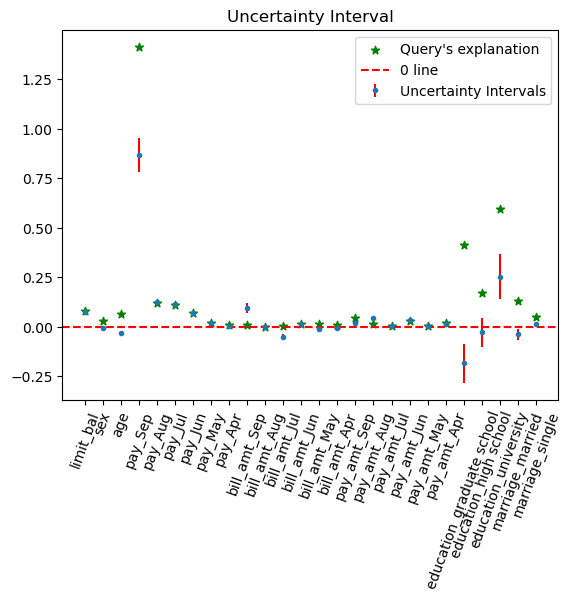

In [21]:
# visualize the uncertainty intervals of Shapley values
X_test = X_test.drop(['dist'], axis=1)
shap_values_local = np.abs(logit_df['shap_con'])

n_feature=X_test.shape[1]
errors=np.zeros([2,n_feature])
y_l = shap_ci.mean(axis=1) - np.transpose(shap_ci)[0,:]
y_u =np.transpose(shap_ci)[1,:]-shap_ci.mean(axis=1)

errors[0,:]=y_l
errors[1,:]=y_u
errors
plt.errorbar(np.arange(n_feature),shap_ci.mean(axis=1),yerr=errors,fmt='.', ecolor = 'red',label="Uncertainty Intervals")
plt.scatter(np.arange(n_feature),shap_values_local,marker='*',color="green",label="Query's explanation")#shapley value for the sigle instance 
plt.axhline(y=0, color='r', linestyle='--',label="0 line")
plt.title("Uncertainty Interval")
x=X_train.columns.values
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x, rotation=70.)
plt.legend()
# green stars are the shapley values for the choosen instance and the red lines are the CI.

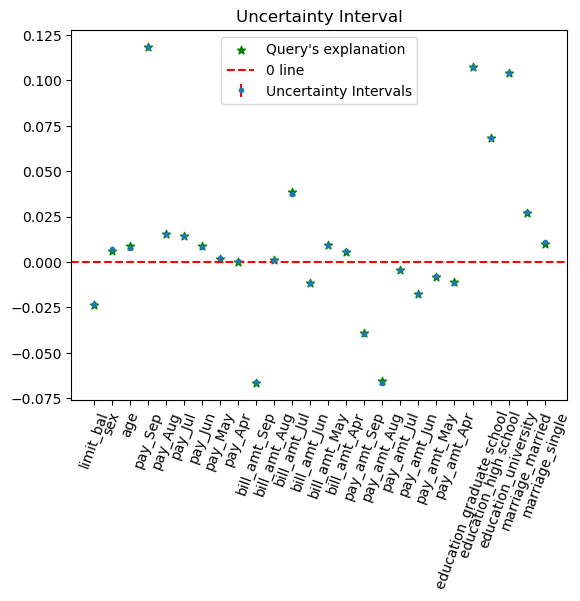

In [23]:
# visualize the uncertainty intervals of LIME coefficient
lime_value_local=logit_df['lime_con']

n_feature=X_test.shape[1]
errors=np.zeros([2,n_feature])
y_l = lime_ci.mean(axis=1) - np.transpose(lime_ci)[0,:]
y_u =np.transpose(lime_ci)[1,:]-lime_ci.mean(axis=1)

errors[0,:]=y_l
errors[1,:]=y_u
errors
plt.errorbar(np.arange(n_feature),lime_ci.mean(axis=1),yerr=errors,fmt='.', ecolor = 'red',label="Uncertainty Intervals")
plt.scatter(np.arange(n_feature),lime_value_local,marker='*',color="green",label="Query's explanation")#shapley value for the sigle instance 
plt.axhline(y=0, color='r', linestyle='--',label="0 line")
plt.title("Uncertainty Interval")
x=X_train.columns.values
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x, rotation=70.)
plt.legend()
# green stars are the shapley values for the choosen instance and the red lines are the CI.